#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. \
Значение метрики RMSE на тестовой выборке должно быть не больше 48.


## Подготовка

Загрузка данныъ и их ресемплирование по одному часу.

In [1]:
import pandas as pd
import numpy as np


from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from statsmodels.tsa.seasonal import seasonal_decompose

from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor

import matplotlib.pyplot as plt

In [2]:
try:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('D:/Рабочий стол/япроект/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
df.isna().sum()

num_orders    0
dtype: int64

In [4]:
df[df['num_orders'].isna() == True]

,num_orders
datetime,


In [5]:
df.sort_index(inplace=True)
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [6]:
df.index.is_monotonic

/tmp/ipykernel_663/2090065119.py:1: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  df.index.is_monotonic


True

Пропусков нет, последовательность соблюдается

Данные на 2018 год за 6 месяцев

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [4]:
df = df.resample('1H').sum()

In [5]:
decomposed = seasonal_decompose(df) 

Text(0.5, 1.0, 'resid')

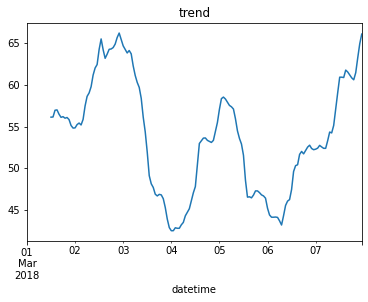

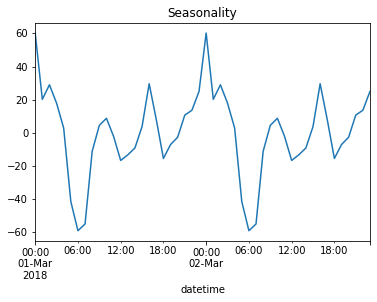

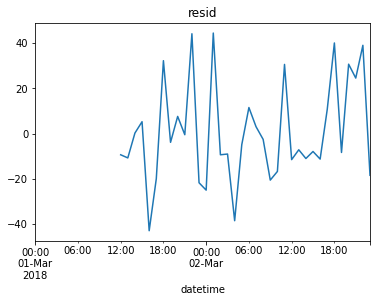

In [6]:
plt.figure()

plt.subplot()
decomposed.trend['2018-03-01':'2018-03-7'].plot(ax=plt.gca())
plt.title('trend')

plt.figure()
decomposed.seasonal['2018-03-01':'2018-03-2'].plot(ax=plt.gca())
plt.title('Seasonality')

plt.figure()
decomposed.resid['2018-03-01':'2018-03-2'].plot(ax=plt.gca())
plt.title('resid')

 По тренду видны скачки в течение недели, что логично -- 1 марта 2018 года это четверг, на пятницу и субботу приходится много вызовов, люди веселятся. В воскресенье минимум, все отдыхают дома. В рабочие дни вызовов меньше, ну и к праздникам снова повышение\
Сезонность в сутки тоже понятна, минимум вызовов в 6 утра, когда все либо уже спят, либо еще не проснулись. Пик ночью, когда людям нужно вернуться домой, а общественнывй транспорт уже не работает.


In [10]:
df['Hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek

In [11]:
def make_features(data, max_lag, rolling_mean_size): 
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [12]:
def rmse(t, p):
    return mean_squared_error(t, p) ** 0.5
scorer = make_scorer(rmse, greater_is_better=False)

Проверка разных окон и сдвигов:

In [13]:
# %%time

# scores = pd.DataFrame({'i': [],
#  'j' : [],
#  'rmse': []})

# t = 0
# for i in range(168, 180):
#     for j in range(1, 35):
#         make_features(df, i, j)
#         train, test = train_test_split(df, shuffle=False, test_size=0.2)
#         train = train.dropna()
#         scores.loc[t, 'i'] = i
#         scores.loc[t, 'j'] = j
#         model = LinearRegression()
#         model.fit(train.drop('num_orders', axis=1), train['num_orders'])
#         scores.loc[t, 'rmse'] = rmse(test['num_orders'], model.predict(test.drop('num_orders', axis=1)))
#         t += 1

In [14]:
# scores.sort_values(by='rmse').head(15)

In [15]:
# make_features(df, 168, 33)
# model = LinearRegression()
# model.fit(train.drop('num_orders', axis=1), train['num_orders'])
# rmse(test['num_orders'], model.predict(test.drop('num_orders', axis=1)))

In [16]:
# make_features(df, 1, 24)
# model = LinearRegression()
# model.fit(train.drop('num_orders', axis=1), train['num_orders'])
# rmse(test['num_orders'], model.predict(test.drop('num_orders', axis=1)))

In [17]:
make_features(df, 168, 33)

/tmp/ipykernel_663/1192923404.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
/tmp/ipykernel_663/1192923404.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
/tmp/ipykernel_663/1192923404.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

In [18]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

In [19]:
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

In [20]:
model = LinearRegression()
model.fit(features_train, target_train)
rmse(target_test, model.predict(features_test))

34.888950364370466

## Обучение

In [21]:
def test_rmse(model):
    model = model
    model.fit(features_train, target_train)
    print("RMSE обучающей выборки:", rmse(target_train, model.predict(features_train)).round(2))
    print("RMSE тестовой выборки: ", rmse(target_test, model.predict(features_test)).round(2))

Начнем с dummy моделей
### Dummy

По среднему

In [22]:
pred = pd.Series([train['num_orders'].mean()] * len(target_test))
print("RMSE:", rmse(target_test, pred))

RMSE: 83.97941361168559


По медиане

In [23]:
pred = pd.Series([train['num_orders'].median()] * len(target_test))
print("RMSE:", rmse(target_test, pred).round(2))

RMSE: 86.41


По предыдущему

In [24]:
pred_previous = target_test.shift(fill_value=float(target_train.iloc[-1:]))
print("RMSE:", rmse(target_test, pred_previous).round(2))

RMSE: 58.86


### Линейная

In [25]:
test_rmse(LinearRegression())

RMSE обучающей выборки: 20.52
RMSE тестовой выборки:  34.89


In [26]:
results = pd.DataFrame({
    'model' : [],
    'rmse' : []
})

In [27]:
model = LinearRegression()
rmse_count = cross_val_score(model,
                features_train, 
                target_train, 
                cv = TimeSeriesSplit(n_splits=8), 
                n_jobs = -1, 
                scoring = 'neg_root_mean_squared_error').mean() * (-1)
rmse_count

22.95524686709944

In [28]:
results.loc[0, 'model'] = 'LinearRegression'
results.loc[0, 'rmse'] = rmse_count.round(2)

### LGBM

In [30]:
parametrs = {'n_estimators': range(90, 120, 10),
             'learning_rate': np.arange(0.05, 0.26, 0.5),
             'num_leaves': range(25, 41, 2)
             }

Подбор лучших параметров

In [30]:
# %%time
# model_LGBM = LGBMRegressor()
# grid = GridSearchCV(model_LGBM, parametrs, cv=5, verbose=50, scoring=scorer)
# grid.fit(features_train, target_train)
# grid.best_params_

In [31]:
%%time
model_LGBM = LGBMRegressor()
tscv = TimeSeriesSplit(n_splits=8)
grid = GridSearchCV(model_LGBM,
                       param_grid=parametrs,
                       scoring='neg_root_mean_squared_error',
                       n_jobs=-1,
                       cv=tscv,
                       verbose=10)
grid.fit(features_train, target_train)
grid.best_score_

Fitting 8 folds for each of 1 candidates, totalling 8 fits
[CV 1/8; 1/1] START learning_rate=0.05, n_estimators=90, num_leaves=39..........
[CV 1/8; 1/1] END learning_rate=0.05, n_estimators=90, num_leaves=39;, score=-18.983 total time= 2.0min
[CV 2/8; 1/1] START learning_rate=0.05, n_estimators=90, num_leaves=39..........
[CV 2/8; 1/1] END learning_rate=0.05, n_estimators=90, num_leaves=39;, score=-20.179 total time= 3.9min
[CV 3/8; 1/1] START learning_rate=0.05, n_estimators=90, num_leaves=39..........
[CV 3/8; 1/1] END learning_rate=0.05, n_estimators=90, num_leaves=39;, score=-20.918 total time=   5.5s
[CV 4/8; 1/1] START learning_rate=0.05, n_estimators=90, num_leaves=39..........
[CV 4/8; 1/1] END learning_rate=0.05, n_estimators=90, num_leaves=39;, score=-22.189 total time=   3.6s
[CV 5/8; 1/1] START learning_rate=0.05, n_estimators=90, num_leaves=39..........
[CV 5/8; 1/1] END learning_rate=0.05, n_estimators=90, num_leaves=39;, score=-20.946 total time=   5.3s
[CV 6/8; 1/1] ST

-22.39588602176297

In [32]:
results.loc[1, 'model'] = 'LGBMRegressor'
results.loc[1, 'rmse'] = (grid.best_score_*(-1)).round(2)

{'learning_rate': 0.05, 'n_estimators': 110, 'num_leaves': 27}

In [33]:
test_rmse(LGBMRegressor(learning_rate=0.05, n_estimators=110, num_leaves=27))

RMSE обучающей выборки: 13.26
RMSE тестовой выборки:  36.81


### Cat

In [34]:
parametrs = {'iterations': range(10, 40, 5),
             'learning_rate': np.arange(0.01, 0.7, 0.05),
             }

In [35]:
%%time
model_cat = CatBoostRegressor()
tscv = TimeSeriesSplit(n_splits=8)
grid = GridSearchCV(model_cat,
                       param_grid=parametrs,
                       scoring='neg_root_mean_squared_error',
                       n_jobs=-1,
                       cv=tscv,
                       verbose=10)
grid.fit(features_train, target_train)
grid.best_score_

Fitting 8 folds for each of 84 candidates, totalling 672 fits
[CV 1/8; 1/84] START iterations=10, learning_rate=0.01..........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.2466180	total: 91.8ms	remaining: 826ms
1:	learn: 29.0969790	total: 120ms	remaining: 481ms
2:	learn: 28.9943996	total: 141ms	remaining: 329ms
3:	learn: 28.8595099	total: 163ms	remaining: 244ms
4:	learn: 28.7271731	total: 184ms	remaining: 184ms
5:	learn: 28.6007555	total: 218ms	remaining: 145ms
6:	learn: 28.4723421	total: 238ms	remaining: 102ms
7:	learn: 28.3436515	total: 257ms	remaining: 64.2ms
8:	learn: 28.2465419	total: 277ms	remaining: 30.7ms
9:	learn: 28.1142259	total: 317ms	remaining: 0us
[CV 1/8; 1/84] END iterations=10, learning_rate=0.01;, score=-28.176 total time=   1.2s
[CV 2/8; 1/84] START iterations=10, learning_rate=0.01..........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.1860684	total: 37.6ms	remaining: 338ms
1:	learn: 29.0385650	total: 63.2ms	remaining: 253ms
2:	learn: 28.9110312	total: 97.2ms	remaining: 227ms
3:	learn: 28.7782385	total: 122ms	remaining: 183ms
4:	learn: 28.6463964	total: 187ms	remaining: 187ms
5:	learn: 28.5263243	total: 212ms	remaining: 141ms
6:	learn: 28.3980449	total: 277ms	remaining: 119ms
7:	learn: 28.2615441	total: 303ms	remaining: 75.7ms
8:	learn: 28.1488058	total: 328ms	remaining: 36.5ms
9:	learn: 28.0204509	total: 391ms	remaining: 0us
[CV 2/8; 1/84] END iterations=10, learning_rate=0.01;, score=-33.865 total time=   1.1s
[CV 3/8; 1/84] START iterations=10, learning_rate=0.01..........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 30.9788723	total: 84.1ms	remaining: 757ms
1:	learn: 30.8122617	total: 112ms	remaining: 450ms
2:	learn: 30.6650329	total: 194ms	remaining: 452ms
3:	learn: 30.5187094	total: 222ms	remaining: 333ms
4:	learn: 30.3637556	total: 302ms	remaining: 302ms
5:	learn: 30.2187555	total: 381ms	remaining: 254ms
6:	learn: 30.0625290	total: 409ms	remaining: 175ms
7:	learn: 29.9201331	total: 488ms	remaining: 122ms
8:	learn: 29.7953353	total: 515ms	remaining: 57.2ms
9:	learn: 29.6448045	total: 586ms	remaining: 0us
[CV 3/8; 1/84] END iterations=10, learning_rate=0.01;, score=-31.165 total time=   1.3s
[CV 4/8; 1/84] START iterations=10, learning_rate=0.01..........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 31.2865054	total: 181ms	remaining: 1.62s
1:	learn: 31.1224544	total: 292ms	remaining: 1.17s
2:	learn: 30.9710298	total: 402ms	remaining: 938ms
3:	learn: 30.8132140	total: 588ms	remaining: 882ms
4:	learn: 30.6565317	total: 698ms	remaining: 698ms
5:	learn: 30.5162210	total: 800ms	remaining: 534ms
6:	learn: 30.3615075	total: 985ms	remaining: 422ms
7:	learn: 30.2211313	total: 1.1s	remaining: 274ms
8:	learn: 30.0825876	total: 1.28s	remaining: 142ms
9:	learn: 29.9439136	total: 1.38s	remaining: 0us
[CV 4/8; 1/84] END iterations=10, learning_rate=0.01;, score=-37.844 total time=   2.8s
[CV 5/8; 1/84] START iterations=10, learning_rate=0.01..........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 32.8788894	total: 145ms	remaining: 1.3s
1:	learn: 32.7029027	total: 332ms	remaining: 1.33s
2:	learn: 32.5395120	total: 443ms	remaining: 1.03s
3:	learn: 32.3564971	total: 551ms	remaining: 826ms
4:	learn: 32.1904074	total: 669ms	remaining: 669ms
5:	learn: 32.0353480	total: 778ms	remaining: 519ms
6:	learn: 31.8672083	total: 890ms	remaining: 381ms
7:	learn: 31.7113393	total: 1.07s	remaining: 267ms
8:	learn: 31.5656678	total: 1.18s	remaining: 131ms
9:	learn: 31.4066931	total: 1.37s	remaining: 0us
[CV 5/8; 1/84] END iterations=10, learning_rate=0.01;, score=-33.776 total time=   2.7s
[CV 6/8; 1/84] START iterations=10, learning_rate=0.01..........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 33.1851610	total: 195ms	remaining: 1.76s
1:	learn: 33.0083502	total: 374ms	remaining: 1.49s
2:	learn: 32.8443064	total: 489ms	remaining: 1.14s
3:	learn: 32.6626681	total: 602ms	remaining: 903ms
4:	learn: 32.4976386	total: 719ms	remaining: 719ms
5:	learn: 32.3419602	total: 914ms	remaining: 609ms
6:	learn: 32.1722406	total: 1.02s	remaining: 439ms
7:	learn: 32.0171993	total: 1.21s	remaining: 303ms
8:	learn: 31.8701174	total: 1.32s	remaining: 147ms
9:	learn: 31.7053279	total: 1.5s	remaining: 0us
[CV 6/8; 1/84] END iterations=10, learning_rate=0.01;, score=-37.631 total time=   2.7s
[CV 7/8; 1/84] START iterations=10, learning_rate=0.01..........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 34.0042315	total: 179ms	remaining: 1.61s
1:	learn: 33.8140804	total: 361ms	remaining: 1.45s
2:	learn: 33.6412381	total: 553ms	remaining: 1.29s
3:	learn: 33.4652899	total: 664ms	remaining: 996ms
4:	learn: 33.2875013	total: 850ms	remaining: 850ms
5:	learn: 33.1278522	total: 966ms	remaining: 644ms
6:	learn: 32.9608521	total: 1.15s	remaining: 492ms
7:	learn: 32.7912793	total: 1.26s	remaining: 316ms
8:	learn: 32.6304895	total: 1.46s	remaining: 162ms
9:	learn: 32.4714695	total: 1.57s	remaining: 0us
[CV 7/8; 1/84] END iterations=10, learning_rate=0.01;, score=-44.116 total time=   2.9s
[CV 8/8; 1/84] START iterations=10, learning_rate=0.01..........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 35.5179769	total: 255ms	remaining: 2.29s
1:	learn: 35.3171131	total: 448ms	remaining: 1.79s
2:	learn: 35.1327543	total: 635ms	remaining: 1.48s
3:	learn: 34.9476998	total: 756ms	remaining: 1.13s
4:	learn: 34.7608964	total: 941ms	remaining: 941ms
5:	learn: 34.5912701	total: 1.06s	remaining: 707ms
6:	learn: 34.4107165	total: 1.18s	remaining: 505ms
7:	learn: 34.2325251	total: 1.36s	remaining: 341ms
8:	learn: 34.0630482	total: 1.49s	remaining: 165ms
9:	learn: 33.8894907	total: 1.68s	remaining: 0us
[CV 8/8; 1/84] END iterations=10, learning_rate=0.01;, score=-55.984 total time=   2.9s
[CV 1/8; 2/84] START iterations=10, learning_rate=0.060000000000000005..........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.5333758	total: 116ms	remaining: 1.04s
1:	learn: 27.6866420	total: 223ms	remaining: 892ms
2:	learn: 27.1336633	total: 318ms	remaining: 742ms
3:	learn: 26.4408808	total: 417ms	remaining: 626ms
4:	learn: 25.7606662	total: 516ms	remaining: 516ms
5:	learn: 25.1985559	total: 620ms	remaining: 413ms
6:	learn: 24.7173656	total: 715ms	remaining: 306ms
7:	learn: 24.2612878	total: 814ms	remaining: 203ms
8:	learn: 23.7852221	total: 906ms	remaining: 101ms
9:	learn: 23.2514553	total: 1.01s	remaining: 0us
[CV 1/8; 2/84] END iterations=10, learning_rate=0.060000000000000005;, score=-24.490 total time=   2.1s
[CV 2/8; 2/84] START iterations=10, learning_rate=0.060000000000000005..........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.4912562	total: 169ms	remaining: 1.52s
1:	learn: 27.6809283	total: 273ms	remaining: 1.09s
2:	learn: 26.9651129	total: 452ms	remaining: 1.05s
3:	learn: 26.3242256	total: 552ms	remaining: 828ms
4:	learn: 25.6297169	total: 655ms	remaining: 655ms
5:	learn: 25.0918102	total: 756ms	remaining: 504ms
6:	learn: 24.4705391	total: 860ms	remaining: 369ms
7:	learn: 23.8558701	total: 963ms	remaining: 241ms
8:	learn: 23.4677868	total: 1.07s	remaining: 119ms
9:	learn: 22.9521066	total: 1.25s	remaining: 0us
[CV 2/8; 2/84] END iterations=10, learning_rate=0.060000000000000005;, score=-29.084 total time=   2.5s
[CV 3/8; 2/84] START iterations=10, learning_rate=0.060000000000000005..........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 30.2242884	total: 128ms	remaining: 1.15s
1:	learn: 29.3380726	total: 241ms	remaining: 965ms
2:	learn: 28.6069172	total: 349ms	remaining: 815ms
3:	learn: 27.8453787	total: 533ms	remaining: 800ms
4:	learn: 27.0968553	total: 642ms	remaining: 642ms
5:	learn: 26.5406127	total: 744ms	remaining: 496ms
6:	learn: 25.9599507	total: 847ms	remaining: 363ms
7:	learn: 25.3493941	total: 1.03s	remaining: 258ms
8:	learn: 24.8238971	total: 1.14s	remaining: 127ms
9:	learn: 24.2859739	total: 1.25s	remaining: 0us
[CV 3/8; 2/84] END iterations=10, learning_rate=0.060000000000000005;, score=-26.204 total time=   2.6s
[CV 4/8; 2/84] START iterations=10, learning_rate=0.060000000000000005..........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 30.5303682	total: 126ms	remaining: 1.13s
1:	learn: 29.6082096	total: 304ms	remaining: 1.22s
2:	learn: 28.8702927	total: 416ms	remaining: 970ms
3:	learn: 28.0667538	total: 526ms	remaining: 789ms
4:	learn: 27.3106075	total: 634ms	remaining: 634ms
5:	learn: 26.6159051	total: 743ms	remaining: 496ms
6:	learn: 26.0153181	total: 930ms	remaining: 399ms
7:	learn: 25.4329069	total: 1.04s	remaining: 261ms
8:	learn: 24.9022058	total: 1.23s	remaining: 137ms
9:	learn: 24.3758867	total: 1.34s	remaining: 0us
[CV 4/8; 2/84] END iterations=10, learning_rate=0.060000000000000005;, score=-31.598 total time=   2.7s
[CV 5/8; 2/84] START iterations=10, learning_rate=0.060000000000000005..........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 32.0346707	total: 136ms	remaining: 1.22s
1:	learn: 31.0445411	total: 320ms	remaining: 1.28s
2:	learn: 30.1664552	total: 431ms	remaining: 1.01s
3:	learn: 29.3398784	total: 615ms	remaining: 922ms
4:	learn: 28.5232484	total: 807ms	remaining: 807ms
5:	learn: 27.8570349	total: 920ms	remaining: 614ms
6:	learn: 27.1356741	total: 1.11s	remaining: 476ms
7:	learn: 26.4957282	total: 1.23s	remaining: 307ms
8:	learn: 25.9351267	total: 1.4s	remaining: 156ms
9:	learn: 25.3871303	total: 1.52s	remaining: 0us
[CV 5/8; 2/84] END iterations=10, learning_rate=0.060000000000000005;, score=-27.908 total time=   2.7s
[CV 6/8; 2/84] START iterations=10, learning_rate=0.060000000000000005..........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 32.3200413	total: 249ms	remaining: 2.24s
1:	learn: 31.3425843	total: 362ms	remaining: 1.45s
2:	learn: 30.4384366	total: 549ms	remaining: 1.28s
3:	learn: 29.6308536	total: 658ms	remaining: 986ms
4:	learn: 28.8133137	total: 842ms	remaining: 842ms
5:	learn: 28.1020899	total: 959ms	remaining: 639ms
6:	learn: 27.4451612	total: 1.14s	remaining: 489ms
7:	learn: 26.8248158	total: 1.26s	remaining: 315ms
8:	learn: 26.2443798	total: 1.45s	remaining: 161ms
9:	learn: 25.6861921	total: 1.56s	remaining: 0us
[CV 6/8; 2/84] END iterations=10, learning_rate=0.060000000000000005;, score=-30.346 total time=   2.8s
[CV 7/8; 2/84] START iterations=10, learning_rate=0.060000000000000005..........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 33.0958839	total: 185ms	remaining: 1.67s
1:	learn: 32.0333143	total: 361ms	remaining: 1.44s
2:	learn: 31.0783672	total: 478ms	remaining: 1.11s
3:	learn: 30.2467167	total: 594ms	remaining: 891ms
4:	learn: 29.3959187	total: 787ms	remaining: 787ms
5:	learn: 28.6493076	total: 978ms	remaining: 652ms
6:	learn: 27.9008260	total: 1.09s	remaining: 469ms
7:	learn: 27.2694275	total: 1.28s	remaining: 320ms
8:	learn: 26.6767089	total: 1.39s	remaining: 154ms
9:	learn: 26.0873825	total: 1.51s	remaining: 0us
[CV 7/8; 2/84] END iterations=10, learning_rate=0.060000000000000005;, score=-36.075 total time=   2.8s
[CV 8/8; 2/84] START iterations=10, learning_rate=0.060000000000000005..........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 34.5730745	total: 254ms	remaining: 2.28s
1:	learn: 33.4591085	total: 453ms	remaining: 1.81s
2:	learn: 32.4528635	total: 648ms	remaining: 1.51s
3:	learn: 31.5532662	total: 769ms	remaining: 1.15s
4:	learn: 30.6708639	total: 892ms	remaining: 892ms
5:	learn: 29.9209502	total: 1.08s	remaining: 721ms
6:	learn: 29.1860962	total: 1.27s	remaining: 545ms
7:	learn: 28.4560093	total: 1.47s	remaining: 368ms
8:	learn: 27.8051957	total: 1.59s	remaining: 176ms
9:	learn: 27.1729326	total: 1.78s	remaining: 0us
[CV 8/8; 2/84] END iterations=10, learning_rate=0.060000000000000005;, score=-47.031 total time=   3.1s
[CV 1/8; 3/84] START iterations=10, learning_rate=0.11..........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.8359831	total: 129ms	remaining: 1.16s
1:	learn: 26.3804910	total: 229ms	remaining: 916ms
2:	learn: 25.4100095	total: 325ms	remaining: 758ms
3:	learn: 24.3551720	total: 425ms	remaining: 637ms
4:	learn: 23.2256038	total: 530ms	remaining: 530ms
5:	learn: 22.4286771	total: 629ms	remaining: 420ms
6:	learn: 21.6692727	total: 729ms	remaining: 312ms
7:	learn: 21.1126259	total: 828ms	remaining: 207ms
8:	learn: 20.4280489	total: 925ms	remaining: 103ms
9:	learn: 19.8395695	total: 1.1s	remaining: 0us
[CV 1/8; 3/84] END iterations=10, learning_rate=0.11;, score=-21.877 total time=   2.3s
[CV 2/8; 3/84] START iterations=10, learning_rate=0.11..........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.8142033	total: 175ms	remaining: 1.57s
1:	learn: 26.4268664	total: 279ms	remaining: 1.12s
2:	learn: 25.2920380	total: 379ms	remaining: 884ms
3:	learn: 24.2477358	total: 559ms	remaining: 838ms
4:	learn: 23.2271809	total: 597ms	remaining: 597ms
5:	learn: 22.4834041	total: 685ms	remaining: 457ms
6:	learn: 21.6265411	total: 784ms	remaining: 336ms
7:	learn: 20.8850990	total: 883ms	remaining: 221ms
8:	learn: 20.2917274	total: 988ms	remaining: 110ms
9:	learn: 19.7311648	total: 1.09s	remaining: 0us
[CV 2/8; 3/84] END iterations=10, learning_rate=0.11;, score=-26.382 total time=   2.3s
[CV 3/8; 3/84] START iterations=10, learning_rate=0.11..........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.4896718	total: 130ms	remaining: 1.17s
1:	learn: 27.8630469	total: 237ms	remaining: 950ms
2:	learn: 26.7183976	total: 345ms	remaining: 804ms
3:	learn: 25.4961949	total: 447ms	remaining: 671ms
4:	learn: 24.3939709	total: 554ms	remaining: 554ms
5:	learn: 23.4875699	total: 728ms	remaining: 486ms
6:	learn: 22.6467482	total: 837ms	remaining: 359ms
7:	learn: 21.9324316	total: 948ms	remaining: 237ms
8:	learn: 21.3168294	total: 1.13s	remaining: 126ms
9:	learn: 20.7671926	total: 1.24s	remaining: 0us
[CV 3/8; 3/84] END iterations=10, learning_rate=0.11;, score=-23.129 total time=   2.6s
[CV 4/8; 3/84] START iterations=10, learning_rate=0.11..........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.7947533	total: 165ms	remaining: 1.48s
1:	learn: 28.2013825	total: 274ms	remaining: 1.1s
2:	learn: 26.9523492	total: 476ms	remaining: 1.11s
3:	learn: 25.6365856	total: 671ms	remaining: 1.01s
4:	learn: 24.5271821	total: 877ms	remaining: 877ms
5:	learn: 23.7198246	total: 1.07s	remaining: 715ms
6:	learn: 22.9257008	total: 1.26s	remaining: 543ms
7:	learn: 22.1915385	total: 1.38s	remaining: 346ms
8:	learn: 21.5539038	total: 1.5s	remaining: 166ms
9:	learn: 21.0020417	total: 1.68s	remaining: 0us
[CV 4/8; 3/84] END iterations=10, learning_rate=0.11;, score=-27.343 total time=   3.2s
[CV 5/8; 3/84] START iterations=10, learning_rate=0.11..........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 31.2119208	total: 249ms	remaining: 2.24s
1:	learn: 29.5171915	total: 370ms	remaining: 1.48s
2:	learn: 28.0338151	total: 573ms	remaining: 1.33s
3:	learn: 26.8033819	total: 769ms	remaining: 1.15s
4:	learn: 25.6245284	total: 886ms	remaining: 886ms
5:	learn: 24.7904680	total: 1.08s	remaining: 723ms
6:	learn: 23.9220527	total: 1.27s	remaining: 547ms
7:	learn: 23.1920022	total: 1.47s	remaining: 368ms
8:	learn: 22.6116652	total: 1.68s	remaining: 187ms
9:	learn: 22.0354528	total: 1.88s	remaining: 0us
[CV 5/8; 3/84] END iterations=10, learning_rate=0.11;, score=-24.906 total time=   3.5s
[CV 6/8; 3/84] START iterations=10, learning_rate=0.11..........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 31.4765156	total: 222ms	remaining: 1.99s
1:	learn: 29.7980770	total: 423ms	remaining: 1.69s
2:	learn: 28.3297606	total: 544ms	remaining: 1.27s
3:	learn: 27.0069664	total: 665ms	remaining: 997ms
4:	learn: 25.8830941	total: 859ms	remaining: 859ms
5:	learn: 24.9355162	total: 1.07s	remaining: 711ms
6:	learn: 24.1047741	total: 1.19s	remaining: 510ms
7:	learn: 23.4016659	total: 1.31s	remaining: 328ms
8:	learn: 22.7479382	total: 1.43s	remaining: 159ms
9:	learn: 22.1647358	total: 1.63s	remaining: 0us
[CV 6/8; 3/84] END iterations=10, learning_rate=0.11;, score=-25.929 total time=   3.5s
[CV 7/8; 3/84] START iterations=10, learning_rate=0.11..........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 32.2097824	total: 280ms	remaining: 2.52s
1:	learn: 30.4353620	total: 486ms	remaining: 1.94s
2:	learn: 28.9176866	total: 605ms	remaining: 1.41s
3:	learn: 27.6697017	total: 801ms	remaining: 1.2s
4:	learn: 26.4772153	total: 1s	remaining: 1s
5:	learn: 25.5065943	total: 1.2s	remaining: 801ms
6:	learn: 24.6197290	total: 1.4s	remaining: 601ms
7:	learn: 23.8479736	total: 1.6s	remaining: 399ms
8:	learn: 23.2116242	total: 1.8s	remaining: 200ms
9:	learn: 22.6238536	total: 1.99s	remaining: 0us
[CV 7/8; 3/84] END iterations=10, learning_rate=0.11;, score=-31.641 total time=   3.5s
[CV 8/8; 3/84] START iterations=10, learning_rate=0.11..........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 33.6511808	total: 219ms	remaining: 1.97s
1:	learn: 31.7473199	total: 503ms	remaining: 2.01s
2:	learn: 30.1335574	total: 700ms	remaining: 1.63s
3:	learn: 28.7331164	total: 914ms	remaining: 1.37s
4:	learn: 27.4609563	total: 1.2s	remaining: 1.2s
5:	learn: 26.5037134	total: 1.32s	remaining: 879ms
6:	learn: 25.5598564	total: 1.52s	remaining: 653ms
7:	learn: 24.7440450	total: 1.64s	remaining: 411ms
8:	learn: 24.0212505	total: 1.95s	remaining: 216ms
9:	learn: 23.4119558	total: 2.25s	remaining: 0us
[CV 8/8; 3/84] END iterations=10, learning_rate=0.11;, score=-41.362 total time=   3.8s
[CV 1/8; 4/84] START iterations=10, learning_rate=0.16000000000000003...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.1556610	total: 205ms	remaining: 1.85s
1:	learn: 25.1851858	total: 322ms	remaining: 1.29s
2:	learn: 23.9406374	total: 432ms	remaining: 1.01s
3:	learn: 22.6845633	total: 543ms	remaining: 814ms
4:	learn: 21.4683052	total: 649ms	remaining: 649ms
5:	learn: 20.5932246	total: 757ms	remaining: 505ms
6:	learn: 19.8107048	total: 944ms	remaining: 405ms
7:	learn: 18.9614275	total: 1.05s	remaining: 263ms
8:	learn: 18.3429554	total: 1.24s	remaining: 138ms
9:	learn: 17.7739665	total: 1.35s	remaining: 0us
[CV 1/8; 4/84] END iterations=10, learning_rate=0.16000000000000003;, score=-20.175 total time=   2.8s
[CV 2/8; 4/84] START iterations=10, learning_rate=0.16000000000000003...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.1562381	total: 198ms	remaining: 1.78s
1:	learn: 25.1615065	total: 393ms	remaining: 1.57s
2:	learn: 23.6475568	total: 509ms	remaining: 1.19s
3:	learn: 22.4178857	total: 623ms	remaining: 935ms
4:	learn: 21.3124802	total: 729ms	remaining: 729ms
5:	learn: 20.4571272	total: 843ms	remaining: 562ms
6:	learn: 19.6464935	total: 1.03s	remaining: 441ms
7:	learn: 18.8875996	total: 1.15s	remaining: 286ms
8:	learn: 18.3903039	total: 1.33s	remaining: 148ms
9:	learn: 17.8325862	total: 1.44s	remaining: 0us
[CV 2/8; 4/84] END iterations=10, learning_rate=0.16000000000000003;, score=-24.394 total time=   2.9s
[CV 3/8; 4/84] START iterations=10, learning_rate=0.16000000000000003...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.7765517	total: 179ms	remaining: 1.61s
1:	learn: 26.5601068	total: 298ms	remaining: 1.19s
2:	learn: 24.8987572	total: 421ms	remaining: 983ms
3:	learn: 23.5159006	total: 545ms	remaining: 817ms
4:	learn: 22.2524745	total: 658ms	remaining: 658ms
5:	learn: 21.2532487	total: 844ms	remaining: 562ms
6:	learn: 20.4802979	total: 961ms	remaining: 412ms
7:	learn: 19.8152729	total: 1.08s	remaining: 269ms
8:	learn: 19.2731715	total: 1.27s	remaining: 141ms
9:	learn: 18.6892120	total: 1.38s	remaining: 0us
[CV 3/8; 4/84] END iterations=10, learning_rate=0.16000000000000003;, score=-21.443 total time=   3.2s
[CV 4/8; 4/84] START iterations=10, learning_rate=0.16000000000000003...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.0812181	total: 246ms	remaining: 2.21s
1:	learn: 26.9236660	total: 360ms	remaining: 1.44s
2:	learn: 25.1684444	total: 552ms	remaining: 1.29s
3:	learn: 23.7295431	total: 739ms	remaining: 1.11s
4:	learn: 22.4730203	total: 858ms	remaining: 858ms
5:	learn: 21.6123186	total: 1.05s	remaining: 698ms
6:	learn: 20.9061226	total: 1.24s	remaining: 534ms
7:	learn: 20.2987817	total: 1.44s	remaining: 360ms
8:	learn: 19.7735615	total: 1.64s	remaining: 183ms
9:	learn: 19.3151812	total: 1.84s	remaining: 0us
[CV 4/8; 4/84] END iterations=10, learning_rate=0.16000000000000003;, score=-25.512 total time=   3.2s
[CV 5/8; 4/84] START iterations=10, learning_rate=0.16000000000000003...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 30.4123822	total: 286ms	remaining: 2.57s
1:	learn: 28.1219328	total: 486ms	remaining: 1.94s
2:	learn: 26.2212426	total: 684ms	remaining: 1.6s
3:	learn: 24.7576595	total: 884ms	remaining: 1.33s
4:	learn: 23.4885295	total: 1.08s	remaining: 1.08s
5:	learn: 22.5886817	total: 1.28s	remaining: 853ms
6:	learn: 21.7874507	total: 1.48s	remaining: 632ms
7:	learn: 21.1430660	total: 1.59s	remaining: 398ms
8:	learn: 20.6549503	total: 1.78s	remaining: 198ms
9:	learn: 20.1746995	total: 1.98s	remaining: 0us
[CV 5/8; 4/84] END iterations=10, learning_rate=0.16000000000000003;, score=-22.998 total time=   3.4s
[CV 6/8; 4/84] START iterations=10, learning_rate=0.16000000000000003...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 30.6563666	total: 216ms	remaining: 1.94s
1:	learn: 28.4074327	total: 421ms	remaining: 1.68s
2:	learn: 26.6169909	total: 623ms	remaining: 1.45s
3:	learn: 25.0278521	total: 825ms	remaining: 1.24s
4:	learn: 23.7247187	total: 1.02s	remaining: 1.02s
5:	learn: 22.8370216	total: 1.22s	remaining: 816ms
6:	learn: 22.1233222	total: 1.43s	remaining: 611ms
7:	learn: 21.4625062	total: 1.63s	remaining: 407ms
8:	learn: 20.8482796	total: 1.82s	remaining: 202ms
9:	learn: 20.3856840	total: 2.02s	remaining: 0us
[CV 6/8; 4/84] END iterations=10, learning_rate=0.16000000000000003;, score=-23.686 total time=   3.8s
[CV 7/8; 4/84] START iterations=10, learning_rate=0.16000000000000003...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 31.3478137	total: 265ms	remaining: 2.39s
1:	learn: 28.9263939	total: 547ms	remaining: 2.19s
2:	learn: 27.0005582	total: 748ms	remaining: 1.75s
3:	learn: 25.5252866	total: 951ms	remaining: 1.43s
4:	learn: 24.2142878	total: 1.15s	remaining: 1.15s
5:	learn: 23.2068855	total: 1.34s	remaining: 896ms
6:	learn: 22.3980044	total: 1.55s	remaining: 665ms
7:	learn: 21.6836697	total: 1.76s	remaining: 439ms
8:	learn: 21.1322534	total: 2.04s	remaining: 227ms
9:	learn: 20.6768754	total: 2.16s	remaining: 0us
[CV 7/8; 4/84] END iterations=10, learning_rate=0.16000000000000003;, score=-28.280 total time=   3.6s
[CV 8/8; 4/84] START iterations=10, learning_rate=0.16000000000000003...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 32.7542387	total: 297ms	remaining: 2.67s
1:	learn: 30.1864433	total: 495ms	remaining: 1.98s
2:	learn: 28.1346168	total: 701ms	remaining: 1.64s
3:	learn: 26.6290503	total: 905ms	remaining: 1.36s
4:	learn: 25.2043920	total: 1.1s	remaining: 1.1s
5:	learn: 24.1244486	total: 1.31s	remaining: 873ms
6:	learn: 23.3102226	total: 1.51s	remaining: 648ms
7:	learn: 22.5986885	total: 1.72s	remaining: 429ms
8:	learn: 22.0012926	total: 1.91s	remaining: 213ms
9:	learn: 21.5182686	total: 2.11s	remaining: 0us
[CV 8/8; 4/84] END iterations=10, learning_rate=0.16000000000000003;, score=-37.455 total time=   4.1s
[CV 1/8; 5/84] START iterations=10, learning_rate=0.21000000000000002...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.4937246	total: 168ms	remaining: 1.51s
1:	learn: 24.0834535	total: 271ms	remaining: 1.08s
2:	learn: 22.7289493	total: 373ms	remaining: 871ms
3:	learn: 21.4594406	total: 401ms	remaining: 602ms
4:	learn: 20.0855619	total: 503ms	remaining: 503ms
5:	learn: 19.1383224	total: 613ms	remaining: 409ms
6:	learn: 18.3913813	total: 716ms	remaining: 307ms
7:	learn: 17.6649505	total: 822ms	remaining: 206ms
8:	learn: 16.9379441	total: 930ms	remaining: 103ms
9:	learn: 16.3838163	total: 1.03s	remaining: 0us
[CV 1/8; 5/84] END iterations=10, learning_rate=0.21000000000000002;, score=-20.044 total time=   2.7s
[CV 2/8; 5/84] START iterations=10, learning_rate=0.21000000000000002...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.5187815	total: 129ms	remaining: 1.16s
1:	learn: 24.2820411	total: 234ms	remaining: 934ms
2:	learn: 22.4036872	total: 343ms	remaining: 801ms
3:	learn: 21.0126374	total: 449ms	remaining: 673ms
4:	learn: 19.8132910	total: 637ms	remaining: 637ms
5:	learn: 18.9956007	total: 742ms	remaining: 495ms
6:	learn: 18.2183896	total: 850ms	remaining: 364ms
7:	learn: 17.5587142	total: 1.03s	remaining: 258ms
8:	learn: 17.0820952	total: 1.23s	remaining: 136ms
9:	learn: 16.5792749	total: 1.33s	remaining: 0us
[CV 2/8; 5/84] END iterations=10, learning_rate=0.21000000000000002;, score=-23.183 total time=   2.7s
[CV 3/8; 5/84] START iterations=10, learning_rate=0.21000000000000002...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.0865655	total: 167ms	remaining: 1.51s
1:	learn: 25.3727371	total: 345ms	remaining: 1.38s
2:	learn: 23.5715810	total: 453ms	remaining: 1.06s
3:	learn: 21.9026021	total: 645ms	remaining: 968ms
4:	learn: 20.7192278	total: 843ms	remaining: 843ms
5:	learn: 19.6928150	total: 954ms	remaining: 636ms
6:	learn: 18.9994670	total: 1.15s	remaining: 492ms
7:	learn: 18.3399671	total: 1.34s	remaining: 334ms
8:	learn: 17.8723887	total: 1.44s	remaining: 160ms
9:	learn: 17.4786804	total: 1.56s	remaining: 0us
[CV 3/8; 5/84] END iterations=10, learning_rate=0.21000000000000002;, score=-20.809 total time=   3.0s
[CV 4/8; 5/84] START iterations=10, learning_rate=0.21000000000000002...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.3914273	total: 192ms	remaining: 1.73s
1:	learn: 25.7621314	total: 306ms	remaining: 1.23s
2:	learn: 24.1198958	total: 492ms	remaining: 1.15s
3:	learn: 22.4923583	total: 690ms	remaining: 1.03s
4:	learn: 21.2480678	total: 808ms	remaining: 808ms
5:	learn: 20.3463142	total: 915ms	remaining: 610ms
6:	learn: 19.6534824	total: 1.03s	remaining: 440ms
7:	learn: 19.1105615	total: 1.14s	remaining: 285ms
8:	learn: 18.6290318	total: 1.25s	remaining: 138ms
9:	learn: 18.2355152	total: 1.35s	remaining: 0us
[CV 4/8; 5/84] END iterations=10, learning_rate=0.21000000000000002;, score=-23.918 total time=   2.7s
[CV 5/8; 5/84] START iterations=10, learning_rate=0.21000000000000002...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.6379334	total: 149ms	remaining: 1.34s
1:	learn: 26.8591674	total: 333ms	remaining: 1.33s
2:	learn: 24.7746217	total: 522ms	remaining: 1.22s
3:	learn: 23.2021823	total: 641ms	remaining: 961ms
4:	learn: 21.9300136	total: 826ms	remaining: 826ms
5:	learn: 21.0366076	total: 946ms	remaining: 631ms
6:	learn: 20.3114207	total: 1.06s	remaining: 454ms
7:	learn: 19.7100741	total: 1.25s	remaining: 311ms
8:	learn: 19.2792701	total: 1.36s	remaining: 151ms
9:	learn: 18.9296339	total: 1.54s	remaining: 0us
[CV 5/8; 5/84] END iterations=10, learning_rate=0.21000000000000002;, score=-22.237 total time=   2.8s
[CV 6/8; 5/84] START iterations=10, learning_rate=0.21000000000000002...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.8615203	total: 210ms	remaining: 1.89s
1:	learn: 27.2405974	total: 329ms	remaining: 1.31s
2:	learn: 25.3109762	total: 510ms	remaining: 1.19s
3:	learn: 23.5717603	total: 627ms	remaining: 940ms
4:	learn: 22.2960764	total: 815ms	remaining: 815ms
5:	learn: 21.3677393	total: 1s	remaining: 670ms
6:	learn: 20.7073139	total: 1.12s	remaining: 480ms
7:	learn: 20.1116776	total: 1.3s	remaining: 325ms
8:	learn: 19.6447087	total: 1.42s	remaining: 157ms
9:	learn: 19.3128158	total: 1.61s	remaining: 0us
[CV 6/8; 5/84] END iterations=10, learning_rate=0.21000000000000002;, score=-22.492 total time=   2.8s
[CV 7/8; 5/84] START iterations=10, learning_rate=0.21000000000000002...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 30.5120230	total: 215ms	remaining: 1.94s
1:	learn: 27.5926565	total: 413ms	remaining: 1.65s
2:	learn: 25.4289949	total: 611ms	remaining: 1.43s
3:	learn: 23.9253913	total: 725ms	remaining: 1.09s
4:	learn: 22.6964910	total: 844ms	remaining: 844ms
5:	learn: 21.7720351	total: 1.04s	remaining: 692ms
6:	learn: 21.0198179	total: 1.24s	remaining: 530ms
7:	learn: 20.4557283	total: 1.43s	remaining: 358ms
8:	learn: 20.0772039	total: 1.62s	remaining: 180ms
9:	learn: 19.7414907	total: 1.74s	remaining: 0us
[CV 7/8; 5/84] END iterations=10, learning_rate=0.21000000000000002;, score=-26.962 total time=   3.4s
[CV 8/8; 5/84] START iterations=10, learning_rate=0.21000000000000002...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 31.8843540	total: 213ms	remaining: 1.92s
1:	learn: 28.7777749	total: 410ms	remaining: 1.64s
2:	learn: 26.6311861	total: 613ms	remaining: 1.43s
3:	learn: 24.8476194	total: 808ms	remaining: 1.21s
4:	learn: 23.4966209	total: 1.01s	remaining: 1.01s
5:	learn: 22.5494636	total: 1.21s	remaining: 807ms
6:	learn: 21.8686079	total: 1.4s	remaining: 601ms
7:	learn: 21.3208337	total: 1.6s	remaining: 399ms
8:	learn: 20.8409305	total: 1.79s	remaining: 199ms
9:	learn: 20.4720219	total: 1.99s	remaining: 0us
[CV 8/8; 5/84] END iterations=10, learning_rate=0.21000000000000002;, score=-34.975 total time=   3.3s
[CV 1/8; 6/84] START iterations=10, learning_rate=0.26..........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.8515862	total: 118ms	remaining: 1.06s
1:	learn: 23.2155642	total: 217ms	remaining: 866ms
2:	learn: 21.7238038	total: 317ms	remaining: 740ms
3:	learn: 20.3917323	total: 419ms	remaining: 628ms
4:	learn: 18.9070365	total: 527ms	remaining: 527ms
5:	learn: 18.0149389	total: 693ms	remaining: 462ms
6:	learn: 17.2800009	total: 803ms	remaining: 344ms
7:	learn: 16.6265861	total: 908ms	remaining: 227ms
8:	learn: 15.9092656	total: 1.01s	remaining: 113ms
9:	learn: 15.2874766	total: 1.13s	remaining: 0us
[CV 1/8; 6/84] END iterations=10, learning_rate=0.26;, score=-19.650 total time=   2.4s
[CV 2/8; 6/84] START iterations=10, learning_rate=0.26..........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.9033476	total: 228ms	remaining: 2.05s
1:	learn: 23.3390352	total: 343ms	remaining: 1.37s
2:	learn: 21.4698619	total: 532ms	remaining: 1.24s
3:	learn: 19.8171760	total: 646ms	remaining: 969ms
4:	learn: 18.6925531	total: 762ms	remaining: 762ms
5:	learn: 17.9463942	total: 956ms	remaining: 637ms
6:	learn: 17.3645427	total: 1.14s	remaining: 491ms
7:	learn: 16.8437086	total: 1.26s	remaining: 315ms
8:	learn: 16.3347479	total: 1.37s	remaining: 152ms
9:	learn: 15.9220016	total: 1.48s	remaining: 0us
[CV 2/8; 6/84] END iterations=10, learning_rate=0.26;, score=-22.437 total time=   3.0s
[CV 3/8; 6/84] START iterations=10, learning_rate=0.26..........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.4214596	total: 206ms	remaining: 1.85s
1:	learn: 24.3010486	total: 314ms	remaining: 1.25s
2:	learn: 22.3466949	total: 424ms	remaining: 989ms
3:	learn: 20.8226797	total: 613ms	remaining: 919ms
4:	learn: 19.6341645	total: 733ms	remaining: 733ms
5:	learn: 18.9766640	total: 919ms	remaining: 612ms
6:	learn: 18.3202892	total: 1.11s	remaining: 476ms
7:	learn: 17.7933649	total: 1.23s	remaining: 308ms
8:	learn: 17.3756251	total: 1.51s	remaining: 168ms
9:	learn: 16.8860727	total: 1.63s	remaining: 0us
[CV 3/8; 6/84] END iterations=10, learning_rate=0.26;, score=-20.834 total time=   3.0s
[CV 4/8; 6/84] START iterations=10, learning_rate=0.26..........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.7271530	total: 206ms	remaining: 1.85s
1:	learn: 24.9089981	total: 392ms	remaining: 1.57s
2:	learn: 22.7573330	total: 507ms	remaining: 1.18s
3:	learn: 21.2766893	total: 699ms	remaining: 1.05s
4:	learn: 20.0733918	total: 814ms	remaining: 814ms
5:	learn: 19.4365870	total: 1.01s	remaining: 676ms
6:	learn: 18.8375534	total: 1.13s	remaining: 485ms
7:	learn: 18.3979145	total: 1.25s	remaining: 314ms
8:	learn: 17.9558475	total: 1.37s	remaining: 152ms
9:	learn: 17.6290106	total: 1.48s	remaining: 0us
[CV 4/8; 6/84] END iterations=10, learning_rate=0.26;, score=-23.899 total time=   3.2s
[CV 5/8; 6/84] START iterations=10, learning_rate=0.26..........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.8905921	total: 211ms	remaining: 1.9s
1:	learn: 25.7284172	total: 410ms	remaining: 1.64s
2:	learn: 23.5712556	total: 601ms	remaining: 1.4s
3:	learn: 21.9830343	total: 805ms	remaining: 1.21s
4:	learn: 20.8326663	total: 997ms	remaining: 997ms
5:	learn: 20.0388687	total: 1.2s	remaining: 797ms
6:	learn: 19.4757092	total: 1.32s	remaining: 565ms
7:	learn: 18.9701948	total: 1.52s	remaining: 380ms
8:	learn: 18.5564908	total: 1.72s	remaining: 191ms
9:	learn: 18.2920545	total: 1.93s	remaining: 0us
[CV 5/8; 6/84] END iterations=10, learning_rate=0.26;, score=-21.750 total time=   3.3s
[CV 6/8; 6/84] START iterations=10, learning_rate=0.26..........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.0940507	total: 223ms	remaining: 2.01s
1:	learn: 26.0388892	total: 430ms	remaining: 1.72s
2:	learn: 24.0662872	total: 635ms	remaining: 1.48s
3:	learn: 22.6052657	total: 825ms	remaining: 1.24s
4:	learn: 21.3737069	total: 1.03s	remaining: 1.03s
5:	learn: 20.6541498	total: 1.23s	remaining: 819ms
6:	learn: 20.1043899	total: 1.43s	remaining: 613ms
7:	learn: 19.6971648	total: 1.62s	remaining: 405ms
8:	learn: 19.3196231	total: 1.73s	remaining: 192ms
9:	learn: 19.0059811	total: 1.93s	remaining: 0us
[CV 6/8; 6/84] END iterations=10, learning_rate=0.26;, score=-21.581 total time=   3.5s
[CV 7/8; 6/84] START iterations=10, learning_rate=0.26..........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.7046202	total: 235ms	remaining: 2.12s
1:	learn: 26.4070911	total: 439ms	remaining: 1.75s
2:	learn: 24.1186143	total: 638ms	remaining: 1.49s
3:	learn: 22.6506858	total: 761ms	remaining: 1.14s
4:	learn: 21.5739883	total: 878ms	remaining: 878ms
5:	learn: 20.8415645	total: 1.07s	remaining: 716ms
6:	learn: 20.2291486	total: 1.28s	remaining: 547ms
7:	learn: 19.7778714	total: 1.47s	remaining: 367ms
8:	learn: 19.4145391	total: 1.67s	remaining: 185ms
9:	learn: 19.1022236	total: 1.86s	remaining: 0us
[CV 7/8; 6/84] END iterations=10, learning_rate=0.26;, score=-25.982 total time=   3.3s
[CV 8/8; 6/84] START iterations=10, learning_rate=0.26..........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 31.0438014	total: 216ms	remaining: 1.95s
1:	learn: 27.5215940	total: 422ms	remaining: 1.69s
2:	learn: 25.2638544	total: 543ms	remaining: 1.27s
3:	learn: 23.4936871	total: 750ms	remaining: 1.12s
4:	learn: 22.2317436	total: 946ms	remaining: 946ms
5:	learn: 21.4671782	total: 1.07s	remaining: 711ms
6:	learn: 20.9174340	total: 1.27s	remaining: 543ms
7:	learn: 20.3785570	total: 1.47s	remaining: 367ms
8:	learn: 20.0038485	total: 1.67s	remaining: 186ms
9:	learn: 19.7433665	total: 1.87s	remaining: 0us
[CV 8/8; 6/84] END iterations=10, learning_rate=0.26;, score=-33.228 total time=   3.6s
[CV 1/8; 7/84] START iterations=10, learning_rate=0.31000000000000005...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.2307573	total: 176ms	remaining: 1.58s
1:	learn: 22.3840673	total: 283ms	remaining: 1.13s
2:	learn: 20.5988506	total: 392ms	remaining: 914ms
3:	learn: 19.3693965	total: 583ms	remaining: 874ms
4:	learn: 18.0551924	total: 691ms	remaining: 691ms
5:	learn: 17.0737313	total: 804ms	remaining: 536ms
6:	learn: 16.4644860	total: 906ms	remaining: 388ms
7:	learn: 15.9291293	total: 1.01s	remaining: 252ms
8:	learn: 15.5053209	total: 1.11s	remaining: 124ms
9:	learn: 15.1180573	total: 1.22s	remaining: 0us
[CV 1/8; 7/84] END iterations=10, learning_rate=0.31000000000000005;, score=-19.936 total time=   2.3s
[CV 2/8; 7/84] START iterations=10, learning_rate=0.31000000000000005...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.3115426	total: 123ms	remaining: 1.11s
1:	learn: 22.4955527	total: 240ms	remaining: 961ms
2:	learn: 20.4709157	total: 434ms	remaining: 1.01s
3:	learn: 19.1132353	total: 545ms	remaining: 817ms
4:	learn: 17.8875819	total: 659ms	remaining: 659ms
5:	learn: 17.2101664	total: 860ms	remaining: 573ms
6:	learn: 16.5403031	total: 1.05s	remaining: 449ms
7:	learn: 16.0401196	total: 1.15s	remaining: 288ms
8:	learn: 15.7016276	total: 1.26s	remaining: 140ms
9:	learn: 15.4789873	total: 1.44s	remaining: 0us
[CV 2/8; 7/84] END iterations=10, learning_rate=0.31000000000000005;, score=-21.964 total time=   3.1s
[CV 3/8; 7/84] START iterations=10, learning_rate=0.31000000000000005...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.7830874	total: 227ms	remaining: 2.05s
1:	learn: 23.3443708	total: 341ms	remaining: 1.36s
2:	learn: 21.3202650	total: 531ms	remaining: 1.24s
3:	learn: 19.7827787	total: 639ms	remaining: 958ms
4:	learn: 18.7188000	total: 834ms	remaining: 834ms
5:	learn: 18.0071000	total: 942ms	remaining: 628ms
6:	learn: 17.4677563	total: 1.06s	remaining: 454ms
7:	learn: 17.0230504	total: 1.25s	remaining: 311ms
8:	learn: 16.5609158	total: 1.36s	remaining: 151ms
9:	learn: 16.2484501	total: 1.55s	remaining: 0us
[CV 3/8; 7/84] END iterations=10, learning_rate=0.31000000000000005;, score=-20.476 total time=   2.8s
[CV 4/8; 7/84] START iterations=10, learning_rate=0.31000000000000005...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.0902723	total: 253ms	remaining: 2.28s
1:	learn: 23.9098721	total: 459ms	remaining: 1.84s
2:	learn: 21.8787619	total: 671ms	remaining: 1.56s
3:	learn: 20.5658169	total: 791ms	remaining: 1.19s
4:	learn: 19.3740635	total: 981ms	remaining: 981ms
5:	learn: 18.7686249	total: 1.17s	remaining: 783ms
6:	learn: 18.1967116	total: 1.29s	remaining: 552ms
7:	learn: 17.8112757	total: 1.47s	remaining: 369ms
8:	learn: 17.3696035	total: 1.59s	remaining: 177ms
9:	learn: 17.1014811	total: 1.71s	remaining: 0us
[CV 4/8; 7/84] END iterations=10, learning_rate=0.31000000000000005;, score=-22.954 total time=   3.3s
[CV 5/8; 7/84] START iterations=10, learning_rate=0.31000000000000005...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.1725155	total: 278ms	remaining: 2.5s
1:	learn: 24.5926477	total: 469ms	remaining: 1.87s
2:	learn: 22.4633067	total: 586ms	remaining: 1.37s
3:	learn: 20.9387560	total: 708ms	remaining: 1.06s
4:	learn: 19.9619208	total: 914ms	remaining: 914ms
5:	learn: 19.2328820	total: 1.12s	remaining: 744ms
6:	learn: 18.7388209	total: 1.31s	remaining: 563ms
7:	learn: 18.3967288	total: 1.51s	remaining: 379ms
8:	learn: 18.1020033	total: 1.72s	remaining: 191ms
9:	learn: 17.8333321	total: 1.91s	remaining: 0us
[CV 5/8; 7/84] END iterations=10, learning_rate=0.31000000000000005;, score=-22.020 total time=   3.3s
[CV 6/8; 7/84] START iterations=10, learning_rate=0.31000000000000005...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.3561805	total: 206ms	remaining: 1.85s
1:	learn: 25.0493490	total: 323ms	remaining: 1.29s
2:	learn: 22.8590649	total: 442ms	remaining: 1.03s
3:	learn: 21.3831750	total: 643ms	remaining: 965ms
4:	learn: 20.3816462	total: 844ms	remaining: 844ms
5:	learn: 19.8394147	total: 1.04s	remaining: 695ms
6:	learn: 19.3798641	total: 1.16s	remaining: 498ms
7:	learn: 19.0242708	total: 1.35s	remaining: 338ms
8:	learn: 18.6948634	total: 1.54s	remaining: 171ms
9:	learn: 18.4253421	total: 1.74s	remaining: 0us
[CV 6/8; 7/84] END iterations=10, learning_rate=0.31000000000000005;, score=-21.513 total time=   3.2s
[CV 7/8; 7/84] START iterations=10, learning_rate=0.31000000000000005...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.9279820	total: 234ms	remaining: 2.11s
1:	learn: 25.4192901	total: 427ms	remaining: 1.71s
2:	learn: 23.1828399	total: 635ms	remaining: 1.48s
3:	learn: 21.8206510	total: 837ms	remaining: 1.25s
4:	learn: 20.8050213	total: 1.04s	remaining: 1.04s
5:	learn: 20.1979104	total: 1.24s	remaining: 824ms
6:	learn: 19.7529999	total: 1.36s	remaining: 582ms
7:	learn: 19.3948973	total: 1.56s	remaining: 390ms
8:	learn: 19.0708485	total: 1.77s	remaining: 197ms
9:	learn: 18.8665195	total: 2.06s	remaining: 0us
[CV 7/8; 7/84] END iterations=10, learning_rate=0.31000000000000005;, score=-25.768 total time=   3.8s
[CV 8/8; 7/84] START iterations=10, learning_rate=0.31000000000000005...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 30.2350269	total: 285ms	remaining: 2.56s
1:	learn: 26.5318788	total: 483ms	remaining: 1.93s
2:	learn: 24.1149290	total: 676ms	remaining: 1.58s
3:	learn: 22.5724452	total: 970ms	remaining: 1.45s
4:	learn: 21.4563484	total: 1.18s	remaining: 1.18s
5:	learn: 20.8730423	total: 1.38s	remaining: 921ms
6:	learn: 20.4551966	total: 1.58s	remaining: 676ms
7:	learn: 20.1296340	total: 1.7s	remaining: 425ms
8:	learn: 19.8368024	total: 1.9s	remaining: 211ms
9:	learn: 19.5798644	total: 2.11s	remaining: 0us
[CV 8/8; 7/84] END iterations=10, learning_rate=0.31000000000000005;, score=-32.273 total time=   3.6s
[CV 1/8; 8/84] START iterations=10, learning_rate=0.36000000000000004...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.6328494	total: 116ms	remaining: 1.04s
1:	learn: 21.6690313	total: 302ms	remaining: 1.21s
2:	learn: 19.7312323	total: 406ms	remaining: 948ms
3:	learn: 18.4900400	total: 515ms	remaining: 772ms
4:	learn: 17.1229299	total: 617ms	remaining: 617ms
5:	learn: 16.1833233	total: 724ms	remaining: 482ms
6:	learn: 15.5956150	total: 833ms	remaining: 357ms
7:	learn: 15.1171858	total: 934ms	remaining: 233ms
8:	learn: 14.5706752	total: 1.12s	remaining: 124ms
9:	learn: 14.3125942	total: 1.22s	remaining: 0us
[CV 1/8; 8/84] END iterations=10, learning_rate=0.36000000000000004;, score=-19.920 total time=   2.8s
[CV 2/8; 8/84] START iterations=10, learning_rate=0.36000000000000004...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.7450621	total: 192ms	remaining: 1.73s
1:	learn: 21.5920868	total: 309ms	remaining: 1.24s
2:	learn: 19.6063947	total: 418ms	remaining: 974ms
3:	learn: 18.3451389	total: 531ms	remaining: 797ms
4:	learn: 17.2002468	total: 715ms	remaining: 715ms
5:	learn: 16.7696628	total: 819ms	remaining: 546ms
6:	learn: 16.1897828	total: 1.01s	remaining: 432ms
7:	learn: 15.8069147	total: 1.12s	remaining: 280ms
8:	learn: 15.4267370	total: 1.31s	remaining: 146ms
9:	learn: 15.1122640	total: 1.42s	remaining: 0us
[CV 2/8; 8/84] END iterations=10, learning_rate=0.36000000000000004;, score=-21.898 total time=   2.7s
[CV 3/8; 8/84] START iterations=10, learning_rate=0.36000000000000004...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.1734053	total: 212ms	remaining: 1.91s
1:	learn: 22.5236412	total: 325ms	remaining: 1.3s
2:	learn: 20.4897851	total: 445ms	remaining: 1.04s
3:	learn: 18.9247294	total: 632ms	remaining: 948ms
4:	learn: 17.9418733	total: 739ms	remaining: 739ms
5:	learn: 17.1025703	total: 933ms	remaining: 622ms
6:	learn: 16.6817882	total: 1.13s	remaining: 483ms
7:	learn: 16.2932536	total: 1.32s	remaining: 330ms
8:	learn: 15.9809342	total: 1.52s	remaining: 169ms
9:	learn: 15.7957009	total: 1.72s	remaining: 0us
[CV 3/8; 8/84] END iterations=10, learning_rate=0.36000000000000004;, score=-20.363 total time=   3.0s
[CV 4/8; 8/84] START iterations=10, learning_rate=0.36000000000000004...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.4827618	total: 274ms	remaining: 2.47s
1:	learn: 22.9741057	total: 464ms	remaining: 1.86s
2:	learn: 20.8858987	total: 584ms	remaining: 1.36s
3:	learn: 19.5857338	total: 703ms	remaining: 1.05s
4:	learn: 18.6791560	total: 896ms	remaining: 896ms
5:	learn: 18.0878344	total: 1.08s	remaining: 722ms
6:	learn: 17.6531346	total: 1.2s	remaining: 516ms
7:	learn: 17.3653849	total: 1.32s	remaining: 331ms
8:	learn: 17.0448395	total: 1.52s	remaining: 168ms
9:	learn: 16.6957456	total: 1.71s	remaining: 0us
[CV 4/8; 8/84] END iterations=10, learning_rate=0.36000000000000004;, score=-22.772 total time=   2.9s
[CV 5/8; 8/84] START iterations=10, learning_rate=0.36000000000000004...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.4859976	total: 230ms	remaining: 2.07s
1:	learn: 23.7056883	total: 342ms	remaining: 1.37s
2:	learn: 21.7188153	total: 462ms	remaining: 1.08s
3:	learn: 20.2885385	total: 651ms	remaining: 977ms
4:	learn: 19.4688480	total: 848ms	remaining: 848ms
5:	learn: 18.9189472	total: 1.05s	remaining: 698ms
6:	learn: 18.4091027	total: 1.24s	remaining: 532ms
7:	learn: 17.9602794	total: 1.36s	remaining: 340ms
8:	learn: 17.7247635	total: 1.48s	remaining: 164ms
9:	learn: 17.5022564	total: 1.68s	remaining: 0us
[CV 5/8; 8/84] END iterations=10, learning_rate=0.36000000000000004;, score=-21.673 total time=   3.0s
[CV 6/8; 8/84] START iterations=10, learning_rate=0.36000000000000004...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.6502796	total: 273ms	remaining: 2.45s
1:	learn: 24.1918342	total: 477ms	remaining: 1.91s
2:	learn: 21.9424302	total: 687ms	remaining: 1.6s
3:	learn: 20.6855532	total: 896ms	remaining: 1.34s
4:	learn: 19.7844965	total: 1.09s	remaining: 1.09s
5:	learn: 19.3492337	total: 1.28s	remaining: 852ms
6:	learn: 18.9582815	total: 1.39s	remaining: 597ms
7:	learn: 18.6295208	total: 1.59s	remaining: 399ms
8:	learn: 18.3687075	total: 1.8s	remaining: 200ms
9:	learn: 18.1229308	total: 2s	remaining: 0us
[CV 6/8; 8/84] END iterations=10, learning_rate=0.36000000000000004;, score=-21.341 total time=   3.5s
[CV 7/8; 8/84] START iterations=10, learning_rate=0.36000000000000004...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.1846520	total: 322ms	remaining: 2.9s
1:	learn: 24.5105726	total: 615ms	remaining: 2.46s
2:	learn: 22.3633091	total: 807ms	remaining: 1.88s
3:	learn: 21.0969310	total: 1.01s	remaining: 1.52s
4:	learn: 20.1732504	total: 1.22s	remaining: 1.22s
5:	learn: 19.6596853	total: 1.42s	remaining: 950ms
6:	learn: 19.2411643	total: 1.73s	remaining: 739ms
7:	learn: 18.9604009	total: 1.93s	remaining: 482ms
8:	learn: 18.6801662	total: 2.13s	remaining: 237ms
9:	learn: 18.4555539	total: 2.33s	remaining: 0us
[CV 7/8; 8/84] END iterations=10, learning_rate=0.36000000000000004;, score=-25.321 total time=   3.7s
[CV 8/8; 8/84] START iterations=10, learning_rate=0.36000000000000004...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.4606484	total: 219ms	remaining: 1.97s
1:	learn: 25.5734557	total: 416ms	remaining: 1.66s
2:	learn: 23.2000998	total: 626ms	remaining: 1.46s
3:	learn: 21.8233017	total: 829ms	remaining: 1.24s
4:	learn: 20.9573572	total: 1.03s	remaining: 1.03s
5:	learn: 20.4941171	total: 1.23s	remaining: 818ms
6:	learn: 20.1255261	total: 1.43s	remaining: 612ms
7:	learn: 19.8478836	total: 1.63s	remaining: 407ms
8:	learn: 19.5820069	total: 1.83s	remaining: 203ms
9:	learn: 19.3881709	total: 2.03s	remaining: 0us
[CV 8/8; 8/84] END iterations=10, learning_rate=0.36000000000000004;, score=-31.535 total time=   3.7s
[CV 1/8; 9/84] START iterations=10, learning_rate=0.41000000000000003...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.0595718	total: 116ms	remaining: 1.04s
1:	learn: 21.1646685	total: 224ms	remaining: 894ms
2:	learn: 19.5801135	total: 331ms	remaining: 772ms
3:	learn: 18.4179784	total: 431ms	remaining: 647ms
4:	learn: 17.0334189	total: 537ms	remaining: 537ms
5:	learn: 16.2962918	total: 721ms	remaining: 481ms
6:	learn: 15.7691737	total: 829ms	remaining: 355ms
7:	learn: 14.9838169	total: 942ms	remaining: 235ms
8:	learn: 14.3601730	total: 1.05s	remaining: 116ms
9:	learn: 13.9333801	total: 1.15s	remaining: 0us
[CV 1/8; 9/84] END iterations=10, learning_rate=0.41000000000000003;, score=-19.731 total time=   2.8s
[CV 2/8; 9/84] START iterations=10, learning_rate=0.41000000000000003...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.2056845	total: 177ms	remaining: 1.59s
1:	learn: 21.1298732	total: 369ms	remaining: 1.48s
2:	learn: 19.2282406	total: 562ms	remaining: 1.31s
3:	learn: 18.1512355	total: 678ms	remaining: 1.02s
4:	learn: 16.9444984	total: 789ms	remaining: 789ms
5:	learn: 16.2279288	total: 897ms	remaining: 598ms
6:	learn: 15.6761599	total: 1.08s	remaining: 462ms
7:	learn: 15.2309403	total: 1.19s	remaining: 297ms
8:	learn: 14.8582556	total: 1.39s	remaining: 154ms
9:	learn: 14.4341513	total: 1.57s	remaining: 0us
[CV 2/8; 9/84] END iterations=10, learning_rate=0.41000000000000003;, score=-21.516 total time=   3.2s
[CV 3/8; 9/84] START iterations=10, learning_rate=0.41000000000000003...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.5944641	total: 211ms	remaining: 1.9s
1:	learn: 21.7913768	total: 407ms	remaining: 1.63s
2:	learn: 19.8318763	total: 517ms	remaining: 1.21s
3:	learn: 18.7614355	total: 707ms	remaining: 1.06s
4:	learn: 17.8278558	total: 822ms	remaining: 822ms
5:	learn: 17.3950888	total: 1.01s	remaining: 672ms
6:	learn: 17.0153541	total: 1.13s	remaining: 482ms
7:	learn: 16.6149363	total: 1.24s	remaining: 311ms
8:	learn: 16.2361508	total: 1.44s	remaining: 160ms
9:	learn: 15.9369086	total: 1.63s	remaining: 0us
[CV 3/8; 9/84] END iterations=10, learning_rate=0.41000000000000003;, score=-20.085 total time=   2.8s
[CV 4/8; 9/84] START iterations=10, learning_rate=0.41000000000000003...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.9066881	total: 211ms	remaining: 1.9s
1:	learn: 22.1876226	total: 411ms	remaining: 1.64s
2:	learn: 20.5428576	total: 700ms	remaining: 1.63s
3:	learn: 19.1255521	total: 907ms	remaining: 1.36s
4:	learn: 18.1825177	total: 1.11s	remaining: 1.11s
5:	learn: 17.7027374	total: 1.4s	remaining: 933ms
6:	learn: 17.2490217	total: 1.52s	remaining: 650ms
7:	learn: 16.7775826	total: 1.7s	remaining: 424ms
8:	learn: 16.3808836	total: 1.81s	remaining: 201ms
9:	learn: 16.1792571	total: 2s	remaining: 0us
[CV 4/8; 9/84] END iterations=10, learning_rate=0.41000000000000003;, score=-22.760 total time=   3.4s
[CV 5/8; 9/84] START iterations=10, learning_rate=0.41000000000000003...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.8334610	total: 308ms	remaining: 2.77s
1:	learn: 22.9459231	total: 515ms	remaining: 2.06s
2:	learn: 21.1174898	total: 713ms	remaining: 1.66s
3:	learn: 19.7938716	total: 920ms	remaining: 1.38s
4:	learn: 19.0360062	total: 1.21s	remaining: 1.21s
5:	learn: 18.4817884	total: 1.42s	remaining: 944ms
6:	learn: 18.0939051	total: 1.61s	remaining: 690ms
7:	learn: 17.7315312	total: 1.82s	remaining: 456ms
8:	learn: 17.4439311	total: 2.01s	remaining: 224ms
9:	learn: 17.1737546	total: 2.21s	remaining: 0us
[CV 5/8; 9/84] END iterations=10, learning_rate=0.41000000000000003;, score=-21.574 total time=   3.8s
[CV 6/8; 9/84] START iterations=10, learning_rate=0.41000000000000003...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.9788582	total: 215ms	remaining: 1.94s
1:	learn: 23.4623741	total: 400ms	remaining: 1.6s
2:	learn: 21.4288401	total: 610ms	remaining: 1.42s
3:	learn: 20.1608911	total: 799ms	remaining: 1.2s
4:	learn: 19.4273333	total: 915ms	remaining: 915ms
5:	learn: 19.0082632	total: 1.11s	remaining: 740ms
6:	learn: 18.5778461	total: 1.3s	remaining: 559ms
7:	learn: 18.2115001	total: 1.5s	remaining: 374ms
8:	learn: 17.8736361	total: 1.61s	remaining: 179ms
9:	learn: 17.5895368	total: 1.73s	remaining: 0us
[CV 6/8; 9/84] END iterations=10, learning_rate=0.41000000000000003;, score=-21.790 total time=   3.3s
[CV 7/8; 9/84] START iterations=10, learning_rate=0.41000000000000003...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.4773341	total: 223ms	remaining: 2.01s
1:	learn: 23.6820572	total: 424ms	remaining: 1.7s
2:	learn: 21.7229107	total: 611ms	remaining: 1.43s
3:	learn: 20.5645418	total: 809ms	remaining: 1.21s
4:	learn: 19.8474216	total: 1.02s	remaining: 1.02s
5:	learn: 19.3497875	total: 1.21s	remaining: 808ms
6:	learn: 19.0734357	total: 1.33s	remaining: 570ms
7:	learn: 18.8544346	total: 1.45s	remaining: 363ms
8:	learn: 18.6459160	total: 1.66s	remaining: 184ms
9:	learn: 18.4276467	total: 1.85s	remaining: 0us
[CV 7/8; 9/84] END iterations=10, learning_rate=0.41000000000000003;, score=-25.257 total time=   3.4s
[CV 8/8; 9/84] START iterations=10, learning_rate=0.41000000000000003...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.7234481	total: 345ms	remaining: 3.1s
1:	learn: 24.6497036	total: 559ms	remaining: 2.23s
2:	learn: 22.5681717	total: 764ms	remaining: 1.78s
3:	learn: 21.3302798	total: 967ms	remaining: 1.45s
4:	learn: 20.6357103	total: 1.17s	remaining: 1.17s
5:	learn: 20.2404132	total: 1.37s	remaining: 915ms
6:	learn: 19.9754714	total: 1.57s	remaining: 673ms
7:	learn: 19.6911456	total: 1.78s	remaining: 444ms
8:	learn: 19.5156726	total: 1.98s	remaining: 220ms
9:	learn: 19.3590275	total: 2.19s	remaining: 0us
[CV 8/8; 9/84] END iterations=10, learning_rate=0.41000000000000003;, score=-31.853 total time=   4.0s
[CV 1/8; 10/84] START iterations=10, learning_rate=0.46.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 23.5127253	total: 169ms	remaining: 1.52s
1:	learn: 20.4487473	total: 279ms	remaining: 1.12s
2:	learn: 18.7069005	total: 387ms	remaining: 903ms
3:	learn: 17.6603235	total: 579ms	remaining: 868ms
4:	learn: 16.3954129	total: 690ms	remaining: 690ms
5:	learn: 15.5705132	total: 796ms	remaining: 531ms
6:	learn: 14.7212877	total: 898ms	remaining: 385ms
7:	learn: 13.7902997	total: 1s	remaining: 251ms
8:	learn: 13.3050539	total: 1.11s	remaining: 124ms
9:	learn: 12.8035272	total: 1.22s	remaining: 0us
[CV 1/8; 10/84] END iterations=10, learning_rate=0.46;, score=-19.919 total time=   2.5s
[CV 2/8; 10/84] START iterations=10, learning_rate=0.46.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 23.6952600	total: 123ms	remaining: 1.11s
1:	learn: 20.5209354	total: 299ms	remaining: 1.2s
2:	learn: 18.6266452	total: 408ms	remaining: 953ms
3:	learn: 17.3753039	total: 592ms	remaining: 887ms
4:	learn: 16.4843804	total: 705ms	remaining: 705ms
5:	learn: 16.1807842	total: 809ms	remaining: 539ms
6:	learn: 15.5440758	total: 990ms	remaining: 424ms
7:	learn: 15.1369934	total: 1.11s	remaining: 277ms
8:	learn: 14.6704721	total: 1.29s	remaining: 143ms
9:	learn: 14.4234879	total: 1.4s	remaining: 0us
[CV 2/8; 10/84] END iterations=10, learning_rate=0.46;, score=-21.599 total time=   2.6s
[CV 3/8; 10/84] START iterations=10, learning_rate=0.46.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.0483946	total: 203ms	remaining: 1.83s
1:	learn: 21.1641140	total: 322ms	remaining: 1.29s
2:	learn: 19.4980234	total: 429ms	remaining: 1s
3:	learn: 18.2956431	total: 622ms	remaining: 933ms
4:	learn: 17.4186824	total: 741ms	remaining: 741ms
5:	learn: 16.9941323	total: 932ms	remaining: 621ms
6:	learn: 16.6188996	total: 1.12s	remaining: 481ms
7:	learn: 16.1440955	total: 1.24s	remaining: 309ms
8:	learn: 15.8020570	total: 1.42s	remaining: 158ms
9:	learn: 15.4941590	total: 1.53s	remaining: 0us
[CV 3/8; 10/84] END iterations=10, learning_rate=0.46;, score=-20.836 total time=   2.9s
[CV 4/8; 10/84] START iterations=10, learning_rate=0.46.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.3641925	total: 200ms	remaining: 1.8s
1:	learn: 21.6012283	total: 394ms	remaining: 1.58s
2:	learn: 19.5897596	total: 511ms	remaining: 1.19s
3:	learn: 18.5793565	total: 628ms	remaining: 942ms
4:	learn: 17.8661690	total: 821ms	remaining: 821ms
5:	learn: 17.3005487	total: 1.02s	remaining: 678ms
6:	learn: 16.9451687	total: 1.21s	remaining: 519ms
7:	learn: 16.7019747	total: 1.32s	remaining: 331ms
8:	learn: 16.3263840	total: 1.51s	remaining: 168ms
9:	learn: 16.0537279	total: 1.63s	remaining: 0us
[CV 4/8; 10/84] END iterations=10, learning_rate=0.46;, score=-22.592 total time=   3.1s
[CV 5/8; 10/84] START iterations=10, learning_rate=0.46.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.2174425	total: 219ms	remaining: 1.97s
1:	learn: 22.3028064	total: 413ms	remaining: 1.65s
2:	learn: 20.3717211	total: 605ms	remaining: 1.41s
3:	learn: 19.4447520	total: 799ms	remaining: 1.2s
4:	learn: 18.6077323	total: 999ms	remaining: 999ms
5:	learn: 18.1388054	total: 1.2s	remaining: 798ms
6:	learn: 17.7998571	total: 1.31s	remaining: 564ms
7:	learn: 17.4435795	total: 1.51s	remaining: 377ms
8:	learn: 17.1498717	total: 1.71s	remaining: 190ms
9:	learn: 16.8998279	total: 1.9s	remaining: 0us
[CV 5/8; 10/84] END iterations=10, learning_rate=0.46;, score=-22.164 total time=   3.4s
[CV 6/8; 10/84] START iterations=10, learning_rate=0.46.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.3445516	total: 212ms	remaining: 1.91s
1:	learn: 22.6384073	total: 409ms	remaining: 1.64s
2:	learn: 21.0599870	total: 613ms	remaining: 1.43s
3:	learn: 19.9139116	total: 818ms	remaining: 1.23s
4:	learn: 19.2408882	total: 1.01s	remaining: 1.01s
5:	learn: 18.9022152	total: 1.13s	remaining: 756ms
6:	learn: 18.5947863	total: 1.33s	remaining: 572ms
7:	learn: 18.4241647	total: 1.46s	remaining: 364ms
8:	learn: 18.1211370	total: 1.64s	remaining: 183ms
9:	learn: 17.9017602	total: 1.75s	remaining: 0us
[CV 6/8; 10/84] END iterations=10, learning_rate=0.46;, score=-22.041 total time=   3.5s
[CV 7/8; 10/84] START iterations=10, learning_rate=0.46.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.8088778	total: 361ms	remaining: 3.24s
1:	learn: 23.0750848	total: 480ms	remaining: 1.92s
2:	learn: 21.2579697	total: 601ms	remaining: 1.4s
3:	learn: 20.2756884	total: 796ms	remaining: 1.19s
4:	learn: 19.6110530	total: 996ms	remaining: 996ms
5:	learn: 19.2372249	total: 1.19s	remaining: 796ms
6:	learn: 18.9640136	total: 1.48s	remaining: 633ms
7:	learn: 18.7151109	total: 1.59s	remaining: 399ms
8:	learn: 18.4077299	total: 1.79s	remaining: 199ms
9:	learn: 18.2179554	total: 1.98s	remaining: 0us
[CV 7/8; 10/84] END iterations=10, learning_rate=0.46;, score=-24.848 total time=   3.4s
[CV 8/8; 10/84] START iterations=10, learning_rate=0.46.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.0263591	total: 284ms	remaining: 2.56s
1:	learn: 24.0687990	total: 482ms	remaining: 1.93s
2:	learn: 22.0896095	total: 678ms	remaining: 1.58s
3:	learn: 20.9736919	total: 866ms	remaining: 1.3s
4:	learn: 20.3316497	total: 983ms	remaining: 983ms
5:	learn: 19.9428926	total: 1.17s	remaining: 781ms
6:	learn: 19.6958709	total: 1.27s	remaining: 546ms
7:	learn: 19.4419265	total: 1.38s	remaining: 344ms
8:	learn: 19.2416210	total: 1.48s	remaining: 165ms
9:	learn: 19.0576332	total: 1.59s	remaining: 0us
[CV 8/8; 10/84] END iterations=10, learning_rate=0.46;, score=-31.851 total time=   3.2s
[CV 1/8; 11/84] START iterations=10, learning_rate=0.51.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 22.9941964	total: 88.2ms	remaining: 794ms
1:	learn: 19.9112964	total: 177ms	remaining: 710ms
2:	learn: 17.5307208	total: 198ms	remaining: 462ms
3:	learn: 16.3205410	total: 281ms	remaining: 422ms
4:	learn: 15.5557113	total: 374ms	remaining: 374ms
5:	learn: 14.8377577	total: 478ms	remaining: 319ms
6:	learn: 14.4316106	total: 572ms	remaining: 245ms
7:	learn: 13.7679858	total: 594ms	remaining: 148ms
8:	learn: 12.9006516	total: 684ms	remaining: 76ms
9:	learn: 12.3271938	total: 769ms	remaining: 0us
[CV 1/8; 11/84] END iterations=10, learning_rate=0.51;, score=-19.561 total time=   1.6s
[CV 2/8; 11/84] START iterations=10, learning_rate=0.51.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 23.2156991	total: 160ms	remaining: 1.44s
1:	learn: 19.8476057	total: 184ms	remaining: 737ms
2:	learn: 17.9984335	total: 273ms	remaining: 637ms
3:	learn: 16.8437044	total: 366ms	remaining: 548ms
4:	learn: 16.0764366	total: 461ms	remaining: 461ms
5:	learn: 15.6032968	total: 486ms	remaining: 324ms
6:	learn: 15.0111315	total: 576ms	remaining: 247ms
7:	learn: 14.6417877	total: 669ms	remaining: 167ms
8:	learn: 14.1404458	total: 758ms	remaining: 84.2ms
9:	learn: 13.9113920	total: 782ms	remaining: 0us
[CV 2/8; 11/84] END iterations=10, learning_rate=0.51;, score=-22.563 total time=   1.6s
[CV 3/8; 11/84] START iterations=10, learning_rate=0.51.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.5373922	total: 78.2ms	remaining: 704ms
1:	learn: 20.6366197	total: 106ms	remaining: 424ms
2:	learn: 18.9876456	total: 132ms	remaining: 308ms
3:	learn: 17.8865442	total: 221ms	remaining: 332ms
4:	learn: 17.0434478	total: 407ms	remaining: 407ms
5:	learn: 16.4190302	total: 513ms	remaining: 342ms
6:	learn: 16.0743094	total: 618ms	remaining: 265ms
7:	learn: 15.7522605	total: 732ms	remaining: 183ms
8:	learn: 15.3543318	total: 829ms	remaining: 92.1ms
9:	learn: 14.9856519	total: 1s	remaining: 0us
[CV 3/8; 11/84] END iterations=10, learning_rate=0.51;, score=-20.749 total time=   2.1s
[CV 4/8; 11/84] START iterations=10, learning_rate=0.51.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.8574742	total: 134ms	remaining: 1.21s
1:	learn: 21.1480223	total: 228ms	remaining: 911ms
2:	learn: 19.6666501	total: 326ms	remaining: 761ms
3:	learn: 18.3740777	total: 424ms	remaining: 637ms
4:	learn: 17.7399576	total: 455ms	remaining: 455ms
5:	learn: 17.2883835	total: 486ms	remaining: 324ms
6:	learn: 16.9435426	total: 586ms	remaining: 251ms
7:	learn: 16.7999778	total: 760ms	remaining: 190ms
8:	learn: 16.3109182	total: 857ms	remaining: 95.2ms
9:	learn: 16.0153713	total: 884ms	remaining: 0us
[CV 4/8; 11/84] END iterations=10, learning_rate=0.51;, score=-22.593 total time=   2.0s
[CV 5/8; 11/84] START iterations=10, learning_rate=0.51.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.6405750	total: 107ms	remaining: 960ms
1:	learn: 21.9469955	total: 223ms	remaining: 890ms
2:	learn: 20.0407546	total: 351ms	remaining: 820ms
3:	learn: 19.0374078	total: 537ms	remaining: 805ms
4:	learn: 18.5266018	total: 652ms	remaining: 652ms
5:	learn: 18.2516881	total: 755ms	remaining: 503ms
6:	learn: 17.8875840	total: 871ms	remaining: 373ms
7:	learn: 17.4897455	total: 971ms	remaining: 243ms
8:	learn: 17.2723091	total: 1.07s	remaining: 119ms
9:	learn: 17.0428221	total: 1.17s	remaining: 0us
[CV 5/8; 11/84] END iterations=10, learning_rate=0.51;, score=-22.226 total time=   2.4s
[CV 6/8; 11/84] START iterations=10, learning_rate=0.51.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.7501036	total: 94.9ms	remaining: 854ms
1:	learn: 22.0971176	total: 192ms	remaining: 767ms
2:	learn: 20.5326534	total: 291ms	remaining: 678ms
3:	learn: 19.6411297	total: 394ms	remaining: 591ms
4:	learn: 19.0617201	total: 490ms	remaining: 490ms
5:	learn: 18.6281129	total: 590ms	remaining: 393ms
6:	learn: 18.4794704	total: 690ms	remaining: 296ms
7:	learn: 18.0905168	total: 790ms	remaining: 198ms
8:	learn: 17.6753739	total: 886ms	remaining: 98.4ms
9:	learn: 17.4397660	total: 986ms	remaining: 0us
[CV 6/8; 11/84] END iterations=10, learning_rate=0.51;, score=-22.151 total time=   2.2s
[CV 7/8; 11/84] START iterations=10, learning_rate=0.51.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.1822606	total: 117ms	remaining: 1.05s
1:	learn: 22.5491274	total: 222ms	remaining: 889ms
2:	learn: 20.7352977	total: 408ms	remaining: 951ms
3:	learn: 19.8896169	total: 510ms	remaining: 764ms
4:	learn: 19.3158101	total: 608ms	remaining: 608ms
5:	learn: 18.9808352	total: 707ms	remaining: 472ms
6:	learn: 18.7012741	total: 813ms	remaining: 348ms
7:	learn: 18.4206547	total: 914ms	remaining: 228ms
8:	learn: 18.2121174	total: 1.01s	remaining: 112ms
9:	learn: 18.0012657	total: 1.11s	remaining: 0us
[CV 7/8; 11/84] END iterations=10, learning_rate=0.51;, score=-25.608 total time=   2.3s
[CV 8/8; 11/84] START iterations=10, learning_rate=0.51.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.3724470	total: 84.7ms	remaining: 762ms
1:	learn: 23.5357372	total: 177ms	remaining: 708ms
2:	learn: 21.7401453	total: 268ms	remaining: 624ms
3:	learn: 20.9337440	total: 304ms	remaining: 455ms
4:	learn: 20.4025041	total: 340ms	remaining: 340ms
5:	learn: 20.0954307	total: 423ms	remaining: 282ms
6:	learn: 19.9134527	total: 509ms	remaining: 218ms
7:	learn: 19.6506347	total: 630ms	remaining: 158ms
8:	learn: 19.4150327	total: 733ms	remaining: 81.5ms
9:	learn: 19.1749658	total: 834ms	remaining: 0us
[CV 8/8; 11/84] END iterations=10, learning_rate=0.51;, score=-32.031 total time=   2.0s
[CV 1/8; 12/84] START iterations=10, learning_rate=0.56.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 22.5059419	total: 92.5ms	remaining: 833ms
1:	learn: 19.1585201	total: 115ms	remaining: 462ms
2:	learn: 17.0560241	total: 200ms	remaining: 467ms
3:	learn: 15.9429653	total: 221ms	remaining: 332ms
4:	learn: 14.9292254	total: 307ms	remaining: 307ms
5:	learn: 14.5103375	total: 392ms	remaining: 261ms
6:	learn: 14.0187347	total: 414ms	remaining: 177ms
7:	learn: 13.4574551	total: 499ms	remaining: 125ms
8:	learn: 12.7939265	total: 588ms	remaining: 65.3ms
9:	learn: 12.2482429	total: 609ms	remaining: 0us
[CV 1/8; 12/84] END iterations=10, learning_rate=0.56;, score=-19.725 total time=   1.7s
[CV 2/8; 12/84] START iterations=10, learning_rate=0.56.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 22.7689514	total: 134ms	remaining: 1.2s
1:	learn: 19.4449853	total: 239ms	remaining: 954ms
2:	learn: 17.7774652	total: 333ms	remaining: 776ms
3:	learn: 16.8397121	total: 436ms	remaining: 653ms
4:	learn: 15.9624685	total: 534ms	remaining: 534ms
5:	learn: 15.5501299	total: 623ms	remaining: 415ms
6:	learn: 14.8654936	total: 649ms	remaining: 278ms
7:	learn: 14.5783799	total: 757ms	remaining: 189ms
8:	learn: 14.0487040	total: 852ms	remaining: 94.6ms
9:	learn: 13.7067821	total: 878ms	remaining: 0us
[CV 2/8; 12/84] END iterations=10, learning_rate=0.56;, score=-22.180 total time=   2.1s
[CV 3/8; 12/84] START iterations=10, learning_rate=0.56.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.0636904	total: 65.9ms	remaining: 593ms
1:	learn: 20.0445134	total: 95.8ms	remaining: 383ms
2:	learn: 18.5574602	total: 191ms	remaining: 446ms
3:	learn: 17.5904342	total: 283ms	remaining: 425ms
4:	learn: 16.6826892	total: 379ms	remaining: 379ms
5:	learn: 16.0960480	total: 479ms	remaining: 319ms
6:	learn: 15.7421954	total: 571ms	remaining: 245ms
7:	learn: 15.3546434	total: 666ms	remaining: 167ms
8:	learn: 14.9933919	total: 695ms	remaining: 77.2ms
9:	learn: 14.7723164	total: 723ms	remaining: 0us
[CV 3/8; 12/84] END iterations=10, learning_rate=0.56;, score=-21.288 total time=   2.0s
[CV 4/8; 12/84] START iterations=10, learning_rate=0.56.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.3887628	total: 109ms	remaining: 977ms
1:	learn: 20.6927788	total: 294ms	remaining: 1.17s
2:	learn: 19.2454052	total: 479ms	remaining: 1.12s
3:	learn: 18.2031649	total: 589ms	remaining: 884ms
4:	learn: 17.4481180	total: 688ms	remaining: 688ms
5:	learn: 17.0791251	total: 782ms	remaining: 521ms
6:	learn: 16.6716440	total: 881ms	remaining: 378ms
7:	learn: 16.4209052	total: 977ms	remaining: 244ms
8:	learn: 15.9558550	total: 1.1s	remaining: 122ms
9:	learn: 15.8177151	total: 1.13s	remaining: 0us
[CV 4/8; 12/84] END iterations=10, learning_rate=0.56;, score=-23.241 total time=   2.6s
[CV 5/8; 12/84] START iterations=10, learning_rate=0.56.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.1055567	total: 132ms	remaining: 1.19s
1:	learn: 21.4980462	total: 235ms	remaining: 938ms
2:	learn: 19.7859045	total: 334ms	remaining: 779ms
3:	learn: 18.9846490	total: 433ms	remaining: 649ms
4:	learn: 18.4499890	total: 530ms	remaining: 530ms
5:	learn: 18.1834831	total: 626ms	remaining: 417ms
6:	learn: 17.7999095	total: 726ms	remaining: 311ms
7:	learn: 17.3263368	total: 833ms	remaining: 208ms
8:	learn: 17.1499487	total: 908ms	remaining: 101ms
9:	learn: 16.8211882	total: 1000ms	remaining: 0us
[CV 5/8; 12/84] END iterations=10, learning_rate=0.56;, score=-22.664 total time=   2.3s
[CV 6/8; 12/84] START iterations=10, learning_rate=0.56.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.1983345	total: 50.3ms	remaining: 453ms
1:	learn: 21.7142081	total: 128ms	remaining: 513ms
2:	learn: 20.2942730	total: 212ms	remaining: 495ms
3:	learn: 19.6325679	total: 250ms	remaining: 375ms
4:	learn: 19.0405170	total: 337ms	remaining: 337ms
5:	learn: 18.6624492	total: 415ms	remaining: 276ms
6:	learn: 18.2414954	total: 449ms	remaining: 192ms
7:	learn: 17.9929332	total: 529ms	remaining: 132ms
8:	learn: 17.7206010	total: 611ms	remaining: 67.9ms
9:	learn: 17.4165672	total: 645ms	remaining: 0us
[CV 6/8; 12/84] END iterations=10, learning_rate=0.56;, score=-21.940 total time=   1.6s
[CV 7/8; 12/84] START iterations=10, learning_rate=0.56.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.6005543	total: 87.5ms	remaining: 788ms
1:	learn: 22.1377423	total: 120ms	remaining: 481ms
2:	learn: 20.7071715	total: 200ms	remaining: 466ms
3:	learn: 19.9351627	total: 282ms	remaining: 423ms
4:	learn: 19.4534184	total: 319ms	remaining: 319ms
5:	learn: 19.1241188	total: 358ms	remaining: 239ms
6:	learn: 18.7817334	total: 444ms	remaining: 190ms
7:	learn: 18.5153095	total: 528ms	remaining: 132ms
8:	learn: 18.2631584	total: 564ms	remaining: 62.6ms
9:	learn: 18.0234221	total: 647ms	remaining: 0us
[CV 7/8; 12/84] END iterations=10, learning_rate=0.56;, score=-25.909 total time=   1.7s
[CV 8/8; 12/84] START iterations=10, learning_rate=0.56.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.7648759	total: 51.9ms	remaining: 467ms
1:	learn: 23.0958816	total: 119ms	remaining: 476ms
2:	learn: 21.3472096	total: 207ms	remaining: 484ms
3:	learn: 20.5796461	total: 290ms	remaining: 436ms
4:	learn: 20.1948784	total: 329ms	remaining: 329ms
5:	learn: 19.8827478	total: 413ms	remaining: 275ms
6:	learn: 19.7676357	total: 495ms	remaining: 212ms
7:	learn: 19.5067459	total: 530ms	remaining: 132ms
8:	learn: 19.1890768	total: 631ms	remaining: 70.1ms
9:	learn: 18.9357472	total: 713ms	remaining: 0us
[CV 8/8; 12/84] END iterations=10, learning_rate=0.56;, score=-32.737 total time=   1.8s
[CV 1/8; 13/84] START iterations=10, learning_rate=0.6100000000000001...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 22.0499733	total: 33.3ms	remaining: 300ms
1:	learn: 18.7921527	total: 54.4ms	remaining: 218ms
2:	learn: 17.0134981	total: 123ms	remaining: 287ms
3:	learn: 15.5068903	total: 143ms	remaining: 215ms
4:	learn: 14.7607542	total: 165ms	remaining: 165ms
5:	learn: 14.1391236	total: 233ms	remaining: 156ms
6:	learn: 13.5547394	total: 255ms	remaining: 109ms
7:	learn: 13.2832046	total: 323ms	remaining: 80.6ms
8:	learn: 12.4079739	total: 343ms	remaining: 38.1ms
9:	learn: 11.5020132	total: 365ms	remaining: 0us
[CV 1/8; 13/84] END iterations=10, learning_rate=0.6100000000000001;, score=-19.382 total time=   1.4s
[CV 2/8; 13/84] START iterations=10, learning_rate=0.6100000000000001...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 22.3569844	total: 37.1ms	remaining: 334ms
1:	learn: 18.8377037	total: 62.5ms	remaining: 250ms
2:	learn: 17.3625306	total: 88.2ms	remaining: 206ms
3:	learn: 16.5644703	total: 112ms	remaining: 168ms
4:	learn: 15.5038527	total: 137ms	remaining: 137ms
5:	learn: 14.8832114	total: 161ms	remaining: 107ms
6:	learn: 14.2332408	total: 185ms	remaining: 79.1ms
7:	learn: 13.9337058	total: 207ms	remaining: 51.8ms
8:	learn: 13.4277218	total: 232ms	remaining: 25.7ms
9:	learn: 13.1481823	total: 255ms	remaining: 0us
[CV 2/8; 13/84] END iterations=10, learning_rate=0.6100000000000001;, score=-21.937 total time=   1.2s
[CV 3/8; 13/84] START iterations=10, learning_rate=0.6100000000000001...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 23.6295330	total: 40.4ms	remaining: 364ms
1:	learn: 19.6894671	total: 68.5ms	remaining: 274ms
2:	learn: 18.4347273	total: 143ms	remaining: 333ms
3:	learn: 17.4589198	total: 237ms	remaining: 356ms
4:	learn: 16.7766870	total: 265ms	remaining: 265ms
5:	learn: 16.3342142	total: 339ms	remaining: 226ms
6:	learn: 15.9298924	total: 366ms	remaining: 157ms
7:	learn: 15.4556314	total: 442ms	remaining: 110ms
8:	learn: 15.1921808	total: 541ms	remaining: 60.1ms
9:	learn: 14.9098456	total: 637ms	remaining: 0us
[CV 3/8; 13/84] END iterations=10, learning_rate=0.6100000000000001;, score=-21.740 total time=   1.5s
[CV 4/8; 13/84] START iterations=10, learning_rate=0.6100000000000001...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 23.9602892	total: 44.5ms	remaining: 401ms
1:	learn: 20.3281777	total: 74.7ms	remaining: 299ms
2:	learn: 18.7703739	total: 152ms	remaining: 355ms
3:	learn: 18.0836201	total: 234ms	remaining: 351ms
4:	learn: 17.5580568	total: 263ms	remaining: 263ms
5:	learn: 17.2630134	total: 339ms	remaining: 226ms
6:	learn: 16.9533561	total: 368ms	remaining: 158ms
7:	learn: 16.7163075	total: 445ms	remaining: 111ms
8:	learn: 16.4261753	total: 524ms	remaining: 58.2ms
9:	learn: 16.2317476	total: 552ms	remaining: 0us
[CV 4/8; 13/84] END iterations=10, learning_rate=0.6100000000000001;, score=-22.730 total time=   1.6s
[CV 5/8; 13/84] START iterations=10, learning_rate=0.6100000000000001...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.6151169	total: 49.8ms	remaining: 448ms
1:	learn: 21.1596052	total: 81.8ms	remaining: 327ms
2:	learn: 19.5582356	total: 156ms	remaining: 363ms
3:	learn: 18.6789402	total: 188ms	remaining: 282ms
4:	learn: 18.1530202	total: 267ms	remaining: 267ms
5:	learn: 17.7721333	total: 345ms	remaining: 230ms
6:	learn: 17.5266197	total: 377ms	remaining: 161ms
7:	learn: 16.9830005	total: 455ms	remaining: 114ms
8:	learn: 16.7198015	total: 486ms	remaining: 54ms
9:	learn: 16.5113662	total: 571ms	remaining: 0us
[CV 5/8; 13/84] END iterations=10, learning_rate=0.6100000000000001;, score=-22.604 total time=   1.6s
[CV 6/8; 13/84] START iterations=10, learning_rate=0.6100000000000001...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.6921059	total: 53.1ms	remaining: 478ms
1:	learn: 21.2977589	total: 122ms	remaining: 489ms
2:	learn: 20.1115544	total: 204ms	remaining: 476ms
3:	learn: 19.4013884	total: 238ms	remaining: 356ms
4:	learn: 19.0059685	total: 272ms	remaining: 272ms
5:	learn: 18.6521054	total: 354ms	remaining: 236ms
6:	learn: 18.4736005	total: 387ms	remaining: 166ms
7:	learn: 18.0142578	total: 421ms	remaining: 105ms
8:	learn: 17.6733836	total: 500ms	remaining: 55.6ms
9:	learn: 17.3756218	total: 532ms	remaining: 0us
[CV 6/8; 13/84] END iterations=10, learning_rate=0.6100000000000001;, score=-21.736 total time=   1.5s
[CV 7/8; 13/84] START iterations=10, learning_rate=0.6100000000000001...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.0668861	total: 99.1ms	remaining: 892ms
1:	learn: 21.7601173	total: 133ms	remaining: 534ms
2:	learn: 20.4427741	total: 213ms	remaining: 497ms
3:	learn: 19.7633274	total: 295ms	remaining: 443ms
4:	learn: 19.3544434	total: 331ms	remaining: 331ms
5:	learn: 18.9821192	total: 417ms	remaining: 278ms
6:	learn: 18.8320109	total: 502ms	remaining: 215ms
7:	learn: 18.3443047	total: 536ms	remaining: 134ms
8:	learn: 18.0146796	total: 616ms	remaining: 68.4ms
9:	learn: 17.8700660	total: 696ms	remaining: 0us
[CV 7/8; 13/84] END iterations=10, learning_rate=0.6100000000000001;, score=-25.889 total time=   1.7s
[CV 8/8; 13/84] START iterations=10, learning_rate=0.6100000000000001...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.2068693	total: 61.3ms	remaining: 552ms
1:	learn: 22.7637475	total: 101ms	remaining: 402ms
2:	learn: 21.2753992	total: 185ms	remaining: 431ms
3:	learn: 20.6070565	total: 268ms	remaining: 402ms
4:	learn: 20.2729248	total: 304ms	remaining: 304ms
5:	learn: 20.0540838	total: 342ms	remaining: 228ms
6:	learn: 19.8595834	total: 424ms	remaining: 182ms
7:	learn: 19.5167435	total: 460ms	remaining: 115ms
8:	learn: 19.2219511	total: 496ms	remaining: 55.1ms
9:	learn: 19.0744381	total: 578ms	remaining: 0us
[CV 8/8; 13/84] END iterations=10, learning_rate=0.6100000000000001;, score=-32.539 total time=   1.6s
[CV 1/8; 14/84] START iterations=10, learning_rate=0.66.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 21.6283327	total: 34.8ms	remaining: 313ms
1:	learn: 18.5655313	total: 76.1ms	remaining: 304ms
2:	learn: 16.9398810	total: 97.5ms	remaining: 228ms
3:	learn: 15.8707207	total: 119ms	remaining: 179ms
4:	learn: 14.7445386	total: 189ms	remaining: 189ms
5:	learn: 13.9863617	total: 210ms	remaining: 140ms
6:	learn: 13.4738289	total: 279ms	remaining: 120ms
7:	learn: 12.9122155	total: 304ms	remaining: 75.9ms
8:	learn: 12.0769522	total: 374ms	remaining: 41.5ms
9:	learn: 11.4986569	total: 394ms	remaining: 0us
[CV 1/8; 14/84] END iterations=10, learning_rate=0.66;, score=-19.981 total time=   1.3s
[CV 2/8; 14/84] START iterations=10, learning_rate=0.66.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 21.9817537	total: 47.1ms	remaining: 424ms
1:	learn: 18.5814540	total: 95.9ms	remaining: 384ms
2:	learn: 17.2209396	total: 120ms	remaining: 280ms
3:	learn: 16.4827127	total: 192ms	remaining: 289ms
4:	learn: 15.6263663	total: 218ms	remaining: 218ms
5:	learn: 14.9627522	total: 295ms	remaining: 196ms
6:	learn: 14.3934329	total: 320ms	remaining: 137ms
7:	learn: 13.9763856	total: 393ms	remaining: 98.2ms
8:	learn: 13.5262984	total: 417ms	remaining: 46.3ms
9:	learn: 12.9398916	total: 489ms	remaining: 0us
[CV 2/8; 14/84] END iterations=10, learning_rate=0.66;, score=-22.399 total time=   1.9s
[CV 3/8; 14/84] START iterations=10, learning_rate=0.66.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 23.2371366	total: 42.2ms	remaining: 380ms
1:	learn: 19.6044863	total: 69.9ms	remaining: 280ms
2:	learn: 18.3756838	total: 96.1ms	remaining: 224ms
3:	learn: 17.4589070	total: 124ms	remaining: 185ms
4:	learn: 16.8082496	total: 150ms	remaining: 150ms
5:	learn: 16.3627178	total: 177ms	remaining: 118ms
6:	learn: 15.9009748	total: 204ms	remaining: 87.6ms
7:	learn: 15.4976577	total: 231ms	remaining: 57.7ms
8:	learn: 15.0695495	total: 275ms	remaining: 30.5ms
9:	learn: 14.6553900	total: 364ms	remaining: 0us
[CV 3/8; 14/84] END iterations=10, learning_rate=0.66;, score=-21.612 total time=   1.2s
[CV 4/8; 14/84] START iterations=10, learning_rate=0.66.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 23.5742474	total: 42ms	remaining: 378ms
1:	learn: 20.3071003	total: 92.9ms	remaining: 372ms
2:	learn: 18.6927779	total: 123ms	remaining: 286ms
3:	learn: 17.9948186	total: 200ms	remaining: 301ms
4:	learn: 17.5433670	total: 281ms	remaining: 281ms
5:	learn: 17.1189161	total: 311ms	remaining: 208ms
6:	learn: 16.6712087	total: 387ms	remaining: 166ms
7:	learn: 16.3619309	total: 425ms	remaining: 106ms
8:	learn: 15.7669615	total: 503ms	remaining: 55.9ms
9:	learn: 15.4619198	total: 586ms	remaining: 0us
[CV 4/8; 14/84] END iterations=10, learning_rate=0.66;, score=-24.214 total time=   1.6s
[CV 5/8; 14/84] START iterations=10, learning_rate=0.66.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.1719694	total: 56.5ms	remaining: 508ms
1:	learn: 20.8266759	total: 137ms	remaining: 547ms
2:	learn: 19.4765885	total: 169ms	remaining: 394ms
3:	learn: 18.7380136	total: 203ms	remaining: 305ms
4:	learn: 18.2416618	total: 280ms	remaining: 280ms
5:	learn: 17.9291147	total: 312ms	remaining: 208ms
6:	learn: 17.6002489	total: 346ms	remaining: 148ms
7:	learn: 17.2910968	total: 426ms	remaining: 106ms
8:	learn: 16.8001269	total: 457ms	remaining: 50.8ms
9:	learn: 16.5312018	total: 488ms	remaining: 0us
[CV 5/8; 14/84] END iterations=10, learning_rate=0.66;, score=-23.201 total time=   1.8s
[CV 6/8; 14/84] START iterations=10, learning_rate=0.66.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.2342720	total: 109ms	remaining: 983ms
1:	learn: 21.2930607	total: 142ms	remaining: 566ms
2:	learn: 19.8745777	total: 221ms	remaining: 516ms
3:	learn: 19.2352175	total: 253ms	remaining: 379ms
4:	learn: 18.9351586	total: 285ms	remaining: 285ms
5:	learn: 18.6946199	total: 365ms	remaining: 243ms
6:	learn: 18.3204328	total: 396ms	remaining: 170ms
7:	learn: 17.9804945	total: 475ms	remaining: 119ms
8:	learn: 17.6540225	total: 553ms	remaining: 61.5ms
9:	learn: 17.3136440	total: 586ms	remaining: 0us
[CV 6/8; 14/84] END iterations=10, learning_rate=0.66;, score=-22.586 total time=   1.7s
[CV 7/8; 14/84] START iterations=10, learning_rate=0.66.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.5843845	total: 56.1ms	remaining: 505ms
1:	learn: 21.4955856	total: 146ms	remaining: 584ms
2:	learn: 20.4074706	total: 244ms	remaining: 569ms
3:	learn: 19.9261912	total: 345ms	remaining: 517ms
4:	learn: 19.5562691	total: 435ms	remaining: 435ms
5:	learn: 19.0643164	total: 469ms	remaining: 313ms
6:	learn: 18.6880934	total: 554ms	remaining: 237ms
7:	learn: 18.4770556	total: 586ms	remaining: 147ms
8:	learn: 18.2680179	total: 650ms	remaining: 72.2ms
9:	learn: 17.9326742	total: 683ms	remaining: 0us
[CV 7/8; 14/84] END iterations=10, learning_rate=0.66;, score=-26.138 total time=   1.6s
[CV 8/8; 14/84] START iterations=10, learning_rate=0.66.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.7016559	total: 515ms	remaining: 4.64s
1:	learn: 22.4138914	total: 924ms	remaining: 3.69s
2:	learn: 20.9352336	total: 1.32s	remaining: 3.08s
3:	learn: 20.4147552	total: 1.63s	remaining: 2.44s
4:	learn: 19.9801747	total: 2.02s	remaining: 2.02s
5:	learn: 19.6360173	total: 2.41s	remaining: 1.61s
6:	learn: 19.5273382	total: 2.72s	remaining: 1.17s
7:	learn: 19.3186813	total: 2.92s	remaining: 731ms
8:	learn: 19.1694845	total: 3.31s	remaining: 368ms
9:	learn: 18.8421763	total: 3.63s	remaining: 0us
[CV 8/8; 14/84] END iterations=10, learning_rate=0.66;, score=-32.962 total time=   6.9s
[CV 1/8; 15/84] START iterations=15, learning_rate=0.01.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.2466180	total: 270ms	remaining: 3.78s
1:	learn: 29.0969790	total: 381ms	remaining: 2.48s
2:	learn: 28.9943996	total: 576ms	remaining: 2.3s
3:	learn: 28.8595099	total: 770ms	remaining: 2.12s
4:	learn: 28.7271731	total: 881ms	remaining: 1.76s
5:	learn: 28.6007555	total: 996ms	remaining: 1.49s
6:	learn: 28.4723421	total: 1.1s	remaining: 1.26s
7:	learn: 28.3436515	total: 1.39s	remaining: 1.22s
8:	learn: 28.2465419	total: 1.5s	remaining: 1s
9:	learn: 28.1142259	total: 1.79s	remaining: 896ms
10:	learn: 28.0039864	total: 1.9s	remaining: 693ms
11:	learn: 27.8789335	total: 2.1s	remaining: 526ms
12:	learn: 27.7476027	total: 2.21s	remaining: 340ms
13:	learn: 27.6294536	total: 2.42s	remaining: 173ms
14:	learn: 27.5117427	total: 2.62s	remaining: 0us
[CV 1/8; 15/84] END iterations=15, learning_rate=0.01;, score=-27.695 total time=   4.5s
[CV 2/8; 15/84] START iterations=15, learning_rate=0.01.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.1860684	total: 306ms	remaining: 4.29s
1:	learn: 29.0385650	total: 603ms	remaining: 3.92s
2:	learn: 28.9110312	total: 812ms	remaining: 3.25s
3:	learn: 28.7782385	total: 1.02s	remaining: 2.79s
4:	learn: 28.6463964	total: 1.31s	remaining: 2.61s
5:	learn: 28.5263243	total: 1.6s	remaining: 2.4s
6:	learn: 28.3980449	total: 1.8s	remaining: 2.06s
7:	learn: 28.2615441	total: 2.02s	remaining: 1.76s
8:	learn: 28.1488058	total: 2.31s	remaining: 1.54s
9:	learn: 28.0204509	total: 2.6s	remaining: 1.3s
10:	learn: 27.9101301	total: 2.89s	remaining: 1.05s
11:	learn: 27.7763713	total: 3.01s	remaining: 753ms
12:	learn: 27.6575450	total: 3.23s	remaining: 497ms
13:	learn: 27.5402226	total: 3.43s	remaining: 245ms
14:	learn: 27.4203589	total: 3.63s	remaining: 0us
[CV 2/8; 15/84] END iterations=15, learning_rate=0.01;, score=-33.355 total time=   6.2s
[CV 3/8; 15/84] START iterations=15, learning_rate=0.01.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 30.9788723	total: 320ms	remaining: 4.48s
1:	learn: 30.8122617	total: 631ms	remaining: 4.1s
2:	learn: 30.6650329	total: 923ms	remaining: 3.69s
3:	learn: 30.5187094	total: 1.13s	remaining: 3.11s
4:	learn: 30.3637556	total: 1.33s	remaining: 2.66s
5:	learn: 30.2187555	total: 1.63s	remaining: 2.44s
6:	learn: 30.0625290	total: 1.75s	remaining: 2s
7:	learn: 29.9201331	total: 1.96s	remaining: 1.72s
8:	learn: 29.7953353	total: 2.16s	remaining: 1.44s
9:	learn: 29.6448045	total: 2.44s	remaining: 1.22s
10:	learn: 29.5212223	total: 2.65s	remaining: 965ms
11:	learn: 29.3689322	total: 2.86s	remaining: 716ms
12:	learn: 29.2491359	total: 3.16s	remaining: 486ms
13:	learn: 29.1214222	total: 3.46s	remaining: 247ms
14:	learn: 28.9915491	total: 3.67s	remaining: 0us
[CV 3/8; 15/84] END iterations=15, learning_rate=0.01;, score=-30.561 total time=   6.4s
[CV 4/8; 15/84] START iterations=15, learning_rate=0.01.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 31.2865054	total: 367ms	remaining: 5.14s
1:	learn: 31.1224544	total: 581ms	remaining: 3.78s
2:	learn: 30.9710298	total: 879ms	remaining: 3.52s
3:	learn: 30.8132140	total: 1.17s	remaining: 3.22s
4:	learn: 30.6565317	total: 1.37s	remaining: 2.75s
5:	learn: 30.5162210	total: 1.67s	remaining: 2.51s
6:	learn: 30.3615075	total: 1.97s	remaining: 2.25s
7:	learn: 30.2211313	total: 2.27s	remaining: 1.99s
8:	learn: 30.0825876	total: 2.47s	remaining: 1.65s
9:	learn: 29.9439136	total: 2.78s	remaining: 1.39s
10:	learn: 29.8092150	total: 3.08s	remaining: 1.12s
11:	learn: 29.6707532	total: 3.3s	remaining: 824ms
12:	learn: 29.5407659	total: 3.6s	remaining: 554ms
13:	learn: 29.4125690	total: 3.89s	remaining: 278ms
14:	learn: 29.2771698	total: 4.11s	remaining: 0us
[CV 4/8; 15/84] END iterations=15, learning_rate=0.01;, score=-37.101 total time=   6.6s
[CV 5/8; 15/84] START iterations=15, learning_rate=0.01.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 32.8788894	total: 373ms	remaining: 5.22s
1:	learn: 32.7029027	total: 764ms	remaining: 4.97s
2:	learn: 32.5395120	total: 969ms	remaining: 3.88s
3:	learn: 32.3564971	total: 1.18s	remaining: 3.24s
4:	learn: 32.1904074	total: 1.48s	remaining: 2.97s
5:	learn: 32.0353480	total: 1.77s	remaining: 2.66s
6:	learn: 31.8672083	total: 2.07s	remaining: 2.37s
7:	learn: 31.7113393	total: 2.36s	remaining: 2.07s
8:	learn: 31.5656678	total: 2.67s	remaining: 1.78s
9:	learn: 31.4066931	total: 2.88s	remaining: 1.44s
10:	learn: 31.2601372	total: 3.18s	remaining: 1.16s
11:	learn: 31.1102368	total: 3.58s	remaining: 895ms
12:	learn: 30.9649524	total: 3.79s	remaining: 583ms
13:	learn: 30.8159613	total: 4.09s	remaining: 292ms
14:	learn: 30.6704800	total: 4.38s	remaining: 0us
[CV 5/8; 15/84] END iterations=15, learning_rate=0.01;, score=-33.056 total time=   7.5s
[CV 6/8; 15/84] START iterations=15, learning_rate=0.01.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 33.1851610	total: 367ms	remaining: 5.14s
1:	learn: 33.0083502	total: 676ms	remaining: 4.39s
2:	learn: 32.8443064	total: 1.08s	remaining: 4.32s
3:	learn: 32.6626681	total: 1.29s	remaining: 3.55s
4:	learn: 32.4976386	total: 1.59s	remaining: 3.18s
5:	learn: 32.3419602	total: 1.99s	remaining: 2.99s
6:	learn: 32.1722406	total: 2.39s	remaining: 2.73s
7:	learn: 32.0171993	total: 2.79s	remaining: 2.44s
8:	learn: 31.8701174	total: 3.08s	remaining: 2.05s
9:	learn: 31.7053279	total: 3.29s	remaining: 1.64s
10:	learn: 31.5592154	total: 3.59s	remaining: 1.3s
11:	learn: 31.4088414	total: 3.9s	remaining: 975ms
12:	learn: 31.2636945	total: 4.19s	remaining: 645ms
13:	learn: 31.1241594	total: 4.49s	remaining: 320ms
14:	learn: 30.9744958	total: 4.89s	remaining: 0us
[CV 6/8; 15/84] END iterations=15, learning_rate=0.01;, score=-36.784 total time=   7.4s
[CV 7/8; 15/84] START iterations=15, learning_rate=0.01.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 34.0042315	total: 456ms	remaining: 6.38s
1:	learn: 33.8140804	total: 664ms	remaining: 4.31s
2:	learn: 33.6412381	total: 1.06s	remaining: 4.23s
3:	learn: 33.4652899	total: 1.38s	remaining: 3.78s
4:	learn: 33.2875013	total: 1.76s	remaining: 3.51s
5:	learn: 33.1278522	total: 2.05s	remaining: 3.07s
6:	learn: 32.9608521	total: 2.35s	remaining: 2.69s
7:	learn: 32.7912793	total: 2.85s	remaining: 2.49s
8:	learn: 32.6304895	total: 3.14s	remaining: 2.09s
9:	learn: 32.4714695	total: 3.43s	remaining: 1.72s
10:	learn: 32.3157120	total: 3.82s	remaining: 1.39s
11:	learn: 32.1569749	total: 4.03s	remaining: 1.01s
12:	learn: 32.0061158	total: 4.42s	remaining: 680ms
13:	learn: 31.8559631	total: 4.73s	remaining: 338ms
14:	learn: 31.6963423	total: 5.02s	remaining: 0us
[CV 7/8; 15/84] END iterations=15, learning_rate=0.01;, score=-43.124 total time=   7.5s
[CV 8/8; 15/84] START iterations=15, learning_rate=0.01.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 35.5179769	total: 52.6ms	remaining: 736ms
1:	learn: 35.3171131	total: 88.5ms	remaining: 576ms
2:	learn: 35.1327543	total: 124ms	remaining: 494ms
3:	learn: 34.9476998	total: 159ms	remaining: 437ms
4:	learn: 34.7608964	total: 198ms	remaining: 396ms
5:	learn: 34.5912701	total: 234ms	remaining: 351ms
6:	learn: 34.4107165	total: 271ms	remaining: 309ms
7:	learn: 34.2325251	total: 305ms	remaining: 267ms
8:	learn: 34.0630482	total: 341ms	remaining: 227ms
9:	learn: 33.8894907	total: 377ms	remaining: 189ms
10:	learn: 33.7221247	total: 411ms	remaining: 149ms
11:	learn: 33.5408519	total: 450ms	remaining: 113ms
12:	learn: 33.3753162	total: 486ms	remaining: 74.8ms
13:	learn: 33.2102040	total: 520ms	remaining: 37.2ms
14:	learn: 33.0402124	total: 556ms	remaining: 0us
[CV 8/8; 15/84] END iterations=15, learning_rate=0.01;, score=-54.780 total time=   1.4s
[CV 1/8; 16/84] START iterations=15, learning_rate=0.060000000000000005.........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.5333758	total: 30.5ms	remaining: 428ms
1:	learn: 27.6866420	total: 51.1ms	remaining: 332ms
2:	learn: 27.1336633	total: 72.1ms	remaining: 288ms
3:	learn: 26.4408808	total: 92.1ms	remaining: 253ms
4:	learn: 25.7606662	total: 111ms	remaining: 222ms
5:	learn: 25.1985559	total: 130ms	remaining: 195ms
6:	learn: 24.7173656	total: 150ms	remaining: 172ms
7:	learn: 24.2612878	total: 170ms	remaining: 148ms
8:	learn: 23.7852221	total: 189ms	remaining: 126ms
9:	learn: 23.2514553	total: 209ms	remaining: 104ms
10:	learn: 22.8333456	total: 229ms	remaining: 83.3ms
11:	learn: 22.3938956	total: 253ms	remaining: 63.3ms
12:	learn: 21.9617369	total: 273ms	remaining: 42ms
13:	learn: 21.5251812	total: 294ms	remaining: 21ms
14:	learn: 21.1002917	total: 313ms	remaining: 0us
[CV 1/8; 16/84] END iterations=15, learning_rate=0.060000000000000005;, score=-22.974 total time=   1.1s
[CV 2/8; 16/84] START iterations=15, learning_rate=0.060000000000000005.........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.4912562	total: 42.1ms	remaining: 590ms
1:	learn: 27.6809283	total: 68.3ms	remaining: 444ms
2:	learn: 26.9651129	total: 93.8ms	remaining: 375ms
3:	learn: 26.3242256	total: 120ms	remaining: 329ms
4:	learn: 25.6297169	total: 144ms	remaining: 288ms
5:	learn: 25.0918102	total: 169ms	remaining: 253ms
6:	learn: 24.4705391	total: 194ms	remaining: 221ms
7:	learn: 23.8558701	total: 219ms	remaining: 192ms
8:	learn: 23.4677868	total: 244ms	remaining: 163ms
9:	learn: 22.9521066	total: 269ms	remaining: 135ms
10:	learn: 22.5779364	total: 296ms	remaining: 108ms
11:	learn: 22.1285794	total: 320ms	remaining: 80.1ms
12:	learn: 21.7482305	total: 354ms	remaining: 54.5ms
13:	learn: 21.4034879	total: 385ms	remaining: 27.5ms
14:	learn: 21.1008945	total: 410ms	remaining: 0us
[CV 2/8; 16/84] END iterations=15, learning_rate=0.060000000000000005;, score=-27.323 total time=   1.3s
[CV 3/8; 16/84] START iterations=15, learning_rate=0.060000000000000005.........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 30.2242884	total: 44.4ms	remaining: 621ms
1:	learn: 29.3380726	total: 74.5ms	remaining: 485ms
2:	learn: 28.6069172	total: 102ms	remaining: 408ms
3:	learn: 27.8453787	total: 129ms	remaining: 355ms
4:	learn: 27.0968553	total: 156ms	remaining: 313ms
5:	learn: 26.5406127	total: 184ms	remaining: 276ms
6:	learn: 25.9599507	total: 213ms	remaining: 243ms
7:	learn: 25.3493941	total: 240ms	remaining: 210ms
8:	learn: 24.8238971	total: 266ms	remaining: 178ms
9:	learn: 24.2859739	total: 292ms	remaining: 146ms
10:	learn: 23.7754179	total: 320ms	remaining: 117ms
11:	learn: 23.3336503	total: 350ms	remaining: 87.4ms
12:	learn: 22.9375718	total: 378ms	remaining: 58.1ms
13:	learn: 22.5739856	total: 403ms	remaining: 28.8ms
14:	learn: 22.1755153	total: 429ms	remaining: 0us
[CV 3/8; 16/84] END iterations=15, learning_rate=0.060000000000000005;, score=-24.375 total time=   1.1s
[CV 4/8; 16/84] START iterations=15, learning_rate=0.060000000000000005.........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 30.5303682	total: 44.1ms	remaining: 618ms
1:	learn: 29.6082096	total: 73.5ms	remaining: 478ms
2:	learn: 28.8702927	total: 102ms	remaining: 407ms
3:	learn: 28.0667538	total: 129ms	remaining: 355ms
4:	learn: 27.3106075	total: 163ms	remaining: 327ms
5:	learn: 26.6159051	total: 194ms	remaining: 290ms
6:	learn: 26.0153181	total: 223ms	remaining: 255ms
7:	learn: 25.4329069	total: 253ms	remaining: 222ms
8:	learn: 24.9022058	total: 285ms	remaining: 190ms
9:	learn: 24.3758867	total: 314ms	remaining: 157ms
10:	learn: 23.9003972	total: 341ms	remaining: 124ms
11:	learn: 23.4309372	total: 370ms	remaining: 92.5ms
12:	learn: 23.0581741	total: 400ms	remaining: 61.5ms
13:	learn: 22.6472893	total: 427ms	remaining: 30.5ms
14:	learn: 22.2811059	total: 455ms	remaining: 0us
[CV 4/8; 16/84] END iterations=15, learning_rate=0.060000000000000005;, score=-29.086 total time=   1.2s
[CV 5/8; 16/84] START iterations=15, learning_rate=0.060000000000000005.........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 32.0346707	total: 45.1ms	remaining: 632ms
1:	learn: 31.0445411	total: 75.5ms	remaining: 491ms
2:	learn: 30.1664552	total: 105ms	remaining: 420ms
3:	learn: 29.3398784	total: 134ms	remaining: 369ms
4:	learn: 28.5232484	total: 166ms	remaining: 332ms
5:	learn: 27.8570349	total: 195ms	remaining: 292ms
6:	learn: 27.1356741	total: 225ms	remaining: 257ms
7:	learn: 26.4957282	total: 254ms	remaining: 222ms
8:	learn: 25.9351267	total: 282ms	remaining: 188ms
9:	learn: 25.3871303	total: 312ms	remaining: 156ms
10:	learn: 24.9200909	total: 344ms	remaining: 125ms
11:	learn: 24.4538346	total: 374ms	remaining: 93.5ms
12:	learn: 24.0276135	total: 405ms	remaining: 62.2ms
13:	learn: 23.6400844	total: 434ms	remaining: 31ms
14:	learn: 23.2498243	total: 463ms	remaining: 0us
[CV 5/8; 16/84] END iterations=15, learning_rate=0.060000000000000005;, score=-25.793 total time=   1.2s
[CV 6/8; 16/84] START iterations=15, learning_rate=0.060000000000000005.........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 32.3200413	total: 45.9ms	remaining: 643ms
1:	learn: 31.3425843	total: 77.5ms	remaining: 504ms
2:	learn: 30.4384366	total: 109ms	remaining: 437ms
3:	learn: 29.6308536	total: 142ms	remaining: 389ms
4:	learn: 28.8133137	total: 173ms	remaining: 347ms
5:	learn: 28.1020899	total: 205ms	remaining: 307ms
6:	learn: 27.4451612	total: 236ms	remaining: 270ms
7:	learn: 26.8248158	total: 268ms	remaining: 234ms
8:	learn: 26.2443798	total: 302ms	remaining: 201ms
9:	learn: 25.6861921	total: 334ms	remaining: 167ms
10:	learn: 25.2257455	total: 366ms	remaining: 133ms
11:	learn: 24.7302070	total: 397ms	remaining: 99.3ms
12:	learn: 24.2845693	total: 429ms	remaining: 66ms
13:	learn: 23.9025240	total: 460ms	remaining: 32.9ms
14:	learn: 23.5302711	total: 491ms	remaining: 0us
[CV 6/8; 16/84] END iterations=15, learning_rate=0.060000000000000005;, score=-27.602 total time=   1.3s
[CV 7/8; 16/84] START iterations=15, learning_rate=0.060000000000000005.........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 33.0958839	total: 51.4ms	remaining: 720ms
1:	learn: 32.0333143	total: 86ms	remaining: 559ms
2:	learn: 31.0783672	total: 120ms	remaining: 479ms
3:	learn: 30.2467167	total: 157ms	remaining: 431ms
4:	learn: 29.3959187	total: 190ms	remaining: 380ms
5:	learn: 28.6493076	total: 225ms	remaining: 338ms
6:	learn: 27.9008260	total: 257ms	remaining: 294ms
7:	learn: 27.2694275	total: 289ms	remaining: 253ms
8:	learn: 26.6767089	total: 322ms	remaining: 215ms
9:	learn: 26.0873825	total: 356ms	remaining: 178ms
10:	learn: 25.5676280	total: 389ms	remaining: 142ms
11:	learn: 25.0744222	total: 422ms	remaining: 106ms
12:	learn: 24.6245151	total: 456ms	remaining: 70.1ms
13:	learn: 24.2245303	total: 492ms	remaining: 35.1ms
14:	learn: 23.8459333	total: 526ms	remaining: 0us
[CV 7/8; 16/84] END iterations=15, learning_rate=0.060000000000000005;, score=-33.026 total time=   1.4s
[CV 8/8; 16/84] START iterations=15, learning_rate=0.060000000000000005.........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 34.5730745	total: 52.5ms	remaining: 734ms
1:	learn: 33.4591085	total: 89.3ms	remaining: 580ms
2:	learn: 32.4528635	total: 124ms	remaining: 494ms
3:	learn: 31.5532662	total: 159ms	remaining: 437ms
4:	learn: 30.6708639	total: 195ms	remaining: 390ms
5:	learn: 29.9209502	total: 231ms	remaining: 346ms
6:	learn: 29.1860962	total: 266ms	remaining: 304ms
7:	learn: 28.4560093	total: 301ms	remaining: 263ms
8:	learn: 27.8051957	total: 342ms	remaining: 228ms
9:	learn: 27.1729326	total: 384ms	remaining: 192ms
10:	learn: 26.6151267	total: 419ms	remaining: 152ms
11:	learn: 26.0583319	total: 456ms	remaining: 114ms
12:	learn: 25.5798788	total: 493ms	remaining: 75.8ms
13:	learn: 25.1335835	total: 532ms	remaining: 38ms
14:	learn: 24.7090932	total: 569ms	remaining: 0us
[CV 8/8; 16/84] END iterations=15, learning_rate=0.060000000000000005;, score=-42.967 total time=   1.3s
[CV 1/8; 17/84] START iterations=15, learning_rate=0.11.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.8359831	total: 35.4ms	remaining: 496ms
1:	learn: 26.3804910	total: 57.8ms	remaining: 376ms
2:	learn: 25.4100095	total: 79.3ms	remaining: 317ms
3:	learn: 24.3551720	total: 104ms	remaining: 287ms
4:	learn: 23.2256038	total: 126ms	remaining: 252ms
5:	learn: 22.4286771	total: 147ms	remaining: 221ms
6:	learn: 21.6692727	total: 169ms	remaining: 193ms
7:	learn: 21.1126259	total: 191ms	remaining: 167ms
8:	learn: 20.4280489	total: 213ms	remaining: 142ms
9:	learn: 19.8395695	total: 235ms	remaining: 118ms
10:	learn: 19.2852632	total: 257ms	remaining: 93.6ms
11:	learn: 18.7301893	total: 279ms	remaining: 69.8ms
12:	learn: 18.2882859	total: 300ms	remaining: 46.1ms
13:	learn: 17.8348354	total: 324ms	remaining: 23.2ms
14:	learn: 17.4254234	total: 345ms	remaining: 0us
[CV 1/8; 17/84] END iterations=15, learning_rate=0.11;, score=-20.478 total time=   1.1s
[CV 2/8; 17/84] START iterations=15, learning_rate=0.11.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.8142033	total: 40.4ms	remaining: 565ms
1:	learn: 26.4268664	total: 74.5ms	remaining: 484ms
2:	learn: 25.2920380	total: 98.8ms	remaining: 395ms
3:	learn: 24.2477358	total: 123ms	remaining: 338ms
4:	learn: 23.2271809	total: 147ms	remaining: 294ms
5:	learn: 22.4834041	total: 171ms	remaining: 256ms
6:	learn: 21.6265411	total: 195ms	remaining: 222ms
7:	learn: 20.8850990	total: 219ms	remaining: 192ms
8:	learn: 20.2917274	total: 244ms	remaining: 163ms
9:	learn: 19.7311648	total: 269ms	remaining: 134ms
10:	learn: 19.3314742	total: 293ms	remaining: 107ms
11:	learn: 18.7930745	total: 318ms	remaining: 79.6ms
12:	learn: 18.4123192	total: 345ms	remaining: 53ms
13:	learn: 18.0764756	total: 370ms	remaining: 26.4ms
14:	learn: 17.8086065	total: 395ms	remaining: 0us
[CV 2/8; 17/84] END iterations=15, learning_rate=0.11;, score=-24.247 total time=   1.2s
[CV 3/8; 17/84] START iterations=15, learning_rate=0.11.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.4896718	total: 42.2ms	remaining: 591ms
1:	learn: 27.8630469	total: 72.2ms	remaining: 469ms
2:	learn: 26.7183976	total: 100ms	remaining: 402ms
3:	learn: 25.4961949	total: 130ms	remaining: 358ms
4:	learn: 24.3939709	total: 162ms	remaining: 324ms
5:	learn: 23.4875699	total: 191ms	remaining: 286ms
6:	learn: 22.6467482	total: 219ms	remaining: 250ms
7:	learn: 21.9324316	total: 247ms	remaining: 216ms
8:	learn: 21.3168294	total: 274ms	remaining: 183ms
9:	learn: 20.7671926	total: 305ms	remaining: 152ms
10:	learn: 20.3183617	total: 334ms	remaining: 121ms
11:	learn: 19.8265978	total: 362ms	remaining: 90.4ms
12:	learn: 19.3946149	total: 391ms	remaining: 60.1ms
13:	learn: 19.0574991	total: 424ms	remaining: 30.3ms
14:	learn: 18.7250573	total: 456ms	remaining: 0us
[CV 3/8; 17/84] END iterations=15, learning_rate=0.11;, score=-21.562 total time=   1.2s
[CV 4/8; 17/84] START iterations=15, learning_rate=0.11.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.7947533	total: 48ms	remaining: 672ms
1:	learn: 28.2013825	total: 78ms	remaining: 507ms
2:	learn: 26.9523492	total: 108ms	remaining: 433ms
3:	learn: 25.6365856	total: 139ms	remaining: 383ms
4:	learn: 24.5271821	total: 170ms	remaining: 339ms
5:	learn: 23.7198246	total: 200ms	remaining: 299ms
6:	learn: 22.9257008	total: 231ms	remaining: 264ms
7:	learn: 22.1915385	total: 261ms	remaining: 228ms
8:	learn: 21.5539038	total: 290ms	remaining: 193ms
9:	learn: 21.0020417	total: 320ms	remaining: 160ms
10:	learn: 20.6154576	total: 350ms	remaining: 127ms
11:	learn: 20.1220328	total: 379ms	remaining: 94.9ms
12:	learn: 19.7478214	total: 408ms	remaining: 62.7ms
13:	learn: 19.4164360	total: 437ms	remaining: 31.2ms
14:	learn: 19.1105251	total: 466ms	remaining: 0us
[CV 4/8; 17/84] END iterations=15, learning_rate=0.11;, score=-24.971 total time=   1.2s
[CV 5/8; 17/84] START iterations=15, learning_rate=0.11.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 31.2119208	total: 49.1ms	remaining: 688ms
1:	learn: 29.5171915	total: 81.7ms	remaining: 531ms
2:	learn: 28.0338151	total: 115ms	remaining: 459ms
3:	learn: 26.8033819	total: 146ms	remaining: 402ms
4:	learn: 25.6245284	total: 177ms	remaining: 355ms
5:	learn: 24.7904680	total: 209ms	remaining: 314ms
6:	learn: 23.9220527	total: 242ms	remaining: 276ms
7:	learn: 23.1920022	total: 275ms	remaining: 241ms
8:	learn: 22.6116652	total: 312ms	remaining: 208ms
9:	learn: 22.0354528	total: 350ms	remaining: 175ms
10:	learn: 21.5258197	total: 383ms	remaining: 139ms
11:	learn: 20.9970434	total: 422ms	remaining: 105ms
12:	learn: 20.5842123	total: 453ms	remaining: 69.7ms
13:	learn: 20.2620156	total: 486ms	remaining: 34.7ms
14:	learn: 19.9261355	total: 519ms	remaining: 0us
[CV 5/8; 17/84] END iterations=15, learning_rate=0.11;, score=-22.951 total time=   1.3s
[CV 6/8; 17/84] START iterations=15, learning_rate=0.11.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 31.4765156	total: 53.2ms	remaining: 744ms
1:	learn: 29.7980770	total: 88ms	remaining: 572ms
2:	learn: 28.3297606	total: 122ms	remaining: 487ms
3:	learn: 27.0069664	total: 155ms	remaining: 428ms
4:	learn: 25.8830941	total: 188ms	remaining: 377ms
5:	learn: 24.9355162	total: 222ms	remaining: 333ms
6:	learn: 24.1047741	total: 256ms	remaining: 293ms
7:	learn: 23.4016659	total: 293ms	remaining: 256ms
8:	learn: 22.7479382	total: 326ms	remaining: 218ms
9:	learn: 22.1647358	total: 364ms	remaining: 182ms
10:	learn: 21.7041854	total: 396ms	remaining: 144ms
11:	learn: 21.3107242	total: 428ms	remaining: 107ms
12:	learn: 20.9796777	total: 462ms	remaining: 71.1ms
13:	learn: 20.6695066	total: 498ms	remaining: 35.5ms
14:	learn: 20.3598026	total: 530ms	remaining: 0us
[CV 6/8; 17/84] END iterations=15, learning_rate=0.11;, score=-23.718 total time=   1.3s
[CV 7/8; 17/84] START iterations=15, learning_rate=0.11.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 32.2097824	total: 53.1ms	remaining: 743ms
1:	learn: 30.4353620	total: 89.8ms	remaining: 584ms
2:	learn: 28.9176866	total: 124ms	remaining: 497ms
3:	learn: 27.6697017	total: 163ms	remaining: 447ms
4:	learn: 26.4772153	total: 198ms	remaining: 397ms
5:	learn: 25.5065943	total: 234ms	remaining: 351ms
6:	learn: 24.6197290	total: 273ms	remaining: 312ms
7:	learn: 23.8479736	total: 310ms	remaining: 271ms
8:	learn: 23.2116242	total: 346ms	remaining: 231ms
9:	learn: 22.6238536	total: 382ms	remaining: 191ms
10:	learn: 22.1147001	total: 417ms	remaining: 152ms
11:	learn: 21.6447109	total: 452ms	remaining: 113ms
12:	learn: 21.2230480	total: 488ms	remaining: 75ms
13:	learn: 20.9013168	total: 523ms	remaining: 37.4ms
14:	learn: 20.6006025	total: 556ms	remaining: 0us
[CV 7/8; 17/84] END iterations=15, learning_rate=0.11;, score=-28.497 total time=   1.4s
[CV 8/8; 17/84] START iterations=15, learning_rate=0.11.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 33.6511808	total: 58.7ms	remaining: 822ms
1:	learn: 31.7473199	total: 96.9ms	remaining: 630ms
2:	learn: 30.1335574	total: 135ms	remaining: 541ms
3:	learn: 28.7331164	total: 174ms	remaining: 477ms
4:	learn: 27.4609563	total: 211ms	remaining: 422ms
5:	learn: 26.5037134	total: 249ms	remaining: 374ms
6:	learn: 25.5598564	total: 295ms	remaining: 337ms
7:	learn: 24.7440450	total: 331ms	remaining: 290ms
8:	learn: 24.0212505	total: 366ms	remaining: 244ms
9:	learn: 23.4119558	total: 403ms	remaining: 201ms
10:	learn: 22.8562129	total: 440ms	remaining: 160ms
11:	learn: 22.4121213	total: 479ms	remaining: 120ms
12:	learn: 22.0482599	total: 517ms	remaining: 79.5ms
13:	learn: 21.6986440	total: 553ms	remaining: 39.5ms
14:	learn: 21.3757946	total: 591ms	remaining: 0us
[CV 8/8; 17/84] END iterations=15, learning_rate=0.11;, score=-37.044 total time=   1.4s
[CV 1/8; 18/84] START iterations=15, learning_rate=0.16000000000000003..........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.1556610	total: 33.9ms	remaining: 475ms
1:	learn: 25.1851858	total: 55.3ms	remaining: 359ms
2:	learn: 23.9406374	total: 76.9ms	remaining: 308ms
3:	learn: 22.6845633	total: 99ms	remaining: 272ms
4:	learn: 21.4683052	total: 120ms	remaining: 240ms
5:	learn: 20.5932246	total: 142ms	remaining: 213ms
6:	learn: 19.8107048	total: 162ms	remaining: 186ms
7:	learn: 18.9614275	total: 182ms	remaining: 160ms
8:	learn: 18.3429554	total: 204ms	remaining: 136ms
9:	learn: 17.7739665	total: 226ms	remaining: 113ms
10:	learn: 17.2142391	total: 248ms	remaining: 90.3ms
11:	learn: 16.6714891	total: 269ms	remaining: 67.3ms
12:	learn: 16.2810700	total: 290ms	remaining: 44.6ms
13:	learn: 15.9389126	total: 311ms	remaining: 22.2ms
14:	learn: 15.6260201	total: 333ms	remaining: 0us
[CV 1/8; 18/84] END iterations=15, learning_rate=0.16000000000000003;, score=-19.556 total time=   1.1s
[CV 2/8; 18/84] START iterations=15, learning_rate=0.16000000000000003..........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.1562381	total: 39.8ms	remaining: 557ms
1:	learn: 25.1615065	total: 65ms	remaining: 423ms
2:	learn: 23.6475568	total: 90.6ms	remaining: 363ms
3:	learn: 22.4178857	total: 116ms	remaining: 318ms
4:	learn: 21.3124802	total: 140ms	remaining: 280ms
5:	learn: 20.4571272	total: 165ms	remaining: 247ms
6:	learn: 19.6464935	total: 190ms	remaining: 217ms
7:	learn: 18.8875996	total: 216ms	remaining: 189ms
8:	learn: 18.3903039	total: 241ms	remaining: 160ms
9:	learn: 17.8325862	total: 264ms	remaining: 132ms
10:	learn: 17.3263102	total: 289ms	remaining: 105ms
11:	learn: 16.8669678	total: 318ms	remaining: 79.4ms
12:	learn: 16.5872400	total: 343ms	remaining: 52.8ms
13:	learn: 16.2687323	total: 371ms	remaining: 26.5ms
14:	learn: 15.9738162	total: 397ms	remaining: 0us
[CV 2/8; 18/84] END iterations=15, learning_rate=0.16000000000000003;, score=-22.536 total time=   1.2s
[CV 3/8; 18/84] START iterations=15, learning_rate=0.16000000000000003..........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.7765517	total: 44.9ms	remaining: 628ms
1:	learn: 26.5601068	total: 72.1ms	remaining: 468ms
2:	learn: 24.8987572	total: 100ms	remaining: 402ms
3:	learn: 23.5159006	total: 130ms	remaining: 356ms
4:	learn: 22.2524745	total: 159ms	remaining: 317ms
5:	learn: 21.2532487	total: 185ms	remaining: 277ms
6:	learn: 20.4802979	total: 214ms	remaining: 245ms
7:	learn: 19.8152729	total: 243ms	remaining: 212ms
8:	learn: 19.2731715	total: 269ms	remaining: 180ms
9:	learn: 18.6892120	total: 296ms	remaining: 148ms
10:	learn: 18.3303209	total: 323ms	remaining: 117ms
11:	learn: 17.8978004	total: 354ms	remaining: 88.5ms
12:	learn: 17.6628447	total: 381ms	remaining: 58.7ms
13:	learn: 17.3921872	total: 408ms	remaining: 29.1ms
14:	learn: 17.0959058	total: 434ms	remaining: 0us
[CV 3/8; 18/84] END iterations=15, learning_rate=0.16000000000000003;, score=-20.502 total time=   1.1s
[CV 4/8; 18/84] START iterations=15, learning_rate=0.16000000000000003..........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.0812181	total: 45.8ms	remaining: 642ms
1:	learn: 26.9236660	total: 75.9ms	remaining: 493ms
2:	learn: 25.1684444	total: 106ms	remaining: 422ms
3:	learn: 23.7295431	total: 134ms	remaining: 369ms
4:	learn: 22.4730203	total: 168ms	remaining: 337ms
5:	learn: 21.6123186	total: 198ms	remaining: 297ms
6:	learn: 20.9061226	total: 231ms	remaining: 264ms
7:	learn: 20.2987817	total: 262ms	remaining: 230ms
8:	learn: 19.7735615	total: 293ms	remaining: 195ms
9:	learn: 19.3151812	total: 323ms	remaining: 162ms
10:	learn: 18.9584554	total: 353ms	remaining: 128ms
11:	learn: 18.5225303	total: 383ms	remaining: 95.7ms
12:	learn: 18.2875571	total: 412ms	remaining: 63.3ms
13:	learn: 17.9491185	total: 441ms	remaining: 31.5ms
14:	learn: 17.7179873	total: 467ms	remaining: 0us
[CV 4/8; 18/84] END iterations=15, learning_rate=0.16000000000000003;, score=-23.710 total time=   1.2s
[CV 5/8; 18/84] START iterations=15, learning_rate=0.16000000000000003..........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 30.4123822	total: 48.8ms	remaining: 683ms
1:	learn: 28.1219328	total: 82.4ms	remaining: 536ms
2:	learn: 26.2212426	total: 115ms	remaining: 459ms
3:	learn: 24.7576595	total: 145ms	remaining: 398ms
4:	learn: 23.4885295	total: 176ms	remaining: 353ms
5:	learn: 22.5886817	total: 207ms	remaining: 310ms
6:	learn: 21.7874507	total: 236ms	remaining: 270ms
7:	learn: 21.1430660	total: 271ms	remaining: 237ms
8:	learn: 20.6549503	total: 304ms	remaining: 202ms
9:	learn: 20.1746995	total: 335ms	remaining: 167ms
10:	learn: 19.7994284	total: 367ms	remaining: 133ms
11:	learn: 19.3696788	total: 397ms	remaining: 99.3ms
12:	learn: 19.0586934	total: 428ms	remaining: 65.8ms
13:	learn: 18.8055491	total: 459ms	remaining: 32.8ms
14:	learn: 18.5698025	total: 490ms	remaining: 0us
[CV 5/8; 18/84] END iterations=15, learning_rate=0.16000000000000003;, score=-21.953 total time=   1.4s
[CV 6/8; 18/84] START iterations=15, learning_rate=0.16000000000000003..........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 30.6563666	total: 50.8ms	remaining: 711ms
1:	learn: 28.4074327	total: 83.8ms	remaining: 545ms
2:	learn: 26.6169909	total: 117ms	remaining: 467ms
3:	learn: 25.0278521	total: 148ms	remaining: 408ms
4:	learn: 23.7247187	total: 181ms	remaining: 362ms
5:	learn: 22.8370216	total: 216ms	remaining: 325ms
6:	learn: 22.1233222	total: 249ms	remaining: 285ms
7:	learn: 21.4625062	total: 282ms	remaining: 247ms
8:	learn: 20.8482796	total: 315ms	remaining: 210ms
9:	learn: 20.3856840	total: 352ms	remaining: 176ms
10:	learn: 20.0038657	total: 385ms	remaining: 140ms
11:	learn: 19.6509911	total: 418ms	remaining: 105ms
12:	learn: 19.3986033	total: 452ms	remaining: 69.6ms
13:	learn: 19.1544357	total: 484ms	remaining: 34.6ms
14:	learn: 18.9642606	total: 517ms	remaining: 0us
[CV 6/8; 18/84] END iterations=15, learning_rate=0.16000000000000003;, score=-22.011 total time=   1.3s
[CV 7/8; 18/84] START iterations=15, learning_rate=0.16000000000000003..........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 31.3478137	total: 51.9ms	remaining: 727ms
1:	learn: 28.9263939	total: 91.9ms	remaining: 597ms
2:	learn: 27.0005582	total: 125ms	remaining: 501ms
3:	learn: 25.5252866	total: 163ms	remaining: 448ms
4:	learn: 24.2142878	total: 199ms	remaining: 397ms
5:	learn: 23.2068855	total: 232ms	remaining: 348ms
6:	learn: 22.3980044	total: 266ms	remaining: 304ms
7:	learn: 21.6836697	total: 304ms	remaining: 266ms
8:	learn: 21.1322534	total: 336ms	remaining: 224ms
9:	learn: 20.6768754	total: 370ms	remaining: 185ms
10:	learn: 20.3561283	total: 405ms	remaining: 147ms
11:	learn: 20.0209376	total: 442ms	remaining: 111ms
12:	learn: 19.7544130	total: 476ms	remaining: 73.2ms
13:	learn: 19.5185759	total: 515ms	remaining: 36.8ms
14:	learn: 19.3356005	total: 547ms	remaining: 0us
[CV 7/8; 18/84] END iterations=15, learning_rate=0.16000000000000003;, score=-26.434 total time=   1.3s
[CV 8/8; 18/84] START iterations=15, learning_rate=0.16000000000000003..........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 32.7542387	total: 55.5ms	remaining: 777ms
1:	learn: 30.1864433	total: 91.9ms	remaining: 597ms
2:	learn: 28.1346168	total: 127ms	remaining: 508ms
3:	learn: 26.6290503	total: 165ms	remaining: 453ms
4:	learn: 25.2043920	total: 200ms	remaining: 401ms
5:	learn: 24.1244486	total: 236ms	remaining: 354ms
6:	learn: 23.3102226	total: 271ms	remaining: 309ms
7:	learn: 22.5986885	total: 305ms	remaining: 267ms
8:	learn: 22.0012926	total: 343ms	remaining: 229ms
9:	learn: 21.5182686	total: 380ms	remaining: 190ms
10:	learn: 21.1061678	total: 416ms	remaining: 151ms
11:	learn: 20.7646365	total: 456ms	remaining: 114ms
12:	learn: 20.4448407	total: 493ms	remaining: 75.9ms
13:	learn: 20.2123714	total: 531ms	remaining: 37.9ms
14:	learn: 20.0335882	total: 566ms	remaining: 0us
[CV 8/8; 18/84] END iterations=15, learning_rate=0.16000000000000003;, score=-33.994 total time=   1.4s
[CV 1/8; 19/84] START iterations=15, learning_rate=0.21000000000000002..........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.4937246	total: 33.1ms	remaining: 463ms
1:	learn: 24.0834535	total: 54.3ms	remaining: 353ms
2:	learn: 22.7289493	total: 74.5ms	remaining: 298ms
3:	learn: 21.4594406	total: 96.8ms	remaining: 266ms
4:	learn: 20.0855619	total: 119ms	remaining: 237ms
5:	learn: 19.1383224	total: 140ms	remaining: 210ms
6:	learn: 18.3913813	total: 163ms	remaining: 186ms
7:	learn: 17.6649505	total: 184ms	remaining: 161ms
8:	learn: 16.9379441	total: 205ms	remaining: 137ms
9:	learn: 16.3838163	total: 228ms	remaining: 114ms
10:	learn: 15.7749701	total: 250ms	remaining: 90.8ms
11:	learn: 15.5065236	total: 270ms	remaining: 67.6ms
12:	learn: 15.1513479	total: 291ms	remaining: 44.7ms
13:	learn: 14.7161267	total: 312ms	remaining: 22.3ms
14:	learn: 14.4644134	total: 332ms	remaining: 0us
[CV 1/8; 19/84] END iterations=15, learning_rate=0.21000000000000002;, score=-19.750 total time=   1.1s
[CV 2/8; 19/84] START iterations=15, learning_rate=0.21000000000000002..........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.5187815	total: 39.5ms	remaining: 553ms
1:	learn: 24.2820411	total: 67.3ms	remaining: 438ms
2:	learn: 22.4036872	total: 93.2ms	remaining: 373ms
3:	learn: 21.0126374	total: 119ms	remaining: 327ms
4:	learn: 19.8132910	total: 156ms	remaining: 311ms
5:	learn: 18.9956007	total: 182ms	remaining: 273ms
6:	learn: 18.2183896	total: 207ms	remaining: 237ms
7:	learn: 17.5587142	total: 234ms	remaining: 205ms
8:	learn: 17.0820952	total: 266ms	remaining: 177ms
9:	learn: 16.5792749	total: 292ms	remaining: 146ms
10:	learn: 16.2419930	total: 320ms	remaining: 117ms
11:	learn: 15.8658039	total: 346ms	remaining: 86.5ms
12:	learn: 15.5612237	total: 372ms	remaining: 57.2ms
13:	learn: 15.2234332	total: 397ms	remaining: 28.4ms
14:	learn: 14.9722653	total: 422ms	remaining: 0us
[CV 2/8; 19/84] END iterations=15, learning_rate=0.21000000000000002;, score=-22.219 total time=   1.3s
[CV 3/8; 19/84] START iterations=15, learning_rate=0.21000000000000002..........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.0865655	total: 44.8ms	remaining: 627ms
1:	learn: 25.3727371	total: 72.7ms	remaining: 473ms
2:	learn: 23.5715810	total: 105ms	remaining: 419ms
3:	learn: 21.9026021	total: 140ms	remaining: 385ms
4:	learn: 20.7192278	total: 171ms	remaining: 341ms
5:	learn: 19.6928150	total: 199ms	remaining: 298ms
6:	learn: 18.9994670	total: 234ms	remaining: 268ms
7:	learn: 18.3399671	total: 264ms	remaining: 231ms
8:	learn: 17.8723887	total: 296ms	remaining: 198ms
9:	learn: 17.4786804	total: 325ms	remaining: 163ms
10:	learn: 17.1600617	total: 354ms	remaining: 129ms
11:	learn: 16.7083025	total: 382ms	remaining: 95.4ms
12:	learn: 16.4818957	total: 408ms	remaining: 62.7ms
13:	learn: 16.1707501	total: 434ms	remaining: 31ms
14:	learn: 15.9545461	total: 461ms	remaining: 0us
[CV 3/8; 19/84] END iterations=15, learning_rate=0.21000000000000002;, score=-20.213 total time=   1.5s
[CV 4/8; 19/84] START iterations=15, learning_rate=0.21000000000000002..........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.3914273	total: 46.4ms	remaining: 650ms
1:	learn: 25.7621314	total: 76.6ms	remaining: 498ms
2:	learn: 24.1198958	total: 106ms	remaining: 425ms
3:	learn: 22.4923583	total: 134ms	remaining: 369ms
4:	learn: 21.2480678	total: 163ms	remaining: 325ms
5:	learn: 20.3463142	total: 192ms	remaining: 288ms
6:	learn: 19.6534824	total: 223ms	remaining: 254ms
7:	learn: 19.1105615	total: 251ms	remaining: 220ms
8:	learn: 18.6290318	total: 283ms	remaining: 189ms
9:	learn: 18.2355152	total: 312ms	remaining: 156ms
10:	learn: 17.8558849	total: 343ms	remaining: 125ms
11:	learn: 17.4682346	total: 373ms	remaining: 93.3ms
12:	learn: 17.1792254	total: 402ms	remaining: 61.9ms
13:	learn: 16.9796585	total: 431ms	remaining: 30.8ms
14:	learn: 16.8033530	total: 462ms	remaining: 0us
[CV 4/8; 19/84] END iterations=15, learning_rate=0.21000000000000002;, score=-22.601 total time=   2.8s
[CV 5/8; 19/84] START iterations=15, learning_rate=0.21000000000000002..........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.6379334	total: 50.4ms	remaining: 706ms
1:	learn: 26.8591674	total: 83.9ms	remaining: 545ms
2:	learn: 24.7746217	total: 117ms	remaining: 466ms
3:	learn: 23.2021823	total: 152ms	remaining: 418ms
4:	learn: 21.9300136	total: 185ms	remaining: 369ms
5:	learn: 21.0366076	total: 217ms	remaining: 326ms
6:	learn: 20.3114207	total: 250ms	remaining: 286ms
7:	learn: 19.7100741	total: 283ms	remaining: 248ms
8:	learn: 19.2792701	total: 317ms	remaining: 211ms
9:	learn: 18.9296339	total: 355ms	remaining: 177ms
10:	learn: 18.6116479	total: 389ms	remaining: 141ms
11:	learn: 18.2543589	total: 425ms	remaining: 106ms
12:	learn: 17.9599342	total: 458ms	remaining: 70.4ms
13:	learn: 17.7630114	total: 490ms	remaining: 35ms
14:	learn: 17.5416689	total: 525ms	remaining: 0us
[CV 5/8; 19/84] END iterations=15, learning_rate=0.21000000000000002;, score=-21.466 total time=   1.5s
[CV 6/8; 19/84] START iterations=15, learning_rate=0.21000000000000002..........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.8615203	total: 50.2ms	remaining: 703ms
1:	learn: 27.2405974	total: 85ms	remaining: 552ms
2:	learn: 25.3109762	total: 117ms	remaining: 470ms
3:	learn: 23.5717603	total: 148ms	remaining: 408ms
4:	learn: 22.2960764	total: 182ms	remaining: 363ms
5:	learn: 21.3677393	total: 215ms	remaining: 323ms
6:	learn: 20.7073139	total: 248ms	remaining: 283ms
7:	learn: 20.1116776	total: 281ms	remaining: 246ms
8:	learn: 19.6447087	total: 315ms	remaining: 210ms
9:	learn: 19.3128158	total: 352ms	remaining: 176ms
10:	learn: 19.0500573	total: 385ms	remaining: 140ms
11:	learn: 18.7881327	total: 419ms	remaining: 105ms
12:	learn: 18.4845193	total: 452ms	remaining: 69.6ms
13:	learn: 18.3046354	total: 483ms	remaining: 34.5ms
14:	learn: 18.1233880	total: 520ms	remaining: 0us
[CV 6/8; 19/84] END iterations=15, learning_rate=0.21000000000000002;, score=-21.543 total time=   1.4s
[CV 7/8; 19/84] START iterations=15, learning_rate=0.21000000000000002..........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 30.5120230	total: 50.2ms	remaining: 703ms
1:	learn: 27.5926565	total: 81.9ms	remaining: 533ms
2:	learn: 25.4289949	total: 115ms	remaining: 460ms
3:	learn: 23.9253913	total: 148ms	remaining: 408ms
4:	learn: 22.6964910	total: 191ms	remaining: 382ms
5:	learn: 21.7720351	total: 223ms	remaining: 335ms
6:	learn: 21.0198179	total: 257ms	remaining: 294ms
7:	learn: 20.4557283	total: 291ms	remaining: 254ms
8:	learn: 20.0772039	total: 326ms	remaining: 217ms
9:	learn: 19.7414907	total: 359ms	remaining: 180ms
10:	learn: 19.5036023	total: 393ms	remaining: 143ms
11:	learn: 19.1489579	total: 425ms	remaining: 106ms
12:	learn: 18.9202469	total: 460ms	remaining: 70.8ms
13:	learn: 18.7449980	total: 492ms	remaining: 35.2ms
14:	learn: 18.6542964	total: 525ms	remaining: 0us
[CV 7/8; 19/84] END iterations=15, learning_rate=0.21000000000000002;, score=-25.633 total time=   1.6s
[CV 8/8; 19/84] START iterations=15, learning_rate=0.21000000000000002..........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 31.8843540	total: 56ms	remaining: 783ms
1:	learn: 28.7777749	total: 92.2ms	remaining: 600ms
2:	learn: 26.6311861	total: 128ms	remaining: 511ms
3:	learn: 24.8476194	total: 164ms	remaining: 451ms
4:	learn: 23.4966209	total: 202ms	remaining: 404ms
5:	learn: 22.5494636	total: 241ms	remaining: 362ms
6:	learn: 21.8686079	total: 278ms	remaining: 317ms
7:	learn: 21.3208337	total: 317ms	remaining: 277ms
8:	learn: 20.8409305	total: 350ms	remaining: 234ms
9:	learn: 20.4720219	total: 386ms	remaining: 193ms
10:	learn: 20.1522000	total: 419ms	remaining: 152ms
11:	learn: 19.9102801	total: 452ms	remaining: 113ms
12:	learn: 19.7105729	total: 487ms	remaining: 74.9ms
13:	learn: 19.5241021	total: 525ms	remaining: 37.5ms
14:	learn: 19.3637755	total: 561ms	remaining: 0us
[CV 8/8; 19/84] END iterations=15, learning_rate=0.21000000000000002;, score=-32.494 total time=   1.5s
[CV 1/8; 20/84] START iterations=15, learning_rate=0.26.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.8515862	total: 32.9ms	remaining: 461ms
1:	learn: 23.2155642	total: 59.8ms	remaining: 389ms
2:	learn: 21.7238038	total: 83.8ms	remaining: 335ms
3:	learn: 20.3917323	total: 105ms	remaining: 288ms
4:	learn: 18.9070365	total: 127ms	remaining: 254ms
5:	learn: 18.0149389	total: 149ms	remaining: 223ms
6:	learn: 17.2800009	total: 169ms	remaining: 194ms
7:	learn: 16.6265861	total: 190ms	remaining: 166ms
8:	learn: 15.9092656	total: 211ms	remaining: 141ms
9:	learn: 15.2874766	total: 231ms	remaining: 116ms
10:	learn: 14.8067254	total: 255ms	remaining: 92.6ms
11:	learn: 14.5616109	total: 274ms	remaining: 68.6ms
12:	learn: 14.2457473	total: 294ms	remaining: 45.3ms
13:	learn: 13.6720973	total: 314ms	remaining: 22.5ms
14:	learn: 13.3737973	total: 335ms	remaining: 0us
[CV 1/8; 20/84] END iterations=15, learning_rate=0.26;, score=-19.397 total time=   1.4s
[CV 2/8; 20/84] START iterations=15, learning_rate=0.26.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.9033476	total: 46ms	remaining: 645ms
1:	learn: 23.3390352	total: 70.5ms	remaining: 458ms
2:	learn: 21.4698619	total: 95.1ms	remaining: 380ms
3:	learn: 19.8171760	total: 119ms	remaining: 326ms
4:	learn: 18.6925531	total: 143ms	remaining: 286ms
5:	learn: 17.9463942	total: 167ms	remaining: 250ms
6:	learn: 17.3645427	total: 191ms	remaining: 218ms
7:	learn: 16.8437086	total: 217ms	remaining: 190ms
8:	learn: 16.3347479	total: 243ms	remaining: 162ms
9:	learn: 15.9220016	total: 271ms	remaining: 136ms
10:	learn: 15.6220341	total: 296ms	remaining: 108ms
11:	learn: 15.1942920	total: 320ms	remaining: 80ms
12:	learn: 14.9474080	total: 342ms	remaining: 52.7ms
13:	learn: 14.6966525	total: 365ms	remaining: 26.1ms
14:	learn: 14.4089261	total: 389ms	remaining: 0us
[CV 2/8; 20/84] END iterations=15, learning_rate=0.26;, score=-21.658 total time=   1.3s
[CV 3/8; 20/84] START iterations=15, learning_rate=0.26.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.4214596	total: 42.6ms	remaining: 597ms
1:	learn: 24.3010486	total: 69.1ms	remaining: 449ms
2:	learn: 22.3466949	total: 97.3ms	remaining: 389ms
3:	learn: 20.8226797	total: 124ms	remaining: 342ms
4:	learn: 19.6341645	total: 151ms	remaining: 303ms
5:	learn: 18.9766640	total: 178ms	remaining: 267ms
6:	learn: 18.3202892	total: 205ms	remaining: 234ms
7:	learn: 17.7933649	total: 231ms	remaining: 202ms
8:	learn: 17.3756251	total: 257ms	remaining: 172ms
9:	learn: 16.8860727	total: 286ms	remaining: 143ms
10:	learn: 16.6564081	total: 314ms	remaining: 114ms
11:	learn: 16.3031811	total: 346ms	remaining: 86.4ms
12:	learn: 16.1171893	total: 372ms	remaining: 57.2ms
13:	learn: 15.8110794	total: 398ms	remaining: 28.4ms
14:	learn: 15.5714964	total: 425ms	remaining: 0us
[CV 3/8; 20/84] END iterations=15, learning_rate=0.26;, score=-20.669 total time=   1.3s
[CV 4/8; 20/84] START iterations=15, learning_rate=0.26.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.7271530	total: 45.2ms	remaining: 633ms
1:	learn: 24.9089981	total: 74.5ms	remaining: 484ms
2:	learn: 22.7573330	total: 103ms	remaining: 410ms
3:	learn: 21.2766893	total: 132ms	remaining: 363ms
4:	learn: 20.0733918	total: 161ms	remaining: 321ms
5:	learn: 19.4365870	total: 191ms	remaining: 286ms
6:	learn: 18.8375534	total: 221ms	remaining: 252ms
7:	learn: 18.3979145	total: 250ms	remaining: 219ms
8:	learn: 17.9558475	total: 284ms	remaining: 189ms
9:	learn: 17.6290106	total: 317ms	remaining: 159ms
10:	learn: 17.3067583	total: 349ms	remaining: 127ms
11:	learn: 16.9566794	total: 379ms	remaining: 94.7ms
12:	learn: 16.6571184	total: 412ms	remaining: 63.3ms
13:	learn: 16.4081119	total: 444ms	remaining: 31.7ms
14:	learn: 16.2450928	total: 473ms	remaining: 0us
[CV 4/8; 20/84] END iterations=15, learning_rate=0.26;, score=-22.811 total time=   1.4s
[CV 5/8; 20/84] START iterations=15, learning_rate=0.26.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.8905921	total: 53.6ms	remaining: 750ms
1:	learn: 25.7284172	total: 87.7ms	remaining: 570ms
2:	learn: 23.5712556	total: 120ms	remaining: 480ms
3:	learn: 21.9830343	total: 151ms	remaining: 414ms
4:	learn: 20.8326663	total: 181ms	remaining: 362ms
5:	learn: 20.0388687	total: 211ms	remaining: 317ms
6:	learn: 19.4757092	total: 241ms	remaining: 276ms
7:	learn: 18.9701948	total: 272ms	remaining: 238ms
8:	learn: 18.5564908	total: 303ms	remaining: 202ms
9:	learn: 18.2920545	total: 334ms	remaining: 167ms
10:	learn: 18.0174643	total: 364ms	remaining: 132ms
11:	learn: 17.6996691	total: 395ms	remaining: 98.7ms
12:	learn: 17.4976086	total: 425ms	remaining: 65.4ms
13:	learn: 17.3161990	total: 457ms	remaining: 32.6ms
14:	learn: 17.1334541	total: 488ms	remaining: 0us
[CV 5/8; 20/84] END iterations=15, learning_rate=0.26;, score=-21.400 total time=   1.3s
[CV 6/8; 20/84] START iterations=15, learning_rate=0.26.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.0940507	total: 62.7ms	remaining: 877ms
1:	learn: 26.0388892	total: 102ms	remaining: 664ms
2:	learn: 24.0662872	total: 139ms	remaining: 554ms
3:	learn: 22.6052657	total: 172ms	remaining: 474ms
4:	learn: 21.3737069	total: 206ms	remaining: 411ms
5:	learn: 20.6541498	total: 240ms	remaining: 359ms
6:	learn: 20.1043899	total: 272ms	remaining: 311ms
7:	learn: 19.6971648	total: 309ms	remaining: 271ms
8:	learn: 19.3196231	total: 342ms	remaining: 228ms
9:	learn: 19.0059811	total: 375ms	remaining: 187ms
10:	learn: 18.7960118	total: 409ms	remaining: 149ms
11:	learn: 18.5401388	total: 442ms	remaining: 111ms
12:	learn: 18.3655499	total: 480ms	remaining: 73.8ms
13:	learn: 18.1498304	total: 514ms	remaining: 36.7ms
14:	learn: 17.9444492	total: 547ms	remaining: 0us
[CV 6/8; 20/84] END iterations=15, learning_rate=0.26;, score=-21.076 total time=   1.3s
[CV 7/8; 20/84] START iterations=15, learning_rate=0.26.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.7046202	total: 52.4ms	remaining: 734ms
1:	learn: 26.4070911	total: 87.8ms	remaining: 570ms
2:	learn: 24.1186143	total: 122ms	remaining: 489ms
3:	learn: 22.6506858	total: 157ms	remaining: 431ms
4:	learn: 21.5739883	total: 194ms	remaining: 388ms
5:	learn: 20.8415645	total: 229ms	remaining: 343ms
6:	learn: 20.2291486	total: 262ms	remaining: 299ms
7:	learn: 19.7778714	total: 295ms	remaining: 258ms
8:	learn: 19.4145391	total: 327ms	remaining: 218ms
9:	learn: 19.1022236	total: 364ms	remaining: 182ms
10:	learn: 18.8354709	total: 396ms	remaining: 144ms
11:	learn: 18.6743336	total: 430ms	remaining: 107ms
12:	learn: 18.4845424	total: 463ms	remaining: 71.2ms
13:	learn: 18.3615609	total: 497ms	remaining: 35.5ms
14:	learn: 18.1757547	total: 531ms	remaining: 0us
[CV 7/8; 20/84] END iterations=15, learning_rate=0.26;, score=-24.997 total time=   1.3s
[CV 8/8; 20/84] START iterations=15, learning_rate=0.26.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 31.0438014	total: 54.9ms	remaining: 769ms
1:	learn: 27.5215940	total: 92ms	remaining: 598ms
2:	learn: 25.2638544	total: 128ms	remaining: 510ms
3:	learn: 23.4936871	total: 164ms	remaining: 452ms
4:	learn: 22.2317436	total: 204ms	remaining: 407ms
5:	learn: 21.4671782	total: 243ms	remaining: 365ms
6:	learn: 20.9174340	total: 280ms	remaining: 320ms
7:	learn: 20.3785570	total: 318ms	remaining: 278ms
8:	learn: 20.0038485	total: 354ms	remaining: 236ms
9:	learn: 19.7433665	total: 390ms	remaining: 195ms
10:	learn: 19.5466037	total: 426ms	remaining: 155ms
11:	learn: 19.3409082	total: 461ms	remaining: 115ms
12:	learn: 19.1694420	total: 498ms	remaining: 76.7ms
13:	learn: 19.0506826	total: 538ms	remaining: 38.4ms
14:	learn: 18.9564340	total: 573ms	remaining: 0us
[CV 8/8; 20/84] END iterations=15, learning_rate=0.26;, score=-31.376 total time=   1.4s
[CV 1/8; 21/84] START iterations=15, learning_rate=0.31000000000000005..........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.2307573	total: 35.4ms	remaining: 496ms
1:	learn: 22.3840673	total: 56.7ms	remaining: 368ms
2:	learn: 20.5988506	total: 77.8ms	remaining: 311ms
3:	learn: 19.3693965	total: 99.1ms	remaining: 273ms
4:	learn: 18.0551924	total: 120ms	remaining: 239ms
5:	learn: 17.0737313	total: 140ms	remaining: 211ms
6:	learn: 16.4644860	total: 161ms	remaining: 184ms
7:	learn: 15.9291293	total: 182ms	remaining: 159ms
8:	learn: 15.5053209	total: 203ms	remaining: 135ms
9:	learn: 15.1180573	total: 224ms	remaining: 112ms
10:	learn: 14.5865230	total: 244ms	remaining: 88.8ms
11:	learn: 14.2757461	total: 267ms	remaining: 66.9ms
12:	learn: 13.8526034	total: 288ms	remaining: 44.3ms
13:	learn: 13.5277161	total: 309ms	remaining: 22.1ms
14:	learn: 13.1136259	total: 330ms	remaining: 0us
[CV 1/8; 21/84] END iterations=15, learning_rate=0.31000000000000005;, score=-19.708 total time=   1.1s
[CV 2/8; 21/84] START iterations=15, learning_rate=0.31000000000000005..........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.3115426	total: 37.5ms	remaining: 525ms
1:	learn: 22.4955527	total: 63.1ms	remaining: 410ms
2:	learn: 20.4709157	total: 87ms	remaining: 348ms
3:	learn: 19.1132353	total: 111ms	remaining: 305ms
4:	learn: 17.8875819	total: 136ms	remaining: 271ms
5:	learn: 17.2101664	total: 160ms	remaining: 240ms
6:	learn: 16.5403031	total: 184ms	remaining: 211ms
7:	learn: 16.0401196	total: 209ms	remaining: 183ms
8:	learn: 15.7016276	total: 232ms	remaining: 155ms
9:	learn: 15.4789873	total: 256ms	remaining: 128ms
10:	learn: 15.2489815	total: 280ms	remaining: 102ms
11:	learn: 14.9484276	total: 305ms	remaining: 76.1ms
12:	learn: 14.5520969	total: 328ms	remaining: 50.4ms
13:	learn: 14.3104209	total: 351ms	remaining: 25.1ms
14:	learn: 14.1269738	total: 374ms	remaining: 0us
[CV 2/8; 21/84] END iterations=15, learning_rate=0.31000000000000005;, score=-21.474 total time=   1.1s
[CV 3/8; 21/84] START iterations=15, learning_rate=0.31000000000000005..........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.7830874	total: 40.9ms	remaining: 573ms
1:	learn: 23.3443708	total: 67.6ms	remaining: 439ms
2:	learn: 21.3202650	total: 94.4ms	remaining: 378ms
3:	learn: 19.7827787	total: 121ms	remaining: 333ms
4:	learn: 18.7188000	total: 147ms	remaining: 294ms
5:	learn: 18.0071000	total: 175ms	remaining: 263ms
6:	learn: 17.4677563	total: 203ms	remaining: 232ms
7:	learn: 17.0230504	total: 230ms	remaining: 201ms
8:	learn: 16.5609158	total: 259ms	remaining: 173ms
9:	learn: 16.2484501	total: 293ms	remaining: 147ms
10:	learn: 15.9698781	total: 324ms	remaining: 118ms
11:	learn: 15.6238371	total: 350ms	remaining: 87.5ms
12:	learn: 15.4358873	total: 376ms	remaining: 57.8ms
13:	learn: 15.2144228	total: 402ms	remaining: 28.7ms
14:	learn: 15.1118206	total: 428ms	remaining: 0us
[CV 3/8; 21/84] END iterations=15, learning_rate=0.31000000000000005;, score=-20.230 total time=   1.2s
[CV 4/8; 21/84] START iterations=15, learning_rate=0.31000000000000005..........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.0902723	total: 44.3ms	remaining: 620ms
1:	learn: 23.9098721	total: 74.5ms	remaining: 484ms
2:	learn: 21.8787619	total: 103ms	remaining: 414ms
3:	learn: 20.5658169	total: 132ms	remaining: 363ms
4:	learn: 19.3740635	total: 161ms	remaining: 321ms
5:	learn: 18.7686249	total: 189ms	remaining: 283ms
6:	learn: 18.1967116	total: 218ms	remaining: 249ms
7:	learn: 17.8112757	total: 247ms	remaining: 216ms
8:	learn: 17.3696035	total: 276ms	remaining: 184ms
9:	learn: 17.1014811	total: 306ms	remaining: 153ms
10:	learn: 16.8930019	total: 336ms	remaining: 122ms
11:	learn: 16.6611757	total: 364ms	remaining: 90.9ms
12:	learn: 16.3839930	total: 393ms	remaining: 60.4ms
13:	learn: 16.1236663	total: 424ms	remaining: 30.3ms
14:	learn: 15.8971596	total: 452ms	remaining: 0us
[CV 4/8; 21/84] END iterations=15, learning_rate=0.31000000000000005;, score=-22.310 total time=   1.2s
[CV 5/8; 21/84] START iterations=15, learning_rate=0.31000000000000005..........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.1725155	total: 49.2ms	remaining: 689ms
1:	learn: 24.5926477	total: 81.5ms	remaining: 529ms
2:	learn: 22.4633067	total: 113ms	remaining: 451ms
3:	learn: 20.9387560	total: 144ms	remaining: 395ms
4:	learn: 19.9619208	total: 174ms	remaining: 347ms
5:	learn: 19.2328820	total: 203ms	remaining: 305ms
6:	learn: 18.7388209	total: 235ms	remaining: 268ms
7:	learn: 18.3967288	total: 266ms	remaining: 233ms
8:	learn: 18.1020033	total: 298ms	remaining: 198ms
9:	learn: 17.8333321	total: 331ms	remaining: 166ms
10:	learn: 17.6662557	total: 363ms	remaining: 132ms
11:	learn: 17.2717334	total: 395ms	remaining: 98.7ms
12:	learn: 16.9698879	total: 429ms	remaining: 65.9ms
13:	learn: 16.8094777	total: 460ms	remaining: 32.8ms
14:	learn: 16.6228588	total: 491ms	remaining: 0us
[CV 5/8; 21/84] END iterations=15, learning_rate=0.31000000000000005;, score=-22.033 total time=   1.3s
[CV 6/8; 21/84] START iterations=15, learning_rate=0.31000000000000005..........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.3561805	total: 57.3ms	remaining: 802ms
1:	learn: 25.0493490	total: 94.3ms	remaining: 613ms
2:	learn: 22.8590649	total: 130ms	remaining: 519ms
3:	learn: 21.3831750	total: 163ms	remaining: 450ms
4:	learn: 20.3816462	total: 197ms	remaining: 393ms
5:	learn: 19.8394147	total: 227ms	remaining: 340ms
6:	learn: 19.3798641	total: 258ms	remaining: 295ms
7:	learn: 19.0242708	total: 291ms	remaining: 255ms
8:	learn: 18.6948634	total: 326ms	remaining: 217ms
9:	learn: 18.4253421	total: 358ms	remaining: 179ms
10:	learn: 18.2897815	total: 389ms	remaining: 141ms
11:	learn: 18.0424728	total: 421ms	remaining: 105ms
12:	learn: 17.9013281	total: 452ms	remaining: 69.6ms
13:	learn: 17.6783052	total: 485ms	remaining: 34.6ms
14:	learn: 17.5462569	total: 522ms	remaining: 0us
[CV 6/8; 21/84] END iterations=15, learning_rate=0.31000000000000005;, score=-21.320 total time=   1.3s
[CV 7/8; 21/84] START iterations=15, learning_rate=0.31000000000000005..........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.9279820	total: 54.7ms	remaining: 766ms
1:	learn: 25.4192901	total: 92.5ms	remaining: 601ms
2:	learn: 23.1828399	total: 129ms	remaining: 518ms
3:	learn: 21.8206510	total: 167ms	remaining: 459ms
4:	learn: 20.8050213	total: 203ms	remaining: 407ms
5:	learn: 20.1979104	total: 239ms	remaining: 359ms
6:	learn: 19.7529999	total: 275ms	remaining: 314ms
7:	learn: 19.3948973	total: 309ms	remaining: 271ms
8:	learn: 19.0708485	total: 344ms	remaining: 229ms
9:	learn: 18.8665195	total: 376ms	remaining: 188ms
10:	learn: 18.6123527	total: 409ms	remaining: 149ms
11:	learn: 18.4266048	total: 444ms	remaining: 111ms
12:	learn: 18.2238369	total: 479ms	remaining: 73.8ms
13:	learn: 18.0437317	total: 518ms	remaining: 37ms
14:	learn: 17.8975883	total: 553ms	remaining: 0us
[CV 7/8; 21/84] END iterations=15, learning_rate=0.31000000000000005;, score=-25.136 total time=   1.5s
[CV 8/8; 21/84] START iterations=15, learning_rate=0.31000000000000005..........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 30.2350269	total: 56ms	remaining: 785ms
1:	learn: 26.5318788	total: 94.7ms	remaining: 615ms
2:	learn: 24.1149290	total: 136ms	remaining: 542ms
3:	learn: 22.5724452	total: 174ms	remaining: 478ms
4:	learn: 21.4563484	total: 211ms	remaining: 423ms
5:	learn: 20.8730423	total: 248ms	remaining: 371ms
6:	learn: 20.4551966	total: 284ms	remaining: 325ms
7:	learn: 20.1296340	total: 324ms	remaining: 283ms
8:	learn: 19.8368024	total: 359ms	remaining: 239ms
9:	learn: 19.5798644	total: 394ms	remaining: 197ms
10:	learn: 19.4666408	total: 431ms	remaining: 157ms
11:	learn: 19.3019590	total: 467ms	remaining: 117ms
12:	learn: 19.1773681	total: 506ms	remaining: 77.8ms
13:	learn: 19.0392378	total: 545ms	remaining: 39ms
14:	learn: 18.9710426	total: 583ms	remaining: 0us
[CV 8/8; 21/84] END iterations=15, learning_rate=0.31000000000000005;, score=-31.138 total time=   1.4s
[CV 1/8; 22/84] START iterations=15, learning_rate=0.36000000000000004..........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.6328494	total: 36.3ms	remaining: 509ms
1:	learn: 21.6690313	total: 58.1ms	remaining: 378ms
2:	learn: 19.7312323	total: 79.1ms	remaining: 317ms
3:	learn: 18.4900400	total: 101ms	remaining: 279ms
4:	learn: 17.1229299	total: 124ms	remaining: 248ms
5:	learn: 16.1833233	total: 145ms	remaining: 217ms
6:	learn: 15.5956150	total: 170ms	remaining: 195ms
7:	learn: 15.1171858	total: 193ms	remaining: 169ms
8:	learn: 14.5706752	total: 214ms	remaining: 142ms
9:	learn: 14.3125942	total: 235ms	remaining: 118ms
10:	learn: 13.8924172	total: 256ms	remaining: 93.1ms
11:	learn: 13.6800885	total: 276ms	remaining: 69.1ms
12:	learn: 13.3063414	total: 296ms	remaining: 45.6ms
13:	learn: 12.7874238	total: 317ms	remaining: 22.6ms
14:	learn: 12.2978247	total: 337ms	remaining: 0us
[CV 1/8; 22/84] END iterations=15, learning_rate=0.36000000000000004;, score=-19.679 total time=   1.0s
[CV 2/8; 22/84] START iterations=15, learning_rate=0.36000000000000004..........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.7450621	total: 39.2ms	remaining: 548ms
1:	learn: 21.5920868	total: 65.1ms	remaining: 423ms
2:	learn: 19.6063947	total: 90.1ms	remaining: 361ms
3:	learn: 18.3451389	total: 115ms	remaining: 316ms
4:	learn: 17.2002468	total: 140ms	remaining: 279ms
5:	learn: 16.7696628	total: 163ms	remaining: 245ms
6:	learn: 16.1897828	total: 187ms	remaining: 213ms
7:	learn: 15.8069147	total: 211ms	remaining: 185ms
8:	learn: 15.4267370	total: 235ms	remaining: 156ms
9:	learn: 15.1122640	total: 260ms	remaining: 130ms
10:	learn: 14.8210708	total: 284ms	remaining: 103ms
11:	learn: 14.5433233	total: 308ms	remaining: 77ms
12:	learn: 14.3324789	total: 333ms	remaining: 51.2ms
13:	learn: 14.0432637	total: 357ms	remaining: 25.5ms
14:	learn: 13.7757355	total: 382ms	remaining: 0us
[CV 2/8; 22/84] END iterations=15, learning_rate=0.36000000000000004;, score=-21.543 total time=   1.1s
[CV 3/8; 22/84] START iterations=15, learning_rate=0.36000000000000004..........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.1734053	total: 45.7ms	remaining: 639ms
1:	learn: 22.5236412	total: 72.4ms	remaining: 471ms
2:	learn: 20.4897851	total: 99.4ms	remaining: 397ms
3:	learn: 18.9247294	total: 126ms	remaining: 348ms
4:	learn: 17.9418733	total: 152ms	remaining: 305ms
5:	learn: 17.1025703	total: 179ms	remaining: 269ms
6:	learn: 16.6817882	total: 209ms	remaining: 239ms
7:	learn: 16.2932536	total: 237ms	remaining: 207ms
8:	learn: 15.9809342	total: 264ms	remaining: 176ms
9:	learn: 15.7957009	total: 293ms	remaining: 147ms
10:	learn: 15.5409880	total: 322ms	remaining: 117ms
11:	learn: 15.2415861	total: 350ms	remaining: 87.6ms
12:	learn: 15.0607453	total: 378ms	remaining: 58.2ms
13:	learn: 14.8228856	total: 406ms	remaining: 29ms
14:	learn: 14.6263927	total: 433ms	remaining: 0us
[CV 3/8; 22/84] END iterations=15, learning_rate=0.36000000000000004;, score=-20.405 total time=   1.2s
[CV 4/8; 22/84] START iterations=15, learning_rate=0.36000000000000004..........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.4827618	total: 45.3ms	remaining: 634ms
1:	learn: 22.9741057	total: 75ms	remaining: 488ms
2:	learn: 20.8858987	total: 104ms	remaining: 416ms
3:	learn: 19.5857338	total: 134ms	remaining: 368ms
4:	learn: 18.6791560	total: 163ms	remaining: 327ms
5:	learn: 18.0878344	total: 193ms	remaining: 289ms
6:	learn: 17.6531346	total: 223ms	remaining: 255ms
7:	learn: 17.3653849	total: 252ms	remaining: 221ms
8:	learn: 17.0448395	total: 281ms	remaining: 187ms
9:	learn: 16.6957456	total: 313ms	remaining: 157ms
10:	learn: 16.3634886	total: 341ms	remaining: 124ms
11:	learn: 16.0084387	total: 369ms	remaining: 92.3ms
12:	learn: 15.7924963	total: 399ms	remaining: 61.4ms
13:	learn: 15.5918093	total: 429ms	remaining: 30.6ms
14:	learn: 15.4035590	total: 457ms	remaining: 0us
[CV 4/8; 22/84] END iterations=15, learning_rate=0.36000000000000004;, score=-22.224 total time=   1.2s
[CV 5/8; 22/84] START iterations=15, learning_rate=0.36000000000000004..........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.4859976	total: 48.6ms	remaining: 680ms
1:	learn: 23.7056883	total: 80.4ms	remaining: 523ms
2:	learn: 21.7188153	total: 110ms	remaining: 441ms
3:	learn: 20.2885385	total: 140ms	remaining: 386ms
4:	learn: 19.4688480	total: 172ms	remaining: 343ms
5:	learn: 18.9189472	total: 203ms	remaining: 304ms
6:	learn: 18.4091027	total: 235ms	remaining: 268ms
7:	learn: 17.9602794	total: 268ms	remaining: 234ms
8:	learn: 17.7247635	total: 298ms	remaining: 199ms
9:	learn: 17.5022564	total: 331ms	remaining: 165ms
10:	learn: 17.2862637	total: 365ms	remaining: 133ms
11:	learn: 17.0402705	total: 396ms	remaining: 99ms
12:	learn: 16.8573565	total: 425ms	remaining: 65.4ms
13:	learn: 16.6722396	total: 456ms	remaining: 32.6ms
14:	learn: 16.5050560	total: 488ms	remaining: 0us
[CV 5/8; 22/84] END iterations=15, learning_rate=0.36000000000000004;, score=-21.758 total time=   1.2s
[CV 6/8; 22/84] START iterations=15, learning_rate=0.36000000000000004..........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.6502796	total: 49.9ms	remaining: 699ms
1:	learn: 24.1918342	total: 82.8ms	remaining: 538ms
2:	learn: 21.9424302	total: 118ms	remaining: 471ms
3:	learn: 20.6855532	total: 155ms	remaining: 425ms
4:	learn: 19.7844965	total: 196ms	remaining: 392ms
5:	learn: 19.3492337	total: 260ms	remaining: 391ms
6:	learn: 18.9582815	total: 294ms	remaining: 336ms
7:	learn: 18.6295208	total: 378ms	remaining: 330ms
8:	learn: 18.3687075	total: 456ms	remaining: 304ms
9:	learn: 18.1229308	total: 489ms	remaining: 244ms
10:	learn: 17.9100822	total: 573ms	remaining: 208ms
11:	learn: 17.7050567	total: 653ms	remaining: 163ms
12:	learn: 17.5732853	total: 689ms	remaining: 106ms
13:	learn: 17.4319844	total: 772ms	remaining: 55.2ms
14:	learn: 17.2239463	total: 852ms	remaining: 0us
[CV 6/8; 22/84] END iterations=15, learning_rate=0.36000000000000004;, score=-21.181 total time=   1.6s
[CV 7/8; 22/84] START iterations=15, learning_rate=0.36000000000000004..........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.1846520	total: 53.4ms	remaining: 747ms
1:	learn: 24.5105726	total: 87.7ms	remaining: 570ms
2:	learn: 22.3633091	total: 122ms	remaining: 488ms
3:	learn: 21.0969310	total: 155ms	remaining: 427ms
4:	learn: 20.1732504	total: 190ms	remaining: 380ms
5:	learn: 19.6596853	total: 223ms	remaining: 335ms
6:	learn: 19.2411643	total: 257ms	remaining: 294ms
7:	learn: 18.9604009	total: 292ms	remaining: 255ms
8:	learn: 18.6801662	total: 325ms	remaining: 217ms
9:	learn: 18.4555539	total: 356ms	remaining: 178ms
10:	learn: 18.3491796	total: 388ms	remaining: 141ms
11:	learn: 18.1136516	total: 422ms	remaining: 105ms
12:	learn: 17.9450403	total: 454ms	remaining: 69.8ms
13:	learn: 17.8208540	total: 486ms	remaining: 34.7ms
14:	learn: 17.6788358	total: 520ms	remaining: 0us
[CV 7/8; 22/84] END iterations=15, learning_rate=0.36000000000000004;, score=-25.040 total time=   1.3s
[CV 8/8; 22/84] START iterations=15, learning_rate=0.36000000000000004..........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.4606484	total: 56.2ms	remaining: 787ms
1:	learn: 25.5734557	total: 95.3ms	remaining: 619ms
2:	learn: 23.2000998	total: 132ms	remaining: 526ms
3:	learn: 21.8233017	total: 166ms	remaining: 456ms
4:	learn: 20.9573572	total: 201ms	remaining: 403ms
5:	learn: 20.4941171	total: 238ms	remaining: 357ms
6:	learn: 20.1255261	total: 271ms	remaining: 309ms
7:	learn: 19.8478836	total: 305ms	remaining: 267ms
8:	learn: 19.5820069	total: 342ms	remaining: 228ms
9:	learn: 19.3881709	total: 378ms	remaining: 189ms
10:	learn: 19.2616071	total: 412ms	remaining: 150ms
11:	learn: 19.0539556	total: 448ms	remaining: 112ms
12:	learn: 18.8817692	total: 484ms	remaining: 74.4ms
13:	learn: 18.7167497	total: 520ms	remaining: 37.1ms
14:	learn: 18.5727930	total: 559ms	remaining: 0us
[CV 8/8; 22/84] END iterations=15, learning_rate=0.36000000000000004;, score=-31.007 total time=   1.4s
[CV 1/8; 23/84] START iterations=15, learning_rate=0.41000000000000003..........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.0595718	total: 31.2ms	remaining: 437ms
1:	learn: 21.1646685	total: 52.2ms	remaining: 340ms
2:	learn: 19.5801135	total: 72.3ms	remaining: 289ms
3:	learn: 18.4179784	total: 92.2ms	remaining: 254ms
4:	learn: 17.0334189	total: 111ms	remaining: 222ms
5:	learn: 16.2962918	total: 131ms	remaining: 197ms
6:	learn: 15.7691737	total: 151ms	remaining: 173ms
7:	learn: 14.9838169	total: 171ms	remaining: 150ms
8:	learn: 14.3601730	total: 192ms	remaining: 128ms
9:	learn: 13.9333801	total: 213ms	remaining: 106ms
10:	learn: 13.4488065	total: 233ms	remaining: 84.8ms
11:	learn: 13.2634908	total: 252ms	remaining: 63ms
12:	learn: 12.8265374	total: 272ms	remaining: 41.8ms
13:	learn: 12.3185948	total: 291ms	remaining: 20.8ms
14:	learn: 11.6508299	total: 314ms	remaining: 0us
[CV 1/8; 23/84] END iterations=15, learning_rate=0.41000000000000003;, score=-19.880 total time=   1.1s
[CV 2/8; 23/84] START iterations=15, learning_rate=0.41000000000000003..........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.2056845	total: 41.1ms	remaining: 575ms
1:	learn: 21.1298732	total: 68ms	remaining: 442ms
2:	learn: 19.2282406	total: 92ms	remaining: 368ms
3:	learn: 18.1512355	total: 119ms	remaining: 328ms
4:	learn: 16.9444984	total: 147ms	remaining: 293ms
5:	learn: 16.2279288	total: 172ms	remaining: 258ms
6:	learn: 15.6761599	total: 198ms	remaining: 227ms
7:	learn: 15.2309403	total: 226ms	remaining: 198ms
8:	learn: 14.8582556	total: 253ms	remaining: 169ms
9:	learn: 14.4341513	total: 280ms	remaining: 140ms
10:	learn: 14.0493269	total: 307ms	remaining: 112ms
11:	learn: 13.7940333	total: 333ms	remaining: 83.3ms
12:	learn: 13.5974132	total: 358ms	remaining: 55ms
13:	learn: 13.2841440	total: 384ms	remaining: 27.4ms
14:	learn: 13.0876393	total: 408ms	remaining: 0us
[CV 2/8; 23/84] END iterations=15, learning_rate=0.41000000000000003;, score=-21.144 total time=   1.1s
[CV 3/8; 23/84] START iterations=15, learning_rate=0.41000000000000003..........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.5944641	total: 42.8ms	remaining: 600ms
1:	learn: 21.7913768	total: 70.7ms	remaining: 460ms
2:	learn: 19.8318763	total: 98.6ms	remaining: 395ms
3:	learn: 18.7614355	total: 125ms	remaining: 345ms
4:	learn: 17.8278558	total: 154ms	remaining: 307ms
5:	learn: 17.3950888	total: 182ms	remaining: 273ms
6:	learn: 17.0153541	total: 209ms	remaining: 239ms
7:	learn: 16.6149363	total: 237ms	remaining: 207ms
8:	learn: 16.2361508	total: 266ms	remaining: 177ms
9:	learn: 15.9369086	total: 296ms	remaining: 148ms
10:	learn: 15.7983787	total: 322ms	remaining: 117ms
11:	learn: 15.4870051	total: 349ms	remaining: 87.1ms
12:	learn: 15.1808515	total: 374ms	remaining: 57.6ms
13:	learn: 14.7854429	total: 401ms	remaining: 28.6ms
14:	learn: 14.5585519	total: 429ms	remaining: 0us
[CV 3/8; 23/84] END iterations=15, learning_rate=0.41000000000000003;, score=-19.973 total time=   1.2s
[CV 4/8; 23/84] START iterations=15, learning_rate=0.41000000000000003..........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.9066881	total: 45.7ms	remaining: 640ms
1:	learn: 22.1876226	total: 76.5ms	remaining: 497ms
2:	learn: 20.5428576	total: 105ms	remaining: 420ms
3:	learn: 19.1255521	total: 139ms	remaining: 383ms
4:	learn: 18.1825177	total: 169ms	remaining: 337ms
5:	learn: 17.7027374	total: 196ms	remaining: 294ms
6:	learn: 17.2490217	total: 225ms	remaining: 257ms
7:	learn: 16.7775826	total: 255ms	remaining: 223ms
8:	learn: 16.3808836	total: 282ms	remaining: 188ms
9:	learn: 16.1792571	total: 316ms	remaining: 158ms
10:	learn: 15.9124467	total: 345ms	remaining: 126ms
11:	learn: 15.6902298	total: 376ms	remaining: 94ms
12:	learn: 15.5331409	total: 409ms	remaining: 62.9ms
13:	learn: 15.3031240	total: 440ms	remaining: 31.5ms
14:	learn: 15.1518275	total: 469ms	remaining: 0us
[CV 4/8; 23/84] END iterations=15, learning_rate=0.41000000000000003;, score=-22.672 total time=   1.2s
[CV 5/8; 23/84] START iterations=15, learning_rate=0.41000000000000003..........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.8334610	total: 48.6ms	remaining: 681ms
1:	learn: 22.9459231	total: 81.4ms	remaining: 529ms
2:	learn: 21.1174898	total: 113ms	remaining: 452ms
3:	learn: 19.7938716	total: 143ms	remaining: 394ms
4:	learn: 19.0360062	total: 175ms	remaining: 350ms
5:	learn: 18.4817884	total: 205ms	remaining: 308ms
6:	learn: 18.0939051	total: 236ms	remaining: 269ms
7:	learn: 17.7315312	total: 267ms	remaining: 233ms
8:	learn: 17.4439311	total: 299ms	remaining: 199ms
9:	learn: 17.1737546	total: 333ms	remaining: 167ms
10:	learn: 16.9813332	total: 363ms	remaining: 132ms
11:	learn: 16.7873672	total: 394ms	remaining: 98.4ms
12:	learn: 16.6457831	total: 424ms	remaining: 65.3ms
13:	learn: 16.4893709	total: 456ms	remaining: 32.6ms
14:	learn: 16.3013780	total: 486ms	remaining: 0us
[CV 5/8; 23/84] END iterations=15, learning_rate=0.41000000000000003;, score=-21.487 total time=   1.3s
[CV 6/8; 23/84] START iterations=15, learning_rate=0.41000000000000003..........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.9788582	total: 52.6ms	remaining: 736ms
1:	learn: 23.4623741	total: 88.5ms	remaining: 575ms
2:	learn: 21.4288401	total: 124ms	remaining: 495ms
3:	learn: 20.1608911	total: 155ms	remaining: 427ms
4:	learn: 19.4273333	total: 188ms	remaining: 375ms
5:	learn: 19.0082632	total: 222ms	remaining: 333ms
6:	learn: 18.5778461	total: 253ms	remaining: 289ms
7:	learn: 18.2115001	total: 288ms	remaining: 252ms
8:	learn: 17.8736361	total: 318ms	remaining: 212ms
9:	learn: 17.5895368	total: 348ms	remaining: 174ms
10:	learn: 17.5305004	total: 382ms	remaining: 139ms
11:	learn: 17.3810359	total: 412ms	remaining: 103ms
12:	learn: 17.1976041	total: 442ms	remaining: 68ms
13:	learn: 17.0202848	total: 475ms	remaining: 33.9ms
14:	learn: 16.9242962	total: 505ms	remaining: 0us
[CV 6/8; 23/84] END iterations=15, learning_rate=0.41000000000000003;, score=-21.841 total time=   1.3s
[CV 7/8; 23/84] START iterations=15, learning_rate=0.41000000000000003..........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.4773341	total: 50.7ms	remaining: 710ms
1:	learn: 23.6820572	total: 85.9ms	remaining: 558ms
2:	learn: 21.7229107	total: 122ms	remaining: 486ms
3:	learn: 20.5645418	total: 155ms	remaining: 425ms
4:	learn: 19.8474216	total: 189ms	remaining: 378ms
5:	learn: 19.3497875	total: 221ms	remaining: 331ms
6:	learn: 19.0734357	total: 253ms	remaining: 289ms
7:	learn: 18.8544346	total: 284ms	remaining: 249ms
8:	learn: 18.6459160	total: 320ms	remaining: 214ms
9:	learn: 18.4276467	total: 356ms	remaining: 178ms
10:	learn: 18.3037477	total: 387ms	remaining: 141ms
11:	learn: 18.0190014	total: 418ms	remaining: 105ms
12:	learn: 17.8069658	total: 450ms	remaining: 69.3ms
13:	learn: 17.6950083	total: 480ms	remaining: 34.3ms
14:	learn: 17.5534083	total: 514ms	remaining: 0us
[CV 7/8; 23/84] END iterations=15, learning_rate=0.41000000000000003;, score=-25.236 total time=   1.3s
[CV 8/8; 23/84] START iterations=15, learning_rate=0.41000000000000003..........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.7234481	total: 54.6ms	remaining: 764ms
1:	learn: 24.6497036	total: 93.6ms	remaining: 609ms
2:	learn: 22.5681717	total: 130ms	remaining: 521ms
3:	learn: 21.3302798	total: 166ms	remaining: 458ms
4:	learn: 20.6357103	total: 204ms	remaining: 408ms
5:	learn: 20.2404132	total: 240ms	remaining: 360ms
6:	learn: 19.9754714	total: 277ms	remaining: 316ms
7:	learn: 19.6911456	total: 313ms	remaining: 274ms
8:	learn: 19.5156726	total: 350ms	remaining: 233ms
9:	learn: 19.3590275	total: 388ms	remaining: 194ms
10:	learn: 19.2180080	total: 423ms	remaining: 154ms
11:	learn: 19.0579595	total: 459ms	remaining: 115ms
12:	learn: 18.8882108	total: 500ms	remaining: 77ms
13:	learn: 18.7246524	total: 537ms	remaining: 38.4ms
14:	learn: 18.5891035	total: 573ms	remaining: 0us
[CV 8/8; 23/84] END iterations=15, learning_rate=0.41000000000000003;, score=-30.768 total time=   1.3s
[CV 1/8; 24/84] START iterations=15, learning_rate=0.46.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 23.5127253	total: 36.2ms	remaining: 507ms
1:	learn: 20.4487473	total: 61.4ms	remaining: 399ms
2:	learn: 18.7069005	total: 85.8ms	remaining: 343ms
3:	learn: 17.6603235	total: 108ms	remaining: 298ms
4:	learn: 16.3954129	total: 129ms	remaining: 258ms
5:	learn: 15.5705132	total: 150ms	remaining: 225ms
6:	learn: 14.7212877	total: 173ms	remaining: 198ms
7:	learn: 13.7902997	total: 195ms	remaining: 171ms
8:	learn: 13.3050539	total: 217ms	remaining: 145ms
9:	learn: 12.8035272	total: 237ms	remaining: 119ms
10:	learn: 12.2857607	total: 259ms	remaining: 94.1ms
11:	learn: 11.6223518	total: 280ms	remaining: 70ms
12:	learn: 11.4374579	total: 301ms	remaining: 46.3ms
13:	learn: 10.8082604	total: 325ms	remaining: 23.2ms
14:	learn: 10.1840658	total: 346ms	remaining: 0us
[CV 1/8; 24/84] END iterations=15, learning_rate=0.46;, score=-20.111 total time=   1.1s
[CV 2/8; 24/84] START iterations=15, learning_rate=0.46.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 23.6952600	total: 40.1ms	remaining: 561ms
1:	learn: 20.5209354	total: 64.1ms	remaining: 417ms
2:	learn: 18.6266452	total: 88.6ms	remaining: 354ms
3:	learn: 17.3753039	total: 114ms	remaining: 313ms
4:	learn: 16.4843804	total: 144ms	remaining: 288ms
5:	learn: 16.1807842	total: 169ms	remaining: 254ms
6:	learn: 15.5440758	total: 194ms	remaining: 221ms
7:	learn: 15.1369934	total: 217ms	remaining: 190ms
8:	learn: 14.6704721	total: 241ms	remaining: 161ms
9:	learn: 14.4234879	total: 264ms	remaining: 132ms
10:	learn: 14.0460472	total: 288ms	remaining: 105ms
11:	learn: 13.6907025	total: 312ms	remaining: 78ms
12:	learn: 13.3141897	total: 336ms	remaining: 51.7ms
13:	learn: 13.2658285	total: 360ms	remaining: 25.7ms
14:	learn: 12.8318919	total: 385ms	remaining: 0us
[CV 2/8; 24/84] END iterations=15, learning_rate=0.46;, score=-21.766 total time=   1.1s
[CV 3/8; 24/84] START iterations=15, learning_rate=0.46.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.0483946	total: 41.4ms	remaining: 580ms
1:	learn: 21.1641140	total: 69.3ms	remaining: 450ms
2:	learn: 19.4980234	total: 93.9ms	remaining: 376ms
3:	learn: 18.2956431	total: 121ms	remaining: 333ms
4:	learn: 17.4186824	total: 147ms	remaining: 294ms
5:	learn: 16.9941323	total: 173ms	remaining: 259ms
6:	learn: 16.6188996	total: 199ms	remaining: 227ms
7:	learn: 16.1440955	total: 226ms	remaining: 198ms
8:	learn: 15.8020570	total: 257ms	remaining: 171ms
9:	learn: 15.4941590	total: 284ms	remaining: 142ms
10:	learn: 15.2629597	total: 312ms	remaining: 114ms
11:	learn: 14.9690186	total: 340ms	remaining: 85ms
12:	learn: 14.6571825	total: 368ms	remaining: 56.7ms
13:	learn: 14.4209984	total: 395ms	remaining: 28.2ms
14:	learn: 14.0964357	total: 423ms	remaining: 0us
[CV 3/8; 24/84] END iterations=15, learning_rate=0.46;, score=-20.604 total time=   1.1s
[CV 4/8; 24/84] START iterations=15, learning_rate=0.46.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.3641925	total: 44.4ms	remaining: 621ms
1:	learn: 21.6012283	total: 73.1ms	remaining: 475ms
2:	learn: 19.5897596	total: 103ms	remaining: 412ms
3:	learn: 18.5793565	total: 131ms	remaining: 361ms
4:	learn: 17.8661690	total: 159ms	remaining: 317ms
5:	learn: 17.3005487	total: 188ms	remaining: 282ms
6:	learn: 16.9451687	total: 239ms	remaining: 273ms
7:	learn: 16.7019747	total: 320ms	remaining: 280ms
8:	learn: 16.3263840	total: 349ms	remaining: 233ms
9:	learn: 16.0537279	total: 425ms	remaining: 213ms
10:	learn: 15.8159111	total: 454ms	remaining: 165ms
11:	learn: 15.5532708	total: 484ms	remaining: 121ms
12:	learn: 15.3812440	total: 533ms	remaining: 82.1ms
13:	learn: 15.0534858	total: 618ms	remaining: 44.1ms
14:	learn: 14.8132521	total: 651ms	remaining: 0us
[CV 4/8; 24/84] END iterations=15, learning_rate=0.46;, score=-22.383 total time=   1.4s
[CV 5/8; 24/84] START iterations=15, learning_rate=0.46.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.2174425	total: 47.7ms	remaining: 668ms
1:	learn: 22.3028064	total: 78.4ms	remaining: 509ms
2:	learn: 20.3717211	total: 110ms	remaining: 440ms
3:	learn: 19.4447520	total: 141ms	remaining: 389ms
4:	learn: 18.6077323	total: 174ms	remaining: 348ms
5:	learn: 18.1388054	total: 205ms	remaining: 308ms
6:	learn: 17.7998571	total: 237ms	remaining: 271ms
7:	learn: 17.4435795	total: 267ms	remaining: 234ms
8:	learn: 17.1498717	total: 298ms	remaining: 198ms
9:	learn: 16.8998279	total: 332ms	remaining: 166ms
10:	learn: 16.7189504	total: 363ms	remaining: 132ms
11:	learn: 16.4935008	total: 395ms	remaining: 98.8ms
12:	learn: 16.3814363	total: 426ms	remaining: 65.6ms
13:	learn: 16.2392040	total: 455ms	remaining: 32.5ms
14:	learn: 16.1614638	total: 485ms	remaining: 0us
[CV 5/8; 24/84] END iterations=15, learning_rate=0.46;, score=-22.079 total time=   1.2s
[CV 6/8; 24/84] START iterations=15, learning_rate=0.46.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.3445516	total: 60.8ms	remaining: 851ms
1:	learn: 22.6384073	total: 94.8ms	remaining: 616ms
2:	learn: 21.0599870	total: 129ms	remaining: 515ms
3:	learn: 19.9139116	total: 162ms	remaining: 446ms
4:	learn: 19.2408882	total: 193ms	remaining: 387ms
5:	learn: 18.9022152	total: 224ms	remaining: 336ms
6:	learn: 18.5947863	total: 254ms	remaining: 290ms
7:	learn: 18.4241647	total: 289ms	remaining: 253ms
8:	learn: 18.1211370	total: 319ms	remaining: 213ms
9:	learn: 17.9017602	total: 351ms	remaining: 176ms
10:	learn: 17.7867027	total: 383ms	remaining: 139ms
11:	learn: 17.6076226	total: 415ms	remaining: 104ms
12:	learn: 17.4573980	total: 447ms	remaining: 68.8ms
13:	learn: 17.1487300	total: 480ms	remaining: 34.3ms
14:	learn: 16.9706999	total: 511ms	remaining: 0us
[CV 6/8; 24/84] END iterations=15, learning_rate=0.46;, score=-21.979 total time=   1.3s
[CV 7/8; 24/84] START iterations=15, learning_rate=0.46.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.8088778	total: 53.7ms	remaining: 752ms
1:	learn: 23.0750848	total: 89.8ms	remaining: 584ms
2:	learn: 21.2579697	total: 127ms	remaining: 508ms
3:	learn: 20.2756884	total: 162ms	remaining: 446ms
4:	learn: 19.6110530	total: 203ms	remaining: 407ms
5:	learn: 19.2372249	total: 239ms	remaining: 359ms
6:	learn: 18.9640136	total: 275ms	remaining: 315ms
7:	learn: 18.7151109	total: 309ms	remaining: 271ms
8:	learn: 18.4077299	total: 345ms	remaining: 230ms
9:	learn: 18.2179554	total: 377ms	remaining: 189ms
10:	learn: 18.0604595	total: 410ms	remaining: 149ms
11:	learn: 17.9142493	total: 447ms	remaining: 112ms
12:	learn: 17.7157391	total: 481ms	remaining: 74ms
13:	learn: 17.6204155	total: 517ms	remaining: 36.9ms
14:	learn: 17.4487010	total: 554ms	remaining: 0us
[CV 7/8; 24/84] END iterations=15, learning_rate=0.46;, score=-24.777 total time=   1.4s
[CV 8/8; 24/84] START iterations=15, learning_rate=0.46.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.0263591	total: 54.2ms	remaining: 759ms
1:	learn: 24.0687990	total: 90ms	remaining: 585ms
2:	learn: 22.0896095	total: 125ms	remaining: 500ms
3:	learn: 20.9736919	total: 161ms	remaining: 442ms
4:	learn: 20.3316497	total: 199ms	remaining: 397ms
5:	learn: 19.9428926	total: 235ms	remaining: 353ms
6:	learn: 19.6958709	total: 269ms	remaining: 307ms
7:	learn: 19.4419265	total: 307ms	remaining: 268ms
8:	learn: 19.2416210	total: 341ms	remaining: 227ms
9:	learn: 19.0576332	total: 381ms	remaining: 191ms
10:	learn: 18.9140555	total: 416ms	remaining: 151ms
11:	learn: 18.7254628	total: 451ms	remaining: 113ms
12:	learn: 18.5664718	total: 487ms	remaining: 74.9ms
13:	learn: 18.3917503	total: 528ms	remaining: 37.7ms
14:	learn: 18.2550907	total: 564ms	remaining: 0us
[CV 8/8; 24/84] END iterations=15, learning_rate=0.46;, score=-31.526 total time=   1.5s
[CV 1/8; 25/84] START iterations=15, learning_rate=0.51.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 22.9941964	total: 33.8ms	remaining: 474ms
1:	learn: 19.9112964	total: 54.7ms	remaining: 356ms
2:	learn: 17.5307208	total: 75.5ms	remaining: 302ms
3:	learn: 16.3205410	total: 95.7ms	remaining: 263ms
4:	learn: 15.5557113	total: 118ms	remaining: 236ms
5:	learn: 14.8377577	total: 140ms	remaining: 210ms
6:	learn: 14.4316106	total: 162ms	remaining: 185ms
7:	learn: 13.7679858	total: 184ms	remaining: 161ms
8:	learn: 12.9006516	total: 205ms	remaining: 137ms
9:	learn: 12.3271938	total: 225ms	remaining: 113ms
10:	learn: 11.4058067	total: 246ms	remaining: 89.6ms
11:	learn: 10.9682056	total: 267ms	remaining: 66.6ms
12:	learn: 10.5394366	total: 286ms	remaining: 44.1ms
13:	learn: 9.9626580	total: 305ms	remaining: 21.8ms
14:	learn: 9.4144247	total: 325ms	remaining: 0us
[CV 1/8; 25/84] END iterations=15, learning_rate=0.51;, score=-19.475 total time=   1.0s
[CV 2/8; 25/84] START iterations=15, learning_rate=0.51.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 23.2156991	total: 38.4ms	remaining: 537ms
1:	learn: 19.8476057	total: 63.2ms	remaining: 411ms
2:	learn: 17.9984335	total: 88.1ms	remaining: 353ms
3:	learn: 16.8437044	total: 114ms	remaining: 314ms
4:	learn: 16.0764366	total: 139ms	remaining: 277ms
5:	learn: 15.6032968	total: 162ms	remaining: 244ms
6:	learn: 15.0111315	total: 188ms	remaining: 215ms
7:	learn: 14.6417877	total: 212ms	remaining: 186ms
8:	learn: 14.1404458	total: 237ms	remaining: 158ms
9:	learn: 13.9113920	total: 261ms	remaining: 130ms
10:	learn: 13.6077430	total: 285ms	remaining: 104ms
11:	learn: 13.3861679	total: 310ms	remaining: 77.6ms
12:	learn: 13.0456873	total: 338ms	remaining: 52ms
13:	learn: 12.9428270	total: 362ms	remaining: 25.9ms
14:	learn: 12.5970115	total: 387ms	remaining: 0us
[CV 2/8; 25/84] END iterations=15, learning_rate=0.51;, score=-22.275 total time=   1.0s
[CV 3/8; 25/84] START iterations=15, learning_rate=0.51.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.5373922	total: 40.8ms	remaining: 572ms
1:	learn: 20.6366197	total: 68.2ms	remaining: 443ms
2:	learn: 18.9876456	total: 95.8ms	remaining: 383ms
3:	learn: 17.8865442	total: 121ms	remaining: 333ms
4:	learn: 17.0434478	total: 147ms	remaining: 294ms
5:	learn: 16.4190302	total: 173ms	remaining: 260ms
6:	learn: 16.0743094	total: 199ms	remaining: 227ms
7:	learn: 15.7522605	total: 225ms	remaining: 197ms
8:	learn: 15.3543318	total: 252ms	remaining: 168ms
9:	learn: 14.9856519	total: 279ms	remaining: 140ms
10:	learn: 14.7671613	total: 307ms	remaining: 112ms
11:	learn: 14.5202554	total: 334ms	remaining: 83.4ms
12:	learn: 14.4083657	total: 360ms	remaining: 55.4ms
13:	learn: 14.1316107	total: 388ms	remaining: 27.7ms
14:	learn: 13.9647830	total: 414ms	remaining: 0us
[CV 3/8; 25/84] END iterations=15, learning_rate=0.51;, score=-20.939 total time=   1.2s
[CV 4/8; 25/84] START iterations=15, learning_rate=0.51.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.8574742	total: 45ms	remaining: 630ms
1:	learn: 21.1480223	total: 74ms	remaining: 481ms
2:	learn: 19.6666501	total: 104ms	remaining: 417ms
3:	learn: 18.3740777	total: 133ms	remaining: 366ms
4:	learn: 17.7399576	total: 162ms	remaining: 324ms
5:	learn: 17.2883835	total: 192ms	remaining: 287ms
6:	learn: 16.9435426	total: 222ms	remaining: 253ms
7:	learn: 16.7999778	total: 251ms	remaining: 219ms
8:	learn: 16.3109182	total: 280ms	remaining: 187ms
9:	learn: 16.0153713	total: 310ms	remaining: 155ms
10:	learn: 15.7951766	total: 339ms	remaining: 123ms
11:	learn: 15.5447802	total: 368ms	remaining: 92ms
12:	learn: 15.3212255	total: 398ms	remaining: 61.3ms
13:	learn: 15.0396982	total: 426ms	remaining: 30.4ms
14:	learn: 14.8704572	total: 455ms	remaining: 0us
[CV 4/8; 25/84] END iterations=15, learning_rate=0.51;, score=-22.713 total time=   1.1s
[CV 5/8; 25/84] START iterations=15, learning_rate=0.51.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.6405750	total: 48.8ms	remaining: 683ms
1:	learn: 21.9469955	total: 80.5ms	remaining: 523ms
2:	learn: 20.0407546	total: 112ms	remaining: 450ms
3:	learn: 19.0374078	total: 144ms	remaining: 395ms
4:	learn: 18.5266018	total: 174ms	remaining: 349ms
5:	learn: 18.2516881	total: 204ms	remaining: 306ms
6:	learn: 17.8875840	total: 236ms	remaining: 269ms
7:	learn: 17.4897455	total: 271ms	remaining: 237ms
8:	learn: 17.2723091	total: 302ms	remaining: 201ms
9:	learn: 17.0428221	total: 338ms	remaining: 169ms
10:	learn: 16.7844286	total: 374ms	remaining: 136ms
11:	learn: 16.6550423	total: 405ms	remaining: 101ms
12:	learn: 16.5097864	total: 438ms	remaining: 67.4ms
13:	learn: 16.3612339	total: 469ms	remaining: 33.5ms
14:	learn: 16.1718940	total: 500ms	remaining: 0us
[CV 5/8; 25/84] END iterations=15, learning_rate=0.51;, score=-22.561 total time=   1.2s
[CV 6/8; 25/84] START iterations=15, learning_rate=0.51.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.7501036	total: 50.8ms	remaining: 711ms
1:	learn: 22.0971176	total: 88.6ms	remaining: 576ms
2:	learn: 20.5326534	total: 122ms	remaining: 488ms
3:	learn: 19.6411297	total: 156ms	remaining: 428ms
4:	learn: 19.0617201	total: 191ms	remaining: 383ms
5:	learn: 18.6281129	total: 226ms	remaining: 338ms
6:	learn: 18.4794704	total: 260ms	remaining: 298ms
7:	learn: 18.0905168	total: 298ms	remaining: 260ms
8:	learn: 17.6753739	total: 336ms	remaining: 224ms
9:	learn: 17.4397660	total: 372ms	remaining: 186ms
10:	learn: 17.3479889	total: 406ms	remaining: 148ms
11:	learn: 17.0245757	total: 439ms	remaining: 110ms
12:	learn: 16.8879235	total: 477ms	remaining: 73.3ms
13:	learn: 16.5969914	total: 509ms	remaining: 36.4ms
14:	learn: 16.3676951	total: 543ms	remaining: 0us
[CV 6/8; 25/84] END iterations=15, learning_rate=0.51;, score=-22.403 total time=   1.3s
[CV 7/8; 25/84] START iterations=15, learning_rate=0.51.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.1822606	total: 49.9ms	remaining: 698ms
1:	learn: 22.5491274	total: 84.8ms	remaining: 551ms
2:	learn: 20.7352977	total: 117ms	remaining: 470ms
3:	learn: 19.8896169	total: 153ms	remaining: 420ms
4:	learn: 19.3158101	total: 187ms	remaining: 374ms
5:	learn: 18.9808352	total: 221ms	remaining: 332ms
6:	learn: 18.7012741	total: 255ms	remaining: 291ms
7:	learn: 18.4206547	total: 290ms	remaining: 254ms
8:	learn: 18.2121174	total: 324ms	remaining: 216ms
9:	learn: 18.0012657	total: 360ms	remaining: 180ms
10:	learn: 17.8567886	total: 395ms	remaining: 144ms
11:	learn: 17.6251134	total: 430ms	remaining: 108ms
12:	learn: 17.4843340	total: 464ms	remaining: 71.4ms
13:	learn: 17.3014825	total: 502ms	remaining: 35.8ms
14:	learn: 17.0629282	total: 541ms	remaining: 0us
[CV 7/8; 25/84] END iterations=15, learning_rate=0.51;, score=-26.137 total time=   1.3s
[CV 8/8; 25/84] START iterations=15, learning_rate=0.51.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.3724470	total: 54.9ms	remaining: 768ms
1:	learn: 23.5357372	total: 94.2ms	remaining: 612ms
2:	learn: 21.7401453	total: 131ms	remaining: 524ms
3:	learn: 20.9337440	total: 170ms	remaining: 466ms
4:	learn: 20.4025041	total: 207ms	remaining: 415ms
5:	learn: 20.0954307	total: 246ms	remaining: 370ms
6:	learn: 19.9134527	total: 283ms	remaining: 324ms
7:	learn: 19.6506347	total: 324ms	remaining: 283ms
8:	learn: 19.4150327	total: 359ms	remaining: 239ms
9:	learn: 19.1749658	total: 396ms	remaining: 198ms
10:	learn: 19.0779422	total: 431ms	remaining: 157ms
11:	learn: 18.9582243	total: 466ms	remaining: 116ms
12:	learn: 18.8196538	total: 506ms	remaining: 77.9ms
13:	learn: 18.5501968	total: 543ms	remaining: 38.8ms
14:	learn: 18.3455138	total: 579ms	remaining: 0us
[CV 8/8; 25/84] END iterations=15, learning_rate=0.51;, score=-31.627 total time=   1.6s
[CV 1/8; 26/84] START iterations=15, learning_rate=0.56.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 22.5059419	total: 39ms	remaining: 546ms
1:	learn: 19.1585201	total: 62.7ms	remaining: 408ms
2:	learn: 17.0560241	total: 83.7ms	remaining: 335ms
3:	learn: 15.9429653	total: 104ms	remaining: 285ms
4:	learn: 14.9292254	total: 125ms	remaining: 250ms
5:	learn: 14.5103375	total: 146ms	remaining: 219ms
6:	learn: 14.0187347	total: 168ms	remaining: 192ms
7:	learn: 13.4574551	total: 189ms	remaining: 165ms
8:	learn: 12.7939265	total: 210ms	remaining: 140ms
9:	learn: 12.2482429	total: 231ms	remaining: 116ms
10:	learn: 11.3564444	total: 252ms	remaining: 91.6ms
11:	learn: 10.4337535	total: 273ms	remaining: 68.2ms
12:	learn: 9.8735031	total: 297ms	remaining: 45.6ms
13:	learn: 9.5135277	total: 317ms	remaining: 22.7ms
14:	learn: 8.8111963	total: 338ms	remaining: 0us
[CV 1/8; 26/84] END iterations=15, learning_rate=0.56;, score=-19.737 total time=   1.0s
[CV 2/8; 26/84] START iterations=15, learning_rate=0.56.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 22.7689514	total: 38.3ms	remaining: 537ms
1:	learn: 19.4449853	total: 62.3ms	remaining: 405ms
2:	learn: 17.7774652	total: 88.6ms	remaining: 354ms
3:	learn: 16.8397121	total: 113ms	remaining: 310ms
4:	learn: 15.9624685	total: 137ms	remaining: 274ms
5:	learn: 15.5501299	total: 160ms	remaining: 241ms
6:	learn: 14.8654936	total: 185ms	remaining: 212ms
7:	learn: 14.5783799	total: 212ms	remaining: 186ms
8:	learn: 14.0487040	total: 237ms	remaining: 158ms
9:	learn: 13.7067821	total: 261ms	remaining: 131ms
10:	learn: 13.4315740	total: 285ms	remaining: 104ms
11:	learn: 13.3502351	total: 308ms	remaining: 77ms
12:	learn: 12.9549712	total: 331ms	remaining: 51ms
13:	learn: 12.6371901	total: 356ms	remaining: 25.4ms
14:	learn: 12.4161615	total: 380ms	remaining: 0us
[CV 2/8; 26/84] END iterations=15, learning_rate=0.56;, score=-21.839 total time=   1.1s
[CV 3/8; 26/84] START iterations=15, learning_rate=0.56.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.0636904	total: 43.9ms	remaining: 615ms
1:	learn: 20.0445134	total: 73.1ms	remaining: 475ms
2:	learn: 18.5574602	total: 103ms	remaining: 412ms
3:	learn: 17.5904342	total: 136ms	remaining: 374ms
4:	learn: 16.6826892	total: 165ms	remaining: 330ms
5:	learn: 16.0960480	total: 194ms	remaining: 291ms
6:	learn: 15.7421954	total: 224ms	remaining: 256ms
7:	learn: 15.3546434	total: 252ms	remaining: 220ms
8:	learn: 14.9933919	total: 280ms	remaining: 186ms
9:	learn: 14.7723164	total: 307ms	remaining: 153ms
10:	learn: 14.3293199	total: 336ms	remaining: 122ms
11:	learn: 14.1362610	total: 363ms	remaining: 90.7ms
12:	learn: 13.9929371	total: 390ms	remaining: 60ms
13:	learn: 13.6146894	total: 416ms	remaining: 29.7ms
14:	learn: 13.3335955	total: 442ms	remaining: 0us
[CV 3/8; 26/84] END iterations=15, learning_rate=0.56;, score=-21.287 total time=   1.3s
[CV 4/8; 26/84] START iterations=15, learning_rate=0.56.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.3887628	total: 45.4ms	remaining: 636ms
1:	learn: 20.6927788	total: 75.2ms	remaining: 489ms
2:	learn: 19.2454052	total: 104ms	remaining: 415ms
3:	learn: 18.2031649	total: 132ms	remaining: 364ms
4:	learn: 17.4481180	total: 162ms	remaining: 325ms
5:	learn: 17.0791251	total: 192ms	remaining: 288ms
6:	learn: 16.6716440	total: 223ms	remaining: 255ms
7:	learn: 16.4209052	total: 260ms	remaining: 227ms
8:	learn: 15.9558550	total: 288ms	remaining: 192ms
9:	learn: 15.8177151	total: 315ms	remaining: 157ms
10:	learn: 15.4984796	total: 344ms	remaining: 125ms
11:	learn: 15.0816491	total: 372ms	remaining: 93.1ms
12:	learn: 14.7762198	total: 401ms	remaining: 61.7ms
13:	learn: 14.5881419	total: 431ms	remaining: 30.8ms
14:	learn: 14.5410492	total: 464ms	remaining: 0us
[CV 4/8; 26/84] END iterations=15, learning_rate=0.56;, score=-23.392 total time=   1.3s
[CV 5/8; 26/84] START iterations=15, learning_rate=0.56.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.1055567	total: 48.9ms	remaining: 684ms
1:	learn: 21.4980462	total: 82.8ms	remaining: 539ms
2:	learn: 19.7859045	total: 115ms	remaining: 462ms
3:	learn: 18.9846490	total: 149ms	remaining: 410ms
4:	learn: 18.4499890	total: 181ms	remaining: 362ms
5:	learn: 18.1834831	total: 213ms	remaining: 319ms
6:	learn: 17.7999095	total: 243ms	remaining: 278ms
7:	learn: 17.3263368	total: 274ms	remaining: 239ms
8:	learn: 17.1499487	total: 305ms	remaining: 203ms
9:	learn: 16.8211882	total: 335ms	remaining: 167ms
10:	learn: 16.6183967	total: 366ms	remaining: 133ms
11:	learn: 16.3914572	total: 397ms	remaining: 99.3ms
12:	learn: 16.2442405	total: 429ms	remaining: 66ms
13:	learn: 16.0115576	total: 461ms	remaining: 32.9ms
14:	learn: 15.8443412	total: 495ms	remaining: 0us
[CV 5/8; 26/84] END iterations=15, learning_rate=0.56;, score=-22.721 total time=   1.2s
[CV 6/8; 26/84] START iterations=15, learning_rate=0.56.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.1983345	total: 56.8ms	remaining: 796ms
1:	learn: 21.7142081	total: 97.4ms	remaining: 633ms
2:	learn: 20.2942730	total: 133ms	remaining: 531ms
3:	learn: 19.6325679	total: 167ms	remaining: 459ms
4:	learn: 19.0405170	total: 201ms	remaining: 401ms
5:	learn: 18.6624492	total: 233ms	remaining: 350ms
6:	learn: 18.2414954	total: 267ms	remaining: 305ms
7:	learn: 17.9929332	total: 302ms	remaining: 264ms
8:	learn: 17.7206010	total: 338ms	remaining: 225ms
9:	learn: 17.4165672	total: 372ms	remaining: 186ms
10:	learn: 17.3086764	total: 403ms	remaining: 147ms
11:	learn: 17.0103875	total: 435ms	remaining: 109ms
12:	learn: 16.6362880	total: 469ms	remaining: 72.1ms
13:	learn: 16.4376114	total: 503ms	remaining: 35.9ms
14:	learn: 16.2087342	total: 540ms	remaining: 0us
[CV 6/8; 26/84] END iterations=15, learning_rate=0.56;, score=-22.081 total time=   1.3s
[CV 7/8; 26/84] START iterations=15, learning_rate=0.56.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.6005543	total: 50.8ms	remaining: 711ms
1:	learn: 22.1377423	total: 85.5ms	remaining: 555ms
2:	learn: 20.7071715	total: 119ms	remaining: 476ms
3:	learn: 19.9351627	total: 155ms	remaining: 426ms
4:	learn: 19.4534184	total: 191ms	remaining: 383ms
5:	learn: 19.1241188	total: 227ms	remaining: 341ms
6:	learn: 18.7817334	total: 263ms	remaining: 300ms
7:	learn: 18.5153095	total: 300ms	remaining: 262ms
8:	learn: 18.2631584	total: 341ms	remaining: 227ms
9:	learn: 18.0234221	total: 374ms	remaining: 187ms
10:	learn: 17.8733424	total: 409ms	remaining: 149ms
11:	learn: 17.6185288	total: 440ms	remaining: 110ms
12:	learn: 17.4648398	total: 473ms	remaining: 72.8ms
13:	learn: 17.3184846	total: 509ms	remaining: 36.3ms
14:	learn: 17.0520802	total: 542ms	remaining: 0us
[CV 7/8; 26/84] END iterations=15, learning_rate=0.56;, score=-26.025 total time=   1.3s
[CV 8/8; 26/84] START iterations=15, learning_rate=0.56.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.7648759	total: 55.9ms	remaining: 782ms
1:	learn: 23.0958816	total: 93ms	remaining: 604ms
2:	learn: 21.3472096	total: 130ms	remaining: 519ms
3:	learn: 20.5796461	total: 165ms	remaining: 455ms
4:	learn: 20.1948784	total: 205ms	remaining: 409ms
5:	learn: 19.8827478	total: 241ms	remaining: 361ms
6:	learn: 19.7676357	total: 277ms	remaining: 317ms
7:	learn: 19.5067459	total: 312ms	remaining: 273ms
8:	learn: 19.1890768	total: 350ms	remaining: 234ms
9:	learn: 18.9357472	total: 388ms	remaining: 194ms
10:	learn: 18.7222835	total: 423ms	remaining: 154ms
11:	learn: 18.4556187	total: 458ms	remaining: 115ms
12:	learn: 18.2685303	total: 492ms	remaining: 75.6ms
13:	learn: 18.1021485	total: 526ms	remaining: 37.6ms
14:	learn: 17.8868975	total: 562ms	remaining: 0us
[CV 8/8; 26/84] END iterations=15, learning_rate=0.56;, score=-32.191 total time=   1.4s
[CV 1/8; 27/84] START iterations=15, learning_rate=0.6100000000000001...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 22.0499733	total: 32.3ms	remaining: 453ms
1:	learn: 18.7921527	total: 55.4ms	remaining: 360ms
2:	learn: 17.0134981	total: 76.1ms	remaining: 304ms
3:	learn: 15.5068903	total: 96.4ms	remaining: 265ms
4:	learn: 14.7607542	total: 120ms	remaining: 241ms
5:	learn: 14.1391236	total: 141ms	remaining: 212ms
6:	learn: 13.5547394	total: 162ms	remaining: 185ms
7:	learn: 13.2832046	total: 182ms	remaining: 160ms
8:	learn: 12.4079739	total: 203ms	remaining: 135ms
9:	learn: 11.5020132	total: 224ms	remaining: 112ms
10:	learn: 10.9846813	total: 246ms	remaining: 89.3ms
11:	learn: 10.2351364	total: 267ms	remaining: 66.8ms
12:	learn: 9.7470004	total: 296ms	remaining: 45.5ms
13:	learn: 8.9582639	total: 315ms	remaining: 22.5ms
14:	learn: 8.2703499	total: 338ms	remaining: 0us
[CV 1/8; 27/84] END iterations=15, learning_rate=0.6100000000000001;, score=-19.837 total time=   1.1s
[CV 2/8; 27/84] START iterations=15, learning_rate=0.6100000000000001...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 22.3569844	total: 37.8ms	remaining: 530ms
1:	learn: 18.8377037	total: 63ms	remaining: 410ms
2:	learn: 17.3625306	total: 86.9ms	remaining: 348ms
3:	learn: 16.5644703	total: 111ms	remaining: 306ms
4:	learn: 15.5038527	total: 135ms	remaining: 269ms
5:	learn: 14.8832114	total: 159ms	remaining: 239ms
6:	learn: 14.2332408	total: 185ms	remaining: 212ms
7:	learn: 13.9337058	total: 211ms	remaining: 185ms
8:	learn: 13.4277218	total: 238ms	remaining: 159ms
9:	learn: 13.1481823	total: 261ms	remaining: 131ms
10:	learn: 12.8808854	total: 285ms	remaining: 104ms
11:	learn: 12.4681594	total: 309ms	remaining: 77.2ms
12:	learn: 11.9494206	total: 333ms	remaining: 51.3ms
13:	learn: 11.4060504	total: 358ms	remaining: 25.6ms
14:	learn: 11.0707708	total: 382ms	remaining: 0us
[CV 2/8; 27/84] END iterations=15, learning_rate=0.6100000000000001;, score=-22.229 total time=   1.1s
[CV 3/8; 27/84] START iterations=15, learning_rate=0.6100000000000001...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 23.6295330	total: 42.8ms	remaining: 599ms
1:	learn: 19.6894671	total: 71ms	remaining: 462ms
2:	learn: 18.4347273	total: 98.1ms	remaining: 392ms
3:	learn: 17.4589198	total: 125ms	remaining: 342ms
4:	learn: 16.7766870	total: 152ms	remaining: 303ms
5:	learn: 16.3342142	total: 179ms	remaining: 268ms
6:	learn: 15.9298924	total: 205ms	remaining: 235ms
7:	learn: 15.4556314	total: 232ms	remaining: 203ms
8:	learn: 15.1921808	total: 260ms	remaining: 173ms
9:	learn: 14.9098456	total: 288ms	remaining: 144ms
10:	learn: 14.4878073	total: 317ms	remaining: 115ms
11:	learn: 14.0242667	total: 345ms	remaining: 86.3ms
12:	learn: 13.8331857	total: 373ms	remaining: 57.4ms
13:	learn: 13.5782856	total: 402ms	remaining: 28.7ms
14:	learn: 13.0778776	total: 431ms	remaining: 0us
[CV 3/8; 27/84] END iterations=15, learning_rate=0.6100000000000001;, score=-21.538 total time=   1.2s
[CV 4/8; 27/84] START iterations=15, learning_rate=0.6100000000000001...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 23.9602892	total: 45.5ms	remaining: 637ms
1:	learn: 20.3281777	total: 75.6ms	remaining: 491ms
2:	learn: 18.7703739	total: 106ms	remaining: 423ms
3:	learn: 18.0836201	total: 135ms	remaining: 372ms
4:	learn: 17.5580568	total: 164ms	remaining: 329ms
5:	learn: 17.2630134	total: 193ms	remaining: 290ms
6:	learn: 16.9533561	total: 223ms	remaining: 255ms
7:	learn: 16.7163075	total: 253ms	remaining: 221ms
8:	learn: 16.4261753	total: 282ms	remaining: 188ms
9:	learn: 16.2317476	total: 311ms	remaining: 156ms
10:	learn: 16.0069401	total: 339ms	remaining: 123ms
11:	learn: 15.8146478	total: 369ms	remaining: 92.3ms
12:	learn: 15.2604203	total: 403ms	remaining: 61.9ms
13:	learn: 14.8897043	total: 432ms	remaining: 30.8ms
14:	learn: 14.5110353	total: 461ms	remaining: 0us
[CV 4/8; 27/84] END iterations=15, learning_rate=0.6100000000000001;, score=-22.871 total time=   1.2s
[CV 5/8; 27/84] START iterations=15, learning_rate=0.6100000000000001...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.6151169	total: 50.1ms	remaining: 702ms
1:	learn: 21.1596052	total: 84.6ms	remaining: 550ms
2:	learn: 19.5582356	total: 119ms	remaining: 477ms
3:	learn: 18.6789402	total: 152ms	remaining: 418ms
4:	learn: 18.1530202	total: 190ms	remaining: 381ms
5:	learn: 17.7721333	total: 223ms	remaining: 335ms
6:	learn: 17.5266197	total: 256ms	remaining: 292ms
7:	learn: 16.9830005	total: 288ms	remaining: 252ms
8:	learn: 16.7198015	total: 320ms	remaining: 213ms
9:	learn: 16.5113662	total: 352ms	remaining: 176ms
10:	learn: 16.3009210	total: 383ms	remaining: 139ms
11:	learn: 16.0481400	total: 415ms	remaining: 104ms
12:	learn: 15.8753651	total: 449ms	remaining: 69.1ms
13:	learn: 15.3641971	total: 487ms	remaining: 34.8ms
14:	learn: 15.1936386	total: 520ms	remaining: 0us
[CV 5/8; 27/84] END iterations=15, learning_rate=0.6100000000000001;, score=-22.890 total time=   1.3s
[CV 6/8; 27/84] START iterations=15, learning_rate=0.6100000000000001...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.6921059	total: 49.8ms	remaining: 697ms
1:	learn: 21.2977589	total: 82.7ms	remaining: 538ms
2:	learn: 20.1115544	total: 123ms	remaining: 491ms
3:	learn: 19.4013884	total: 169ms	remaining: 465ms
4:	learn: 19.0059685	total: 208ms	remaining: 416ms
5:	learn: 18.6521054	total: 242ms	remaining: 363ms
6:	learn: 18.4736005	total: 275ms	remaining: 314ms
7:	learn: 18.0142578	total: 309ms	remaining: 270ms
8:	learn: 17.6733836	total: 341ms	remaining: 227ms
9:	learn: 17.3756218	total: 373ms	remaining: 187ms
10:	learn: 17.2929063	total: 407ms	remaining: 148ms
11:	learn: 17.1075783	total: 440ms	remaining: 110ms
12:	learn: 16.9824734	total: 472ms	remaining: 72.6ms
13:	learn: 16.6897161	total: 508ms	remaining: 36.3ms
14:	learn: 16.5302934	total: 541ms	remaining: 0us
[CV 6/8; 27/84] END iterations=15, learning_rate=0.6100000000000001;, score=-21.923 total time=   1.3s
[CV 7/8; 27/84] START iterations=15, learning_rate=0.6100000000000001...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.0668861	total: 53.5ms	remaining: 749ms
1:	learn: 21.7601173	total: 91.5ms	remaining: 595ms
2:	learn: 20.4427741	total: 127ms	remaining: 510ms
3:	learn: 19.7633274	total: 164ms	remaining: 451ms
4:	learn: 19.3544434	total: 203ms	remaining: 407ms
5:	learn: 18.9821192	total: 240ms	remaining: 360ms
6:	learn: 18.8320109	total: 277ms	remaining: 317ms
7:	learn: 18.3443047	total: 316ms	remaining: 277ms
8:	learn: 18.0146796	total: 351ms	remaining: 234ms
9:	learn: 17.8700660	total: 386ms	remaining: 193ms
10:	learn: 17.7558047	total: 421ms	remaining: 153ms
11:	learn: 17.5482731	total: 456ms	remaining: 114ms
12:	learn: 17.4224896	total: 491ms	remaining: 75.5ms
13:	learn: 17.2543756	total: 539ms	remaining: 38.5ms
14:	learn: 16.8203856	total: 574ms	remaining: 0us
[CV 7/8; 27/84] END iterations=15, learning_rate=0.6100000000000001;, score=-25.929 total time=   1.4s
[CV 8/8; 27/84] START iterations=15, learning_rate=0.6100000000000001...........


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.2068693	total: 54.1ms	remaining: 758ms
1:	learn: 22.7637475	total: 90.5ms	remaining: 588ms
2:	learn: 21.2753992	total: 127ms	remaining: 506ms
3:	learn: 20.6070565	total: 163ms	remaining: 449ms
4:	learn: 20.2729248	total: 202ms	remaining: 403ms
5:	learn: 20.0540838	total: 238ms	remaining: 357ms
6:	learn: 19.8595834	total: 279ms	remaining: 319ms
7:	learn: 19.5167435	total: 317ms	remaining: 277ms
8:	learn: 19.2219511	total: 354ms	remaining: 236ms
9:	learn: 19.0744381	total: 389ms	remaining: 194ms
10:	learn: 18.9203150	total: 425ms	remaining: 155ms
11:	learn: 18.6874581	total: 461ms	remaining: 115ms
12:	learn: 18.4854434	total: 498ms	remaining: 76.6ms
13:	learn: 18.2766426	total: 539ms	remaining: 38.5ms
14:	learn: 18.1346563	total: 575ms	remaining: 0us
[CV 8/8; 27/84] END iterations=15, learning_rate=0.6100000000000001;, score=-33.120 total time=   1.4s
[CV 1/8; 28/84] START iterations=15, learning_rate=0.66.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 21.6283327	total: 36.3ms	remaining: 508ms
1:	learn: 18.5655313	total: 58.1ms	remaining: 378ms
2:	learn: 16.9398810	total: 79.7ms	remaining: 319ms
3:	learn: 15.8707207	total: 102ms	remaining: 279ms
4:	learn: 14.7445386	total: 123ms	remaining: 247ms
5:	learn: 13.9863617	total: 145ms	remaining: 217ms
6:	learn: 13.4738289	total: 166ms	remaining: 190ms
7:	learn: 12.9122155	total: 189ms	remaining: 165ms
8:	learn: 12.0769522	total: 211ms	remaining: 140ms
9:	learn: 11.4986569	total: 232ms	remaining: 116ms
10:	learn: 10.8449052	total: 254ms	remaining: 92.3ms
11:	learn: 10.4528234	total: 275ms	remaining: 68.7ms
12:	learn: 9.7357051	total: 296ms	remaining: 45.6ms
13:	learn: 9.0791453	total: 317ms	remaining: 22.6ms
14:	learn: 8.3942051	total: 336ms	remaining: 0us
[CV 1/8; 28/84] END iterations=15, learning_rate=0.66;, score=-20.071 total time=   1.1s
[CV 2/8; 28/84] START iterations=15, learning_rate=0.66.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 21.9817537	total: 38.4ms	remaining: 537ms
1:	learn: 18.5814540	total: 63.6ms	remaining: 413ms
2:	learn: 17.2209396	total: 87.2ms	remaining: 349ms
3:	learn: 16.4827127	total: 110ms	remaining: 304ms
4:	learn: 15.6263663	total: 138ms	remaining: 275ms
5:	learn: 14.9627522	total: 162ms	remaining: 243ms
6:	learn: 14.3934329	total: 187ms	remaining: 213ms
7:	learn: 13.9763856	total: 213ms	remaining: 186ms
8:	learn: 13.5262984	total: 238ms	remaining: 158ms
9:	learn: 12.9398916	total: 263ms	remaining: 131ms
10:	learn: 12.5436575	total: 287ms	remaining: 104ms
11:	learn: 12.4378557	total: 313ms	remaining: 78.3ms
12:	learn: 12.0528735	total: 339ms	remaining: 52.1ms
13:	learn: 11.4875289	total: 364ms	remaining: 26ms
14:	learn: 10.8635302	total: 388ms	remaining: 0us
[CV 2/8; 28/84] END iterations=15, learning_rate=0.66;, score=-22.713 total time=   1.1s
[CV 3/8; 28/84] START iterations=15, learning_rate=0.66.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 23.2371366	total: 42ms	remaining: 588ms
1:	learn: 19.6044863	total: 69.1ms	remaining: 449ms
2:	learn: 18.3756838	total: 96.8ms	remaining: 387ms
3:	learn: 17.4589070	total: 124ms	remaining: 340ms
4:	learn: 16.8082496	total: 151ms	remaining: 302ms
5:	learn: 16.3627178	total: 178ms	remaining: 267ms
6:	learn: 15.9009748	total: 206ms	remaining: 235ms
7:	learn: 15.4976577	total: 232ms	remaining: 203ms
8:	learn: 15.0695495	total: 261ms	remaining: 174ms
9:	learn: 14.6553900	total: 288ms	remaining: 144ms
10:	learn: 14.3435709	total: 315ms	remaining: 114ms
11:	learn: 14.0418452	total: 343ms	remaining: 85.9ms
12:	learn: 13.6772651	total: 369ms	remaining: 56.8ms
13:	learn: 13.3310975	total: 395ms	remaining: 28.2ms
14:	learn: 13.0869040	total: 422ms	remaining: 0us
[CV 3/8; 28/84] END iterations=15, learning_rate=0.66;, score=-21.779 total time=   1.2s
[CV 4/8; 28/84] START iterations=15, learning_rate=0.66.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 23.5742474	total: 44.7ms	remaining: 625ms
1:	learn: 20.3071003	total: 73.3ms	remaining: 476ms
2:	learn: 18.6927779	total: 101ms	remaining: 406ms
3:	learn: 17.9948186	total: 129ms	remaining: 354ms
4:	learn: 17.5433670	total: 156ms	remaining: 312ms
5:	learn: 17.1189161	total: 184ms	remaining: 275ms
6:	learn: 16.6712087	total: 210ms	remaining: 240ms
7:	learn: 16.3619309	total: 237ms	remaining: 208ms
8:	learn: 15.7669615	total: 266ms	remaining: 177ms
9:	learn: 15.4619198	total: 295ms	remaining: 148ms
10:	learn: 15.2464577	total: 328ms	remaining: 119ms
11:	learn: 14.9718701	total: 358ms	remaining: 89.6ms
12:	learn: 14.7541426	total: 388ms	remaining: 59.7ms
13:	learn: 14.5384104	total: 418ms	remaining: 29.8ms
14:	learn: 14.3065051	total: 447ms	remaining: 0us
[CV 4/8; 28/84] END iterations=15, learning_rate=0.66;, score=-24.288 total time=   1.2s
[CV 5/8; 28/84] START iterations=15, learning_rate=0.66.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.1719694	total: 48ms	remaining: 672ms
1:	learn: 20.8266759	total: 78.5ms	remaining: 510ms
2:	learn: 19.4765885	total: 109ms	remaining: 436ms
3:	learn: 18.7380136	total: 140ms	remaining: 385ms
4:	learn: 18.2416618	total: 170ms	remaining: 340ms
5:	learn: 17.9291147	total: 201ms	remaining: 302ms
6:	learn: 17.6002489	total: 234ms	remaining: 267ms
7:	learn: 17.2910968	total: 265ms	remaining: 232ms
8:	learn: 16.8001269	total: 297ms	remaining: 198ms
9:	learn: 16.5312018	total: 329ms	remaining: 164ms
10:	learn: 16.3165401	total: 362ms	remaining: 132ms
11:	learn: 16.0476712	total: 394ms	remaining: 98.4ms
12:	learn: 15.8180067	total: 424ms	remaining: 65.2ms
13:	learn: 15.2957250	total: 456ms	remaining: 32.6ms
14:	learn: 14.9049071	total: 488ms	remaining: 0us
[CV 5/8; 28/84] END iterations=15, learning_rate=0.66;, score=-23.017 total time=   1.2s
[CV 6/8; 28/84] START iterations=15, learning_rate=0.66.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.2342720	total: 51ms	remaining: 713ms
1:	learn: 21.2930607	total: 84.2ms	remaining: 547ms
2:	learn: 19.8745777	total: 118ms	remaining: 473ms
3:	learn: 19.2352175	total: 152ms	remaining: 417ms
4:	learn: 18.9351586	total: 184ms	remaining: 369ms
5:	learn: 18.6946199	total: 220ms	remaining: 329ms
6:	learn: 18.3204328	total: 263ms	remaining: 301ms
7:	learn: 17.9804945	total: 310ms	remaining: 271ms
8:	learn: 17.6540225	total: 343ms	remaining: 229ms
9:	learn: 17.3136440	total: 375ms	remaining: 188ms
10:	learn: 17.1886555	total: 406ms	remaining: 148ms
11:	learn: 16.9081225	total: 437ms	remaining: 109ms
12:	learn: 16.5829950	total: 469ms	remaining: 72.2ms
13:	learn: 16.3946943	total: 501ms	remaining: 35.8ms
14:	learn: 16.0946591	total: 537ms	remaining: 0us
[CV 6/8; 28/84] END iterations=15, learning_rate=0.66;, score=-23.018 total time=   1.3s
[CV 7/8; 28/84] START iterations=15, learning_rate=0.66.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.5843845	total: 51.5ms	remaining: 721ms
1:	learn: 21.4955856	total: 85.3ms	remaining: 555ms
2:	learn: 20.4074706	total: 119ms	remaining: 476ms
3:	learn: 19.9261912	total: 152ms	remaining: 419ms
4:	learn: 19.5562691	total: 185ms	remaining: 371ms
5:	learn: 19.0643164	total: 220ms	remaining: 331ms
6:	learn: 18.6880934	total: 254ms	remaining: 290ms
7:	learn: 18.4770556	total: 288ms	remaining: 252ms
8:	learn: 18.2680179	total: 324ms	remaining: 216ms
9:	learn: 17.9326742	total: 360ms	remaining: 180ms
10:	learn: 17.8414227	total: 394ms	remaining: 143ms
11:	learn: 17.5485670	total: 430ms	remaining: 107ms
12:	learn: 17.3489557	total: 466ms	remaining: 71.7ms
13:	learn: 17.2330790	total: 498ms	remaining: 35.6ms
14:	learn: 16.9392612	total: 535ms	remaining: 0us
[CV 7/8; 28/84] END iterations=15, learning_rate=0.66;, score=-26.282 total time=   1.3s
[CV 8/8; 28/84] START iterations=15, learning_rate=0.66.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.7016559	total: 55.2ms	remaining: 773ms
1:	learn: 22.4138914	total: 91.4ms	remaining: 594ms
2:	learn: 20.9352336	total: 130ms	remaining: 519ms
3:	learn: 20.4147552	total: 165ms	remaining: 454ms
4:	learn: 19.9801747	total: 201ms	remaining: 402ms
5:	learn: 19.6360173	total: 237ms	remaining: 356ms
6:	learn: 19.5273382	total: 274ms	remaining: 313ms
7:	learn: 19.3186813	total: 309ms	remaining: 271ms
8:	learn: 19.1694845	total: 346ms	remaining: 231ms
9:	learn: 18.8421763	total: 381ms	remaining: 191ms
10:	learn: 18.6854668	total: 417ms	remaining: 152ms
11:	learn: 18.4461514	total: 455ms	remaining: 114ms
12:	learn: 18.3248349	total: 492ms	remaining: 75.7ms
13:	learn: 17.9500084	total: 531ms	remaining: 38ms
14:	learn: 17.6645768	total: 568ms	remaining: 0us
[CV 8/8; 28/84] END iterations=15, learning_rate=0.66;, score=-32.696 total time=   1.3s
[CV 1/8; 29/84] START iterations=20, learning_rate=0.01.........................


/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.2466180	total: 32.2ms	remaining: 612ms
1:	learn: 29.0969790	total: 53.3ms	remaining: 480ms
2:	learn: 28.9943996	total: 74.7ms	remaining: 424ms
3:	learn: 28.8595099	total: 96.5ms	remaining: 386ms
4:	learn: 28.7271731	total: 118ms	remaining: 353ms
5:	learn: 28.6007555	total: 138ms	remaining: 323ms
6:	learn: 28.4723421	total: 159ms	remaining: 295ms
7:	learn: 28.3436515	total: 180ms	remaining: 269ms
8:	learn: 28.2465419	total: 201ms	remaining: 246ms
9:	learn: 28.1142259	total: 223ms	remaining: 223ms
10:	learn: 28.0039864	total: 247ms	remaining: 202ms
11:	learn: 27.8789335	total: 270ms	remaining: 180ms
12:	learn: 27.7476027	total: 279ms	remaining: 150ms
13:	learn: 27.6294536	total: 302ms	remaining: 129ms
14:	learn: 27.5117427	total: 325ms	remaining: 108ms
15:	learn: 27.3990232	total: 348ms	remaining: 86.9ms
16:	learn: 27.2872079	total: 371ms	remaining: 65.5ms
17:	learn: 27.1713585	total: 397ms	remaining: 44.1ms
18:	learn: 27.0657911	total: 420ms	remaining: 22.1ms
19:	learn: 26.

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.1860684	total: 40.8ms	remaining: 775ms
1:	learn: 29.0385650	total: 67.4ms	remaining: 606ms
2:	learn: 28.9110312	total: 91.9ms	remaining: 521ms
3:	learn: 28.7782385	total: 115ms	remaining: 460ms
4:	learn: 28.6463964	total: 139ms	remaining: 416ms
5:	learn: 28.5263243	total: 163ms	remaining: 381ms
6:	learn: 28.3980449	total: 188ms	remaining: 349ms
7:	learn: 28.2615441	total: 213ms	remaining: 319ms
8:	learn: 28.1488058	total: 237ms	remaining: 290ms
9:	learn: 28.0204509	total: 263ms	remaining: 263ms
10:	learn: 27.9101301	total: 288ms	remaining: 236ms
11:	learn: 27.7763713	total: 314ms	remaining: 209ms
12:	learn: 27.6575450	total: 342ms	remaining: 184ms
13:	learn: 27.5402226	total: 366ms	remaining: 157ms
14:	learn: 27.4203589	total: 389ms	remaining: 130ms
15:	learn: 27.3014892	total: 413ms	remaining: 103ms
16:	learn: 27.1797665	total: 441ms	remaining: 77.8ms
17:	learn: 27.0690056	total: 467ms	remaining: 51.9ms
18:	learn: 26.9525079	total: 493ms	remaining: 25.9ms
19:	learn: 26.83

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 30.9788723	total: 45.4ms	remaining: 862ms
1:	learn: 30.8122617	total: 72.4ms	remaining: 651ms
2:	learn: 30.6650329	total: 99.3ms	remaining: 563ms
3:	learn: 30.5187094	total: 127ms	remaining: 508ms
4:	learn: 30.3637556	total: 155ms	remaining: 466ms
5:	learn: 30.2187555	total: 182ms	remaining: 425ms
6:	learn: 30.0625290	total: 211ms	remaining: 392ms
7:	learn: 29.9201331	total: 239ms	remaining: 358ms
8:	learn: 29.7953353	total: 266ms	remaining: 325ms
9:	learn: 29.6448045	total: 293ms	remaining: 293ms
10:	learn: 29.5212223	total: 322ms	remaining: 263ms
11:	learn: 29.3689322	total: 348ms	remaining: 232ms
12:	learn: 29.2491359	total: 379ms	remaining: 204ms
13:	learn: 29.1214222	total: 405ms	remaining: 174ms
14:	learn: 28.9915491	total: 431ms	remaining: 144ms
15:	learn: 28.8567887	total: 457ms	remaining: 114ms
16:	learn: 28.7307414	total: 485ms	remaining: 85.6ms
17:	learn: 28.6067361	total: 515ms	remaining: 57.2ms
18:	learn: 28.4683481	total: 542ms	remaining: 28.5ms
19:	learn: 28.34

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 31.2865054	total: 45.6ms	remaining: 867ms
1:	learn: 31.1224544	total: 75ms	remaining: 675ms
2:	learn: 30.9710298	total: 104ms	remaining: 588ms
3:	learn: 30.8132140	total: 133ms	remaining: 532ms
4:	learn: 30.6565317	total: 165ms	remaining: 494ms
5:	learn: 30.5162210	total: 195ms	remaining: 455ms
6:	learn: 30.3615075	total: 223ms	remaining: 415ms
7:	learn: 30.2211313	total: 251ms	remaining: 377ms
8:	learn: 30.0825876	total: 280ms	remaining: 342ms
9:	learn: 29.9439136	total: 315ms	remaining: 315ms
10:	learn: 29.8092150	total: 343ms	remaining: 280ms
11:	learn: 29.6707532	total: 371ms	remaining: 248ms
12:	learn: 29.5407659	total: 403ms	remaining: 217ms
13:	learn: 29.4125690	total: 432ms	remaining: 185ms
14:	learn: 29.2771698	total: 460ms	remaining: 153ms
15:	learn: 29.1350428	total: 492ms	remaining: 123ms
16:	learn: 28.9993614	total: 521ms	remaining: 91.9ms
17:	learn: 28.8764692	total: 548ms	remaining: 60.9ms
18:	learn: 28.7532382	total: 578ms	remaining: 30.4ms
19:	learn: 28.63018

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 32.8788894	total: 50ms	remaining: 949ms
1:	learn: 32.7029027	total: 82.8ms	remaining: 745ms
2:	learn: 32.5395120	total: 114ms	remaining: 647ms
3:	learn: 32.3564971	total: 146ms	remaining: 584ms
4:	learn: 32.1904074	total: 178ms	remaining: 534ms
5:	learn: 32.0353480	total: 209ms	remaining: 489ms
6:	learn: 31.8672083	total: 240ms	remaining: 446ms
7:	learn: 31.7113393	total: 272ms	remaining: 409ms
8:	learn: 31.5656678	total: 306ms	remaining: 373ms
9:	learn: 31.4066931	total: 338ms	remaining: 338ms
10:	learn: 31.2601372	total: 369ms	remaining: 302ms
11:	learn: 31.1102368	total: 402ms	remaining: 268ms
12:	learn: 30.9649524	total: 433ms	remaining: 233ms
13:	learn: 30.8159613	total: 464ms	remaining: 199ms
14:	learn: 30.6704800	total: 497ms	remaining: 166ms
15:	learn: 30.5155007	total: 528ms	remaining: 132ms
16:	learn: 30.3820360	total: 561ms	remaining: 99ms
17:	learn: 30.2407006	total: 592ms	remaining: 65.8ms
18:	learn: 30.0994148	total: 625ms	remaining: 32.9ms
19:	learn: 29.9565593

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 33.1851610	total: 55.1ms	remaining: 1.05s
1:	learn: 33.0083502	total: 104ms	remaining: 932ms
2:	learn: 32.8443064	total: 146ms	remaining: 829ms
3:	learn: 32.6626681	total: 189ms	remaining: 757ms
4:	learn: 32.4976386	total: 226ms	remaining: 679ms
5:	learn: 32.3419602	total: 266ms	remaining: 620ms
6:	learn: 32.1722406	total: 306ms	remaining: 569ms
7:	learn: 32.0171993	total: 346ms	remaining: 520ms
8:	learn: 31.8701174	total: 379ms	remaining: 464ms
9:	learn: 31.7053279	total: 418ms	remaining: 418ms
10:	learn: 31.5592154	total: 451ms	remaining: 369ms
11:	learn: 31.4088414	total: 484ms	remaining: 323ms
12:	learn: 31.2636945	total: 516ms	remaining: 278ms
13:	learn: 31.1241594	total: 547ms	remaining: 234ms
14:	learn: 30.9744958	total: 580ms	remaining: 193ms
15:	learn: 30.8198257	total: 613ms	remaining: 153ms
16:	learn: 30.6810136	total: 646ms	remaining: 114ms
17:	learn: 30.5385785	total: 678ms	remaining: 75.3ms
18:	learn: 30.3968527	total: 711ms	remaining: 37.4ms
19:	learn: 30.25316

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 34.0042315	total: 52.7ms	remaining: 1s
1:	learn: 33.8140804	total: 85.8ms	remaining: 772ms
2:	learn: 33.6412381	total: 118ms	remaining: 671ms
3:	learn: 33.4652899	total: 151ms	remaining: 604ms
4:	learn: 33.2875013	total: 185ms	remaining: 555ms
5:	learn: 33.1278522	total: 220ms	remaining: 513ms
6:	learn: 32.9608521	total: 255ms	remaining: 473ms
7:	learn: 32.7912793	total: 288ms	remaining: 432ms
8:	learn: 32.6304895	total: 321ms	remaining: 392ms
9:	learn: 32.4714695	total: 357ms	remaining: 357ms
10:	learn: 32.3157120	total: 390ms	remaining: 319ms
11:	learn: 32.1569749	total: 424ms	remaining: 283ms
12:	learn: 32.0061158	total: 458ms	remaining: 247ms
13:	learn: 31.8559631	total: 499ms	remaining: 214ms
14:	learn: 31.6963423	total: 533ms	remaining: 178ms
15:	learn: 31.5443632	total: 569ms	remaining: 142ms
16:	learn: 31.3916679	total: 601ms	remaining: 106ms
17:	learn: 31.2458395	total: 634ms	remaining: 70.4ms
18:	learn: 31.1003469	total: 667ms	remaining: 35.1ms
19:	learn: 30.9548314

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 35.5179769	total: 55.9ms	remaining: 1.06s
1:	learn: 35.3171131	total: 94.2ms	remaining: 848ms
2:	learn: 35.1327543	total: 131ms	remaining: 745ms
3:	learn: 34.9476998	total: 170ms	remaining: 679ms
4:	learn: 34.7608964	total: 211ms	remaining: 632ms
5:	learn: 34.5912701	total: 249ms	remaining: 580ms
6:	learn: 34.4107165	total: 285ms	remaining: 529ms
7:	learn: 34.2325251	total: 321ms	remaining: 482ms
8:	learn: 34.0630482	total: 358ms	remaining: 438ms
9:	learn: 33.8894907	total: 395ms	remaining: 395ms
10:	learn: 33.7221247	total: 431ms	remaining: 353ms
11:	learn: 33.5408519	total: 468ms	remaining: 312ms
12:	learn: 33.3753162	total: 505ms	remaining: 272ms
13:	learn: 33.2102040	total: 542ms	remaining: 232ms
14:	learn: 33.0402124	total: 580ms	remaining: 193ms
15:	learn: 32.8690746	total: 614ms	remaining: 154ms
16:	learn: 32.7093281	total: 652ms	remaining: 115ms
17:	learn: 32.5582278	total: 699ms	remaining: 77.7ms
18:	learn: 32.3988282	total: 746ms	remaining: 39.3ms
19:	learn: 32.2429

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.5333758	total: 32.8ms	remaining: 623ms
1:	learn: 27.6866420	total: 53.9ms	remaining: 485ms
2:	learn: 27.1336633	total: 74.8ms	remaining: 424ms
3:	learn: 26.4408808	total: 97.1ms	remaining: 388ms
4:	learn: 25.7606662	total: 118ms	remaining: 355ms
5:	learn: 25.1985559	total: 139ms	remaining: 324ms
6:	learn: 24.7173656	total: 160ms	remaining: 297ms
7:	learn: 24.2612878	total: 182ms	remaining: 272ms
8:	learn: 23.7852221	total: 203ms	remaining: 248ms
9:	learn: 23.2514553	total: 224ms	remaining: 224ms
10:	learn: 22.8333456	total: 246ms	remaining: 201ms
11:	learn: 22.3938956	total: 267ms	remaining: 178ms
12:	learn: 21.9617369	total: 291ms	remaining: 157ms
13:	learn: 21.5251812	total: 312ms	remaining: 134ms
14:	learn: 21.1002917	total: 335ms	remaining: 112ms
15:	learn: 20.7929530	total: 358ms	remaining: 89.5ms
16:	learn: 20.4223782	total: 379ms	remaining: 66.9ms
17:	learn: 20.1186441	total: 399ms	remaining: 44.4ms
18:	learn: 19.7493987	total: 420ms	remaining: 22.1ms
19:	learn: 19.

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.4912562	total: 39.6ms	remaining: 752ms
1:	learn: 27.6809283	total: 64.7ms	remaining: 582ms
2:	learn: 26.9651129	total: 87.3ms	remaining: 495ms
3:	learn: 26.3242256	total: 112ms	remaining: 447ms
4:	learn: 25.6297169	total: 137ms	remaining: 411ms
5:	learn: 25.0918102	total: 167ms	remaining: 390ms
6:	learn: 24.4705391	total: 192ms	remaining: 356ms
7:	learn: 23.8558701	total: 216ms	remaining: 324ms
8:	learn: 23.4677868	total: 242ms	remaining: 295ms
9:	learn: 22.9521066	total: 266ms	remaining: 266ms
10:	learn: 22.5779364	total: 294ms	remaining: 240ms
11:	learn: 22.1285794	total: 318ms	remaining: 212ms
12:	learn: 21.7482305	total: 343ms	remaining: 185ms
13:	learn: 21.4034879	total: 367ms	remaining: 157ms
14:	learn: 21.1008945	total: 392ms	remaining: 131ms
15:	learn: 20.7622462	total: 416ms	remaining: 104ms
16:	learn: 20.4872776	total: 439ms	remaining: 77.5ms
17:	learn: 20.2100859	total: 463ms	remaining: 51.5ms
18:	learn: 19.8854495	total: 488ms	remaining: 25.7ms
19:	learn: 19.63

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 30.2242884	total: 43.9ms	remaining: 833ms
1:	learn: 29.3380726	total: 119ms	remaining: 1.07s
2:	learn: 28.6069172	total: 145ms	remaining: 824ms
3:	learn: 27.8453787	total: 222ms	remaining: 890ms
4:	learn: 27.0968553	total: 253ms	remaining: 758ms
5:	learn: 26.5406127	total: 282ms	remaining: 657ms
6:	learn: 25.9599507	total: 309ms	remaining: 575ms
7:	learn: 25.3493941	total: 337ms	remaining: 505ms
8:	learn: 24.8238971	total: 362ms	remaining: 443ms
9:	learn: 24.2859739	total: 390ms	remaining: 390ms
10:	learn: 23.7754179	total: 417ms	remaining: 341ms
11:	learn: 23.3336503	total: 443ms	remaining: 295ms
12:	learn: 22.9375718	total: 473ms	remaining: 255ms
13:	learn: 22.5739856	total: 499ms	remaining: 214ms
14:	learn: 22.1755153	total: 529ms	remaining: 176ms
15:	learn: 21.7820552	total: 557ms	remaining: 139ms
16:	learn: 21.4555298	total: 583ms	remaining: 103ms
17:	learn: 21.1203847	total: 610ms	remaining: 67.8ms
18:	learn: 20.7478151	total: 639ms	remaining: 33.6ms
19:	learn: 20.42239

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 30.5303682	total: 80ms	remaining: 1.52s
1:	learn: 29.6082096	total: 111ms	remaining: 1s
2:	learn: 28.8702927	total: 176ms	remaining: 996ms
3:	learn: 28.0667538	total: 206ms	remaining: 822ms
4:	learn: 27.3106075	total: 235ms	remaining: 704ms
5:	learn: 26.6159051	total: 265ms	remaining: 618ms
6:	learn: 26.0153181	total: 295ms	remaining: 547ms
7:	learn: 25.4329069	total: 324ms	remaining: 486ms
8:	learn: 24.9022058	total: 353ms	remaining: 432ms
9:	learn: 24.3758867	total: 383ms	remaining: 383ms
10:	learn: 23.9003972	total: 415ms	remaining: 340ms
11:	learn: 23.4309372	total: 445ms	remaining: 297ms
12:	learn: 23.0581741	total: 478ms	remaining: 257ms
13:	learn: 22.6472893	total: 506ms	remaining: 217ms
14:	learn: 22.2811059	total: 588ms	remaining: 196ms
15:	learn: 21.9434724	total: 665ms	remaining: 166ms
16:	learn: 21.6218068	total: 693ms	remaining: 122ms
17:	learn: 21.2976633	total: 722ms	remaining: 80.2ms
18:	learn: 20.9821306	total: 794ms	remaining: 41.8ms
19:	learn: 20.7007190	to

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 32.0346707	total: 48.5ms	remaining: 921ms
1:	learn: 31.0445411	total: 81.4ms	remaining: 733ms
2:	learn: 30.1664552	total: 114ms	remaining: 643ms
3:	learn: 29.3398784	total: 146ms	remaining: 585ms
4:	learn: 28.5232484	total: 178ms	remaining: 533ms
5:	learn: 27.8570349	total: 208ms	remaining: 486ms
6:	learn: 27.1356741	total: 238ms	remaining: 442ms
7:	learn: 26.4957282	total: 270ms	remaining: 404ms
8:	learn: 25.9351267	total: 301ms	remaining: 368ms
9:	learn: 25.3871303	total: 333ms	remaining: 333ms
10:	learn: 24.9200909	total: 362ms	remaining: 296ms
11:	learn: 24.4538346	total: 392ms	remaining: 262ms
12:	learn: 24.0276135	total: 424ms	remaining: 228ms
13:	learn: 23.6400844	total: 456ms	remaining: 195ms
14:	learn: 23.2498243	total: 487ms	remaining: 162ms
15:	learn: 22.8546858	total: 520ms	remaining: 130ms
16:	learn: 22.5195449	total: 556ms	remaining: 98.1ms
17:	learn: 22.1932416	total: 588ms	remaining: 65.4ms
18:	learn: 21.8829910	total: 620ms	remaining: 32.6ms
19:	learn: 21.602

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 32.3200413	total: 49.7ms	remaining: 945ms
1:	learn: 31.3425843	total: 82.4ms	remaining: 741ms
2:	learn: 30.4384366	total: 115ms	remaining: 651ms
3:	learn: 29.6308536	total: 148ms	remaining: 592ms
4:	learn: 28.8133137	total: 182ms	remaining: 545ms
5:	learn: 28.1020899	total: 215ms	remaining: 501ms
6:	learn: 27.4451612	total: 248ms	remaining: 461ms
7:	learn: 26.8248158	total: 281ms	remaining: 421ms
8:	learn: 26.2443798	total: 314ms	remaining: 384ms
9:	learn: 25.6861921	total: 347ms	remaining: 347ms
10:	learn: 25.2257455	total: 384ms	remaining: 314ms
11:	learn: 24.7302070	total: 417ms	remaining: 278ms
12:	learn: 24.2845693	total: 451ms	remaining: 243ms
13:	learn: 23.9025240	total: 484ms	remaining: 207ms
14:	learn: 23.5302711	total: 517ms	remaining: 172ms
15:	learn: 23.1847547	total: 549ms	remaining: 137ms
16:	learn: 22.8548427	total: 583ms	remaining: 103ms
17:	learn: 22.5435372	total: 618ms	remaining: 68.6ms
18:	learn: 22.2532433	total: 652ms	remaining: 34.3ms
19:	learn: 21.9658

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 33.0958839	total: 52.3ms	remaining: 994ms
1:	learn: 32.0333143	total: 86.9ms	remaining: 782ms
2:	learn: 31.0783672	total: 122ms	remaining: 689ms
3:	learn: 30.2467167	total: 161ms	remaining: 644ms
4:	learn: 29.3959187	total: 204ms	remaining: 612ms
5:	learn: 28.6493076	total: 239ms	remaining: 558ms
6:	learn: 27.9008260	total: 274ms	remaining: 509ms
7:	learn: 27.2694275	total: 308ms	remaining: 462ms
8:	learn: 26.6767089	total: 343ms	remaining: 419ms
9:	learn: 26.0873825	total: 377ms	remaining: 377ms
10:	learn: 25.5676280	total: 410ms	remaining: 336ms
11:	learn: 25.0744222	total: 444ms	remaining: 296ms
12:	learn: 24.6245151	total: 479ms	remaining: 258ms
13:	learn: 24.2245303	total: 515ms	remaining: 221ms
14:	learn: 23.8459333	total: 547ms	remaining: 182ms
15:	learn: 23.4957219	total: 578ms	remaining: 145ms
16:	learn: 23.1260459	total: 610ms	remaining: 108ms
17:	learn: 22.8186626	total: 644ms	remaining: 71.5ms
18:	learn: 22.5103726	total: 678ms	remaining: 35.7ms
19:	learn: 22.2385

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 34.5730745	total: 56.5ms	remaining: 1.07s
1:	learn: 33.4591085	total: 91.4ms	remaining: 823ms
2:	learn: 32.4528635	total: 127ms	remaining: 718ms
3:	learn: 31.5532662	total: 162ms	remaining: 649ms
4:	learn: 30.6708639	total: 200ms	remaining: 599ms
5:	learn: 29.9209502	total: 238ms	remaining: 555ms
6:	learn: 29.1860962	total: 272ms	remaining: 506ms
7:	learn: 28.4560093	total: 310ms	remaining: 464ms
8:	learn: 27.8051957	total: 359ms	remaining: 439ms
9:	learn: 27.1729326	total: 400ms	remaining: 400ms
10:	learn: 26.6151267	total: 437ms	remaining: 357ms
11:	learn: 26.0583319	total: 473ms	remaining: 315ms
12:	learn: 25.5798788	total: 514ms	remaining: 277ms
13:	learn: 25.1335835	total: 555ms	remaining: 238ms
14:	learn: 24.7090932	total: 597ms	remaining: 199ms
15:	learn: 24.3292056	total: 641ms	remaining: 160ms
16:	learn: 23.9427567	total: 676ms	remaining: 119ms
17:	learn: 23.6100689	total: 711ms	remaining: 79ms
18:	learn: 23.3094290	total: 750ms	remaining: 39.5ms
19:	learn: 23.026876

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.8359831	total: 34.5ms	remaining: 656ms
1:	learn: 26.3804910	total: 55.9ms	remaining: 503ms
2:	learn: 25.4100095	total: 75.6ms	remaining: 429ms
3:	learn: 24.3551720	total: 96.7ms	remaining: 387ms
4:	learn: 23.2256038	total: 117ms	remaining: 350ms
5:	learn: 22.4286771	total: 137ms	remaining: 320ms
6:	learn: 21.6692727	total: 158ms	remaining: 293ms
7:	learn: 21.1126259	total: 179ms	remaining: 268ms
8:	learn: 20.4280489	total: 200ms	remaining: 245ms
9:	learn: 19.8395695	total: 221ms	remaining: 221ms
10:	learn: 19.2852632	total: 243ms	remaining: 199ms
11:	learn: 18.7301893	total: 264ms	remaining: 176ms
12:	learn: 18.2882859	total: 285ms	remaining: 153ms
13:	learn: 17.8348354	total: 306ms	remaining: 131ms
14:	learn: 17.4254234	total: 326ms	remaining: 109ms
15:	learn: 17.1611332	total: 348ms	remaining: 87ms
16:	learn: 16.7269517	total: 369ms	remaining: 65.1ms
17:	learn: 16.4745364	total: 391ms	remaining: 43.4ms
18:	learn: 16.1071881	total: 412ms	remaining: 21.7ms
19:	learn: 15.79

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.8142033	total: 37.5ms	remaining: 713ms
1:	learn: 26.4268664	total: 62.8ms	remaining: 566ms
2:	learn: 25.2920380	total: 87.6ms	remaining: 496ms
3:	learn: 24.2477358	total: 113ms	remaining: 452ms
4:	learn: 23.2271809	total: 139ms	remaining: 416ms
5:	learn: 22.4834041	total: 163ms	remaining: 381ms
6:	learn: 21.6265411	total: 188ms	remaining: 349ms
7:	learn: 20.8850990	total: 214ms	remaining: 320ms
8:	learn: 20.2917274	total: 238ms	remaining: 290ms
9:	learn: 19.7311648	total: 263ms	remaining: 263ms
10:	learn: 19.3314742	total: 288ms	remaining: 236ms
11:	learn: 18.7930745	total: 313ms	remaining: 209ms
12:	learn: 18.4123192	total: 339ms	remaining: 182ms
13:	learn: 18.0764756	total: 367ms	remaining: 157ms
14:	learn: 17.8086065	total: 393ms	remaining: 131ms
15:	learn: 17.4647560	total: 418ms	remaining: 105ms
16:	learn: 17.1571585	total: 444ms	remaining: 78.4ms
17:	learn: 16.9465788	total: 469ms	remaining: 52.1ms
18:	learn: 16.7236045	total: 494ms	remaining: 26ms
19:	learn: 16.5124

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.4896718	total: 41.6ms	remaining: 790ms
1:	learn: 27.8630469	total: 67.4ms	remaining: 606ms
2:	learn: 26.7183976	total: 94.7ms	remaining: 537ms
3:	learn: 25.4961949	total: 121ms	remaining: 485ms
4:	learn: 24.3939709	total: 148ms	remaining: 444ms
5:	learn: 23.4875699	total: 173ms	remaining: 404ms
6:	learn: 22.6467482	total: 201ms	remaining: 373ms
7:	learn: 21.9324316	total: 229ms	remaining: 344ms
8:	learn: 21.3168294	total: 256ms	remaining: 313ms
9:	learn: 20.7671926	total: 285ms	remaining: 285ms
10:	learn: 20.3183617	total: 310ms	remaining: 254ms
11:	learn: 19.8265978	total: 341ms	remaining: 227ms
12:	learn: 19.3946149	total: 369ms	remaining: 199ms
13:	learn: 19.0574991	total: 395ms	remaining: 169ms
14:	learn: 18.7250573	total: 425ms	remaining: 142ms
15:	learn: 18.3917489	total: 452ms	remaining: 113ms
16:	learn: 18.0648562	total: 479ms	remaining: 84.6ms
17:	learn: 17.8514404	total: 508ms	remaining: 56.4ms
18:	learn: 17.5554234	total: 535ms	remaining: 28.2ms
19:	learn: 17.39

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.7947533	total: 46.2ms	remaining: 877ms
1:	learn: 28.2013825	total: 75.4ms	remaining: 679ms
2:	learn: 26.9523492	total: 104ms	remaining: 587ms
3:	learn: 25.6365856	total: 133ms	remaining: 533ms
4:	learn: 24.5271821	total: 166ms	remaining: 498ms
5:	learn: 23.7198246	total: 197ms	remaining: 461ms
6:	learn: 22.9257008	total: 239ms	remaining: 443ms
7:	learn: 22.1915385	total: 268ms	remaining: 403ms
8:	learn: 21.5539038	total: 325ms	remaining: 397ms
9:	learn: 21.0020417	total: 360ms	remaining: 360ms
10:	learn: 20.6154576	total: 393ms	remaining: 322ms
11:	learn: 20.1220328	total: 423ms	remaining: 282ms
12:	learn: 19.7478214	total: 454ms	remaining: 245ms
13:	learn: 19.4164360	total: 481ms	remaining: 206ms
14:	learn: 19.1105251	total: 510ms	remaining: 170ms
15:	learn: 18.8451745	total: 538ms	remaining: 135ms
16:	learn: 18.5829454	total: 569ms	remaining: 100ms
17:	learn: 18.3916476	total: 596ms	remaining: 66.3ms
18:	learn: 18.1588641	total: 627ms	remaining: 33ms
19:	learn: 17.989491

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 31.2119208	total: 74.7ms	remaining: 1.42s
1:	learn: 29.5171915	total: 159ms	remaining: 1.43s
2:	learn: 28.0338151	total: 190ms	remaining: 1.08s
3:	learn: 26.8033819	total: 272ms	remaining: 1.09s
4:	learn: 25.6245284	total: 351ms	remaining: 1.05s
5:	learn: 24.7904680	total: 383ms	remaining: 894ms
6:	learn: 23.9220527	total: 462ms	remaining: 859ms
7:	learn: 23.1920022	total: 498ms	remaining: 747ms
8:	learn: 22.6116652	total: 562ms	remaining: 687ms
9:	learn: 22.0354528	total: 594ms	remaining: 594ms
10:	learn: 21.5258197	total: 628ms	remaining: 513ms
11:	learn: 20.9970434	total: 659ms	remaining: 439ms
12:	learn: 20.5842123	total: 691ms	remaining: 372ms
13:	learn: 20.2620156	total: 723ms	remaining: 310ms
14:	learn: 19.9261355	total: 755ms	remaining: 252ms
15:	learn: 19.6459460	total: 835ms	remaining: 209ms
16:	learn: 19.3632395	total: 868ms	remaining: 153ms
17:	learn: 19.1243308	total: 950ms	remaining: 106ms
18:	learn: 18.8710524	total: 1.02s	remaining: 54ms
19:	learn: 18.6863972	

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 31.4765156	total: 53.9ms	remaining: 1.02s
1:	learn: 29.7980770	total: 88.1ms	remaining: 793ms
2:	learn: 28.3297606	total: 124ms	remaining: 702ms
3:	learn: 27.0069664	total: 161ms	remaining: 644ms
4:	learn: 25.8830941	total: 195ms	remaining: 584ms
5:	learn: 24.9355162	total: 228ms	remaining: 532ms
6:	learn: 24.1047741	total: 262ms	remaining: 487ms
7:	learn: 23.4016659	total: 296ms	remaining: 444ms
8:	learn: 22.7479382	total: 330ms	remaining: 403ms
9:	learn: 22.1647358	total: 372ms	remaining: 372ms
10:	learn: 21.7041854	total: 464ms	remaining: 379ms
11:	learn: 21.3107242	total: 555ms	remaining: 370ms
12:	learn: 20.9796777	total: 654ms	remaining: 352ms
13:	learn: 20.6695066	total: 695ms	remaining: 298ms
14:	learn: 20.3598026	total: 748ms	remaining: 249ms
15:	learn: 20.0530437	total: 782ms	remaining: 195ms
16:	learn: 19.8535297	total: 861ms	remaining: 152ms
17:	learn: 19.6527825	total: 941ms	remaining: 105ms
18:	learn: 19.4029829	total: 976ms	remaining: 51.3ms
19:	learn: 19.24065

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 32.2097824	total: 56.1ms	remaining: 1.07s
1:	learn: 30.4353620	total: 91ms	remaining: 819ms
2:	learn: 28.9176866	total: 125ms	remaining: 707ms
3:	learn: 27.6697017	total: 158ms	remaining: 633ms
4:	learn: 26.4772153	total: 195ms	remaining: 584ms
5:	learn: 25.5065943	total: 234ms	remaining: 547ms
6:	learn: 24.6197290	total: 270ms	remaining: 501ms
7:	learn: 23.8479736	total: 305ms	remaining: 457ms
8:	learn: 23.2116242	total: 339ms	remaining: 414ms
9:	learn: 22.6238536	total: 374ms	remaining: 374ms
10:	learn: 22.1147001	total: 408ms	remaining: 333ms
11:	learn: 21.6447109	total: 444ms	remaining: 296ms
12:	learn: 21.2230480	total: 479ms	remaining: 258ms
13:	learn: 20.9013168	total: 512ms	remaining: 219ms
14:	learn: 20.6006025	total: 546ms	remaining: 182ms
15:	learn: 20.3304620	total: 580ms	remaining: 145ms
16:	learn: 20.0876616	total: 613ms	remaining: 108ms
17:	learn: 19.8855422	total: 648ms	remaining: 71.9ms
18:	learn: 19.6670924	total: 682ms	remaining: 35.9ms
19:	learn: 19.518208

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 33.6511808	total: 60ms	remaining: 1.14s
1:	learn: 31.7473199	total: 97ms	remaining: 873ms
2:	learn: 30.1335574	total: 132ms	remaining: 746ms
3:	learn: 28.7331164	total: 166ms	remaining: 666ms
4:	learn: 27.4609563	total: 202ms	remaining: 605ms
5:	learn: 26.5037134	total: 239ms	remaining: 558ms
6:	learn: 25.5598564	total: 275ms	remaining: 511ms
7:	learn: 24.7440450	total: 312ms	remaining: 468ms
8:	learn: 24.0212505	total: 347ms	remaining: 424ms
9:	learn: 23.4119558	total: 383ms	remaining: 383ms
10:	learn: 22.8562129	total: 419ms	remaining: 343ms
11:	learn: 22.4121213	total: 456ms	remaining: 304ms
12:	learn: 22.0482599	total: 491ms	remaining: 265ms
13:	learn: 21.6986440	total: 527ms	remaining: 226ms
14:	learn: 21.3757946	total: 568ms	remaining: 189ms
15:	learn: 21.0914849	total: 604ms	remaining: 151ms
16:	learn: 20.8531640	total: 644ms	remaining: 114ms
17:	learn: 20.6329803	total: 681ms	remaining: 75.6ms
18:	learn: 20.4287316	total: 716ms	remaining: 37.7ms
19:	learn: 20.2750714	

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.1556610	total: 32.7ms	remaining: 621ms
1:	learn: 25.1851858	total: 55.9ms	remaining: 503ms
2:	learn: 23.9406374	total: 76.8ms	remaining: 435ms
3:	learn: 22.6845633	total: 98.1ms	remaining: 392ms
4:	learn: 21.4683052	total: 120ms	remaining: 360ms
5:	learn: 20.5932246	total: 141ms	remaining: 328ms
6:	learn: 19.8107048	total: 162ms	remaining: 300ms
7:	learn: 18.9614275	total: 183ms	remaining: 274ms
8:	learn: 18.3429554	total: 204ms	remaining: 249ms
9:	learn: 17.7739665	total: 224ms	remaining: 224ms
10:	learn: 17.2142391	total: 245ms	remaining: 201ms
11:	learn: 16.6714891	total: 265ms	remaining: 176ms
12:	learn: 16.2810700	total: 285ms	remaining: 153ms
13:	learn: 15.9389126	total: 305ms	remaining: 131ms
14:	learn: 15.6260201	total: 325ms	remaining: 108ms
15:	learn: 15.3399277	total: 346ms	remaining: 86.5ms
16:	learn: 14.9582182	total: 367ms	remaining: 64.7ms
17:	learn: 14.7004250	total: 388ms	remaining: 43.1ms
18:	learn: 14.4162856	total: 409ms	remaining: 21.5ms
19:	learn: 14.

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.1562381	total: 51.3ms	remaining: 976ms
1:	learn: 25.1615065	total: 77.6ms	remaining: 698ms
2:	learn: 23.6475568	total: 103ms	remaining: 584ms
3:	learn: 22.4178857	total: 128ms	remaining: 510ms
4:	learn: 21.3124802	total: 153ms	remaining: 459ms
5:	learn: 20.4571272	total: 179ms	remaining: 418ms
6:	learn: 19.6464935	total: 205ms	remaining: 380ms
7:	learn: 18.8875996	total: 229ms	remaining: 344ms
8:	learn: 18.3903039	total: 254ms	remaining: 310ms
9:	learn: 17.8325862	total: 281ms	remaining: 281ms
10:	learn: 17.3263102	total: 305ms	remaining: 249ms
11:	learn: 16.8669678	total: 329ms	remaining: 219ms
12:	learn: 16.5872400	total: 354ms	remaining: 191ms
13:	learn: 16.2687323	total: 382ms	remaining: 164ms
14:	learn: 15.9738162	total: 408ms	remaining: 136ms
15:	learn: 15.6520897	total: 434ms	remaining: 108ms
16:	learn: 15.4910366	total: 465ms	remaining: 82ms
17:	learn: 15.2836154	total: 493ms	remaining: 54.8ms
18:	learn: 14.9864024	total: 519ms	remaining: 27.3ms
19:	learn: 14.81867

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.7765517	total: 42.8ms	remaining: 814ms
1:	learn: 26.5601068	total: 71.1ms	remaining: 640ms
2:	learn: 24.8987572	total: 99ms	remaining: 561ms
3:	learn: 23.5159006	total: 127ms	remaining: 506ms
4:	learn: 22.2524745	total: 155ms	remaining: 465ms
5:	learn: 21.2532487	total: 182ms	remaining: 426ms
6:	learn: 20.4802979	total: 212ms	remaining: 394ms
7:	learn: 19.8152729	total: 240ms	remaining: 361ms
8:	learn: 19.2731715	total: 268ms	remaining: 327ms
9:	learn: 18.6892120	total: 294ms	remaining: 294ms
10:	learn: 18.3303209	total: 320ms	remaining: 262ms
11:	learn: 17.8978004	total: 346ms	remaining: 231ms
12:	learn: 17.6628447	total: 374ms	remaining: 201ms
13:	learn: 17.3921872	total: 400ms	remaining: 171ms
14:	learn: 17.0959058	total: 426ms	remaining: 142ms
15:	learn: 16.8647220	total: 453ms	remaining: 113ms
16:	learn: 16.6328988	total: 481ms	remaining: 84.8ms
17:	learn: 16.4506562	total: 510ms	remaining: 56.7ms
18:	learn: 16.1966231	total: 538ms	remaining: 28.3ms
19:	learn: 16.0256

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.0812181	total: 46.1ms	remaining: 876ms
1:	learn: 26.9236660	total: 75.9ms	remaining: 684ms
2:	learn: 25.1684444	total: 104ms	remaining: 591ms
3:	learn: 23.7295431	total: 133ms	remaining: 532ms
4:	learn: 22.4730203	total: 162ms	remaining: 486ms
5:	learn: 21.6123186	total: 191ms	remaining: 446ms
6:	learn: 20.9061226	total: 219ms	remaining: 408ms
7:	learn: 20.2987817	total: 250ms	remaining: 376ms
8:	learn: 19.7735615	total: 281ms	remaining: 343ms
9:	learn: 19.3151812	total: 311ms	remaining: 311ms
10:	learn: 18.9584554	total: 339ms	remaining: 277ms
11:	learn: 18.5225303	total: 368ms	remaining: 245ms
12:	learn: 18.2875571	total: 396ms	remaining: 213ms
13:	learn: 17.9491185	total: 425ms	remaining: 182ms
14:	learn: 17.7179873	total: 453ms	remaining: 151ms
15:	learn: 17.4326409	total: 482ms	remaining: 121ms
16:	learn: 17.1668914	total: 514ms	remaining: 90.6ms
17:	learn: 17.0266878	total: 541ms	remaining: 60.1ms
18:	learn: 16.7687026	total: 569ms	remaining: 29.9ms
19:	learn: 16.618

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 30.4123822	total: 48.5ms	remaining: 921ms
1:	learn: 28.1219328	total: 82.6ms	remaining: 743ms
2:	learn: 26.2212426	total: 117ms	remaining: 665ms
3:	learn: 24.7576595	total: 149ms	remaining: 598ms
4:	learn: 23.4885295	total: 182ms	remaining: 546ms
5:	learn: 22.5886817	total: 213ms	remaining: 497ms
6:	learn: 21.7874507	total: 245ms	remaining: 455ms
7:	learn: 21.1430660	total: 276ms	remaining: 414ms
8:	learn: 20.6549503	total: 306ms	remaining: 374ms
9:	learn: 20.1746995	total: 339ms	remaining: 339ms
10:	learn: 19.7994284	total: 370ms	remaining: 303ms
11:	learn: 19.3696788	total: 402ms	remaining: 268ms
12:	learn: 19.0586934	total: 432ms	remaining: 233ms
13:	learn: 18.8055491	total: 462ms	remaining: 198ms
14:	learn: 18.5698025	total: 492ms	remaining: 164ms
15:	learn: 18.2563314	total: 524ms	remaining: 131ms
16:	learn: 18.0249881	total: 564ms	remaining: 99.5ms
17:	learn: 17.8408518	total: 602ms	remaining: 66.9ms
18:	learn: 17.6567052	total: 644ms	remaining: 33.9ms
19:	learn: 17.536

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 30.6563666	total: 49.1ms	remaining: 932ms
1:	learn: 28.4074327	total: 81.1ms	remaining: 730ms
2:	learn: 26.6169909	total: 116ms	remaining: 659ms
3:	learn: 25.0278521	total: 149ms	remaining: 595ms
4:	learn: 23.7247187	total: 185ms	remaining: 554ms
5:	learn: 22.8370216	total: 215ms	remaining: 502ms
6:	learn: 22.1233222	total: 248ms	remaining: 460ms
7:	learn: 21.4625062	total: 283ms	remaining: 424ms
8:	learn: 20.8482796	total: 316ms	remaining: 386ms
9:	learn: 20.3856840	total: 351ms	remaining: 351ms
10:	learn: 20.0038657	total: 389ms	remaining: 318ms
11:	learn: 19.6509911	total: 427ms	remaining: 285ms
12:	learn: 19.3986033	total: 460ms	remaining: 248ms
13:	learn: 19.1544357	total: 494ms	remaining: 212ms
14:	learn: 18.9642606	total: 526ms	remaining: 175ms
15:	learn: 18.7770320	total: 558ms	remaining: 139ms
16:	learn: 18.6087871	total: 588ms	remaining: 104ms
17:	learn: 18.4599186	total: 624ms	remaining: 69.4ms
18:	learn: 18.3195665	total: 659ms	remaining: 34.7ms
19:	learn: 18.1923

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 31.3478137	total: 51.5ms	remaining: 978ms
1:	learn: 28.9263939	total: 85.7ms	remaining: 772ms
2:	learn: 27.0005582	total: 120ms	remaining: 678ms
3:	learn: 25.5252866	total: 151ms	remaining: 606ms
4:	learn: 24.2142878	total: 187ms	remaining: 561ms
5:	learn: 23.2068855	total: 220ms	remaining: 514ms
6:	learn: 22.3980044	total: 255ms	remaining: 473ms
7:	learn: 21.6836697	total: 289ms	remaining: 434ms
8:	learn: 21.1322534	total: 325ms	remaining: 397ms
9:	learn: 20.6768754	total: 358ms	remaining: 358ms
10:	learn: 20.3561283	total: 391ms	remaining: 320ms
11:	learn: 20.0209376	total: 425ms	remaining: 283ms
12:	learn: 19.7544130	total: 460ms	remaining: 248ms
13:	learn: 19.5185759	total: 493ms	remaining: 211ms
14:	learn: 19.3356005	total: 529ms	remaining: 176ms
15:	learn: 19.0791822	total: 563ms	remaining: 141ms
16:	learn: 18.9126077	total: 597ms	remaining: 105ms
17:	learn: 18.7736661	total: 630ms	remaining: 70ms
18:	learn: 18.6259101	total: 662ms	remaining: 34.8ms
19:	learn: 18.506148

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 32.7542387	total: 55.6ms	remaining: 1.06s
1:	learn: 30.1864433	total: 95.7ms	remaining: 862ms
2:	learn: 28.1346168	total: 136ms	remaining: 773ms
3:	learn: 26.6290503	total: 181ms	remaining: 722ms
4:	learn: 25.2043920	total: 219ms	remaining: 658ms
5:	learn: 24.1244486	total: 258ms	remaining: 602ms
6:	learn: 23.3102226	total: 296ms	remaining: 549ms
7:	learn: 22.5986885	total: 335ms	remaining: 502ms
8:	learn: 22.0012926	total: 370ms	remaining: 452ms
9:	learn: 21.5182686	total: 407ms	remaining: 407ms
10:	learn: 21.1061678	total: 443ms	remaining: 362ms
11:	learn: 20.7646365	total: 481ms	remaining: 320ms
12:	learn: 20.4448407	total: 523ms	remaining: 282ms
13:	learn: 20.2123714	total: 571ms	remaining: 245ms
14:	learn: 20.0335882	total: 606ms	remaining: 202ms
15:	learn: 19.8560466	total: 642ms	remaining: 161ms
16:	learn: 19.6769014	total: 678ms	remaining: 120ms
17:	learn: 19.5373799	total: 715ms	remaining: 79.5ms
18:	learn: 19.3980172	total: 751ms	remaining: 39.5ms
19:	learn: 19.2750

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.4937246	total: 33.4ms	remaining: 635ms
1:	learn: 24.0834535	total: 55.8ms	remaining: 502ms
2:	learn: 22.7289493	total: 74.5ms	remaining: 422ms
3:	learn: 21.4594406	total: 94.4ms	remaining: 378ms
4:	learn: 20.0855619	total: 114ms	remaining: 343ms
5:	learn: 19.1383224	total: 136ms	remaining: 318ms
6:	learn: 18.3913813	total: 163ms	remaining: 303ms
7:	learn: 17.6649505	total: 185ms	remaining: 278ms
8:	learn: 16.9379441	total: 218ms	remaining: 266ms
9:	learn: 16.3838163	total: 242ms	remaining: 242ms
10:	learn: 15.7749701	total: 264ms	remaining: 216ms
11:	learn: 15.5065236	total: 284ms	remaining: 189ms
12:	learn: 15.1513479	total: 305ms	remaining: 164ms
13:	learn: 14.7161267	total: 326ms	remaining: 140ms
14:	learn: 14.4644134	total: 348ms	remaining: 116ms
15:	learn: 14.2536489	total: 368ms	remaining: 92ms
16:	learn: 13.8137900	total: 391ms	remaining: 69ms
17:	learn: 13.3500307	total: 414ms	remaining: 46ms
18:	learn: 13.1081564	total: 436ms	remaining: 23ms
19:	learn: 12.9089773	

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.5187815	total: 39.5ms	remaining: 751ms
1:	learn: 24.2820411	total: 65ms	remaining: 585ms
2:	learn: 22.4036872	total: 90.1ms	remaining: 510ms
3:	learn: 21.0126374	total: 151ms	remaining: 604ms
4:	learn: 19.8132910	total: 177ms	remaining: 532ms
5:	learn: 18.9956007	total: 255ms	remaining: 594ms
6:	learn: 18.2183896	total: 282ms	remaining: 524ms
7:	learn: 17.5587142	total: 359ms	remaining: 538ms
8:	learn: 17.0820952	total: 383ms	remaining: 468ms
9:	learn: 16.5792749	total: 462ms	remaining: 462ms
10:	learn: 16.2419930	total: 542ms	remaining: 444ms
11:	learn: 15.8658039	total: 567ms	remaining: 378ms
12:	learn: 15.5612237	total: 644ms	remaining: 347ms
13:	learn: 15.2234332	total: 669ms	remaining: 287ms
14:	learn: 14.9722653	total: 694ms	remaining: 231ms
15:	learn: 14.7900277	total: 742ms	remaining: 185ms
16:	learn: 14.6382311	total: 767ms	remaining: 135ms
17:	learn: 14.4486529	total: 792ms	remaining: 88ms
18:	learn: 14.2837343	total: 819ms	remaining: 43.1ms
19:	learn: 14.0229154

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.0865655	total: 41.3ms	remaining: 785ms
1:	learn: 25.3727371	total: 67.8ms	remaining: 610ms
2:	learn: 23.5715810	total: 94.6ms	remaining: 536ms
3:	learn: 21.9026021	total: 121ms	remaining: 482ms
4:	learn: 20.7192278	total: 146ms	remaining: 439ms
5:	learn: 19.6928150	total: 173ms	remaining: 404ms
6:	learn: 18.9994670	total: 199ms	remaining: 370ms
7:	learn: 18.3399671	total: 229ms	remaining: 343ms
8:	learn: 17.8723887	total: 257ms	remaining: 314ms
9:	learn: 17.4786804	total: 285ms	remaining: 285ms
10:	learn: 17.1600617	total: 313ms	remaining: 256ms
11:	learn: 16.7083025	total: 350ms	remaining: 233ms
12:	learn: 16.4818957	total: 375ms	remaining: 202ms
13:	learn: 16.1707501	total: 403ms	remaining: 173ms
14:	learn: 15.9545461	total: 430ms	remaining: 143ms
15:	learn: 15.7624287	total: 458ms	remaining: 114ms
16:	learn: 15.5413750	total: 488ms	remaining: 86.1ms
17:	learn: 15.3744680	total: 515ms	remaining: 57.2ms
18:	learn: 15.1300122	total: 545ms	remaining: 28.7ms
19:	learn: 15.02

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.3914273	total: 46.6ms	remaining: 885ms
1:	learn: 25.7621314	total: 76.5ms	remaining: 688ms
2:	learn: 24.1198958	total: 106ms	remaining: 599ms
3:	learn: 22.4923583	total: 135ms	remaining: 541ms
4:	learn: 21.2480678	total: 166ms	remaining: 497ms
5:	learn: 20.3463142	total: 195ms	remaining: 454ms
6:	learn: 19.6534824	total: 223ms	remaining: 413ms
7:	learn: 19.1105615	total: 251ms	remaining: 377ms
8:	learn: 18.6290318	total: 279ms	remaining: 341ms
9:	learn: 18.2355152	total: 311ms	remaining: 311ms
10:	learn: 17.8558849	total: 340ms	remaining: 278ms
11:	learn: 17.4682346	total: 368ms	remaining: 246ms
12:	learn: 17.1792254	total: 398ms	remaining: 214ms
13:	learn: 16.9796585	total: 439ms	remaining: 188ms
14:	learn: 16.8033530	total: 480ms	remaining: 160ms
15:	learn: 16.5886619	total: 517ms	remaining: 129ms
16:	learn: 16.3492883	total: 556ms	remaining: 98.1ms
17:	learn: 16.1831726	total: 593ms	remaining: 65.9ms
18:	learn: 16.0378487	total: 630ms	remaining: 33.2ms
19:	learn: 15.869

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.6379334	total: 49ms	remaining: 932ms
1:	learn: 26.8591674	total: 81.7ms	remaining: 735ms
2:	learn: 24.7746217	total: 113ms	remaining: 641ms
3:	learn: 23.2021823	total: 144ms	remaining: 575ms
4:	learn: 21.9300136	total: 178ms	remaining: 535ms
5:	learn: 21.0366076	total: 215ms	remaining: 501ms
6:	learn: 20.3114207	total: 251ms	remaining: 467ms
7:	learn: 19.7100741	total: 295ms	remaining: 442ms
8:	learn: 19.2792701	total: 332ms	remaining: 406ms
9:	learn: 18.9296339	total: 364ms	remaining: 364ms
10:	learn: 18.6116479	total: 394ms	remaining: 322ms
11:	learn: 18.2543589	total: 425ms	remaining: 283ms
12:	learn: 17.9599342	total: 462ms	remaining: 249ms
13:	learn: 17.7630114	total: 494ms	remaining: 212ms
14:	learn: 17.5416689	total: 524ms	remaining: 175ms
15:	learn: 17.3243478	total: 558ms	remaining: 139ms
16:	learn: 17.1548253	total: 588ms	remaining: 104ms
17:	learn: 16.9820894	total: 618ms	remaining: 68.6ms
18:	learn: 16.8933070	total: 649ms	remaining: 34.1ms
19:	learn: 16.792996

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.8615203	total: 55.1ms	remaining: 1.05s
1:	learn: 27.2405974	total: 91ms	remaining: 819ms
2:	learn: 25.3109762	total: 122ms	remaining: 691ms
3:	learn: 23.5717603	total: 154ms	remaining: 617ms
4:	learn: 22.2960764	total: 185ms	remaining: 556ms
5:	learn: 21.3677393	total: 217ms	remaining: 507ms
6:	learn: 20.7073139	total: 250ms	remaining: 464ms
7:	learn: 20.1116776	total: 282ms	remaining: 423ms
8:	learn: 19.6447087	total: 315ms	remaining: 385ms
9:	learn: 19.3128158	total: 348ms	remaining: 348ms
10:	learn: 19.0500573	total: 380ms	remaining: 311ms
11:	learn: 18.7881327	total: 413ms	remaining: 275ms
12:	learn: 18.4845193	total: 445ms	remaining: 240ms
13:	learn: 18.3046354	total: 477ms	remaining: 205ms
14:	learn: 18.1233880	total: 512ms	remaining: 171ms
15:	learn: 17.9296964	total: 544ms	remaining: 136ms
16:	learn: 17.6691577	total: 576ms	remaining: 102ms
17:	learn: 17.5380586	total: 608ms	remaining: 67.6ms
18:	learn: 17.4319037	total: 641ms	remaining: 33.7ms
19:	learn: 17.302726

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 30.5120230	total: 52.6ms	remaining: 999ms
1:	learn: 27.5926565	total: 87.7ms	remaining: 789ms
2:	learn: 25.4289949	total: 122ms	remaining: 689ms
3:	learn: 23.9253913	total: 164ms	remaining: 656ms
4:	learn: 22.6964910	total: 201ms	remaining: 602ms
5:	learn: 21.7720351	total: 233ms	remaining: 543ms
6:	learn: 21.0198179	total: 266ms	remaining: 495ms
7:	learn: 20.4557283	total: 300ms	remaining: 450ms
8:	learn: 20.0772039	total: 333ms	remaining: 407ms
9:	learn: 19.7414907	total: 369ms	remaining: 369ms
10:	learn: 19.5036023	total: 406ms	remaining: 332ms
11:	learn: 19.1489579	total: 444ms	remaining: 296ms
12:	learn: 18.9202469	total: 484ms	remaining: 260ms
13:	learn: 18.7449980	total: 519ms	remaining: 222ms
14:	learn: 18.6542964	total: 552ms	remaining: 184ms
15:	learn: 18.4837191	total: 585ms	remaining: 146ms
16:	learn: 18.3738226	total: 617ms	remaining: 109ms
17:	learn: 18.2510496	total: 652ms	remaining: 72.4ms
18:	learn: 18.1101646	total: 688ms	remaining: 36.2ms
19:	learn: 17.9838

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 31.8843540	total: 56.5ms	remaining: 1.07s
1:	learn: 28.7777749	total: 99.3ms	remaining: 893ms
2:	learn: 26.6311861	total: 148ms	remaining: 837ms
3:	learn: 24.8476194	total: 185ms	remaining: 742ms
4:	learn: 23.4966209	total: 223ms	remaining: 670ms
5:	learn: 22.5494636	total: 261ms	remaining: 609ms
6:	learn: 21.8686079	total: 295ms	remaining: 548ms
7:	learn: 21.3208337	total: 330ms	remaining: 495ms
8:	learn: 20.8409305	total: 368ms	remaining: 450ms
9:	learn: 20.4720219	total: 405ms	remaining: 405ms
10:	learn: 20.1522000	total: 440ms	remaining: 360ms
11:	learn: 19.9102801	total: 476ms	remaining: 317ms
12:	learn: 19.7105729	total: 510ms	remaining: 275ms
13:	learn: 19.5241021	total: 546ms	remaining: 234ms
14:	learn: 19.3637755	total: 584ms	remaining: 195ms
15:	learn: 19.1729192	total: 620ms	remaining: 155ms
16:	learn: 18.9904173	total: 657ms	remaining: 116ms
17:	learn: 18.8718803	total: 694ms	remaining: 77.1ms
18:	learn: 18.7116143	total: 730ms	remaining: 38.4ms
19:	learn: 18.5896

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.8515862	total: 33.6ms	remaining: 638ms
1:	learn: 23.2155642	total: 56.4ms	remaining: 508ms
2:	learn: 21.7238038	total: 77.5ms	remaining: 439ms
3:	learn: 20.3917323	total: 98.4ms	remaining: 394ms
4:	learn: 18.9070365	total: 119ms	remaining: 358ms
5:	learn: 18.0149389	total: 141ms	remaining: 328ms
6:	learn: 17.2800009	total: 162ms	remaining: 301ms
7:	learn: 16.6265861	total: 184ms	remaining: 275ms
8:	learn: 15.9092656	total: 205ms	remaining: 250ms
9:	learn: 15.2874766	total: 225ms	remaining: 225ms
10:	learn: 14.8067254	total: 246ms	remaining: 201ms
11:	learn: 14.5616109	total: 268ms	remaining: 179ms
12:	learn: 14.2457473	total: 289ms	remaining: 156ms
13:	learn: 13.6720973	total: 310ms	remaining: 133ms
14:	learn: 13.3737973	total: 331ms	remaining: 110ms
15:	learn: 13.2128067	total: 352ms	remaining: 88ms
16:	learn: 12.8527407	total: 373ms	remaining: 65.9ms
17:	learn: 12.5042059	total: 395ms	remaining: 43.8ms
18:	learn: 12.1413152	total: 417ms	remaining: 21.9ms
19:	learn: 12.05

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.9033476	total: 38.3ms	remaining: 727ms
1:	learn: 23.3390352	total: 63.8ms	remaining: 574ms
2:	learn: 21.4698619	total: 89ms	remaining: 504ms
3:	learn: 19.8171760	total: 116ms	remaining: 463ms
4:	learn: 18.6925531	total: 142ms	remaining: 425ms
5:	learn: 17.9463942	total: 168ms	remaining: 392ms
6:	learn: 17.3645427	total: 194ms	remaining: 361ms
7:	learn: 16.8437086	total: 220ms	remaining: 330ms
8:	learn: 16.3347479	total: 245ms	remaining: 299ms
9:	learn: 15.9220016	total: 268ms	remaining: 268ms
10:	learn: 15.6220341	total: 293ms	remaining: 239ms
11:	learn: 15.1942920	total: 319ms	remaining: 213ms
12:	learn: 14.9474080	total: 343ms	remaining: 185ms
13:	learn: 14.6966525	total: 368ms	remaining: 158ms
14:	learn: 14.4089261	total: 393ms	remaining: 131ms
15:	learn: 14.1905247	total: 417ms	remaining: 104ms
16:	learn: 13.9383874	total: 441ms	remaining: 77.8ms
17:	learn: 13.8139783	total: 465ms	remaining: 51.6ms
18:	learn: 13.6474049	total: 492ms	remaining: 25.9ms
19:	learn: 13.3979

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.4214596	total: 42.9ms	remaining: 815ms
1:	learn: 24.3010486	total: 70.9ms	remaining: 638ms
2:	learn: 22.3466949	total: 100ms	remaining: 568ms
3:	learn: 20.8226797	total: 128ms	remaining: 513ms
4:	learn: 19.6341645	total: 164ms	remaining: 491ms
5:	learn: 18.9766640	total: 193ms	remaining: 450ms
6:	learn: 18.3202892	total: 221ms	remaining: 410ms
7:	learn: 17.7933649	total: 248ms	remaining: 372ms
8:	learn: 17.3756251	total: 274ms	remaining: 335ms
9:	learn: 16.8860727	total: 301ms	remaining: 301ms
10:	learn: 16.6564081	total: 328ms	remaining: 268ms
11:	learn: 16.3031811	total: 354ms	remaining: 236ms
12:	learn: 16.1171893	total: 380ms	remaining: 205ms
13:	learn: 15.8110794	total: 405ms	remaining: 174ms
14:	learn: 15.5714964	total: 431ms	remaining: 144ms
15:	learn: 15.3673832	total: 457ms	remaining: 114ms
16:	learn: 15.1668754	total: 483ms	remaining: 85.3ms
17:	learn: 14.9725847	total: 511ms	remaining: 56.7ms
18:	learn: 14.7300825	total: 542ms	remaining: 28.5ms
19:	learn: 14.589

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.7271530	total: 44.7ms	remaining: 849ms
1:	learn: 24.9089981	total: 74.9ms	remaining: 674ms
2:	learn: 22.7573330	total: 104ms	remaining: 587ms
3:	learn: 21.2766893	total: 136ms	remaining: 545ms
4:	learn: 20.0733918	total: 167ms	remaining: 500ms
5:	learn: 19.4365870	total: 196ms	remaining: 457ms
6:	learn: 18.8375534	total: 224ms	remaining: 416ms
7:	learn: 18.3979145	total: 254ms	remaining: 381ms
8:	learn: 17.9558475	total: 283ms	remaining: 346ms
9:	learn: 17.6290106	total: 313ms	remaining: 313ms
10:	learn: 17.3067583	total: 346ms	remaining: 283ms
11:	learn: 16.9566794	total: 376ms	remaining: 251ms
12:	learn: 16.6571184	total: 405ms	remaining: 218ms
13:	learn: 16.4081119	total: 432ms	remaining: 185ms
14:	learn: 16.2450928	total: 461ms	remaining: 154ms
15:	learn: 16.0560421	total: 492ms	remaining: 123ms
16:	learn: 15.9000466	total: 521ms	remaining: 91.9ms
17:	learn: 15.7088117	total: 555ms	remaining: 61.6ms
18:	learn: 15.5076452	total: 585ms	remaining: 30.8ms
19:	learn: 15.399

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.8905921	total: 49.2ms	remaining: 935ms
1:	learn: 25.7284172	total: 80.8ms	remaining: 727ms
2:	learn: 23.5712556	total: 110ms	remaining: 625ms
3:	learn: 21.9830343	total: 139ms	remaining: 558ms
4:	learn: 20.8326663	total: 170ms	remaining: 510ms
5:	learn: 20.0388687	total: 201ms	remaining: 469ms
6:	learn: 19.4757092	total: 233ms	remaining: 433ms
7:	learn: 18.9701948	total: 265ms	remaining: 397ms
8:	learn: 18.5564908	total: 295ms	remaining: 361ms
9:	learn: 18.2920545	total: 325ms	remaining: 325ms
10:	learn: 18.0174643	total: 357ms	remaining: 292ms
11:	learn: 17.6996691	total: 388ms	remaining: 258ms
12:	learn: 17.4976086	total: 418ms	remaining: 225ms
13:	learn: 17.3161990	total: 450ms	remaining: 193ms
14:	learn: 17.1334541	total: 480ms	remaining: 160ms
15:	learn: 17.0193209	total: 510ms	remaining: 128ms
16:	learn: 16.8864822	total: 539ms	remaining: 95.2ms
17:	learn: 16.7037551	total: 571ms	remaining: 63.4ms
18:	learn: 16.5321389	total: 601ms	remaining: 31.7ms
19:	learn: 16.440

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.0940507	total: 52.3ms	remaining: 993ms
1:	learn: 26.0388892	total: 86.9ms	remaining: 782ms
2:	learn: 24.0662872	total: 119ms	remaining: 676ms
3:	learn: 22.6052657	total: 151ms	remaining: 605ms
4:	learn: 21.3737069	total: 185ms	remaining: 554ms
5:	learn: 20.6541498	total: 220ms	remaining: 514ms
6:	learn: 20.1043899	total: 259ms	remaining: 481ms
7:	learn: 19.6971648	total: 296ms	remaining: 444ms
8:	learn: 19.3196231	total: 329ms	remaining: 402ms
9:	learn: 19.0059811	total: 362ms	remaining: 362ms
10:	learn: 18.7960118	total: 393ms	remaining: 321ms
11:	learn: 18.5401388	total: 424ms	remaining: 283ms
12:	learn: 18.3655499	total: 458ms	remaining: 246ms
13:	learn: 18.1498304	total: 497ms	remaining: 213ms
14:	learn: 17.9444492	total: 530ms	remaining: 177ms
15:	learn: 17.7293795	total: 564ms	remaining: 141ms
16:	learn: 17.5635125	total: 597ms	remaining: 105ms
17:	learn: 17.3922244	total: 630ms	remaining: 70ms
18:	learn: 17.2850200	total: 663ms	remaining: 34.9ms
19:	learn: 17.212105

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.7046202	total: 51.4ms	remaining: 976ms
1:	learn: 26.4070911	total: 86.5ms	remaining: 778ms
2:	learn: 24.1186143	total: 120ms	remaining: 677ms
3:	learn: 22.6506858	total: 152ms	remaining: 607ms
4:	learn: 21.5739883	total: 186ms	remaining: 559ms
5:	learn: 20.8415645	total: 218ms	remaining: 509ms
6:	learn: 20.2291486	total: 251ms	remaining: 466ms
7:	learn: 19.7778714	total: 283ms	remaining: 424ms
8:	learn: 19.4145391	total: 313ms	remaining: 383ms
9:	learn: 19.1022236	total: 348ms	remaining: 348ms
10:	learn: 18.8354709	total: 379ms	remaining: 310ms
11:	learn: 18.6743336	total: 411ms	remaining: 274ms
12:	learn: 18.4845424	total: 441ms	remaining: 237ms
13:	learn: 18.3615609	total: 473ms	remaining: 203ms
14:	learn: 18.1757547	total: 505ms	remaining: 168ms
15:	learn: 17.9638701	total: 540ms	remaining: 135ms
16:	learn: 17.8062169	total: 580ms	remaining: 102ms
17:	learn: 17.6577876	total: 616ms	remaining: 68.4ms
18:	learn: 17.5197507	total: 650ms	remaining: 34.2ms
19:	learn: 17.4221

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 31.0438014	total: 54.6ms	remaining: 1.04s
1:	learn: 27.5215940	total: 89.7ms	remaining: 808ms
2:	learn: 25.2638544	total: 125ms	remaining: 709ms
3:	learn: 23.4936871	total: 160ms	remaining: 639ms
4:	learn: 22.2317436	total: 194ms	remaining: 583ms
5:	learn: 21.4671782	total: 230ms	remaining: 537ms
6:	learn: 20.9174340	total: 264ms	remaining: 491ms
7:	learn: 20.3785570	total: 300ms	remaining: 450ms
8:	learn: 20.0038485	total: 335ms	remaining: 410ms
9:	learn: 19.7433665	total: 377ms	remaining: 377ms
10:	learn: 19.5466037	total: 413ms	remaining: 338ms
11:	learn: 19.3409082	total: 448ms	remaining: 299ms
12:	learn: 19.1694420	total: 485ms	remaining: 261ms
13:	learn: 19.0506826	total: 524ms	remaining: 225ms
14:	learn: 18.9564340	total: 560ms	remaining: 187ms
15:	learn: 18.8528857	total: 599ms	remaining: 150ms
16:	learn: 18.7755694	total: 636ms	remaining: 112ms
17:	learn: 18.6567537	total: 671ms	remaining: 74.5ms
18:	learn: 18.5683900	total: 708ms	remaining: 37.3ms
19:	learn: 18.4534

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.2307573	total: 33.2ms	remaining: 631ms
1:	learn: 22.3840673	total: 54.8ms	remaining: 493ms
2:	learn: 20.5988506	total: 75.5ms	remaining: 428ms
3:	learn: 19.3693965	total: 96.8ms	remaining: 387ms
4:	learn: 18.0551924	total: 117ms	remaining: 351ms
5:	learn: 17.0737313	total: 138ms	remaining: 322ms
6:	learn: 16.4644860	total: 159ms	remaining: 296ms
7:	learn: 15.9291293	total: 181ms	remaining: 271ms
8:	learn: 15.5053209	total: 203ms	remaining: 248ms
9:	learn: 15.1180573	total: 224ms	remaining: 224ms
10:	learn: 14.5865230	total: 245ms	remaining: 200ms
11:	learn: 14.2757461	total: 267ms	remaining: 178ms
12:	learn: 13.8526034	total: 287ms	remaining: 155ms
13:	learn: 13.5277161	total: 309ms	remaining: 132ms
14:	learn: 13.1136259	total: 333ms	remaining: 111ms
15:	learn: 12.6749457	total: 354ms	remaining: 88.6ms
16:	learn: 12.2247327	total: 376ms	remaining: 66.4ms
17:	learn: 11.7987480	total: 398ms	remaining: 44.2ms
18:	learn: 11.5117779	total: 419ms	remaining: 22.1ms
19:	learn: 11.

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.3115426	total: 38.1ms	remaining: 724ms
1:	learn: 22.4955527	total: 63.4ms	remaining: 571ms
2:	learn: 20.4709157	total: 88.5ms	remaining: 501ms
3:	learn: 19.1132353	total: 114ms	remaining: 455ms
4:	learn: 17.8875819	total: 138ms	remaining: 415ms
5:	learn: 17.2101664	total: 164ms	remaining: 382ms
6:	learn: 16.5403031	total: 189ms	remaining: 351ms
7:	learn: 16.0401196	total: 215ms	remaining: 322ms
8:	learn: 15.7016276	total: 238ms	remaining: 291ms
9:	learn: 15.4789873	total: 262ms	remaining: 262ms
10:	learn: 15.2489815	total: 288ms	remaining: 235ms
11:	learn: 14.9484276	total: 316ms	remaining: 211ms
12:	learn: 14.5520969	total: 340ms	remaining: 183ms
13:	learn: 14.3104209	total: 364ms	remaining: 156ms
14:	learn: 14.1269738	total: 388ms	remaining: 129ms
15:	learn: 13.7567894	total: 412ms	remaining: 103ms
16:	learn: 13.4326688	total: 439ms	remaining: 77.5ms
17:	learn: 13.1926126	total: 465ms	remaining: 51.7ms
18:	learn: 12.9960618	total: 492ms	remaining: 25.9ms
19:	learn: 12.86

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.7830874	total: 44.2ms	remaining: 841ms
1:	learn: 23.3443708	total: 72.6ms	remaining: 653ms
2:	learn: 21.3202650	total: 99.8ms	remaining: 565ms
3:	learn: 19.7827787	total: 124ms	remaining: 498ms
4:	learn: 18.7188000	total: 151ms	remaining: 452ms
5:	learn: 18.0071000	total: 178ms	remaining: 415ms
6:	learn: 17.4677563	total: 206ms	remaining: 382ms
7:	learn: 17.0230504	total: 232ms	remaining: 349ms
8:	learn: 16.5609158	total: 260ms	remaining: 318ms
9:	learn: 16.2484501	total: 287ms	remaining: 287ms
10:	learn: 15.9698781	total: 315ms	remaining: 258ms
11:	learn: 15.6238371	total: 342ms	remaining: 228ms
12:	learn: 15.4358873	total: 371ms	remaining: 200ms
13:	learn: 15.2144228	total: 398ms	remaining: 170ms
14:	learn: 15.1118206	total: 424ms	remaining: 141ms
15:	learn: 14.9013478	total: 452ms	remaining: 113ms
16:	learn: 14.6496653	total: 479ms	remaining: 84.6ms
17:	learn: 14.4435726	total: 508ms	remaining: 56.5ms
18:	learn: 14.2811469	total: 535ms	remaining: 28.1ms
19:	learn: 14.08

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.0902723	total: 43.6ms	remaining: 829ms
1:	learn: 23.9098721	total: 72.4ms	remaining: 651ms
2:	learn: 21.8787619	total: 102ms	remaining: 578ms
3:	learn: 20.5658169	total: 130ms	remaining: 521ms
4:	learn: 19.3740635	total: 158ms	remaining: 475ms
5:	learn: 18.7686249	total: 186ms	remaining: 434ms
6:	learn: 18.1967116	total: 216ms	remaining: 402ms
7:	learn: 17.8112757	total: 245ms	remaining: 367ms
8:	learn: 17.3696035	total: 275ms	remaining: 336ms
9:	learn: 17.1014811	total: 304ms	remaining: 304ms
10:	learn: 16.8930019	total: 337ms	remaining: 276ms
11:	learn: 16.6611757	total: 367ms	remaining: 245ms
12:	learn: 16.3839930	total: 395ms	remaining: 213ms
13:	learn: 16.1236663	total: 425ms	remaining: 182ms
14:	learn: 15.8971596	total: 453ms	remaining: 151ms
15:	learn: 15.6444382	total: 481ms	remaining: 120ms
16:	learn: 15.4654332	total: 508ms	remaining: 89.6ms
17:	learn: 15.2934198	total: 535ms	remaining: 59.4ms
18:	learn: 15.1398047	total: 563ms	remaining: 29.6ms
19:	learn: 14.987

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.1725155	total: 48.7ms	remaining: 924ms
1:	learn: 24.5926477	total: 80.8ms	remaining: 727ms
2:	learn: 22.4633067	total: 116ms	remaining: 655ms
3:	learn: 20.9387560	total: 147ms	remaining: 586ms
4:	learn: 19.9619208	total: 178ms	remaining: 533ms
5:	learn: 19.2328820	total: 208ms	remaining: 485ms
6:	learn: 18.7388209	total: 239ms	remaining: 445ms
7:	learn: 18.3967288	total: 283ms	remaining: 424ms
8:	learn: 18.1020033	total: 314ms	remaining: 384ms
9:	learn: 17.8333321	total: 346ms	remaining: 346ms
10:	learn: 17.6662557	total: 424ms	remaining: 347ms
11:	learn: 17.2717334	total: 456ms	remaining: 304ms
12:	learn: 16.9698879	total: 530ms	remaining: 286ms
13:	learn: 16.8094777	total: 562ms	remaining: 241ms
14:	learn: 16.6228588	total: 622ms	remaining: 207ms
15:	learn: 16.4263905	total: 654ms	remaining: 164ms
16:	learn: 16.3331279	total: 686ms	remaining: 121ms
17:	learn: 16.0872122	total: 766ms	remaining: 85.1ms
18:	learn: 15.9735868	total: 796ms	remaining: 41.9ms
19:	learn: 15.8867

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.3561805	total: 52.7ms	remaining: 1s
1:	learn: 25.0493490	total: 86.2ms	remaining: 776ms
2:	learn: 22.8590649	total: 118ms	remaining: 670ms
3:	learn: 21.3831750	total: 150ms	remaining: 599ms
4:	learn: 20.3816462	total: 183ms	remaining: 550ms
5:	learn: 19.8394147	total: 217ms	remaining: 505ms
6:	learn: 19.3798641	total: 253ms	remaining: 469ms
7:	learn: 19.0242708	total: 289ms	remaining: 433ms
8:	learn: 18.6948634	total: 323ms	remaining: 395ms
9:	learn: 18.4253421	total: 366ms	remaining: 366ms
10:	learn: 18.2897815	total: 407ms	remaining: 333ms
11:	learn: 18.0424728	total: 447ms	remaining: 298ms
12:	learn: 17.9013281	total: 479ms	remaining: 258ms
13:	learn: 17.6783052	total: 512ms	remaining: 220ms
14:	learn: 17.5462569	total: 544ms	remaining: 181ms
15:	learn: 17.3973282	total: 578ms	remaining: 145ms
16:	learn: 17.2623784	total: 611ms	remaining: 108ms
17:	learn: 17.1461516	total: 644ms	remaining: 71.5ms
18:	learn: 17.0466976	total: 675ms	remaining: 35.5ms
19:	learn: 16.9299004

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.9279820	total: 53.5ms	remaining: 1.02s
1:	learn: 25.4192901	total: 87.4ms	remaining: 787ms
2:	learn: 23.1828399	total: 121ms	remaining: 684ms
3:	learn: 21.8206510	total: 155ms	remaining: 621ms
4:	learn: 20.8050213	total: 194ms	remaining: 583ms
5:	learn: 20.1979104	total: 228ms	remaining: 531ms
6:	learn: 19.7529999	total: 262ms	remaining: 487ms
7:	learn: 19.3948973	total: 298ms	remaining: 448ms
8:	learn: 19.0708485	total: 331ms	remaining: 405ms
9:	learn: 18.8665195	total: 365ms	remaining: 365ms
10:	learn: 18.6123527	total: 400ms	remaining: 327ms
11:	learn: 18.4266048	total: 435ms	remaining: 290ms
12:	learn: 18.2238369	total: 471ms	remaining: 254ms
13:	learn: 18.0437317	total: 506ms	remaining: 217ms
14:	learn: 17.8975883	total: 538ms	remaining: 179ms
15:	learn: 17.7531596	total: 574ms	remaining: 143ms
16:	learn: 17.6526895	total: 609ms	remaining: 107ms
17:	learn: 17.5138954	total: 644ms	remaining: 71.6ms
18:	learn: 17.3907889	total: 678ms	remaining: 35.7ms
19:	learn: 17.3376

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 30.2350269	total: 54ms	remaining: 1.03s
1:	learn: 26.5318788	total: 88.5ms	remaining: 797ms
2:	learn: 24.1149290	total: 123ms	remaining: 698ms
3:	learn: 22.5724452	total: 158ms	remaining: 631ms
4:	learn: 21.4563484	total: 194ms	remaining: 582ms
5:	learn: 20.8730423	total: 230ms	remaining: 537ms
6:	learn: 20.4551966	total: 266ms	remaining: 494ms
7:	learn: 20.1296340	total: 301ms	remaining: 451ms
8:	learn: 19.8368024	total: 337ms	remaining: 412ms
9:	learn: 19.5798644	total: 372ms	remaining: 372ms
10:	learn: 19.4666408	total: 405ms	remaining: 331ms
11:	learn: 19.3019590	total: 440ms	remaining: 293ms
12:	learn: 19.1773681	total: 475ms	remaining: 256ms
13:	learn: 19.0392378	total: 510ms	remaining: 219ms
14:	learn: 18.9710426	total: 543ms	remaining: 181ms
15:	learn: 18.8620319	total: 576ms	remaining: 144ms
16:	learn: 18.6707392	total: 611ms	remaining: 108ms
17:	learn: 18.5925022	total: 645ms	remaining: 71.6ms
18:	learn: 18.4643124	total: 680ms	remaining: 35.8ms
19:	learn: 18.337947

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.6328494	total: 31.9ms	remaining: 606ms
1:	learn: 21.6690313	total: 53.1ms	remaining: 478ms
2:	learn: 19.7312323	total: 72.9ms	remaining: 413ms
3:	learn: 18.4900400	total: 96.7ms	remaining: 387ms
4:	learn: 17.1229299	total: 125ms	remaining: 375ms
5:	learn: 16.1833233	total: 148ms	remaining: 345ms
6:	learn: 15.5956150	total: 171ms	remaining: 317ms
7:	learn: 15.1171858	total: 192ms	remaining: 288ms
8:	learn: 14.5706752	total: 214ms	remaining: 261ms
9:	learn: 14.3125942	total: 237ms	remaining: 237ms
10:	learn: 13.8924172	total: 259ms	remaining: 212ms
11:	learn: 13.6800885	total: 280ms	remaining: 186ms
12:	learn: 13.3063414	total: 300ms	remaining: 162ms
13:	learn: 12.7874238	total: 322ms	remaining: 138ms
14:	learn: 12.2978247	total: 343ms	remaining: 114ms
15:	learn: 11.6694333	total: 363ms	remaining: 90.7ms
16:	learn: 11.2243033	total: 383ms	remaining: 67.6ms
17:	learn: 10.6673981	total: 405ms	remaining: 45ms
18:	learn: 10.2160904	total: 428ms	remaining: 22.5ms
19:	learn: 10.00

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.7450621	total: 40.1ms	remaining: 762ms
1:	learn: 21.5920868	total: 68.1ms	remaining: 613ms
2:	learn: 19.6063947	total: 95.7ms	remaining: 542ms
3:	learn: 18.3451389	total: 120ms	remaining: 480ms
4:	learn: 17.2002468	total: 145ms	remaining: 434ms
5:	learn: 16.7696628	total: 171ms	remaining: 399ms
6:	learn: 16.1897828	total: 195ms	remaining: 363ms
7:	learn: 15.8069147	total: 219ms	remaining: 329ms
8:	learn: 15.4267370	total: 243ms	remaining: 297ms
9:	learn: 15.1122640	total: 268ms	remaining: 268ms
10:	learn: 14.8210708	total: 291ms	remaining: 238ms
11:	learn: 14.5433233	total: 319ms	remaining: 213ms
12:	learn: 14.3324789	total: 342ms	remaining: 184ms
13:	learn: 14.0432637	total: 366ms	remaining: 157ms
14:	learn: 13.7757355	total: 389ms	remaining: 130ms
15:	learn: 13.5376199	total: 413ms	remaining: 103ms
16:	learn: 13.2360546	total: 438ms	remaining: 77.2ms
17:	learn: 12.8630646	total: 464ms	remaining: 51.5ms
18:	learn: 12.7747096	total: 490ms	remaining: 25.8ms
19:	learn: 12.41

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.1734053	total: 76.8ms	remaining: 1.46s
1:	learn: 22.5236412	total: 151ms	remaining: 1.36s
2:	learn: 20.4897851	total: 179ms	remaining: 1.01s
3:	learn: 18.9247294	total: 257ms	remaining: 1.03s
4:	learn: 17.9418733	total: 285ms	remaining: 854ms
5:	learn: 17.1025703	total: 365ms	remaining: 851ms
6:	learn: 16.6817882	total: 440ms	remaining: 817ms
7:	learn: 16.2932536	total: 467ms	remaining: 700ms
8:	learn: 15.9809342	total: 545ms	remaining: 666ms
9:	learn: 15.7957009	total: 573ms	remaining: 573ms
10:	learn: 15.5409880	total: 649ms	remaining: 531ms
11:	learn: 15.2415861	total: 681ms	remaining: 454ms
12:	learn: 15.0607453	total: 707ms	remaining: 381ms
13:	learn: 14.8228856	total: 787ms	remaining: 337ms
14:	learn: 14.6263927	total: 815ms	remaining: 272ms
15:	learn: 14.4361760	total: 896ms	remaining: 224ms
16:	learn: 14.2483111	total: 924ms	remaining: 163ms
17:	learn: 13.9793201	total: 953ms	remaining: 106ms
18:	learn: 13.7833937	total: 1.03s	remaining: 54.1ms
19:	learn: 13.682738

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.4827618	total: 46.8ms	remaining: 890ms
1:	learn: 22.9741057	total: 77.3ms	remaining: 696ms
2:	learn: 20.8858987	total: 107ms	remaining: 605ms
3:	learn: 19.5857338	total: 137ms	remaining: 549ms
4:	learn: 18.6791560	total: 167ms	remaining: 502ms
5:	learn: 18.0878344	total: 197ms	remaining: 460ms
6:	learn: 17.6531346	total: 229ms	remaining: 425ms
7:	learn: 17.3653849	total: 259ms	remaining: 388ms
8:	learn: 17.0448395	total: 286ms	remaining: 350ms
9:	learn: 16.6957456	total: 314ms	remaining: 314ms
10:	learn: 16.3634886	total: 341ms	remaining: 279ms
11:	learn: 16.0084387	total: 369ms	remaining: 246ms
12:	learn: 15.7924963	total: 398ms	remaining: 214ms
13:	learn: 15.5918093	total: 428ms	remaining: 183ms
14:	learn: 15.4035590	total: 458ms	remaining: 153ms
15:	learn: 15.1669487	total: 487ms	remaining: 122ms
16:	learn: 14.9606128	total: 517ms	remaining: 91.3ms
17:	learn: 14.6613434	total: 549ms	remaining: 61.1ms
18:	learn: 14.5092953	total: 579ms	remaining: 30.5ms
19:	learn: 14.399

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.4859976	total: 48ms	remaining: 912ms
1:	learn: 23.7056883	total: 80.9ms	remaining: 728ms
2:	learn: 21.7188153	total: 112ms	remaining: 632ms
3:	learn: 20.2885385	total: 142ms	remaining: 567ms
4:	learn: 19.4688480	total: 172ms	remaining: 517ms
5:	learn: 18.9189472	total: 205ms	remaining: 478ms
6:	learn: 18.4091027	total: 236ms	remaining: 439ms
7:	learn: 17.9602794	total: 271ms	remaining: 407ms
8:	learn: 17.7247635	total: 304ms	remaining: 372ms
9:	learn: 17.5022564	total: 340ms	remaining: 340ms
10:	learn: 17.2862637	total: 374ms	remaining: 306ms
11:	learn: 17.0402705	total: 413ms	remaining: 276ms
12:	learn: 16.8573565	total: 453ms	remaining: 244ms
13:	learn: 16.6722396	total: 492ms	remaining: 211ms
14:	learn: 16.5050560	total: 540ms	remaining: 180ms
15:	learn: 16.3611574	total: 577ms	remaining: 144ms
16:	learn: 16.1889140	total: 613ms	remaining: 108ms
17:	learn: 15.9899259	total: 644ms	remaining: 71.6ms
18:	learn: 15.8876043	total: 676ms	remaining: 35.6ms
19:	learn: 15.770568

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.6502796	total: 51.5ms	remaining: 979ms
1:	learn: 24.1918342	total: 86.8ms	remaining: 781ms
2:	learn: 21.9424302	total: 118ms	remaining: 671ms
3:	learn: 20.6855532	total: 151ms	remaining: 602ms
4:	learn: 19.7844965	total: 184ms	remaining: 552ms
5:	learn: 19.3492337	total: 216ms	remaining: 503ms
6:	learn: 18.9582815	total: 248ms	remaining: 460ms
7:	learn: 18.6295208	total: 282ms	remaining: 423ms
8:	learn: 18.3687075	total: 314ms	remaining: 383ms
9:	learn: 18.1229308	total: 348ms	remaining: 348ms
10:	learn: 17.9100822	total: 380ms	remaining: 311ms
11:	learn: 17.7050567	total: 413ms	remaining: 275ms
12:	learn: 17.5732853	total: 444ms	remaining: 239ms
13:	learn: 17.4319844	total: 478ms	remaining: 205ms
14:	learn: 17.2239463	total: 513ms	remaining: 171ms
15:	learn: 17.0407130	total: 545ms	remaining: 136ms
16:	learn: 16.8627101	total: 579ms	remaining: 102ms
17:	learn: 16.7404599	total: 610ms	remaining: 67.8ms
18:	learn: 16.6196064	total: 643ms	remaining: 33.8ms
19:	learn: 16.4583

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.1846520	total: 50.2ms	remaining: 954ms
1:	learn: 24.5105726	total: 84.9ms	remaining: 764ms
2:	learn: 22.3633091	total: 118ms	remaining: 670ms
3:	learn: 21.0969310	total: 151ms	remaining: 606ms
4:	learn: 20.1732504	total: 186ms	remaining: 557ms
5:	learn: 19.6596853	total: 220ms	remaining: 514ms
6:	learn: 19.2411643	total: 254ms	remaining: 472ms
7:	learn: 18.9604009	total: 287ms	remaining: 431ms
8:	learn: 18.6801662	total: 323ms	remaining: 394ms
9:	learn: 18.4555539	total: 357ms	remaining: 357ms
10:	learn: 18.3491796	total: 391ms	remaining: 320ms
11:	learn: 18.1136516	total: 426ms	remaining: 284ms
12:	learn: 17.9450403	total: 461ms	remaining: 248ms
13:	learn: 17.8208540	total: 496ms	remaining: 213ms
14:	learn: 17.6788358	total: 530ms	remaining: 177ms
15:	learn: 17.4997259	total: 573ms	remaining: 143ms
16:	learn: 17.3849646	total: 609ms	remaining: 107ms
17:	learn: 17.2692525	total: 643ms	remaining: 71.4ms
18:	learn: 17.2220038	total: 676ms	remaining: 35.6ms
19:	learn: 17.1367

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.4606484	total: 55.8ms	remaining: 1.06s
1:	learn: 25.5734557	total: 91.6ms	remaining: 824ms
2:	learn: 23.2000998	total: 127ms	remaining: 717ms
3:	learn: 21.8233017	total: 162ms	remaining: 650ms
4:	learn: 20.9573572	total: 199ms	remaining: 596ms
5:	learn: 20.4941171	total: 235ms	remaining: 548ms
6:	learn: 20.1255261	total: 272ms	remaining: 506ms
7:	learn: 19.8478836	total: 323ms	remaining: 484ms
8:	learn: 19.5820069	total: 359ms	remaining: 438ms
9:	learn: 19.3881709	total: 394ms	remaining: 394ms
10:	learn: 19.2616071	total: 438ms	remaining: 358ms
11:	learn: 19.0539556	total: 475ms	remaining: 316ms
12:	learn: 18.8817692	total: 511ms	remaining: 275ms
13:	learn: 18.7167497	total: 547ms	remaining: 234ms
14:	learn: 18.5727930	total: 582ms	remaining: 194ms
15:	learn: 18.4375518	total: 624ms	remaining: 156ms
16:	learn: 18.3444029	total: 668ms	remaining: 118ms
17:	learn: 18.1836750	total: 725ms	remaining: 80.5ms
18:	learn: 18.0248036	total: 770ms	remaining: 40.5ms
19:	learn: 17.9253

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.0595718	total: 34ms	remaining: 645ms
1:	learn: 21.1646685	total: 57.5ms	remaining: 517ms
2:	learn: 19.5801135	total: 80.5ms	remaining: 456ms
3:	learn: 18.4179784	total: 103ms	remaining: 413ms
4:	learn: 17.0334189	total: 126ms	remaining: 379ms
5:	learn: 16.2962918	total: 149ms	remaining: 348ms
6:	learn: 15.7691737	total: 172ms	remaining: 320ms
7:	learn: 14.9838169	total: 194ms	remaining: 292ms
8:	learn: 14.3601730	total: 217ms	remaining: 265ms
9:	learn: 13.9333801	total: 240ms	remaining: 240ms
10:	learn: 13.4488065	total: 263ms	remaining: 215ms
11:	learn: 13.2634908	total: 284ms	remaining: 189ms
12:	learn: 12.8265374	total: 307ms	remaining: 165ms
13:	learn: 12.3185948	total: 328ms	remaining: 141ms
14:	learn: 11.6508299	total: 351ms	remaining: 117ms
15:	learn: 11.3043660	total: 374ms	remaining: 93.5ms
16:	learn: 10.8235159	total: 394ms	remaining: 69.6ms
17:	learn: 10.4672595	total: 415ms	remaining: 46.1ms
18:	learn: 10.0084240	total: 435ms	remaining: 22.9ms
19:	learn: 9.7949

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.2056845	total: 40.2ms	remaining: 765ms
1:	learn: 21.1298732	total: 65ms	remaining: 585ms
2:	learn: 19.2282406	total: 90.9ms	remaining: 515ms
3:	learn: 18.1512355	total: 115ms	remaining: 460ms
4:	learn: 16.9444984	total: 143ms	remaining: 429ms
5:	learn: 16.2279288	total: 168ms	remaining: 392ms
6:	learn: 15.6761599	total: 193ms	remaining: 359ms
7:	learn: 15.2309403	total: 217ms	remaining: 326ms
8:	learn: 14.8582556	total: 242ms	remaining: 296ms
9:	learn: 14.4341513	total: 267ms	remaining: 267ms
10:	learn: 14.0493269	total: 293ms	remaining: 240ms
11:	learn: 13.7940333	total: 318ms	remaining: 212ms
12:	learn: 13.5974132	total: 347ms	remaining: 187ms
13:	learn: 13.2841440	total: 373ms	remaining: 160ms
14:	learn: 13.0876393	total: 398ms	remaining: 133ms
15:	learn: 12.7682140	total: 423ms	remaining: 106ms
16:	learn: 12.5364289	total: 448ms	remaining: 79.1ms
17:	learn: 12.3005852	total: 474ms	remaining: 52.6ms
18:	learn: 12.0646145	total: 498ms	remaining: 26.2ms
19:	learn: 11.8038

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.5944641	total: 44.4ms	remaining: 844ms
1:	learn: 21.7913768	total: 71.4ms	remaining: 643ms
2:	learn: 19.8318763	total: 97.9ms	remaining: 555ms
3:	learn: 18.7614355	total: 125ms	remaining: 501ms
4:	learn: 17.8278558	total: 152ms	remaining: 456ms
5:	learn: 17.3950888	total: 179ms	remaining: 419ms
6:	learn: 17.0153541	total: 207ms	remaining: 385ms
7:	learn: 16.6149363	total: 234ms	remaining: 351ms
8:	learn: 16.2361508	total: 264ms	remaining: 323ms
9:	learn: 15.9369086	total: 292ms	remaining: 292ms
10:	learn: 15.7983787	total: 318ms	remaining: 260ms
11:	learn: 15.4870051	total: 346ms	remaining: 230ms
12:	learn: 15.1808515	total: 373ms	remaining: 201ms
13:	learn: 14.7854429	total: 401ms	remaining: 172ms
14:	learn: 14.5585519	total: 429ms	remaining: 143ms
15:	learn: 14.2050921	total: 456ms	remaining: 114ms
16:	learn: 13.9457262	total: 486ms	remaining: 85.9ms
17:	learn: 13.6091014	total: 514ms	remaining: 57.1ms
18:	learn: 13.3877544	total: 541ms	remaining: 28.5ms
19:	learn: 13.02

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.9066881	total: 44.7ms	remaining: 849ms
1:	learn: 22.1876226	total: 74.7ms	remaining: 672ms
2:	learn: 20.5428576	total: 102ms	remaining: 578ms
3:	learn: 19.1255521	total: 131ms	remaining: 525ms
4:	learn: 18.1825177	total: 161ms	remaining: 483ms
5:	learn: 17.7027374	total: 188ms	remaining: 439ms
6:	learn: 17.2490217	total: 218ms	remaining: 404ms
7:	learn: 16.7775826	total: 246ms	remaining: 370ms
8:	learn: 16.3808836	total: 276ms	remaining: 337ms
9:	learn: 16.1792571	total: 306ms	remaining: 306ms
10:	learn: 15.9124467	total: 334ms	remaining: 273ms
11:	learn: 15.6902298	total: 362ms	remaining: 241ms
12:	learn: 15.5331409	total: 390ms	remaining: 210ms
13:	learn: 15.3031240	total: 419ms	remaining: 179ms
14:	learn: 15.1518275	total: 446ms	remaining: 149ms
15:	learn: 14.9172960	total: 475ms	remaining: 119ms
16:	learn: 14.6555827	total: 502ms	remaining: 88.7ms
17:	learn: 14.3984407	total: 530ms	remaining: 58.9ms
18:	learn: 14.3173124	total: 558ms	remaining: 29.4ms
19:	learn: 14.229

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.8334610	total: 47.8ms	remaining: 909ms
1:	learn: 22.9459231	total: 81.2ms	remaining: 731ms
2:	learn: 21.1174898	total: 111ms	remaining: 629ms
3:	learn: 19.7938716	total: 144ms	remaining: 574ms
4:	learn: 19.0360062	total: 174ms	remaining: 522ms
5:	learn: 18.4817884	total: 204ms	remaining: 477ms
6:	learn: 18.0939051	total: 235ms	remaining: 437ms
7:	learn: 17.7315312	total: 264ms	remaining: 396ms
8:	learn: 17.4439311	total: 295ms	remaining: 360ms
9:	learn: 17.1737546	total: 324ms	remaining: 324ms
10:	learn: 16.9813332	total: 353ms	remaining: 289ms
11:	learn: 16.7873672	total: 385ms	remaining: 257ms
12:	learn: 16.6457831	total: 417ms	remaining: 225ms
13:	learn: 16.4893709	total: 448ms	remaining: 192ms
14:	learn: 16.3013780	total: 478ms	remaining: 159ms
15:	learn: 16.0992214	total: 511ms	remaining: 128ms
16:	learn: 15.9612955	total: 543ms	remaining: 95.8ms
17:	learn: 15.7444187	total: 577ms	remaining: 64.1ms
18:	learn: 15.6046489	total: 609ms	remaining: 32.1ms
19:	learn: 15.492

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.9788582	total: 49.9ms	remaining: 948ms
1:	learn: 23.4623741	total: 91.4ms	remaining: 823ms
2:	learn: 21.4288401	total: 128ms	remaining: 727ms
3:	learn: 20.1608911	total: 163ms	remaining: 651ms
4:	learn: 19.4273333	total: 195ms	remaining: 585ms
5:	learn: 19.0082632	total: 227ms	remaining: 529ms
6:	learn: 18.5778461	total: 259ms	remaining: 481ms
7:	learn: 18.2115001	total: 297ms	remaining: 445ms
8:	learn: 17.8736361	total: 329ms	remaining: 402ms
9:	learn: 17.5895368	total: 360ms	remaining: 360ms
10:	learn: 17.5305004	total: 392ms	remaining: 321ms
11:	learn: 17.3810359	total: 424ms	remaining: 283ms
12:	learn: 17.1976041	total: 457ms	remaining: 246ms
13:	learn: 17.0202848	total: 491ms	remaining: 211ms
14:	learn: 16.9242962	total: 523ms	remaining: 174ms
15:	learn: 16.8050104	total: 557ms	remaining: 139ms
16:	learn: 16.6490366	total: 591ms	remaining: 104ms
17:	learn: 16.5077318	total: 626ms	remaining: 69.6ms
18:	learn: 16.3152600	total: 660ms	remaining: 34.7ms
19:	learn: 16.0746

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.4773341	total: 53ms	remaining: 1.01s
1:	learn: 23.6820572	total: 89.1ms	remaining: 802ms
2:	learn: 21.7229107	total: 123ms	remaining: 697ms
3:	learn: 20.5645418	total: 157ms	remaining: 626ms
4:	learn: 19.8474216	total: 191ms	remaining: 572ms
5:	learn: 19.3497875	total: 223ms	remaining: 521ms
6:	learn: 19.0734357	total: 255ms	remaining: 474ms
7:	learn: 18.8544346	total: 291ms	remaining: 436ms
8:	learn: 18.6459160	total: 329ms	remaining: 402ms
9:	learn: 18.4276467	total: 365ms	remaining: 365ms
10:	learn: 18.3037477	total: 398ms	remaining: 326ms
11:	learn: 18.0190014	total: 432ms	remaining: 288ms
12:	learn: 17.8069658	total: 465ms	remaining: 251ms
13:	learn: 17.6950083	total: 500ms	remaining: 214ms
14:	learn: 17.5534083	total: 533ms	remaining: 178ms
15:	learn: 17.4349454	total: 565ms	remaining: 141ms
16:	learn: 17.3069460	total: 597ms	remaining: 105ms
17:	learn: 17.1390577	total: 630ms	remaining: 70ms
18:	learn: 16.9940453	total: 664ms	remaining: 34.9ms
19:	learn: 16.8886785	

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.7234481	total: 55.6ms	remaining: 1.06s
1:	learn: 24.6497036	total: 93.6ms	remaining: 843ms
2:	learn: 22.5681717	total: 130ms	remaining: 739ms
3:	learn: 21.3302798	total: 168ms	remaining: 670ms
4:	learn: 20.6357103	total: 206ms	remaining: 619ms
5:	learn: 20.2404132	total: 243ms	remaining: 568ms
6:	learn: 19.9754714	total: 281ms	remaining: 523ms
7:	learn: 19.6911456	total: 318ms	remaining: 477ms
8:	learn: 19.5156726	total: 355ms	remaining: 434ms
9:	learn: 19.3590275	total: 394ms	remaining: 394ms
10:	learn: 19.2180080	total: 429ms	remaining: 351ms
11:	learn: 19.0579595	total: 463ms	remaining: 309ms
12:	learn: 18.8882108	total: 501ms	remaining: 270ms
13:	learn: 18.7246524	total: 541ms	remaining: 232ms
14:	learn: 18.5891035	total: 587ms	remaining: 196ms
15:	learn: 18.4136656	total: 626ms	remaining: 156ms
16:	learn: 18.2833223	total: 671ms	remaining: 118ms
17:	learn: 18.2067609	total: 709ms	remaining: 78.8ms
18:	learn: 18.1690584	total: 746ms	remaining: 39.3ms
19:	learn: 18.0313

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 23.5127253	total: 32.8ms	remaining: 623ms
1:	learn: 20.4487473	total: 54.3ms	remaining: 489ms
2:	learn: 18.7069005	total: 75.2ms	remaining: 426ms
3:	learn: 17.6603235	total: 95.8ms	remaining: 383ms
4:	learn: 16.3954129	total: 117ms	remaining: 351ms
5:	learn: 15.5705132	total: 137ms	remaining: 321ms
6:	learn: 14.7212877	total: 158ms	remaining: 294ms
7:	learn: 13.7902997	total: 182ms	remaining: 272ms
8:	learn: 13.3050539	total: 202ms	remaining: 247ms
9:	learn: 12.8035272	total: 224ms	remaining: 224ms
10:	learn: 12.2857607	total: 246ms	remaining: 201ms
11:	learn: 11.6223518	total: 266ms	remaining: 177ms
12:	learn: 11.4374579	total: 287ms	remaining: 154ms
13:	learn: 10.8082604	total: 307ms	remaining: 132ms
14:	learn: 10.1840658	total: 328ms	remaining: 109ms
15:	learn: 9.5421909	total: 349ms	remaining: 87.3ms
16:	learn: 8.9922921	total: 372ms	remaining: 65.7ms
17:	learn: 8.4621264	total: 394ms	remaining: 43.8ms
18:	learn: 8.0670313	total: 416ms	remaining: 21.9ms
19:	learn: 7.79580

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 23.6952600	total: 38.5ms	remaining: 731ms
1:	learn: 20.5209354	total: 63.5ms	remaining: 571ms
2:	learn: 18.6266452	total: 88.7ms	remaining: 503ms
3:	learn: 17.3753039	total: 113ms	remaining: 452ms
4:	learn: 16.4843804	total: 140ms	remaining: 419ms
5:	learn: 16.1807842	total: 166ms	remaining: 387ms
6:	learn: 15.5440758	total: 189ms	remaining: 352ms
7:	learn: 15.1369934	total: 214ms	remaining: 322ms
8:	learn: 14.6704721	total: 239ms	remaining: 292ms
9:	learn: 14.4234879	total: 264ms	remaining: 264ms
10:	learn: 14.0460472	total: 290ms	remaining: 237ms
11:	learn: 13.6907025	total: 317ms	remaining: 212ms
12:	learn: 13.3141897	total: 341ms	remaining: 184ms
13:	learn: 13.2658285	total: 366ms	remaining: 157ms
14:	learn: 12.8318919	total: 391ms	remaining: 130ms
15:	learn: 12.4617416	total: 416ms	remaining: 104ms
16:	learn: 12.1947018	total: 439ms	remaining: 77.5ms
17:	learn: 11.8452456	total: 462ms	remaining: 51.3ms
18:	learn: 11.5801408	total: 486ms	remaining: 25.6ms
19:	learn: 11.25

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.0483946	total: 42.7ms	remaining: 812ms
1:	learn: 21.1641140	total: 70.3ms	remaining: 633ms
2:	learn: 19.4980234	total: 97.8ms	remaining: 554ms
3:	learn: 18.2956431	total: 125ms	remaining: 500ms
4:	learn: 17.4186824	total: 152ms	remaining: 457ms
5:	learn: 16.9941323	total: 178ms	remaining: 416ms
6:	learn: 16.6188996	total: 204ms	remaining: 380ms
7:	learn: 16.1440955	total: 230ms	remaining: 346ms
8:	learn: 15.8020570	total: 257ms	remaining: 314ms
9:	learn: 15.4941590	total: 282ms	remaining: 282ms
10:	learn: 15.2629597	total: 311ms	remaining: 255ms
11:	learn: 14.9690186	total: 339ms	remaining: 226ms
12:	learn: 14.6571825	total: 366ms	remaining: 197ms
13:	learn: 14.4209984	total: 393ms	remaining: 168ms
14:	learn: 14.0964357	total: 420ms	remaining: 140ms
15:	learn: 13.9257097	total: 447ms	remaining: 112ms
16:	learn: 13.6005320	total: 473ms	remaining: 83.4ms
17:	learn: 13.3463143	total: 499ms	remaining: 55.4ms
18:	learn: 13.1227564	total: 524ms	remaining: 27.6ms
19:	learn: 12.84

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.3641925	total: 52.9ms	remaining: 1s
1:	learn: 21.6012283	total: 83.7ms	remaining: 753ms
2:	learn: 19.5897596	total: 118ms	remaining: 669ms
3:	learn: 18.5793565	total: 152ms	remaining: 607ms
4:	learn: 17.8661690	total: 185ms	remaining: 555ms
5:	learn: 17.3005487	total: 221ms	remaining: 515ms
6:	learn: 16.9451687	total: 253ms	remaining: 470ms
7:	learn: 16.7019747	total: 282ms	remaining: 423ms
8:	learn: 16.3263840	total: 312ms	remaining: 382ms
9:	learn: 16.0537279	total: 344ms	remaining: 344ms
10:	learn: 15.8159111	total: 373ms	remaining: 305ms
11:	learn: 15.5532708	total: 403ms	remaining: 269ms
12:	learn: 15.3812440	total: 432ms	remaining: 232ms
13:	learn: 15.0534858	total: 461ms	remaining: 198ms
14:	learn: 14.8132521	total: 490ms	remaining: 163ms
15:	learn: 14.6399738	total: 521ms	remaining: 130ms
16:	learn: 14.5684589	total: 551ms	remaining: 97.2ms
17:	learn: 14.3648949	total: 581ms	remaining: 64.5ms
18:	learn: 14.2029828	total: 609ms	remaining: 32ms
19:	learn: 13.9174469	

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.2174425	total: 61ms	remaining: 1.16s
1:	learn: 22.3028064	total: 94.2ms	remaining: 848ms
2:	learn: 20.3717211	total: 126ms	remaining: 713ms
3:	learn: 19.4447520	total: 157ms	remaining: 630ms
4:	learn: 18.6077323	total: 189ms	remaining: 566ms
5:	learn: 18.1388054	total: 219ms	remaining: 511ms
6:	learn: 17.7998571	total: 251ms	remaining: 467ms
7:	learn: 17.4435795	total: 287ms	remaining: 431ms
8:	learn: 17.1498717	total: 320ms	remaining: 391ms
9:	learn: 16.8998279	total: 353ms	remaining: 353ms
10:	learn: 16.7189504	total: 382ms	remaining: 312ms
11:	learn: 16.4935008	total: 412ms	remaining: 275ms
12:	learn: 16.3814363	total: 444ms	remaining: 239ms
13:	learn: 16.2392040	total: 474ms	remaining: 203ms
14:	learn: 16.1614638	total: 506ms	remaining: 169ms
15:	learn: 15.9087825	total: 538ms	remaining: 135ms
16:	learn: 15.7594376	total: 576ms	remaining: 102ms
17:	learn: 15.5401632	total: 607ms	remaining: 67.5ms
18:	learn: 15.3261272	total: 638ms	remaining: 33.6ms
19:	learn: 15.198518

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.3445516	total: 50.4ms	remaining: 958ms
1:	learn: 22.6384073	total: 82.9ms	remaining: 746ms
2:	learn: 21.0599870	total: 115ms	remaining: 651ms
3:	learn: 19.9139116	total: 147ms	remaining: 590ms
4:	learn: 19.2408882	total: 180ms	remaining: 540ms
5:	learn: 18.9022152	total: 213ms	remaining: 496ms
6:	learn: 18.5947863	total: 246ms	remaining: 457ms
7:	learn: 18.4241647	total: 280ms	remaining: 420ms
8:	learn: 18.1211370	total: 315ms	remaining: 385ms
9:	learn: 17.9017602	total: 351ms	remaining: 351ms
10:	learn: 17.7867027	total: 382ms	remaining: 312ms
11:	learn: 17.6076226	total: 414ms	remaining: 276ms
12:	learn: 17.4573980	total: 447ms	remaining: 241ms
13:	learn: 17.1487300	total: 479ms	remaining: 205ms
14:	learn: 16.9706999	total: 510ms	remaining: 170ms
15:	learn: 16.7851211	total: 546ms	remaining: 137ms
16:	learn: 16.6413711	total: 580ms	remaining: 102ms
17:	learn: 16.4220409	total: 613ms	remaining: 68.1ms
18:	learn: 16.2266268	total: 645ms	remaining: 34ms
19:	learn: 15.929878

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.8088778	total: 51.9ms	remaining: 986ms
1:	learn: 23.0750848	total: 85.7ms	remaining: 771ms
2:	learn: 21.2579697	total: 119ms	remaining: 677ms
3:	learn: 20.2756884	total: 153ms	remaining: 611ms
4:	learn: 19.6110530	total: 185ms	remaining: 555ms
5:	learn: 19.2372249	total: 217ms	remaining: 506ms
6:	learn: 18.9640136	total: 250ms	remaining: 464ms
7:	learn: 18.7151109	total: 283ms	remaining: 425ms
8:	learn: 18.4077299	total: 315ms	remaining: 385ms
9:	learn: 18.2179554	total: 352ms	remaining: 352ms
10:	learn: 18.0604595	total: 384ms	remaining: 314ms
11:	learn: 17.9142493	total: 416ms	remaining: 277ms
12:	learn: 17.7157391	total: 448ms	remaining: 241ms
13:	learn: 17.6204155	total: 481ms	remaining: 206ms
14:	learn: 17.4487010	total: 515ms	remaining: 172ms
15:	learn: 17.2762018	total: 552ms	remaining: 138ms
16:	learn: 17.0278411	total: 589ms	remaining: 104ms
17:	learn: 16.8104096	total: 626ms	remaining: 69.5ms
18:	learn: 16.6063390	total: 664ms	remaining: 34.9ms
19:	learn: 16.5262

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.0263591	total: 58.7ms	remaining: 1.11s
1:	learn: 24.0687990	total: 96.7ms	remaining: 871ms
2:	learn: 22.0896095	total: 131ms	remaining: 741ms
3:	learn: 20.9736919	total: 166ms	remaining: 663ms
4:	learn: 20.3316497	total: 205ms	remaining: 615ms
5:	learn: 19.9428926	total: 243ms	remaining: 566ms
6:	learn: 19.6958709	total: 277ms	remaining: 515ms
7:	learn: 19.4419265	total: 313ms	remaining: 470ms
8:	learn: 19.2416210	total: 348ms	remaining: 425ms
9:	learn: 19.0576332	total: 383ms	remaining: 383ms
10:	learn: 18.9140555	total: 417ms	remaining: 341ms
11:	learn: 18.7254628	total: 453ms	remaining: 302ms
12:	learn: 18.5664718	total: 489ms	remaining: 264ms
13:	learn: 18.3917503	total: 527ms	remaining: 226ms
14:	learn: 18.2550907	total: 564ms	remaining: 188ms
15:	learn: 18.1617101	total: 599ms	remaining: 150ms
16:	learn: 18.0609772	total: 635ms	remaining: 112ms
17:	learn: 17.9523997	total: 670ms	remaining: 74.4ms
18:	learn: 17.8238305	total: 704ms	remaining: 37.1ms
19:	learn: 17.6972

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 22.9941964	total: 34.4ms	remaining: 654ms
1:	learn: 19.9112964	total: 56.2ms	remaining: 506ms
2:	learn: 17.5307208	total: 77.9ms	remaining: 442ms
3:	learn: 16.3205410	total: 99.3ms	remaining: 397ms
4:	learn: 15.5557113	total: 121ms	remaining: 362ms
5:	learn: 14.8377577	total: 142ms	remaining: 331ms
6:	learn: 14.4316106	total: 163ms	remaining: 304ms
7:	learn: 13.7679858	total: 184ms	remaining: 276ms
8:	learn: 12.9006516	total: 205ms	remaining: 251ms
9:	learn: 12.3271938	total: 226ms	remaining: 226ms
10:	learn: 11.4058067	total: 246ms	remaining: 202ms
11:	learn: 10.9682056	total: 266ms	remaining: 178ms
12:	learn: 10.5394366	total: 289ms	remaining: 156ms
13:	learn: 9.9626580	total: 309ms	remaining: 132ms
14:	learn: 9.4144247	total: 329ms	remaining: 110ms
15:	learn: 8.6806923	total: 350ms	remaining: 87.5ms
16:	learn: 8.1729368	total: 371ms	remaining: 65.5ms
17:	learn: 7.7719128	total: 392ms	remaining: 43.5ms
18:	learn: 7.2140956	total: 413ms	remaining: 21.7ms
19:	learn: 7.0547019

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 23.2156991	total: 39.6ms	remaining: 753ms
1:	learn: 19.8476057	total: 65.7ms	remaining: 592ms
2:	learn: 17.9984335	total: 92.1ms	remaining: 522ms
3:	learn: 16.8437044	total: 118ms	remaining: 472ms
4:	learn: 16.0764366	total: 142ms	remaining: 426ms
5:	learn: 15.6032968	total: 168ms	remaining: 392ms
6:	learn: 15.0111315	total: 193ms	remaining: 358ms
7:	learn: 14.6417877	total: 217ms	remaining: 326ms
8:	learn: 14.1404458	total: 242ms	remaining: 296ms
9:	learn: 13.9113920	total: 266ms	remaining: 266ms
10:	learn: 13.6077430	total: 292ms	remaining: 239ms
11:	learn: 13.3861679	total: 316ms	remaining: 211ms
12:	learn: 13.0456873	total: 343ms	remaining: 185ms
13:	learn: 12.9428270	total: 369ms	remaining: 158ms
14:	learn: 12.5970115	total: 394ms	remaining: 131ms
15:	learn: 12.3538211	total: 418ms	remaining: 105ms
16:	learn: 11.9644836	total: 441ms	remaining: 77.8ms
17:	learn: 11.7225532	total: 466ms	remaining: 51.8ms
18:	learn: 11.1323908	total: 492ms	remaining: 25.9ms
19:	learn: 10.82

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.5373922	total: 43.9ms	remaining: 834ms
1:	learn: 20.6366197	total: 72.3ms	remaining: 650ms
2:	learn: 18.9876456	total: 99.6ms	remaining: 564ms
3:	learn: 17.8865442	total: 126ms	remaining: 502ms
4:	learn: 17.0434478	total: 151ms	remaining: 453ms
5:	learn: 16.4190302	total: 177ms	remaining: 413ms
6:	learn: 16.0743094	total: 204ms	remaining: 379ms
7:	learn: 15.7522605	total: 232ms	remaining: 349ms
8:	learn: 15.3543318	total: 261ms	remaining: 318ms
9:	learn: 14.9856519	total: 293ms	remaining: 293ms
10:	learn: 14.7671613	total: 328ms	remaining: 268ms
11:	learn: 14.5202554	total: 361ms	remaining: 241ms
12:	learn: 14.4083657	total: 388ms	remaining: 209ms
13:	learn: 14.1316107	total: 420ms	remaining: 180ms
14:	learn: 13.9647830	total: 448ms	remaining: 149ms
15:	learn: 13.6590543	total: 478ms	remaining: 119ms
16:	learn: 13.3464508	total: 508ms	remaining: 89.6ms
17:	learn: 13.1507489	total: 536ms	remaining: 59.5ms
18:	learn: 12.8037658	total: 565ms	remaining: 29.8ms
19:	learn: 12.46

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.8574742	total: 46.4ms	remaining: 882ms
1:	learn: 21.1480223	total: 76.8ms	remaining: 691ms
2:	learn: 19.6666501	total: 106ms	remaining: 603ms
3:	learn: 18.3740777	total: 137ms	remaining: 546ms
4:	learn: 17.7399576	total: 166ms	remaining: 497ms
5:	learn: 17.2883835	total: 195ms	remaining: 455ms
6:	learn: 16.9435426	total: 224ms	remaining: 417ms
7:	learn: 16.7999778	total: 253ms	remaining: 379ms
8:	learn: 16.3109182	total: 286ms	remaining: 350ms
9:	learn: 16.0153713	total: 320ms	remaining: 320ms
10:	learn: 15.7951766	total: 349ms	remaining: 286ms
11:	learn: 15.5447802	total: 378ms	remaining: 252ms
12:	learn: 15.3212255	total: 406ms	remaining: 219ms
13:	learn: 15.0396982	total: 434ms	remaining: 186ms
14:	learn: 14.8704572	total: 461ms	remaining: 154ms
15:	learn: 14.5955782	total: 493ms	remaining: 123ms
16:	learn: 14.3093539	total: 521ms	remaining: 91.9ms
17:	learn: 14.1961021	total: 550ms	remaining: 61.1ms
18:	learn: 13.9565844	total: 579ms	remaining: 30.5ms
19:	learn: 13.726

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.6405750	total: 50.2ms	remaining: 954ms
1:	learn: 21.9469955	total: 81ms	remaining: 729ms
2:	learn: 20.0407546	total: 112ms	remaining: 634ms
3:	learn: 19.0374078	total: 142ms	remaining: 568ms
4:	learn: 18.5266018	total: 173ms	remaining: 518ms
5:	learn: 18.2516881	total: 204ms	remaining: 477ms
6:	learn: 17.8875840	total: 238ms	remaining: 442ms
7:	learn: 17.4897455	total: 271ms	remaining: 407ms
8:	learn: 17.2723091	total: 302ms	remaining: 369ms
9:	learn: 17.0428221	total: 333ms	remaining: 333ms
10:	learn: 16.7844286	total: 367ms	remaining: 300ms
11:	learn: 16.6550423	total: 398ms	remaining: 265ms
12:	learn: 16.5097864	total: 429ms	remaining: 231ms
13:	learn: 16.3612339	total: 460ms	remaining: 197ms
14:	learn: 16.1718940	total: 492ms	remaining: 164ms
15:	learn: 16.0414150	total: 526ms	remaining: 131ms
16:	learn: 15.7940372	total: 560ms	remaining: 98.9ms
17:	learn: 15.5607097	total: 592ms	remaining: 65.7ms
18:	learn: 15.4784935	total: 625ms	remaining: 32.9ms
19:	learn: 15.18594

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.7501036	total: 54.8ms	remaining: 1.04s
1:	learn: 22.0971176	total: 87.9ms	remaining: 791ms
2:	learn: 20.5326534	total: 121ms	remaining: 684ms
3:	learn: 19.6411297	total: 156ms	remaining: 624ms
4:	learn: 19.0617201	total: 191ms	remaining: 572ms
5:	learn: 18.6281129	total: 223ms	remaining: 520ms
6:	learn: 18.4794704	total: 256ms	remaining: 475ms
7:	learn: 18.0905168	total: 292ms	remaining: 438ms
8:	learn: 17.6753739	total: 325ms	remaining: 397ms
9:	learn: 17.4397660	total: 357ms	remaining: 357ms
10:	learn: 17.3479889	total: 390ms	remaining: 319ms
11:	learn: 17.0245757	total: 428ms	remaining: 285ms
12:	learn: 16.8879235	total: 460ms	remaining: 248ms
13:	learn: 16.5969914	total: 497ms	remaining: 213ms
14:	learn: 16.3676951	total: 529ms	remaining: 176ms
15:	learn: 16.1340885	total: 560ms	remaining: 140ms
16:	learn: 15.9846491	total: 591ms	remaining: 104ms
17:	learn: 15.7788227	total: 622ms	remaining: 69.1ms
18:	learn: 15.6577328	total: 653ms	remaining: 34.4ms
19:	learn: 15.4679

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.1822606	total: 51.1ms	remaining: 970ms
1:	learn: 22.5491274	total: 85.1ms	remaining: 766ms
2:	learn: 20.7352977	total: 117ms	remaining: 664ms
3:	learn: 19.8896169	total: 151ms	remaining: 604ms
4:	learn: 19.3158101	total: 184ms	remaining: 553ms
5:	learn: 18.9808352	total: 219ms	remaining: 512ms
6:	learn: 18.7012741	total: 253ms	remaining: 470ms
7:	learn: 18.4206547	total: 292ms	remaining: 438ms
8:	learn: 18.2121174	total: 326ms	remaining: 399ms
9:	learn: 18.0012657	total: 362ms	remaining: 362ms
10:	learn: 17.8567886	total: 394ms	remaining: 322ms
11:	learn: 17.6251134	total: 429ms	remaining: 286ms
12:	learn: 17.4843340	total: 463ms	remaining: 249ms
13:	learn: 17.3014825	total: 494ms	remaining: 212ms
14:	learn: 17.0629282	total: 527ms	remaining: 176ms
15:	learn: 16.8644356	total: 558ms	remaining: 140ms
16:	learn: 16.5232842	total: 590ms	remaining: 104ms
17:	learn: 16.3948664	total: 623ms	remaining: 69.2ms
18:	learn: 16.3001897	total: 657ms	remaining: 34.6ms
19:	learn: 16.0935

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.3724470	total: 55.9ms	remaining: 1.06s
1:	learn: 23.5357372	total: 92.9ms	remaining: 836ms
2:	learn: 21.7401453	total: 129ms	remaining: 732ms
3:	learn: 20.9337440	total: 168ms	remaining: 670ms
4:	learn: 20.4025041	total: 206ms	remaining: 618ms
5:	learn: 20.0954307	total: 245ms	remaining: 571ms
6:	learn: 19.9134527	total: 286ms	remaining: 531ms
7:	learn: 19.6506347	total: 329ms	remaining: 493ms
8:	learn: 19.4150327	total: 366ms	remaining: 447ms
9:	learn: 19.1749658	total: 403ms	remaining: 403ms
10:	learn: 19.0779422	total: 440ms	remaining: 360ms
11:	learn: 18.9582243	total: 477ms	remaining: 318ms
12:	learn: 18.8196538	total: 514ms	remaining: 277ms
13:	learn: 18.5501968	total: 552ms	remaining: 236ms
14:	learn: 18.3455138	total: 593ms	remaining: 198ms
15:	learn: 18.2122887	total: 628ms	remaining: 157ms
16:	learn: 17.9912137	total: 665ms	remaining: 117ms
17:	learn: 17.8465841	total: 702ms	remaining: 78ms
18:	learn: 17.6528726	total: 738ms	remaining: 38.9ms
19:	learn: 17.487494

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 22.5059419	total: 35.1ms	remaining: 666ms
1:	learn: 19.1585201	total: 56.5ms	remaining: 509ms
2:	learn: 17.0560241	total: 78ms	remaining: 442ms
3:	learn: 15.9429653	total: 99.5ms	remaining: 398ms
4:	learn: 14.9292254	total: 121ms	remaining: 362ms
5:	learn: 14.5103375	total: 141ms	remaining: 330ms
6:	learn: 14.0187347	total: 163ms	remaining: 303ms
7:	learn: 13.4574551	total: 184ms	remaining: 276ms
8:	learn: 12.7939265	total: 205ms	remaining: 251ms
9:	learn: 12.2482429	total: 226ms	remaining: 226ms
10:	learn: 11.3564444	total: 247ms	remaining: 202ms
11:	learn: 10.4337535	total: 269ms	remaining: 179ms
12:	learn: 9.8735031	total: 290ms	remaining: 156ms
13:	learn: 9.5135277	total: 311ms	remaining: 133ms
14:	learn: 8.8111963	total: 333ms	remaining: 111ms
15:	learn: 8.1065133	total: 353ms	remaining: 88.4ms
16:	learn: 7.9289513	total: 374ms	remaining: 66ms
17:	learn: 7.4126760	total: 395ms	remaining: 43.8ms
18:	learn: 6.9464944	total: 414ms	remaining: 21.8ms
19:	learn: 6.4954980	tota

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 22.7689514	total: 38.3ms	remaining: 727ms
1:	learn: 19.4449853	total: 63ms	remaining: 567ms
2:	learn: 17.7774652	total: 88ms	remaining: 499ms
3:	learn: 16.8397121	total: 112ms	remaining: 449ms
4:	learn: 15.9624685	total: 140ms	remaining: 419ms
5:	learn: 15.5501299	total: 164ms	remaining: 383ms
6:	learn: 14.8654936	total: 187ms	remaining: 347ms
7:	learn: 14.5783799	total: 211ms	remaining: 316ms
8:	learn: 14.0487040	total: 236ms	remaining: 289ms
9:	learn: 13.7067821	total: 261ms	remaining: 261ms
10:	learn: 13.4315740	total: 285ms	remaining: 233ms
11:	learn: 13.3502351	total: 309ms	remaining: 206ms
12:	learn: 12.9549712	total: 333ms	remaining: 179ms
13:	learn: 12.6371901	total: 359ms	remaining: 154ms
14:	learn: 12.4161615	total: 383ms	remaining: 128ms
15:	learn: 11.7678605	total: 408ms	remaining: 102ms
16:	learn: 11.4379283	total: 435ms	remaining: 76.8ms
17:	learn: 10.9727991	total: 464ms	remaining: 51.5ms
18:	learn: 10.7051829	total: 488ms	remaining: 25.7ms
19:	learn: 10.194955

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.0636904	total: 48.7ms	remaining: 924ms
1:	learn: 20.0445134	total: 76.5ms	remaining: 689ms
2:	learn: 18.5574602	total: 103ms	remaining: 583ms
3:	learn: 17.5904342	total: 131ms	remaining: 522ms
4:	learn: 16.6826892	total: 157ms	remaining: 471ms
5:	learn: 16.0960480	total: 183ms	remaining: 426ms
6:	learn: 15.7421954	total: 209ms	remaining: 389ms
7:	learn: 15.3546434	total: 237ms	remaining: 356ms
8:	learn: 14.9933919	total: 267ms	remaining: 326ms
9:	learn: 14.7723164	total: 296ms	remaining: 296ms
10:	learn: 14.3293199	total: 326ms	remaining: 266ms
11:	learn: 14.1362610	total: 352ms	remaining: 235ms
12:	learn: 13.9929371	total: 378ms	remaining: 203ms
13:	learn: 13.6146894	total: 405ms	remaining: 174ms
14:	learn: 13.3335955	total: 432ms	remaining: 144ms
15:	learn: 13.0100384	total: 465ms	remaining: 116ms
16:	learn: 12.5562457	total: 491ms	remaining: 86.7ms
17:	learn: 12.2611267	total: 518ms	remaining: 57.6ms
18:	learn: 11.8881297	total: 545ms	remaining: 28.7ms
19:	learn: 11.613

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.3887628	total: 46.2ms	remaining: 877ms
1:	learn: 20.6927788	total: 75.8ms	remaining: 682ms
2:	learn: 19.2454052	total: 106ms	remaining: 600ms
3:	learn: 18.2031649	total: 138ms	remaining: 554ms
4:	learn: 17.4481180	total: 168ms	remaining: 504ms
5:	learn: 17.0791251	total: 197ms	remaining: 460ms
6:	learn: 16.6716440	total: 227ms	remaining: 421ms
7:	learn: 16.4209052	total: 255ms	remaining: 383ms
8:	learn: 15.9558550	total: 288ms	remaining: 351ms
9:	learn: 15.8177151	total: 316ms	remaining: 316ms
10:	learn: 15.4984796	total: 344ms	remaining: 282ms
11:	learn: 15.0816491	total: 374ms	remaining: 249ms
12:	learn: 14.7762198	total: 404ms	remaining: 217ms
13:	learn: 14.5881419	total: 431ms	remaining: 185ms
14:	learn: 14.5410492	total: 459ms	remaining: 153ms
15:	learn: 14.0764230	total: 492ms	remaining: 123ms
16:	learn: 14.0052474	total: 520ms	remaining: 91.7ms
17:	learn: 13.7293191	total: 550ms	remaining: 61.1ms
18:	learn: 13.4980204	total: 578ms	remaining: 30.4ms
19:	learn: 13.162

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.1055567	total: 51.1ms	remaining: 970ms
1:	learn: 21.4980462	total: 90.3ms	remaining: 812ms
2:	learn: 19.7859045	total: 130ms	remaining: 739ms
3:	learn: 18.9846490	total: 172ms	remaining: 686ms
4:	learn: 18.4499890	total: 213ms	remaining: 638ms
5:	learn: 18.1834831	total: 254ms	remaining: 592ms
6:	learn: 17.7999095	total: 285ms	remaining: 529ms
7:	learn: 17.3263368	total: 316ms	remaining: 474ms
8:	learn: 17.1499487	total: 347ms	remaining: 424ms
9:	learn: 16.8211882	total: 377ms	remaining: 377ms
10:	learn: 16.6183967	total: 410ms	remaining: 336ms
11:	learn: 16.3914572	total: 442ms	remaining: 295ms
12:	learn: 16.2442405	total: 474ms	remaining: 255ms
13:	learn: 16.0115576	total: 506ms	remaining: 217ms
14:	learn: 15.8443412	total: 539ms	remaining: 180ms
15:	learn: 15.5699097	total: 570ms	remaining: 143ms
16:	learn: 15.3715834	total: 602ms	remaining: 106ms
17:	learn: 15.1909315	total: 634ms	remaining: 70.4ms
18:	learn: 14.9324533	total: 666ms	remaining: 35ms
19:	learn: 14.663918

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.1983345	total: 47.4ms	remaining: 901ms
1:	learn: 21.7142081	total: 78.8ms	remaining: 709ms
2:	learn: 20.2942730	total: 110ms	remaining: 621ms
3:	learn: 19.6325679	total: 145ms	remaining: 580ms
4:	learn: 19.0405170	total: 175ms	remaining: 524ms
5:	learn: 18.6624492	total: 207ms	remaining: 483ms
6:	learn: 18.2414954	total: 240ms	remaining: 446ms
7:	learn: 17.9929332	total: 271ms	remaining: 407ms
8:	learn: 17.7206010	total: 304ms	remaining: 371ms
9:	learn: 17.4165672	total: 336ms	remaining: 336ms
10:	learn: 17.3086764	total: 367ms	remaining: 300ms
11:	learn: 17.0103875	total: 400ms	remaining: 267ms
12:	learn: 16.6362880	total: 432ms	remaining: 232ms
13:	learn: 16.4376114	total: 463ms	remaining: 198ms
14:	learn: 16.2087342	total: 496ms	remaining: 165ms
15:	learn: 15.8956327	total: 529ms	remaining: 132ms
16:	learn: 15.7485348	total: 564ms	remaining: 99.6ms
17:	learn: 15.5310616	total: 604ms	remaining: 67.1ms
18:	learn: 15.2355103	total: 637ms	remaining: 33.5ms
19:	learn: 15.140

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.6005543	total: 50.8ms	remaining: 965ms
1:	learn: 22.1377423	total: 84.1ms	remaining: 757ms
2:	learn: 20.7071715	total: 117ms	remaining: 661ms
3:	learn: 19.9351627	total: 150ms	remaining: 598ms
4:	learn: 19.4534184	total: 180ms	remaining: 541ms
5:	learn: 19.1241188	total: 213ms	remaining: 496ms
6:	learn: 18.7817334	total: 245ms	remaining: 455ms
7:	learn: 18.5153095	total: 279ms	remaining: 419ms
8:	learn: 18.2631584	total: 311ms	remaining: 380ms
9:	learn: 18.0234221	total: 345ms	remaining: 345ms
10:	learn: 17.8733424	total: 378ms	remaining: 309ms
11:	learn: 17.6185288	total: 412ms	remaining: 274ms
12:	learn: 17.4648398	total: 444ms	remaining: 239ms
13:	learn: 17.3184846	total: 477ms	remaining: 205ms
14:	learn: 17.0520802	total: 516ms	remaining: 172ms
15:	learn: 16.9890375	total: 548ms	remaining: 137ms
16:	learn: 16.6608442	total: 583ms	remaining: 103ms
17:	learn: 16.5206859	total: 618ms	remaining: 68.7ms
18:	learn: 16.3050809	total: 655ms	remaining: 34.5ms
19:	learn: 16.2032

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.7648759	total: 55.5ms	remaining: 1.05s
1:	learn: 23.0958816	total: 92.3ms	remaining: 830ms
2:	learn: 21.3472096	total: 129ms	remaining: 732ms
3:	learn: 20.5796461	total: 165ms	remaining: 659ms
4:	learn: 20.1948784	total: 202ms	remaining: 605ms
5:	learn: 19.8827478	total: 237ms	remaining: 554ms
6:	learn: 19.7676357	total: 272ms	remaining: 505ms
7:	learn: 19.5067459	total: 307ms	remaining: 461ms
8:	learn: 19.1890768	total: 344ms	remaining: 421ms
9:	learn: 18.9357472	total: 380ms	remaining: 380ms
10:	learn: 18.7222835	total: 414ms	remaining: 339ms
11:	learn: 18.4556187	total: 449ms	remaining: 300ms
12:	learn: 18.2685303	total: 485ms	remaining: 261ms
13:	learn: 18.1021485	total: 518ms	remaining: 222ms
14:	learn: 17.8868975	total: 557ms	remaining: 186ms
15:	learn: 17.7567302	total: 591ms	remaining: 148ms
16:	learn: 17.3838104	total: 628ms	remaining: 111ms
17:	learn: 17.2558536	total: 663ms	remaining: 73.7ms
18:	learn: 17.0123280	total: 700ms	remaining: 36.8ms
19:	learn: 16.8229

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 22.0499733	total: 33.4ms	remaining: 634ms
1:	learn: 18.7921527	total: 54ms	remaining: 486ms
2:	learn: 17.0134981	total: 74.9ms	remaining: 424ms
3:	learn: 15.5068903	total: 94.8ms	remaining: 379ms
4:	learn: 14.7607542	total: 119ms	remaining: 358ms
5:	learn: 14.1391236	total: 140ms	remaining: 327ms
6:	learn: 13.5547394	total: 161ms	remaining: 298ms
7:	learn: 13.2832046	total: 181ms	remaining: 271ms
8:	learn: 12.4079739	total: 208ms	remaining: 254ms
9:	learn: 11.5020132	total: 230ms	remaining: 230ms
10:	learn: 10.9846813	total: 254ms	remaining: 208ms
11:	learn: 10.2351364	total: 278ms	remaining: 186ms
12:	learn: 9.7470004	total: 300ms	remaining: 162ms
13:	learn: 8.9582639	total: 322ms	remaining: 138ms
14:	learn: 8.2703499	total: 344ms	remaining: 115ms
15:	learn: 7.9174038	total: 365ms	remaining: 91.2ms
16:	learn: 7.6652651	total: 385ms	remaining: 67.9ms
17:	learn: 7.4237690	total: 405ms	remaining: 45ms
18:	learn: 6.9620953	total: 428ms	remaining: 22.5ms
19:	learn: 6.4583323	tota

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 22.3569844	total: 41.8ms	remaining: 795ms
1:	learn: 18.8377037	total: 69.3ms	remaining: 624ms
2:	learn: 17.3625306	total: 96.5ms	remaining: 547ms
3:	learn: 16.5644703	total: 125ms	remaining: 501ms
4:	learn: 15.5038527	total: 150ms	remaining: 451ms
5:	learn: 14.8832114	total: 177ms	remaining: 412ms
6:	learn: 14.2332408	total: 202ms	remaining: 376ms
7:	learn: 13.9337058	total: 237ms	remaining: 356ms
8:	learn: 13.4277218	total: 263ms	remaining: 321ms
9:	learn: 13.1481823	total: 289ms	remaining: 289ms
10:	learn: 12.8808854	total: 315ms	remaining: 258ms
11:	learn: 12.4681594	total: 346ms	remaining: 231ms
12:	learn: 11.9494206	total: 373ms	remaining: 201ms
13:	learn: 11.4060504	total: 398ms	remaining: 170ms
14:	learn: 11.0707708	total: 422ms	remaining: 141ms
15:	learn: 10.6127323	total: 449ms	remaining: 112ms
16:	learn: 10.2267114	total: 474ms	remaining: 83.6ms
17:	learn: 9.7914024	total: 503ms	remaining: 55.9ms
18:	learn: 9.5186204	total: 528ms	remaining: 27.8ms
19:	learn: 9.13983

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 23.6295330	total: 40.5ms	remaining: 770ms
1:	learn: 19.6894671	total: 66.7ms	remaining: 601ms
2:	learn: 18.4347273	total: 93.4ms	remaining: 529ms
3:	learn: 17.4589198	total: 120ms	remaining: 479ms
4:	learn: 16.7766870	total: 146ms	remaining: 439ms
5:	learn: 16.3342142	total: 172ms	remaining: 401ms
6:	learn: 15.9298924	total: 198ms	remaining: 369ms
7:	learn: 15.4556314	total: 225ms	remaining: 338ms
8:	learn: 15.1921808	total: 253ms	remaining: 309ms
9:	learn: 14.9098456	total: 280ms	remaining: 280ms
10:	learn: 14.4878073	total: 308ms	remaining: 252ms
11:	learn: 14.0242667	total: 337ms	remaining: 225ms
12:	learn: 13.8331857	total: 363ms	remaining: 195ms
13:	learn: 13.5782856	total: 389ms	remaining: 167ms
14:	learn: 13.0778776	total: 416ms	remaining: 139ms
15:	learn: 12.7931877	total: 442ms	remaining: 111ms
16:	learn: 12.3981290	total: 469ms	remaining: 82.8ms
17:	learn: 12.0277135	total: 496ms	remaining: 55.2ms
18:	learn: 11.9393580	total: 527ms	remaining: 27.7ms
19:	learn: 11.55

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 23.9602892	total: 45.6ms	remaining: 866ms
1:	learn: 20.3281777	total: 73.4ms	remaining: 661ms
2:	learn: 18.7703739	total: 101ms	remaining: 573ms
3:	learn: 18.0836201	total: 130ms	remaining: 520ms
4:	learn: 17.5580568	total: 158ms	remaining: 475ms
5:	learn: 17.2630134	total: 191ms	remaining: 446ms
6:	learn: 16.9533561	total: 224ms	remaining: 415ms
7:	learn: 16.7163075	total: 255ms	remaining: 382ms
8:	learn: 16.4261753	total: 295ms	remaining: 361ms
9:	learn: 16.2317476	total: 329ms	remaining: 329ms
10:	learn: 16.0069401	total: 361ms	remaining: 295ms
11:	learn: 15.8146478	total: 397ms	remaining: 264ms
12:	learn: 15.2604203	total: 428ms	remaining: 231ms
13:	learn: 14.8897043	total: 458ms	remaining: 196ms
14:	learn: 14.5110353	total: 489ms	remaining: 163ms
15:	learn: 14.0611544	total: 520ms	remaining: 130ms
16:	learn: 13.8390895	total: 549ms	remaining: 96.8ms
17:	learn: 13.4664318	total: 577ms	remaining: 64.1ms
18:	learn: 13.3174681	total: 608ms	remaining: 32ms
19:	learn: 13.12923

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.6151169	total: 53.3ms	remaining: 1.01s
1:	learn: 21.1596052	total: 93.4ms	remaining: 840ms
2:	learn: 19.5582356	total: 126ms	remaining: 711ms
3:	learn: 18.6789402	total: 158ms	remaining: 630ms
4:	learn: 18.1530202	total: 195ms	remaining: 585ms
5:	learn: 17.7721333	total: 286ms	remaining: 668ms
6:	learn: 17.5266197	total: 370ms	remaining: 687ms
7:	learn: 16.9830005	total: 401ms	remaining: 602ms
8:	learn: 16.7198015	total: 483ms	remaining: 590ms
9:	learn: 16.5113662	total: 514ms	remaining: 514ms
10:	learn: 16.3009210	total: 581ms	remaining: 476ms
11:	learn: 16.0481400	total: 614ms	remaining: 409ms
12:	learn: 15.8753651	total: 647ms	remaining: 348ms
13:	learn: 15.3641971	total: 688ms	remaining: 295ms
14:	learn: 15.1936386	total: 721ms	remaining: 240ms
15:	learn: 14.9692446	total: 763ms	remaining: 191ms
16:	learn: 14.5397792	total: 794ms	remaining: 140ms
17:	learn: 14.2884359	total: 826ms	remaining: 91.8ms
18:	learn: 14.0053318	total: 858ms	remaining: 45.1ms
19:	learn: 13.6929

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.6921059	total: 53.9ms	remaining: 1.02s
1:	learn: 21.2977589	total: 87.8ms	remaining: 790ms
2:	learn: 20.1115544	total: 126ms	remaining: 715ms
3:	learn: 19.4013884	total: 163ms	remaining: 650ms
4:	learn: 19.0059685	total: 199ms	remaining: 596ms
5:	learn: 18.6521054	total: 234ms	remaining: 545ms
6:	learn: 18.4736005	total: 266ms	remaining: 494ms
7:	learn: 18.0142578	total: 307ms	remaining: 461ms
8:	learn: 17.6733836	total: 341ms	remaining: 417ms
9:	learn: 17.3756218	total: 378ms	remaining: 378ms
10:	learn: 17.2929063	total: 416ms	remaining: 340ms
11:	learn: 17.1075783	total: 449ms	remaining: 299ms
12:	learn: 16.9824734	total: 484ms	remaining: 261ms
13:	learn: 16.6897161	total: 526ms	remaining: 225ms
14:	learn: 16.5302934	total: 560ms	remaining: 187ms
15:	learn: 16.3069056	total: 593ms	remaining: 148ms
16:	learn: 16.2337088	total: 626ms	remaining: 110ms
17:	learn: 16.1064416	total: 658ms	remaining: 73.1ms
18:	learn: 15.7640452	total: 695ms	remaining: 36.6ms
19:	learn: 15.4570

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.0668861	total: 51.9ms	remaining: 987ms
1:	learn: 21.7601173	total: 88.4ms	remaining: 796ms
2:	learn: 20.4427741	total: 124ms	remaining: 702ms
3:	learn: 19.7633274	total: 159ms	remaining: 636ms
4:	learn: 19.3544434	total: 194ms	remaining: 582ms
5:	learn: 18.9821192	total: 228ms	remaining: 532ms
6:	learn: 18.8320109	total: 263ms	remaining: 489ms
7:	learn: 18.3443047	total: 297ms	remaining: 445ms
8:	learn: 18.0146796	total: 328ms	remaining: 401ms
9:	learn: 17.8700660	total: 360ms	remaining: 360ms
10:	learn: 17.7558047	total: 393ms	remaining: 321ms
11:	learn: 17.5482731	total: 428ms	remaining: 285ms
12:	learn: 17.4224896	total: 461ms	remaining: 248ms
13:	learn: 17.2543756	total: 495ms	remaining: 212ms
14:	learn: 16.8203856	total: 531ms	remaining: 177ms
15:	learn: 16.5922738	total: 565ms	remaining: 141ms
16:	learn: 16.3510513	total: 600ms	remaining: 106ms
17:	learn: 16.2280792	total: 635ms	remaining: 70.6ms
18:	learn: 16.0641441	total: 670ms	remaining: 35.2ms
19:	learn: 15.8285

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.2068693	total: 54.1ms	remaining: 1.03s
1:	learn: 22.7637475	total: 89.4ms	remaining: 804ms
2:	learn: 21.2753992	total: 125ms	remaining: 709ms
3:	learn: 20.6070565	total: 161ms	remaining: 644ms
4:	learn: 20.2729248	total: 197ms	remaining: 590ms
5:	learn: 20.0540838	total: 239ms	remaining: 557ms
6:	learn: 19.8595834	total: 282ms	remaining: 524ms
7:	learn: 19.5167435	total: 322ms	remaining: 483ms
8:	learn: 19.2219511	total: 361ms	remaining: 442ms
9:	learn: 19.0744381	total: 400ms	remaining: 400ms
10:	learn: 18.9203150	total: 437ms	remaining: 358ms
11:	learn: 18.6874581	total: 477ms	remaining: 318ms
12:	learn: 18.4854434	total: 515ms	remaining: 277ms
13:	learn: 18.2766426	total: 551ms	remaining: 236ms
14:	learn: 18.1346563	total: 590ms	remaining: 197ms
15:	learn: 17.8959556	total: 627ms	remaining: 157ms
16:	learn: 17.6244196	total: 662ms	remaining: 117ms
17:	learn: 17.3027581	total: 698ms	remaining: 77.5ms
18:	learn: 17.0218807	total: 733ms	remaining: 38.6ms
19:	learn: 16.9061

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 21.6283327	total: 38.5ms	remaining: 732ms
1:	learn: 18.5655313	total: 61.9ms	remaining: 557ms
2:	learn: 16.9398810	total: 84.5ms	remaining: 479ms
3:	learn: 15.8707207	total: 108ms	remaining: 433ms
4:	learn: 14.7445386	total: 133ms	remaining: 399ms
5:	learn: 13.9863617	total: 159ms	remaining: 370ms
6:	learn: 13.4738289	total: 183ms	remaining: 340ms
7:	learn: 12.9122155	total: 207ms	remaining: 310ms
8:	learn: 12.0769522	total: 231ms	remaining: 282ms
9:	learn: 11.4986569	total: 253ms	remaining: 253ms
10:	learn: 10.8449052	total: 274ms	remaining: 224ms
11:	learn: 10.4528234	total: 298ms	remaining: 199ms
12:	learn: 9.7357051	total: 319ms	remaining: 172ms
13:	learn: 9.0791453	total: 340ms	remaining: 146ms
14:	learn: 8.3942051	total: 361ms	remaining: 120ms
15:	learn: 7.7233467	total: 381ms	remaining: 95.4ms
16:	learn: 7.3194447	total: 402ms	remaining: 71ms
17:	learn: 6.6696932	total: 423ms	remaining: 47ms
18:	learn: 6.4167470	total: 445ms	remaining: 23.4ms
19:	learn: 6.2344250	total

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 21.9817537	total: 39.5ms	remaining: 751ms
1:	learn: 18.5814540	total: 65.7ms	remaining: 591ms
2:	learn: 17.2209396	total: 90.6ms	remaining: 513ms
3:	learn: 16.4827127	total: 116ms	remaining: 462ms
4:	learn: 15.6263663	total: 141ms	remaining: 424ms
5:	learn: 14.9627522	total: 167ms	remaining: 389ms
6:	learn: 14.3934329	total: 192ms	remaining: 356ms
7:	learn: 13.9763856	total: 217ms	remaining: 326ms
8:	learn: 13.5262984	total: 242ms	remaining: 296ms
9:	learn: 12.9398916	total: 269ms	remaining: 269ms
10:	learn: 12.5436575	total: 296ms	remaining: 243ms
11:	learn: 12.4378557	total: 321ms	remaining: 214ms
12:	learn: 12.0528735	total: 347ms	remaining: 187ms
13:	learn: 11.4875289	total: 373ms	remaining: 160ms
14:	learn: 10.8635302	total: 397ms	remaining: 132ms
15:	learn: 10.4319188	total: 421ms	remaining: 105ms
16:	learn: 10.1702085	total: 446ms	remaining: 78.7ms
17:	learn: 9.7290609	total: 470ms	remaining: 52.3ms
18:	learn: 9.5203415	total: 496ms	remaining: 26.1ms
19:	learn: 9.18954

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 23.2371366	total: 41.9ms	remaining: 795ms
1:	learn: 19.6044863	total: 72.9ms	remaining: 656ms
2:	learn: 18.3756838	total: 109ms	remaining: 615ms
3:	learn: 17.4589070	total: 144ms	remaining: 575ms
4:	learn: 16.8082496	total: 182ms	remaining: 547ms
5:	learn: 16.3627178	total: 220ms	remaining: 514ms
6:	learn: 15.9009748	total: 259ms	remaining: 481ms
7:	learn: 15.4976577	total: 292ms	remaining: 439ms
8:	learn: 15.0695495	total: 324ms	remaining: 396ms
9:	learn: 14.6553900	total: 356ms	remaining: 356ms
10:	learn: 14.3435709	total: 384ms	remaining: 314ms
11:	learn: 14.0418452	total: 412ms	remaining: 275ms
12:	learn: 13.6772651	total: 462ms	remaining: 249ms
13:	learn: 13.3310975	total: 491ms	remaining: 210ms
14:	learn: 13.0869040	total: 518ms	remaining: 173ms
15:	learn: 12.9109165	total: 548ms	remaining: 137ms
16:	learn: 12.3241132	total: 577ms	remaining: 102ms
17:	learn: 12.1882066	total: 605ms	remaining: 67.2ms
18:	learn: 11.6598377	total: 631ms	remaining: 33.2ms
19:	learn: 11.3091

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 23.5742474	total: 45ms	remaining: 856ms
1:	learn: 20.3071003	total: 74.9ms	remaining: 674ms
2:	learn: 18.6927779	total: 105ms	remaining: 596ms
3:	learn: 17.9948186	total: 133ms	remaining: 534ms
4:	learn: 17.5433670	total: 161ms	remaining: 482ms
5:	learn: 17.1189161	total: 188ms	remaining: 440ms
6:	learn: 16.6712087	total: 218ms	remaining: 405ms
7:	learn: 16.3619309	total: 251ms	remaining: 377ms
8:	learn: 15.7669615	total: 279ms	remaining: 341ms
9:	learn: 15.4619198	total: 306ms	remaining: 306ms
10:	learn: 15.2464577	total: 333ms	remaining: 273ms
11:	learn: 14.9718701	total: 362ms	remaining: 242ms
12:	learn: 14.7541426	total: 391ms	remaining: 210ms
13:	learn: 14.5384104	total: 419ms	remaining: 180ms
14:	learn: 14.3065051	total: 447ms	remaining: 149ms
15:	learn: 13.8759970	total: 475ms	remaining: 119ms
16:	learn: 13.4439715	total: 505ms	remaining: 89.2ms
17:	learn: 13.1606230	total: 537ms	remaining: 59.7ms
18:	learn: 13.0820312	total: 566ms	remaining: 29.8ms
19:	learn: 12.70684

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.1719694	total: 48ms	remaining: 912ms
1:	learn: 20.8266759	total: 79ms	remaining: 711ms
2:	learn: 19.4765885	total: 110ms	remaining: 623ms
3:	learn: 18.7380136	total: 143ms	remaining: 573ms
4:	learn: 18.2416618	total: 173ms	remaining: 520ms
5:	learn: 17.9291147	total: 203ms	remaining: 474ms
6:	learn: 17.6002489	total: 234ms	remaining: 434ms
7:	learn: 17.2910968	total: 265ms	remaining: 397ms
8:	learn: 16.8001269	total: 296ms	remaining: 361ms
9:	learn: 16.5312018	total: 326ms	remaining: 326ms
10:	learn: 16.3165401	total: 359ms	remaining: 293ms
11:	learn: 16.0476712	total: 388ms	remaining: 259ms
12:	learn: 15.8180067	total: 420ms	remaining: 226ms
13:	learn: 15.2957250	total: 452ms	remaining: 194ms
14:	learn: 14.9049071	total: 481ms	remaining: 160ms
15:	learn: 14.6640227	total: 512ms	remaining: 128ms
16:	learn: 14.5545964	total: 546ms	remaining: 96.4ms
17:	learn: 14.1808634	total: 578ms	remaining: 64.2ms
18:	learn: 13.8437529	total: 610ms	remaining: 32.1ms
19:	learn: 13.5075297

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.2342720	total: 49.7ms	remaining: 944ms
1:	learn: 21.2930607	total: 82.5ms	remaining: 743ms
2:	learn: 19.8745777	total: 117ms	remaining: 662ms
3:	learn: 19.2352175	total: 147ms	remaining: 587ms
4:	learn: 18.9351586	total: 179ms	remaining: 536ms
5:	learn: 18.6946199	total: 212ms	remaining: 495ms
6:	learn: 18.3204328	total: 245ms	remaining: 455ms
7:	learn: 17.9804945	total: 279ms	remaining: 418ms
8:	learn: 17.6540225	total: 312ms	remaining: 381ms
9:	learn: 17.3136440	total: 347ms	remaining: 347ms
10:	learn: 17.1886555	total: 387ms	remaining: 317ms
11:	learn: 16.9081225	total: 421ms	remaining: 281ms
12:	learn: 16.5829950	total: 474ms	remaining: 255ms
13:	learn: 16.3946943	total: 558ms	remaining: 239ms
14:	learn: 16.0946591	total: 592ms	remaining: 197ms
15:	learn: 15.8005876	total: 643ms	remaining: 161ms
16:	learn: 15.5666278	total: 676ms	remaining: 119ms
17:	learn: 15.2799513	total: 709ms	remaining: 78.8ms
18:	learn: 15.0080892	total: 742ms	remaining: 39ms
19:	learn: 14.651472

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.5843845	total: 78.7ms	remaining: 1.5s
1:	learn: 21.4955856	total: 166ms	remaining: 1.49s
2:	learn: 20.4074706	total: 249ms	remaining: 1.41s
3:	learn: 19.9261912	total: 283ms	remaining: 1.13s
4:	learn: 19.5562691	total: 369ms	remaining: 1.11s
5:	learn: 19.0643164	total: 406ms	remaining: 948ms
6:	learn: 18.6880934	total: 483ms	remaining: 897ms
7:	learn: 18.4770556	total: 516ms	remaining: 774ms
8:	learn: 18.2680179	total: 549ms	remaining: 671ms
9:	learn: 17.9326742	total: 585ms	remaining: 585ms
10:	learn: 17.8414227	total: 618ms	remaining: 506ms
11:	learn: 17.5485670	total: 651ms	remaining: 434ms
12:	learn: 17.3489557	total: 688ms	remaining: 371ms
13:	learn: 17.2330790	total: 723ms	remaining: 310ms
14:	learn: 16.9392612	total: 764ms	remaining: 255ms
15:	learn: 16.6338260	total: 852ms	remaining: 213ms
16:	learn: 16.2206410	total: 936ms	remaining: 165ms
17:	learn: 15.9356168	total: 971ms	remaining: 108ms
18:	learn: 15.5972022	total: 1.05s	remaining: 55.1ms
19:	learn: 15.4288239

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.7016559	total: 56.4ms	remaining: 1.07s
1:	learn: 22.4138914	total: 94ms	remaining: 846ms
2:	learn: 20.9352336	total: 133ms	remaining: 754ms
3:	learn: 20.4147552	total: 177ms	remaining: 709ms
4:	learn: 19.9801747	total: 217ms	remaining: 650ms
5:	learn: 19.6360173	total: 256ms	remaining: 598ms
6:	learn: 19.5273382	total: 299ms	remaining: 556ms
7:	learn: 19.3186813	total: 342ms	remaining: 513ms
8:	learn: 19.1694845	total: 381ms	remaining: 465ms
9:	learn: 18.8421763	total: 418ms	remaining: 418ms
10:	learn: 18.6854668	total: 454ms	remaining: 372ms
11:	learn: 18.4461514	total: 492ms	remaining: 328ms
12:	learn: 18.3248349	total: 529ms	remaining: 285ms
13:	learn: 17.9500084	total: 566ms	remaining: 243ms
14:	learn: 17.6645768	total: 604ms	remaining: 201ms
15:	learn: 17.4258023	total: 641ms	remaining: 160ms
16:	learn: 17.1167214	total: 678ms	remaining: 120ms
17:	learn: 16.8827991	total: 712ms	remaining: 79.1ms
18:	learn: 16.6599813	total: 751ms	remaining: 39.5ms
19:	learn: 16.423066

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.2466180	total: 33.6ms	remaining: 807ms
1:	learn: 29.0969790	total: 56.2ms	remaining: 646ms
2:	learn: 28.9943996	total: 78.8ms	remaining: 578ms
3:	learn: 28.8595099	total: 99.7ms	remaining: 524ms
4:	learn: 28.7271731	total: 121ms	remaining: 483ms
5:	learn: 28.6007555	total: 141ms	remaining: 447ms
6:	learn: 28.4723421	total: 162ms	remaining: 416ms
7:	learn: 28.3436515	total: 183ms	remaining: 388ms
8:	learn: 28.2465419	total: 203ms	remaining: 361ms
9:	learn: 28.1142259	total: 224ms	remaining: 336ms
10:	learn: 28.0039864	total: 249ms	remaining: 317ms
11:	learn: 27.8789335	total: 274ms	remaining: 296ms
12:	learn: 27.7476027	total: 284ms	remaining: 262ms
13:	learn: 27.6294536	total: 305ms	remaining: 240ms
14:	learn: 27.5117427	total: 327ms	remaining: 218ms
15:	learn: 27.3990232	total: 351ms	remaining: 197ms
16:	learn: 27.2872079	total: 374ms	remaining: 176ms
17:	learn: 27.1713585	total: 395ms	remaining: 154ms
18:	learn: 27.0657911	total: 416ms	remaining: 131ms
19:	learn: 26.9596

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.1860684	total: 37.6ms	remaining: 902ms
1:	learn: 29.0385650	total: 60.6ms	remaining: 697ms
2:	learn: 28.9110312	total: 84.2ms	remaining: 617ms
3:	learn: 28.7782385	total: 114ms	remaining: 599ms
4:	learn: 28.6463964	total: 140ms	remaining: 560ms
5:	learn: 28.5263243	total: 164ms	remaining: 519ms
6:	learn: 28.3980449	total: 189ms	remaining: 486ms
7:	learn: 28.2615441	total: 215ms	remaining: 456ms
8:	learn: 28.1488058	total: 240ms	remaining: 426ms
9:	learn: 28.0204509	total: 264ms	remaining: 397ms
10:	learn: 27.9101301	total: 289ms	remaining: 368ms
11:	learn: 27.7763713	total: 313ms	remaining: 339ms
12:	learn: 27.6575450	total: 338ms	remaining: 312ms
13:	learn: 27.5402226	total: 362ms	remaining: 284ms
14:	learn: 27.4203589	total: 386ms	remaining: 257ms
15:	learn: 27.3014892	total: 411ms	remaining: 231ms
16:	learn: 27.1797665	total: 438ms	remaining: 206ms
17:	learn: 27.0690056	total: 462ms	remaining: 180ms
18:	learn: 26.9525079	total: 487ms	remaining: 154ms
19:	learn: 26.83568

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 30.9788723	total: 43.5ms	remaining: 1.04s
1:	learn: 30.8122617	total: 71.7ms	remaining: 824ms
2:	learn: 30.6650329	total: 99.9ms	remaining: 732ms
3:	learn: 30.5187094	total: 128ms	remaining: 671ms
4:	learn: 30.3637556	total: 154ms	remaining: 617ms
5:	learn: 30.2187555	total: 181ms	remaining: 574ms
6:	learn: 30.0625290	total: 207ms	remaining: 532ms
7:	learn: 29.9201331	total: 234ms	remaining: 496ms
8:	learn: 29.7953353	total: 262ms	remaining: 465ms
9:	learn: 29.6448045	total: 292ms	remaining: 438ms
10:	learn: 29.5212223	total: 318ms	remaining: 405ms
11:	learn: 29.3689322	total: 344ms	remaining: 372ms
12:	learn: 29.2491359	total: 370ms	remaining: 342ms
13:	learn: 29.1214222	total: 397ms	remaining: 312ms
14:	learn: 28.9915491	total: 423ms	remaining: 282ms
15:	learn: 28.8567887	total: 450ms	remaining: 253ms
16:	learn: 28.7307414	total: 478ms	remaining: 225ms
17:	learn: 28.6067361	total: 507ms	remaining: 197ms
18:	learn: 28.4683481	total: 534ms	remaining: 169ms
19:	learn: 28.34548

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 31.2865054	total: 47ms	remaining: 1.13s
1:	learn: 31.1224544	total: 77.5ms	remaining: 891ms
2:	learn: 30.9710298	total: 109ms	remaining: 802ms
3:	learn: 30.8132140	total: 138ms	remaining: 726ms
4:	learn: 30.6565317	total: 167ms	remaining: 667ms
5:	learn: 30.5162210	total: 197ms	remaining: 623ms
6:	learn: 30.3615075	total: 228ms	remaining: 585ms
7:	learn: 30.2211313	total: 260ms	remaining: 552ms
8:	learn: 30.0825876	total: 289ms	remaining: 514ms
9:	learn: 29.9439136	total: 321ms	remaining: 482ms
10:	learn: 29.8092150	total: 350ms	remaining: 446ms
11:	learn: 29.6707532	total: 379ms	remaining: 411ms
12:	learn: 29.5407659	total: 409ms	remaining: 378ms
13:	learn: 29.4125690	total: 438ms	remaining: 344ms
14:	learn: 29.2771698	total: 470ms	remaining: 313ms
15:	learn: 29.1350428	total: 500ms	remaining: 281ms
16:	learn: 28.9993614	total: 529ms	remaining: 249ms
17:	learn: 28.8764692	total: 558ms	remaining: 217ms
18:	learn: 28.7532382	total: 588ms	remaining: 186ms
19:	learn: 28.6301887	

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 32.8788894	total: 47.5ms	remaining: 1.14s
1:	learn: 32.7029027	total: 79.7ms	remaining: 916ms
2:	learn: 32.5395120	total: 113ms	remaining: 830ms
3:	learn: 32.3564971	total: 144ms	remaining: 754ms
4:	learn: 32.1904074	total: 176ms	remaining: 704ms
5:	learn: 32.0353480	total: 207ms	remaining: 656ms
6:	learn: 31.8672083	total: 241ms	remaining: 619ms
7:	learn: 31.7113393	total: 272ms	remaining: 579ms
8:	learn: 31.5656678	total: 303ms	remaining: 539ms
9:	learn: 31.4066931	total: 335ms	remaining: 503ms
10:	learn: 31.2601372	total: 368ms	remaining: 468ms
11:	learn: 31.1102368	total: 398ms	remaining: 431ms
12:	learn: 30.9649524	total: 431ms	remaining: 398ms
13:	learn: 30.8159613	total: 461ms	remaining: 362ms
14:	learn: 30.6704800	total: 492ms	remaining: 328ms
15:	learn: 30.5155007	total: 524ms	remaining: 295ms
16:	learn: 30.3820360	total: 559ms	remaining: 263ms
17:	learn: 30.2407006	total: 591ms	remaining: 230ms
18:	learn: 30.0994148	total: 624ms	remaining: 197ms
19:	learn: 29.956559

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 33.1851610	total: 52.3ms	remaining: 1.25s
1:	learn: 33.0083502	total: 87.2ms	remaining: 1s
2:	learn: 32.8443064	total: 122ms	remaining: 892ms
3:	learn: 32.6626681	total: 153ms	remaining: 804ms
4:	learn: 32.4976386	total: 185ms	remaining: 742ms
5:	learn: 32.3419602	total: 219ms	remaining: 694ms
6:	learn: 32.1722406	total: 253ms	remaining: 651ms
7:	learn: 32.0171993	total: 291ms	remaining: 619ms
8:	learn: 31.8701174	total: 329ms	remaining: 586ms
9:	learn: 31.7053279	total: 364ms	remaining: 546ms
10:	learn: 31.5592154	total: 398ms	remaining: 507ms
11:	learn: 31.4088414	total: 433ms	remaining: 469ms
12:	learn: 31.2636945	total: 468ms	remaining: 432ms
13:	learn: 31.1241594	total: 502ms	remaining: 394ms
14:	learn: 30.9744958	total: 539ms	remaining: 359ms
15:	learn: 30.8198257	total: 574ms	remaining: 323ms
16:	learn: 30.6810136	total: 608ms	remaining: 286ms
17:	learn: 30.5385785	total: 642ms	remaining: 250ms
18:	learn: 30.3968527	total: 675ms	remaining: 213ms
19:	learn: 30.2531667	t

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 34.0042315	total: 51.2ms	remaining: 1.23s
1:	learn: 33.8140804	total: 86.8ms	remaining: 998ms
2:	learn: 33.6412381	total: 122ms	remaining: 897ms
3:	learn: 33.4652899	total: 159ms	remaining: 835ms
4:	learn: 33.2875013	total: 196ms	remaining: 783ms
5:	learn: 33.1278522	total: 240ms	remaining: 759ms
6:	learn: 32.9608521	total: 277ms	remaining: 714ms
7:	learn: 32.7912793	total: 312ms	remaining: 664ms
8:	learn: 32.6304895	total: 346ms	remaining: 615ms
9:	learn: 32.4714695	total: 380ms	remaining: 570ms
10:	learn: 32.3157120	total: 414ms	remaining: 526ms
11:	learn: 32.1569749	total: 449ms	remaining: 486ms
12:	learn: 32.0061158	total: 485ms	remaining: 448ms
13:	learn: 31.8559631	total: 521ms	remaining: 409ms
14:	learn: 31.6963423	total: 557ms	remaining: 371ms
15:	learn: 31.5443632	total: 595ms	remaining: 335ms
16:	learn: 31.3916679	total: 630ms	remaining: 296ms
17:	learn: 31.2458395	total: 664ms	remaining: 258ms
18:	learn: 31.1003469	total: 699ms	remaining: 221ms
19:	learn: 30.954831

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 35.5179769	total: 55.4ms	remaining: 1.33s
1:	learn: 35.3171131	total: 91.6ms	remaining: 1.05s
2:	learn: 35.1327543	total: 128ms	remaining: 939ms
3:	learn: 34.9476998	total: 164ms	remaining: 863ms
4:	learn: 34.7608964	total: 200ms	remaining: 801ms
5:	learn: 34.5912701	total: 249ms	remaining: 789ms
6:	learn: 34.4107165	total: 302ms	remaining: 776ms
7:	learn: 34.2325251	total: 356ms	remaining: 756ms
8:	learn: 34.0630482	total: 408ms	remaining: 724ms
9:	learn: 33.8894907	total: 456ms	remaining: 684ms
10:	learn: 33.7221247	total: 493ms	remaining: 628ms
11:	learn: 33.5408519	total: 531ms	remaining: 575ms
12:	learn: 33.3753162	total: 569ms	remaining: 525ms
13:	learn: 33.2102040	total: 607ms	remaining: 477ms
14:	learn: 33.0402124	total: 642ms	remaining: 428ms
15:	learn: 32.8690746	total: 679ms	remaining: 382ms
16:	learn: 32.7093281	total: 714ms	remaining: 336ms
17:	learn: 32.5582278	total: 752ms	remaining: 292ms
18:	learn: 32.3988282	total: 792ms	remaining: 250ms
19:	learn: 32.242951

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.5333758	total: 34.3ms	remaining: 823ms
1:	learn: 27.6866420	total: 56.4ms	remaining: 649ms
2:	learn: 27.1336633	total: 77.1ms	remaining: 566ms
3:	learn: 26.4408808	total: 97.9ms	remaining: 514ms
4:	learn: 25.7606662	total: 118ms	remaining: 472ms
5:	learn: 25.1985559	total: 140ms	remaining: 442ms
6:	learn: 24.7173656	total: 162ms	remaining: 416ms
7:	learn: 24.2612878	total: 183ms	remaining: 389ms
8:	learn: 23.7852221	total: 205ms	remaining: 364ms
9:	learn: 23.2514553	total: 226ms	remaining: 339ms
10:	learn: 22.8333456	total: 248ms	remaining: 315ms
11:	learn: 22.3938956	total: 270ms	remaining: 293ms
12:	learn: 21.9617369	total: 291ms	remaining: 269ms
13:	learn: 21.5251812	total: 314ms	remaining: 246ms
14:	learn: 21.1002917	total: 335ms	remaining: 223ms
15:	learn: 20.7929530	total: 357ms	remaining: 201ms
16:	learn: 20.4223782	total: 378ms	remaining: 178ms
17:	learn: 20.1186441	total: 398ms	remaining: 155ms
18:	learn: 19.7493987	total: 418ms	remaining: 132ms
19:	learn: 19.3865

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.4912562	total: 39.8ms	remaining: 956ms
1:	learn: 27.6809283	total: 65.9ms	remaining: 758ms
2:	learn: 26.9651129	total: 93ms	remaining: 682ms
3:	learn: 26.3242256	total: 118ms	remaining: 622ms
4:	learn: 25.6297169	total: 143ms	remaining: 574ms
5:	learn: 25.0918102	total: 168ms	remaining: 531ms
6:	learn: 24.4705391	total: 192ms	remaining: 493ms
7:	learn: 23.8558701	total: 217ms	remaining: 460ms
8:	learn: 23.4677868	total: 242ms	remaining: 430ms
9:	learn: 22.9521066	total: 267ms	remaining: 400ms
10:	learn: 22.5779364	total: 292ms	remaining: 372ms
11:	learn: 22.1285794	total: 317ms	remaining: 344ms
12:	learn: 21.7482305	total: 341ms	remaining: 315ms
13:	learn: 21.4034879	total: 366ms	remaining: 287ms
14:	learn: 21.1008945	total: 391ms	remaining: 261ms
15:	learn: 20.7622462	total: 416ms	remaining: 234ms
16:	learn: 20.4872776	total: 440ms	remaining: 207ms
17:	learn: 20.2100859	total: 467ms	remaining: 182ms
18:	learn: 19.8854495	total: 491ms	remaining: 155ms
19:	learn: 19.6364777

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 30.2242884	total: 41ms	remaining: 985ms
1:	learn: 29.3380726	total: 67.8ms	remaining: 779ms
2:	learn: 28.6069172	total: 96.4ms	remaining: 707ms
3:	learn: 27.8453787	total: 123ms	remaining: 647ms
4:	learn: 27.0968553	total: 149ms	remaining: 597ms
5:	learn: 26.5406127	total: 175ms	remaining: 554ms
6:	learn: 25.9599507	total: 203ms	remaining: 521ms
7:	learn: 25.3493941	total: 229ms	remaining: 487ms
8:	learn: 24.8238971	total: 256ms	remaining: 455ms
9:	learn: 24.2859739	total: 284ms	remaining: 425ms
10:	learn: 23.7754179	total: 311ms	remaining: 395ms
11:	learn: 23.3336503	total: 337ms	remaining: 365ms
12:	learn: 22.9375718	total: 364ms	remaining: 336ms
13:	learn: 22.5739856	total: 391ms	remaining: 307ms
14:	learn: 22.1755153	total: 418ms	remaining: 279ms
15:	learn: 21.7820552	total: 445ms	remaining: 250ms
16:	learn: 21.4555298	total: 474ms	remaining: 223ms
17:	learn: 21.1203847	total: 502ms	remaining: 195ms
18:	learn: 20.7478151	total: 529ms	remaining: 167ms
19:	learn: 20.4223981

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 30.5303682	total: 45.2ms	remaining: 1.08s
1:	learn: 29.6082096	total: 74.5ms	remaining: 856ms
2:	learn: 28.8702927	total: 103ms	remaining: 753ms
3:	learn: 28.0667538	total: 131ms	remaining: 689ms
4:	learn: 27.3106075	total: 159ms	remaining: 638ms
5:	learn: 26.6159051	total: 185ms	remaining: 587ms
6:	learn: 26.0153181	total: 214ms	remaining: 551ms
7:	learn: 25.4329069	total: 243ms	remaining: 516ms
8:	learn: 24.9022058	total: 273ms	remaining: 485ms
9:	learn: 24.3758867	total: 310ms	remaining: 465ms
10:	learn: 23.9003972	total: 345ms	remaining: 439ms
11:	learn: 23.4309372	total: 376ms	remaining: 407ms
12:	learn: 23.0581741	total: 405ms	remaining: 374ms
13:	learn: 22.6472893	total: 432ms	remaining: 340ms
14:	learn: 22.2811059	total: 460ms	remaining: 307ms
15:	learn: 21.9434724	total: 488ms	remaining: 275ms
16:	learn: 21.6218068	total: 518ms	remaining: 244ms
17:	learn: 21.2976633	total: 550ms	remaining: 214ms
18:	learn: 20.9821306	total: 582ms	remaining: 184ms
19:	learn: 20.700719

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 32.0346707	total: 48.5ms	remaining: 1.16s
1:	learn: 31.0445411	total: 80.1ms	remaining: 921ms
2:	learn: 30.1664552	total: 112ms	remaining: 820ms
3:	learn: 29.3398784	total: 143ms	remaining: 752ms
4:	learn: 28.5232484	total: 175ms	remaining: 701ms
5:	learn: 27.8570349	total: 206ms	remaining: 654ms
6:	learn: 27.1356741	total: 239ms	remaining: 614ms
7:	learn: 26.4957282	total: 272ms	remaining: 577ms
8:	learn: 25.9351267	total: 307ms	remaining: 546ms
9:	learn: 25.3871303	total: 343ms	remaining: 514ms
10:	learn: 24.9200909	total: 375ms	remaining: 477ms
11:	learn: 24.4538346	total: 407ms	remaining: 441ms
12:	learn: 24.0276135	total: 440ms	remaining: 406ms
13:	learn: 23.6400844	total: 472ms	remaining: 371ms
14:	learn: 23.2498243	total: 504ms	remaining: 336ms
15:	learn: 22.8546858	total: 535ms	remaining: 301ms
16:	learn: 22.5195449	total: 566ms	remaining: 266ms
17:	learn: 22.1932416	total: 598ms	remaining: 232ms
18:	learn: 21.8829910	total: 629ms	remaining: 199ms
19:	learn: 21.602784

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 32.3200413	total: 53.6ms	remaining: 1.29s
1:	learn: 31.3425843	total: 87.4ms	remaining: 1s
2:	learn: 30.4384366	total: 120ms	remaining: 881ms
3:	learn: 29.6308536	total: 153ms	remaining: 803ms
4:	learn: 28.8133137	total: 186ms	remaining: 743ms
5:	learn: 28.1020899	total: 219ms	remaining: 694ms
6:	learn: 27.4451612	total: 253ms	remaining: 650ms
7:	learn: 26.8248158	total: 286ms	remaining: 607ms
8:	learn: 26.2443798	total: 318ms	remaining: 566ms
9:	learn: 25.6861921	total: 352ms	remaining: 528ms
10:	learn: 25.2257455	total: 388ms	remaining: 494ms
11:	learn: 24.7302070	total: 420ms	remaining: 455ms
12:	learn: 24.2845693	total: 455ms	remaining: 420ms
13:	learn: 23.9025240	total: 491ms	remaining: 386ms
14:	learn: 23.5302711	total: 523ms	remaining: 349ms
15:	learn: 23.1847547	total: 556ms	remaining: 313ms
16:	learn: 22.8548427	total: 589ms	remaining: 277ms
17:	learn: 22.5435372	total: 621ms	remaining: 242ms
18:	learn: 22.2532433	total: 654ms	remaining: 207ms
19:	learn: 21.9658992	t

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 33.0958839	total: 53.4ms	remaining: 1.28s
1:	learn: 32.0333143	total: 88.6ms	remaining: 1.02s
2:	learn: 31.0783672	total: 123ms	remaining: 900ms
3:	learn: 30.2467167	total: 156ms	remaining: 818ms
4:	learn: 29.3959187	total: 189ms	remaining: 754ms
5:	learn: 28.6493076	total: 222ms	remaining: 704ms
6:	learn: 27.9008260	total: 255ms	remaining: 656ms
7:	learn: 27.2694275	total: 288ms	remaining: 612ms
8:	learn: 26.6767089	total: 325ms	remaining: 577ms
9:	learn: 26.0873825	total: 357ms	remaining: 536ms
10:	learn: 25.5676280	total: 390ms	remaining: 497ms
11:	learn: 25.0744222	total: 422ms	remaining: 457ms
12:	learn: 24.6245151	total: 456ms	remaining: 421ms
13:	learn: 24.2245303	total: 494ms	remaining: 388ms
14:	learn: 23.8459333	total: 528ms	remaining: 352ms
15:	learn: 23.4957219	total: 563ms	remaining: 317ms
16:	learn: 23.1260459	total: 596ms	remaining: 280ms
17:	learn: 22.8186626	total: 630ms	remaining: 245ms
18:	learn: 22.5103726	total: 665ms	remaining: 210ms
19:	learn: 22.238514

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 34.5730745	total: 56.7ms	remaining: 1.36s
1:	learn: 33.4591085	total: 94.3ms	remaining: 1.08s
2:	learn: 32.4528635	total: 133ms	remaining: 975ms
3:	learn: 31.5532662	total: 171ms	remaining: 898ms
4:	learn: 30.6708639	total: 208ms	remaining: 832ms
5:	learn: 29.9209502	total: 246ms	remaining: 778ms
6:	learn: 29.1860962	total: 283ms	remaining: 728ms
7:	learn: 28.4560093	total: 320ms	remaining: 679ms
8:	learn: 27.8051957	total: 357ms	remaining: 634ms
9:	learn: 27.1729326	total: 392ms	remaining: 589ms
10:	learn: 26.6151267	total: 428ms	remaining: 544ms
11:	learn: 26.0583319	total: 463ms	remaining: 502ms
12:	learn: 25.5798788	total: 499ms	remaining: 460ms
13:	learn: 25.1335835	total: 535ms	remaining: 420ms
14:	learn: 24.7090932	total: 572ms	remaining: 382ms
15:	learn: 24.3292056	total: 608ms	remaining: 342ms
16:	learn: 23.9427567	total: 644ms	remaining: 303ms
17:	learn: 23.6100689	total: 678ms	remaining: 264ms
18:	learn: 23.3094290	total: 714ms	remaining: 226ms
19:	learn: 23.026876

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.8359831	total: 34.8ms	remaining: 835ms
1:	learn: 26.3804910	total: 57.3ms	remaining: 660ms
2:	learn: 25.4100095	total: 79.5ms	remaining: 583ms
3:	learn: 24.3551720	total: 101ms	remaining: 529ms
4:	learn: 23.2256038	total: 123ms	remaining: 490ms
5:	learn: 22.4286771	total: 143ms	remaining: 453ms
6:	learn: 21.6692727	total: 164ms	remaining: 422ms
7:	learn: 21.1126259	total: 186ms	remaining: 395ms
8:	learn: 20.4280489	total: 206ms	remaining: 367ms
9:	learn: 19.8395695	total: 227ms	remaining: 340ms
10:	learn: 19.2852632	total: 253ms	remaining: 322ms
11:	learn: 18.7301893	total: 275ms	remaining: 298ms
12:	learn: 18.2882859	total: 299ms	remaining: 276ms
13:	learn: 17.8348354	total: 326ms	remaining: 256ms
14:	learn: 17.4254234	total: 347ms	remaining: 231ms
15:	learn: 17.1611332	total: 369ms	remaining: 208ms
16:	learn: 16.7269517	total: 391ms	remaining: 184ms
17:	learn: 16.4745364	total: 413ms	remaining: 161ms
18:	learn: 16.1071881	total: 435ms	remaining: 137ms
19:	learn: 15.79233

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.8142033	total: 39ms	remaining: 935ms
1:	learn: 26.4268664	total: 63.8ms	remaining: 734ms
2:	learn: 25.2920380	total: 88.1ms	remaining: 646ms
3:	learn: 24.2477358	total: 112ms	remaining: 588ms
4:	learn: 23.2271809	total: 137ms	remaining: 548ms
5:	learn: 22.4834041	total: 160ms	remaining: 506ms
6:	learn: 21.6265411	total: 182ms	remaining: 467ms
7:	learn: 20.8850990	total: 205ms	remaining: 436ms
8:	learn: 20.2917274	total: 229ms	remaining: 406ms
9:	learn: 19.7311648	total: 252ms	remaining: 378ms
10:	learn: 19.3314742	total: 276ms	remaining: 351ms
11:	learn: 18.7930745	total: 299ms	remaining: 324ms
12:	learn: 18.4123192	total: 324ms	remaining: 299ms
13:	learn: 18.0764756	total: 350ms	remaining: 275ms
14:	learn: 17.8086065	total: 374ms	remaining: 249ms
15:	learn: 17.4647560	total: 398ms	remaining: 224ms
16:	learn: 17.1571585	total: 422ms	remaining: 199ms
17:	learn: 16.9465788	total: 448ms	remaining: 174ms
18:	learn: 16.7236045	total: 484ms	remaining: 153ms
19:	learn: 16.5124462

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.4896718	total: 43ms	remaining: 1.03s
1:	learn: 27.8630469	total: 71.4ms	remaining: 821ms
2:	learn: 26.7183976	total: 99.3ms	remaining: 729ms
3:	learn: 25.4961949	total: 130ms	remaining: 683ms
4:	learn: 24.3939709	total: 164ms	remaining: 657ms
5:	learn: 23.4875699	total: 194ms	remaining: 613ms
6:	learn: 22.6467482	total: 222ms	remaining: 571ms
7:	learn: 21.9324316	total: 251ms	remaining: 533ms
8:	learn: 21.3168294	total: 278ms	remaining: 494ms
9:	learn: 20.7671926	total: 305ms	remaining: 458ms
10:	learn: 20.3183617	total: 332ms	remaining: 423ms
11:	learn: 19.8265978	total: 359ms	remaining: 389ms
12:	learn: 19.3946149	total: 387ms	remaining: 357ms
13:	learn: 19.0574991	total: 415ms	remaining: 326ms
14:	learn: 18.7250573	total: 442ms	remaining: 295ms
15:	learn: 18.3917489	total: 471ms	remaining: 265ms
16:	learn: 18.0648562	total: 499ms	remaining: 235ms
17:	learn: 17.8514404	total: 528ms	remaining: 205ms
18:	learn: 17.5554234	total: 557ms	remaining: 176ms
19:	learn: 17.3942227

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.7947533	total: 48.4ms	remaining: 1.16s
1:	learn: 28.2013825	total: 79.2ms	remaining: 911ms
2:	learn: 26.9523492	total: 108ms	remaining: 795ms
3:	learn: 25.6365856	total: 138ms	remaining: 723ms
4:	learn: 24.5271821	total: 167ms	remaining: 669ms
5:	learn: 23.7198246	total: 196ms	remaining: 622ms
6:	learn: 22.9257008	total: 226ms	remaining: 582ms
7:	learn: 22.1915385	total: 254ms	remaining: 540ms
8:	learn: 21.5539038	total: 283ms	remaining: 503ms
9:	learn: 21.0020417	total: 315ms	remaining: 473ms
10:	learn: 20.6154576	total: 346ms	remaining: 440ms
11:	learn: 20.1220328	total: 376ms	remaining: 408ms
12:	learn: 19.7478214	total: 406ms	remaining: 375ms
13:	learn: 19.4164360	total: 435ms	remaining: 342ms
14:	learn: 19.1105251	total: 481ms	remaining: 320ms
15:	learn: 18.8451745	total: 528ms	remaining: 297ms
16:	learn: 18.5829454	total: 560ms	remaining: 263ms
17:	learn: 18.3916476	total: 589ms	remaining: 229ms
18:	learn: 18.1588641	total: 618ms	remaining: 195ms
19:	learn: 17.989491

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 31.2119208	total: 55.7ms	remaining: 1.34s
1:	learn: 29.5171915	total: 90.3ms	remaining: 1.04s
2:	learn: 28.0338151	total: 125ms	remaining: 914ms
3:	learn: 26.8033819	total: 156ms	remaining: 817ms
4:	learn: 25.6245284	total: 189ms	remaining: 757ms
5:	learn: 24.7904680	total: 222ms	remaining: 704ms
6:	learn: 23.9220527	total: 255ms	remaining: 657ms
7:	learn: 23.1920022	total: 287ms	remaining: 610ms
8:	learn: 22.6116652	total: 319ms	remaining: 566ms
9:	learn: 22.0354528	total: 351ms	remaining: 527ms
10:	learn: 21.5258197	total: 382ms	remaining: 487ms
11:	learn: 20.9970434	total: 413ms	remaining: 447ms
12:	learn: 20.5842123	total: 445ms	remaining: 411ms
13:	learn: 20.2620156	total: 478ms	remaining: 375ms
14:	learn: 19.9261355	total: 521ms	remaining: 347ms
15:	learn: 19.6459460	total: 572ms	remaining: 322ms
16:	learn: 19.3632395	total: 626ms	remaining: 295ms
17:	learn: 19.1243308	total: 669ms	remaining: 260ms
18:	learn: 18.8710524	total: 710ms	remaining: 224ms
19:	learn: 18.686397

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 31.4765156	total: 53.8ms	remaining: 1.29s
1:	learn: 29.7980770	total: 89.6ms	remaining: 1.03s
2:	learn: 28.3297606	total: 126ms	remaining: 922ms
3:	learn: 27.0069664	total: 162ms	remaining: 852ms
4:	learn: 25.8830941	total: 203ms	remaining: 813ms
5:	learn: 24.9355162	total: 236ms	remaining: 747ms
6:	learn: 24.1047741	total: 269ms	remaining: 691ms
7:	learn: 23.4016659	total: 302ms	remaining: 641ms
8:	learn: 22.7479382	total: 334ms	remaining: 593ms
9:	learn: 22.1647358	total: 368ms	remaining: 552ms
10:	learn: 21.7041854	total: 423ms	remaining: 538ms
11:	learn: 21.3107242	total: 474ms	remaining: 514ms
12:	learn: 20.9796777	total: 510ms	remaining: 471ms
13:	learn: 20.6695066	total: 545ms	remaining: 428ms
14:	learn: 20.3598026	total: 579ms	remaining: 386ms
15:	learn: 20.0530437	total: 614ms	remaining: 345ms
16:	learn: 19.8535297	total: 647ms	remaining: 305ms
17:	learn: 19.6527825	total: 681ms	remaining: 265ms
18:	learn: 19.4029829	total: 715ms	remaining: 226ms
19:	learn: 19.240650

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 32.2097824	total: 54.2ms	remaining: 1.3s
1:	learn: 30.4353620	total: 89.3ms	remaining: 1.03s
2:	learn: 28.9176866	total: 124ms	remaining: 907ms
3:	learn: 27.6697017	total: 158ms	remaining: 830ms
4:	learn: 26.4772153	total: 194ms	remaining: 774ms
5:	learn: 25.5065943	total: 228ms	remaining: 722ms
6:	learn: 24.6197290	total: 262ms	remaining: 674ms
7:	learn: 23.8479736	total: 340ms	remaining: 723ms
8:	learn: 23.2116242	total: 375ms	remaining: 666ms
9:	learn: 22.6238536	total: 462ms	remaining: 693ms
10:	learn: 22.1147001	total: 548ms	remaining: 698ms
11:	learn: 21.6447109	total: 630ms	remaining: 683ms
12:	learn: 21.2230480	total: 672ms	remaining: 620ms
13:	learn: 20.9013168	total: 705ms	remaining: 554ms
14:	learn: 20.6006025	total: 751ms	remaining: 501ms
15:	learn: 20.3304620	total: 841ms	remaining: 473ms
16:	learn: 20.0876616	total: 924ms	remaining: 435ms
17:	learn: 19.8855422	total: 958ms	remaining: 372ms
18:	learn: 19.6670924	total: 1.03s	remaining: 325ms
19:	learn: 19.5182086

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 33.6511808	total: 56.4ms	remaining: 1.35s
1:	learn: 31.7473199	total: 93ms	remaining: 1.07s
2:	learn: 30.1335574	total: 129ms	remaining: 946ms
3:	learn: 28.7331164	total: 168ms	remaining: 884ms
4:	learn: 27.4609563	total: 210ms	remaining: 839ms
5:	learn: 26.5037134	total: 251ms	remaining: 794ms
6:	learn: 25.5598564	total: 294ms	remaining: 756ms
7:	learn: 24.7440450	total: 342ms	remaining: 727ms
8:	learn: 24.0212505	total: 383ms	remaining: 680ms
9:	learn: 23.4119558	total: 428ms	remaining: 642ms
10:	learn: 22.8562129	total: 478ms	remaining: 608ms
11:	learn: 22.4121213	total: 533ms	remaining: 578ms
12:	learn: 22.0482599	total: 577ms	remaining: 533ms
13:	learn: 21.6986440	total: 617ms	remaining: 485ms
14:	learn: 21.3757946	total: 662ms	remaining: 441ms
15:	learn: 21.0914849	total: 717ms	remaining: 403ms
16:	learn: 20.8531640	total: 769ms	remaining: 362ms
17:	learn: 20.6329803	total: 813ms	remaining: 316ms
18:	learn: 20.4287316	total: 869ms	remaining: 274ms
19:	learn: 20.2750714	

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.1556610	total: 39.3ms	remaining: 944ms
1:	learn: 25.1851858	total: 62.8ms	remaining: 722ms
2:	learn: 23.9406374	total: 84.3ms	remaining: 618ms
3:	learn: 22.6845633	total: 107ms	remaining: 560ms
4:	learn: 21.4683052	total: 128ms	remaining: 513ms
5:	learn: 20.5932246	total: 153ms	remaining: 484ms
6:	learn: 19.8107048	total: 176ms	remaining: 452ms
7:	learn: 18.9614275	total: 200ms	remaining: 424ms
8:	learn: 18.3429554	total: 223ms	remaining: 396ms
9:	learn: 17.7739665	total: 249ms	remaining: 374ms
10:	learn: 17.2142391	total: 274ms	remaining: 348ms
11:	learn: 16.6714891	total: 297ms	remaining: 322ms
12:	learn: 16.2810700	total: 332ms	remaining: 306ms
13:	learn: 15.9389126	total: 356ms	remaining: 280ms
14:	learn: 15.6260201	total: 380ms	remaining: 253ms
15:	learn: 15.3399277	total: 405ms	remaining: 228ms
16:	learn: 14.9582182	total: 431ms	remaining: 203ms
17:	learn: 14.7004250	total: 456ms	remaining: 177ms
18:	learn: 14.4162856	total: 484ms	remaining: 153ms
19:	learn: 14.21539

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.1562381	total: 40.4ms	remaining: 969ms
1:	learn: 25.1615065	total: 67.3ms	remaining: 774ms
2:	learn: 23.6475568	total: 92.7ms	remaining: 680ms
3:	learn: 22.4178857	total: 120ms	remaining: 630ms
4:	learn: 21.3124802	total: 147ms	remaining: 588ms
5:	learn: 20.4571272	total: 175ms	remaining: 553ms
6:	learn: 19.6464935	total: 204ms	remaining: 524ms
7:	learn: 18.8875996	total: 229ms	remaining: 486ms
8:	learn: 18.3903039	total: 253ms	remaining: 450ms
9:	learn: 17.8325862	total: 279ms	remaining: 418ms
10:	learn: 17.3263102	total: 305ms	remaining: 388ms
11:	learn: 16.8669678	total: 332ms	remaining: 360ms
12:	learn: 16.5872400	total: 363ms	remaining: 335ms
13:	learn: 16.2687323	total: 390ms	remaining: 307ms
14:	learn: 15.9738162	total: 416ms	remaining: 277ms
15:	learn: 15.6520897	total: 441ms	remaining: 248ms
16:	learn: 15.4910366	total: 470ms	remaining: 221ms
17:	learn: 15.2836154	total: 495ms	remaining: 192ms
18:	learn: 14.9864024	total: 521ms	remaining: 164ms
19:	learn: 14.81867

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.7765517	total: 47.9ms	remaining: 1.15s
1:	learn: 26.5601068	total: 76.6ms	remaining: 881ms
2:	learn: 24.8987572	total: 105ms	remaining: 773ms
3:	learn: 23.5159006	total: 134ms	remaining: 703ms
4:	learn: 22.2524745	total: 161ms	remaining: 645ms
5:	learn: 21.2532487	total: 190ms	remaining: 603ms
6:	learn: 20.4802979	total: 219ms	remaining: 563ms
7:	learn: 19.8152729	total: 246ms	remaining: 522ms
8:	learn: 19.2731715	total: 277ms	remaining: 493ms
9:	learn: 18.6892120	total: 312ms	remaining: 467ms
10:	learn: 18.3303209	total: 348ms	remaining: 443ms
11:	learn: 17.8978004	total: 387ms	remaining: 419ms
12:	learn: 17.6628447	total: 425ms	remaining: 392ms
13:	learn: 17.3921872	total: 465ms	remaining: 366ms
14:	learn: 17.0959058	total: 504ms	remaining: 336ms
15:	learn: 16.8647220	total: 541ms	remaining: 304ms
16:	learn: 16.6328988	total: 590ms	remaining: 278ms
17:	learn: 16.4506562	total: 634ms	remaining: 247ms
18:	learn: 16.1966231	total: 674ms	remaining: 213ms
19:	learn: 16.025663

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.0812181	total: 49.7ms	remaining: 1.19s
1:	learn: 26.9236660	total: 80.3ms	remaining: 924ms
2:	learn: 25.1684444	total: 114ms	remaining: 835ms
3:	learn: 23.7295431	total: 143ms	remaining: 751ms
4:	learn: 22.4730203	total: 173ms	remaining: 691ms
5:	learn: 21.6123186	total: 201ms	remaining: 636ms
6:	learn: 20.9061226	total: 231ms	remaining: 594ms
7:	learn: 20.2987817	total: 264ms	remaining: 562ms
8:	learn: 19.7735615	total: 311ms	remaining: 552ms
9:	learn: 19.3151812	total: 361ms	remaining: 541ms
10:	learn: 18.9584554	total: 402ms	remaining: 512ms
11:	learn: 18.5225303	total: 433ms	remaining: 469ms
12:	learn: 18.2875571	total: 462ms	remaining: 427ms
13:	learn: 17.9491185	total: 492ms	remaining: 387ms
14:	learn: 17.7179873	total: 521ms	remaining: 348ms
15:	learn: 17.4326409	total: 553ms	remaining: 311ms
16:	learn: 17.1668914	total: 582ms	remaining: 274ms
17:	learn: 17.0266878	total: 611ms	remaining: 238ms
18:	learn: 16.7687026	total: 641ms	remaining: 202ms
19:	learn: 16.618937

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 30.4123822	total: 50.2ms	remaining: 1.2s
1:	learn: 28.1219328	total: 83.5ms	remaining: 960ms
2:	learn: 26.2212426	total: 118ms	remaining: 865ms
3:	learn: 24.7576595	total: 151ms	remaining: 791ms
4:	learn: 23.4885295	total: 182ms	remaining: 729ms
5:	learn: 22.5886817	total: 214ms	remaining: 679ms
6:	learn: 21.7874507	total: 247ms	remaining: 634ms
7:	learn: 21.1430660	total: 278ms	remaining: 592ms
8:	learn: 20.6549503	total: 316ms	remaining: 562ms
9:	learn: 20.1746995	total: 349ms	remaining: 524ms
10:	learn: 19.7994284	total: 382ms	remaining: 486ms
11:	learn: 19.3696788	total: 415ms	remaining: 449ms
12:	learn: 19.0586934	total: 447ms	remaining: 412ms
13:	learn: 18.8055491	total: 479ms	remaining: 377ms
14:	learn: 18.5698025	total: 515ms	remaining: 343ms
15:	learn: 18.2563314	total: 554ms	remaining: 311ms
16:	learn: 18.0249881	total: 588ms	remaining: 277ms
17:	learn: 17.8408518	total: 621ms	remaining: 242ms
18:	learn: 17.6567052	total: 657ms	remaining: 208ms
19:	learn: 17.5360163

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 30.6563666	total: 51.9ms	remaining: 1.24s
1:	learn: 28.4074327	total: 85.7ms	remaining: 986ms
2:	learn: 26.6169909	total: 119ms	remaining: 869ms
3:	learn: 25.0278521	total: 152ms	remaining: 798ms
4:	learn: 23.7247187	total: 186ms	remaining: 742ms
5:	learn: 22.8370216	total: 219ms	remaining: 694ms
6:	learn: 22.1233222	total: 253ms	remaining: 652ms
7:	learn: 21.4625062	total: 294ms	remaining: 626ms
8:	learn: 20.8482796	total: 327ms	remaining: 581ms
9:	learn: 20.3856840	total: 363ms	remaining: 545ms
10:	learn: 20.0038657	total: 396ms	remaining: 504ms
11:	learn: 19.6509911	total: 428ms	remaining: 463ms
12:	learn: 19.3986033	total: 460ms	remaining: 424ms
13:	learn: 19.1544357	total: 492ms	remaining: 387ms
14:	learn: 18.9642606	total: 525ms	remaining: 350ms
15:	learn: 18.7770320	total: 560ms	remaining: 315ms
16:	learn: 18.6087871	total: 594ms	remaining: 279ms
17:	learn: 18.4599186	total: 628ms	remaining: 244ms
18:	learn: 18.3195665	total: 661ms	remaining: 209ms
19:	learn: 18.192325

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 31.3478137	total: 53.2ms	remaining: 1.27s
1:	learn: 28.9263939	total: 89.1ms	remaining: 1.02s
2:	learn: 27.0005582	total: 122ms	remaining: 898ms
3:	learn: 25.5252866	total: 157ms	remaining: 823ms
4:	learn: 24.2142878	total: 191ms	remaining: 764ms
5:	learn: 23.2068855	total: 223ms	remaining: 707ms
6:	learn: 22.3980044	total: 259ms	remaining: 667ms
7:	learn: 21.6836697	total: 298ms	remaining: 634ms
8:	learn: 21.1322534	total: 333ms	remaining: 592ms
9:	learn: 20.6768754	total: 367ms	remaining: 551ms
10:	learn: 20.3561283	total: 402ms	remaining: 511ms
11:	learn: 20.0209376	total: 435ms	remaining: 472ms
12:	learn: 19.7544130	total: 471ms	remaining: 435ms
13:	learn: 19.5185759	total: 508ms	remaining: 399ms
14:	learn: 19.3356005	total: 542ms	remaining: 361ms
15:	learn: 19.0791822	total: 579ms	remaining: 326ms
16:	learn: 18.9126077	total: 613ms	remaining: 288ms
17:	learn: 18.7736661	total: 647ms	remaining: 251ms
18:	learn: 18.6259101	total: 682ms	remaining: 215ms
19:	learn: 18.506148

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 32.7542387	total: 57.6ms	remaining: 1.38s
1:	learn: 30.1864433	total: 95.5ms	remaining: 1.1s
2:	learn: 28.1346168	total: 133ms	remaining: 977ms
3:	learn: 26.6290503	total: 172ms	remaining: 904ms
4:	learn: 25.2043920	total: 210ms	remaining: 838ms
5:	learn: 24.1244486	total: 249ms	remaining: 787ms
6:	learn: 23.3102226	total: 288ms	remaining: 741ms
7:	learn: 22.5986885	total: 327ms	remaining: 695ms
8:	learn: 22.0012926	total: 368ms	remaining: 654ms
9:	learn: 21.5182686	total: 406ms	remaining: 609ms
10:	learn: 21.1061678	total: 445ms	remaining: 566ms
11:	learn: 20.7646365	total: 485ms	remaining: 525ms
12:	learn: 20.4448407	total: 524ms	remaining: 484ms
13:	learn: 20.2123714	total: 566ms	remaining: 445ms
14:	learn: 20.0335882	total: 605ms	remaining: 403ms
15:	learn: 19.8560466	total: 644ms	remaining: 362ms
16:	learn: 19.6769014	total: 682ms	remaining: 321ms
17:	learn: 19.5373799	total: 719ms	remaining: 280ms
18:	learn: 19.3980172	total: 759ms	remaining: 240ms
19:	learn: 19.2750103

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.4937246	total: 32.4ms	remaining: 778ms
1:	learn: 24.0834535	total: 54.3ms	remaining: 625ms
2:	learn: 22.7289493	total: 75.9ms	remaining: 556ms
3:	learn: 21.4594406	total: 104ms	remaining: 548ms
4:	learn: 20.0855619	total: 127ms	remaining: 508ms
5:	learn: 19.1383224	total: 149ms	remaining: 472ms
6:	learn: 18.3913813	total: 171ms	remaining: 440ms
7:	learn: 17.6649505	total: 205ms	remaining: 435ms
8:	learn: 16.9379441	total: 227ms	remaining: 403ms
9:	learn: 16.3838163	total: 252ms	remaining: 378ms
10:	learn: 15.7749701	total: 274ms	remaining: 349ms
11:	learn: 15.5065236	total: 300ms	remaining: 325ms
12:	learn: 15.1513479	total: 325ms	remaining: 300ms
13:	learn: 14.7161267	total: 350ms	remaining: 275ms
14:	learn: 14.4644134	total: 373ms	remaining: 249ms
15:	learn: 14.2536489	total: 397ms	remaining: 223ms
16:	learn: 13.8137900	total: 422ms	remaining: 198ms
17:	learn: 13.3500307	total: 456ms	remaining: 177ms
18:	learn: 13.1081564	total: 495ms	remaining: 156ms
19:	learn: 12.90897

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.5187815	total: 39.5ms	remaining: 948ms
1:	learn: 24.2820411	total: 66ms	remaining: 759ms
2:	learn: 22.4036872	total: 90.6ms	remaining: 664ms
3:	learn: 21.0126374	total: 115ms	remaining: 603ms
4:	learn: 19.8132910	total: 140ms	remaining: 559ms
5:	learn: 18.9956007	total: 165ms	remaining: 523ms
6:	learn: 18.2183896	total: 190ms	remaining: 489ms
7:	learn: 17.5587142	total: 215ms	remaining: 457ms
8:	learn: 17.0820952	total: 239ms	remaining: 425ms
9:	learn: 16.5792749	total: 268ms	remaining: 401ms
10:	learn: 16.2419930	total: 295ms	remaining: 375ms
11:	learn: 15.8658039	total: 320ms	remaining: 347ms
12:	learn: 15.5612237	total: 348ms	remaining: 321ms
13:	learn: 15.2234332	total: 374ms	remaining: 294ms
14:	learn: 14.9722653	total: 402ms	remaining: 268ms
15:	learn: 14.7900277	total: 430ms	remaining: 242ms
16:	learn: 14.6382311	total: 455ms	remaining: 214ms
17:	learn: 14.4486529	total: 480ms	remaining: 187ms
18:	learn: 14.2837343	total: 505ms	remaining: 159ms
19:	learn: 14.0229154

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.0865655	total: 43.4ms	remaining: 1.04s
1:	learn: 25.3727371	total: 71.7ms	remaining: 825ms
2:	learn: 23.5715810	total: 99.8ms	remaining: 732ms
3:	learn: 21.9026021	total: 128ms	remaining: 671ms
4:	learn: 20.7192278	total: 156ms	remaining: 624ms
5:	learn: 19.6928150	total: 185ms	remaining: 586ms
6:	learn: 18.9994670	total: 212ms	remaining: 546ms
7:	learn: 18.3399671	total: 241ms	remaining: 513ms
8:	learn: 17.8723887	total: 269ms	remaining: 478ms
9:	learn: 17.4786804	total: 301ms	remaining: 452ms
10:	learn: 17.1600617	total: 330ms	remaining: 420ms
11:	learn: 16.7083025	total: 359ms	remaining: 389ms
12:	learn: 16.4818957	total: 387ms	remaining: 357ms
13:	learn: 16.1707501	total: 415ms	remaining: 326ms
14:	learn: 15.9545461	total: 442ms	remaining: 295ms
15:	learn: 15.7624287	total: 471ms	remaining: 265ms
16:	learn: 15.5413750	total: 502ms	remaining: 236ms
17:	learn: 15.3744680	total: 531ms	remaining: 207ms
18:	learn: 15.1300122	total: 559ms	remaining: 177ms
19:	learn: 15.02102

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.3914273	total: 46.8ms	remaining: 1.12s
1:	learn: 25.7621314	total: 78.3ms	remaining: 900ms
2:	learn: 24.1198958	total: 110ms	remaining: 805ms
3:	learn: 22.4923583	total: 140ms	remaining: 737ms
4:	learn: 21.2480678	total: 171ms	remaining: 684ms
5:	learn: 20.3463142	total: 202ms	remaining: 640ms
6:	learn: 19.6534824	total: 233ms	remaining: 600ms
7:	learn: 19.1105615	total: 269ms	remaining: 571ms
8:	learn: 18.6290318	total: 300ms	remaining: 534ms
9:	learn: 18.2355152	total: 331ms	remaining: 496ms
10:	learn: 17.8558849	total: 362ms	remaining: 460ms
11:	learn: 17.4682346	total: 392ms	remaining: 425ms
12:	learn: 17.1792254	total: 424ms	remaining: 391ms
13:	learn: 16.9796585	total: 455ms	remaining: 358ms
14:	learn: 16.8033530	total: 484ms	remaining: 323ms
15:	learn: 16.5886619	total: 513ms	remaining: 289ms
16:	learn: 16.3492883	total: 544ms	remaining: 256ms
17:	learn: 16.1831726	total: 577ms	remaining: 224ms
18:	learn: 16.0378487	total: 610ms	remaining: 193ms
19:	learn: 15.869069

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.6379334	total: 56.6ms	remaining: 1.36s
1:	learn: 26.8591674	total: 96.1ms	remaining: 1.1s
2:	learn: 24.7746217	total: 130ms	remaining: 950ms
3:	learn: 23.2021823	total: 162ms	remaining: 850ms
4:	learn: 21.9300136	total: 197ms	remaining: 790ms
5:	learn: 21.0366076	total: 230ms	remaining: 729ms
6:	learn: 20.3114207	total: 264ms	remaining: 678ms
7:	learn: 19.7100741	total: 297ms	remaining: 632ms
8:	learn: 19.2792701	total: 330ms	remaining: 587ms
9:	learn: 18.9296339	total: 363ms	remaining: 545ms
10:	learn: 18.6116479	total: 395ms	remaining: 502ms
11:	learn: 18.2543589	total: 428ms	remaining: 463ms
12:	learn: 17.9599342	total: 463ms	remaining: 427ms
13:	learn: 17.7630114	total: 499ms	remaining: 392ms
14:	learn: 17.5416689	total: 531ms	remaining: 354ms
15:	learn: 17.3243478	total: 564ms	remaining: 317ms
16:	learn: 17.1548253	total: 596ms	remaining: 280ms
17:	learn: 16.9820894	total: 626ms	remaining: 243ms
18:	learn: 16.8933070	total: 657ms	remaining: 208ms
19:	learn: 16.7929960

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.8615203	total: 49.9ms	remaining: 1.2s
1:	learn: 27.2405974	total: 82.4ms	remaining: 947ms
2:	learn: 25.3109762	total: 115ms	remaining: 845ms
3:	learn: 23.5717603	total: 148ms	remaining: 778ms
4:	learn: 22.2960764	total: 180ms	remaining: 721ms
5:	learn: 21.3677393	total: 214ms	remaining: 678ms
6:	learn: 20.7073139	total: 246ms	remaining: 632ms
7:	learn: 20.1116776	total: 278ms	remaining: 590ms
8:	learn: 19.6447087	total: 310ms	remaining: 551ms
9:	learn: 19.3128158	total: 343ms	remaining: 514ms
10:	learn: 19.0500573	total: 375ms	remaining: 477ms
11:	learn: 18.7881327	total: 409ms	remaining: 443ms
12:	learn: 18.4845193	total: 443ms	remaining: 409ms
13:	learn: 18.3046354	total: 474ms	remaining: 372ms
14:	learn: 18.1233880	total: 508ms	remaining: 339ms
15:	learn: 17.9296964	total: 542ms	remaining: 305ms
16:	learn: 17.6691577	total: 578ms	remaining: 272ms
17:	learn: 17.5380586	total: 613ms	remaining: 238ms
18:	learn: 17.4319037	total: 646ms	remaining: 204ms
19:	learn: 17.3027261

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 30.5120230	total: 52.7ms	remaining: 1.26s
1:	learn: 27.5926565	total: 87.1ms	remaining: 1s
2:	learn: 25.4289949	total: 123ms	remaining: 901ms
3:	learn: 23.9253913	total: 157ms	remaining: 823ms
4:	learn: 22.6964910	total: 191ms	remaining: 766ms
5:	learn: 21.7720351	total: 225ms	remaining: 713ms
6:	learn: 21.0198179	total: 265ms	remaining: 682ms
7:	learn: 20.4557283	total: 301ms	remaining: 640ms
8:	learn: 20.0772039	total: 335ms	remaining: 596ms
9:	learn: 19.7414907	total: 370ms	remaining: 555ms
10:	learn: 19.5036023	total: 407ms	remaining: 518ms
11:	learn: 19.1489579	total: 442ms	remaining: 478ms
12:	learn: 18.9202469	total: 475ms	remaining: 439ms
13:	learn: 18.7449980	total: 509ms	remaining: 400ms
14:	learn: 18.6542964	total: 543ms	remaining: 362ms
15:	learn: 18.4837191	total: 583ms	remaining: 328ms
16:	learn: 18.3738226	total: 618ms	remaining: 291ms
17:	learn: 18.2510496	total: 654ms	remaining: 254ms
18:	learn: 18.1101646	total: 687ms	remaining: 217ms
19:	learn: 17.9838022	t

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 31.8843540	total: 61.1ms	remaining: 1.47s
1:	learn: 28.7777749	total: 98.1ms	remaining: 1.13s
2:	learn: 26.6311861	total: 134ms	remaining: 984ms
3:	learn: 24.8476194	total: 170ms	remaining: 894ms
4:	learn: 23.4966209	total: 209ms	remaining: 836ms
5:	learn: 22.5494636	total: 246ms	remaining: 780ms
6:	learn: 21.8686079	total: 288ms	remaining: 741ms
7:	learn: 21.3208337	total: 329ms	remaining: 700ms
8:	learn: 20.8409305	total: 365ms	remaining: 650ms
9:	learn: 20.4720219	total: 402ms	remaining: 603ms
10:	learn: 20.1522000	total: 438ms	remaining: 557ms
11:	learn: 19.9102801	total: 474ms	remaining: 513ms
12:	learn: 19.7105729	total: 511ms	remaining: 471ms
13:	learn: 19.5241021	total: 548ms	remaining: 430ms
14:	learn: 19.3637755	total: 585ms	remaining: 390ms
15:	learn: 19.1729192	total: 621ms	remaining: 350ms
16:	learn: 18.9904173	total: 659ms	remaining: 310ms
17:	learn: 18.8718803	total: 697ms	remaining: 271ms
18:	learn: 18.7116143	total: 732ms	remaining: 231ms
19:	learn: 18.589660

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.8515862	total: 33.9ms	remaining: 813ms
1:	learn: 23.2155642	total: 56ms	remaining: 644ms
2:	learn: 21.7238038	total: 78.4ms	remaining: 575ms
3:	learn: 20.3917323	total: 99.8ms	remaining: 524ms
4:	learn: 18.9070365	total: 121ms	remaining: 483ms
5:	learn: 18.0149389	total: 142ms	remaining: 448ms
6:	learn: 17.2800009	total: 162ms	remaining: 416ms
7:	learn: 16.6265861	total: 182ms	remaining: 387ms
8:	learn: 15.9092656	total: 203ms	remaining: 360ms
9:	learn: 15.2874766	total: 224ms	remaining: 336ms
10:	learn: 14.8067254	total: 247ms	remaining: 314ms
11:	learn: 14.5616109	total: 269ms	remaining: 291ms
12:	learn: 14.2457473	total: 293ms	remaining: 270ms
13:	learn: 13.6720973	total: 315ms	remaining: 248ms
14:	learn: 13.3737973	total: 337ms	remaining: 224ms
15:	learn: 13.2128067	total: 357ms	remaining: 201ms
16:	learn: 12.8527407	total: 378ms	remaining: 178ms
17:	learn: 12.5042059	total: 406ms	remaining: 158ms
18:	learn: 12.1413152	total: 426ms	remaining: 135ms
19:	learn: 12.051903

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.9033476	total: 39.1ms	remaining: 939ms
1:	learn: 23.3390352	total: 65.2ms	remaining: 750ms
2:	learn: 21.4698619	total: 96.1ms	remaining: 705ms
3:	learn: 19.8171760	total: 126ms	remaining: 663ms
4:	learn: 18.6925531	total: 152ms	remaining: 607ms
5:	learn: 17.9463942	total: 176ms	remaining: 558ms
6:	learn: 17.3645427	total: 202ms	remaining: 519ms
7:	learn: 16.8437086	total: 228ms	remaining: 485ms
8:	learn: 16.3347479	total: 257ms	remaining: 457ms
9:	learn: 15.9220016	total: 283ms	remaining: 424ms
10:	learn: 15.6220341	total: 308ms	remaining: 392ms
11:	learn: 15.1942920	total: 333ms	remaining: 361ms
12:	learn: 14.9474080	total: 361ms	remaining: 333ms
13:	learn: 14.6966525	total: 386ms	remaining: 304ms
14:	learn: 14.4089261	total: 411ms	remaining: 274ms
15:	learn: 14.1905247	total: 435ms	remaining: 245ms
16:	learn: 13.9383874	total: 461ms	remaining: 217ms
17:	learn: 13.8139783	total: 486ms	remaining: 189ms
18:	learn: 13.6474049	total: 511ms	remaining: 161ms
19:	learn: 13.39797

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.4214596	total: 43ms	remaining: 1.03s
1:	learn: 24.3010486	total: 70.8ms	remaining: 814ms
2:	learn: 22.3466949	total: 97.8ms	remaining: 717ms
3:	learn: 20.8226797	total: 124ms	remaining: 653ms
4:	learn: 19.6341645	total: 150ms	remaining: 602ms
5:	learn: 18.9766640	total: 178ms	remaining: 564ms
6:	learn: 18.3202892	total: 221ms	remaining: 567ms
7:	learn: 17.7933649	total: 248ms	remaining: 526ms
8:	learn: 17.3756251	total: 275ms	remaining: 488ms
9:	learn: 16.8860727	total: 303ms	remaining: 455ms
10:	learn: 16.6564081	total: 333ms	remaining: 423ms
11:	learn: 16.3031811	total: 360ms	remaining: 390ms
12:	learn: 16.1171893	total: 388ms	remaining: 359ms
13:	learn: 15.8110794	total: 414ms	remaining: 325ms
14:	learn: 15.5714964	total: 441ms	remaining: 294ms
15:	learn: 15.3673832	total: 468ms	remaining: 263ms
16:	learn: 15.1668754	total: 496ms	remaining: 233ms
17:	learn: 14.9725847	total: 527ms	remaining: 205ms
18:	learn: 14.7300825	total: 556ms	remaining: 175ms
19:	learn: 14.5899929

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.7271530	total: 46.1ms	remaining: 1.11s
1:	learn: 24.9089981	total: 75.9ms	remaining: 873ms
2:	learn: 22.7573330	total: 106ms	remaining: 778ms
3:	learn: 21.2766893	total: 136ms	remaining: 711ms
4:	learn: 20.0733918	total: 166ms	remaining: 663ms
5:	learn: 19.4365870	total: 197ms	remaining: 624ms
6:	learn: 18.8375534	total: 227ms	remaining: 583ms
7:	learn: 18.3979145	total: 257ms	remaining: 545ms
8:	learn: 17.9558475	total: 287ms	remaining: 511ms
9:	learn: 17.6290106	total: 318ms	remaining: 477ms
10:	learn: 17.3067583	total: 348ms	remaining: 443ms
11:	learn: 16.9566794	total: 377ms	remaining: 408ms
12:	learn: 16.6571184	total: 408ms	remaining: 377ms
13:	learn: 16.4081119	total: 446ms	remaining: 351ms
14:	learn: 16.2450928	total: 480ms	remaining: 320ms
15:	learn: 16.0560421	total: 511ms	remaining: 287ms
16:	learn: 15.9000466	total: 542ms	remaining: 255ms
17:	learn: 15.7088117	total: 573ms	remaining: 223ms
18:	learn: 15.5076452	total: 604ms	remaining: 191ms
19:	learn: 15.399970

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.8905921	total: 61.1ms	remaining: 1.47s
1:	learn: 25.7284172	total: 92.9ms	remaining: 1.07s
2:	learn: 23.5712556	total: 125ms	remaining: 914ms
3:	learn: 21.9830343	total: 158ms	remaining: 828ms
4:	learn: 20.8326663	total: 192ms	remaining: 766ms
5:	learn: 20.0388687	total: 224ms	remaining: 709ms
6:	learn: 19.4757092	total: 257ms	remaining: 660ms
7:	learn: 18.9701948	total: 290ms	remaining: 616ms
8:	learn: 18.5564908	total: 327ms	remaining: 582ms
9:	learn: 18.2920545	total: 365ms	remaining: 547ms
10:	learn: 18.0174643	total: 398ms	remaining: 506ms
11:	learn: 17.6996691	total: 431ms	remaining: 466ms
12:	learn: 17.4976086	total: 462ms	remaining: 427ms
13:	learn: 17.3161990	total: 497ms	remaining: 390ms
14:	learn: 17.1334541	total: 535ms	remaining: 357ms
15:	learn: 17.0193209	total: 568ms	remaining: 319ms
16:	learn: 16.8864822	total: 600ms	remaining: 282ms
17:	learn: 16.7037551	total: 632ms	remaining: 246ms
18:	learn: 16.5321389	total: 663ms	remaining: 209ms
19:	learn: 16.440185

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.0940507	total: 60ms	remaining: 1.44s
1:	learn: 26.0388892	total: 105ms	remaining: 1.21s
2:	learn: 24.0662872	total: 145ms	remaining: 1.06s
3:	learn: 22.6052657	total: 186ms	remaining: 976ms
4:	learn: 21.3737069	total: 223ms	remaining: 892ms
5:	learn: 20.6541498	total: 259ms	remaining: 820ms
6:	learn: 20.1043899	total: 293ms	remaining: 754ms
7:	learn: 19.6971648	total: 327ms	remaining: 694ms
8:	learn: 19.3196231	total: 373ms	remaining: 663ms
9:	learn: 19.0059811	total: 422ms	remaining: 633ms
10:	learn: 18.7960118	total: 466ms	remaining: 594ms
11:	learn: 18.5401388	total: 515ms	remaining: 558ms
12:	learn: 18.3655499	total: 563ms	remaining: 519ms
13:	learn: 18.1498304	total: 610ms	remaining: 479ms
14:	learn: 17.9444492	total: 655ms	remaining: 436ms
15:	learn: 17.7293795	total: 703ms	remaining: 395ms
16:	learn: 17.5635125	total: 752ms	remaining: 354ms
17:	learn: 17.3922244	total: 803ms	remaining: 312ms
18:	learn: 17.2850200	total: 854ms	remaining: 270ms
19:	learn: 17.2121059	t

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.7046202	total: 52.5ms	remaining: 1.26s
1:	learn: 26.4070911	total: 88.1ms	remaining: 1.01s
2:	learn: 24.1186143	total: 123ms	remaining: 899ms
3:	learn: 22.6506858	total: 159ms	remaining: 834ms
4:	learn: 21.5739883	total: 195ms	remaining: 780ms
5:	learn: 20.8415645	total: 234ms	remaining: 740ms
6:	learn: 20.2291486	total: 274ms	remaining: 705ms
7:	learn: 19.7778714	total: 312ms	remaining: 663ms
8:	learn: 19.4145391	total: 351ms	remaining: 624ms
9:	learn: 19.1022236	total: 391ms	remaining: 586ms
10:	learn: 18.8354709	total: 443ms	remaining: 564ms
11:	learn: 18.6743336	total: 480ms	remaining: 520ms
12:	learn: 18.4845424	total: 519ms	remaining: 479ms
13:	learn: 18.3615609	total: 576ms	remaining: 452ms
14:	learn: 18.1757547	total: 628ms	remaining: 419ms
15:	learn: 17.9638701	total: 665ms	remaining: 374ms
16:	learn: 17.8062169	total: 705ms	remaining: 332ms
17:	learn: 17.6577876	total: 740ms	remaining: 288ms
18:	learn: 17.5197507	total: 775ms	remaining: 245ms
19:	learn: 17.422188

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 31.0438014	total: 60.7ms	remaining: 1.46s
1:	learn: 27.5215940	total: 97.9ms	remaining: 1.13s
2:	learn: 25.2638544	total: 134ms	remaining: 980ms
3:	learn: 23.4936871	total: 168ms	remaining: 884ms
4:	learn: 22.2317436	total: 205ms	remaining: 821ms
5:	learn: 21.4671782	total: 243ms	remaining: 770ms
6:	learn: 20.9174340	total: 283ms	remaining: 727ms
7:	learn: 20.3785570	total: 321ms	remaining: 682ms
8:	learn: 20.0038485	total: 358ms	remaining: 637ms
9:	learn: 19.7433665	total: 398ms	remaining: 597ms
10:	learn: 19.5466037	total: 435ms	remaining: 554ms
11:	learn: 19.3409082	total: 470ms	remaining: 509ms
12:	learn: 19.1694420	total: 508ms	remaining: 469ms
13:	learn: 19.0506826	total: 545ms	remaining: 428ms
14:	learn: 18.9564340	total: 583ms	remaining: 389ms
15:	learn: 18.8528857	total: 617ms	remaining: 347ms
16:	learn: 18.7755694	total: 653ms	remaining: 307ms
17:	learn: 18.6567537	total: 690ms	remaining: 269ms
18:	learn: 18.5683900	total: 726ms	remaining: 229ms
19:	learn: 18.453458

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.2307573	total: 33.2ms	remaining: 798ms
1:	learn: 22.3840673	total: 54.5ms	remaining: 627ms
2:	learn: 20.5988506	total: 75ms	remaining: 550ms
3:	learn: 19.3693965	total: 101ms	remaining: 528ms
4:	learn: 18.0551924	total: 131ms	remaining: 526ms
5:	learn: 17.0737313	total: 158ms	remaining: 499ms
6:	learn: 16.4644860	total: 188ms	remaining: 483ms
7:	learn: 15.9291293	total: 210ms	remaining: 447ms
8:	learn: 15.5053209	total: 232ms	remaining: 413ms
9:	learn: 15.1180573	total: 253ms	remaining: 380ms
10:	learn: 14.5865230	total: 273ms	remaining: 348ms
11:	learn: 14.2757461	total: 293ms	remaining: 317ms
12:	learn: 13.8526034	total: 313ms	remaining: 289ms
13:	learn: 13.5277161	total: 333ms	remaining: 262ms
14:	learn: 13.1136259	total: 355ms	remaining: 237ms
15:	learn: 12.6749457	total: 375ms	remaining: 211ms
16:	learn: 12.2247327	total: 395ms	remaining: 186ms
17:	learn: 11.7987480	total: 415ms	remaining: 161ms
18:	learn: 11.5117779	total: 435ms	remaining: 137ms
19:	learn: 11.0900202

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.3115426	total: 38.5ms	remaining: 924ms
1:	learn: 22.4955527	total: 65.2ms	remaining: 750ms
2:	learn: 20.4709157	total: 91.8ms	remaining: 673ms
3:	learn: 19.1132353	total: 117ms	remaining: 616ms
4:	learn: 17.8875819	total: 141ms	remaining: 563ms
5:	learn: 17.2101664	total: 166ms	remaining: 524ms
6:	learn: 16.5403031	total: 190ms	remaining: 490ms
7:	learn: 16.0401196	total: 216ms	remaining: 458ms
8:	learn: 15.7016276	total: 242ms	remaining: 430ms
9:	learn: 15.4789873	total: 269ms	remaining: 404ms
10:	learn: 15.2489815	total: 296ms	remaining: 377ms
11:	learn: 14.9484276	total: 324ms	remaining: 351ms
12:	learn: 14.5520969	total: 349ms	remaining: 322ms
13:	learn: 14.3104209	total: 381ms	remaining: 299ms
14:	learn: 14.1269738	total: 405ms	remaining: 270ms
15:	learn: 13.7567894	total: 440ms	remaining: 247ms
16:	learn: 13.4326688	total: 468ms	remaining: 220ms
17:	learn: 13.1926126	total: 494ms	remaining: 192ms
18:	learn: 12.9960618	total: 518ms	remaining: 164ms
19:	learn: 12.86874

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.7830874	total: 44.2ms	remaining: 1.06s
1:	learn: 23.3443708	total: 71.6ms	remaining: 823ms
2:	learn: 21.3202650	total: 99.3ms	remaining: 728ms
3:	learn: 19.7827787	total: 128ms	remaining: 674ms
4:	learn: 18.7188000	total: 156ms	remaining: 624ms
5:	learn: 18.0071000	total: 183ms	remaining: 579ms
6:	learn: 17.4677563	total: 210ms	remaining: 540ms
7:	learn: 17.0230504	total: 239ms	remaining: 507ms
8:	learn: 16.5609158	total: 267ms	remaining: 474ms
9:	learn: 16.2484501	total: 299ms	remaining: 449ms
10:	learn: 15.9698781	total: 329ms	remaining: 418ms
11:	learn: 15.6238371	total: 357ms	remaining: 387ms
12:	learn: 15.4358873	total: 385ms	remaining: 355ms
13:	learn: 15.2144228	total: 414ms	remaining: 325ms
14:	learn: 15.1118206	total: 442ms	remaining: 294ms
15:	learn: 14.9013478	total: 470ms	remaining: 265ms
16:	learn: 14.6496653	total: 502ms	remaining: 236ms
17:	learn: 14.4435726	total: 529ms	remaining: 206ms
18:	learn: 14.2811469	total: 555ms	remaining: 175ms
19:	learn: 14.08363

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.0902723	total: 47.2ms	remaining: 1.13s
1:	learn: 23.9098721	total: 77.3ms	remaining: 889ms
2:	learn: 21.8787619	total: 106ms	remaining: 780ms
3:	learn: 20.5658169	total: 136ms	remaining: 714ms
4:	learn: 19.3740635	total: 166ms	remaining: 663ms
5:	learn: 18.7686249	total: 196ms	remaining: 620ms
6:	learn: 18.1967116	total: 226ms	remaining: 581ms
7:	learn: 17.8112757	total: 256ms	remaining: 544ms
8:	learn: 17.3696035	total: 285ms	remaining: 506ms
9:	learn: 17.1014811	total: 314ms	remaining: 472ms
10:	learn: 16.8930019	total: 343ms	remaining: 437ms
11:	learn: 16.6611757	total: 372ms	remaining: 403ms
12:	learn: 16.3839930	total: 400ms	remaining: 369ms
13:	learn: 16.1236663	total: 428ms	remaining: 336ms
14:	learn: 15.8971596	total: 456ms	remaining: 304ms
15:	learn: 15.6444382	total: 485ms	remaining: 273ms
16:	learn: 15.4654332	total: 515ms	remaining: 242ms
17:	learn: 15.2934198	total: 555ms	remaining: 216ms
18:	learn: 15.1398047	total: 600ms	remaining: 190ms
19:	learn: 14.987136

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.1725155	total: 51.5ms	remaining: 1.24s
1:	learn: 24.5926477	total: 84.9ms	remaining: 976ms
2:	learn: 22.4633067	total: 121ms	remaining: 891ms
3:	learn: 20.9387560	total: 154ms	remaining: 809ms
4:	learn: 19.9619208	total: 195ms	remaining: 782ms
5:	learn: 19.2328820	total: 227ms	remaining: 720ms
6:	learn: 18.7388209	total: 262ms	remaining: 673ms
7:	learn: 18.3967288	total: 292ms	remaining: 620ms
8:	learn: 18.1020033	total: 324ms	remaining: 576ms
9:	learn: 17.8333321	total: 361ms	remaining: 542ms
10:	learn: 17.6662557	total: 395ms	remaining: 503ms
11:	learn: 17.2717334	total: 429ms	remaining: 464ms
12:	learn: 16.9698879	total: 459ms	remaining: 424ms
13:	learn: 16.8094777	total: 489ms	remaining: 384ms
14:	learn: 16.6228588	total: 519ms	remaining: 346ms
15:	learn: 16.4263905	total: 553ms	remaining: 311ms
16:	learn: 16.3331279	total: 584ms	remaining: 275ms
17:	learn: 16.0872122	total: 617ms	remaining: 240ms
18:	learn: 15.9735868	total: 650ms	remaining: 205ms
19:	learn: 15.886778

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.3561805	total: 54.3ms	remaining: 1.3s
1:	learn: 25.0493490	total: 90.1ms	remaining: 1.04s
2:	learn: 22.8590649	total: 121ms	remaining: 890ms
3:	learn: 21.3831750	total: 153ms	remaining: 803ms
4:	learn: 20.3816462	total: 185ms	remaining: 739ms
5:	learn: 19.8394147	total: 217ms	remaining: 686ms
6:	learn: 19.3798641	total: 250ms	remaining: 643ms
7:	learn: 19.0242708	total: 285ms	remaining: 605ms
8:	learn: 18.6948634	total: 315ms	remaining: 560ms
9:	learn: 18.4253421	total: 348ms	remaining: 522ms
10:	learn: 18.2897815	total: 394ms	remaining: 502ms
11:	learn: 18.0424728	total: 428ms	remaining: 464ms
12:	learn: 17.9013281	total: 465ms	remaining: 429ms
13:	learn: 17.6783052	total: 500ms	remaining: 393ms
14:	learn: 17.5462569	total: 536ms	remaining: 357ms
15:	learn: 17.3973282	total: 573ms	remaining: 322ms
16:	learn: 17.2623784	total: 607ms	remaining: 286ms
17:	learn: 17.1461516	total: 642ms	remaining: 250ms
18:	learn: 17.0466976	total: 676ms	remaining: 214ms
19:	learn: 16.9299004

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.9279820	total: 51.9ms	remaining: 1.25s
1:	learn: 25.4192901	total: 85.3ms	remaining: 981ms
2:	learn: 23.1828399	total: 119ms	remaining: 875ms
3:	learn: 21.8206510	total: 155ms	remaining: 813ms
4:	learn: 20.8050213	total: 193ms	remaining: 771ms
5:	learn: 20.1979104	total: 227ms	remaining: 720ms
6:	learn: 19.7529999	total: 262ms	remaining: 675ms
7:	learn: 19.3948973	total: 301ms	remaining: 639ms
8:	learn: 19.0708485	total: 334ms	remaining: 593ms
9:	learn: 18.8665195	total: 368ms	remaining: 552ms
10:	learn: 18.6123527	total: 402ms	remaining: 512ms
11:	learn: 18.4266048	total: 437ms	remaining: 473ms
12:	learn: 18.2238369	total: 469ms	remaining: 433ms
13:	learn: 18.0437317	total: 505ms	remaining: 397ms
14:	learn: 17.8975883	total: 538ms	remaining: 358ms
15:	learn: 17.7531596	total: 570ms	remaining: 321ms
16:	learn: 17.6526895	total: 604ms	remaining: 284ms
17:	learn: 17.5138954	total: 639ms	remaining: 248ms
18:	learn: 17.3907889	total: 671ms	remaining: 212ms
19:	learn: 17.337655

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 30.2350269	total: 55.9ms	remaining: 1.34s
1:	learn: 26.5318788	total: 93.3ms	remaining: 1.07s
2:	learn: 24.1149290	total: 129ms	remaining: 943ms
3:	learn: 22.5724452	total: 165ms	remaining: 865ms
4:	learn: 21.4563484	total: 203ms	remaining: 811ms
5:	learn: 20.8730423	total: 239ms	remaining: 758ms
6:	learn: 20.4551966	total: 276ms	remaining: 709ms
7:	learn: 20.1296340	total: 314ms	remaining: 666ms
8:	learn: 19.8368024	total: 351ms	remaining: 625ms
9:	learn: 19.5798644	total: 389ms	remaining: 584ms
10:	learn: 19.4666408	total: 425ms	remaining: 541ms
11:	learn: 19.3019590	total: 465ms	remaining: 504ms
12:	learn: 19.1773681	total: 505ms	remaining: 466ms
13:	learn: 19.0392378	total: 539ms	remaining: 423ms
14:	learn: 18.9710426	total: 575ms	remaining: 383ms
15:	learn: 18.8620319	total: 608ms	remaining: 342ms
16:	learn: 18.6707392	total: 648ms	remaining: 305ms
17:	learn: 18.5925022	total: 685ms	remaining: 266ms
18:	learn: 18.4643124	total: 721ms	remaining: 228ms
19:	learn: 18.337947

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.6328494	total: 34.4ms	remaining: 826ms
1:	learn: 21.6690313	total: 55.7ms	remaining: 641ms
2:	learn: 19.7312323	total: 84.1ms	remaining: 617ms
3:	learn: 18.4900400	total: 105ms	remaining: 553ms
4:	learn: 17.1229299	total: 126ms	remaining: 504ms
5:	learn: 16.1833233	total: 147ms	remaining: 465ms
6:	learn: 15.5956150	total: 168ms	remaining: 432ms
7:	learn: 15.1171858	total: 189ms	remaining: 402ms
8:	learn: 14.5706752	total: 211ms	remaining: 374ms
9:	learn: 14.3125942	total: 233ms	remaining: 349ms
10:	learn: 13.8924172	total: 254ms	remaining: 323ms
11:	learn: 13.6800885	total: 279ms	remaining: 302ms
12:	learn: 13.3063414	total: 300ms	remaining: 277ms
13:	learn: 12.7874238	total: 321ms	remaining: 253ms
14:	learn: 12.2978247	total: 343ms	remaining: 228ms
15:	learn: 11.6694333	total: 364ms	remaining: 205ms
16:	learn: 11.2243033	total: 385ms	remaining: 181ms
17:	learn: 10.6673981	total: 406ms	remaining: 158ms
18:	learn: 10.2160904	total: 429ms	remaining: 136ms
19:	learn: 10.00949

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.7450621	total: 38.5ms	remaining: 925ms
1:	learn: 21.5920868	total: 63.3ms	remaining: 728ms
2:	learn: 19.6063947	total: 90ms	remaining: 660ms
3:	learn: 18.3451389	total: 115ms	remaining: 606ms
4:	learn: 17.2002468	total: 140ms	remaining: 562ms
5:	learn: 16.7696628	total: 165ms	remaining: 522ms
6:	learn: 16.1897828	total: 191ms	remaining: 490ms
7:	learn: 15.8069147	total: 217ms	remaining: 460ms
8:	learn: 15.4267370	total: 243ms	remaining: 432ms
9:	learn: 15.1122640	total: 268ms	remaining: 402ms
10:	learn: 14.8210708	total: 293ms	remaining: 373ms
11:	learn: 14.5433233	total: 322ms	remaining: 349ms
12:	learn: 14.3324789	total: 354ms	remaining: 327ms
13:	learn: 14.0432637	total: 383ms	remaining: 301ms
14:	learn: 13.7757355	total: 409ms	remaining: 273ms
15:	learn: 13.5376199	total: 436ms	remaining: 245ms
16:	learn: 13.2360546	total: 461ms	remaining: 217ms
17:	learn: 12.8630646	total: 487ms	remaining: 189ms
18:	learn: 12.7747096	total: 515ms	remaining: 163ms
19:	learn: 12.4122984

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.1734053	total: 43.5ms	remaining: 1.04s
1:	learn: 22.5236412	total: 73.4ms	remaining: 844ms
2:	learn: 20.4897851	total: 101ms	remaining: 738ms
3:	learn: 18.9247294	total: 126ms	remaining: 663ms
4:	learn: 17.9418733	total: 153ms	remaining: 611ms
5:	learn: 17.1025703	total: 180ms	remaining: 569ms
6:	learn: 16.6817882	total: 210ms	remaining: 539ms
7:	learn: 16.2932536	total: 236ms	remaining: 502ms
8:	learn: 15.9809342	total: 262ms	remaining: 465ms
9:	learn: 15.7957009	total: 289ms	remaining: 433ms
10:	learn: 15.5409880	total: 322ms	remaining: 409ms
11:	learn: 15.2415861	total: 349ms	remaining: 378ms
12:	learn: 15.0607453	total: 374ms	remaining: 345ms
13:	learn: 14.8228856	total: 400ms	remaining: 314ms
14:	learn: 14.6263927	total: 425ms	remaining: 283ms
15:	learn: 14.4361760	total: 451ms	remaining: 254ms
16:	learn: 14.2483111	total: 479ms	remaining: 225ms
17:	learn: 13.9793201	total: 506ms	remaining: 197ms
18:	learn: 13.7833937	total: 532ms	remaining: 168ms
19:	learn: 13.682738

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.4827618	total: 45ms	remaining: 1.08s
1:	learn: 22.9741057	total: 75.2ms	remaining: 865ms
2:	learn: 20.8858987	total: 116ms	remaining: 849ms
3:	learn: 19.5857338	total: 144ms	remaining: 758ms
4:	learn: 18.6791560	total: 174ms	remaining: 695ms
5:	learn: 18.0878344	total: 202ms	remaining: 639ms
6:	learn: 17.6531346	total: 231ms	remaining: 593ms
7:	learn: 17.3653849	total: 260ms	remaining: 552ms
8:	learn: 17.0448395	total: 288ms	remaining: 512ms
9:	learn: 16.6957456	total: 317ms	remaining: 475ms
10:	learn: 16.3634886	total: 344ms	remaining: 438ms
11:	learn: 16.0084387	total: 372ms	remaining: 403ms
12:	learn: 15.7924963	total: 401ms	remaining: 371ms
13:	learn: 15.5918093	total: 430ms	remaining: 338ms
14:	learn: 15.4035590	total: 458ms	remaining: 305ms
15:	learn: 15.1669487	total: 487ms	remaining: 274ms
16:	learn: 14.9606128	total: 517ms	remaining: 243ms
17:	learn: 14.6613434	total: 550ms	remaining: 214ms
18:	learn: 14.5092953	total: 579ms	remaining: 183ms
19:	learn: 14.3997728	

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.4859976	total: 57.1ms	remaining: 1.37s
1:	learn: 23.7056883	total: 89.6ms	remaining: 1.03s
2:	learn: 21.7188153	total: 120ms	remaining: 879ms
3:	learn: 20.2885385	total: 150ms	remaining: 787ms
4:	learn: 19.4688480	total: 182ms	remaining: 726ms
5:	learn: 18.9189472	total: 214ms	remaining: 677ms
6:	learn: 18.4091027	total: 246ms	remaining: 633ms
7:	learn: 17.9602794	total: 282ms	remaining: 599ms
8:	learn: 17.7247635	total: 312ms	remaining: 555ms
9:	learn: 17.5022564	total: 343ms	remaining: 515ms
10:	learn: 17.2862637	total: 373ms	remaining: 475ms
11:	learn: 17.0402705	total: 404ms	remaining: 438ms
12:	learn: 16.8573565	total: 434ms	remaining: 401ms
13:	learn: 16.6722396	total: 466ms	remaining: 367ms
14:	learn: 16.5050560	total: 499ms	remaining: 333ms
15:	learn: 16.3611574	total: 529ms	remaining: 297ms
16:	learn: 16.1889140	total: 558ms	remaining: 263ms
17:	learn: 15.9899259	total: 590ms	remaining: 229ms
18:	learn: 15.8876043	total: 624ms	remaining: 197ms
19:	learn: 15.770568

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.6502796	total: 49.6ms	remaining: 1.19s
1:	learn: 24.1918342	total: 81.8ms	remaining: 941ms
2:	learn: 21.9424302	total: 113ms	remaining: 827ms
3:	learn: 20.6855532	total: 144ms	remaining: 757ms
4:	learn: 19.7844965	total: 175ms	remaining: 702ms
5:	learn: 19.3492337	total: 205ms	remaining: 648ms
6:	learn: 18.9582815	total: 238ms	remaining: 612ms
7:	learn: 18.6295208	total: 278ms	remaining: 591ms
8:	learn: 18.3687075	total: 308ms	remaining: 548ms
9:	learn: 18.1229308	total: 342ms	remaining: 514ms
10:	learn: 17.9100822	total: 382ms	remaining: 486ms
11:	learn: 17.7050567	total: 421ms	remaining: 456ms
12:	learn: 17.5732853	total: 454ms	remaining: 419ms
13:	learn: 17.4319844	total: 485ms	remaining: 381ms
14:	learn: 17.2239463	total: 517ms	remaining: 345ms
15:	learn: 17.0407130	total: 552ms	remaining: 310ms
16:	learn: 16.8627101	total: 585ms	remaining: 275ms
17:	learn: 16.7404599	total: 617ms	remaining: 240ms
18:	learn: 16.6196064	total: 650ms	remaining: 205ms
19:	learn: 16.458354

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.1846520	total: 54.1ms	remaining: 1.3s
1:	learn: 24.5105726	total: 88.9ms	remaining: 1.02s
2:	learn: 22.3633091	total: 124ms	remaining: 911ms
3:	learn: 21.0969310	total: 164ms	remaining: 862ms
4:	learn: 20.1732504	total: 202ms	remaining: 809ms
5:	learn: 19.6596853	total: 242ms	remaining: 767ms
6:	learn: 19.2411643	total: 276ms	remaining: 710ms
7:	learn: 18.9604009	total: 310ms	remaining: 658ms
8:	learn: 18.6801662	total: 348ms	remaining: 619ms
9:	learn: 18.4555539	total: 381ms	remaining: 572ms
10:	learn: 18.3491796	total: 414ms	remaining: 527ms
11:	learn: 18.1136516	total: 447ms	remaining: 485ms
12:	learn: 17.9450403	total: 479ms	remaining: 442ms
13:	learn: 17.8208540	total: 510ms	remaining: 401ms
14:	learn: 17.6788358	total: 543ms	remaining: 362ms
15:	learn: 17.4997259	total: 576ms	remaining: 324ms
16:	learn: 17.3849646	total: 611ms	remaining: 287ms
17:	learn: 17.2692525	total: 642ms	remaining: 250ms
18:	learn: 17.2220038	total: 675ms	remaining: 213ms
19:	learn: 17.1367935

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.4606484	total: 54.1ms	remaining: 1.3s
1:	learn: 25.5734557	total: 111ms	remaining: 1.28s
2:	learn: 23.2000998	total: 146ms	remaining: 1.07s
3:	learn: 21.8233017	total: 180ms	remaining: 946ms
4:	learn: 20.9573572	total: 219ms	remaining: 877ms
5:	learn: 20.4941171	total: 256ms	remaining: 811ms
6:	learn: 20.1255261	total: 294ms	remaining: 755ms
7:	learn: 19.8478836	total: 328ms	remaining: 698ms
8:	learn: 19.5820069	total: 365ms	remaining: 648ms
9:	learn: 19.3881709	total: 399ms	remaining: 598ms
10:	learn: 19.2616071	total: 434ms	remaining: 552ms
11:	learn: 19.0539556	total: 470ms	remaining: 510ms
12:	learn: 18.8817692	total: 508ms	remaining: 469ms
13:	learn: 18.7167497	total: 542ms	remaining: 426ms
14:	learn: 18.5727930	total: 580ms	remaining: 387ms
15:	learn: 18.4375518	total: 617ms	remaining: 347ms
16:	learn: 18.3444029	total: 652ms	remaining: 307ms
17:	learn: 18.1836750	total: 687ms	remaining: 267ms
18:	learn: 18.0248036	total: 720ms	remaining: 227ms
19:	learn: 17.9253348	

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.0595718	total: 40.7ms	remaining: 978ms
1:	learn: 21.1646685	total: 71.4ms	remaining: 821ms
2:	learn: 19.5801135	total: 101ms	remaining: 742ms
3:	learn: 18.4179784	total: 129ms	remaining: 677ms
4:	learn: 17.0334189	total: 158ms	remaining: 632ms
5:	learn: 16.2962918	total: 187ms	remaining: 593ms
6:	learn: 15.7691737	total: 218ms	remaining: 561ms
7:	learn: 14.9838169	total: 247ms	remaining: 524ms
8:	learn: 14.3601730	total: 275ms	remaining: 490ms
9:	learn: 13.9333801	total: 301ms	remaining: 451ms
10:	learn: 13.4488065	total: 322ms	remaining: 410ms
11:	learn: 13.2634908	total: 342ms	remaining: 371ms
12:	learn: 12.8265374	total: 364ms	remaining: 336ms
13:	learn: 12.3185948	total: 384ms	remaining: 302ms
14:	learn: 11.6508299	total: 405ms	remaining: 270ms
15:	learn: 11.3043660	total: 424ms	remaining: 239ms
16:	learn: 10.8235159	total: 443ms	remaining: 208ms
17:	learn: 10.4672595	total: 463ms	remaining: 180ms
18:	learn: 10.0084240	total: 483ms	remaining: 153ms
19:	learn: 9.7949695

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.2056845	total: 40.1ms	remaining: 963ms
1:	learn: 21.1298732	total: 65.7ms	remaining: 755ms
2:	learn: 19.2282406	total: 90ms	remaining: 660ms
3:	learn: 18.1512355	total: 115ms	remaining: 601ms
4:	learn: 16.9444984	total: 139ms	remaining: 557ms
5:	learn: 16.2279288	total: 164ms	remaining: 519ms
6:	learn: 15.6761599	total: 188ms	remaining: 484ms
7:	learn: 15.2309403	total: 214ms	remaining: 454ms
8:	learn: 14.8582556	total: 242ms	remaining: 430ms
9:	learn: 14.4341513	total: 271ms	remaining: 406ms
10:	learn: 14.0493269	total: 304ms	remaining: 387ms
11:	learn: 13.7940333	total: 332ms	remaining: 360ms
12:	learn: 13.5974132	total: 360ms	remaining: 332ms
13:	learn: 13.2841440	total: 391ms	remaining: 307ms
14:	learn: 13.0876393	total: 420ms	remaining: 280ms
15:	learn: 12.7682140	total: 448ms	remaining: 252ms
16:	learn: 12.5364289	total: 474ms	remaining: 223ms
17:	learn: 12.3005852	total: 504ms	remaining: 196ms
18:	learn: 12.0646145	total: 531ms	remaining: 168ms
19:	learn: 11.8038433

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.5944641	total: 45.2ms	remaining: 1.08s
1:	learn: 21.7913768	total: 74.2ms	remaining: 854ms
2:	learn: 19.8318763	total: 104ms	remaining: 764ms
3:	learn: 18.7614355	total: 131ms	remaining: 688ms
4:	learn: 17.8278558	total: 158ms	remaining: 633ms
5:	learn: 17.3950888	total: 185ms	remaining: 587ms
6:	learn: 17.0153541	total: 213ms	remaining: 547ms
7:	learn: 16.6149363	total: 241ms	remaining: 513ms
8:	learn: 16.2361508	total: 270ms	remaining: 479ms
9:	learn: 15.9369086	total: 298ms	remaining: 446ms
10:	learn: 15.7983787	total: 329ms	remaining: 419ms
11:	learn: 15.4870051	total: 357ms	remaining: 387ms
12:	learn: 15.1808515	total: 385ms	remaining: 356ms
13:	learn: 14.7854429	total: 413ms	remaining: 325ms
14:	learn: 14.5585519	total: 444ms	remaining: 296ms
15:	learn: 14.2050921	total: 472ms	remaining: 266ms
16:	learn: 13.9457262	total: 503ms	remaining: 237ms
17:	learn: 13.6091014	total: 531ms	remaining: 206ms
18:	learn: 13.3877544	total: 557ms	remaining: 176ms
19:	learn: 13.022849

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.9066881	total: 54.6ms	remaining: 1.31s
1:	learn: 22.1876226	total: 83.6ms	remaining: 962ms
2:	learn: 20.5428576	total: 111ms	remaining: 817ms
3:	learn: 19.1255521	total: 139ms	remaining: 730ms
4:	learn: 18.1825177	total: 166ms	remaining: 666ms
5:	learn: 17.7027374	total: 193ms	remaining: 613ms
6:	learn: 17.2490217	total: 222ms	remaining: 571ms
7:	learn: 16.7775826	total: 250ms	remaining: 531ms
8:	learn: 16.3808836	total: 280ms	remaining: 497ms
9:	learn: 16.1792571	total: 309ms	remaining: 464ms
10:	learn: 15.9124467	total: 340ms	remaining: 433ms
11:	learn: 15.6902298	total: 371ms	remaining: 402ms
12:	learn: 15.5331409	total: 401ms	remaining: 370ms
13:	learn: 15.3031240	total: 430ms	remaining: 338ms
14:	learn: 15.1518275	total: 460ms	remaining: 306ms
15:	learn: 14.9172960	total: 490ms	remaining: 276ms
16:	learn: 14.6555827	total: 520ms	remaining: 245ms
17:	learn: 14.3984407	total: 547ms	remaining: 213ms
18:	learn: 14.3173124	total: 579ms	remaining: 183ms
19:	learn: 14.229303

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.8334610	total: 47.2ms	remaining: 1.13s
1:	learn: 22.9459231	total: 77.3ms	remaining: 889ms
2:	learn: 21.1174898	total: 107ms	remaining: 785ms
3:	learn: 19.7938716	total: 137ms	remaining: 721ms
4:	learn: 19.0360062	total: 168ms	remaining: 674ms
5:	learn: 18.4817884	total: 200ms	remaining: 634ms
6:	learn: 18.0939051	total: 232ms	remaining: 596ms
7:	learn: 17.7315312	total: 261ms	remaining: 555ms
8:	learn: 17.4439311	total: 296ms	remaining: 526ms
9:	learn: 17.1737546	total: 328ms	remaining: 492ms
10:	learn: 16.9813332	total: 358ms	remaining: 455ms
11:	learn: 16.7873672	total: 396ms	remaining: 428ms
12:	learn: 16.6457831	total: 426ms	remaining: 393ms
13:	learn: 16.4893709	total: 466ms	remaining: 366ms
14:	learn: 16.3013780	total: 500ms	remaining: 333ms
15:	learn: 16.0992214	total: 533ms	remaining: 300ms
16:	learn: 15.9612955	total: 565ms	remaining: 266ms
17:	learn: 15.7444187	total: 596ms	remaining: 232ms
18:	learn: 15.6046489	total: 627ms	remaining: 198ms
19:	learn: 15.492301

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.9788582	total: 51.6ms	remaining: 1.24s
1:	learn: 23.4623741	total: 84.8ms	remaining: 975ms
2:	learn: 21.4288401	total: 118ms	remaining: 866ms
3:	learn: 20.1608911	total: 152ms	remaining: 799ms
4:	learn: 19.4273333	total: 188ms	remaining: 753ms
5:	learn: 19.0082632	total: 219ms	remaining: 693ms
6:	learn: 18.5778461	total: 252ms	remaining: 647ms
7:	learn: 18.2115001	total: 285ms	remaining: 606ms
8:	learn: 17.8736361	total: 318ms	remaining: 566ms
9:	learn: 17.5895368	total: 351ms	remaining: 526ms
10:	learn: 17.5305004	total: 383ms	remaining: 488ms
11:	learn: 17.3810359	total: 417ms	remaining: 452ms
12:	learn: 17.1976041	total: 451ms	remaining: 417ms
13:	learn: 17.0202848	total: 482ms	remaining: 379ms
14:	learn: 16.9242962	total: 518ms	remaining: 345ms
15:	learn: 16.8050104	total: 548ms	remaining: 308ms
16:	learn: 16.6490366	total: 579ms	remaining: 273ms
17:	learn: 16.5077318	total: 611ms	remaining: 238ms
18:	learn: 16.3152600	total: 643ms	remaining: 203ms
19:	learn: 16.074666

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.4773341	total: 53.8ms	remaining: 1.29s
1:	learn: 23.6820572	total: 89.1ms	remaining: 1.02s
2:	learn: 21.7229107	total: 123ms	remaining: 905ms
3:	learn: 20.5645418	total: 161ms	remaining: 844ms
4:	learn: 19.8474216	total: 195ms	remaining: 779ms
5:	learn: 19.3497875	total: 227ms	remaining: 719ms
6:	learn: 19.0734357	total: 262ms	remaining: 673ms
7:	learn: 18.8544346	total: 296ms	remaining: 629ms
8:	learn: 18.6459160	total: 333ms	remaining: 592ms
9:	learn: 18.4276467	total: 365ms	remaining: 547ms
10:	learn: 18.3037477	total: 399ms	remaining: 508ms
11:	learn: 18.0190014	total: 434ms	remaining: 470ms
12:	learn: 17.8069658	total: 467ms	remaining: 431ms
13:	learn: 17.6950083	total: 503ms	remaining: 395ms
14:	learn: 17.5534083	total: 544ms	remaining: 363ms
15:	learn: 17.4349454	total: 577ms	remaining: 325ms
16:	learn: 17.3069460	total: 611ms	remaining: 288ms
17:	learn: 17.1390577	total: 645ms	remaining: 251ms
18:	learn: 16.9940453	total: 680ms	remaining: 215ms
19:	learn: 16.888678

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.7234481	total: 53.1ms	remaining: 1.27s
1:	learn: 24.6497036	total: 88.1ms	remaining: 1.01s
2:	learn: 22.5681717	total: 124ms	remaining: 906ms
3:	learn: 21.3302798	total: 159ms	remaining: 836ms
4:	learn: 20.6357103	total: 196ms	remaining: 785ms
5:	learn: 20.2404132	total: 232ms	remaining: 736ms
6:	learn: 19.9754714	total: 268ms	remaining: 688ms
7:	learn: 19.6911456	total: 305ms	remaining: 648ms
8:	learn: 19.5156726	total: 340ms	remaining: 604ms
9:	learn: 19.3590275	total: 375ms	remaining: 563ms
10:	learn: 19.2180080	total: 411ms	remaining: 523ms
11:	learn: 19.0579595	total: 447ms	remaining: 484ms
12:	learn: 18.8882108	total: 487ms	remaining: 450ms
13:	learn: 18.7246524	total: 523ms	remaining: 411ms
14:	learn: 18.5891035	total: 558ms	remaining: 372ms
15:	learn: 18.4136656	total: 592ms	remaining: 333ms
16:	learn: 18.2833223	total: 628ms	remaining: 295ms
17:	learn: 18.2067609	total: 667ms	remaining: 259ms
18:	learn: 18.1690584	total: 712ms	remaining: 225ms
19:	learn: 18.031342

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 23.5127253	total: 33.7ms	remaining: 808ms
1:	learn: 20.4487473	total: 54.8ms	remaining: 630ms
2:	learn: 18.7069005	total: 75ms	remaining: 550ms
3:	learn: 17.6603235	total: 96.5ms	remaining: 506ms
4:	learn: 16.3954129	total: 117ms	remaining: 469ms
5:	learn: 15.5705132	total: 137ms	remaining: 433ms
6:	learn: 14.7212877	total: 158ms	remaining: 407ms
7:	learn: 13.7902997	total: 178ms	remaining: 378ms
8:	learn: 13.3050539	total: 198ms	remaining: 353ms
9:	learn: 12.8035272	total: 219ms	remaining: 328ms
10:	learn: 12.2857607	total: 247ms	remaining: 314ms
11:	learn: 11.6223518	total: 268ms	remaining: 290ms
12:	learn: 11.4374579	total: 288ms	remaining: 266ms
13:	learn: 10.8082604	total: 308ms	remaining: 242ms
14:	learn: 10.1840658	total: 329ms	remaining: 219ms
15:	learn: 9.5421909	total: 349ms	remaining: 196ms
16:	learn: 8.9922921	total: 370ms	remaining: 174ms
17:	learn: 8.4621264	total: 391ms	remaining: 152ms
18:	learn: 8.0670313	total: 412ms	remaining: 130ms
19:	learn: 7.7958056	tot

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 23.6952600	total: 41.2ms	remaining: 990ms
1:	learn: 20.5209354	total: 67.3ms	remaining: 774ms
2:	learn: 18.6266452	total: 91.6ms	remaining: 672ms
3:	learn: 17.3753039	total: 118ms	remaining: 618ms
4:	learn: 16.4843804	total: 142ms	remaining: 568ms
5:	learn: 16.1807842	total: 167ms	remaining: 528ms
6:	learn: 15.5440758	total: 192ms	remaining: 495ms
7:	learn: 15.1369934	total: 219ms	remaining: 465ms
8:	learn: 14.6704721	total: 244ms	remaining: 433ms
9:	learn: 14.4234879	total: 270ms	remaining: 405ms
10:	learn: 14.0460472	total: 294ms	remaining: 374ms
11:	learn: 13.6907025	total: 319ms	remaining: 345ms
12:	learn: 13.3141897	total: 343ms	remaining: 317ms
13:	learn: 13.2658285	total: 370ms	remaining: 290ms
14:	learn: 12.8318919	total: 395ms	remaining: 263ms
15:	learn: 12.4617416	total: 422ms	remaining: 237ms
16:	learn: 12.1947018	total: 447ms	remaining: 210ms
17:	learn: 11.8452456	total: 473ms	remaining: 184ms
18:	learn: 11.5801408	total: 498ms	remaining: 157ms
19:	learn: 11.25114

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.0483946	total: 41.9ms	remaining: 1.01s
1:	learn: 21.1641140	total: 69.2ms	remaining: 796ms
2:	learn: 19.4980234	total: 94.5ms	remaining: 693ms
3:	learn: 18.2956431	total: 121ms	remaining: 635ms
4:	learn: 17.4186824	total: 148ms	remaining: 594ms
5:	learn: 16.9941323	total: 175ms	remaining: 554ms
6:	learn: 16.6188996	total: 202ms	remaining: 520ms
7:	learn: 16.1440955	total: 229ms	remaining: 487ms
8:	learn: 15.8020570	total: 256ms	remaining: 455ms
9:	learn: 15.4941590	total: 285ms	remaining: 427ms
10:	learn: 15.2629597	total: 311ms	remaining: 396ms
11:	learn: 14.9690186	total: 337ms	remaining: 366ms
12:	learn: 14.6571825	total: 363ms	remaining: 335ms
13:	learn: 14.4209984	total: 389ms	remaining: 306ms
14:	learn: 14.0964357	total: 416ms	remaining: 278ms
15:	learn: 13.9257097	total: 443ms	remaining: 249ms
16:	learn: 13.6005320	total: 473ms	remaining: 222ms
17:	learn: 13.3463143	total: 500ms	remaining: 194ms
18:	learn: 13.1227564	total: 525ms	remaining: 166ms
19:	learn: 12.84234

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.3641925	total: 44.8ms	remaining: 1.07s
1:	learn: 21.6012283	total: 77.6ms	remaining: 892ms
2:	learn: 19.5897596	total: 106ms	remaining: 778ms
3:	learn: 18.5793565	total: 139ms	remaining: 732ms
4:	learn: 17.8661690	total: 168ms	remaining: 673ms
5:	learn: 17.3005487	total: 198ms	remaining: 626ms
6:	learn: 16.9451687	total: 235ms	remaining: 605ms
7:	learn: 16.7019747	total: 267ms	remaining: 567ms
8:	learn: 16.3263840	total: 295ms	remaining: 525ms
9:	learn: 16.0537279	total: 333ms	remaining: 500ms
10:	learn: 15.8159111	total: 362ms	remaining: 461ms
11:	learn: 15.5532708	total: 401ms	remaining: 434ms
12:	learn: 15.3812440	total: 432ms	remaining: 399ms
13:	learn: 15.0534858	total: 462ms	remaining: 363ms
14:	learn: 14.8132521	total: 492ms	remaining: 328ms
15:	learn: 14.6399738	total: 523ms	remaining: 294ms
16:	learn: 14.5684589	total: 554ms	remaining: 261ms
17:	learn: 14.3648949	total: 585ms	remaining: 227ms
18:	learn: 14.2029828	total: 616ms	remaining: 194ms
19:	learn: 13.917446

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.2174425	total: 47.2ms	remaining: 1.13s
1:	learn: 22.3028064	total: 77.7ms	remaining: 893ms
2:	learn: 20.3717211	total: 121ms	remaining: 885ms
3:	learn: 19.4447520	total: 152ms	remaining: 796ms
4:	learn: 18.6077323	total: 195ms	remaining: 779ms
5:	learn: 18.1388054	total: 228ms	remaining: 722ms
6:	learn: 17.7998571	total: 264ms	remaining: 678ms
7:	learn: 17.4435795	total: 296ms	remaining: 629ms
8:	learn: 17.1498717	total: 328ms	remaining: 583ms
9:	learn: 16.8998279	total: 360ms	remaining: 540ms
10:	learn: 16.7189504	total: 392ms	remaining: 499ms
11:	learn: 16.4935008	total: 426ms	remaining: 461ms
12:	learn: 16.3814363	total: 458ms	remaining: 423ms
13:	learn: 16.2392040	total: 490ms	remaining: 385ms
14:	learn: 16.1614638	total: 520ms	remaining: 347ms
15:	learn: 15.9087825	total: 552ms	remaining: 310ms
16:	learn: 15.7594376	total: 583ms	remaining: 274ms
17:	learn: 15.5401632	total: 615ms	remaining: 239ms
18:	learn: 15.3261272	total: 648ms	remaining: 205ms
19:	learn: 15.198518

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.3445516	total: 53.1ms	remaining: 1.27s
1:	learn: 22.6384073	total: 89.2ms	remaining: 1.02s
2:	learn: 21.0599870	total: 125ms	remaining: 913ms
3:	learn: 19.9139116	total: 159ms	remaining: 834ms
4:	learn: 19.2408882	total: 194ms	remaining: 777ms
5:	learn: 18.9022152	total: 231ms	remaining: 730ms
6:	learn: 18.5947863	total: 264ms	remaining: 678ms
7:	learn: 18.4241647	total: 296ms	remaining: 629ms
8:	learn: 18.1211370	total: 328ms	remaining: 584ms
9:	learn: 17.9017602	total: 360ms	remaining: 539ms
10:	learn: 17.7867027	total: 392ms	remaining: 499ms
11:	learn: 17.6076226	total: 426ms	remaining: 461ms
12:	learn: 17.4573980	total: 462ms	remaining: 426ms
13:	learn: 17.1487300	total: 496ms	remaining: 390ms
14:	learn: 16.9706999	total: 529ms	remaining: 353ms
15:	learn: 16.7851211	total: 567ms	remaining: 319ms
16:	learn: 16.6413711	total: 617ms	remaining: 290ms
17:	learn: 16.4220409	total: 661ms	remaining: 257ms
18:	learn: 16.2266268	total: 702ms	remaining: 222ms
19:	learn: 15.929878

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.8088778	total: 55.7ms	remaining: 1.33s
1:	learn: 23.0750848	total: 90.5ms	remaining: 1.04s
2:	learn: 21.2579697	total: 125ms	remaining: 916ms
3:	learn: 20.2756884	total: 158ms	remaining: 827ms
4:	learn: 19.6110530	total: 197ms	remaining: 790ms
5:	learn: 19.2372249	total: 231ms	remaining: 730ms
6:	learn: 18.9640136	total: 276ms	remaining: 709ms
7:	learn: 18.7151109	total: 317ms	remaining: 673ms
8:	learn: 18.4077299	total: 350ms	remaining: 622ms
9:	learn: 18.2179554	total: 382ms	remaining: 573ms
10:	learn: 18.0604595	total: 416ms	remaining: 529ms
11:	learn: 17.9142493	total: 448ms	remaining: 485ms
12:	learn: 17.7157391	total: 483ms	remaining: 446ms
13:	learn: 17.6204155	total: 523ms	remaining: 411ms
14:	learn: 17.4487010	total: 558ms	remaining: 372ms
15:	learn: 17.2762018	total: 591ms	remaining: 332ms
16:	learn: 17.0278411	total: 625ms	remaining: 294ms
17:	learn: 16.8104096	total: 659ms	remaining: 256ms
18:	learn: 16.6063390	total: 699ms	remaining: 221ms
19:	learn: 16.526285

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.0263591	total: 57.7ms	remaining: 1.38s
1:	learn: 24.0687990	total: 96.2ms	remaining: 1.1s
2:	learn: 22.0896095	total: 134ms	remaining: 980ms
3:	learn: 20.9736919	total: 171ms	remaining: 897ms
4:	learn: 20.3316497	total: 208ms	remaining: 833ms
5:	learn: 19.9428926	total: 247ms	remaining: 782ms
6:	learn: 19.6958709	total: 283ms	remaining: 728ms
7:	learn: 19.4419265	total: 319ms	remaining: 678ms
8:	learn: 19.2416210	total: 356ms	remaining: 633ms
9:	learn: 19.0576332	total: 395ms	remaining: 592ms
10:	learn: 18.9140555	total: 433ms	remaining: 551ms
11:	learn: 18.7254628	total: 472ms	remaining: 512ms
12:	learn: 18.5664718	total: 508ms	remaining: 469ms
13:	learn: 18.3917503	total: 545ms	remaining: 428ms
14:	learn: 18.2550907	total: 586ms	remaining: 391ms
15:	learn: 18.1617101	total: 626ms	remaining: 352ms
16:	learn: 18.0609772	total: 661ms	remaining: 311ms
17:	learn: 17.9523997	total: 696ms	remaining: 271ms
18:	learn: 17.8238305	total: 731ms	remaining: 231ms
19:	learn: 17.6972207

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 22.9941964	total: 33.1ms	remaining: 795ms
1:	learn: 19.9112964	total: 56.1ms	remaining: 645ms
2:	learn: 17.5307208	total: 78.6ms	remaining: 576ms
3:	learn: 16.3205410	total: 101ms	remaining: 529ms
4:	learn: 15.5557113	total: 122ms	remaining: 488ms
5:	learn: 14.8377577	total: 142ms	remaining: 451ms
6:	learn: 14.4316106	total: 164ms	remaining: 422ms
7:	learn: 13.7679858	total: 187ms	remaining: 398ms
8:	learn: 12.9006516	total: 211ms	remaining: 376ms
9:	learn: 12.3271938	total: 241ms	remaining: 361ms
10:	learn: 11.4058067	total: 267ms	remaining: 339ms
11:	learn: 10.9682056	total: 292ms	remaining: 316ms
12:	learn: 10.5394366	total: 313ms	remaining: 289ms
13:	learn: 9.9626580	total: 333ms	remaining: 261ms
14:	learn: 9.4144247	total: 356ms	remaining: 237ms
15:	learn: 8.6806923	total: 379ms	remaining: 213ms
16:	learn: 8.1729368	total: 402ms	remaining: 189ms
17:	learn: 7.7719128	total: 424ms	remaining: 165ms
18:	learn: 7.2140956	total: 446ms	remaining: 141ms
19:	learn: 7.0547019	tota

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 23.2156991	total: 38.5ms	remaining: 923ms
1:	learn: 19.8476057	total: 63.6ms	remaining: 732ms
2:	learn: 17.9984335	total: 89.3ms	remaining: 655ms
3:	learn: 16.8437044	total: 116ms	remaining: 607ms
4:	learn: 16.0764366	total: 140ms	remaining: 560ms
5:	learn: 15.6032968	total: 163ms	remaining: 517ms
6:	learn: 15.0111315	total: 189ms	remaining: 486ms
7:	learn: 14.6417877	total: 214ms	remaining: 455ms
8:	learn: 14.1404458	total: 238ms	remaining: 423ms
9:	learn: 13.9113920	total: 262ms	remaining: 392ms
10:	learn: 13.6077430	total: 286ms	remaining: 364ms
11:	learn: 13.3861679	total: 311ms	remaining: 337ms
12:	learn: 13.0456873	total: 339ms	remaining: 313ms
13:	learn: 12.9428270	total: 366ms	remaining: 288ms
14:	learn: 12.5970115	total: 392ms	remaining: 262ms
15:	learn: 12.3538211	total: 420ms	remaining: 236ms
16:	learn: 11.9644836	total: 446ms	remaining: 210ms
17:	learn: 11.7225532	total: 471ms	remaining: 183ms
18:	learn: 11.1323908	total: 497ms	remaining: 157ms
19:	learn: 10.82610

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.5373922	total: 48.7ms	remaining: 1.17s
1:	learn: 20.6366197	total: 77.4ms	remaining: 890ms
2:	learn: 18.9876456	total: 106ms	remaining: 780ms
3:	learn: 17.8865442	total: 132ms	remaining: 695ms
4:	learn: 17.0434478	total: 159ms	remaining: 638ms
5:	learn: 16.4190302	total: 186ms	remaining: 590ms
6:	learn: 16.0743094	total: 213ms	remaining: 549ms
7:	learn: 15.7522605	total: 241ms	remaining: 512ms
8:	learn: 15.3543318	total: 270ms	remaining: 480ms
9:	learn: 14.9856519	total: 299ms	remaining: 449ms
10:	learn: 14.7671613	total: 329ms	remaining: 419ms
11:	learn: 14.5202554	total: 356ms	remaining: 385ms
12:	learn: 14.4083657	total: 380ms	remaining: 351ms
13:	learn: 14.1316107	total: 406ms	remaining: 319ms
14:	learn: 13.9647830	total: 432ms	remaining: 288ms
15:	learn: 13.6590543	total: 472ms	remaining: 266ms
16:	learn: 13.3464508	total: 501ms	remaining: 236ms
17:	learn: 13.1507489	total: 527ms	remaining: 205ms
18:	learn: 12.8037658	total: 554ms	remaining: 175ms
19:	learn: 12.461297

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.8574742	total: 48.4ms	remaining: 1.16s
1:	learn: 21.1480223	total: 78.9ms	remaining: 907ms
2:	learn: 19.6666501	total: 109ms	remaining: 802ms
3:	learn: 18.3740777	total: 140ms	remaining: 735ms
4:	learn: 17.7399576	total: 168ms	remaining: 673ms
5:	learn: 17.2883835	total: 197ms	remaining: 623ms
6:	learn: 16.9435426	total: 227ms	remaining: 583ms
7:	learn: 16.7999778	total: 256ms	remaining: 545ms
8:	learn: 16.3109182	total: 289ms	remaining: 514ms
9:	learn: 16.0153713	total: 317ms	remaining: 476ms
10:	learn: 15.7951766	total: 347ms	remaining: 442ms
11:	learn: 15.5447802	total: 375ms	remaining: 406ms
12:	learn: 15.3212255	total: 404ms	remaining: 373ms
13:	learn: 15.0396982	total: 430ms	remaining: 338ms
14:	learn: 14.8704572	total: 458ms	remaining: 305ms
15:	learn: 14.5955782	total: 493ms	remaining: 277ms
16:	learn: 14.3093539	total: 524ms	remaining: 246ms
17:	learn: 14.1961021	total: 552ms	remaining: 215ms
18:	learn: 13.9565844	total: 582ms	remaining: 184ms
19:	learn: 13.726691

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.6405750	total: 64.6ms	remaining: 1.55s
1:	learn: 21.9469955	total: 95.9ms	remaining: 1.1s
2:	learn: 20.0407546	total: 126ms	remaining: 921ms
3:	learn: 19.0374078	total: 156ms	remaining: 818ms
4:	learn: 18.5266018	total: 187ms	remaining: 748ms
5:	learn: 18.2516881	total: 218ms	remaining: 690ms
6:	learn: 17.8875840	total: 249ms	remaining: 641ms
7:	learn: 17.4897455	total: 282ms	remaining: 598ms
8:	learn: 17.2723091	total: 314ms	remaining: 558ms
9:	learn: 17.0428221	total: 344ms	remaining: 515ms
10:	learn: 16.7844286	total: 373ms	remaining: 475ms
11:	learn: 16.6550423	total: 404ms	remaining: 437ms
12:	learn: 16.5097864	total: 436ms	remaining: 402ms
13:	learn: 16.3612339	total: 465ms	remaining: 365ms
14:	learn: 16.1718940	total: 496ms	remaining: 331ms
15:	learn: 16.0414150	total: 529ms	remaining: 298ms
16:	learn: 15.7940372	total: 561ms	remaining: 264ms
17:	learn: 15.5607097	total: 602ms	remaining: 234ms
18:	learn: 15.4784935	total: 635ms	remaining: 201ms
19:	learn: 15.1859431

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.7501036	total: 61.8ms	remaining: 1.48s
1:	learn: 22.0971176	total: 96.4ms	remaining: 1.11s
2:	learn: 20.5326534	total: 132ms	remaining: 968ms
3:	learn: 19.6411297	total: 164ms	remaining: 862ms
4:	learn: 19.0617201	total: 197ms	remaining: 788ms
5:	learn: 18.6281129	total: 231ms	remaining: 731ms
6:	learn: 18.4794704	total: 262ms	remaining: 674ms
7:	learn: 18.0905168	total: 295ms	remaining: 626ms
8:	learn: 17.6753739	total: 329ms	remaining: 585ms
9:	learn: 17.4397660	total: 361ms	remaining: 542ms
10:	learn: 17.3479889	total: 392ms	remaining: 499ms
11:	learn: 17.0245757	total: 424ms	remaining: 459ms
12:	learn: 16.8879235	total: 454ms	remaining: 419ms
13:	learn: 16.5969914	total: 487ms	remaining: 383ms
14:	learn: 16.3676951	total: 523ms	remaining: 349ms
15:	learn: 16.1340885	total: 554ms	remaining: 312ms
16:	learn: 15.9846491	total: 584ms	remaining: 275ms
17:	learn: 15.7788227	total: 618ms	remaining: 240ms
18:	learn: 15.6577328	total: 652ms	remaining: 206ms
19:	learn: 15.467985

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.1822606	total: 50.3ms	remaining: 1.21s
1:	learn: 22.5491274	total: 82.9ms	remaining: 953ms
2:	learn: 20.7352977	total: 117ms	remaining: 861ms
3:	learn: 19.8896169	total: 153ms	remaining: 806ms
4:	learn: 19.3158101	total: 188ms	remaining: 752ms
5:	learn: 18.9808352	total: 221ms	remaining: 701ms
6:	learn: 18.7012741	total: 253ms	remaining: 652ms
7:	learn: 18.4206547	total: 287ms	remaining: 609ms
8:	learn: 18.2121174	total: 320ms	remaining: 569ms
9:	learn: 18.0012657	total: 358ms	remaining: 537ms
10:	learn: 17.8567886	total: 390ms	remaining: 497ms
11:	learn: 17.6251134	total: 424ms	remaining: 460ms
12:	learn: 17.4843340	total: 459ms	remaining: 424ms
13:	learn: 17.3014825	total: 493ms	remaining: 387ms
14:	learn: 17.0629282	total: 528ms	remaining: 352ms
15:	learn: 16.8644356	total: 578ms	remaining: 325ms
16:	learn: 16.5232842	total: 615ms	remaining: 289ms
17:	learn: 16.3948664	total: 655ms	remaining: 255ms
18:	learn: 16.3001897	total: 688ms	remaining: 217ms
19:	learn: 16.093541

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.3724470	total: 53.2ms	remaining: 1.28s
1:	learn: 23.5357372	total: 89.1ms	remaining: 1.02s
2:	learn: 21.7401453	total: 123ms	remaining: 901ms
3:	learn: 20.9337440	total: 157ms	remaining: 826ms
4:	learn: 20.4025041	total: 196ms	remaining: 783ms
5:	learn: 20.0954307	total: 236ms	remaining: 748ms
6:	learn: 19.9134527	total: 277ms	remaining: 712ms
7:	learn: 19.6506347	total: 316ms	remaining: 671ms
8:	learn: 19.4150327	total: 354ms	remaining: 630ms
9:	learn: 19.1749658	total: 390ms	remaining: 584ms
10:	learn: 19.0779422	total: 422ms	remaining: 537ms
11:	learn: 18.9582243	total: 454ms	remaining: 492ms
12:	learn: 18.8196538	total: 491ms	remaining: 454ms
13:	learn: 18.5501968	total: 529ms	remaining: 416ms
14:	learn: 18.3455138	total: 564ms	remaining: 376ms
15:	learn: 18.2122887	total: 599ms	remaining: 337ms
16:	learn: 17.9912137	total: 631ms	remaining: 297ms
17:	learn: 17.8465841	total: 663ms	remaining: 258ms
18:	learn: 17.6528726	total: 696ms	remaining: 220ms
19:	learn: 17.487494

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 22.5059419	total: 43ms	remaining: 1.03s
1:	learn: 19.1585201	total: 64.9ms	remaining: 746ms
2:	learn: 17.0560241	total: 85.7ms	remaining: 628ms
3:	learn: 15.9429653	total: 107ms	remaining: 564ms
4:	learn: 14.9292254	total: 130ms	remaining: 521ms
5:	learn: 14.5103375	total: 153ms	remaining: 484ms
6:	learn: 14.0187347	total: 176ms	remaining: 452ms
7:	learn: 13.4574551	total: 197ms	remaining: 419ms
8:	learn: 12.7939265	total: 219ms	remaining: 390ms
9:	learn: 12.2482429	total: 245ms	remaining: 367ms
10:	learn: 11.3564444	total: 269ms	remaining: 342ms
11:	learn: 10.4337535	total: 289ms	remaining: 313ms
12:	learn: 9.8735031	total: 316ms	remaining: 292ms
13:	learn: 9.5135277	total: 339ms	remaining: 266ms
14:	learn: 8.8111963	total: 360ms	remaining: 240ms
15:	learn: 8.1065133	total: 381ms	remaining: 214ms
16:	learn: 7.9289513	total: 401ms	remaining: 189ms
17:	learn: 7.4126760	total: 422ms	remaining: 164ms
18:	learn: 6.9464944	total: 443ms	remaining: 140ms
19:	learn: 6.4954980	total: 

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 22.7689514	total: 37.6ms	remaining: 902ms
1:	learn: 19.4449853	total: 64.9ms	remaining: 747ms
2:	learn: 17.7774652	total: 91ms	remaining: 667ms
3:	learn: 16.8397121	total: 115ms	remaining: 606ms
4:	learn: 15.9624685	total: 140ms	remaining: 559ms
5:	learn: 15.5501299	total: 163ms	remaining: 517ms
6:	learn: 14.8654936	total: 187ms	remaining: 481ms
7:	learn: 14.5783799	total: 211ms	remaining: 448ms
8:	learn: 14.0487040	total: 235ms	remaining: 417ms
9:	learn: 13.7067821	total: 258ms	remaining: 388ms
10:	learn: 13.4315740	total: 282ms	remaining: 359ms
11:	learn: 13.3502351	total: 306ms	remaining: 331ms
12:	learn: 12.9549712	total: 329ms	remaining: 304ms
13:	learn: 12.6371901	total: 352ms	remaining: 277ms
14:	learn: 12.4161615	total: 376ms	remaining: 251ms
15:	learn: 11.7678605	total: 400ms	remaining: 225ms
16:	learn: 11.4379283	total: 426ms	remaining: 200ms
17:	learn: 10.9727991	total: 451ms	remaining: 175ms
18:	learn: 10.7051829	total: 476ms	remaining: 150ms
19:	learn: 10.1949550

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.0636904	total: 44.3ms	remaining: 1.06s
1:	learn: 20.0445134	total: 73.7ms	remaining: 847ms
2:	learn: 18.5574602	total: 101ms	remaining: 742ms
3:	learn: 17.5904342	total: 128ms	remaining: 672ms
4:	learn: 16.6826892	total: 156ms	remaining: 623ms
5:	learn: 16.0960480	total: 183ms	remaining: 579ms
6:	learn: 15.7421954	total: 210ms	remaining: 541ms
7:	learn: 15.3546434	total: 236ms	remaining: 502ms
8:	learn: 14.9933919	total: 262ms	remaining: 466ms
9:	learn: 14.7723164	total: 289ms	remaining: 434ms
10:	learn: 14.3293199	total: 317ms	remaining: 403ms
11:	learn: 14.1362610	total: 343ms	remaining: 371ms
12:	learn: 13.9929371	total: 370ms	remaining: 341ms
13:	learn: 13.6146894	total: 402ms	remaining: 316ms
14:	learn: 13.3335955	total: 441ms	remaining: 294ms
15:	learn: 13.0100384	total: 479ms	remaining: 270ms
16:	learn: 12.5562457	total: 517ms	remaining: 243ms
17:	learn: 12.2611267	total: 552ms	remaining: 215ms
18:	learn: 11.8881297	total: 591ms	remaining: 187ms
19:	learn: 11.613066

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.3887628	total: 42.1ms	remaining: 1.01s
1:	learn: 20.6927788	total: 77.1ms	remaining: 887ms
2:	learn: 19.2454052	total: 109ms	remaining: 797ms
3:	learn: 18.2031649	total: 139ms	remaining: 730ms
4:	learn: 17.4481180	total: 169ms	remaining: 677ms
5:	learn: 17.0791251	total: 199ms	remaining: 629ms
6:	learn: 16.6716440	total: 232ms	remaining: 598ms
7:	learn: 16.4209052	total: 261ms	remaining: 555ms
8:	learn: 15.9558550	total: 288ms	remaining: 511ms
9:	learn: 15.8177151	total: 317ms	remaining: 475ms
10:	learn: 15.4984796	total: 355ms	remaining: 452ms
11:	learn: 15.0816491	total: 383ms	remaining: 415ms
12:	learn: 14.7762198	total: 411ms	remaining: 380ms
13:	learn: 14.5881419	total: 438ms	remaining: 344ms
14:	learn: 14.5410492	total: 466ms	remaining: 311ms
15:	learn: 14.0764230	total: 498ms	remaining: 280ms
16:	learn: 14.0052474	total: 527ms	remaining: 248ms
17:	learn: 13.7293191	total: 554ms	remaining: 216ms
18:	learn: 13.4980204	total: 583ms	remaining: 184ms
19:	learn: 13.162934

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.1055567	total: 46.4ms	remaining: 1.11s
1:	learn: 21.4980462	total: 77ms	remaining: 886ms
2:	learn: 19.7859045	total: 107ms	remaining: 782ms
3:	learn: 18.9846490	total: 140ms	remaining: 734ms
4:	learn: 18.4499890	total: 170ms	remaining: 678ms
5:	learn: 18.1834831	total: 200ms	remaining: 632ms
6:	learn: 17.7999095	total: 232ms	remaining: 597ms
7:	learn: 17.3263368	total: 263ms	remaining: 559ms
8:	learn: 17.1499487	total: 293ms	remaining: 521ms
9:	learn: 16.8211882	total: 323ms	remaining: 485ms
10:	learn: 16.6183967	total: 358ms	remaining: 456ms
11:	learn: 16.3914572	total: 392ms	remaining: 424ms
12:	learn: 16.2442405	total: 423ms	remaining: 391ms
13:	learn: 16.0115576	total: 455ms	remaining: 358ms
14:	learn: 15.8443412	total: 488ms	remaining: 325ms
15:	learn: 15.5699097	total: 520ms	remaining: 293ms
16:	learn: 15.3715834	total: 554ms	remaining: 260ms
17:	learn: 15.1909315	total: 584ms	remaining: 227ms
18:	learn: 14.9324533	total: 616ms	remaining: 194ms
19:	learn: 14.6639181	

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.1983345	total: 50.7ms	remaining: 1.22s
1:	learn: 21.7142081	total: 84.5ms	remaining: 972ms
2:	learn: 20.2942730	total: 117ms	remaining: 858ms
3:	learn: 19.6325679	total: 150ms	remaining: 786ms
4:	learn: 19.0405170	total: 182ms	remaining: 727ms
5:	learn: 18.6624492	total: 213ms	remaining: 676ms
6:	learn: 18.2414954	total: 247ms	remaining: 636ms
7:	learn: 17.9929332	total: 285ms	remaining: 605ms
8:	learn: 17.7206010	total: 320ms	remaining: 569ms
9:	learn: 17.4165672	total: 357ms	remaining: 535ms
10:	learn: 17.3086764	total: 388ms	remaining: 494ms
11:	learn: 17.0103875	total: 421ms	remaining: 457ms
12:	learn: 16.6362880	total: 456ms	remaining: 421ms
13:	learn: 16.4376114	total: 488ms	remaining: 383ms
14:	learn: 16.2087342	total: 522ms	remaining: 348ms
15:	learn: 15.8956327	total: 556ms	remaining: 313ms
16:	learn: 15.7485348	total: 587ms	remaining: 276ms
17:	learn: 15.5310616	total: 620ms	remaining: 241ms
18:	learn: 15.2355103	total: 653ms	remaining: 206ms
19:	learn: 15.140646

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.6005543	total: 47.9ms	remaining: 1.15s
1:	learn: 22.1377423	total: 81.1ms	remaining: 932ms
2:	learn: 20.7071715	total: 116ms	remaining: 852ms
3:	learn: 19.9351627	total: 148ms	remaining: 778ms
4:	learn: 19.4534184	total: 183ms	remaining: 731ms
5:	learn: 19.1241188	total: 217ms	remaining: 686ms
6:	learn: 18.7817334	total: 250ms	remaining: 644ms
7:	learn: 18.5153095	total: 288ms	remaining: 613ms
8:	learn: 18.2631584	total: 321ms	remaining: 571ms
9:	learn: 18.0234221	total: 353ms	remaining: 529ms
10:	learn: 17.8733424	total: 386ms	remaining: 491ms
11:	learn: 17.6185288	total: 420ms	remaining: 455ms
12:	learn: 17.4648398	total: 454ms	remaining: 419ms
13:	learn: 17.3184846	total: 487ms	remaining: 383ms
14:	learn: 17.0520802	total: 521ms	remaining: 348ms
15:	learn: 16.9890375	total: 555ms	remaining: 312ms
16:	learn: 16.6608442	total: 589ms	remaining: 277ms
17:	learn: 16.5206859	total: 623ms	remaining: 242ms
18:	learn: 16.3050809	total: 657ms	remaining: 208ms
19:	learn: 16.203266

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.7648759	total: 52.1ms	remaining: 1.25s
1:	learn: 23.0958816	total: 86.8ms	remaining: 998ms
2:	learn: 21.3472096	total: 122ms	remaining: 893ms
3:	learn: 20.5796461	total: 158ms	remaining: 832ms
4:	learn: 20.1948784	total: 196ms	remaining: 784ms
5:	learn: 19.8827478	total: 232ms	remaining: 734ms
6:	learn: 19.7676357	total: 269ms	remaining: 692ms
7:	learn: 19.5067459	total: 304ms	remaining: 645ms
8:	learn: 19.1890768	total: 340ms	remaining: 604ms
9:	learn: 18.9357472	total: 379ms	remaining: 569ms
10:	learn: 18.7222835	total: 414ms	remaining: 527ms
11:	learn: 18.4556187	total: 450ms	remaining: 487ms
12:	learn: 18.2685303	total: 487ms	remaining: 450ms
13:	learn: 18.1021485	total: 524ms	remaining: 411ms
14:	learn: 17.8868975	total: 558ms	remaining: 372ms
15:	learn: 17.7567302	total: 591ms	remaining: 333ms
16:	learn: 17.3838104	total: 628ms	remaining: 295ms
17:	learn: 17.2558536	total: 661ms	remaining: 257ms
18:	learn: 17.0123280	total: 696ms	remaining: 220ms
19:	learn: 16.822988

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 22.0499733	total: 33.8ms	remaining: 811ms
1:	learn: 18.7921527	total: 55.2ms	remaining: 635ms
2:	learn: 17.0134981	total: 76.9ms	remaining: 564ms
3:	learn: 15.5068903	total: 97.9ms	remaining: 514ms
4:	learn: 14.7607542	total: 120ms	remaining: 479ms
5:	learn: 14.1391236	total: 140ms	remaining: 442ms
6:	learn: 13.5547394	total: 160ms	remaining: 412ms
7:	learn: 13.2832046	total: 180ms	remaining: 383ms
8:	learn: 12.4079739	total: 200ms	remaining: 355ms
9:	learn: 11.5020132	total: 221ms	remaining: 332ms
10:	learn: 10.9846813	total: 244ms	remaining: 311ms
11:	learn: 10.2351364	total: 270ms	remaining: 292ms
12:	learn: 9.7470004	total: 292ms	remaining: 269ms
13:	learn: 8.9582639	total: 313ms	remaining: 246ms
14:	learn: 8.2703499	total: 335ms	remaining: 223ms
15:	learn: 7.9174038	total: 357ms	remaining: 201ms
16:	learn: 7.6652651	total: 378ms	remaining: 178ms
17:	learn: 7.4237690	total: 409ms	remaining: 159ms
18:	learn: 6.9620953	total: 434ms	remaining: 137ms
19:	learn: 6.4583323	tota

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 22.3569844	total: 36ms	remaining: 864ms
1:	learn: 18.8377037	total: 59.4ms	remaining: 683ms
2:	learn: 17.3625306	total: 84.1ms	remaining: 617ms
3:	learn: 16.5644703	total: 108ms	remaining: 568ms
4:	learn: 15.5038527	total: 131ms	remaining: 526ms
5:	learn: 14.8832114	total: 159ms	remaining: 505ms
6:	learn: 14.2332408	total: 187ms	remaining: 480ms
7:	learn: 13.9337058	total: 211ms	remaining: 449ms
8:	learn: 13.4277218	total: 236ms	remaining: 419ms
9:	learn: 13.1481823	total: 264ms	remaining: 396ms
10:	learn: 12.8808854	total: 289ms	remaining: 368ms
11:	learn: 12.4681594	total: 314ms	remaining: 340ms
12:	learn: 11.9494206	total: 341ms	remaining: 315ms
13:	learn: 11.4060504	total: 366ms	remaining: 287ms
14:	learn: 11.0707708	total: 389ms	remaining: 259ms
15:	learn: 10.6127323	total: 415ms	remaining: 233ms
16:	learn: 10.2267114	total: 440ms	remaining: 207ms
17:	learn: 9.7914024	total: 464ms	remaining: 181ms
18:	learn: 9.5186204	total: 489ms	remaining: 154ms
19:	learn: 9.1398353	to

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 23.6295330	total: 42.6ms	remaining: 1.02s
1:	learn: 19.6894671	total: 71.5ms	remaining: 822ms
2:	learn: 18.4347273	total: 98.7ms	remaining: 724ms
3:	learn: 17.4589198	total: 127ms	remaining: 667ms
4:	learn: 16.7766870	total: 155ms	remaining: 620ms
5:	learn: 16.3342142	total: 180ms	remaining: 571ms
6:	learn: 15.9298924	total: 206ms	remaining: 530ms
7:	learn: 15.4556314	total: 232ms	remaining: 492ms
8:	learn: 15.1921808	total: 258ms	remaining: 459ms
9:	learn: 14.9098456	total: 285ms	remaining: 428ms
10:	learn: 14.4878073	total: 311ms	remaining: 396ms
11:	learn: 14.0242667	total: 337ms	remaining: 365ms
12:	learn: 13.8331857	total: 362ms	remaining: 334ms
13:	learn: 13.5782856	total: 389ms	remaining: 305ms
14:	learn: 13.0778776	total: 415ms	remaining: 277ms
15:	learn: 12.7931877	total: 444ms	remaining: 250ms
16:	learn: 12.3981290	total: 470ms	remaining: 221ms
17:	learn: 12.0277135	total: 497ms	remaining: 193ms
18:	learn: 11.9393580	total: 523ms	remaining: 165ms
19:	learn: 11.55131

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 23.9602892	total: 78.8ms	remaining: 1.89s
1:	learn: 20.3281777	total: 175ms	remaining: 2.01s
2:	learn: 18.7703739	total: 267ms	remaining: 1.96s
3:	learn: 18.0836201	total: 303ms	remaining: 1.59s
4:	learn: 17.5580568	total: 333ms	remaining: 1.33s
5:	learn: 17.2630134	total: 409ms	remaining: 1.3s
6:	learn: 16.9533561	total: 445ms	remaining: 1.14s
7:	learn: 16.7163075	total: 475ms	remaining: 1.01s
8:	learn: 16.4261753	total: 514ms	remaining: 914ms
9:	learn: 16.2317476	total: 542ms	remaining: 813ms
10:	learn: 16.0069401	total: 618ms	remaining: 787ms
11:	learn: 15.8146478	total: 699ms	remaining: 757ms
12:	learn: 15.2604203	total: 729ms	remaining: 673ms
13:	learn: 14.8897043	total: 810ms	remaining: 636ms
14:	learn: 14.5110353	total: 839ms	remaining: 560ms
15:	learn: 14.0611544	total: 868ms	remaining: 489ms
16:	learn: 13.8390895	total: 909ms	remaining: 428ms
17:	learn: 13.4664318	total: 938ms	remaining: 365ms
18:	learn: 13.3174681	total: 966ms	remaining: 305ms
19:	learn: 13.1292313	

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.6151169	total: 48.1ms	remaining: 1.15s
1:	learn: 21.1596052	total: 79.4ms	remaining: 914ms
2:	learn: 19.5582356	total: 111ms	remaining: 811ms
3:	learn: 18.6789402	total: 145ms	remaining: 762ms
4:	learn: 18.1530202	total: 178ms	remaining: 712ms
5:	learn: 17.7721333	total: 213ms	remaining: 674ms
6:	learn: 17.5266197	total: 253ms	remaining: 650ms
7:	learn: 16.9830005	total: 281ms	remaining: 597ms
8:	learn: 16.7198015	total: 315ms	remaining: 560ms
9:	learn: 16.5113662	total: 351ms	remaining: 526ms
10:	learn: 16.3009210	total: 381ms	remaining: 484ms
11:	learn: 16.0481400	total: 412ms	remaining: 446ms
12:	learn: 15.8753651	total: 443ms	remaining: 409ms
13:	learn: 15.3641971	total: 474ms	remaining: 372ms
14:	learn: 15.1936386	total: 505ms	remaining: 337ms
15:	learn: 14.9692446	total: 534ms	remaining: 300ms
16:	learn: 14.5397792	total: 566ms	remaining: 266ms
17:	learn: 14.2884359	total: 596ms	remaining: 232ms
18:	learn: 14.0053318	total: 628ms	remaining: 198ms
19:	learn: 13.692959

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.6921059	total: 50.1ms	remaining: 1.2s
1:	learn: 21.2977589	total: 82ms	remaining: 943ms
2:	learn: 20.1115544	total: 115ms	remaining: 842ms
3:	learn: 19.4013884	total: 148ms	remaining: 778ms
4:	learn: 19.0059685	total: 183ms	remaining: 731ms
5:	learn: 18.6521054	total: 217ms	remaining: 686ms
6:	learn: 18.4736005	total: 253ms	remaining: 651ms
7:	learn: 18.0142578	total: 290ms	remaining: 616ms
8:	learn: 17.6733836	total: 328ms	remaining: 583ms
9:	learn: 17.3756218	total: 363ms	remaining: 545ms
10:	learn: 17.2929063	total: 396ms	remaining: 503ms
11:	learn: 17.1075783	total: 428ms	remaining: 464ms
12:	learn: 16.9824734	total: 468ms	remaining: 432ms
13:	learn: 16.6897161	total: 502ms	remaining: 394ms
14:	learn: 16.5302934	total: 535ms	remaining: 357ms
15:	learn: 16.3069056	total: 566ms	remaining: 318ms
16:	learn: 16.2337088	total: 596ms	remaining: 281ms
17:	learn: 16.1064416	total: 627ms	remaining: 244ms
18:	learn: 15.7640452	total: 658ms	remaining: 208ms
19:	learn: 15.4570642	t

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.0668861	total: 49.4ms	remaining: 1.19s
1:	learn: 21.7601173	total: 82ms	remaining: 944ms
2:	learn: 20.4427741	total: 115ms	remaining: 845ms
3:	learn: 19.7633274	total: 148ms	remaining: 777ms
4:	learn: 19.3544434	total: 180ms	remaining: 718ms
5:	learn: 18.9821192	total: 211ms	remaining: 669ms
6:	learn: 18.8320109	total: 245ms	remaining: 630ms
7:	learn: 18.3443047	total: 283ms	remaining: 602ms
8:	learn: 18.0146796	total: 315ms	remaining: 561ms
9:	learn: 17.8700660	total: 348ms	remaining: 522ms
10:	learn: 17.7558047	total: 381ms	remaining: 485ms
11:	learn: 17.5482731	total: 414ms	remaining: 449ms
12:	learn: 17.4224896	total: 447ms	remaining: 412ms
13:	learn: 17.2543756	total: 477ms	remaining: 374ms
14:	learn: 16.8203856	total: 509ms	remaining: 339ms
15:	learn: 16.5922738	total: 542ms	remaining: 305ms
16:	learn: 16.3510513	total: 577ms	remaining: 272ms
17:	learn: 16.2280792	total: 608ms	remaining: 237ms
18:	learn: 16.0641441	total: 640ms	remaining: 202ms
19:	learn: 15.8285488	

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.2068693	total: 58ms	remaining: 1.39s
1:	learn: 22.7637475	total: 92.9ms	remaining: 1.07s
2:	learn: 21.2753992	total: 127ms	remaining: 935ms
3:	learn: 20.6070565	total: 162ms	remaining: 852ms
4:	learn: 20.2729248	total: 198ms	remaining: 792ms
5:	learn: 20.0540838	total: 233ms	remaining: 739ms
6:	learn: 19.8595834	total: 267ms	remaining: 687ms
7:	learn: 19.5167435	total: 301ms	remaining: 641ms
8:	learn: 19.2219511	total: 335ms	remaining: 596ms
9:	learn: 19.0744381	total: 368ms	remaining: 552ms
10:	learn: 18.9203150	total: 402ms	remaining: 511ms
11:	learn: 18.6874581	total: 438ms	remaining: 474ms
12:	learn: 18.4854434	total: 475ms	remaining: 438ms
13:	learn: 18.2766426	total: 508ms	remaining: 399ms
14:	learn: 18.1346563	total: 542ms	remaining: 361ms
15:	learn: 17.8959556	total: 579ms	remaining: 326ms
16:	learn: 17.6244196	total: 611ms	remaining: 288ms
17:	learn: 17.3027581	total: 646ms	remaining: 251ms
18:	learn: 17.0218807	total: 698ms	remaining: 220ms
19:	learn: 16.9061554	

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 21.6283327	total: 32ms	remaining: 767ms
1:	learn: 18.5655313	total: 53ms	remaining: 609ms
2:	learn: 16.9398810	total: 72.4ms	remaining: 531ms
3:	learn: 15.8707207	total: 91.6ms	remaining: 481ms
4:	learn: 14.7445386	total: 111ms	remaining: 444ms
5:	learn: 13.9863617	total: 135ms	remaining: 427ms
6:	learn: 13.4738289	total: 156ms	remaining: 400ms
7:	learn: 12.9122155	total: 176ms	remaining: 375ms
8:	learn: 12.0769522	total: 197ms	remaining: 351ms
9:	learn: 11.4986569	total: 221ms	remaining: 331ms
10:	learn: 10.8449052	total: 241ms	remaining: 307ms
11:	learn: 10.4528234	total: 260ms	remaining: 282ms
12:	learn: 9.7357051	total: 280ms	remaining: 258ms
13:	learn: 9.0791453	total: 299ms	remaining: 235ms
14:	learn: 8.3942051	total: 317ms	remaining: 212ms
15:	learn: 7.7233467	total: 337ms	remaining: 190ms
16:	learn: 7.3194447	total: 357ms	remaining: 168ms
17:	learn: 6.6696932	total: 379ms	remaining: 147ms
18:	learn: 6.4167470	total: 397ms	remaining: 125ms
19:	learn: 6.2344250	total: 4

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 21.9817537	total: 37.7ms	remaining: 904ms
1:	learn: 18.5814540	total: 63.5ms	remaining: 730ms
2:	learn: 17.2209396	total: 88.1ms	remaining: 646ms
3:	learn: 16.4827127	total: 113ms	remaining: 591ms
4:	learn: 15.6263663	total: 137ms	remaining: 546ms
5:	learn: 14.9627522	total: 164ms	remaining: 520ms
6:	learn: 14.3934329	total: 188ms	remaining: 484ms
7:	learn: 13.9763856	total: 211ms	remaining: 449ms
8:	learn: 13.5262984	total: 235ms	remaining: 417ms
9:	learn: 12.9398916	total: 258ms	remaining: 387ms
10:	learn: 12.5436575	total: 292ms	remaining: 371ms
11:	learn: 12.4378557	total: 315ms	remaining: 341ms
12:	learn: 12.0528735	total: 339ms	remaining: 313ms
13:	learn: 11.4875289	total: 363ms	remaining: 285ms
14:	learn: 10.8635302	total: 387ms	remaining: 258ms
15:	learn: 10.4319188	total: 410ms	remaining: 231ms
16:	learn: 10.1702085	total: 434ms	remaining: 204ms
17:	learn: 9.7290609	total: 464ms	remaining: 181ms
18:	learn: 9.5203415	total: 493ms	remaining: 156ms
19:	learn: 9.1895414	

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 23.2371366	total: 42.3ms	remaining: 1.01s
1:	learn: 19.6044863	total: 70ms	remaining: 805ms
2:	learn: 18.3756838	total: 96.3ms	remaining: 706ms
3:	learn: 17.4589070	total: 123ms	remaining: 643ms
4:	learn: 16.8082496	total: 149ms	remaining: 598ms
5:	learn: 16.3627178	total: 175ms	remaining: 554ms
6:	learn: 15.9009748	total: 201ms	remaining: 517ms
7:	learn: 15.4976577	total: 226ms	remaining: 481ms
8:	learn: 15.0695495	total: 252ms	remaining: 447ms
9:	learn: 14.6553900	total: 281ms	remaining: 421ms
10:	learn: 14.3435709	total: 306ms	remaining: 390ms
11:	learn: 14.0418452	total: 333ms	remaining: 361ms
12:	learn: 13.6772651	total: 359ms	remaining: 331ms
13:	learn: 13.3310975	total: 395ms	remaining: 310ms
14:	learn: 13.0869040	total: 422ms	remaining: 281ms
15:	learn: 12.9109165	total: 449ms	remaining: 253ms
16:	learn: 12.3241132	total: 477ms	remaining: 224ms
17:	learn: 12.1882066	total: 504ms	remaining: 196ms
18:	learn: 11.6598377	total: 533ms	remaining: 168ms
19:	learn: 11.3091814

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 23.5742474	total: 43.5ms	remaining: 1.04s
1:	learn: 20.3071003	total: 71.8ms	remaining: 826ms
2:	learn: 18.6927779	total: 101ms	remaining: 740ms
3:	learn: 17.9948186	total: 128ms	remaining: 672ms
4:	learn: 17.5433670	total: 155ms	remaining: 619ms
5:	learn: 17.1189161	total: 182ms	remaining: 576ms
6:	learn: 16.6712087	total: 212ms	remaining: 545ms
7:	learn: 16.3619309	total: 241ms	remaining: 512ms
8:	learn: 15.7669615	total: 271ms	remaining: 482ms
9:	learn: 15.4619198	total: 299ms	remaining: 448ms
10:	learn: 15.2464577	total: 326ms	remaining: 415ms
11:	learn: 14.9718701	total: 354ms	remaining: 384ms
12:	learn: 14.7541426	total: 383ms	remaining: 353ms
13:	learn: 14.5384104	total: 410ms	remaining: 322ms
14:	learn: 14.3065051	total: 437ms	remaining: 291ms
15:	learn: 13.8759970	total: 469ms	remaining: 264ms
16:	learn: 13.4439715	total: 497ms	remaining: 234ms
17:	learn: 13.1606230	total: 523ms	remaining: 204ms
18:	learn: 13.0820312	total: 551ms	remaining: 174ms
19:	learn: 12.706842

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.1719694	total: 45.3ms	remaining: 1.09s
1:	learn: 20.8266759	total: 76.3ms	remaining: 877ms
2:	learn: 19.4765885	total: 109ms	remaining: 801ms
3:	learn: 18.7380136	total: 143ms	remaining: 752ms
4:	learn: 18.2416618	total: 175ms	remaining: 700ms
5:	learn: 17.9291147	total: 205ms	remaining: 648ms
6:	learn: 17.6002489	total: 237ms	remaining: 608ms
7:	learn: 17.2910968	total: 267ms	remaining: 568ms
8:	learn: 16.8001269	total: 301ms	remaining: 535ms
9:	learn: 16.5312018	total: 331ms	remaining: 497ms
10:	learn: 16.3165401	total: 361ms	remaining: 460ms
11:	learn: 16.0476712	total: 391ms	remaining: 423ms
12:	learn: 15.8180067	total: 421ms	remaining: 389ms
13:	learn: 15.2957250	total: 453ms	remaining: 356ms
14:	learn: 14.9049071	total: 487ms	remaining: 325ms
15:	learn: 14.6640227	total: 517ms	remaining: 291ms
16:	learn: 14.5545964	total: 546ms	remaining: 257ms
17:	learn: 14.1808634	total: 578ms	remaining: 225ms
18:	learn: 13.8437529	total: 610ms	remaining: 193ms
19:	learn: 13.507529

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.2342720	total: 53.1ms	remaining: 1.27s
1:	learn: 21.2930607	total: 86.7ms	remaining: 997ms
2:	learn: 19.8745777	total: 119ms	remaining: 872ms
3:	learn: 19.2352175	total: 150ms	remaining: 789ms
4:	learn: 18.9351586	total: 183ms	remaining: 733ms
5:	learn: 18.6946199	total: 218ms	remaining: 689ms
6:	learn: 18.3204328	total: 252ms	remaining: 649ms
7:	learn: 17.9804945	total: 288ms	remaining: 613ms
8:	learn: 17.6540225	total: 320ms	remaining: 569ms
9:	learn: 17.3136440	total: 352ms	remaining: 528ms
10:	learn: 17.1886555	total: 385ms	remaining: 490ms
11:	learn: 16.9081225	total: 418ms	remaining: 453ms
12:	learn: 16.5829950	total: 451ms	remaining: 416ms
13:	learn: 16.3946943	total: 500ms	remaining: 393ms
14:	learn: 16.0946591	total: 536ms	remaining: 357ms
15:	learn: 15.8005876	total: 570ms	remaining: 321ms
16:	learn: 15.5666278	total: 605ms	remaining: 285ms
17:	learn: 15.2799513	total: 639ms	remaining: 249ms
18:	learn: 15.0080892	total: 673ms	remaining: 212ms
19:	learn: 14.651472

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.5843845	total: 50.5ms	remaining: 1.21s
1:	learn: 21.4955856	total: 84.3ms	remaining: 969ms
2:	learn: 20.4074706	total: 117ms	remaining: 860ms
3:	learn: 19.9261912	total: 152ms	remaining: 797ms
4:	learn: 19.5562691	total: 188ms	remaining: 754ms
5:	learn: 19.0643164	total: 230ms	remaining: 729ms
6:	learn: 18.6880934	total: 263ms	remaining: 677ms
7:	learn: 18.4770556	total: 297ms	remaining: 631ms
8:	learn: 18.2680179	total: 332ms	remaining: 590ms
9:	learn: 17.9326742	total: 365ms	remaining: 548ms
10:	learn: 17.8414227	total: 398ms	remaining: 507ms
11:	learn: 17.5485670	total: 436ms	remaining: 472ms
12:	learn: 17.3489557	total: 470ms	remaining: 434ms
13:	learn: 17.2330790	total: 507ms	remaining: 398ms
14:	learn: 16.9392612	total: 540ms	remaining: 360ms
15:	learn: 16.6338260	total: 574ms	remaining: 323ms
16:	learn: 16.2206410	total: 608ms	remaining: 286ms
17:	learn: 15.9356168	total: 642ms	remaining: 250ms
18:	learn: 15.5972022	total: 675ms	remaining: 213ms
19:	learn: 15.428823

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.7016559	total: 52.7ms	remaining: 1.26s
1:	learn: 22.4138914	total: 87.5ms	remaining: 1.01s
2:	learn: 20.9352336	total: 125ms	remaining: 916ms
3:	learn: 20.4147552	total: 159ms	remaining: 836ms
4:	learn: 19.9801747	total: 195ms	remaining: 782ms
5:	learn: 19.6360173	total: 231ms	remaining: 731ms
6:	learn: 19.5273382	total: 269ms	remaining: 693ms
7:	learn: 19.3186813	total: 303ms	remaining: 645ms
8:	learn: 19.1694845	total: 345ms	remaining: 613ms
9:	learn: 18.8421763	total: 384ms	remaining: 576ms
10:	learn: 18.6854668	total: 421ms	remaining: 536ms
11:	learn: 18.4461514	total: 458ms	remaining: 496ms
12:	learn: 18.3248349	total: 494ms	remaining: 456ms
13:	learn: 17.9500084	total: 528ms	remaining: 415ms
14:	learn: 17.6645768	total: 565ms	remaining: 377ms
15:	learn: 17.4258023	total: 600ms	remaining: 338ms
16:	learn: 17.1167214	total: 635ms	remaining: 299ms
17:	learn: 16.8827991	total: 673ms	remaining: 262ms
18:	learn: 16.6599813	total: 706ms	remaining: 223ms
19:	learn: 16.423066

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.2466180	total: 31.7ms	remaining: 919ms
1:	learn: 29.0969790	total: 53.6ms	remaining: 750ms
2:	learn: 28.9943996	total: 73ms	remaining: 657ms
3:	learn: 28.8595099	total: 93.7ms	remaining: 609ms
4:	learn: 28.7271731	total: 115ms	remaining: 576ms
5:	learn: 28.6007555	total: 138ms	remaining: 550ms
6:	learn: 28.4723421	total: 160ms	remaining: 527ms
7:	learn: 28.3436515	total: 181ms	remaining: 499ms
8:	learn: 28.2465419	total: 203ms	remaining: 473ms
9:	learn: 28.1142259	total: 224ms	remaining: 448ms
10:	learn: 28.0039864	total: 245ms	remaining: 424ms
11:	learn: 27.8789335	total: 267ms	remaining: 400ms
12:	learn: 27.7476027	total: 275ms	remaining: 359ms
13:	learn: 27.6294536	total: 295ms	remaining: 337ms
14:	learn: 27.5117427	total: 319ms	remaining: 319ms
15:	learn: 27.3990232	total: 342ms	remaining: 299ms
16:	learn: 27.2872079	total: 363ms	remaining: 278ms
17:	learn: 27.1713585	total: 384ms	remaining: 256ms
18:	learn: 27.0657911	total: 405ms	remaining: 235ms
19:	learn: 26.959685

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.1860684	total: 38.7ms	remaining: 1.12s
1:	learn: 29.0385650	total: 64.7ms	remaining: 905ms
2:	learn: 28.9110312	total: 89.7ms	remaining: 808ms
3:	learn: 28.7782385	total: 114ms	remaining: 743ms
4:	learn: 28.6463964	total: 140ms	remaining: 698ms
5:	learn: 28.5263243	total: 165ms	remaining: 661ms
6:	learn: 28.3980449	total: 190ms	remaining: 624ms
7:	learn: 28.2615441	total: 215ms	remaining: 591ms
8:	learn: 28.1488058	total: 241ms	remaining: 562ms
9:	learn: 28.0204509	total: 267ms	remaining: 534ms
10:	learn: 27.9101301	total: 293ms	remaining: 506ms
11:	learn: 27.7763713	total: 318ms	remaining: 477ms
12:	learn: 27.6575450	total: 343ms	remaining: 449ms
13:	learn: 27.5402226	total: 368ms	remaining: 420ms
14:	learn: 27.4203589	total: 392ms	remaining: 392ms
15:	learn: 27.3014892	total: 417ms	remaining: 365ms
16:	learn: 27.1797665	total: 442ms	remaining: 338ms
17:	learn: 27.0690056	total: 467ms	remaining: 311ms
18:	learn: 26.9525079	total: 491ms	remaining: 284ms
19:	learn: 26.83568

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 30.9788723	total: 40.1ms	remaining: 1.16s
1:	learn: 30.8122617	total: 66.2ms	remaining: 927ms
2:	learn: 30.6650329	total: 92.8ms	remaining: 835ms
3:	learn: 30.5187094	total: 121ms	remaining: 787ms
4:	learn: 30.3637556	total: 147ms	remaining: 737ms
5:	learn: 30.2187555	total: 173ms	remaining: 690ms
6:	learn: 30.0625290	total: 199ms	remaining: 655ms
7:	learn: 29.9201331	total: 230ms	remaining: 634ms
8:	learn: 29.7953353	total: 258ms	remaining: 603ms
9:	learn: 29.6448045	total: 289ms	remaining: 577ms
10:	learn: 29.5212223	total: 318ms	remaining: 550ms
11:	learn: 29.3689322	total: 344ms	remaining: 516ms
12:	learn: 29.2491359	total: 372ms	remaining: 486ms
13:	learn: 29.1214222	total: 397ms	remaining: 454ms
14:	learn: 28.9915491	total: 423ms	remaining: 423ms
15:	learn: 28.8567887	total: 450ms	remaining: 393ms
16:	learn: 28.7307414	total: 481ms	remaining: 368ms
17:	learn: 28.6067361	total: 508ms	remaining: 339ms
18:	learn: 28.4683481	total: 536ms	remaining: 310ms
19:	learn: 28.34548

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 31.2865054	total: 45.5ms	remaining: 1.32s
1:	learn: 31.1224544	total: 74.5ms	remaining: 1.04s
2:	learn: 30.9710298	total: 104ms	remaining: 935ms
3:	learn: 30.8132140	total: 136ms	remaining: 886ms
4:	learn: 30.6565317	total: 167ms	remaining: 836ms
5:	learn: 30.5162210	total: 196ms	remaining: 783ms
6:	learn: 30.3615075	total: 224ms	remaining: 738ms
7:	learn: 30.2211313	total: 252ms	remaining: 694ms
8:	learn: 30.0825876	total: 281ms	remaining: 657ms
9:	learn: 29.9439136	total: 315ms	remaining: 630ms
10:	learn: 29.8092150	total: 351ms	remaining: 606ms
11:	learn: 29.6707532	total: 381ms	remaining: 571ms
12:	learn: 29.5407659	total: 410ms	remaining: 537ms
13:	learn: 29.4125690	total: 439ms	remaining: 502ms
14:	learn: 29.2771698	total: 468ms	remaining: 468ms
15:	learn: 29.1350428	total: 501ms	remaining: 438ms
16:	learn: 28.9993614	total: 535ms	remaining: 409ms
17:	learn: 28.8764692	total: 567ms	remaining: 378ms
18:	learn: 28.7532382	total: 606ms	remaining: 351ms
19:	learn: 28.630188

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 32.8788894	total: 46.4ms	remaining: 1.34s
1:	learn: 32.7029027	total: 78.3ms	remaining: 1.1s
2:	learn: 32.5395120	total: 110ms	remaining: 993ms
3:	learn: 32.3564971	total: 143ms	remaining: 931ms
4:	learn: 32.1904074	total: 176ms	remaining: 879ms
5:	learn: 32.0353480	total: 208ms	remaining: 831ms
6:	learn: 31.8672083	total: 240ms	remaining: 788ms
7:	learn: 31.7113393	total: 274ms	remaining: 755ms
8:	learn: 31.5656678	total: 309ms	remaining: 721ms
9:	learn: 31.4066931	total: 341ms	remaining: 682ms
10:	learn: 31.2601372	total: 377ms	remaining: 651ms
11:	learn: 31.1102368	total: 413ms	remaining: 619ms
12:	learn: 30.9649524	total: 450ms	remaining: 588ms
13:	learn: 30.8159613	total: 480ms	remaining: 549ms
14:	learn: 30.6704800	total: 515ms	remaining: 515ms
15:	learn: 30.5155007	total: 546ms	remaining: 478ms
16:	learn: 30.3820360	total: 578ms	remaining: 442ms
17:	learn: 30.2407006	total: 609ms	remaining: 406ms
18:	learn: 30.0994148	total: 642ms	remaining: 372ms
19:	learn: 29.9565593

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 33.1851610	total: 49.8ms	remaining: 1.45s
1:	learn: 33.0083502	total: 83.6ms	remaining: 1.17s
2:	learn: 32.8443064	total: 117ms	remaining: 1.05s
3:	learn: 32.6626681	total: 149ms	remaining: 969ms
4:	learn: 32.4976386	total: 189ms	remaining: 943ms
5:	learn: 32.3419602	total: 229ms	remaining: 915ms
6:	learn: 32.1722406	total: 269ms	remaining: 884ms
7:	learn: 32.0171993	total: 303ms	remaining: 833ms
8:	learn: 31.8701174	total: 339ms	remaining: 791ms
9:	learn: 31.7053279	total: 373ms	remaining: 746ms
10:	learn: 31.5592154	total: 409ms	remaining: 706ms
11:	learn: 31.4088414	total: 444ms	remaining: 666ms
12:	learn: 31.2636945	total: 479ms	remaining: 626ms
13:	learn: 31.1241594	total: 513ms	remaining: 586ms
14:	learn: 30.9744958	total: 547ms	remaining: 547ms
15:	learn: 30.8198257	total: 582ms	remaining: 509ms
16:	learn: 30.6810136	total: 617ms	remaining: 472ms
17:	learn: 30.5385785	total: 652ms	remaining: 435ms
18:	learn: 30.3968527	total: 687ms	remaining: 398ms
19:	learn: 30.253166

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 34.0042315	total: 53.3ms	remaining: 1.55s
1:	learn: 33.8140804	total: 88.6ms	remaining: 1.24s
2:	learn: 33.6412381	total: 142ms	remaining: 1.28s
3:	learn: 33.4652899	total: 180ms	remaining: 1.17s
4:	learn: 33.2875013	total: 215ms	remaining: 1.07s
5:	learn: 33.1278522	total: 249ms	remaining: 998ms
6:	learn: 32.9608521	total: 287ms	remaining: 941ms
7:	learn: 32.7912793	total: 324ms	remaining: 891ms
8:	learn: 32.6304895	total: 358ms	remaining: 836ms
9:	learn: 32.4714695	total: 394ms	remaining: 787ms
10:	learn: 32.3157120	total: 428ms	remaining: 739ms
11:	learn: 32.1569749	total: 465ms	remaining: 698ms
12:	learn: 32.0061158	total: 498ms	remaining: 651ms
13:	learn: 31.8559631	total: 531ms	remaining: 607ms
14:	learn: 31.6963423	total: 570ms	remaining: 570ms
15:	learn: 31.5443632	total: 620ms	remaining: 542ms
16:	learn: 31.3916679	total: 654ms	remaining: 500ms
17:	learn: 31.2458395	total: 689ms	remaining: 459ms
18:	learn: 31.1003469	total: 723ms	remaining: 419ms
19:	learn: 30.954831

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 35.5179769	total: 65.9ms	remaining: 1.91s
1:	learn: 35.3171131	total: 104ms	remaining: 1.46s
2:	learn: 35.1327543	total: 143ms	remaining: 1.28s
3:	learn: 34.9476998	total: 180ms	remaining: 1.17s
4:	learn: 34.7608964	total: 217ms	remaining: 1.08s
5:	learn: 34.5912701	total: 255ms	remaining: 1.02s
6:	learn: 34.4107165	total: 295ms	remaining: 970ms
7:	learn: 34.2325251	total: 331ms	remaining: 911ms
8:	learn: 34.0630482	total: 368ms	remaining: 858ms
9:	learn: 33.8894907	total: 404ms	remaining: 808ms
10:	learn: 33.7221247	total: 442ms	remaining: 764ms
11:	learn: 33.5408519	total: 481ms	remaining: 721ms
12:	learn: 33.3753162	total: 521ms	remaining: 681ms
13:	learn: 33.2102040	total: 578ms	remaining: 660ms
14:	learn: 33.0402124	total: 616ms	remaining: 616ms
15:	learn: 32.8690746	total: 653ms	remaining: 572ms
16:	learn: 32.7093281	total: 692ms	remaining: 529ms
17:	learn: 32.5582278	total: 730ms	remaining: 487ms
18:	learn: 32.3988282	total: 771ms	remaining: 447ms
19:	learn: 32.2429511

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.5333758	total: 32.9ms	remaining: 955ms
1:	learn: 27.6866420	total: 54.3ms	remaining: 760ms
2:	learn: 27.1336633	total: 75.8ms	remaining: 682ms
3:	learn: 26.4408808	total: 97.5ms	remaining: 634ms
4:	learn: 25.7606662	total: 119ms	remaining: 594ms
5:	learn: 25.1985559	total: 140ms	remaining: 560ms
6:	learn: 24.7173656	total: 161ms	remaining: 530ms
7:	learn: 24.2612878	total: 183ms	remaining: 503ms
8:	learn: 23.7852221	total: 204ms	remaining: 475ms
9:	learn: 23.2514553	total: 224ms	remaining: 447ms
10:	learn: 22.8333456	total: 249ms	remaining: 431ms
11:	learn: 22.3938956	total: 272ms	remaining: 408ms
12:	learn: 21.9617369	total: 295ms	remaining: 385ms
13:	learn: 21.5251812	total: 317ms	remaining: 362ms
14:	learn: 21.1002917	total: 338ms	remaining: 338ms
15:	learn: 20.7929530	total: 360ms	remaining: 315ms
16:	learn: 20.4223782	total: 382ms	remaining: 292ms
17:	learn: 20.1186441	total: 404ms	remaining: 269ms
18:	learn: 19.7493987	total: 425ms	remaining: 246ms
19:	learn: 19.3865

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.4912562	total: 37.2ms	remaining: 1.08s
1:	learn: 27.6809283	total: 62ms	remaining: 868ms
2:	learn: 26.9651129	total: 92.4ms	remaining: 832ms
3:	learn: 26.3242256	total: 129ms	remaining: 838ms
4:	learn: 25.6297169	total: 164ms	remaining: 819ms
5:	learn: 25.0918102	total: 198ms	remaining: 792ms
6:	learn: 24.4705391	total: 237ms	remaining: 777ms
7:	learn: 23.8558701	total: 280ms	remaining: 769ms
8:	learn: 23.4677868	total: 318ms	remaining: 743ms
9:	learn: 22.9521066	total: 358ms	remaining: 715ms
10:	learn: 22.5779364	total: 398ms	remaining: 687ms
11:	learn: 22.1285794	total: 437ms	remaining: 656ms
12:	learn: 21.7482305	total: 474ms	remaining: 620ms
13:	learn: 21.4034879	total: 499ms	remaining: 570ms
14:	learn: 21.1008945	total: 524ms	remaining: 524ms
15:	learn: 20.7622462	total: 549ms	remaining: 481ms
16:	learn: 20.4872776	total: 576ms	remaining: 440ms
17:	learn: 20.2100859	total: 600ms	remaining: 400ms
18:	learn: 19.8854495	total: 625ms	remaining: 362ms
19:	learn: 19.6364777

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 30.2242884	total: 39.9ms	remaining: 1.16s
1:	learn: 29.3380726	total: 66.1ms	remaining: 925ms
2:	learn: 28.6069172	total: 93.1ms	remaining: 838ms
3:	learn: 27.8453787	total: 120ms	remaining: 781ms
4:	learn: 27.0968553	total: 146ms	remaining: 731ms
5:	learn: 26.5406127	total: 173ms	remaining: 692ms
6:	learn: 25.9599507	total: 199ms	remaining: 652ms
7:	learn: 25.3493941	total: 240ms	remaining: 661ms
8:	learn: 24.8238971	total: 285ms	remaining: 664ms
9:	learn: 24.2859739	total: 324ms	remaining: 649ms
10:	learn: 23.7754179	total: 351ms	remaining: 606ms
11:	learn: 23.3336503	total: 378ms	remaining: 567ms
12:	learn: 22.9375718	total: 405ms	remaining: 530ms
13:	learn: 22.5739856	total: 432ms	remaining: 494ms
14:	learn: 22.1755153	total: 461ms	remaining: 461ms
15:	learn: 21.7820552	total: 486ms	remaining: 426ms
16:	learn: 21.4555298	total: 516ms	remaining: 394ms
17:	learn: 21.1203847	total: 542ms	remaining: 362ms
18:	learn: 20.7478151	total: 575ms	remaining: 333ms
19:	learn: 20.42239

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 30.5303682	total: 45.5ms	remaining: 1.32s
1:	learn: 29.6082096	total: 76.9ms	remaining: 1.07s
2:	learn: 28.8702927	total: 107ms	remaining: 960ms
3:	learn: 28.0667538	total: 137ms	remaining: 893ms
4:	learn: 27.3106075	total: 171ms	remaining: 855ms
5:	learn: 26.6159051	total: 201ms	remaining: 802ms
6:	learn: 26.0153181	total: 230ms	remaining: 755ms
7:	learn: 25.4329069	total: 261ms	remaining: 718ms
8:	learn: 24.9022058	total: 296ms	remaining: 691ms
9:	learn: 24.3758867	total: 340ms	remaining: 681ms
10:	learn: 23.9003972	total: 371ms	remaining: 640ms
11:	learn: 23.4309372	total: 401ms	remaining: 601ms
12:	learn: 23.0581741	total: 431ms	remaining: 564ms
13:	learn: 22.6472893	total: 462ms	remaining: 528ms
14:	learn: 22.2811059	total: 508ms	remaining: 508ms
15:	learn: 21.9434724	total: 544ms	remaining: 476ms
16:	learn: 21.6218068	total: 576ms	remaining: 440ms
17:	learn: 21.2976633	total: 605ms	remaining: 403ms
18:	learn: 20.9821306	total: 636ms	remaining: 368ms
19:	learn: 20.700719

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 32.0346707	total: 49.3ms	remaining: 1.43s
1:	learn: 31.0445411	total: 81.7ms	remaining: 1.14s
2:	learn: 30.1664552	total: 113ms	remaining: 1.01s
3:	learn: 29.3398784	total: 143ms	remaining: 931ms
4:	learn: 28.5232484	total: 174ms	remaining: 871ms
5:	learn: 27.8570349	total: 204ms	remaining: 816ms
6:	learn: 27.1356741	total: 239ms	remaining: 786ms
7:	learn: 26.4957282	total: 270ms	remaining: 742ms
8:	learn: 25.9351267	total: 301ms	remaining: 701ms
9:	learn: 25.3871303	total: 334ms	remaining: 668ms
10:	learn: 24.9200909	total: 364ms	remaining: 629ms
11:	learn: 24.4538346	total: 395ms	remaining: 593ms
12:	learn: 24.0276135	total: 434ms	remaining: 568ms
13:	learn: 23.6400844	total: 472ms	remaining: 539ms
14:	learn: 23.2498243	total: 509ms	remaining: 509ms
15:	learn: 22.8546858	total: 548ms	remaining: 480ms
16:	learn: 22.5195449	total: 580ms	remaining: 444ms
17:	learn: 22.1932416	total: 621ms	remaining: 414ms
18:	learn: 21.8829910	total: 655ms	remaining: 379ms
19:	learn: 21.602784

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 32.3200413	total: 49.7ms	remaining: 1.44s
1:	learn: 31.3425843	total: 83.9ms	remaining: 1.18s
2:	learn: 30.4384366	total: 119ms	remaining: 1.07s
3:	learn: 29.6308536	total: 153ms	remaining: 993ms
4:	learn: 28.8133137	total: 186ms	remaining: 930ms
5:	learn: 28.1020899	total: 219ms	remaining: 875ms
6:	learn: 27.4451612	total: 253ms	remaining: 830ms
7:	learn: 26.8248158	total: 288ms	remaining: 793ms
8:	learn: 26.2443798	total: 319ms	remaining: 744ms
9:	learn: 25.6861921	total: 354ms	remaining: 707ms
10:	learn: 25.2257455	total: 386ms	remaining: 667ms
11:	learn: 24.7302070	total: 417ms	remaining: 626ms
12:	learn: 24.2845693	total: 452ms	remaining: 591ms
13:	learn: 23.9025240	total: 488ms	remaining: 558ms
14:	learn: 23.5302711	total: 521ms	remaining: 521ms
15:	learn: 23.1847547	total: 555ms	remaining: 486ms
16:	learn: 22.8548427	total: 593ms	remaining: 453ms
17:	learn: 22.5435372	total: 631ms	remaining: 421ms
18:	learn: 22.2532433	total: 665ms	remaining: 385ms
19:	learn: 21.965899

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 33.0958839	total: 76.5ms	remaining: 2.22s
1:	learn: 32.0333143	total: 112ms	remaining: 1.56s
2:	learn: 31.0783672	total: 147ms	remaining: 1.32s
3:	learn: 30.2467167	total: 180ms	remaining: 1.17s
4:	learn: 29.3959187	total: 212ms	remaining: 1.06s
5:	learn: 28.6493076	total: 246ms	remaining: 982ms
6:	learn: 27.9008260	total: 280ms	remaining: 919ms
7:	learn: 27.2694275	total: 314ms	remaining: 862ms
8:	learn: 26.6767089	total: 350ms	remaining: 816ms
9:	learn: 26.0873825	total: 384ms	remaining: 768ms
10:	learn: 25.5676280	total: 419ms	remaining: 724ms
11:	learn: 25.0744222	total: 454ms	remaining: 680ms
12:	learn: 24.6245151	total: 489ms	remaining: 639ms
13:	learn: 24.2245303	total: 526ms	remaining: 601ms
14:	learn: 23.8459333	total: 563ms	remaining: 563ms
15:	learn: 23.4957219	total: 604ms	remaining: 529ms
16:	learn: 23.1260459	total: 639ms	remaining: 489ms
17:	learn: 22.8186626	total: 672ms	remaining: 448ms
18:	learn: 22.5103726	total: 706ms	remaining: 409ms
19:	learn: 22.2385149

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 34.5730745	total: 51.7ms	remaining: 1.5s
1:	learn: 33.4591085	total: 88.6ms	remaining: 1.24s
2:	learn: 32.4528635	total: 125ms	remaining: 1.13s
3:	learn: 31.5532662	total: 161ms	remaining: 1.04s
4:	learn: 30.6708639	total: 198ms	remaining: 992ms
5:	learn: 29.9209502	total: 235ms	remaining: 942ms
6:	learn: 29.1860962	total: 273ms	remaining: 896ms
7:	learn: 28.4560093	total: 310ms	remaining: 851ms
8:	learn: 27.8051957	total: 344ms	remaining: 803ms
9:	learn: 27.1729326	total: 383ms	remaining: 766ms
10:	learn: 26.6151267	total: 420ms	remaining: 726ms
11:	learn: 26.0583319	total: 464ms	remaining: 696ms
12:	learn: 25.5798788	total: 506ms	remaining: 662ms
13:	learn: 25.1335835	total: 542ms	remaining: 620ms
14:	learn: 24.7090932	total: 579ms	remaining: 579ms
15:	learn: 24.3292056	total: 623ms	remaining: 545ms
16:	learn: 23.9427567	total: 682ms	remaining: 521ms
17:	learn: 23.6100689	total: 739ms	remaining: 493ms
18:	learn: 23.3094290	total: 787ms	remaining: 456ms
19:	learn: 23.0268767

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.8359831	total: 32ms	remaining: 927ms
1:	learn: 26.3804910	total: 54.8ms	remaining: 768ms
2:	learn: 25.4100095	total: 75.5ms	remaining: 680ms
3:	learn: 24.3551720	total: 96ms	remaining: 624ms
4:	learn: 23.2256038	total: 116ms	remaining: 582ms
5:	learn: 22.4286771	total: 137ms	remaining: 550ms
6:	learn: 21.6692727	total: 158ms	remaining: 519ms
7:	learn: 21.1126259	total: 179ms	remaining: 493ms
8:	learn: 20.4280489	total: 200ms	remaining: 468ms
9:	learn: 19.8395695	total: 221ms	remaining: 442ms
10:	learn: 19.2852632	total: 242ms	remaining: 418ms
11:	learn: 18.7301893	total: 263ms	remaining: 395ms
12:	learn: 18.2882859	total: 286ms	remaining: 374ms
13:	learn: 17.8348354	total: 309ms	remaining: 353ms
14:	learn: 17.4254234	total: 332ms	remaining: 332ms
15:	learn: 17.1611332	total: 355ms	remaining: 311ms
16:	learn: 16.7269517	total: 379ms	remaining: 290ms
17:	learn: 16.4745364	total: 403ms	remaining: 268ms
18:	learn: 16.1071881	total: 433ms	remaining: 250ms
19:	learn: 15.7923324	

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.8142033	total: 38.3ms	remaining: 1.11s
1:	learn: 26.4268664	total: 63.5ms	remaining: 889ms
2:	learn: 25.2920380	total: 88.7ms	remaining: 798ms
3:	learn: 24.2477358	total: 113ms	remaining: 731ms
4:	learn: 23.2271809	total: 138ms	remaining: 689ms
5:	learn: 22.4834041	total: 163ms	remaining: 653ms
6:	learn: 21.6265411	total: 193ms	remaining: 634ms
7:	learn: 20.8850990	total: 218ms	remaining: 600ms
8:	learn: 20.2917274	total: 243ms	remaining: 567ms
9:	learn: 19.7311648	total: 269ms	remaining: 537ms
10:	learn: 19.3314742	total: 294ms	remaining: 508ms
11:	learn: 18.7930745	total: 319ms	remaining: 478ms
12:	learn: 18.4123192	total: 344ms	remaining: 450ms
13:	learn: 18.0764756	total: 369ms	remaining: 421ms
14:	learn: 17.8086065	total: 394ms	remaining: 394ms
15:	learn: 17.4647560	total: 418ms	remaining: 366ms
16:	learn: 17.1571585	total: 443ms	remaining: 338ms
17:	learn: 16.9465788	total: 470ms	remaining: 313ms
18:	learn: 16.7236045	total: 496ms	remaining: 287ms
19:	learn: 16.51244

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.4896718	total: 53.3ms	remaining: 1.55s
1:	learn: 27.8630469	total: 80.9ms	remaining: 1.13s
2:	learn: 26.7183976	total: 109ms	remaining: 978ms
3:	learn: 25.4961949	total: 136ms	remaining: 885ms
4:	learn: 24.3939709	total: 165ms	remaining: 823ms
5:	learn: 23.4875699	total: 192ms	remaining: 769ms
6:	learn: 22.6467482	total: 221ms	remaining: 727ms
7:	learn: 21.9324316	total: 249ms	remaining: 684ms
8:	learn: 21.3168294	total: 279ms	remaining: 651ms
9:	learn: 20.7671926	total: 310ms	remaining: 620ms
10:	learn: 20.3183617	total: 338ms	remaining: 583ms
11:	learn: 19.8265978	total: 366ms	remaining: 549ms
12:	learn: 19.3946149	total: 395ms	remaining: 517ms
13:	learn: 19.0574991	total: 423ms	remaining: 483ms
14:	learn: 18.7250573	total: 451ms	remaining: 451ms
15:	learn: 18.3917489	total: 479ms	remaining: 419ms
16:	learn: 18.0648562	total: 507ms	remaining: 388ms
17:	learn: 17.8514404	total: 537ms	remaining: 358ms
18:	learn: 17.5554234	total: 568ms	remaining: 329ms
19:	learn: 17.394222

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.7947533	total: 60.4ms	remaining: 1.75s
1:	learn: 28.2013825	total: 107ms	remaining: 1.5s
2:	learn: 26.9523492	total: 141ms	remaining: 1.27s
3:	learn: 25.6365856	total: 170ms	remaining: 1.11s
4:	learn: 24.5271821	total: 202ms	remaining: 1.01s
5:	learn: 23.7198246	total: 233ms	remaining: 934ms
6:	learn: 22.9257008	total: 266ms	remaining: 874ms
7:	learn: 22.1915385	total: 296ms	remaining: 814ms
8:	learn: 21.5539038	total: 329ms	remaining: 767ms
9:	learn: 21.0020417	total: 369ms	remaining: 738ms
10:	learn: 20.6154576	total: 399ms	remaining: 689ms
11:	learn: 20.1220328	total: 430ms	remaining: 645ms
12:	learn: 19.7478214	total: 461ms	remaining: 603ms
13:	learn: 19.4164360	total: 491ms	remaining: 562ms
14:	learn: 19.1105251	total: 524ms	remaining: 524ms
15:	learn: 18.8451745	total: 553ms	remaining: 484ms
16:	learn: 18.5829454	total: 584ms	remaining: 447ms
17:	learn: 18.3916476	total: 615ms	remaining: 410ms
18:	learn: 18.1588641	total: 653ms	remaining: 378ms
19:	learn: 17.9894913	

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 31.2119208	total: 60.3ms	remaining: 1.75s
1:	learn: 29.5171915	total: 98.5ms	remaining: 1.38s
2:	learn: 28.0338151	total: 132ms	remaining: 1.19s
3:	learn: 26.8033819	total: 164ms	remaining: 1.07s
4:	learn: 25.6245284	total: 197ms	remaining: 984ms
5:	learn: 24.7904680	total: 228ms	remaining: 914ms
6:	learn: 23.9220527	total: 263ms	remaining: 863ms
7:	learn: 23.1920022	total: 310ms	remaining: 852ms
8:	learn: 22.6116652	total: 351ms	remaining: 820ms
9:	learn: 22.0354528	total: 395ms	remaining: 789ms
10:	learn: 21.5258197	total: 433ms	remaining: 748ms
11:	learn: 20.9970434	total: 472ms	remaining: 708ms
12:	learn: 20.5842123	total: 508ms	remaining: 665ms
13:	learn: 20.2620156	total: 564ms	remaining: 645ms
14:	learn: 19.9261355	total: 617ms	remaining: 617ms
15:	learn: 19.6459460	total: 660ms	remaining: 578ms
16:	learn: 19.3632395	total: 695ms	remaining: 531ms
17:	learn: 19.1243308	total: 728ms	remaining: 485ms
18:	learn: 18.8710524	total: 760ms	remaining: 440ms
19:	learn: 18.686397

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 31.4765156	total: 50.3ms	remaining: 1.46s
1:	learn: 29.7980770	total: 89.9ms	remaining: 1.26s
2:	learn: 28.3297606	total: 123ms	remaining: 1.11s
3:	learn: 27.0069664	total: 156ms	remaining: 1.02s
4:	learn: 25.8830941	total: 190ms	remaining: 952ms
5:	learn: 24.9355162	total: 225ms	remaining: 901ms
6:	learn: 24.1047741	total: 258ms	remaining: 848ms
7:	learn: 23.4016659	total: 290ms	remaining: 797ms
8:	learn: 22.7479382	total: 321ms	remaining: 748ms
9:	learn: 22.1647358	total: 353ms	remaining: 707ms
10:	learn: 21.7041854	total: 385ms	remaining: 665ms
11:	learn: 21.3107242	total: 415ms	remaining: 623ms
12:	learn: 20.9796777	total: 446ms	remaining: 583ms
13:	learn: 20.6695066	total: 481ms	remaining: 549ms
14:	learn: 20.3598026	total: 513ms	remaining: 513ms
15:	learn: 20.0530437	total: 549ms	remaining: 481ms
16:	learn: 19.8535297	total: 583ms	remaining: 445ms
17:	learn: 19.6527825	total: 615ms	remaining: 410ms
18:	learn: 19.4029829	total: 648ms	remaining: 375ms
19:	learn: 19.240650

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 32.2097824	total: 51.3ms	remaining: 1.49s
1:	learn: 30.4353620	total: 85.3ms	remaining: 1.19s
2:	learn: 28.9176866	total: 121ms	remaining: 1.08s
3:	learn: 27.6697017	total: 155ms	remaining: 1.01s
4:	learn: 26.4772153	total: 191ms	remaining: 954ms
5:	learn: 25.5065943	total: 226ms	remaining: 902ms
6:	learn: 24.6197290	total: 260ms	remaining: 854ms
7:	learn: 23.8479736	total: 295ms	remaining: 812ms
8:	learn: 23.2116242	total: 329ms	remaining: 768ms
9:	learn: 22.6238536	total: 367ms	remaining: 735ms
10:	learn: 22.1147001	total: 403ms	remaining: 696ms
11:	learn: 21.6447109	total: 437ms	remaining: 656ms
12:	learn: 21.2230480	total: 472ms	remaining: 618ms
13:	learn: 20.9013168	total: 509ms	remaining: 582ms
14:	learn: 20.6006025	total: 545ms	remaining: 545ms
15:	learn: 20.3304620	total: 579ms	remaining: 506ms
16:	learn: 20.0876616	total: 614ms	remaining: 469ms
17:	learn: 19.8855422	total: 648ms	remaining: 432ms
18:	learn: 19.6670924	total: 682ms	remaining: 395ms
19:	learn: 19.518208

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 33.6511808	total: 60.2ms	remaining: 1.75s
1:	learn: 31.7473199	total: 111ms	remaining: 1.56s
2:	learn: 30.1335574	total: 152ms	remaining: 1.37s
3:	learn: 28.7331164	total: 195ms	remaining: 1.27s
4:	learn: 27.4609563	total: 233ms	remaining: 1.16s
5:	learn: 26.5037134	total: 270ms	remaining: 1.08s
6:	learn: 25.5598564	total: 306ms	remaining: 1s
7:	learn: 24.7440450	total: 343ms	remaining: 943ms
8:	learn: 24.0212505	total: 377ms	remaining: 881ms
9:	learn: 23.4119558	total: 415ms	remaining: 829ms
10:	learn: 22.8562129	total: 451ms	remaining: 778ms
11:	learn: 22.4121213	total: 487ms	remaining: 731ms
12:	learn: 22.0482599	total: 521ms	remaining: 682ms
13:	learn: 21.6986440	total: 555ms	remaining: 634ms
14:	learn: 21.3757946	total: 595ms	remaining: 595ms
15:	learn: 21.0914849	total: 632ms	remaining: 553ms
16:	learn: 20.8531640	total: 667ms	remaining: 510ms
17:	learn: 20.6329803	total: 705ms	remaining: 470ms
18:	learn: 20.4287316	total: 743ms	remaining: 430ms
19:	learn: 20.2750714	to

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.1556610	total: 32.7ms	remaining: 949ms
1:	learn: 25.1851858	total: 54.6ms	remaining: 765ms
2:	learn: 23.9406374	total: 76.9ms	remaining: 692ms
3:	learn: 22.6845633	total: 100ms	remaining: 652ms
4:	learn: 21.4683052	total: 123ms	remaining: 615ms
5:	learn: 20.5932246	total: 144ms	remaining: 577ms
6:	learn: 19.8107048	total: 166ms	remaining: 545ms
7:	learn: 18.9614275	total: 187ms	remaining: 515ms
8:	learn: 18.3429554	total: 209ms	remaining: 487ms
9:	learn: 17.7739665	total: 233ms	remaining: 466ms
10:	learn: 17.2142391	total: 255ms	remaining: 441ms
11:	learn: 16.6714891	total: 279ms	remaining: 418ms
12:	learn: 16.2810700	total: 300ms	remaining: 392ms
13:	learn: 15.9389126	total: 320ms	remaining: 366ms
14:	learn: 15.6260201	total: 342ms	remaining: 342ms
15:	learn: 15.3399277	total: 363ms	remaining: 318ms
16:	learn: 14.9582182	total: 384ms	remaining: 294ms
17:	learn: 14.7004250	total: 406ms	remaining: 271ms
18:	learn: 14.4162856	total: 427ms	remaining: 247ms
19:	learn: 14.21539

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.1562381	total: 36.8ms	remaining: 1.07s
1:	learn: 25.1615065	total: 61ms	remaining: 854ms
2:	learn: 23.6475568	total: 84.6ms	remaining: 762ms
3:	learn: 22.4178857	total: 108ms	remaining: 705ms
4:	learn: 21.3124802	total: 133ms	remaining: 665ms
5:	learn: 20.4571272	total: 158ms	remaining: 634ms
6:	learn: 19.6464935	total: 183ms	remaining: 602ms
7:	learn: 18.8875996	total: 207ms	remaining: 570ms
8:	learn: 18.3903039	total: 232ms	remaining: 541ms
9:	learn: 17.8325862	total: 262ms	remaining: 524ms
10:	learn: 17.3263102	total: 290ms	remaining: 501ms
11:	learn: 16.8669678	total: 314ms	remaining: 471ms
12:	learn: 16.5872400	total: 339ms	remaining: 443ms
13:	learn: 16.2687323	total: 366ms	remaining: 418ms
14:	learn: 15.9738162	total: 390ms	remaining: 390ms
15:	learn: 15.6520897	total: 415ms	remaining: 364ms
16:	learn: 15.4910366	total: 440ms	remaining: 337ms
17:	learn: 15.2836154	total: 465ms	remaining: 310ms
18:	learn: 14.9864024	total: 490ms	remaining: 283ms
19:	learn: 14.8186778

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.7765517	total: 40.5ms	remaining: 1.17s
1:	learn: 26.5601068	total: 65.7ms	remaining: 920ms
2:	learn: 24.8987572	total: 91.5ms	remaining: 823ms
3:	learn: 23.5159006	total: 117ms	remaining: 760ms
4:	learn: 22.2524745	total: 142ms	remaining: 708ms
5:	learn: 21.2532487	total: 166ms	remaining: 664ms
6:	learn: 20.4802979	total: 191ms	remaining: 627ms
7:	learn: 19.8152729	total: 216ms	remaining: 595ms
8:	learn: 19.2731715	total: 242ms	remaining: 564ms
9:	learn: 18.6892120	total: 267ms	remaining: 535ms
10:	learn: 18.3303209	total: 296ms	remaining: 511ms
11:	learn: 17.8978004	total: 323ms	remaining: 484ms
12:	learn: 17.6628447	total: 349ms	remaining: 457ms
13:	learn: 17.3921872	total: 375ms	remaining: 428ms
14:	learn: 17.0959058	total: 400ms	remaining: 400ms
15:	learn: 16.8647220	total: 427ms	remaining: 373ms
16:	learn: 16.6328988	total: 454ms	remaining: 347ms
17:	learn: 16.4506562	total: 484ms	remaining: 323ms
18:	learn: 16.1966231	total: 512ms	remaining: 296ms
19:	learn: 16.02566

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.0812181	total: 44.4ms	remaining: 1.29s
1:	learn: 26.9236660	total: 74.4ms	remaining: 1.04s
2:	learn: 25.1684444	total: 104ms	remaining: 933ms
3:	learn: 23.7295431	total: 130ms	remaining: 845ms
4:	learn: 22.4730203	total: 158ms	remaining: 791ms
5:	learn: 21.6123186	total: 185ms	remaining: 740ms
6:	learn: 20.9061226	total: 213ms	remaining: 699ms
7:	learn: 20.2987817	total: 241ms	remaining: 663ms
8:	learn: 19.7735615	total: 270ms	remaining: 629ms
9:	learn: 19.3151812	total: 298ms	remaining: 597ms
10:	learn: 18.9584554	total: 327ms	remaining: 564ms
11:	learn: 18.5225303	total: 357ms	remaining: 536ms
12:	learn: 18.2875571	total: 385ms	remaining: 504ms
13:	learn: 17.9491185	total: 415ms	remaining: 475ms
14:	learn: 17.7179873	total: 442ms	remaining: 442ms
15:	learn: 17.4326409	total: 474ms	remaining: 415ms
16:	learn: 17.1668914	total: 504ms	remaining: 386ms
17:	learn: 17.0266878	total: 531ms	remaining: 354ms
18:	learn: 16.7687026	total: 559ms	remaining: 324ms
19:	learn: 16.618937

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 30.4123822	total: 53.8ms	remaining: 1.56s
1:	learn: 28.1219328	total: 85.6ms	remaining: 1.2s
2:	learn: 26.2212426	total: 118ms	remaining: 1.06s
3:	learn: 24.7576595	total: 149ms	remaining: 969ms
4:	learn: 23.4885295	total: 180ms	remaining: 900ms
5:	learn: 22.5886817	total: 212ms	remaining: 847ms
6:	learn: 21.7874507	total: 244ms	remaining: 802ms
7:	learn: 21.1430660	total: 278ms	remaining: 764ms
8:	learn: 20.6549503	total: 314ms	remaining: 732ms
9:	learn: 20.1746995	total: 346ms	remaining: 692ms
10:	learn: 19.7994284	total: 378ms	remaining: 654ms
11:	learn: 19.3696788	total: 412ms	remaining: 617ms
12:	learn: 19.0586934	total: 441ms	remaining: 577ms
13:	learn: 18.8055491	total: 472ms	remaining: 540ms
14:	learn: 18.5698025	total: 504ms	remaining: 504ms
15:	learn: 18.2563314	total: 536ms	remaining: 469ms
16:	learn: 18.0249881	total: 568ms	remaining: 434ms
17:	learn: 17.8408518	total: 599ms	remaining: 399ms
18:	learn: 17.6567052	total: 630ms	remaining: 365ms
19:	learn: 17.5360163

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 30.6563666	total: 48.6ms	remaining: 1.41s
1:	learn: 28.4074327	total: 81.9ms	remaining: 1.15s
2:	learn: 26.6169909	total: 120ms	remaining: 1.08s
3:	learn: 25.0278521	total: 152ms	remaining: 988ms
4:	learn: 23.7247187	total: 184ms	remaining: 919ms
5:	learn: 22.8370216	total: 215ms	remaining: 860ms
6:	learn: 22.1233222	total: 251ms	remaining: 823ms
7:	learn: 21.4625062	total: 289ms	remaining: 796ms
8:	learn: 20.8482796	total: 327ms	remaining: 764ms
9:	learn: 20.3856840	total: 362ms	remaining: 723ms
10:	learn: 20.0038657	total: 393ms	remaining: 679ms
11:	learn: 19.6509911	total: 424ms	remaining: 636ms
12:	learn: 19.3986033	total: 456ms	remaining: 597ms
13:	learn: 19.1544357	total: 488ms	remaining: 558ms
14:	learn: 18.9642606	total: 523ms	remaining: 523ms
15:	learn: 18.7770320	total: 556ms	remaining: 486ms
16:	learn: 18.6087871	total: 589ms	remaining: 451ms
17:	learn: 18.4599186	total: 624ms	remaining: 416ms
18:	learn: 18.3195665	total: 658ms	remaining: 381ms
19:	learn: 18.192325

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 31.3478137	total: 49.1ms	remaining: 1.42s
1:	learn: 28.9263939	total: 81.7ms	remaining: 1.14s
2:	learn: 27.0005582	total: 114ms	remaining: 1.03s
3:	learn: 25.5252866	total: 146ms	remaining: 950ms
4:	learn: 24.2142878	total: 179ms	remaining: 895ms
5:	learn: 23.2068855	total: 212ms	remaining: 846ms
6:	learn: 22.3980044	total: 244ms	remaining: 800ms
7:	learn: 21.6836697	total: 276ms	remaining: 759ms
8:	learn: 21.1322534	total: 311ms	remaining: 727ms
9:	learn: 20.6768754	total: 346ms	remaining: 692ms
10:	learn: 20.3561283	total: 378ms	remaining: 653ms
11:	learn: 20.0209376	total: 414ms	remaining: 622ms
12:	learn: 19.7544130	total: 452ms	remaining: 591ms
13:	learn: 19.5185759	total: 484ms	remaining: 554ms
14:	learn: 19.3356005	total: 519ms	remaining: 519ms
15:	learn: 19.0791822	total: 552ms	remaining: 483ms
16:	learn: 18.9126077	total: 588ms	remaining: 450ms
17:	learn: 18.7736661	total: 621ms	remaining: 414ms
18:	learn: 18.6259101	total: 653ms	remaining: 378ms
19:	learn: 18.506148

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 32.7542387	total: 53.1ms	remaining: 1.54s
1:	learn: 30.1864433	total: 88.8ms	remaining: 1.24s
2:	learn: 28.1346168	total: 124ms	remaining: 1.12s
3:	learn: 26.6290503	total: 160ms	remaining: 1.04s
4:	learn: 25.2043920	total: 196ms	remaining: 981ms
5:	learn: 24.1244486	total: 232ms	remaining: 927ms
6:	learn: 23.3102226	total: 270ms	remaining: 886ms
7:	learn: 22.5986885	total: 304ms	remaining: 836ms
8:	learn: 22.0012926	total: 342ms	remaining: 799ms
9:	learn: 21.5182686	total: 377ms	remaining: 754ms
10:	learn: 21.1061678	total: 413ms	remaining: 713ms
11:	learn: 20.7646365	total: 448ms	remaining: 673ms
12:	learn: 20.4448407	total: 486ms	remaining: 635ms
13:	learn: 20.2123714	total: 525ms	remaining: 599ms
14:	learn: 20.0335882	total: 562ms	remaining: 562ms
15:	learn: 19.8560466	total: 598ms	remaining: 524ms
16:	learn: 19.6769014	total: 634ms	remaining: 485ms
17:	learn: 19.5373799	total: 671ms	remaining: 448ms
18:	learn: 19.3980172	total: 711ms	remaining: 411ms
19:	learn: 19.275010

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.4937246	total: 33ms	remaining: 958ms
1:	learn: 24.0834535	total: 55ms	remaining: 770ms
2:	learn: 22.7289493	total: 74ms	remaining: 666ms
3:	learn: 21.4594406	total: 95.9ms	remaining: 623ms
4:	learn: 20.0855619	total: 117ms	remaining: 584ms
5:	learn: 19.1383224	total: 136ms	remaining: 546ms
6:	learn: 18.3913813	total: 157ms	remaining: 517ms
7:	learn: 17.6649505	total: 179ms	remaining: 492ms
8:	learn: 16.9379441	total: 199ms	remaining: 465ms
9:	learn: 16.3838163	total: 220ms	remaining: 439ms
10:	learn: 15.7749701	total: 241ms	remaining: 416ms
11:	learn: 15.5065236	total: 260ms	remaining: 390ms
12:	learn: 15.1513479	total: 284ms	remaining: 371ms
13:	learn: 14.7161267	total: 305ms	remaining: 349ms
14:	learn: 14.4644134	total: 326ms	remaining: 326ms
15:	learn: 14.2536489	total: 347ms	remaining: 303ms
16:	learn: 13.8137900	total: 368ms	remaining: 281ms
17:	learn: 13.3500307	total: 388ms	remaining: 258ms
18:	learn: 13.1081564	total: 409ms	remaining: 237ms
19:	learn: 12.9089773	to

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.5187815	total: 38ms	remaining: 1.1s
1:	learn: 24.2820411	total: 63.9ms	remaining: 895ms
2:	learn: 22.4036872	total: 87.3ms	remaining: 786ms
3:	learn: 21.0126374	total: 111ms	remaining: 723ms
4:	learn: 19.8132910	total: 135ms	remaining: 676ms
5:	learn: 18.9956007	total: 160ms	remaining: 642ms
6:	learn: 18.2183896	total: 183ms	remaining: 602ms
7:	learn: 17.5587142	total: 206ms	remaining: 566ms
8:	learn: 17.0820952	total: 228ms	remaining: 531ms
9:	learn: 16.5792749	total: 249ms	remaining: 499ms
10:	learn: 16.2419930	total: 274ms	remaining: 473ms
11:	learn: 15.8658039	total: 298ms	remaining: 447ms
12:	learn: 15.5612237	total: 322ms	remaining: 421ms
13:	learn: 15.2234332	total: 346ms	remaining: 395ms
14:	learn: 14.9722653	total: 371ms	remaining: 371ms
15:	learn: 14.7900277	total: 394ms	remaining: 345ms
16:	learn: 14.6382311	total: 418ms	remaining: 319ms
17:	learn: 14.4486529	total: 440ms	remaining: 293ms
18:	learn: 14.2837343	total: 463ms	remaining: 268ms
19:	learn: 14.0229154	

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.0865655	total: 42ms	remaining: 1.22s
1:	learn: 25.3727371	total: 67.7ms	remaining: 948ms
2:	learn: 23.5715810	total: 94.8ms	remaining: 853ms
3:	learn: 21.9026021	total: 122ms	remaining: 792ms
4:	learn: 20.7192278	total: 148ms	remaining: 739ms
5:	learn: 19.6928150	total: 175ms	remaining: 700ms
6:	learn: 18.9994670	total: 204ms	remaining: 670ms
7:	learn: 18.3399671	total: 232ms	remaining: 637ms
8:	learn: 17.8723887	total: 258ms	remaining: 602ms
9:	learn: 17.4786804	total: 285ms	remaining: 571ms
10:	learn: 17.1600617	total: 314ms	remaining: 542ms
11:	learn: 16.7083025	total: 342ms	remaining: 513ms
12:	learn: 16.4818957	total: 368ms	remaining: 482ms
13:	learn: 16.1707501	total: 397ms	remaining: 453ms
14:	learn: 15.9545461	total: 423ms	remaining: 423ms
15:	learn: 15.7624287	total: 451ms	remaining: 395ms
16:	learn: 15.5413750	total: 478ms	remaining: 366ms
17:	learn: 15.3744680	total: 506ms	remaining: 337ms
18:	learn: 15.1300122	total: 537ms	remaining: 311ms
19:	learn: 15.0210220

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.3914273	total: 42.7ms	remaining: 1.24s
1:	learn: 25.7621314	total: 70ms	remaining: 981ms
2:	learn: 24.1198958	total: 97.8ms	remaining: 880ms
3:	learn: 22.4923583	total: 124ms	remaining: 808ms
4:	learn: 21.2480678	total: 152ms	remaining: 760ms
5:	learn: 20.3463142	total: 179ms	remaining: 718ms
6:	learn: 19.6534824	total: 208ms	remaining: 685ms
7:	learn: 19.1105615	total: 236ms	remaining: 650ms
8:	learn: 18.6290318	total: 266ms	remaining: 620ms
9:	learn: 18.2355152	total: 312ms	remaining: 624ms
10:	learn: 17.8558849	total: 358ms	remaining: 619ms
11:	learn: 17.4682346	total: 394ms	remaining: 591ms
12:	learn: 17.1792254	total: 422ms	remaining: 552ms
13:	learn: 16.9796585	total: 451ms	remaining: 515ms
14:	learn: 16.8033530	total: 480ms	remaining: 480ms
15:	learn: 16.5886619	total: 510ms	remaining: 446ms
16:	learn: 16.3492883	total: 538ms	remaining: 411ms
17:	learn: 16.1831726	total: 566ms	remaining: 377ms
18:	learn: 16.0378487	total: 593ms	remaining: 343ms
19:	learn: 15.8690698

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.6379334	total: 46.6ms	remaining: 1.35s
1:	learn: 26.8591674	total: 79ms	remaining: 1.11s
2:	learn: 24.7746217	total: 109ms	remaining: 984ms
3:	learn: 23.2021823	total: 140ms	remaining: 911ms
4:	learn: 21.9300136	total: 172ms	remaining: 859ms
5:	learn: 21.0366076	total: 204ms	remaining: 816ms
6:	learn: 20.3114207	total: 234ms	remaining: 769ms
7:	learn: 19.7100741	total: 268ms	remaining: 738ms
8:	learn: 19.2792701	total: 301ms	remaining: 703ms
9:	learn: 18.9296339	total: 333ms	remaining: 667ms
10:	learn: 18.6116479	total: 364ms	remaining: 629ms
11:	learn: 18.2543589	total: 395ms	remaining: 592ms
12:	learn: 17.9599342	total: 426ms	remaining: 557ms
13:	learn: 17.7630114	total: 455ms	remaining: 520ms
14:	learn: 17.5416689	total: 486ms	remaining: 486ms
15:	learn: 17.3243478	total: 516ms	remaining: 452ms
16:	learn: 17.1548253	total: 547ms	remaining: 418ms
17:	learn: 16.9820894	total: 578ms	remaining: 385ms
18:	learn: 16.8933070	total: 616ms	remaining: 357ms
19:	learn: 16.7929960	

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.8615203	total: 50ms	remaining: 1.45s
1:	learn: 27.2405974	total: 84.2ms	remaining: 1.18s
2:	learn: 25.3109762	total: 118ms	remaining: 1.06s
3:	learn: 23.5717603	total: 151ms	remaining: 984ms
4:	learn: 22.2960764	total: 185ms	remaining: 924ms
5:	learn: 21.3677393	total: 219ms	remaining: 874ms
6:	learn: 20.7073139	total: 254ms	remaining: 834ms
7:	learn: 20.1116776	total: 291ms	remaining: 801ms
8:	learn: 19.6447087	total: 325ms	remaining: 757ms
9:	learn: 19.3128158	total: 359ms	remaining: 718ms
10:	learn: 19.0500573	total: 393ms	remaining: 679ms
11:	learn: 18.7881327	total: 432ms	remaining: 647ms
12:	learn: 18.4845193	total: 466ms	remaining: 610ms
13:	learn: 18.3046354	total: 503ms	remaining: 575ms
14:	learn: 18.1233880	total: 537ms	remaining: 537ms
15:	learn: 17.9296964	total: 570ms	remaining: 499ms
16:	learn: 17.6691577	total: 602ms	remaining: 461ms
17:	learn: 17.5380586	total: 636ms	remaining: 424ms
18:	learn: 17.4319037	total: 669ms	remaining: 388ms
19:	learn: 17.3027261	

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 30.5120230	total: 48.2ms	remaining: 1.4s
1:	learn: 27.5926565	total: 82.3ms	remaining: 1.15s
2:	learn: 25.4289949	total: 115ms	remaining: 1.04s
3:	learn: 23.9253913	total: 147ms	remaining: 955ms
4:	learn: 22.6964910	total: 180ms	remaining: 899ms
5:	learn: 21.7720351	total: 213ms	remaining: 851ms
6:	learn: 21.0198179	total: 247ms	remaining: 811ms
7:	learn: 20.4557283	total: 294ms	remaining: 808ms
8:	learn: 20.0772039	total: 327ms	remaining: 764ms
9:	learn: 19.7414907	total: 361ms	remaining: 723ms
10:	learn: 19.5036023	total: 397ms	remaining: 686ms
11:	learn: 19.1489579	total: 430ms	remaining: 646ms
12:	learn: 18.9202469	total: 464ms	remaining: 607ms
13:	learn: 18.7449980	total: 497ms	remaining: 568ms
14:	learn: 18.6542964	total: 528ms	remaining: 528ms
15:	learn: 18.4837191	total: 564ms	remaining: 493ms
16:	learn: 18.3738226	total: 596ms	remaining: 456ms
17:	learn: 18.2510496	total: 629ms	remaining: 419ms
18:	learn: 18.1101646	total: 662ms	remaining: 383ms
19:	learn: 17.9838022

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 31.8843540	total: 52ms	remaining: 1.51s
1:	learn: 28.7777749	total: 88.5ms	remaining: 1.24s
2:	learn: 26.6311861	total: 124ms	remaining: 1.12s
3:	learn: 24.8476194	total: 159ms	remaining: 1.03s
4:	learn: 23.4966209	total: 196ms	remaining: 978ms
5:	learn: 22.5494636	total: 242ms	remaining: 970ms
6:	learn: 21.8686079	total: 275ms	remaining: 904ms
7:	learn: 21.3208337	total: 309ms	remaining: 849ms
8:	learn: 20.8409305	total: 344ms	remaining: 802ms
9:	learn: 20.4720219	total: 376ms	remaining: 752ms
10:	learn: 20.1522000	total: 409ms	remaining: 707ms
11:	learn: 19.9102801	total: 444ms	remaining: 665ms
12:	learn: 19.7105729	total: 477ms	remaining: 623ms
13:	learn: 19.5241021	total: 510ms	remaining: 583ms
14:	learn: 19.3637755	total: 546ms	remaining: 546ms
15:	learn: 19.1729192	total: 579ms	remaining: 506ms
16:	learn: 18.9904173	total: 623ms	remaining: 476ms
17:	learn: 18.8718803	total: 657ms	remaining: 438ms
18:	learn: 18.7116143	total: 693ms	remaining: 401ms
19:	learn: 18.5896603	

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.8515862	total: 32.2ms	remaining: 933ms
1:	learn: 23.2155642	total: 54ms	remaining: 756ms
2:	learn: 21.7238038	total: 74.4ms	remaining: 670ms
3:	learn: 20.3917323	total: 95.7ms	remaining: 622ms
4:	learn: 18.9070365	total: 116ms	remaining: 582ms
5:	learn: 18.0149389	total: 136ms	remaining: 545ms
6:	learn: 17.2800009	total: 155ms	remaining: 508ms
7:	learn: 16.6265861	total: 174ms	remaining: 480ms
8:	learn: 15.9092656	total: 194ms	remaining: 453ms
9:	learn: 15.2874766	total: 215ms	remaining: 429ms
10:	learn: 14.8067254	total: 235ms	remaining: 405ms
11:	learn: 14.5616109	total: 255ms	remaining: 382ms
12:	learn: 14.2457473	total: 274ms	remaining: 358ms
13:	learn: 13.6720973	total: 292ms	remaining: 334ms
14:	learn: 13.3737973	total: 313ms	remaining: 313ms
15:	learn: 13.2128067	total: 333ms	remaining: 291ms
16:	learn: 12.8527407	total: 354ms	remaining: 271ms
17:	learn: 12.5042059	total: 374ms	remaining: 249ms
18:	learn: 12.1413152	total: 393ms	remaining: 228ms
19:	learn: 12.051903

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.9033476	total: 37.3ms	remaining: 1.08s
1:	learn: 23.3390352	total: 62.4ms	remaining: 874ms
2:	learn: 21.4698619	total: 88.9ms	remaining: 800ms
3:	learn: 19.8171760	total: 114ms	remaining: 741ms
4:	learn: 18.6925531	total: 151ms	remaining: 757ms
5:	learn: 17.9463942	total: 179ms	remaining: 715ms
6:	learn: 17.3645427	total: 204ms	remaining: 671ms
7:	learn: 16.8437086	total: 229ms	remaining: 629ms
8:	learn: 16.3347479	total: 253ms	remaining: 590ms
9:	learn: 15.9220016	total: 277ms	remaining: 554ms
10:	learn: 15.6220341	total: 304ms	remaining: 524ms
11:	learn: 15.1942920	total: 329ms	remaining: 494ms
12:	learn: 14.9474080	total: 354ms	remaining: 463ms
13:	learn: 14.6966525	total: 378ms	remaining: 432ms
14:	learn: 14.4089261	total: 403ms	remaining: 403ms
15:	learn: 14.1905247	total: 428ms	remaining: 374ms
16:	learn: 13.9383874	total: 452ms	remaining: 346ms
17:	learn: 13.8139783	total: 479ms	remaining: 319ms
18:	learn: 13.6474049	total: 503ms	remaining: 291ms
19:	learn: 13.39797

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.4214596	total: 41.3ms	remaining: 1.2s
1:	learn: 24.3010486	total: 68.9ms	remaining: 964ms
2:	learn: 22.3466949	total: 96ms	remaining: 864ms
3:	learn: 20.8226797	total: 123ms	remaining: 796ms
4:	learn: 19.6341645	total: 149ms	remaining: 743ms
5:	learn: 18.9766640	total: 175ms	remaining: 701ms
6:	learn: 18.3202892	total: 201ms	remaining: 661ms
7:	learn: 17.7933649	total: 228ms	remaining: 627ms
8:	learn: 17.3756251	total: 254ms	remaining: 593ms
9:	learn: 16.8860727	total: 285ms	remaining: 570ms
10:	learn: 16.6564081	total: 312ms	remaining: 539ms
11:	learn: 16.3031811	total: 338ms	remaining: 507ms
12:	learn: 16.1171893	total: 365ms	remaining: 478ms
13:	learn: 15.8110794	total: 394ms	remaining: 450ms
14:	learn: 15.5714964	total: 422ms	remaining: 422ms
15:	learn: 15.3673832	total: 449ms	remaining: 393ms
16:	learn: 15.1668754	total: 476ms	remaining: 364ms
17:	learn: 14.9725847	total: 502ms	remaining: 335ms
18:	learn: 14.7300825	total: 529ms	remaining: 306ms
19:	learn: 14.5899929	

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.7271530	total: 45.2ms	remaining: 1.31s
1:	learn: 24.9089981	total: 75.3ms	remaining: 1.05s
2:	learn: 22.7573330	total: 105ms	remaining: 944ms
3:	learn: 21.2766893	total: 132ms	remaining: 860ms
4:	learn: 20.0733918	total: 161ms	remaining: 806ms
5:	learn: 19.4365870	total: 190ms	remaining: 760ms
6:	learn: 18.8375534	total: 220ms	remaining: 722ms
7:	learn: 18.3979145	total: 247ms	remaining: 680ms
8:	learn: 17.9558475	total: 276ms	remaining: 644ms
9:	learn: 17.6290106	total: 303ms	remaining: 607ms
10:	learn: 17.3067583	total: 336ms	remaining: 581ms
11:	learn: 16.9566794	total: 365ms	remaining: 547ms
12:	learn: 16.6571184	total: 398ms	remaining: 521ms
13:	learn: 16.4081119	total: 427ms	remaining: 488ms
14:	learn: 16.2450928	total: 455ms	remaining: 455ms
15:	learn: 16.0560421	total: 484ms	remaining: 423ms
16:	learn: 15.9000466	total: 511ms	remaining: 390ms
17:	learn: 15.7088117	total: 537ms	remaining: 358ms
18:	learn: 15.5076452	total: 564ms	remaining: 326ms
19:	learn: 15.399970

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.8905921	total: 53ms	remaining: 1.54s
1:	learn: 25.7284172	total: 85.5ms	remaining: 1.2s
2:	learn: 23.5712556	total: 116ms	remaining: 1.04s
3:	learn: 21.9830343	total: 146ms	remaining: 949ms
4:	learn: 20.8326663	total: 178ms	remaining: 888ms
5:	learn: 20.0388687	total: 209ms	remaining: 836ms
6:	learn: 19.4757092	total: 241ms	remaining: 790ms
7:	learn: 18.9701948	total: 272ms	remaining: 747ms
8:	learn: 18.5564908	total: 307ms	remaining: 717ms
9:	learn: 18.2920545	total: 338ms	remaining: 675ms
10:	learn: 18.0174643	total: 370ms	remaining: 638ms
11:	learn: 17.6996691	total: 403ms	remaining: 604ms
12:	learn: 17.4976086	total: 432ms	remaining: 565ms
13:	learn: 17.3161990	total: 464ms	remaining: 530ms
14:	learn: 17.1334541	total: 498ms	remaining: 498ms
15:	learn: 17.0193209	total: 528ms	remaining: 462ms
16:	learn: 16.8864822	total: 558ms	remaining: 427ms
17:	learn: 16.7037551	total: 591ms	remaining: 394ms
18:	learn: 16.5321389	total: 624ms	remaining: 361ms
19:	learn: 16.4401854	t

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.0940507	total: 48ms	remaining: 1.39s
1:	learn: 26.0388892	total: 79.1ms	remaining: 1.11s
2:	learn: 24.0662872	total: 117ms	remaining: 1.06s
3:	learn: 22.6052657	total: 147ms	remaining: 957ms
4:	learn: 21.3737069	total: 178ms	remaining: 892ms
5:	learn: 20.6541498	total: 210ms	remaining: 840ms
6:	learn: 20.1043899	total: 240ms	remaining: 789ms
7:	learn: 19.6971648	total: 272ms	remaining: 749ms
8:	learn: 19.3196231	total: 304ms	remaining: 709ms
9:	learn: 19.0059811	total: 334ms	remaining: 668ms
10:	learn: 18.7960118	total: 365ms	remaining: 630ms
11:	learn: 18.5401388	total: 395ms	remaining: 593ms
12:	learn: 18.3655499	total: 426ms	remaining: 557ms
13:	learn: 18.1498304	total: 457ms	remaining: 523ms
14:	learn: 17.9444492	total: 489ms	remaining: 489ms
15:	learn: 17.7293795	total: 520ms	remaining: 455ms
16:	learn: 17.5635125	total: 551ms	remaining: 421ms
17:	learn: 17.3922244	total: 582ms	remaining: 388ms
18:	learn: 17.2850200	total: 614ms	remaining: 355ms
19:	learn: 17.2121059	

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.7046202	total: 50.8ms	remaining: 1.47s
1:	learn: 26.4070911	total: 83.8ms	remaining: 1.17s
2:	learn: 24.1186143	total: 118ms	remaining: 1.06s
3:	learn: 22.6506858	total: 155ms	remaining: 1s
4:	learn: 21.5739883	total: 189ms	remaining: 944ms
5:	learn: 20.8415645	total: 224ms	remaining: 895ms
6:	learn: 20.2291486	total: 257ms	remaining: 846ms
7:	learn: 19.7778714	total: 291ms	remaining: 799ms
8:	learn: 19.4145391	total: 322ms	remaining: 752ms
9:	learn: 19.1022236	total: 356ms	remaining: 712ms
10:	learn: 18.8354709	total: 388ms	remaining: 671ms
11:	learn: 18.6743336	total: 422ms	remaining: 634ms
12:	learn: 18.4845424	total: 458ms	remaining: 599ms
13:	learn: 18.3615609	total: 491ms	remaining: 561ms
14:	learn: 18.1757547	total: 524ms	remaining: 524ms
15:	learn: 17.9638701	total: 561ms	remaining: 491ms
16:	learn: 17.8062169	total: 598ms	remaining: 457ms
17:	learn: 17.6577876	total: 632ms	remaining: 421ms
18:	learn: 17.5197507	total: 666ms	remaining: 386ms
19:	learn: 17.4221886	t

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 31.0438014	total: 54.6ms	remaining: 1.58s
1:	learn: 27.5215940	total: 91.1ms	remaining: 1.27s
2:	learn: 25.2638544	total: 127ms	remaining: 1.14s
3:	learn: 23.4936871	total: 162ms	remaining: 1.05s
4:	learn: 22.2317436	total: 198ms	remaining: 988ms
5:	learn: 21.4671782	total: 236ms	remaining: 942ms
6:	learn: 20.9174340	total: 273ms	remaining: 896ms
7:	learn: 20.3785570	total: 308ms	remaining: 848ms
8:	learn: 20.0038485	total: 347ms	remaining: 809ms
9:	learn: 19.7433665	total: 381ms	remaining: 762ms
10:	learn: 19.5466037	total: 417ms	remaining: 720ms
11:	learn: 19.3409082	total: 452ms	remaining: 678ms
12:	learn: 19.1694420	total: 489ms	remaining: 639ms
13:	learn: 19.0506826	total: 525ms	remaining: 600ms
14:	learn: 18.9564340	total: 565ms	remaining: 565ms
15:	learn: 18.8528857	total: 599ms	remaining: 524ms
16:	learn: 18.7755694	total: 633ms	remaining: 484ms
17:	learn: 18.6567537	total: 672ms	remaining: 448ms
18:	learn: 18.5683900	total: 708ms	remaining: 410ms
19:	learn: 18.453458

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.2307573	total: 32.7ms	remaining: 948ms
1:	learn: 22.3840673	total: 54.6ms	remaining: 764ms
2:	learn: 20.5988506	total: 77.9ms	remaining: 701ms
3:	learn: 19.3693965	total: 103ms	remaining: 669ms
4:	learn: 18.0551924	total: 125ms	remaining: 626ms
5:	learn: 17.0737313	total: 146ms	remaining: 585ms
6:	learn: 16.4644860	total: 167ms	remaining: 549ms
7:	learn: 15.9291293	total: 187ms	remaining: 515ms
8:	learn: 15.5053209	total: 206ms	remaining: 481ms
9:	learn: 15.1180573	total: 226ms	remaining: 453ms
10:	learn: 14.5865230	total: 247ms	remaining: 426ms
11:	learn: 14.2757461	total: 271ms	remaining: 406ms
12:	learn: 13.8526034	total: 291ms	remaining: 380ms
13:	learn: 13.5277161	total: 311ms	remaining: 355ms
14:	learn: 13.1136259	total: 332ms	remaining: 332ms
15:	learn: 12.6749457	total: 352ms	remaining: 308ms
16:	learn: 12.2247327	total: 373ms	remaining: 285ms
17:	learn: 11.7987480	total: 394ms	remaining: 263ms
18:	learn: 11.5117779	total: 415ms	remaining: 241ms
19:	learn: 11.09002

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.3115426	total: 36.3ms	remaining: 1.05s
1:	learn: 22.4955527	total: 59.7ms	remaining: 836ms
2:	learn: 20.4709157	total: 82.9ms	remaining: 746ms
3:	learn: 19.1132353	total: 107ms	remaining: 695ms
4:	learn: 17.8875819	total: 131ms	remaining: 656ms
5:	learn: 17.2101664	total: 155ms	remaining: 620ms
6:	learn: 16.5403031	total: 181ms	remaining: 593ms
7:	learn: 16.0401196	total: 207ms	remaining: 569ms
8:	learn: 15.7016276	total: 231ms	remaining: 539ms
9:	learn: 15.4789873	total: 260ms	remaining: 520ms
10:	learn: 15.2489815	total: 284ms	remaining: 490ms
11:	learn: 14.9484276	total: 308ms	remaining: 462ms
12:	learn: 14.5520969	total: 331ms	remaining: 433ms
13:	learn: 14.3104209	total: 356ms	remaining: 407ms
14:	learn: 14.1269738	total: 379ms	remaining: 379ms
15:	learn: 13.7567894	total: 401ms	remaining: 351ms
16:	learn: 13.4326688	total: 425ms	remaining: 325ms
17:	learn: 13.1926126	total: 450ms	remaining: 300ms
18:	learn: 12.9960618	total: 474ms	remaining: 274ms
19:	learn: 12.86874

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.7830874	total: 40.8ms	remaining: 1.18s
1:	learn: 23.3443708	total: 68.9ms	remaining: 964ms
2:	learn: 21.3202650	total: 97.7ms	remaining: 880ms
3:	learn: 19.7827787	total: 123ms	remaining: 800ms
4:	learn: 18.7188000	total: 149ms	remaining: 743ms
5:	learn: 18.0071000	total: 175ms	remaining: 699ms
6:	learn: 17.4677563	total: 201ms	remaining: 661ms
7:	learn: 17.0230504	total: 227ms	remaining: 624ms
8:	learn: 16.5609158	total: 253ms	remaining: 590ms
9:	learn: 16.2484501	total: 277ms	remaining: 554ms
10:	learn: 15.9698781	total: 302ms	remaining: 522ms
11:	learn: 15.6238371	total: 331ms	remaining: 496ms
12:	learn: 15.4358873	total: 358ms	remaining: 468ms
13:	learn: 15.2144228	total: 385ms	remaining: 440ms
14:	learn: 15.1118206	total: 411ms	remaining: 411ms
15:	learn: 14.9013478	total: 438ms	remaining: 383ms
16:	learn: 14.6496653	total: 465ms	remaining: 356ms
17:	learn: 14.4435726	total: 493ms	remaining: 329ms
18:	learn: 14.2811469	total: 519ms	remaining: 300ms
19:	learn: 14.08363

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.0902723	total: 45.5ms	remaining: 1.32s
1:	learn: 23.9098721	total: 75.8ms	remaining: 1.06s
2:	learn: 21.8787619	total: 105ms	remaining: 946ms
3:	learn: 20.5658169	total: 136ms	remaining: 885ms
4:	learn: 19.3740635	total: 166ms	remaining: 831ms
5:	learn: 18.7686249	total: 194ms	remaining: 778ms
6:	learn: 18.1967116	total: 223ms	remaining: 734ms
7:	learn: 17.8112757	total: 253ms	remaining: 695ms
8:	learn: 17.3696035	total: 283ms	remaining: 659ms
9:	learn: 17.1014811	total: 316ms	remaining: 633ms
10:	learn: 16.8930019	total: 346ms	remaining: 598ms
11:	learn: 16.6611757	total: 375ms	remaining: 563ms
12:	learn: 16.3839930	total: 408ms	remaining: 534ms
13:	learn: 16.1236663	total: 437ms	remaining: 500ms
14:	learn: 15.8971596	total: 467ms	remaining: 467ms
15:	learn: 15.6444382	total: 494ms	remaining: 432ms
16:	learn: 15.4654332	total: 522ms	remaining: 399ms
17:	learn: 15.2934198	total: 550ms	remaining: 366ms
18:	learn: 15.1398047	total: 578ms	remaining: 335ms
19:	learn: 14.987136

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.1725155	total: 61.8ms	remaining: 1.79s
1:	learn: 24.5926477	total: 93.4ms	remaining: 1.31s
2:	learn: 22.4633067	total: 124ms	remaining: 1.12s
3:	learn: 20.9387560	total: 155ms	remaining: 1.01s
4:	learn: 19.9619208	total: 186ms	remaining: 928ms
5:	learn: 19.2328820	total: 215ms	remaining: 861ms
6:	learn: 18.7388209	total: 248ms	remaining: 816ms
7:	learn: 18.3967288	total: 282ms	remaining: 775ms
8:	learn: 18.1020033	total: 313ms	remaining: 731ms
9:	learn: 17.8333321	total: 349ms	remaining: 698ms
10:	learn: 17.6662557	total: 379ms	remaining: 655ms
11:	learn: 17.2717334	total: 410ms	remaining: 616ms
12:	learn: 16.9698879	total: 443ms	remaining: 579ms
13:	learn: 16.8094777	total: 474ms	remaining: 541ms
14:	learn: 16.6228588	total: 506ms	remaining: 506ms
15:	learn: 16.4263905	total: 539ms	remaining: 472ms
16:	learn: 16.3331279	total: 568ms	remaining: 434ms
17:	learn: 16.0872122	total: 598ms	remaining: 399ms
18:	learn: 15.9735868	total: 628ms	remaining: 364ms
19:	learn: 15.886778

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.3561805	total: 51.4ms	remaining: 1.49s
1:	learn: 25.0493490	total: 93.5ms	remaining: 1.31s
2:	learn: 22.8590649	total: 132ms	remaining: 1.19s
3:	learn: 21.3831750	total: 164ms	remaining: 1.07s
4:	learn: 20.3816462	total: 200ms	remaining: 1s
5:	learn: 19.8394147	total: 234ms	remaining: 937ms
6:	learn: 19.3798641	total: 271ms	remaining: 891ms
7:	learn: 19.0242708	total: 306ms	remaining: 840ms
8:	learn: 18.6948634	total: 340ms	remaining: 794ms
9:	learn: 18.4253421	total: 374ms	remaining: 749ms
10:	learn: 18.2897815	total: 406ms	remaining: 701ms
11:	learn: 18.0424728	total: 440ms	remaining: 660ms
12:	learn: 17.9013281	total: 472ms	remaining: 618ms
13:	learn: 17.6783052	total: 504ms	remaining: 576ms
14:	learn: 17.5462569	total: 536ms	remaining: 536ms
15:	learn: 17.3973282	total: 572ms	remaining: 501ms
16:	learn: 17.2623784	total: 604ms	remaining: 462ms
17:	learn: 17.1461516	total: 635ms	remaining: 423ms
18:	learn: 17.0466976	total: 666ms	remaining: 385ms
19:	learn: 16.9299004	t

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.9279820	total: 48.8ms	remaining: 1.41s
1:	learn: 25.4192901	total: 82.5ms	remaining: 1.16s
2:	learn: 23.1828399	total: 115ms	remaining: 1.03s
3:	learn: 21.8206510	total: 151ms	remaining: 979ms
4:	learn: 20.8050213	total: 187ms	remaining: 935ms
5:	learn: 20.1979104	total: 227ms	remaining: 907ms
6:	learn: 19.7529999	total: 263ms	remaining: 865ms
7:	learn: 19.3948973	total: 302ms	remaining: 831ms
8:	learn: 19.0708485	total: 344ms	remaining: 804ms
9:	learn: 18.8665195	total: 381ms	remaining: 761ms
10:	learn: 18.6123527	total: 412ms	remaining: 711ms
11:	learn: 18.4266048	total: 445ms	remaining: 668ms
12:	learn: 18.2238369	total: 483ms	remaining: 632ms
13:	learn: 18.0437317	total: 515ms	remaining: 589ms
14:	learn: 17.8975883	total: 547ms	remaining: 547ms
15:	learn: 17.7531596	total: 580ms	remaining: 507ms
16:	learn: 17.6526895	total: 615ms	remaining: 470ms
17:	learn: 17.5138954	total: 649ms	remaining: 432ms
18:	learn: 17.3907889	total: 684ms	remaining: 396ms
19:	learn: 17.337655

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 30.2350269	total: 54ms	remaining: 1.57s
1:	learn: 26.5318788	total: 89.3ms	remaining: 1.25s
2:	learn: 24.1149290	total: 128ms	remaining: 1.15s
3:	learn: 22.5724452	total: 163ms	remaining: 1.06s
4:	learn: 21.4563484	total: 199ms	remaining: 997ms
5:	learn: 20.8730423	total: 235ms	remaining: 942ms
6:	learn: 20.4551966	total: 274ms	remaining: 901ms
7:	learn: 20.1296340	total: 310ms	remaining: 853ms
8:	learn: 19.8368024	total: 346ms	remaining: 807ms
9:	learn: 19.5798644	total: 384ms	remaining: 768ms
10:	learn: 19.4666408	total: 420ms	remaining: 725ms
11:	learn: 19.3019590	total: 454ms	remaining: 681ms
12:	learn: 19.1773681	total: 494ms	remaining: 647ms
13:	learn: 19.0392378	total: 536ms	remaining: 612ms
14:	learn: 18.9710426	total: 575ms	remaining: 575ms
15:	learn: 18.8620319	total: 611ms	remaining: 535ms
16:	learn: 18.6707392	total: 647ms	remaining: 495ms
17:	learn: 18.5925022	total: 681ms	remaining: 454ms
18:	learn: 18.4643124	total: 720ms	remaining: 417ms
19:	learn: 18.3379477	

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.6328494	total: 32ms	remaining: 927ms
1:	learn: 21.6690313	total: 53.4ms	remaining: 748ms
2:	learn: 19.7312323	total: 72.6ms	remaining: 654ms
3:	learn: 18.4900400	total: 92.7ms	remaining: 603ms
4:	learn: 17.1229299	total: 113ms	remaining: 567ms
5:	learn: 16.1833233	total: 132ms	remaining: 530ms
6:	learn: 15.5956150	total: 151ms	remaining: 497ms
7:	learn: 15.1171858	total: 173ms	remaining: 477ms
8:	learn: 14.5706752	total: 194ms	remaining: 452ms
9:	learn: 14.3125942	total: 214ms	remaining: 429ms
10:	learn: 13.8924172	total: 235ms	remaining: 406ms
11:	learn: 13.6800885	total: 256ms	remaining: 384ms
12:	learn: 13.3063414	total: 276ms	remaining: 361ms
13:	learn: 12.7874238	total: 297ms	remaining: 339ms
14:	learn: 12.2978247	total: 319ms	remaining: 319ms
15:	learn: 11.6694333	total: 339ms	remaining: 297ms
16:	learn: 11.2243033	total: 361ms	remaining: 276ms
17:	learn: 10.6673981	total: 387ms	remaining: 258ms
18:	learn: 10.2160904	total: 406ms	remaining: 235ms
19:	learn: 10.009494

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.7450621	total: 35.2ms	remaining: 1.02s
1:	learn: 21.5920868	total: 59.2ms	remaining: 829ms
2:	learn: 19.6063947	total: 83.7ms	remaining: 753ms
3:	learn: 18.3451389	total: 108ms	remaining: 703ms
4:	learn: 17.2002468	total: 133ms	remaining: 666ms
5:	learn: 16.7696628	total: 157ms	remaining: 629ms
6:	learn: 16.1897828	total: 181ms	remaining: 594ms
7:	learn: 15.8069147	total: 204ms	remaining: 560ms
8:	learn: 15.4267370	total: 227ms	remaining: 531ms
9:	learn: 15.1122640	total: 251ms	remaining: 503ms
10:	learn: 14.8210708	total: 275ms	remaining: 474ms
11:	learn: 14.5433233	total: 296ms	remaining: 445ms
12:	learn: 14.3324789	total: 324ms	remaining: 424ms
13:	learn: 14.0432637	total: 349ms	remaining: 399ms
14:	learn: 13.7757355	total: 372ms	remaining: 372ms
15:	learn: 13.5376199	total: 394ms	remaining: 345ms
16:	learn: 13.2360546	total: 418ms	remaining: 319ms
17:	learn: 12.8630646	total: 443ms	remaining: 295ms
18:	learn: 12.7747096	total: 466ms	remaining: 270ms
19:	learn: 12.41229

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.1734053	total: 40ms	remaining: 1.16s
1:	learn: 22.5236412	total: 114ms	remaining: 1.6s
2:	learn: 20.4897851	total: 142ms	remaining: 1.28s
3:	learn: 18.9247294	total: 217ms	remaining: 1.41s
4:	learn: 17.9418733	total: 244ms	remaining: 1.22s
5:	learn: 17.1025703	total: 271ms	remaining: 1.08s
6:	learn: 16.6817882	total: 299ms	remaining: 983ms
7:	learn: 16.2932536	total: 345ms	remaining: 949ms
8:	learn: 15.9809342	total: 370ms	remaining: 863ms
9:	learn: 15.7957009	total: 397ms	remaining: 793ms
10:	learn: 15.5409880	total: 423ms	remaining: 731ms
11:	learn: 15.2415861	total: 448ms	remaining: 672ms
12:	learn: 15.0607453	total: 473ms	remaining: 618ms
13:	learn: 14.8228856	total: 499ms	remaining: 571ms
14:	learn: 14.6263927	total: 525ms	remaining: 525ms
15:	learn: 14.4361760	total: 550ms	remaining: 482ms
16:	learn: 14.2483111	total: 576ms	remaining: 441ms
17:	learn: 13.9793201	total: 604ms	remaining: 403ms
18:	learn: 13.7833937	total: 630ms	remaining: 365ms
19:	learn: 13.6827382	to

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.4827618	total: 43.8ms	remaining: 1.27s
1:	learn: 22.9741057	total: 72.5ms	remaining: 1.01s
2:	learn: 20.8858987	total: 101ms	remaining: 906ms
3:	learn: 19.5857338	total: 129ms	remaining: 838ms
4:	learn: 18.6791560	total: 157ms	remaining: 783ms
5:	learn: 18.0878344	total: 185ms	remaining: 738ms
6:	learn: 17.6531346	total: 214ms	remaining: 704ms
7:	learn: 17.3653849	total: 244ms	remaining: 672ms
8:	learn: 17.0448395	total: 277ms	remaining: 647ms
9:	learn: 16.6957456	total: 307ms	remaining: 615ms
10:	learn: 16.3634886	total: 335ms	remaining: 578ms
11:	learn: 16.0084387	total: 364ms	remaining: 546ms
12:	learn: 15.7924963	total: 392ms	remaining: 512ms
13:	learn: 15.5918093	total: 423ms	remaining: 483ms
14:	learn: 15.4035590	total: 453ms	remaining: 453ms
15:	learn: 15.1669487	total: 482ms	remaining: 422ms
16:	learn: 14.9606128	total: 512ms	remaining: 392ms
17:	learn: 14.6613434	total: 542ms	remaining: 361ms
18:	learn: 14.5092953	total: 575ms	remaining: 333ms
19:	learn: 14.399772

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.4859976	total: 45.8ms	remaining: 1.33s
1:	learn: 23.7056883	total: 94.2ms	remaining: 1.32s
2:	learn: 21.7188153	total: 128ms	remaining: 1.15s
3:	learn: 20.2885385	total: 161ms	remaining: 1.04s
4:	learn: 19.4688480	total: 193ms	remaining: 967ms
5:	learn: 18.9189472	total: 227ms	remaining: 906ms
6:	learn: 18.4091027	total: 261ms	remaining: 858ms
7:	learn: 17.9602794	total: 296ms	remaining: 814ms
8:	learn: 17.7247635	total: 329ms	remaining: 767ms
9:	learn: 17.5022564	total: 365ms	remaining: 730ms
10:	learn: 17.2862637	total: 400ms	remaining: 691ms
11:	learn: 17.0402705	total: 432ms	remaining: 648ms
12:	learn: 16.8573565	total: 468ms	remaining: 612ms
13:	learn: 16.6722396	total: 507ms	remaining: 579ms
14:	learn: 16.5050560	total: 541ms	remaining: 541ms
15:	learn: 16.3611574	total: 573ms	remaining: 501ms
16:	learn: 16.1889140	total: 609ms	remaining: 466ms
17:	learn: 15.9899259	total: 640ms	remaining: 426ms
18:	learn: 15.8876043	total: 671ms	remaining: 389ms
19:	learn: 15.770568

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.6502796	total: 48.4ms	remaining: 1.4s
1:	learn: 24.1918342	total: 82.6ms	remaining: 1.16s
2:	learn: 21.9424302	total: 115ms	remaining: 1.03s
3:	learn: 20.6855532	total: 148ms	remaining: 961ms
4:	learn: 19.7844965	total: 180ms	remaining: 901ms
5:	learn: 19.3492337	total: 212ms	remaining: 849ms
6:	learn: 18.9582815	total: 245ms	remaining: 805ms
7:	learn: 18.6295208	total: 278ms	remaining: 763ms
8:	learn: 18.3687075	total: 318ms	remaining: 741ms
9:	learn: 18.1229308	total: 355ms	remaining: 709ms
10:	learn: 17.9100822	total: 386ms	remaining: 666ms
11:	learn: 17.7050567	total: 418ms	remaining: 627ms
12:	learn: 17.5732853	total: 450ms	remaining: 588ms
13:	learn: 17.4319844	total: 484ms	remaining: 553ms
14:	learn: 17.2239463	total: 518ms	remaining: 518ms
15:	learn: 17.0407130	total: 550ms	remaining: 481ms
16:	learn: 16.8627101	total: 582ms	remaining: 445ms
17:	learn: 16.7404599	total: 615ms	remaining: 410ms
18:	learn: 16.6196064	total: 647ms	remaining: 374ms
19:	learn: 16.4583548

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.1846520	total: 51.2ms	remaining: 1.48s
1:	learn: 24.5105726	total: 85.9ms	remaining: 1.2s
2:	learn: 22.3633091	total: 120ms	remaining: 1.07s
3:	learn: 21.0969310	total: 154ms	remaining: 1s
4:	learn: 20.1732504	total: 192ms	remaining: 962ms
5:	learn: 19.6596853	total: 226ms	remaining: 905ms
6:	learn: 19.2411643	total: 263ms	remaining: 864ms
7:	learn: 18.9604009	total: 297ms	remaining: 816ms
8:	learn: 18.6801662	total: 331ms	remaining: 773ms
9:	learn: 18.4555539	total: 366ms	remaining: 732ms
10:	learn: 18.3491796	total: 406ms	remaining: 701ms
11:	learn: 18.1136516	total: 444ms	remaining: 667ms
12:	learn: 17.9450403	total: 477ms	remaining: 624ms
13:	learn: 17.8208540	total: 512ms	remaining: 585ms
14:	learn: 17.6788358	total: 547ms	remaining: 547ms
15:	learn: 17.4997259	total: 580ms	remaining: 507ms
16:	learn: 17.3849646	total: 623ms	remaining: 477ms
17:	learn: 17.2692525	total: 657ms	remaining: 438ms
18:	learn: 17.2220038	total: 698ms	remaining: 404ms
19:	learn: 17.1367935	to

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.4606484	total: 55.3ms	remaining: 1.6s
1:	learn: 25.5734557	total: 92.1ms	remaining: 1.29s
2:	learn: 23.2000998	total: 128ms	remaining: 1.15s
3:	learn: 21.8233017	total: 164ms	remaining: 1.07s
4:	learn: 20.9573572	total: 200ms	remaining: 998ms
5:	learn: 20.4941171	total: 236ms	remaining: 945ms
6:	learn: 20.1255261	total: 276ms	remaining: 906ms
7:	learn: 19.8478836	total: 313ms	remaining: 862ms
8:	learn: 19.5820069	total: 350ms	remaining: 816ms
9:	learn: 19.3881709	total: 387ms	remaining: 774ms
10:	learn: 19.2616071	total: 423ms	remaining: 731ms
11:	learn: 19.0539556	total: 462ms	remaining: 693ms
12:	learn: 18.8817692	total: 504ms	remaining: 659ms
13:	learn: 18.7167497	total: 542ms	remaining: 619ms
14:	learn: 18.5727930	total: 577ms	remaining: 577ms
15:	learn: 18.4375518	total: 613ms	remaining: 537ms
16:	learn: 18.3444029	total: 652ms	remaining: 499ms
17:	learn: 18.1836750	total: 688ms	remaining: 459ms
18:	learn: 18.0248036	total: 722ms	remaining: 418ms
19:	learn: 17.9253348

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.0595718	total: 32.7ms	remaining: 947ms
1:	learn: 21.1646685	total: 54ms	remaining: 755ms
2:	learn: 19.5801135	total: 75.7ms	remaining: 681ms
3:	learn: 18.4179784	total: 99ms	remaining: 644ms
4:	learn: 17.0334189	total: 120ms	remaining: 600ms
5:	learn: 16.2962918	total: 141ms	remaining: 564ms
6:	learn: 15.7691737	total: 161ms	remaining: 530ms
7:	learn: 14.9838169	total: 182ms	remaining: 500ms
8:	learn: 14.3601730	total: 203ms	remaining: 473ms
9:	learn: 13.9333801	total: 223ms	remaining: 447ms
10:	learn: 13.4488065	total: 245ms	remaining: 424ms
11:	learn: 13.2634908	total: 271ms	remaining: 406ms
12:	learn: 12.8265374	total: 291ms	remaining: 380ms
13:	learn: 12.3185948	total: 311ms	remaining: 356ms
14:	learn: 11.6508299	total: 333ms	remaining: 333ms
15:	learn: 11.3043660	total: 354ms	remaining: 309ms
16:	learn: 10.8235159	total: 376ms	remaining: 287ms
17:	learn: 10.4672595	total: 397ms	remaining: 264ms
18:	learn: 10.0084240	total: 417ms	remaining: 242ms
19:	learn: 9.7949695	t

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.2056845	total: 38.7ms	remaining: 1.12s
1:	learn: 21.1298732	total: 64.5ms	remaining: 903ms
2:	learn: 19.2282406	total: 89.9ms	remaining: 809ms
3:	learn: 18.1512355	total: 115ms	remaining: 745ms
4:	learn: 16.9444984	total: 139ms	remaining: 697ms
5:	learn: 16.2279288	total: 166ms	remaining: 662ms
6:	learn: 15.6761599	total: 190ms	remaining: 623ms
7:	learn: 15.2309403	total: 216ms	remaining: 594ms
8:	learn: 14.8582556	total: 243ms	remaining: 566ms
9:	learn: 14.4341513	total: 271ms	remaining: 542ms
10:	learn: 14.0493269	total: 296ms	remaining: 511ms
11:	learn: 13.7940333	total: 321ms	remaining: 481ms
12:	learn: 13.5974132	total: 345ms	remaining: 451ms
13:	learn: 13.2841440	total: 370ms	remaining: 423ms
14:	learn: 13.0876393	total: 394ms	remaining: 394ms
15:	learn: 12.7682140	total: 419ms	remaining: 367ms
16:	learn: 12.5364289	total: 445ms	remaining: 341ms
17:	learn: 12.3005852	total: 473ms	remaining: 315ms
18:	learn: 12.0646145	total: 503ms	remaining: 291ms
19:	learn: 11.80384

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.5944641	total: 42.9ms	remaining: 1.24s
1:	learn: 21.7913768	total: 71.7ms	remaining: 1s
2:	learn: 19.8318763	total: 104ms	remaining: 933ms
3:	learn: 18.7614355	total: 134ms	remaining: 872ms
4:	learn: 17.8278558	total: 171ms	remaining: 854ms
5:	learn: 17.3950888	total: 201ms	remaining: 805ms
6:	learn: 17.0153541	total: 230ms	remaining: 757ms
7:	learn: 16.6149363	total: 259ms	remaining: 713ms
8:	learn: 16.2361508	total: 288ms	remaining: 671ms
9:	learn: 15.9369086	total: 315ms	remaining: 630ms
10:	learn: 15.7983787	total: 344ms	remaining: 594ms
11:	learn: 15.4870051	total: 371ms	remaining: 556ms
12:	learn: 15.1808515	total: 398ms	remaining: 520ms
13:	learn: 14.7854429	total: 427ms	remaining: 488ms
14:	learn: 14.5585519	total: 460ms	remaining: 460ms
15:	learn: 14.2050921	total: 492ms	remaining: 430ms
16:	learn: 13.9457262	total: 529ms	remaining: 405ms
17:	learn: 13.6091014	total: 564ms	remaining: 376ms
18:	learn: 13.3877544	total: 596ms	remaining: 345ms
19:	learn: 13.0228499	t

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.9066881	total: 60.6ms	remaining: 1.76s
1:	learn: 22.1876226	total: 93ms	remaining: 1.3s
2:	learn: 20.5428576	total: 127ms	remaining: 1.14s
3:	learn: 19.1255521	total: 156ms	remaining: 1.01s
4:	learn: 18.1825177	total: 186ms	remaining: 928ms
5:	learn: 17.7027374	total: 215ms	remaining: 858ms
6:	learn: 17.2490217	total: 243ms	remaining: 798ms
7:	learn: 16.7775826	total: 273ms	remaining: 751ms
8:	learn: 16.3808836	total: 302ms	remaining: 706ms
9:	learn: 16.1792571	total: 332ms	remaining: 664ms
10:	learn: 15.9124467	total: 361ms	remaining: 623ms
11:	learn: 15.6902298	total: 391ms	remaining: 586ms
12:	learn: 15.5331409	total: 426ms	remaining: 556ms
13:	learn: 15.3031240	total: 454ms	remaining: 519ms
14:	learn: 15.1518275	total: 488ms	remaining: 488ms
15:	learn: 14.9172960	total: 521ms	remaining: 456ms
16:	learn: 14.6555827	total: 553ms	remaining: 423ms
17:	learn: 14.3984407	total: 584ms	remaining: 389ms
18:	learn: 14.3173124	total: 614ms	remaining: 355ms
19:	learn: 14.2293038	t

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.8334610	total: 59.8ms	remaining: 1.73s
1:	learn: 22.9459231	total: 91ms	remaining: 1.27s
2:	learn: 21.1174898	total: 125ms	remaining: 1.13s
3:	learn: 19.7938716	total: 158ms	remaining: 1.03s
4:	learn: 19.0360062	total: 190ms	remaining: 952ms
5:	learn: 18.4817884	total: 222ms	remaining: 889ms
6:	learn: 18.0939051	total: 259ms	remaining: 853ms
7:	learn: 17.7315312	total: 295ms	remaining: 812ms
8:	learn: 17.4439311	total: 335ms	remaining: 782ms
9:	learn: 17.1737546	total: 368ms	remaining: 736ms
10:	learn: 16.9813332	total: 400ms	remaining: 690ms
11:	learn: 16.7873672	total: 431ms	remaining: 646ms
12:	learn: 16.6457831	total: 461ms	remaining: 602ms
13:	learn: 16.4893709	total: 491ms	remaining: 561ms
14:	learn: 16.3013780	total: 523ms	remaining: 523ms
15:	learn: 16.0992214	total: 555ms	remaining: 486ms
16:	learn: 15.9612955	total: 588ms	remaining: 450ms
17:	learn: 15.7444187	total: 619ms	remaining: 413ms
18:	learn: 15.6046489	total: 650ms	remaining: 376ms
19:	learn: 15.4923018	

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.9788582	total: 72.2ms	remaining: 2.09s
1:	learn: 23.4623741	total: 114ms	remaining: 1.59s
2:	learn: 21.4288401	total: 153ms	remaining: 1.38s
3:	learn: 20.1608911	total: 186ms	remaining: 1.21s
4:	learn: 19.4273333	total: 220ms	remaining: 1.1s
5:	learn: 19.0082632	total: 254ms	remaining: 1.02s
6:	learn: 18.5778461	total: 295ms	remaining: 969ms
7:	learn: 18.2115001	total: 329ms	remaining: 906ms
8:	learn: 17.8736361	total: 369ms	remaining: 860ms
9:	learn: 17.5895368	total: 401ms	remaining: 803ms
10:	learn: 17.5305004	total: 433ms	remaining: 748ms
11:	learn: 17.3810359	total: 464ms	remaining: 696ms
12:	learn: 17.1976041	total: 498ms	remaining: 651ms
13:	learn: 17.0202848	total: 534ms	remaining: 610ms
14:	learn: 16.9242962	total: 570ms	remaining: 570ms
15:	learn: 16.8050104	total: 602ms	remaining: 526ms
16:	learn: 16.6490366	total: 634ms	remaining: 484ms
17:	learn: 16.5077318	total: 669ms	remaining: 446ms
18:	learn: 16.3152600	total: 704ms	remaining: 407ms
19:	learn: 16.0746661	

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.4773341	total: 63ms	remaining: 1.83s
1:	learn: 23.6820572	total: 99.6ms	remaining: 1.39s
2:	learn: 21.7229107	total: 134ms	remaining: 1.2s
3:	learn: 20.5645418	total: 166ms	remaining: 1.08s
4:	learn: 19.8474216	total: 201ms	remaining: 1s
5:	learn: 19.3497875	total: 235ms	remaining: 940ms
6:	learn: 19.0734357	total: 269ms	remaining: 883ms
7:	learn: 18.8544346	total: 301ms	remaining: 829ms
8:	learn: 18.6459160	total: 338ms	remaining: 788ms
9:	learn: 18.4276467	total: 370ms	remaining: 739ms
10:	learn: 18.3037477	total: 401ms	remaining: 693ms
11:	learn: 18.0190014	total: 433ms	remaining: 650ms
12:	learn: 17.8069658	total: 465ms	remaining: 608ms
13:	learn: 17.6950083	total: 497ms	remaining: 568ms
14:	learn: 17.5534083	total: 533ms	remaining: 533ms
15:	learn: 17.4349454	total: 565ms	remaining: 495ms
16:	learn: 17.3069460	total: 597ms	remaining: 456ms
17:	learn: 17.1390577	total: 645ms	remaining: 430ms
18:	learn: 16.9940453	total: 690ms	remaining: 399ms
19:	learn: 16.8886785	tota

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.7234481	total: 50.6ms	remaining: 1.47s
1:	learn: 24.6497036	total: 87.2ms	remaining: 1.22s
2:	learn: 22.5681717	total: 131ms	remaining: 1.18s
3:	learn: 21.3302798	total: 167ms	remaining: 1.08s
4:	learn: 20.6357103	total: 206ms	remaining: 1.03s
5:	learn: 20.2404132	total: 243ms	remaining: 973ms
6:	learn: 19.9754714	total: 280ms	remaining: 921ms
7:	learn: 19.6911456	total: 317ms	remaining: 871ms
8:	learn: 19.5156726	total: 353ms	remaining: 824ms
9:	learn: 19.3590275	total: 390ms	remaining: 781ms
10:	learn: 19.2180080	total: 428ms	remaining: 739ms
11:	learn: 19.0579595	total: 461ms	remaining: 692ms
12:	learn: 18.8882108	total: 496ms	remaining: 648ms
13:	learn: 18.7246524	total: 530ms	remaining: 605ms
14:	learn: 18.5891035	total: 563ms	remaining: 563ms
15:	learn: 18.4136656	total: 600ms	remaining: 525ms
16:	learn: 18.2833223	total: 633ms	remaining: 484ms
17:	learn: 18.2067609	total: 669ms	remaining: 446ms
18:	learn: 18.1690584	total: 703ms	remaining: 407ms
19:	learn: 18.031342

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 23.5127253	total: 33.9ms	remaining: 984ms
1:	learn: 20.4487473	total: 68.2ms	remaining: 955ms
2:	learn: 18.7069005	total: 101ms	remaining: 912ms
3:	learn: 17.6603235	total: 135ms	remaining: 878ms
4:	learn: 16.3954129	total: 169ms	remaining: 847ms
5:	learn: 15.5705132	total: 193ms	remaining: 773ms
6:	learn: 14.7212877	total: 228ms	remaining: 750ms
7:	learn: 13.7902997	total: 263ms	remaining: 724ms
8:	learn: 13.3050539	total: 295ms	remaining: 689ms
9:	learn: 12.8035272	total: 328ms	remaining: 657ms
10:	learn: 12.2857607	total: 351ms	remaining: 607ms
11:	learn: 11.6223518	total: 373ms	remaining: 559ms
12:	learn: 11.4374579	total: 394ms	remaining: 515ms
13:	learn: 10.8082604	total: 415ms	remaining: 475ms
14:	learn: 10.1840658	total: 437ms	remaining: 437ms
15:	learn: 9.5421909	total: 461ms	remaining: 404ms
16:	learn: 8.9922921	total: 486ms	remaining: 371ms
17:	learn: 8.4621264	total: 511ms	remaining: 341ms
18:	learn: 8.0670313	total: 534ms	remaining: 309ms
19:	learn: 7.7958056	tot

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 23.6952600	total: 56.4ms	remaining: 1.64s
1:	learn: 20.5209354	total: 97.1ms	remaining: 1.36s
2:	learn: 18.6266452	total: 137ms	remaining: 1.23s
3:	learn: 17.3753039	total: 170ms	remaining: 1.1s
4:	learn: 16.4843804	total: 200ms	remaining: 1s
5:	learn: 16.1807842	total: 231ms	remaining: 924ms
6:	learn: 15.5440758	total: 258ms	remaining: 849ms
7:	learn: 15.1369934	total: 282ms	remaining: 777ms
8:	learn: 14.6704721	total: 308ms	remaining: 718ms
9:	learn: 14.4234879	total: 333ms	remaining: 666ms
10:	learn: 14.0460472	total: 362ms	remaining: 624ms
11:	learn: 13.6907025	total: 387ms	remaining: 581ms
12:	learn: 13.3141897	total: 412ms	remaining: 539ms
13:	learn: 13.2658285	total: 437ms	remaining: 499ms
14:	learn: 12.8318919	total: 461ms	remaining: 461ms
15:	learn: 12.4617416	total: 485ms	remaining: 424ms
16:	learn: 12.1947018	total: 509ms	remaining: 389ms
17:	learn: 11.8452456	total: 531ms	remaining: 354ms
18:	learn: 11.5801408	total: 557ms	remaining: 322ms
19:	learn: 11.2511435	to

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.0483946	total: 41.4ms	remaining: 1.2s
1:	learn: 21.1641140	total: 68.9ms	remaining: 964ms
2:	learn: 19.4980234	total: 96.5ms	remaining: 868ms
3:	learn: 18.2956431	total: 123ms	remaining: 800ms
4:	learn: 17.4186824	total: 149ms	remaining: 745ms
5:	learn: 16.9941323	total: 174ms	remaining: 697ms
6:	learn: 16.6188996	total: 201ms	remaining: 660ms
7:	learn: 16.1440955	total: 229ms	remaining: 629ms
8:	learn: 15.8020570	total: 271ms	remaining: 632ms
9:	learn: 15.4941590	total: 311ms	remaining: 623ms
10:	learn: 15.2629597	total: 341ms	remaining: 589ms
11:	learn: 14.9690186	total: 368ms	remaining: 553ms
12:	learn: 14.6571825	total: 405ms	remaining: 530ms
13:	learn: 14.4209984	total: 432ms	remaining: 494ms
14:	learn: 14.0964357	total: 461ms	remaining: 461ms
15:	learn: 13.9257097	total: 489ms	remaining: 428ms
16:	learn: 13.6005320	total: 515ms	remaining: 394ms
17:	learn: 13.3463143	total: 548ms	remaining: 366ms
18:	learn: 13.1227564	total: 574ms	remaining: 332ms
19:	learn: 12.842349

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.3641925	total: 43.7ms	remaining: 1.27s
1:	learn: 21.6012283	total: 91.5ms	remaining: 1.28s
2:	learn: 19.5897596	total: 129ms	remaining: 1.16s
3:	learn: 18.5793565	total: 157ms	remaining: 1.02s
4:	learn: 17.8661690	total: 187ms	remaining: 933ms
5:	learn: 17.3005487	total: 222ms	remaining: 887ms
6:	learn: 16.9451687	total: 252ms	remaining: 826ms
7:	learn: 16.7019747	total: 280ms	remaining: 770ms
8:	learn: 16.3263840	total: 307ms	remaining: 717ms
9:	learn: 16.0537279	total: 338ms	remaining: 676ms
10:	learn: 15.8159111	total: 366ms	remaining: 632ms
11:	learn: 15.5532708	total: 392ms	remaining: 589ms
12:	learn: 15.3812440	total: 421ms	remaining: 550ms
13:	learn: 15.0534858	total: 449ms	remaining: 513ms
14:	learn: 14.8132521	total: 477ms	remaining: 477ms
15:	learn: 14.6399738	total: 511ms	remaining: 447ms
16:	learn: 14.5684589	total: 540ms	remaining: 413ms
17:	learn: 14.3648949	total: 570ms	remaining: 380ms
18:	learn: 14.2029828	total: 599ms	remaining: 347ms
19:	learn: 13.917446

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.2174425	total: 48.6ms	remaining: 1.41s
1:	learn: 22.3028064	total: 80.2ms	remaining: 1.12s
2:	learn: 20.3717211	total: 112ms	remaining: 1s
3:	learn: 19.4447520	total: 143ms	remaining: 929ms
4:	learn: 18.6077323	total: 175ms	remaining: 873ms
5:	learn: 18.1388054	total: 205ms	remaining: 820ms
6:	learn: 17.7998571	total: 237ms	remaining: 779ms
7:	learn: 17.4435795	total: 273ms	remaining: 750ms
8:	learn: 17.1498717	total: 314ms	remaining: 733ms
9:	learn: 16.8998279	total: 350ms	remaining: 700ms
10:	learn: 16.7189504	total: 381ms	remaining: 658ms
11:	learn: 16.4935008	total: 425ms	remaining: 638ms
12:	learn: 16.3814363	total: 468ms	remaining: 612ms
13:	learn: 16.2392040	total: 500ms	remaining: 571ms
14:	learn: 16.1614638	total: 531ms	remaining: 531ms
15:	learn: 15.9087825	total: 571ms	remaining: 500ms
16:	learn: 15.7594376	total: 607ms	remaining: 464ms
17:	learn: 15.5401632	total: 650ms	remaining: 433ms
18:	learn: 15.3261272	total: 688ms	remaining: 398ms
19:	learn: 15.1985182	t

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.3445516	total: 55.6ms	remaining: 1.61s
1:	learn: 22.6384073	total: 89.1ms	remaining: 1.25s
2:	learn: 21.0599870	total: 124ms	remaining: 1.11s
3:	learn: 19.9139116	total: 156ms	remaining: 1.01s
4:	learn: 19.2408882	total: 187ms	remaining: 937ms
5:	learn: 18.9022152	total: 221ms	remaining: 883ms
6:	learn: 18.5947863	total: 255ms	remaining: 838ms
7:	learn: 18.4241647	total: 288ms	remaining: 792ms
8:	learn: 18.1211370	total: 323ms	remaining: 754ms
9:	learn: 17.9017602	total: 356ms	remaining: 713ms
10:	learn: 17.7867027	total: 390ms	remaining: 673ms
11:	learn: 17.6076226	total: 426ms	remaining: 639ms
12:	learn: 17.4573980	total: 459ms	remaining: 600ms
13:	learn: 17.1487300	total: 492ms	remaining: 562ms
14:	learn: 16.9706999	total: 530ms	remaining: 530ms
15:	learn: 16.7851211	total: 568ms	remaining: 497ms
16:	learn: 16.6413711	total: 601ms	remaining: 459ms
17:	learn: 16.4220409	total: 631ms	remaining: 420ms
18:	learn: 16.2266268	total: 663ms	remaining: 384ms
19:	learn: 15.929878

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.8088778	total: 59.2ms	remaining: 1.72s
1:	learn: 23.0750848	total: 92.2ms	remaining: 1.29s
2:	learn: 21.2579697	total: 127ms	remaining: 1.15s
3:	learn: 20.2756884	total: 163ms	remaining: 1.06s
4:	learn: 19.6110530	total: 199ms	remaining: 995ms
5:	learn: 19.2372249	total: 238ms	remaining: 953ms
6:	learn: 18.9640136	total: 280ms	remaining: 919ms
7:	learn: 18.7151109	total: 320ms	remaining: 879ms
8:	learn: 18.4077299	total: 357ms	remaining: 832ms
9:	learn: 18.2179554	total: 397ms	remaining: 794ms
10:	learn: 18.0604595	total: 438ms	remaining: 756ms
11:	learn: 17.9142493	total: 476ms	remaining: 715ms
12:	learn: 17.7157391	total: 512ms	remaining: 669ms
13:	learn: 17.6204155	total: 545ms	remaining: 623ms
14:	learn: 17.4487010	total: 583ms	remaining: 583ms
15:	learn: 17.2762018	total: 617ms	remaining: 540ms
16:	learn: 17.0278411	total: 650ms	remaining: 497ms
17:	learn: 16.8104096	total: 680ms	remaining: 453ms
18:	learn: 16.6063390	total: 712ms	remaining: 412ms
19:	learn: 16.526285

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.0263591	total: 51.8ms	remaining: 1.5s
1:	learn: 24.0687990	total: 87.1ms	remaining: 1.22s
2:	learn: 22.0896095	total: 122ms	remaining: 1.1s
3:	learn: 20.9736919	total: 156ms	remaining: 1.01s
4:	learn: 20.3316497	total: 190ms	remaining: 950ms
5:	learn: 19.9428926	total: 225ms	remaining: 898ms
6:	learn: 19.6958709	total: 259ms	remaining: 852ms
7:	learn: 19.4419265	total: 297ms	remaining: 816ms
8:	learn: 19.2416210	total: 331ms	remaining: 772ms
9:	learn: 19.0576332	total: 365ms	remaining: 729ms
10:	learn: 18.9140555	total: 397ms	remaining: 686ms
11:	learn: 18.7254628	total: 431ms	remaining: 646ms
12:	learn: 18.5664718	total: 466ms	remaining: 609ms
13:	learn: 18.3917503	total: 502ms	remaining: 573ms
14:	learn: 18.2550907	total: 536ms	remaining: 536ms
15:	learn: 18.1617101	total: 575ms	remaining: 503ms
16:	learn: 18.0609772	total: 609ms	remaining: 466ms
17:	learn: 17.9523997	total: 645ms	remaining: 430ms
18:	learn: 17.8238305	total: 706ms	remaining: 409ms
19:	learn: 17.6972207	

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 22.9941964	total: 32.5ms	remaining: 943ms
1:	learn: 19.9112964	total: 54.1ms	remaining: 758ms
2:	learn: 17.5307208	total: 75.6ms	remaining: 680ms
3:	learn: 16.3205410	total: 96.8ms	remaining: 629ms
4:	learn: 15.5557113	total: 118ms	remaining: 591ms
5:	learn: 14.8377577	total: 137ms	remaining: 550ms
6:	learn: 14.4316106	total: 158ms	remaining: 519ms
7:	learn: 13.7679858	total: 179ms	remaining: 492ms
8:	learn: 12.9006516	total: 199ms	remaining: 463ms
9:	learn: 12.3271938	total: 219ms	remaining: 438ms
10:	learn: 11.4058067	total: 240ms	remaining: 414ms
11:	learn: 10.9682056	total: 260ms	remaining: 391ms
12:	learn: 10.5394366	total: 280ms	remaining: 367ms
13:	learn: 9.9626580	total: 301ms	remaining: 345ms
14:	learn: 9.4144247	total: 326ms	remaining: 326ms
15:	learn: 8.6806923	total: 350ms	remaining: 306ms
16:	learn: 8.1729368	total: 371ms	remaining: 284ms
17:	learn: 7.7719128	total: 391ms	remaining: 261ms
18:	learn: 7.2140956	total: 413ms	remaining: 239ms
19:	learn: 7.0547019	tot

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 23.2156991	total: 35ms	remaining: 1.01s
1:	learn: 19.8476057	total: 58.2ms	remaining: 815ms
2:	learn: 17.9984335	total: 83.5ms	remaining: 751ms
3:	learn: 16.8437044	total: 108ms	remaining: 703ms
4:	learn: 16.0764366	total: 132ms	remaining: 659ms
5:	learn: 15.6032968	total: 156ms	remaining: 625ms
6:	learn: 15.0111315	total: 181ms	remaining: 595ms
7:	learn: 14.6417877	total: 207ms	remaining: 568ms
8:	learn: 14.1404458	total: 231ms	remaining: 538ms
9:	learn: 13.9113920	total: 254ms	remaining: 509ms
10:	learn: 13.6077430	total: 278ms	remaining: 481ms
11:	learn: 13.3861679	total: 305ms	remaining: 457ms
12:	learn: 13.0456873	total: 329ms	remaining: 430ms
13:	learn: 12.9428270	total: 353ms	remaining: 404ms
14:	learn: 12.5970115	total: 376ms	remaining: 376ms
15:	learn: 12.3538211	total: 401ms	remaining: 351ms
16:	learn: 11.9644836	total: 425ms	remaining: 325ms
17:	learn: 11.7225532	total: 450ms	remaining: 300ms
18:	learn: 11.1323908	total: 482ms	remaining: 279ms
19:	learn: 10.8261049

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.5373922	total: 43.5ms	remaining: 1.26s
1:	learn: 20.6366197	total: 70.8ms	remaining: 991ms
2:	learn: 18.9876456	total: 97.1ms	remaining: 874ms
3:	learn: 17.8865442	total: 123ms	remaining: 802ms
4:	learn: 17.0434478	total: 149ms	remaining: 745ms
5:	learn: 16.4190302	total: 175ms	remaining: 702ms
6:	learn: 16.0743094	total: 204ms	remaining: 669ms
7:	learn: 15.7522605	total: 244ms	remaining: 672ms
8:	learn: 15.3543318	total: 276ms	remaining: 645ms
9:	learn: 14.9856519	total: 306ms	remaining: 613ms
10:	learn: 14.7671613	total: 333ms	remaining: 575ms
11:	learn: 14.5202554	total: 358ms	remaining: 537ms
12:	learn: 14.4083657	total: 383ms	remaining: 501ms
13:	learn: 14.1316107	total: 410ms	remaining: 469ms
14:	learn: 13.9647830	total: 436ms	remaining: 436ms
15:	learn: 13.6590543	total: 463ms	remaining: 405ms
16:	learn: 13.3464508	total: 490ms	remaining: 374ms
17:	learn: 13.1507489	total: 518ms	remaining: 346ms
18:	learn: 12.8037658	total: 545ms	remaining: 316ms
19:	learn: 12.46129

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.8574742	total: 44.9ms	remaining: 1.3s
1:	learn: 21.1480223	total: 74.4ms	remaining: 1.04s
2:	learn: 19.6666501	total: 103ms	remaining: 926ms
3:	learn: 18.3740777	total: 132ms	remaining: 857ms
4:	learn: 17.7399576	total: 162ms	remaining: 810ms
5:	learn: 17.2883835	total: 192ms	remaining: 767ms
6:	learn: 16.9435426	total: 222ms	remaining: 730ms
7:	learn: 16.7999778	total: 251ms	remaining: 690ms
8:	learn: 16.3109182	total: 283ms	remaining: 661ms
9:	learn: 16.0153713	total: 313ms	remaining: 625ms
10:	learn: 15.7951766	total: 343ms	remaining: 593ms
11:	learn: 15.5447802	total: 371ms	remaining: 556ms
12:	learn: 15.3212255	total: 400ms	remaining: 523ms
13:	learn: 15.0396982	total: 428ms	remaining: 489ms
14:	learn: 14.8704572	total: 458ms	remaining: 458ms
15:	learn: 14.5955782	total: 490ms	remaining: 429ms
16:	learn: 14.3093539	total: 522ms	remaining: 399ms
17:	learn: 14.1961021	total: 554ms	remaining: 369ms
18:	learn: 13.9565844	total: 584ms	remaining: 338ms
19:	learn: 13.7266915

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.6405750	total: 48.9ms	remaining: 1.42s
1:	learn: 21.9469955	total: 80.9ms	remaining: 1.13s
2:	learn: 20.0407546	total: 113ms	remaining: 1.02s
3:	learn: 19.0374078	total: 144ms	remaining: 933ms
4:	learn: 18.5266018	total: 176ms	remaining: 880ms
5:	learn: 18.2516881	total: 209ms	remaining: 837ms
6:	learn: 17.8875840	total: 242ms	remaining: 795ms
7:	learn: 17.4897455	total: 274ms	remaining: 755ms
8:	learn: 17.2723091	total: 307ms	remaining: 716ms
9:	learn: 17.0428221	total: 338ms	remaining: 676ms
10:	learn: 16.7844286	total: 369ms	remaining: 637ms
11:	learn: 16.6550423	total: 400ms	remaining: 600ms
12:	learn: 16.5097864	total: 432ms	remaining: 565ms
13:	learn: 16.3612339	total: 463ms	remaining: 529ms
14:	learn: 16.1718940	total: 496ms	remaining: 496ms
15:	learn: 16.0414150	total: 529ms	remaining: 463ms
16:	learn: 15.7940372	total: 563ms	remaining: 430ms
17:	learn: 15.5607097	total: 596ms	remaining: 397ms
18:	learn: 15.4784935	total: 626ms	remaining: 362ms
19:	learn: 15.185943

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.7501036	total: 47.3ms	remaining: 1.37s
1:	learn: 22.0971176	total: 80.5ms	remaining: 1.13s
2:	learn: 20.5326534	total: 117ms	remaining: 1.05s
3:	learn: 19.6411297	total: 149ms	remaining: 967ms
4:	learn: 19.0617201	total: 183ms	remaining: 916ms
5:	learn: 18.6281129	total: 216ms	remaining: 864ms
6:	learn: 18.4794704	total: 247ms	remaining: 812ms
7:	learn: 18.0905168	total: 280ms	remaining: 770ms
8:	learn: 17.6753739	total: 312ms	remaining: 728ms
9:	learn: 17.4397660	total: 345ms	remaining: 691ms
10:	learn: 17.3479889	total: 378ms	remaining: 652ms
11:	learn: 17.0245757	total: 408ms	remaining: 612ms
12:	learn: 16.8879235	total: 443ms	remaining: 579ms
13:	learn: 16.5969914	total: 480ms	remaining: 548ms
14:	learn: 16.3676951	total: 515ms	remaining: 515ms
15:	learn: 16.1340885	total: 546ms	remaining: 478ms
16:	learn: 15.9846491	total: 580ms	remaining: 444ms
17:	learn: 15.7788227	total: 615ms	remaining: 410ms
18:	learn: 15.6577328	total: 648ms	remaining: 375ms
19:	learn: 15.467985

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.1822606	total: 48.3ms	remaining: 1.4s
1:	learn: 22.5491274	total: 80.8ms	remaining: 1.13s
2:	learn: 20.7352977	total: 113ms	remaining: 1.02s
3:	learn: 19.8896169	total: 146ms	remaining: 948ms
4:	learn: 19.3158101	total: 178ms	remaining: 889ms
5:	learn: 18.9808352	total: 209ms	remaining: 835ms
6:	learn: 18.7012741	total: 239ms	remaining: 784ms
7:	learn: 18.4206547	total: 273ms	remaining: 751ms
8:	learn: 18.2121174	total: 305ms	remaining: 712ms
9:	learn: 18.0012657	total: 340ms	remaining: 680ms
10:	learn: 17.8567886	total: 372ms	remaining: 643ms
11:	learn: 17.6251134	total: 405ms	remaining: 608ms
12:	learn: 17.4843340	total: 437ms	remaining: 571ms
13:	learn: 17.3014825	total: 469ms	remaining: 537ms
14:	learn: 17.0629282	total: 507ms	remaining: 507ms
15:	learn: 16.8644356	total: 538ms	remaining: 471ms
16:	learn: 16.5232842	total: 571ms	remaining: 437ms
17:	learn: 16.3948664	total: 602ms	remaining: 401ms
18:	learn: 16.3001897	total: 634ms	remaining: 367ms
19:	learn: 16.0935410

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.3724470	total: 60.2ms	remaining: 1.75s
1:	learn: 23.5357372	total: 95.9ms	remaining: 1.34s
2:	learn: 21.7401453	total: 134ms	remaining: 1.2s
3:	learn: 20.9337440	total: 170ms	remaining: 1.11s
4:	learn: 20.4025041	total: 208ms	remaining: 1.04s
5:	learn: 20.0954307	total: 245ms	remaining: 981ms
6:	learn: 19.9134527	total: 280ms	remaining: 921ms
7:	learn: 19.6506347	total: 318ms	remaining: 873ms
8:	learn: 19.4150327	total: 357ms	remaining: 833ms
9:	learn: 19.1749658	total: 394ms	remaining: 788ms
10:	learn: 19.0779422	total: 430ms	remaining: 742ms
11:	learn: 18.9582243	total: 465ms	remaining: 697ms
12:	learn: 18.8196538	total: 501ms	remaining: 655ms
13:	learn: 18.5501968	total: 537ms	remaining: 613ms
14:	learn: 18.3455138	total: 572ms	remaining: 572ms
15:	learn: 18.2122887	total: 606ms	remaining: 531ms
16:	learn: 17.9912137	total: 644ms	remaining: 493ms
17:	learn: 17.8465841	total: 679ms	remaining: 452ms
18:	learn: 17.6528726	total: 714ms	remaining: 414ms
19:	learn: 17.4874941

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 22.5059419	total: 30.1ms	remaining: 873ms
1:	learn: 19.1585201	total: 50.3ms	remaining: 704ms
2:	learn: 17.0560241	total: 70.8ms	remaining: 638ms
3:	learn: 15.9429653	total: 91ms	remaining: 591ms
4:	learn: 14.9292254	total: 111ms	remaining: 555ms
5:	learn: 14.5103375	total: 131ms	remaining: 523ms
6:	learn: 14.0187347	total: 152ms	remaining: 499ms
7:	learn: 13.4574551	total: 172ms	remaining: 473ms
8:	learn: 12.7939265	total: 192ms	remaining: 448ms
9:	learn: 12.2482429	total: 213ms	remaining: 425ms
10:	learn: 11.3564444	total: 233ms	remaining: 402ms
11:	learn: 10.4337535	total: 254ms	remaining: 381ms
12:	learn: 9.8735031	total: 275ms	remaining: 359ms
13:	learn: 9.5135277	total: 297ms	remaining: 339ms
14:	learn: 8.8111963	total: 321ms	remaining: 321ms
15:	learn: 8.1065133	total: 342ms	remaining: 299ms
16:	learn: 7.9289513	total: 360ms	remaining: 275ms
17:	learn: 7.4126760	total: 381ms	remaining: 254ms
18:	learn: 6.9464944	total: 401ms	remaining: 232ms
19:	learn: 6.4954980	total:

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 22.7689514	total: 37.5ms	remaining: 1.09s
1:	learn: 19.4449853	total: 62.3ms	remaining: 872ms
2:	learn: 17.7774652	total: 86.8ms	remaining: 781ms
3:	learn: 16.8397121	total: 113ms	remaining: 736ms
4:	learn: 15.9624685	total: 136ms	remaining: 682ms
5:	learn: 15.5501299	total: 160ms	remaining: 640ms
6:	learn: 14.8654936	total: 183ms	remaining: 603ms
7:	learn: 14.5783799	total: 208ms	remaining: 572ms
8:	learn: 14.0487040	total: 230ms	remaining: 537ms
9:	learn: 13.7067821	total: 255ms	remaining: 510ms
10:	learn: 13.4315740	total: 278ms	remaining: 481ms
11:	learn: 13.3502351	total: 302ms	remaining: 452ms
12:	learn: 12.9549712	total: 325ms	remaining: 425ms
13:	learn: 12.6371901	total: 348ms	remaining: 397ms
14:	learn: 12.4161615	total: 371ms	remaining: 371ms
15:	learn: 11.7678605	total: 394ms	remaining: 345ms
16:	learn: 11.4379283	total: 419ms	remaining: 321ms
17:	learn: 10.9727991	total: 442ms	remaining: 295ms
18:	learn: 10.7051829	total: 467ms	remaining: 271ms
19:	learn: 10.19495

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.0636904	total: 43ms	remaining: 1.25s
1:	learn: 20.0445134	total: 81.1ms	remaining: 1.14s
2:	learn: 18.5574602	total: 109ms	remaining: 980ms
3:	learn: 17.5904342	total: 136ms	remaining: 885ms
4:	learn: 16.6826892	total: 164ms	remaining: 822ms
5:	learn: 16.0960480	total: 193ms	remaining: 771ms
6:	learn: 15.7421954	total: 222ms	remaining: 731ms
7:	learn: 15.3546434	total: 258ms	remaining: 710ms
8:	learn: 14.9933919	total: 291ms	remaining: 679ms
9:	learn: 14.7723164	total: 319ms	remaining: 637ms
10:	learn: 14.3293199	total: 347ms	remaining: 600ms
11:	learn: 14.1362610	total: 374ms	remaining: 562ms
12:	learn: 13.9929371	total: 402ms	remaining: 525ms
13:	learn: 13.6146894	total: 430ms	remaining: 492ms
14:	learn: 13.3335955	total: 458ms	remaining: 458ms
15:	learn: 13.0100384	total: 486ms	remaining: 425ms
16:	learn: 12.5562457	total: 513ms	remaining: 392ms
17:	learn: 12.2611267	total: 541ms	remaining: 361ms
18:	learn: 11.8881297	total: 570ms	remaining: 330ms
19:	learn: 11.6130665	

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.3887628	total: 47.4ms	remaining: 1.38s
1:	learn: 20.6927788	total: 77.7ms	remaining: 1.09s
2:	learn: 19.2454052	total: 107ms	remaining: 966ms
3:	learn: 18.2031649	total: 137ms	remaining: 892ms
4:	learn: 17.4481180	total: 169ms	remaining: 846ms
5:	learn: 17.0791251	total: 200ms	remaining: 801ms
6:	learn: 16.6716440	total: 232ms	remaining: 761ms
7:	learn: 16.4209052	total: 265ms	remaining: 728ms
8:	learn: 15.9558550	total: 294ms	remaining: 686ms
9:	learn: 15.8177151	total: 322ms	remaining: 643ms
10:	learn: 15.4984796	total: 352ms	remaining: 608ms
11:	learn: 15.0816491	total: 394ms	remaining: 591ms
12:	learn: 14.7762198	total: 424ms	remaining: 555ms
13:	learn: 14.5881419	total: 455ms	remaining: 520ms
14:	learn: 14.5410492	total: 486ms	remaining: 486ms
15:	learn: 14.0764230	total: 519ms	remaining: 454ms
16:	learn: 14.0052474	total: 552ms	remaining: 422ms
17:	learn: 13.7293191	total: 586ms	remaining: 391ms
18:	learn: 13.4980204	total: 618ms	remaining: 358ms
19:	learn: 13.162934

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.1055567	total: 51.4ms	remaining: 1.49s
1:	learn: 21.4980462	total: 86.8ms	remaining: 1.21s
2:	learn: 19.7859045	total: 118ms	remaining: 1.06s
3:	learn: 18.9846490	total: 151ms	remaining: 980ms
4:	learn: 18.4499890	total: 185ms	remaining: 927ms
5:	learn: 18.1834831	total: 216ms	remaining: 864ms
6:	learn: 17.7999095	total: 250ms	remaining: 821ms
7:	learn: 17.3263368	total: 281ms	remaining: 772ms
8:	learn: 17.1499487	total: 311ms	remaining: 725ms
9:	learn: 16.8211882	total: 341ms	remaining: 681ms
10:	learn: 16.6183967	total: 374ms	remaining: 645ms
11:	learn: 16.3914572	total: 405ms	remaining: 608ms
12:	learn: 16.2442405	total: 437ms	remaining: 571ms
13:	learn: 16.0115576	total: 469ms	remaining: 536ms
14:	learn: 15.8443412	total: 499ms	remaining: 499ms
15:	learn: 15.5699097	total: 529ms	remaining: 463ms
16:	learn: 15.3715834	total: 559ms	remaining: 428ms
17:	learn: 15.1909315	total: 590ms	remaining: 393ms
18:	learn: 14.9324533	total: 619ms	remaining: 359ms
19:	learn: 14.663918

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.1983345	total: 53.2ms	remaining: 1.54s
1:	learn: 21.7142081	total: 97.5ms	remaining: 1.36s
2:	learn: 20.2942730	total: 131ms	remaining: 1.18s
3:	learn: 19.6325679	total: 165ms	remaining: 1.07s
4:	learn: 19.0405170	total: 200ms	remaining: 999ms
5:	learn: 18.6624492	total: 232ms	remaining: 929ms
6:	learn: 18.2414954	total: 269ms	remaining: 884ms
7:	learn: 17.9929332	total: 303ms	remaining: 834ms
8:	learn: 17.7206010	total: 343ms	remaining: 801ms
9:	learn: 17.4165672	total: 379ms	remaining: 757ms
10:	learn: 17.3086764	total: 412ms	remaining: 712ms
11:	learn: 17.0103875	total: 447ms	remaining: 671ms
12:	learn: 16.6362880	total: 484ms	remaining: 632ms
13:	learn: 16.4376114	total: 522ms	remaining: 596ms
14:	learn: 16.2087342	total: 557ms	remaining: 557ms
15:	learn: 15.8956327	total: 594ms	remaining: 520ms
16:	learn: 15.7485348	total: 625ms	remaining: 478ms
17:	learn: 15.5310616	total: 658ms	remaining: 439ms
18:	learn: 15.2355103	total: 693ms	remaining: 401ms
19:	learn: 15.140646

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.6005543	total: 63.7ms	remaining: 1.85s
1:	learn: 22.1377423	total: 98.5ms	remaining: 1.38s
2:	learn: 20.7071715	total: 133ms	remaining: 1.2s
3:	learn: 19.9351627	total: 169ms	remaining: 1.1s
4:	learn: 19.4534184	total: 203ms	remaining: 1.01s
5:	learn: 19.1241188	total: 238ms	remaining: 951ms
6:	learn: 18.7817334	total: 274ms	remaining: 900ms
7:	learn: 18.5153095	total: 321ms	remaining: 883ms
8:	learn: 18.2631584	total: 354ms	remaining: 827ms
9:	learn: 18.0234221	total: 387ms	remaining: 774ms
10:	learn: 17.8733424	total: 420ms	remaining: 726ms
11:	learn: 17.6185288	total: 460ms	remaining: 690ms
12:	learn: 17.4648398	total: 507ms	remaining: 663ms
13:	learn: 17.3184846	total: 540ms	remaining: 617ms
14:	learn: 17.0520802	total: 580ms	remaining: 580ms
15:	learn: 16.9890375	total: 613ms	remaining: 536ms
16:	learn: 16.6608442	total: 648ms	remaining: 495ms
17:	learn: 16.5206859	total: 682ms	remaining: 454ms
18:	learn: 16.3050809	total: 714ms	remaining: 414ms
19:	learn: 16.2032668	

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.7648759	total: 61.7ms	remaining: 1.79s
1:	learn: 23.0958816	total: 98.8ms	remaining: 1.38s
2:	learn: 21.3472096	total: 138ms	remaining: 1.24s
3:	learn: 20.5796461	total: 176ms	remaining: 1.15s
4:	learn: 20.1948784	total: 214ms	remaining: 1.07s
5:	learn: 19.8827478	total: 253ms	remaining: 1.01s
6:	learn: 19.7676357	total: 289ms	remaining: 950ms
7:	learn: 19.5067459	total: 324ms	remaining: 892ms
8:	learn: 19.1890768	total: 366ms	remaining: 854ms
9:	learn: 18.9357472	total: 404ms	remaining: 809ms
10:	learn: 18.7222835	total: 442ms	remaining: 763ms
11:	learn: 18.4556187	total: 481ms	remaining: 722ms
12:	learn: 18.2685303	total: 521ms	remaining: 682ms
13:	learn: 18.1021485	total: 563ms	remaining: 643ms
14:	learn: 17.8868975	total: 599ms	remaining: 599ms
15:	learn: 17.7567302	total: 636ms	remaining: 557ms
16:	learn: 17.3838104	total: 674ms	remaining: 516ms
17:	learn: 17.2558536	total: 711ms	remaining: 474ms
18:	learn: 17.0123280	total: 754ms	remaining: 436ms
19:	learn: 16.822988

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 22.0499733	total: 39.6ms	remaining: 1.15s
1:	learn: 18.7921527	total: 61.3ms	remaining: 859ms
2:	learn: 17.0134981	total: 82.7ms	remaining: 744ms
3:	learn: 15.5068903	total: 104ms	remaining: 675ms
4:	learn: 14.7607542	total: 126ms	remaining: 631ms
5:	learn: 14.1391236	total: 149ms	remaining: 595ms
6:	learn: 13.5547394	total: 171ms	remaining: 561ms
7:	learn: 13.2832046	total: 193ms	remaining: 531ms
8:	learn: 12.4079739	total: 215ms	remaining: 502ms
9:	learn: 11.5020132	total: 237ms	remaining: 474ms
10:	learn: 10.9846813	total: 260ms	remaining: 448ms
11:	learn: 10.2351364	total: 283ms	remaining: 425ms
12:	learn: 9.7470004	total: 306ms	remaining: 400ms
13:	learn: 8.9582639	total: 328ms	remaining: 375ms
14:	learn: 8.2703499	total: 351ms	remaining: 351ms
15:	learn: 7.9174038	total: 372ms	remaining: 325ms
16:	learn: 7.6652651	total: 393ms	remaining: 301ms
17:	learn: 7.4237690	total: 413ms	remaining: 275ms
18:	learn: 6.9620953	total: 435ms	remaining: 252ms
19:	learn: 6.4583323	total

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 22.3569844	total: 40.6ms	remaining: 1.18s
1:	learn: 18.8377037	total: 67.8ms	remaining: 949ms
2:	learn: 17.3625306	total: 98.1ms	remaining: 883ms
3:	learn: 16.5644703	total: 126ms	remaining: 816ms
4:	learn: 15.5038527	total: 152ms	remaining: 760ms
5:	learn: 14.8832114	total: 183ms	remaining: 731ms
6:	learn: 14.2332408	total: 223ms	remaining: 732ms
7:	learn: 13.9337058	total: 263ms	remaining: 723ms
8:	learn: 13.4277218	total: 306ms	remaining: 714ms
9:	learn: 13.1481823	total: 337ms	remaining: 674ms
10:	learn: 12.8808854	total: 362ms	remaining: 626ms
11:	learn: 12.4681594	total: 387ms	remaining: 580ms
12:	learn: 11.9494206	total: 412ms	remaining: 539ms
13:	learn: 11.4060504	total: 440ms	remaining: 503ms
14:	learn: 11.0707708	total: 468ms	remaining: 468ms
15:	learn: 10.6127323	total: 499ms	remaining: 437ms
16:	learn: 10.2267114	total: 525ms	remaining: 401ms
17:	learn: 9.7914024	total: 551ms	remaining: 367ms
18:	learn: 9.5186204	total: 577ms	remaining: 334ms
19:	learn: 9.1398353	

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 23.6295330	total: 43.5ms	remaining: 1.26s
1:	learn: 19.6894671	total: 70.8ms	remaining: 991ms
2:	learn: 18.4347273	total: 99ms	remaining: 891ms
3:	learn: 17.4589198	total: 128ms	remaining: 834ms
4:	learn: 16.7766870	total: 157ms	remaining: 783ms
5:	learn: 16.3342142	total: 184ms	remaining: 736ms
6:	learn: 15.9298924	total: 214ms	remaining: 703ms
7:	learn: 15.4556314	total: 243ms	remaining: 668ms
8:	learn: 15.1921808	total: 271ms	remaining: 632ms
9:	learn: 14.9098456	total: 299ms	remaining: 599ms
10:	learn: 14.4878073	total: 332ms	remaining: 573ms
11:	learn: 14.0242667	total: 361ms	remaining: 541ms
12:	learn: 13.8331857	total: 391ms	remaining: 511ms
13:	learn: 13.5782856	total: 419ms	remaining: 479ms
14:	learn: 13.0778776	total: 448ms	remaining: 448ms
15:	learn: 12.7931877	total: 478ms	remaining: 418ms
16:	learn: 12.3981290	total: 510ms	remaining: 390ms
17:	learn: 12.0277135	total: 538ms	remaining: 359ms
18:	learn: 11.9393580	total: 570ms	remaining: 330ms
19:	learn: 11.5513189

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 23.9602892	total: 48.8ms	remaining: 1.42s
1:	learn: 20.3281777	total: 79.7ms	remaining: 1.12s
2:	learn: 18.7703739	total: 110ms	remaining: 986ms
3:	learn: 18.0836201	total: 140ms	remaining: 910ms
4:	learn: 17.5580568	total: 169ms	remaining: 846ms
5:	learn: 17.2630134	total: 197ms	remaining: 789ms
6:	learn: 16.9533561	total: 228ms	remaining: 748ms
7:	learn: 16.7163075	total: 257ms	remaining: 707ms
8:	learn: 16.4261753	total: 287ms	remaining: 669ms
9:	learn: 16.2317476	total: 321ms	remaining: 643ms
10:	learn: 16.0069401	total: 351ms	remaining: 606ms
11:	learn: 15.8146478	total: 381ms	remaining: 572ms
12:	learn: 15.2604203	total: 414ms	remaining: 541ms
13:	learn: 14.8897043	total: 444ms	remaining: 507ms
14:	learn: 14.5110353	total: 475ms	remaining: 475ms
15:	learn: 14.0611544	total: 507ms	remaining: 444ms
16:	learn: 13.8390895	total: 537ms	remaining: 411ms
17:	learn: 13.4664318	total: 569ms	remaining: 379ms
18:	learn: 13.3174681	total: 598ms	remaining: 346ms
19:	learn: 13.129231

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.6151169	total: 50.8ms	remaining: 1.47s
1:	learn: 21.1596052	total: 84.3ms	remaining: 1.18s
2:	learn: 19.5582356	total: 117ms	remaining: 1.06s
3:	learn: 18.6789402	total: 151ms	remaining: 981ms
4:	learn: 18.1530202	total: 185ms	remaining: 924ms
5:	learn: 17.7721333	total: 218ms	remaining: 870ms
6:	learn: 17.5266197	total: 253ms	remaining: 831ms
7:	learn: 16.9830005	total: 291ms	remaining: 800ms
8:	learn: 16.7198015	total: 327ms	remaining: 763ms
9:	learn: 16.5113662	total: 357ms	remaining: 715ms
10:	learn: 16.3009210	total: 390ms	remaining: 674ms
11:	learn: 16.0481400	total: 420ms	remaining: 630ms
12:	learn: 15.8753651	total: 452ms	remaining: 591ms
13:	learn: 15.3641971	total: 486ms	remaining: 555ms
14:	learn: 15.1936386	total: 522ms	remaining: 522ms
15:	learn: 14.9692446	total: 554ms	remaining: 485ms
16:	learn: 14.5397792	total: 587ms	remaining: 449ms
17:	learn: 14.2884359	total: 620ms	remaining: 413ms
18:	learn: 14.0053318	total: 654ms	remaining: 379ms
19:	learn: 13.692959

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.6921059	total: 53.9ms	remaining: 1.56s
1:	learn: 21.2977589	total: 88.3ms	remaining: 1.24s
2:	learn: 20.1115544	total: 121ms	remaining: 1.09s
3:	learn: 19.4013884	total: 155ms	remaining: 1.01s
4:	learn: 19.0059685	total: 189ms	remaining: 943ms
5:	learn: 18.6521054	total: 223ms	remaining: 891ms
6:	learn: 18.4736005	total: 255ms	remaining: 837ms
7:	learn: 18.0142578	total: 286ms	remaining: 788ms
8:	learn: 17.6733836	total: 320ms	remaining: 746ms
9:	learn: 17.3756218	total: 358ms	remaining: 715ms
10:	learn: 17.2929063	total: 413ms	remaining: 714ms
11:	learn: 17.1075783	total: 461ms	remaining: 692ms
12:	learn: 16.9824734	total: 500ms	remaining: 654ms
13:	learn: 16.6897161	total: 539ms	remaining: 616ms
14:	learn: 16.5302934	total: 571ms	remaining: 571ms
15:	learn: 16.3069056	total: 604ms	remaining: 528ms
16:	learn: 16.2337088	total: 634ms	remaining: 485ms
17:	learn: 16.1064416	total: 665ms	remaining: 443ms
18:	learn: 15.7640452	total: 699ms	remaining: 405ms
19:	learn: 15.457064

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.0668861	total: 54.3ms	remaining: 1.57s
1:	learn: 21.7601173	total: 95.3ms	remaining: 1.33s
2:	learn: 20.4427741	total: 131ms	remaining: 1.18s
3:	learn: 19.7633274	total: 171ms	remaining: 1.11s
4:	learn: 19.3544434	total: 208ms	remaining: 1.04s
5:	learn: 18.9821192	total: 244ms	remaining: 977ms
6:	learn: 18.8320109	total: 296ms	remaining: 974ms
7:	learn: 18.3443047	total: 338ms	remaining: 930ms
8:	learn: 18.0146796	total: 397ms	remaining: 926ms
9:	learn: 17.8700660	total: 453ms	remaining: 907ms
10:	learn: 17.7558047	total: 510ms	remaining: 881ms
11:	learn: 17.5482731	total: 566ms	remaining: 849ms
12:	learn: 17.4224896	total: 604ms	remaining: 789ms
13:	learn: 17.2543756	total: 637ms	remaining: 728ms
14:	learn: 16.8203856	total: 677ms	remaining: 677ms
15:	learn: 16.5922738	total: 713ms	remaining: 624ms
16:	learn: 16.3510513	total: 758ms	remaining: 579ms
17:	learn: 16.2280792	total: 798ms	remaining: 532ms
18:	learn: 16.0641441	total: 832ms	remaining: 482ms
19:	learn: 15.828548

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.2068693	total: 68.9ms	remaining: 2s
1:	learn: 22.7637475	total: 107ms	remaining: 1.5s
2:	learn: 21.2753992	total: 143ms	remaining: 1.29s
3:	learn: 20.6070565	total: 180ms	remaining: 1.17s
4:	learn: 20.2729248	total: 217ms	remaining: 1.08s
5:	learn: 20.0540838	total: 255ms	remaining: 1.02s
6:	learn: 19.8595834	total: 291ms	remaining: 955ms
7:	learn: 19.5167435	total: 331ms	remaining: 911ms
8:	learn: 19.2219511	total: 368ms	remaining: 858ms
9:	learn: 19.0744381	total: 404ms	remaining: 807ms
10:	learn: 18.9203150	total: 440ms	remaining: 760ms
11:	learn: 18.6874581	total: 479ms	remaining: 719ms
12:	learn: 18.4854434	total: 520ms	remaining: 680ms
13:	learn: 18.2766426	total: 558ms	remaining: 637ms
14:	learn: 18.1346563	total: 595ms	remaining: 595ms
15:	learn: 17.8959556	total: 632ms	remaining: 553ms
16:	learn: 17.6244196	total: 668ms	remaining: 511ms
17:	learn: 17.3027581	total: 706ms	remaining: 471ms
18:	learn: 17.0218807	total: 743ms	remaining: 430ms
19:	learn: 16.9061554	tot

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 21.6283327	total: 36.6ms	remaining: 1.06s
1:	learn: 18.5655313	total: 59.1ms	remaining: 827ms
2:	learn: 16.9398810	total: 80.8ms	remaining: 727ms
3:	learn: 15.8707207	total: 103ms	remaining: 670ms
4:	learn: 14.7445386	total: 126ms	remaining: 629ms
5:	learn: 13.9863617	total: 147ms	remaining: 589ms
6:	learn: 13.4738289	total: 168ms	remaining: 553ms
7:	learn: 12.9122155	total: 190ms	remaining: 522ms
8:	learn: 12.0769522	total: 211ms	remaining: 492ms
9:	learn: 11.4986569	total: 234ms	remaining: 467ms
10:	learn: 10.8449052	total: 256ms	remaining: 441ms
11:	learn: 10.4528234	total: 277ms	remaining: 416ms
12:	learn: 9.7357051	total: 299ms	remaining: 392ms
13:	learn: 9.0791453	total: 325ms	remaining: 372ms
14:	learn: 8.3942051	total: 359ms	remaining: 359ms
15:	learn: 7.7233467	total: 393ms	remaining: 344ms
16:	learn: 7.3194447	total: 416ms	remaining: 318ms
17:	learn: 6.6696932	total: 439ms	remaining: 293ms
18:	learn: 6.4167470	total: 461ms	remaining: 267ms
19:	learn: 6.2344250	total

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 21.9817537	total: 40.9ms	remaining: 1.18s
1:	learn: 18.5814540	total: 66.7ms	remaining: 934ms
2:	learn: 17.2209396	total: 91.2ms	remaining: 821ms
3:	learn: 16.4827127	total: 117ms	remaining: 758ms
4:	learn: 15.6263663	total: 142ms	remaining: 711ms
5:	learn: 14.9627522	total: 168ms	remaining: 671ms
6:	learn: 14.3934329	total: 193ms	remaining: 633ms
7:	learn: 13.9763856	total: 219ms	remaining: 603ms
8:	learn: 13.5262984	total: 246ms	remaining: 575ms
9:	learn: 12.9398916	total: 271ms	remaining: 542ms
10:	learn: 12.5436575	total: 296ms	remaining: 512ms
11:	learn: 12.4378557	total: 324ms	remaining: 485ms
12:	learn: 12.0528735	total: 349ms	remaining: 457ms
13:	learn: 11.4875289	total: 375ms	remaining: 428ms
14:	learn: 10.8635302	total: 403ms	remaining: 403ms
15:	learn: 10.4319188	total: 438ms	remaining: 383ms
16:	learn: 10.1702085	total: 477ms	remaining: 365ms
17:	learn: 9.7290609	total: 506ms	remaining: 337ms
18:	learn: 9.5203415	total: 533ms	remaining: 309ms
19:	learn: 9.1895414	

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 23.2371366	total: 53.7ms	remaining: 1.56s
1:	learn: 19.6044863	total: 83.8ms	remaining: 1.17s
2:	learn: 18.3756838	total: 112ms	remaining: 1s
3:	learn: 17.4589070	total: 143ms	remaining: 930ms
4:	learn: 16.8082496	total: 171ms	remaining: 856ms
5:	learn: 16.3627178	total: 199ms	remaining: 796ms
6:	learn: 15.9009748	total: 226ms	remaining: 744ms
7:	learn: 15.4976577	total: 254ms	remaining: 698ms
8:	learn: 15.0695495	total: 281ms	remaining: 656ms
9:	learn: 14.6553900	total: 309ms	remaining: 617ms
10:	learn: 14.3435709	total: 336ms	remaining: 580ms
11:	learn: 14.0418452	total: 364ms	remaining: 547ms
12:	learn: 13.6772651	total: 392ms	remaining: 513ms
13:	learn: 13.3310975	total: 420ms	remaining: 481ms
14:	learn: 13.0869040	total: 449ms	remaining: 449ms
15:	learn: 12.9109165	total: 478ms	remaining: 419ms
16:	learn: 12.3241132	total: 506ms	remaining: 387ms
17:	learn: 12.1882066	total: 536ms	remaining: 357ms
18:	learn: 11.6598377	total: 563ms	remaining: 326ms
19:	learn: 11.3091814	t

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 23.5742474	total: 57.5ms	remaining: 1.67s
1:	learn: 20.3071003	total: 91.4ms	remaining: 1.28s
2:	learn: 18.6927779	total: 124ms	remaining: 1.12s
3:	learn: 17.9948186	total: 165ms	remaining: 1.07s
4:	learn: 17.5433670	total: 196ms	remaining: 979ms
5:	learn: 17.1189161	total: 226ms	remaining: 906ms
6:	learn: 16.6712087	total: 258ms	remaining: 848ms
7:	learn: 16.3619309	total: 292ms	remaining: 803ms
8:	learn: 15.7669615	total: 328ms	remaining: 765ms
9:	learn: 15.4619198	total: 359ms	remaining: 718ms
10:	learn: 15.2464577	total: 388ms	remaining: 670ms
11:	learn: 14.9718701	total: 418ms	remaining: 627ms
12:	learn: 14.7541426	total: 448ms	remaining: 586ms
13:	learn: 14.5384104	total: 482ms	remaining: 551ms
14:	learn: 14.3065051	total: 512ms	remaining: 512ms
15:	learn: 13.8759970	total: 541ms	remaining: 473ms
16:	learn: 13.4439715	total: 574ms	remaining: 439ms
17:	learn: 13.1606230	total: 605ms	remaining: 403ms
18:	learn: 13.0820312	total: 636ms	remaining: 368ms
19:	learn: 12.706842

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.1719694	total: 63ms	remaining: 1.83s
1:	learn: 20.8266759	total: 105ms	remaining: 1.46s
2:	learn: 19.4765885	total: 154ms	remaining: 1.38s
3:	learn: 18.7380136	total: 200ms	remaining: 1.3s
4:	learn: 18.2416618	total: 241ms	remaining: 1.2s
5:	learn: 17.9291147	total: 282ms	remaining: 1.13s
6:	learn: 17.6002489	total: 321ms	remaining: 1.06s
7:	learn: 17.2910968	total: 361ms	remaining: 993ms
8:	learn: 16.8001269	total: 400ms	remaining: 932ms
9:	learn: 16.5312018	total: 442ms	remaining: 884ms
10:	learn: 16.3165401	total: 476ms	remaining: 822ms
11:	learn: 16.0476712	total: 510ms	remaining: 766ms
12:	learn: 15.8180067	total: 543ms	remaining: 710ms
13:	learn: 15.2957250	total: 579ms	remaining: 662ms
14:	learn: 14.9049071	total: 612ms	remaining: 612ms
15:	learn: 14.6640227	total: 645ms	remaining: 565ms
16:	learn: 14.5545964	total: 677ms	remaining: 517ms
17:	learn: 14.1808634	total: 709ms	remaining: 473ms
18:	learn: 13.8437529	total: 742ms	remaining: 430ms
19:	learn: 13.5075297	tot

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.2342720	total: 50.2ms	remaining: 1.46s
1:	learn: 21.2930607	total: 83.8ms	remaining: 1.17s
2:	learn: 19.8745777	total: 119ms	remaining: 1.07s
3:	learn: 19.2352175	total: 153ms	remaining: 994ms
4:	learn: 18.9351586	total: 188ms	remaining: 939ms
5:	learn: 18.6946199	total: 222ms	remaining: 886ms
6:	learn: 18.3204328	total: 256ms	remaining: 841ms
7:	learn: 17.9804945	total: 293ms	remaining: 806ms
8:	learn: 17.6540225	total: 326ms	remaining: 761ms
9:	learn: 17.3136440	total: 359ms	remaining: 719ms
10:	learn: 17.1886555	total: 390ms	remaining: 674ms
11:	learn: 16.9081225	total: 424ms	remaining: 636ms
12:	learn: 16.5829950	total: 459ms	remaining: 600ms
13:	learn: 16.3946943	total: 494ms	remaining: 565ms
14:	learn: 16.0946591	total: 527ms	remaining: 527ms
15:	learn: 15.8005876	total: 561ms	remaining: 491ms
16:	learn: 15.5666278	total: 594ms	remaining: 455ms
17:	learn: 15.2799513	total: 629ms	remaining: 419ms
18:	learn: 15.0080892	total: 663ms	remaining: 384ms
19:	learn: 14.651472

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.5843845	total: 53.4ms	remaining: 1.55s
1:	learn: 21.4955856	total: 90.2ms	remaining: 1.26s
2:	learn: 20.4074706	total: 126ms	remaining: 1.14s
3:	learn: 19.9261912	total: 161ms	remaining: 1.04s
4:	learn: 19.5562691	total: 195ms	remaining: 976ms
5:	learn: 19.0643164	total: 230ms	remaining: 920ms
6:	learn: 18.6880934	total: 267ms	remaining: 878ms
7:	learn: 18.4770556	total: 304ms	remaining: 836ms
8:	learn: 18.2680179	total: 349ms	remaining: 815ms
9:	learn: 17.9326742	total: 385ms	remaining: 770ms
10:	learn: 17.8414227	total: 419ms	remaining: 725ms
11:	learn: 17.5485670	total: 455ms	remaining: 682ms
12:	learn: 17.3489557	total: 492ms	remaining: 643ms
13:	learn: 17.2330790	total: 529ms	remaining: 605ms
14:	learn: 16.9392612	total: 564ms	remaining: 564ms
15:	learn: 16.6338260	total: 597ms	remaining: 523ms
16:	learn: 16.2206410	total: 631ms	remaining: 483ms
17:	learn: 15.9356168	total: 664ms	remaining: 443ms
18:	learn: 15.5972022	total: 699ms	remaining: 405ms
19:	learn: 15.428823

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.7016559	total: 73.7ms	remaining: 2.14s
1:	learn: 22.4138914	total: 117ms	remaining: 1.63s
2:	learn: 20.9352336	total: 155ms	remaining: 1.4s
3:	learn: 20.4147552	total: 192ms	remaining: 1.25s
4:	learn: 19.9801747	total: 231ms	remaining: 1.15s
5:	learn: 19.6360173	total: 270ms	remaining: 1.08s
6:	learn: 19.5273382	total: 311ms	remaining: 1.02s
7:	learn: 19.3186813	total: 349ms	remaining: 960ms
8:	learn: 19.1694845	total: 386ms	remaining: 901ms
9:	learn: 18.8421763	total: 424ms	remaining: 848ms
10:	learn: 18.6854668	total: 460ms	remaining: 795ms
11:	learn: 18.4461514	total: 498ms	remaining: 747ms
12:	learn: 18.3248349	total: 535ms	remaining: 700ms
13:	learn: 17.9500084	total: 576ms	remaining: 659ms
14:	learn: 17.6645768	total: 615ms	remaining: 615ms
15:	learn: 17.4258023	total: 653ms	remaining: 571ms
16:	learn: 17.1167214	total: 689ms	remaining: 527ms
17:	learn: 16.8827991	total: 727ms	remaining: 484ms
18:	learn: 16.6599813	total: 764ms	remaining: 442ms
19:	learn: 16.4230665	

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.2466180	total: 37ms	remaining: 1.26s
1:	learn: 29.0969790	total: 61.1ms	remaining: 1.01s
2:	learn: 28.9943996	total: 83.3ms	remaining: 889ms
3:	learn: 28.8595099	total: 106ms	remaining: 819ms
4:	learn: 28.7271731	total: 128ms	remaining: 766ms
5:	learn: 28.6007555	total: 150ms	remaining: 723ms
6:	learn: 28.4723421	total: 171ms	remaining: 686ms
7:	learn: 28.3436515	total: 194ms	remaining: 654ms
8:	learn: 28.2465419	total: 215ms	remaining: 620ms
9:	learn: 28.1142259	total: 236ms	remaining: 590ms
10:	learn: 28.0039864	total: 257ms	remaining: 562ms
11:	learn: 27.8789335	total: 281ms	remaining: 538ms
12:	learn: 27.7476027	total: 289ms	remaining: 488ms
13:	learn: 27.6294536	total: 315ms	remaining: 472ms
14:	learn: 27.5117427	total: 336ms	remaining: 448ms
15:	learn: 27.3990232	total: 359ms	remaining: 426ms
16:	learn: 27.2872079	total: 380ms	remaining: 402ms
17:	learn: 27.1713585	total: 401ms	remaining: 379ms
18:	learn: 27.0657911	total: 423ms	remaining: 356ms
19:	learn: 26.9596851

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.1860684	total: 39.7ms	remaining: 1.35s
1:	learn: 29.0385650	total: 66.3ms	remaining: 1.09s
2:	learn: 28.9110312	total: 91.6ms	remaining: 977ms
3:	learn: 28.7782385	total: 117ms	remaining: 903ms
4:	learn: 28.6463964	total: 143ms	remaining: 856ms
5:	learn: 28.5263243	total: 168ms	remaining: 814ms
6:	learn: 28.3980449	total: 193ms	remaining: 773ms
7:	learn: 28.2615441	total: 220ms	remaining: 742ms
8:	learn: 28.1488058	total: 246ms	remaining: 711ms
9:	learn: 28.0204509	total: 270ms	remaining: 674ms
10:	learn: 27.9101301	total: 295ms	remaining: 643ms
11:	learn: 27.7763713	total: 320ms	remaining: 613ms
12:	learn: 27.6575450	total: 345ms	remaining: 584ms
13:	learn: 27.5402226	total: 369ms	remaining: 554ms
14:	learn: 27.4203589	total: 394ms	remaining: 526ms
15:	learn: 27.3014892	total: 419ms	remaining: 498ms
16:	learn: 27.1797665	total: 443ms	remaining: 469ms
17:	learn: 27.0690056	total: 466ms	remaining: 440ms
18:	learn: 26.9525079	total: 490ms	remaining: 413ms
19:	learn: 26.83568

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 30.9788723	total: 42.5ms	remaining: 1.45s
1:	learn: 30.8122617	total: 77.4ms	remaining: 1.28s
2:	learn: 30.6650329	total: 110ms	remaining: 1.17s
3:	learn: 30.5187094	total: 146ms	remaining: 1.13s
4:	learn: 30.3637556	total: 182ms	remaining: 1.09s
5:	learn: 30.2187555	total: 217ms	remaining: 1.05s
6:	learn: 30.0625290	total: 260ms	remaining: 1.04s
7:	learn: 29.9201331	total: 301ms	remaining: 1.02s
8:	learn: 29.7953353	total: 348ms	remaining: 1s
9:	learn: 29.6448045	total: 383ms	remaining: 959ms
10:	learn: 29.5212223	total: 411ms	remaining: 897ms
11:	learn: 29.3689322	total: 438ms	remaining: 840ms
12:	learn: 29.2491359	total: 468ms	remaining: 792ms
13:	learn: 29.1214222	total: 495ms	remaining: 742ms
14:	learn: 28.9915491	total: 522ms	remaining: 695ms
15:	learn: 28.8567887	total: 553ms	remaining: 656ms
16:	learn: 28.7307414	total: 581ms	remaining: 615ms
17:	learn: 28.6067361	total: 608ms	remaining: 574ms
18:	learn: 28.4683481	total: 635ms	remaining: 535ms
19:	learn: 28.3454846	t

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 31.2865054	total: 45.2ms	remaining: 1.54s
1:	learn: 31.1224544	total: 75.2ms	remaining: 1.24s
2:	learn: 30.9710298	total: 103ms	remaining: 1.1s
3:	learn: 30.8132140	total: 132ms	remaining: 1.02s
4:	learn: 30.6565317	total: 162ms	remaining: 971ms
5:	learn: 30.5162210	total: 189ms	remaining: 915ms
6:	learn: 30.3615075	total: 217ms	remaining: 869ms
7:	learn: 30.2211313	total: 247ms	remaining: 834ms
8:	learn: 30.0825876	total: 280ms	remaining: 809ms
9:	learn: 29.9439136	total: 310ms	remaining: 776ms
10:	learn: 29.8092150	total: 340ms	remaining: 741ms
11:	learn: 29.6707532	total: 371ms	remaining: 711ms
12:	learn: 29.5407659	total: 405ms	remaining: 686ms
13:	learn: 29.4125690	total: 435ms	remaining: 653ms
14:	learn: 29.2771698	total: 472ms	remaining: 629ms
15:	learn: 29.1350428	total: 502ms	remaining: 596ms
16:	learn: 28.9993614	total: 532ms	remaining: 564ms
17:	learn: 28.8764692	total: 563ms	remaining: 532ms
18:	learn: 28.7532382	total: 596ms	remaining: 502ms
19:	learn: 28.6301887

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 32.8788894	total: 48.5ms	remaining: 1.65s
1:	learn: 32.7029027	total: 81.9ms	remaining: 1.35s
2:	learn: 32.5395120	total: 115ms	remaining: 1.23s
3:	learn: 32.3564971	total: 149ms	remaining: 1.15s
4:	learn: 32.1904074	total: 181ms	remaining: 1.09s
5:	learn: 32.0353480	total: 212ms	remaining: 1.02s
6:	learn: 31.8672083	total: 244ms	remaining: 975ms
7:	learn: 31.7113393	total: 279ms	remaining: 940ms
8:	learn: 31.5656678	total: 311ms	remaining: 897ms
9:	learn: 31.4066931	total: 343ms	remaining: 857ms
10:	learn: 31.2601372	total: 376ms	remaining: 820ms
11:	learn: 31.1102368	total: 407ms	remaining: 781ms
12:	learn: 30.9649524	total: 440ms	remaining: 745ms
13:	learn: 30.8159613	total: 472ms	remaining: 708ms
14:	learn: 30.6704800	total: 506ms	remaining: 675ms
15:	learn: 30.5155007	total: 538ms	remaining: 639ms
16:	learn: 30.3820360	total: 570ms	remaining: 604ms
17:	learn: 30.2407006	total: 602ms	remaining: 568ms
18:	learn: 30.0994148	total: 634ms	remaining: 534ms
19:	learn: 29.956559

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 33.1851610	total: 51ms	remaining: 1.74s
1:	learn: 33.0083502	total: 85.6ms	remaining: 1.41s
2:	learn: 32.8443064	total: 119ms	remaining: 1.27s
3:	learn: 32.6626681	total: 153ms	remaining: 1.19s
4:	learn: 32.4976386	total: 192ms	remaining: 1.15s
5:	learn: 32.3419602	total: 226ms	remaining: 1.09s
6:	learn: 32.1722406	total: 260ms	remaining: 1.04s
7:	learn: 32.0171993	total: 298ms	remaining: 1s
8:	learn: 31.8701174	total: 332ms	remaining: 958ms
9:	learn: 31.7053279	total: 365ms	remaining: 913ms
10:	learn: 31.5592154	total: 401ms	remaining: 874ms
11:	learn: 31.4088414	total: 435ms	remaining: 834ms
12:	learn: 31.2636945	total: 470ms	remaining: 796ms
13:	learn: 31.1241594	total: 508ms	remaining: 762ms
14:	learn: 30.9744958	total: 542ms	remaining: 723ms
15:	learn: 30.8198257	total: 575ms	remaining: 683ms
16:	learn: 30.6810136	total: 611ms	remaining: 647ms
17:	learn: 30.5385785	total: 645ms	remaining: 609ms
18:	learn: 30.3968527	total: 679ms	remaining: 572ms
19:	learn: 30.2531667	tot

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 34.0042315	total: 51.2ms	remaining: 1.74s
1:	learn: 33.8140804	total: 87.3ms	remaining: 1.44s
2:	learn: 33.6412381	total: 122ms	remaining: 1.3s
3:	learn: 33.4652899	total: 158ms	remaining: 1.23s
4:	learn: 33.2875013	total: 195ms	remaining: 1.17s
5:	learn: 33.1278522	total: 230ms	remaining: 1.11s
6:	learn: 32.9608521	total: 269ms	remaining: 1.07s
7:	learn: 32.7912793	total: 307ms	remaining: 1.03s
8:	learn: 32.6304895	total: 341ms	remaining: 986ms
9:	learn: 32.4714695	total: 375ms	remaining: 937ms
10:	learn: 32.3157120	total: 409ms	remaining: 892ms
11:	learn: 32.1569749	total: 444ms	remaining: 851ms
12:	learn: 32.0061158	total: 483ms	remaining: 818ms
13:	learn: 31.8559631	total: 518ms	remaining: 777ms
14:	learn: 31.6963423	total: 552ms	remaining: 736ms
15:	learn: 31.5443632	total: 588ms	remaining: 698ms
16:	learn: 31.3916679	total: 624ms	remaining: 661ms
17:	learn: 31.2458395	total: 661ms	remaining: 624ms
18:	learn: 31.1003469	total: 696ms	remaining: 586ms
19:	learn: 30.9548314

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 35.5179769	total: 61.9ms	remaining: 2.1s
1:	learn: 35.3171131	total: 100ms	remaining: 1.65s
2:	learn: 35.1327543	total: 137ms	remaining: 1.47s
3:	learn: 34.9476998	total: 175ms	remaining: 1.36s
4:	learn: 34.7608964	total: 212ms	remaining: 1.27s
5:	learn: 34.5912701	total: 254ms	remaining: 1.23s
6:	learn: 34.4107165	total: 292ms	remaining: 1.17s
7:	learn: 34.2325251	total: 329ms	remaining: 1.11s
8:	learn: 34.0630482	total: 365ms	remaining: 1.05s
9:	learn: 33.8894907	total: 401ms	remaining: 1s
10:	learn: 33.7221247	total: 438ms	remaining: 955ms
11:	learn: 33.5408519	total: 474ms	remaining: 909ms
12:	learn: 33.3753162	total: 511ms	remaining: 864ms
13:	learn: 33.2102040	total: 550ms	remaining: 825ms
14:	learn: 33.0402124	total: 586ms	remaining: 781ms
15:	learn: 32.8690746	total: 622ms	remaining: 739ms
16:	learn: 32.7093281	total: 659ms	remaining: 698ms
17:	learn: 32.5582278	total: 694ms	remaining: 655ms
18:	learn: 32.3988282	total: 735ms	remaining: 619ms
19:	learn: 32.2429511	tot

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.5333758	total: 32.7ms	remaining: 1.11s
1:	learn: 27.6866420	total: 55.2ms	remaining: 911ms
2:	learn: 27.1336633	total: 77.6ms	remaining: 827ms
3:	learn: 26.4408808	total: 99ms	remaining: 767ms
4:	learn: 25.7606662	total: 119ms	remaining: 716ms
5:	learn: 25.1985559	total: 140ms	remaining: 678ms
6:	learn: 24.7173656	total: 161ms	remaining: 645ms
7:	learn: 24.2612878	total: 183ms	remaining: 617ms
8:	learn: 23.7852221	total: 203ms	remaining: 586ms
9:	learn: 23.2514553	total: 223ms	remaining: 559ms
10:	learn: 22.8333456	total: 246ms	remaining: 536ms
11:	learn: 22.3938956	total: 270ms	remaining: 518ms
12:	learn: 21.9617369	total: 294ms	remaining: 497ms
13:	learn: 21.5251812	total: 314ms	remaining: 471ms
14:	learn: 21.1002917	total: 334ms	remaining: 445ms
15:	learn: 20.7929530	total: 355ms	remaining: 422ms
16:	learn: 20.4223782	total: 375ms	remaining: 398ms
17:	learn: 20.1186441	total: 396ms	remaining: 374ms
18:	learn: 19.7493987	total: 418ms	remaining: 352ms
19:	learn: 19.386507

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.4912562	total: 41ms	remaining: 1.4s
1:	learn: 27.6809283	total: 66.4ms	remaining: 1.09s
2:	learn: 26.9651129	total: 92.3ms	remaining: 984ms
3:	learn: 26.3242256	total: 117ms	remaining: 909ms
4:	learn: 25.6297169	total: 142ms	remaining: 849ms
5:	learn: 25.0918102	total: 166ms	remaining: 804ms
6:	learn: 24.4705391	total: 190ms	remaining: 759ms
7:	learn: 23.8558701	total: 213ms	remaining: 720ms
8:	learn: 23.4677868	total: 238ms	remaining: 687ms
9:	learn: 22.9521066	total: 267ms	remaining: 668ms
10:	learn: 22.5779364	total: 294ms	remaining: 641ms
11:	learn: 22.1285794	total: 319ms	remaining: 612ms
12:	learn: 21.7482305	total: 345ms	remaining: 584ms
13:	learn: 21.4034879	total: 370ms	remaining: 555ms
14:	learn: 21.1008945	total: 406ms	remaining: 542ms
15:	learn: 20.7622462	total: 432ms	remaining: 513ms
16:	learn: 20.4872776	total: 459ms	remaining: 486ms
17:	learn: 20.2100859	total: 483ms	remaining: 456ms
18:	learn: 19.8854495	total: 508ms	remaining: 428ms
19:	learn: 19.6364777	

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 30.2242884	total: 52.2ms	remaining: 1.77s
1:	learn: 29.3380726	total: 80.4ms	remaining: 1.33s
2:	learn: 28.6069172	total: 108ms	remaining: 1.15s
3:	learn: 27.8453787	total: 139ms	remaining: 1.07s
4:	learn: 27.0968553	total: 172ms	remaining: 1.03s
5:	learn: 26.5406127	total: 200ms	remaining: 967ms
6:	learn: 25.9599507	total: 227ms	remaining: 910ms
7:	learn: 25.3493941	total: 255ms	remaining: 862ms
8:	learn: 24.8238971	total: 285ms	remaining: 824ms
9:	learn: 24.2859739	total: 314ms	remaining: 784ms
10:	learn: 23.7754179	total: 341ms	remaining: 744ms
11:	learn: 23.3336503	total: 368ms	remaining: 705ms
12:	learn: 22.9375718	total: 396ms	remaining: 670ms
13:	learn: 22.5739856	total: 424ms	remaining: 636ms
14:	learn: 22.1755153	total: 452ms	remaining: 603ms
15:	learn: 21.7820552	total: 485ms	remaining: 576ms
16:	learn: 21.4555298	total: 515ms	remaining: 545ms
17:	learn: 21.1203847	total: 544ms	remaining: 514ms
18:	learn: 20.7478151	total: 573ms	remaining: 483ms
19:	learn: 20.422398

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 30.5303682	total: 47.4ms	remaining: 1.61s
1:	learn: 29.6082096	total: 77.5ms	remaining: 1.28s
2:	learn: 28.8702927	total: 108ms	remaining: 1.16s
3:	learn: 28.0667538	total: 139ms	remaining: 1.07s
4:	learn: 27.3106075	total: 170ms	remaining: 1.02s
5:	learn: 26.6159051	total: 199ms	remaining: 963ms
6:	learn: 26.0153181	total: 229ms	remaining: 918ms
7:	learn: 25.4329069	total: 263ms	remaining: 886ms
8:	learn: 24.9022058	total: 291ms	remaining: 839ms
9:	learn: 24.3758867	total: 320ms	remaining: 800ms
10:	learn: 23.9003972	total: 349ms	remaining: 762ms
11:	learn: 23.4309372	total: 376ms	remaining: 721ms
12:	learn: 23.0581741	total: 405ms	remaining: 685ms
13:	learn: 22.6472893	total: 433ms	remaining: 650ms
14:	learn: 22.2811059	total: 463ms	remaining: 617ms
15:	learn: 21.9434724	total: 492ms	remaining: 584ms
16:	learn: 21.6218068	total: 524ms	remaining: 555ms
17:	learn: 21.2976633	total: 555ms	remaining: 524ms
18:	learn: 20.9821306	total: 586ms	remaining: 493ms
19:	learn: 20.700719

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 32.0346707	total: 49.6ms	remaining: 1.69s
1:	learn: 31.0445411	total: 81.9ms	remaining: 1.35s
2:	learn: 30.1664552	total: 113ms	remaining: 1.2s
3:	learn: 29.3398784	total: 143ms	remaining: 1.11s
4:	learn: 28.5232484	total: 174ms	remaining: 1.04s
5:	learn: 27.8570349	total: 205ms	remaining: 993ms
6:	learn: 27.1356741	total: 238ms	remaining: 950ms
7:	learn: 26.4957282	total: 269ms	remaining: 908ms
8:	learn: 25.9351267	total: 302ms	remaining: 872ms
9:	learn: 25.3871303	total: 338ms	remaining: 844ms
10:	learn: 24.9200909	total: 371ms	remaining: 810ms
11:	learn: 24.4538346	total: 403ms	remaining: 773ms
12:	learn: 24.0276135	total: 439ms	remaining: 743ms
13:	learn: 23.6400844	total: 472ms	remaining: 709ms
14:	learn: 23.2498243	total: 509ms	remaining: 678ms
15:	learn: 22.8546858	total: 543ms	remaining: 644ms
16:	learn: 22.5195449	total: 579ms	remaining: 613ms
17:	learn: 22.1932416	total: 612ms	remaining: 578ms
18:	learn: 21.8829910	total: 645ms	remaining: 544ms
19:	learn: 21.6027847

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 32.3200413	total: 51.2ms	remaining: 1.74s
1:	learn: 31.3425843	total: 86.4ms	remaining: 1.43s
2:	learn: 30.4384366	total: 119ms	remaining: 1.27s
3:	learn: 29.6308536	total: 153ms	remaining: 1.18s
4:	learn: 28.8133137	total: 208ms	remaining: 1.25s
5:	learn: 28.1020899	total: 247ms	remaining: 1.19s
6:	learn: 27.4451612	total: 282ms	remaining: 1.13s
7:	learn: 26.8248158	total: 320ms	remaining: 1.08s
8:	learn: 26.2443798	total: 351ms	remaining: 1.01s
9:	learn: 25.6861921	total: 384ms	remaining: 960ms
10:	learn: 25.2257455	total: 417ms	remaining: 909ms
11:	learn: 24.7302070	total: 454ms	remaining: 871ms
12:	learn: 24.2845693	total: 487ms	remaining: 824ms
13:	learn: 23.9025240	total: 518ms	remaining: 777ms
14:	learn: 23.5302711	total: 551ms	remaining: 734ms
15:	learn: 23.1847547	total: 585ms	remaining: 694ms
16:	learn: 22.8548427	total: 619ms	remaining: 655ms
17:	learn: 22.5435372	total: 653ms	remaining: 616ms
18:	learn: 22.2532433	total: 685ms	remaining: 577ms
19:	learn: 21.965899

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 33.0958839	total: 54.9ms	remaining: 1.87s
1:	learn: 32.0333143	total: 92.4ms	remaining: 1.52s
2:	learn: 31.0783672	total: 129ms	remaining: 1.38s
3:	learn: 30.2467167	total: 165ms	remaining: 1.27s
4:	learn: 29.3959187	total: 199ms	remaining: 1.2s
5:	learn: 28.6493076	total: 237ms	remaining: 1.14s
6:	learn: 27.9008260	total: 272ms	remaining: 1.09s
7:	learn: 27.2694275	total: 306ms	remaining: 1.03s
8:	learn: 26.6767089	total: 345ms	remaining: 997ms
9:	learn: 26.0873825	total: 386ms	remaining: 965ms
10:	learn: 25.5676280	total: 421ms	remaining: 918ms
11:	learn: 25.0744222	total: 454ms	remaining: 871ms
12:	learn: 24.6245151	total: 489ms	remaining: 827ms
13:	learn: 24.2245303	total: 523ms	remaining: 785ms
14:	learn: 23.8459333	total: 558ms	remaining: 744ms
15:	learn: 23.4957219	total: 592ms	remaining: 704ms
16:	learn: 23.1260459	total: 628ms	remaining: 665ms
17:	learn: 22.8186626	total: 662ms	remaining: 625ms
18:	learn: 22.5103726	total: 695ms	remaining: 585ms
19:	learn: 22.2385149

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 34.5730745	total: 58.4ms	remaining: 1.98s
1:	learn: 33.4591085	total: 96.7ms	remaining: 1.59s
2:	learn: 32.4528635	total: 134ms	remaining: 1.43s
3:	learn: 31.5532662	total: 171ms	remaining: 1.32s
4:	learn: 30.6708639	total: 209ms	remaining: 1.26s
5:	learn: 29.9209502	total: 249ms	remaining: 1.2s
6:	learn: 29.1860962	total: 292ms	remaining: 1.17s
7:	learn: 28.4560093	total: 342ms	remaining: 1.15s
8:	learn: 27.8051957	total: 381ms	remaining: 1.1s
9:	learn: 27.1729326	total: 418ms	remaining: 1.04s
10:	learn: 26.6151267	total: 456ms	remaining: 996ms
11:	learn: 26.0583319	total: 494ms	remaining: 948ms
12:	learn: 25.5798788	total: 535ms	remaining: 905ms
13:	learn: 25.1335835	total: 574ms	remaining: 861ms
14:	learn: 24.7090932	total: 610ms	remaining: 813ms
15:	learn: 24.3292056	total: 647ms	remaining: 769ms
16:	learn: 23.9427567	total: 684ms	remaining: 724ms
17:	learn: 23.6100689	total: 722ms	remaining: 682ms
18:	learn: 23.3094290	total: 767ms	remaining: 646ms
19:	learn: 23.0268767	

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.8359831	total: 35ms	remaining: 1.19s
1:	learn: 26.3804910	total: 60.8ms	remaining: 1s
2:	learn: 25.4100095	total: 87.6ms	remaining: 934ms
3:	learn: 24.3551720	total: 113ms	remaining: 877ms
4:	learn: 23.2256038	total: 135ms	remaining: 809ms
5:	learn: 22.4286771	total: 157ms	remaining: 758ms
6:	learn: 21.6692727	total: 180ms	remaining: 719ms
7:	learn: 21.1126259	total: 202ms	remaining: 680ms
8:	learn: 20.4280489	total: 224ms	remaining: 647ms
9:	learn: 19.8395695	total: 245ms	remaining: 614ms
10:	learn: 19.2852632	total: 268ms	remaining: 585ms
11:	learn: 18.7301893	total: 290ms	remaining: 556ms
12:	learn: 18.2882859	total: 312ms	remaining: 527ms
13:	learn: 17.8348354	total: 334ms	remaining: 501ms
14:	learn: 17.4254234	total: 356ms	remaining: 474ms
15:	learn: 17.1611332	total: 378ms	remaining: 449ms
16:	learn: 16.7269517	total: 399ms	remaining: 423ms
17:	learn: 16.4745364	total: 421ms	remaining: 397ms
18:	learn: 16.1071881	total: 442ms	remaining: 372ms
19:	learn: 15.7923324	to

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.8142033	total: 39.8ms	remaining: 1.35s
1:	learn: 26.4268664	total: 67.4ms	remaining: 1.11s
2:	learn: 25.2920380	total: 95.4ms	remaining: 1.02s
3:	learn: 24.2477358	total: 122ms	remaining: 944ms
4:	learn: 23.2271809	total: 148ms	remaining: 886ms
5:	learn: 22.4834041	total: 172ms	remaining: 832ms
6:	learn: 21.6265411	total: 200ms	remaining: 798ms
7:	learn: 20.8850990	total: 225ms	remaining: 758ms
8:	learn: 20.2917274	total: 250ms	remaining: 723ms
9:	learn: 19.7311648	total: 280ms	remaining: 699ms
10:	learn: 19.3314742	total: 305ms	remaining: 665ms
11:	learn: 18.7930745	total: 330ms	remaining: 633ms
12:	learn: 18.4123192	total: 360ms	remaining: 609ms
13:	learn: 18.0764756	total: 385ms	remaining: 577ms
14:	learn: 17.8086065	total: 410ms	remaining: 547ms
15:	learn: 17.4647560	total: 435ms	remaining: 517ms
16:	learn: 17.1571585	total: 463ms	remaining: 491ms
17:	learn: 16.9465788	total: 492ms	remaining: 464ms
18:	learn: 16.7236045	total: 516ms	remaining: 435ms
19:	learn: 16.51244

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.4896718	total: 45.2ms	remaining: 1.54s
1:	learn: 27.8630469	total: 88ms	remaining: 1.45s
2:	learn: 26.7183976	total: 117ms	remaining: 1.24s
3:	learn: 25.4961949	total: 146ms	remaining: 1.13s
4:	learn: 24.3939709	total: 202ms	remaining: 1.21s
5:	learn: 23.4875699	total: 230ms	remaining: 1.11s
6:	learn: 22.6467482	total: 308ms	remaining: 1.23s
7:	learn: 21.9324316	total: 336ms	remaining: 1.13s
8:	learn: 21.3168294	total: 364ms	remaining: 1.05s
9:	learn: 20.7671926	total: 443ms	remaining: 1.11s
10:	learn: 20.3183617	total: 473ms	remaining: 1.03s
11:	learn: 19.8265978	total: 543ms	remaining: 1.04s
12:	learn: 19.3946149	total: 572ms	remaining: 968ms
13:	learn: 19.0574991	total: 598ms	remaining: 897ms
14:	learn: 18.7250573	total: 624ms	remaining: 832ms
15:	learn: 18.3917489	total: 653ms	remaining: 776ms
16:	learn: 18.0648562	total: 682ms	remaining: 722ms
17:	learn: 17.8514404	total: 709ms	remaining: 670ms
18:	learn: 17.5554234	total: 741ms	remaining: 624ms
19:	learn: 17.3942227	

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.7947533	total: 50.3ms	remaining: 1.71s
1:	learn: 28.2013825	total: 79.7ms	remaining: 1.31s
2:	learn: 26.9523492	total: 110ms	remaining: 1.17s
3:	learn: 25.6365856	total: 141ms	remaining: 1.09s
4:	learn: 24.5271821	total: 171ms	remaining: 1.03s
5:	learn: 23.7198246	total: 202ms	remaining: 978ms
6:	learn: 22.9257008	total: 233ms	remaining: 932ms
7:	learn: 22.1915385	total: 263ms	remaining: 887ms
8:	learn: 21.5539038	total: 293ms	remaining: 846ms
9:	learn: 21.0020417	total: 323ms	remaining: 807ms
10:	learn: 20.6154576	total: 355ms	remaining: 776ms
11:	learn: 20.1220328	total: 385ms	remaining: 739ms
12:	learn: 19.7478214	total: 420ms	remaining: 710ms
13:	learn: 19.4164360	total: 450ms	remaining: 675ms
14:	learn: 19.1105251	total: 483ms	remaining: 644ms
15:	learn: 18.8451745	total: 514ms	remaining: 610ms
16:	learn: 18.5829454	total: 544ms	remaining: 576ms
17:	learn: 18.3916476	total: 578ms	remaining: 546ms
18:	learn: 18.1588641	total: 608ms	remaining: 512ms
19:	learn: 17.989491

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 31.2119208	total: 53.3ms	remaining: 1.81s
1:	learn: 29.5171915	total: 87.9ms	remaining: 1.45s
2:	learn: 28.0338151	total: 122ms	remaining: 1.3s
3:	learn: 26.8033819	total: 154ms	remaining: 1.19s
4:	learn: 25.6245284	total: 188ms	remaining: 1.13s
5:	learn: 24.7904680	total: 221ms	remaining: 1.07s
6:	learn: 23.9220527	total: 254ms	remaining: 1.02s
7:	learn: 23.1920022	total: 289ms	remaining: 974ms
8:	learn: 22.6116652	total: 324ms	remaining: 935ms
9:	learn: 22.0354528	total: 357ms	remaining: 893ms
10:	learn: 21.5258197	total: 388ms	remaining: 848ms
11:	learn: 20.9970434	total: 418ms	remaining: 801ms
12:	learn: 20.5842123	total: 447ms	remaining: 757ms
13:	learn: 20.2620156	total: 477ms	remaining: 716ms
14:	learn: 19.9261355	total: 516ms	remaining: 688ms
15:	learn: 19.6459460	total: 548ms	remaining: 651ms
16:	learn: 19.3632395	total: 581ms	remaining: 615ms
17:	learn: 19.1243308	total: 613ms	remaining: 579ms
18:	learn: 18.8710524	total: 644ms	remaining: 542ms
19:	learn: 18.6863972

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 31.4765156	total: 51.4ms	remaining: 1.75s
1:	learn: 29.7980770	total: 85.8ms	remaining: 1.42s
2:	learn: 28.3297606	total: 121ms	remaining: 1.29s
3:	learn: 27.0069664	total: 156ms	remaining: 1.21s
4:	learn: 25.8830941	total: 191ms	remaining: 1.14s
5:	learn: 24.9355162	total: 225ms	remaining: 1.09s
6:	learn: 24.1047741	total: 259ms	remaining: 1.04s
7:	learn: 23.4016659	total: 298ms	remaining: 1.01s
8:	learn: 22.7479382	total: 333ms	remaining: 961ms
9:	learn: 22.1647358	total: 368ms	remaining: 921ms
10:	learn: 21.7041854	total: 402ms	remaining: 877ms
11:	learn: 21.3107242	total: 435ms	remaining: 834ms
12:	learn: 20.9796777	total: 469ms	remaining: 793ms
13:	learn: 20.6695066	total: 502ms	remaining: 753ms
14:	learn: 20.3598026	total: 535ms	remaining: 713ms
15:	learn: 20.0530437	total: 569ms	remaining: 676ms
16:	learn: 19.8535297	total: 602ms	remaining: 637ms
17:	learn: 19.6527825	total: 639ms	remaining: 603ms
18:	learn: 19.4029829	total: 675ms	remaining: 568ms
19:	learn: 19.240650

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 32.2097824	total: 56.3ms	remaining: 1.91s
1:	learn: 30.4353620	total: 94.4ms	remaining: 1.56s
2:	learn: 28.9176866	total: 131ms	remaining: 1.4s
3:	learn: 27.6697017	total: 168ms	remaining: 1.3s
4:	learn: 26.4772153	total: 202ms	remaining: 1.21s
5:	learn: 25.5065943	total: 237ms	remaining: 1.15s
6:	learn: 24.6197290	total: 273ms	remaining: 1.09s
7:	learn: 23.8479736	total: 311ms	remaining: 1.05s
8:	learn: 23.2116242	total: 347ms	remaining: 1s
9:	learn: 22.6238536	total: 384ms	remaining: 961ms
10:	learn: 22.1147001	total: 420ms	remaining: 917ms
11:	learn: 21.6447109	total: 456ms	remaining: 873ms
12:	learn: 21.2230480	total: 491ms	remaining: 831ms
13:	learn: 20.9013168	total: 527ms	remaining: 790ms
14:	learn: 20.6006025	total: 566ms	remaining: 755ms
15:	learn: 20.3304620	total: 603ms	remaining: 716ms
16:	learn: 20.0876616	total: 641ms	remaining: 678ms
17:	learn: 19.8855422	total: 678ms	remaining: 641ms
18:	learn: 19.6670924	total: 713ms	remaining: 601ms
19:	learn: 19.5182086	tot

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 33.6511808	total: 55.6ms	remaining: 1.89s
1:	learn: 31.7473199	total: 94.4ms	remaining: 1.56s
2:	learn: 30.1335574	total: 131ms	remaining: 1.4s
3:	learn: 28.7331164	total: 168ms	remaining: 1.3s
4:	learn: 27.4609563	total: 206ms	remaining: 1.24s
5:	learn: 26.5037134	total: 243ms	remaining: 1.17s
6:	learn: 25.5598564	total: 279ms	remaining: 1.12s
7:	learn: 24.7440450	total: 317ms	remaining: 1.07s
8:	learn: 24.0212505	total: 358ms	remaining: 1.03s
9:	learn: 23.4119558	total: 395ms	remaining: 986ms
10:	learn: 22.8562129	total: 443ms	remaining: 966ms
11:	learn: 22.4121213	total: 482ms	remaining: 923ms
12:	learn: 22.0482599	total: 526ms	remaining: 891ms
13:	learn: 21.6986440	total: 567ms	remaining: 850ms
14:	learn: 21.3757946	total: 603ms	remaining: 804ms
15:	learn: 21.0914849	total: 639ms	remaining: 759ms
16:	learn: 20.8531640	total: 682ms	remaining: 722ms
17:	learn: 20.6329803	total: 720ms	remaining: 680ms
18:	learn: 20.4287316	total: 761ms	remaining: 641ms
19:	learn: 20.2750714	

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.1556610	total: 33.8ms	remaining: 1.15s
1:	learn: 25.1851858	total: 56.1ms	remaining: 925ms
2:	learn: 23.9406374	total: 76.9ms	remaining: 820ms
3:	learn: 22.6845633	total: 98.8ms	remaining: 766ms
4:	learn: 21.4683052	total: 121ms	remaining: 723ms
5:	learn: 20.5932246	total: 141ms	remaining: 680ms
6:	learn: 19.8107048	total: 163ms	remaining: 650ms
7:	learn: 18.9614275	total: 184ms	remaining: 619ms
8:	learn: 18.3429554	total: 206ms	remaining: 595ms
9:	learn: 17.7739665	total: 229ms	remaining: 573ms
10:	learn: 17.2142391	total: 253ms	remaining: 553ms
11:	learn: 16.6714891	total: 278ms	remaining: 533ms
12:	learn: 16.2810700	total: 299ms	remaining: 506ms
13:	learn: 15.9389126	total: 320ms	remaining: 480ms
14:	learn: 15.6260201	total: 342ms	remaining: 456ms
15:	learn: 15.3399277	total: 364ms	remaining: 432ms
16:	learn: 14.9582182	total: 385ms	remaining: 408ms
17:	learn: 14.7004250	total: 408ms	remaining: 386ms
18:	learn: 14.4162856	total: 434ms	remaining: 365ms
19:	learn: 14.2153

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.1562381	total: 38.9ms	remaining: 1.32s
1:	learn: 25.1615065	total: 65.3ms	remaining: 1.08s
2:	learn: 23.6475568	total: 90.9ms	remaining: 970ms
3:	learn: 22.4178857	total: 117ms	remaining: 908ms
4:	learn: 21.3124802	total: 149ms	remaining: 893ms
5:	learn: 20.4571272	total: 174ms	remaining: 843ms
6:	learn: 19.6464935	total: 200ms	remaining: 802ms
7:	learn: 18.8875996	total: 227ms	remaining: 766ms
8:	learn: 18.3903039	total: 252ms	remaining: 728ms
9:	learn: 17.8325862	total: 277ms	remaining: 694ms
10:	learn: 17.3263102	total: 304ms	remaining: 662ms
11:	learn: 16.8669678	total: 329ms	remaining: 631ms
12:	learn: 16.5872400	total: 355ms	remaining: 601ms
13:	learn: 16.2687323	total: 381ms	remaining: 572ms
14:	learn: 15.9738162	total: 407ms	remaining: 543ms
15:	learn: 15.6520897	total: 433ms	remaining: 515ms
16:	learn: 15.4910366	total: 458ms	remaining: 485ms
17:	learn: 15.2836154	total: 484ms	remaining: 457ms
18:	learn: 14.9864024	total: 509ms	remaining: 429ms
19:	learn: 14.81867

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.7765517	total: 44.5ms	remaining: 1.51s
1:	learn: 26.5601068	total: 73ms	remaining: 1.21s
2:	learn: 24.8987572	total: 102ms	remaining: 1.09s
3:	learn: 23.5159006	total: 131ms	remaining: 1.02s
4:	learn: 22.2524745	total: 158ms	remaining: 951ms
5:	learn: 21.2532487	total: 185ms	remaining: 895ms
6:	learn: 20.4802979	total: 214ms	remaining: 856ms
7:	learn: 19.8152729	total: 243ms	remaining: 819ms
8:	learn: 19.2731715	total: 271ms	remaining: 783ms
9:	learn: 18.6892120	total: 302ms	remaining: 755ms
10:	learn: 18.3303209	total: 329ms	remaining: 719ms
11:	learn: 17.8978004	total: 356ms	remaining: 683ms
12:	learn: 17.6628447	total: 383ms	remaining: 649ms
13:	learn: 17.3921872	total: 410ms	remaining: 615ms
14:	learn: 17.0959058	total: 437ms	remaining: 583ms
15:	learn: 16.8647220	total: 465ms	remaining: 552ms
16:	learn: 16.6328988	total: 493ms	remaining: 522ms
17:	learn: 16.4506562	total: 522ms	remaining: 493ms
18:	learn: 16.1966231	total: 551ms	remaining: 464ms
19:	learn: 16.0256635	

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.0812181	total: 47.7ms	remaining: 1.62s
1:	learn: 26.9236660	total: 78.6ms	remaining: 1.3s
2:	learn: 25.1684444	total: 110ms	remaining: 1.18s
3:	learn: 23.7295431	total: 141ms	remaining: 1.09s
4:	learn: 22.4730203	total: 172ms	remaining: 1.03s
5:	learn: 21.6123186	total: 201ms	remaining: 970ms
6:	learn: 20.9061226	total: 231ms	remaining: 925ms
7:	learn: 20.2987817	total: 262ms	remaining: 884ms
8:	learn: 19.7735615	total: 295ms	remaining: 853ms
9:	learn: 19.3151812	total: 324ms	remaining: 810ms
10:	learn: 18.9584554	total: 354ms	remaining: 771ms
11:	learn: 18.5225303	total: 384ms	remaining: 736ms
12:	learn: 18.2875571	total: 414ms	remaining: 701ms
13:	learn: 17.9491185	total: 445ms	remaining: 667ms
14:	learn: 17.7179873	total: 474ms	remaining: 632ms
15:	learn: 17.4326409	total: 507ms	remaining: 603ms
16:	learn: 17.1668914	total: 538ms	remaining: 569ms
17:	learn: 17.0266878	total: 567ms	remaining: 536ms
18:	learn: 16.7687026	total: 597ms	remaining: 503ms
19:	learn: 16.6189377

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 30.4123822	total: 60.7ms	remaining: 2.06s
1:	learn: 28.1219328	total: 103ms	remaining: 1.7s
2:	learn: 26.2212426	total: 138ms	remaining: 1.48s
3:	learn: 24.7576595	total: 171ms	remaining: 1.33s
4:	learn: 23.4885295	total: 205ms	remaining: 1.23s
5:	learn: 22.5886817	total: 239ms	remaining: 1.16s
6:	learn: 21.7874507	total: 273ms	remaining: 1.09s
7:	learn: 21.1430660	total: 307ms	remaining: 1.04s
8:	learn: 20.6549503	total: 344ms	remaining: 993ms
9:	learn: 20.1746995	total: 378ms	remaining: 944ms
10:	learn: 19.7994284	total: 410ms	remaining: 895ms
11:	learn: 19.3696788	total: 440ms	remaining: 843ms
12:	learn: 19.0586934	total: 471ms	remaining: 797ms
13:	learn: 18.8055491	total: 502ms	remaining: 752ms
14:	learn: 18.5698025	total: 536ms	remaining: 715ms
15:	learn: 18.2563314	total: 570ms	remaining: 677ms
16:	learn: 18.0249881	total: 606ms	remaining: 641ms
17:	learn: 17.8408518	total: 641ms	remaining: 606ms
18:	learn: 17.6567052	total: 673ms	remaining: 567ms
19:	learn: 17.5360163	

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 30.6563666	total: 51.2ms	remaining: 1.74s
1:	learn: 28.4074327	total: 85ms	remaining: 1.4s
2:	learn: 26.6169909	total: 119ms	remaining: 1.27s
3:	learn: 25.0278521	total: 152ms	remaining: 1.17s
4:	learn: 23.7247187	total: 185ms	remaining: 1.11s
5:	learn: 22.8370216	total: 218ms	remaining: 1.05s
6:	learn: 22.1233222	total: 252ms	remaining: 1.01s
7:	learn: 21.4625062	total: 285ms	remaining: 963ms
8:	learn: 20.8482796	total: 318ms	remaining: 919ms
9:	learn: 20.3856840	total: 354ms	remaining: 885ms
10:	learn: 20.0038657	total: 388ms	remaining: 848ms
11:	learn: 19.6509911	total: 421ms	remaining: 807ms
12:	learn: 19.3986033	total: 455ms	remaining: 770ms
13:	learn: 19.1544357	total: 491ms	remaining: 736ms
14:	learn: 18.9642606	total: 525ms	remaining: 700ms
15:	learn: 18.7770320	total: 558ms	remaining: 663ms
16:	learn: 18.6087871	total: 592ms	remaining: 627ms
17:	learn: 18.4599186	total: 626ms	remaining: 591ms
18:	learn: 18.3195665	total: 664ms	remaining: 559ms
19:	learn: 18.1923253	t

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 31.3478137	total: 54.8ms	remaining: 1.86s
1:	learn: 28.9263939	total: 91.9ms	remaining: 1.52s
2:	learn: 27.0005582	total: 126ms	remaining: 1.34s
3:	learn: 25.5252866	total: 162ms	remaining: 1.25s
4:	learn: 24.2142878	total: 199ms	remaining: 1.19s
5:	learn: 23.2068855	total: 233ms	remaining: 1.13s
6:	learn: 22.3980044	total: 267ms	remaining: 1.07s
7:	learn: 21.6836697	total: 306ms	remaining: 1.03s
8:	learn: 21.1322534	total: 341ms	remaining: 984ms
9:	learn: 20.6768754	total: 376ms	remaining: 940ms
10:	learn: 20.3561283	total: 413ms	remaining: 900ms
11:	learn: 20.0209376	total: 448ms	remaining: 858ms
12:	learn: 19.7544130	total: 484ms	remaining: 819ms
13:	learn: 19.5185759	total: 523ms	remaining: 784ms
14:	learn: 19.3356005	total: 558ms	remaining: 744ms
15:	learn: 19.0791822	total: 593ms	remaining: 704ms
16:	learn: 18.9126077	total: 629ms	remaining: 666ms
17:	learn: 18.7736661	total: 666ms	remaining: 629ms
18:	learn: 18.6259101	total: 704ms	remaining: 593ms
19:	learn: 18.506148

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 32.7542387	total: 58.7ms	remaining: 2s
1:	learn: 30.1864433	total: 97.8ms	remaining: 1.61s
2:	learn: 28.1346168	total: 136ms	remaining: 1.45s
3:	learn: 26.6290503	total: 174ms	remaining: 1.35s
4:	learn: 25.2043920	total: 215ms	remaining: 1.29s
5:	learn: 24.1244486	total: 253ms	remaining: 1.22s
6:	learn: 23.3102226	total: 292ms	remaining: 1.17s
7:	learn: 22.5986885	total: 335ms	remaining: 1.13s
8:	learn: 22.0012926	total: 374ms	remaining: 1.08s
9:	learn: 21.5182686	total: 413ms	remaining: 1.03s
10:	learn: 21.1061678	total: 450ms	remaining: 982ms
11:	learn: 20.7646365	total: 487ms	remaining: 933ms
12:	learn: 20.4448407	total: 526ms	remaining: 890ms
13:	learn: 20.2123714	total: 564ms	remaining: 845ms
14:	learn: 20.0335882	total: 600ms	remaining: 800ms
15:	learn: 19.8560466	total: 639ms	remaining: 758ms
16:	learn: 19.6769014	total: 677ms	remaining: 717ms
17:	learn: 19.5373799	total: 717ms	remaining: 678ms
18:	learn: 19.3980172	total: 756ms	remaining: 636ms
19:	learn: 19.2750103	t

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.4937246	total: 33.3ms	remaining: 1.13s
1:	learn: 24.0834535	total: 54.3ms	remaining: 896ms
2:	learn: 22.7289493	total: 74.4ms	remaining: 794ms
3:	learn: 21.4594406	total: 94.9ms	remaining: 735ms
4:	learn: 20.0855619	total: 118ms	remaining: 708ms
5:	learn: 19.1383224	total: 139ms	remaining: 670ms
6:	learn: 18.3913813	total: 160ms	remaining: 639ms
7:	learn: 17.6649505	total: 180ms	remaining: 606ms
8:	learn: 16.9379441	total: 199ms	remaining: 575ms
9:	learn: 16.3838163	total: 218ms	remaining: 545ms
10:	learn: 15.7749701	total: 238ms	remaining: 519ms
11:	learn: 15.5065236	total: 258ms	remaining: 494ms
12:	learn: 15.1513479	total: 280ms	remaining: 473ms
13:	learn: 14.7161267	total: 303ms	remaining: 454ms
14:	learn: 14.4644134	total: 324ms	remaining: 433ms
15:	learn: 14.2536489	total: 346ms	remaining: 411ms
16:	learn: 13.8137900	total: 369ms	remaining: 390ms
17:	learn: 13.3500307	total: 389ms	remaining: 368ms
18:	learn: 13.1081564	total: 411ms	remaining: 346ms
19:	learn: 12.9089

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.5187815	total: 38.5ms	remaining: 1.31s
1:	learn: 24.2820411	total: 63.6ms	remaining: 1.05s
2:	learn: 22.4036872	total: 87.4ms	remaining: 933ms
3:	learn: 21.0126374	total: 123ms	remaining: 950ms
4:	learn: 19.8132910	total: 159ms	remaining: 956ms
5:	learn: 18.9956007	total: 194ms	remaining: 939ms
6:	learn: 18.2183896	total: 229ms	remaining: 916ms
7:	learn: 17.5587142	total: 265ms	remaining: 894ms
8:	learn: 17.0820952	total: 298ms	remaining: 861ms
9:	learn: 16.5792749	total: 335ms	remaining: 836ms
10:	learn: 16.2419930	total: 367ms	remaining: 800ms
11:	learn: 15.8658039	total: 400ms	remaining: 767ms
12:	learn: 15.5612237	total: 436ms	remaining: 738ms
13:	learn: 15.2234332	total: 469ms	remaining: 704ms
14:	learn: 14.9722653	total: 497ms	remaining: 663ms
15:	learn: 14.7900277	total: 521ms	remaining: 619ms
16:	learn: 14.6382311	total: 549ms	remaining: 581ms
17:	learn: 14.4486529	total: 573ms	remaining: 541ms
18:	learn: 14.2837343	total: 598ms	remaining: 504ms
19:	learn: 14.02291

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.0865655	total: 42.5ms	remaining: 1.45s
1:	learn: 25.3727371	total: 69.8ms	remaining: 1.15s
2:	learn: 23.5715810	total: 96.4ms	remaining: 1.03s
3:	learn: 21.9026021	total: 123ms	remaining: 952ms
4:	learn: 20.7192278	total: 149ms	remaining: 895ms
5:	learn: 19.6928150	total: 178ms	remaining: 860ms
6:	learn: 18.9994670	total: 204ms	remaining: 816ms
7:	learn: 18.3399671	total: 231ms	remaining: 779ms
8:	learn: 17.8723887	total: 259ms	remaining: 747ms
9:	learn: 17.4786804	total: 285ms	remaining: 713ms
10:	learn: 17.1600617	total: 312ms	remaining: 682ms
11:	learn: 16.7083025	total: 340ms	remaining: 652ms
12:	learn: 16.4818957	total: 367ms	remaining: 621ms
13:	learn: 16.1707501	total: 394ms	remaining: 590ms
14:	learn: 15.9545461	total: 421ms	remaining: 562ms
15:	learn: 15.7624287	total: 449ms	remaining: 534ms
16:	learn: 15.5413750	total: 479ms	remaining: 507ms
17:	learn: 15.3744680	total: 508ms	remaining: 480ms
18:	learn: 15.1300122	total: 538ms	remaining: 453ms
19:	learn: 15.02102

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.3914273	total: 50.2ms	remaining: 1.71s
1:	learn: 25.7621314	total: 83.9ms	remaining: 1.38s
2:	learn: 24.1198958	total: 119ms	remaining: 1.26s
3:	learn: 22.4923583	total: 165ms	remaining: 1.28s
4:	learn: 21.2480678	total: 195ms	remaining: 1.17s
5:	learn: 20.3463142	total: 223ms	remaining: 1.08s
6:	learn: 19.6534824	total: 252ms	remaining: 1.01s
7:	learn: 19.1105615	total: 286ms	remaining: 964ms
8:	learn: 18.6290318	total: 317ms	remaining: 914ms
9:	learn: 18.2355152	total: 347ms	remaining: 866ms
10:	learn: 17.8558849	total: 380ms	remaining: 829ms
11:	learn: 17.4682346	total: 410ms	remaining: 785ms
12:	learn: 17.1792254	total: 438ms	remaining: 742ms
13:	learn: 16.9796585	total: 467ms	remaining: 701ms
14:	learn: 16.8033530	total: 496ms	remaining: 661ms
15:	learn: 16.5886619	total: 523ms	remaining: 622ms
16:	learn: 16.3492883	total: 553ms	remaining: 585ms
17:	learn: 16.1831726	total: 583ms	remaining: 550ms
18:	learn: 16.0378487	total: 611ms	remaining: 515ms
19:	learn: 15.869069

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.6379334	total: 51.2ms	remaining: 1.74s
1:	learn: 26.8591674	total: 85.4ms	remaining: 1.41s
2:	learn: 24.7746217	total: 117ms	remaining: 1.25s
3:	learn: 23.2021823	total: 147ms	remaining: 1.14s
4:	learn: 21.9300136	total: 179ms	remaining: 1.07s
5:	learn: 21.0366076	total: 210ms	remaining: 1.01s
6:	learn: 20.3114207	total: 243ms	remaining: 970ms
7:	learn: 19.7100741	total: 284ms	remaining: 959ms
8:	learn: 19.2792701	total: 323ms	remaining: 935ms
9:	learn: 18.9296339	total: 362ms	remaining: 904ms
10:	learn: 18.6116479	total: 394ms	remaining: 860ms
11:	learn: 18.2543589	total: 426ms	remaining: 816ms
12:	learn: 17.9599342	total: 460ms	remaining: 779ms
13:	learn: 17.7630114	total: 493ms	remaining: 740ms
14:	learn: 17.5416689	total: 525ms	remaining: 700ms
15:	learn: 17.3243478	total: 580ms	remaining: 688ms
16:	learn: 17.1548253	total: 616ms	remaining: 652ms
17:	learn: 16.9820894	total: 647ms	remaining: 611ms
18:	learn: 16.8933070	total: 679ms	remaining: 572ms
19:	learn: 16.792996

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.8615203	total: 52.1ms	remaining: 1.77s
1:	learn: 27.2405974	total: 86.2ms	remaining: 1.42s
2:	learn: 25.3109762	total: 117ms	remaining: 1.25s
3:	learn: 23.5717603	total: 153ms	remaining: 1.18s
4:	learn: 22.2960764	total: 187ms	remaining: 1.12s
5:	learn: 21.3677393	total: 220ms	remaining: 1.06s
6:	learn: 20.7073139	total: 254ms	remaining: 1.01s
7:	learn: 20.1116776	total: 287ms	remaining: 967ms
8:	learn: 19.6447087	total: 329ms	remaining: 950ms
9:	learn: 19.3128158	total: 370ms	remaining: 924ms
10:	learn: 19.0500573	total: 404ms	remaining: 880ms
11:	learn: 18.7881327	total: 434ms	remaining: 832ms
12:	learn: 18.4845193	total: 467ms	remaining: 791ms
13:	learn: 18.3046354	total: 499ms	remaining: 748ms
14:	learn: 18.1233880	total: 530ms	remaining: 707ms
15:	learn: 17.9296964	total: 562ms	remaining: 667ms
16:	learn: 17.6691577	total: 594ms	remaining: 629ms
17:	learn: 17.5380586	total: 626ms	remaining: 591ms
18:	learn: 17.4319037	total: 657ms	remaining: 553ms
19:	learn: 17.302726

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 30.5120230	total: 52.2ms	remaining: 1.77s
1:	learn: 27.5926565	total: 85.8ms	remaining: 1.42s
2:	learn: 25.4289949	total: 118ms	remaining: 1.26s
3:	learn: 23.9253913	total: 152ms	remaining: 1.18s
4:	learn: 22.6964910	total: 187ms	remaining: 1.12s
5:	learn: 21.7720351	total: 221ms	remaining: 1.07s
6:	learn: 21.0198179	total: 259ms	remaining: 1.03s
7:	learn: 20.4557283	total: 293ms	remaining: 988ms
8:	learn: 20.0772039	total: 326ms	remaining: 943ms
9:	learn: 19.7414907	total: 360ms	remaining: 900ms
10:	learn: 19.5036023	total: 394ms	remaining: 859ms
11:	learn: 19.1489579	total: 426ms	remaining: 817ms
12:	learn: 18.9202469	total: 459ms	remaining: 776ms
13:	learn: 18.7449980	total: 493ms	remaining: 739ms
14:	learn: 18.6542964	total: 527ms	remaining: 702ms
15:	learn: 18.4837191	total: 562ms	remaining: 667ms
16:	learn: 18.3738226	total: 597ms	remaining: 632ms
17:	learn: 18.2510496	total: 631ms	remaining: 596ms
18:	learn: 18.1101646	total: 665ms	remaining: 560ms
19:	learn: 17.983802

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 31.8843540	total: 57.8ms	remaining: 1.96s
1:	learn: 28.7777749	total: 99.1ms	remaining: 1.64s
2:	learn: 26.6311861	total: 135ms	remaining: 1.44s
3:	learn: 24.8476194	total: 169ms	remaining: 1.31s
4:	learn: 23.4966209	total: 210ms	remaining: 1.26s
5:	learn: 22.5494636	total: 249ms	remaining: 1.2s
6:	learn: 21.8686079	total: 290ms	remaining: 1.16s
7:	learn: 21.3208337	total: 328ms	remaining: 1.1s
8:	learn: 20.8409305	total: 363ms	remaining: 1.05s
9:	learn: 20.4720219	total: 399ms	remaining: 999ms
10:	learn: 20.1522000	total: 434ms	remaining: 947ms
11:	learn: 19.9102801	total: 470ms	remaining: 900ms
12:	learn: 19.7105729	total: 505ms	remaining: 854ms
13:	learn: 19.5241021	total: 554ms	remaining: 830ms
14:	learn: 19.3637755	total: 587ms	remaining: 783ms
15:	learn: 19.1729192	total: 622ms	remaining: 738ms
16:	learn: 18.9904173	total: 662ms	remaining: 701ms
17:	learn: 18.8718803	total: 699ms	remaining: 660ms
18:	learn: 18.7116143	total: 741ms	remaining: 624ms
19:	learn: 18.5896603	

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.8515862	total: 37ms	remaining: 1.26s
1:	learn: 23.2155642	total: 61.6ms	remaining: 1.02s
2:	learn: 21.7238038	total: 83.1ms	remaining: 886ms
3:	learn: 20.3917323	total: 112ms	remaining: 866ms
4:	learn: 18.9070365	total: 136ms	remaining: 817ms
5:	learn: 18.0149389	total: 158ms	remaining: 766ms
6:	learn: 17.2800009	total: 189ms	remaining: 756ms
7:	learn: 16.6265861	total: 223ms	remaining: 753ms
8:	learn: 15.9092656	total: 248ms	remaining: 717ms
9:	learn: 15.2874766	total: 281ms	remaining: 704ms
10:	learn: 14.8067254	total: 314ms	remaining: 684ms
11:	learn: 14.5616109	total: 340ms	remaining: 651ms
12:	learn: 14.2457473	total: 367ms	remaining: 621ms
13:	learn: 13.6720973	total: 392ms	remaining: 587ms
14:	learn: 13.3737973	total: 421ms	remaining: 562ms
15:	learn: 13.2128067	total: 448ms	remaining: 533ms
16:	learn: 12.8527407	total: 481ms	remaining: 510ms
17:	learn: 12.5042059	total: 514ms	remaining: 486ms
18:	learn: 12.1413152	total: 543ms	remaining: 457ms
19:	learn: 12.0519035

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.9033476	total: 52.4ms	remaining: 1.78s
1:	learn: 23.3390352	total: 78.9ms	remaining: 1.3s
2:	learn: 21.4698619	total: 106ms	remaining: 1.13s
3:	learn: 19.8171760	total: 135ms	remaining: 1.05s
4:	learn: 18.6925531	total: 160ms	remaining: 960ms
5:	learn: 17.9463942	total: 185ms	remaining: 894ms
6:	learn: 17.3645427	total: 214ms	remaining: 854ms
7:	learn: 16.8437086	total: 242ms	remaining: 815ms
8:	learn: 16.3347479	total: 269ms	remaining: 777ms
9:	learn: 15.9220016	total: 298ms	remaining: 744ms
10:	learn: 15.6220341	total: 324ms	remaining: 706ms
11:	learn: 15.1942920	total: 348ms	remaining: 668ms
12:	learn: 14.9474080	total: 373ms	remaining: 631ms
13:	learn: 14.6966525	total: 411ms	remaining: 617ms
14:	learn: 14.4089261	total: 450ms	remaining: 600ms
15:	learn: 14.1905247	total: 488ms	remaining: 579ms
16:	learn: 13.9383874	total: 524ms	remaining: 555ms
17:	learn: 13.8139783	total: 562ms	remaining: 531ms
18:	learn: 13.6474049	total: 600ms	remaining: 506ms
19:	learn: 13.3979700

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.4214596	total: 48.1ms	remaining: 1.64s
1:	learn: 24.3010486	total: 79.4ms	remaining: 1.31s
2:	learn: 22.3466949	total: 122ms	remaining: 1.3s
3:	learn: 20.8226797	total: 161ms	remaining: 1.25s
4:	learn: 19.6341645	total: 194ms	remaining: 1.17s
5:	learn: 18.9766640	total: 227ms	remaining: 1.1s
6:	learn: 18.3202892	total: 259ms	remaining: 1.04s
7:	learn: 17.7933649	total: 294ms	remaining: 993ms
8:	learn: 17.3756251	total: 326ms	remaining: 942ms
9:	learn: 16.8860727	total: 362ms	remaining: 905ms
10:	learn: 16.6564081	total: 400ms	remaining: 873ms
11:	learn: 16.3031811	total: 433ms	remaining: 830ms
12:	learn: 16.1171893	total: 460ms	remaining: 779ms
13:	learn: 15.8110794	total: 490ms	remaining: 735ms
14:	learn: 15.5714964	total: 525ms	remaining: 700ms
15:	learn: 15.3673832	total: 561ms	remaining: 666ms
16:	learn: 15.1668754	total: 606ms	remaining: 642ms
17:	learn: 14.9725847	total: 650ms	remaining: 614ms
18:	learn: 14.7300825	total: 687ms	remaining: 579ms
19:	learn: 14.5899929	

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.7271530	total: 45.8ms	remaining: 1.56s
1:	learn: 24.9089981	total: 77.6ms	remaining: 1.28s
2:	learn: 22.7573330	total: 107ms	remaining: 1.15s
3:	learn: 21.2766893	total: 136ms	remaining: 1.05s
4:	learn: 20.0733918	total: 164ms	remaining: 986ms
5:	learn: 19.4365870	total: 193ms	remaining: 934ms
6:	learn: 18.8375534	total: 228ms	remaining: 913ms
7:	learn: 18.3979145	total: 262ms	remaining: 883ms
8:	learn: 17.9558475	total: 293ms	remaining: 848ms
9:	learn: 17.6290106	total: 326ms	remaining: 814ms
10:	learn: 17.3067583	total: 359ms	remaining: 784ms
11:	learn: 16.9566794	total: 390ms	remaining: 747ms
12:	learn: 16.6571184	total: 423ms	remaining: 716ms
13:	learn: 16.4081119	total: 457ms	remaining: 685ms
14:	learn: 16.2450928	total: 486ms	remaining: 648ms
15:	learn: 16.0560421	total: 520ms	remaining: 617ms
16:	learn: 15.9000466	total: 549ms	remaining: 582ms
17:	learn: 15.7088117	total: 584ms	remaining: 552ms
18:	learn: 15.5076452	total: 616ms	remaining: 518ms
19:	learn: 15.399970

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.8905921	total: 46.1ms	remaining: 1.57s
1:	learn: 25.7284172	total: 79ms	remaining: 1.3s
2:	learn: 23.5712556	total: 111ms	remaining: 1.18s
3:	learn: 21.9830343	total: 149ms	remaining: 1.15s
4:	learn: 20.8326663	total: 180ms	remaining: 1.08s
5:	learn: 20.0388687	total: 212ms	remaining: 1.02s
6:	learn: 19.4757092	total: 242ms	remaining: 967ms
7:	learn: 18.9701948	total: 272ms	remaining: 917ms
8:	learn: 18.5564908	total: 302ms	remaining: 873ms
9:	learn: 18.2920545	total: 332ms	remaining: 831ms
10:	learn: 18.0174643	total: 362ms	remaining: 791ms
11:	learn: 17.6996691	total: 393ms	remaining: 754ms
12:	learn: 17.4976086	total: 424ms	remaining: 717ms
13:	learn: 17.3161990	total: 455ms	remaining: 682ms
14:	learn: 17.1334541	total: 485ms	remaining: 647ms
15:	learn: 17.0193209	total: 519ms	remaining: 617ms
16:	learn: 16.8864822	total: 549ms	remaining: 581ms
17:	learn: 16.7037551	total: 584ms	remaining: 551ms
18:	learn: 16.5321389	total: 618ms	remaining: 521ms
19:	learn: 16.4401854	t

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.0940507	total: 46.6ms	remaining: 1.58s
1:	learn: 26.0388892	total: 80.6ms	remaining: 1.33s
2:	learn: 24.0662872	total: 112ms	remaining: 1.19s
3:	learn: 22.6052657	total: 143ms	remaining: 1.11s
4:	learn: 21.3737069	total: 182ms	remaining: 1.09s
5:	learn: 20.6541498	total: 216ms	remaining: 1.04s
6:	learn: 20.1043899	total: 249ms	remaining: 995ms
7:	learn: 19.6971648	total: 281ms	remaining: 947ms
8:	learn: 19.3196231	total: 316ms	remaining: 912ms
9:	learn: 19.0059811	total: 347ms	remaining: 868ms
10:	learn: 18.7960118	total: 378ms	remaining: 824ms
11:	learn: 18.5401388	total: 409ms	remaining: 784ms
12:	learn: 18.3655499	total: 441ms	remaining: 746ms
13:	learn: 18.1498304	total: 471ms	remaining: 707ms
14:	learn: 17.9444492	total: 503ms	remaining: 671ms
15:	learn: 17.7293795	total: 538ms	remaining: 639ms
16:	learn: 17.5635125	total: 570ms	remaining: 603ms
17:	learn: 17.3922244	total: 606ms	remaining: 572ms
18:	learn: 17.2850200	total: 639ms	remaining: 538ms
19:	learn: 17.212105

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.7046202	total: 50.9ms	remaining: 1.73s
1:	learn: 26.4070911	total: 87.2ms	remaining: 1.44s
2:	learn: 24.1186143	total: 121ms	remaining: 1.28s
3:	learn: 22.6506858	total: 154ms	remaining: 1.19s
4:	learn: 21.5739883	total: 189ms	remaining: 1.13s
5:	learn: 20.8415645	total: 223ms	remaining: 1.08s
6:	learn: 20.2291486	total: 258ms	remaining: 1.03s
7:	learn: 19.7778714	total: 292ms	remaining: 984ms
8:	learn: 19.4145391	total: 326ms	remaining: 941ms
9:	learn: 19.1022236	total: 362ms	remaining: 905ms
10:	learn: 18.8354709	total: 395ms	remaining: 862ms
11:	learn: 18.6743336	total: 429ms	remaining: 821ms
12:	learn: 18.4845424	total: 463ms	remaining: 784ms
13:	learn: 18.3615609	total: 498ms	remaining: 747ms
14:	learn: 18.1757547	total: 530ms	remaining: 707ms
15:	learn: 17.9638701	total: 566ms	remaining: 672ms
16:	learn: 17.8062169	total: 598ms	remaining: 634ms
17:	learn: 17.6577876	total: 630ms	remaining: 595ms
18:	learn: 17.5197507	total: 664ms	remaining: 559ms
19:	learn: 17.422188

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 31.0438014	total: 53.5ms	remaining: 1.82s
1:	learn: 27.5215940	total: 89.2ms	remaining: 1.47s
2:	learn: 25.2638544	total: 125ms	remaining: 1.34s
3:	learn: 23.4936871	total: 163ms	remaining: 1.26s
4:	learn: 22.2317436	total: 198ms	remaining: 1.19s
5:	learn: 21.4671782	total: 236ms	remaining: 1.14s
6:	learn: 20.9174340	total: 279ms	remaining: 1.12s
7:	learn: 20.3785570	total: 330ms	remaining: 1.11s
8:	learn: 20.0038485	total: 368ms	remaining: 1.06s
9:	learn: 19.7433665	total: 404ms	remaining: 1.01s
10:	learn: 19.5466037	total: 440ms	remaining: 959ms
11:	learn: 19.3409082	total: 474ms	remaining: 909ms
12:	learn: 19.1694420	total: 510ms	remaining: 863ms
13:	learn: 19.0506826	total: 544ms	remaining: 816ms
14:	learn: 18.9564340	total: 582ms	remaining: 777ms
15:	learn: 18.8528857	total: 618ms	remaining: 734ms
16:	learn: 18.7755694	total: 653ms	remaining: 691ms
17:	learn: 18.6567537	total: 698ms	remaining: 659ms
18:	learn: 18.5683900	total: 733ms	remaining: 617ms
19:	learn: 18.453458

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.2307573	total: 32.7ms	remaining: 1.11s
1:	learn: 22.3840673	total: 53.8ms	remaining: 888ms
2:	learn: 20.5988506	total: 74.3ms	remaining: 793ms
3:	learn: 19.3693965	total: 94.4ms	remaining: 732ms
4:	learn: 18.0551924	total: 114ms	remaining: 686ms
5:	learn: 17.0737313	total: 134ms	remaining: 649ms
6:	learn: 16.4644860	total: 154ms	remaining: 615ms
7:	learn: 15.9291293	total: 174ms	remaining: 587ms
8:	learn: 15.5053209	total: 194ms	remaining: 561ms
9:	learn: 15.1180573	total: 215ms	remaining: 537ms
10:	learn: 14.5865230	total: 236ms	remaining: 514ms
11:	learn: 14.2757461	total: 256ms	remaining: 491ms
12:	learn: 13.8526034	total: 280ms	remaining: 474ms
13:	learn: 13.5277161	total: 305ms	remaining: 458ms
14:	learn: 13.1136259	total: 326ms	remaining: 435ms
15:	learn: 12.6749457	total: 346ms	remaining: 411ms
16:	learn: 12.2247327	total: 368ms	remaining: 389ms
17:	learn: 11.7987480	total: 387ms	remaining: 366ms
18:	learn: 11.5117779	total: 407ms	remaining: 342ms
19:	learn: 11.0900

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.3115426	total: 45.8ms	remaining: 1.56s
1:	learn: 22.4955527	total: 80.2ms	remaining: 1.32s
2:	learn: 20.4709157	total: 112ms	remaining: 1.2s
3:	learn: 19.1132353	total: 136ms	remaining: 1.05s
4:	learn: 17.8875819	total: 159ms	remaining: 951ms
5:	learn: 17.2101664	total: 181ms	remaining: 877ms
6:	learn: 16.5403031	total: 205ms	remaining: 822ms
7:	learn: 16.0401196	total: 229ms	remaining: 774ms
8:	learn: 15.7016276	total: 254ms	remaining: 734ms
9:	learn: 15.4789873	total: 279ms	remaining: 697ms
10:	learn: 15.2489815	total: 301ms	remaining: 657ms
11:	learn: 14.9484276	total: 324ms	remaining: 621ms
12:	learn: 14.5520969	total: 347ms	remaining: 587ms
13:	learn: 14.3104209	total: 370ms	remaining: 556ms
14:	learn: 14.1269738	total: 393ms	remaining: 524ms
15:	learn: 13.7567894	total: 417ms	remaining: 495ms
16:	learn: 13.4326688	total: 440ms	remaining: 466ms
17:	learn: 13.1926126	total: 465ms	remaining: 440ms
18:	learn: 12.9960618	total: 490ms	remaining: 412ms
19:	learn: 12.8687491

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.7830874	total: 41.5ms	remaining: 1.41s
1:	learn: 23.3443708	total: 68.6ms	remaining: 1.13s
2:	learn: 21.3202650	total: 98.1ms	remaining: 1.05s
3:	learn: 19.7827787	total: 125ms	remaining: 971ms
4:	learn: 18.7188000	total: 153ms	remaining: 916ms
5:	learn: 18.0071000	total: 182ms	remaining: 880ms
6:	learn: 17.4677563	total: 210ms	remaining: 841ms
7:	learn: 17.0230504	total: 236ms	remaining: 798ms
8:	learn: 16.5609158	total: 265ms	remaining: 765ms
9:	learn: 16.2484501	total: 296ms	remaining: 739ms
10:	learn: 15.9698781	total: 324ms	remaining: 706ms
11:	learn: 15.6238371	total: 353ms	remaining: 677ms
12:	learn: 15.4358873	total: 380ms	remaining: 642ms
13:	learn: 15.2144228	total: 407ms	remaining: 611ms
14:	learn: 15.1118206	total: 435ms	remaining: 580ms
15:	learn: 14.9013478	total: 462ms	remaining: 549ms
16:	learn: 14.6496653	total: 489ms	remaining: 518ms
17:	learn: 14.4435726	total: 518ms	remaining: 489ms
18:	learn: 14.2811469	total: 545ms	remaining: 459ms
19:	learn: 14.08363

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.0902723	total: 42.1ms	remaining: 1.43s
1:	learn: 23.9098721	total: 68.9ms	remaining: 1.14s
2:	learn: 21.8787619	total: 98.1ms	remaining: 1.04s
3:	learn: 20.5658169	total: 127ms	remaining: 986ms
4:	learn: 19.3740635	total: 157ms	remaining: 940ms
5:	learn: 18.7686249	total: 185ms	remaining: 892ms
6:	learn: 18.1967116	total: 212ms	remaining: 849ms
7:	learn: 17.8112757	total: 241ms	remaining: 814ms
8:	learn: 17.3696035	total: 274ms	remaining: 791ms
9:	learn: 17.1014811	total: 303ms	remaining: 757ms
10:	learn: 16.8930019	total: 332ms	remaining: 725ms
11:	learn: 16.6611757	total: 361ms	remaining: 692ms
12:	learn: 16.3839930	total: 391ms	remaining: 661ms
13:	learn: 16.1236663	total: 420ms	remaining: 630ms
14:	learn: 15.8971596	total: 449ms	remaining: 598ms
15:	learn: 15.6444382	total: 483ms	remaining: 574ms
16:	learn: 15.4654332	total: 513ms	remaining: 543ms
17:	learn: 15.2934198	total: 542ms	remaining: 512ms
18:	learn: 15.1398047	total: 570ms	remaining: 480ms
19:	learn: 14.98713

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.1725155	total: 47.2ms	remaining: 1.6s
1:	learn: 24.5926477	total: 77.8ms	remaining: 1.28s
2:	learn: 22.4633067	total: 114ms	remaining: 1.22s
3:	learn: 20.9387560	total: 152ms	remaining: 1.18s
4:	learn: 19.9619208	total: 186ms	remaining: 1.12s
5:	learn: 19.2328820	total: 217ms	remaining: 1.05s
6:	learn: 18.7388209	total: 249ms	remaining: 995ms
7:	learn: 18.3967288	total: 280ms	remaining: 945ms
8:	learn: 18.1020033	total: 314ms	remaining: 906ms
9:	learn: 17.8333321	total: 344ms	remaining: 859ms
10:	learn: 17.6662557	total: 373ms	remaining: 815ms
11:	learn: 17.2717334	total: 404ms	remaining: 774ms
12:	learn: 16.9698879	total: 434ms	remaining: 735ms
13:	learn: 16.8094777	total: 464ms	remaining: 696ms
14:	learn: 16.6228588	total: 498ms	remaining: 664ms
15:	learn: 16.4263905	total: 528ms	remaining: 627ms
16:	learn: 16.3331279	total: 556ms	remaining: 589ms
17:	learn: 16.0872122	total: 587ms	remaining: 555ms
18:	learn: 15.9735868	total: 618ms	remaining: 520ms
19:	learn: 15.8867784

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.3561805	total: 47.7ms	remaining: 1.62s
1:	learn: 25.0493490	total: 79.4ms	remaining: 1.31s
2:	learn: 22.8590649	total: 116ms	remaining: 1.23s
3:	learn: 21.3831750	total: 149ms	remaining: 1.15s
4:	learn: 20.3816462	total: 182ms	remaining: 1.09s
5:	learn: 19.8394147	total: 213ms	remaining: 1.03s
6:	learn: 19.3798641	total: 245ms	remaining: 980ms
7:	learn: 19.0242708	total: 281ms	remaining: 950ms
8:	learn: 18.6948634	total: 314ms	remaining: 906ms
9:	learn: 18.4253421	total: 348ms	remaining: 869ms
10:	learn: 18.2897815	total: 377ms	remaining: 823ms
11:	learn: 18.0424728	total: 410ms	remaining: 785ms
12:	learn: 17.9013281	total: 442ms	remaining: 747ms
13:	learn: 17.6783052	total: 478ms	remaining: 717ms
14:	learn: 17.5462569	total: 511ms	remaining: 681ms
15:	learn: 17.3973282	total: 545ms	remaining: 647ms
16:	learn: 17.2623784	total: 578ms	remaining: 612ms
17:	learn: 17.1461516	total: 613ms	remaining: 579ms
18:	learn: 17.0466976	total: 644ms	remaining: 543ms
19:	learn: 16.929900

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.9279820	total: 51.3ms	remaining: 1.74s
1:	learn: 25.4192901	total: 85.5ms	remaining: 1.41s
2:	learn: 23.1828399	total: 120ms	remaining: 1.28s
3:	learn: 21.8206510	total: 155ms	remaining: 1.2s
4:	learn: 20.8050213	total: 190ms	remaining: 1.14s
5:	learn: 20.1979104	total: 227ms	remaining: 1.1s
6:	learn: 19.7529999	total: 261ms	remaining: 1.04s
7:	learn: 19.3948973	total: 294ms	remaining: 991ms
8:	learn: 19.0708485	total: 330ms	remaining: 954ms
9:	learn: 18.8665195	total: 367ms	remaining: 918ms
10:	learn: 18.6123527	total: 401ms	remaining: 875ms
11:	learn: 18.4266048	total: 435ms	remaining: 834ms
12:	learn: 18.2238369	total: 469ms	remaining: 793ms
13:	learn: 18.0437317	total: 506ms	remaining: 760ms
14:	learn: 17.8975883	total: 540ms	remaining: 720ms
15:	learn: 17.7531596	total: 574ms	remaining: 682ms
16:	learn: 17.6526895	total: 608ms	remaining: 644ms
17:	learn: 17.5138954	total: 642ms	remaining: 606ms
18:	learn: 17.3907889	total: 675ms	remaining: 568ms
19:	learn: 17.3376557	

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 30.2350269	total: 60.1ms	remaining: 2.04s
1:	learn: 26.5318788	total: 105ms	remaining: 1.74s
2:	learn: 24.1149290	total: 142ms	remaining: 1.51s
3:	learn: 22.5724452	total: 177ms	remaining: 1.37s
4:	learn: 21.4563484	total: 214ms	remaining: 1.29s
5:	learn: 20.8730423	total: 253ms	remaining: 1.22s
6:	learn: 20.4551966	total: 299ms	remaining: 1.2s
7:	learn: 20.1296340	total: 338ms	remaining: 1.14s
8:	learn: 19.8368024	total: 373ms	remaining: 1.08s
9:	learn: 19.5798644	total: 409ms	remaining: 1.02s
10:	learn: 19.4666408	total: 444ms	remaining: 968ms
11:	learn: 19.3019590	total: 479ms	remaining: 919ms
12:	learn: 19.1773681	total: 515ms	remaining: 872ms
13:	learn: 19.0392378	total: 550ms	remaining: 824ms
14:	learn: 18.9710426	total: 585ms	remaining: 780ms
15:	learn: 18.8620319	total: 620ms	remaining: 736ms
16:	learn: 18.6707392	total: 653ms	remaining: 692ms
17:	learn: 18.5925022	total: 687ms	remaining: 649ms
18:	learn: 18.4643124	total: 731ms	remaining: 616ms
19:	learn: 18.3379477	

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.6328494	total: 32.1ms	remaining: 1.09s
1:	learn: 21.6690313	total: 53.6ms	remaining: 885ms
2:	learn: 19.7312323	total: 75.2ms	remaining: 802ms
3:	learn: 18.4900400	total: 99.6ms	remaining: 772ms
4:	learn: 17.1229299	total: 121ms	remaining: 725ms
5:	learn: 16.1833233	total: 141ms	remaining: 683ms
6:	learn: 15.5956150	total: 162ms	remaining: 648ms
7:	learn: 15.1171858	total: 183ms	remaining: 619ms
8:	learn: 14.5706752	total: 204ms	remaining: 590ms
9:	learn: 14.3125942	total: 225ms	remaining: 563ms
10:	learn: 13.8924172	total: 252ms	remaining: 550ms
11:	learn: 13.6800885	total: 277ms	remaining: 530ms
12:	learn: 13.3063414	total: 297ms	remaining: 502ms
13:	learn: 12.7874238	total: 321ms	remaining: 482ms
14:	learn: 12.2978247	total: 343ms	remaining: 457ms
15:	learn: 11.6694333	total: 363ms	remaining: 431ms
16:	learn: 11.2243033	total: 382ms	remaining: 405ms
17:	learn: 10.6673981	total: 404ms	remaining: 382ms
18:	learn: 10.2160904	total: 425ms	remaining: 358ms
19:	learn: 10.0094

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.7450621	total: 38.5ms	remaining: 1.31s
1:	learn: 21.5920868	total: 63.9ms	remaining: 1.05s
2:	learn: 19.6063947	total: 91ms	remaining: 971ms
3:	learn: 18.3451389	total: 115ms	remaining: 890ms
4:	learn: 17.2002468	total: 139ms	remaining: 835ms
5:	learn: 16.7696628	total: 163ms	remaining: 789ms
6:	learn: 16.1897828	total: 187ms	remaining: 747ms
7:	learn: 15.8069147	total: 212ms	remaining: 716ms
8:	learn: 15.4267370	total: 237ms	remaining: 683ms
9:	learn: 15.1122640	total: 262ms	remaining: 654ms
10:	learn: 14.8210708	total: 287ms	remaining: 625ms
11:	learn: 14.5433233	total: 311ms	remaining: 597ms
12:	learn: 14.3324789	total: 338ms	remaining: 572ms
13:	learn: 14.0432637	total: 364ms	remaining: 546ms
14:	learn: 13.7757355	total: 387ms	remaining: 516ms
15:	learn: 13.5376199	total: 411ms	remaining: 488ms
16:	learn: 13.2360546	total: 436ms	remaining: 461ms
17:	learn: 12.8630646	total: 462ms	remaining: 436ms
18:	learn: 12.7747096	total: 490ms	remaining: 413ms
19:	learn: 12.4122984

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.1734053	total: 42.6ms	remaining: 1.45s
1:	learn: 22.5236412	total: 69.7ms	remaining: 1.15s
2:	learn: 20.4897851	total: 96.9ms	remaining: 1.03s
3:	learn: 18.9247294	total: 123ms	remaining: 956ms
4:	learn: 17.9418733	total: 150ms	remaining: 897ms
5:	learn: 17.1025703	total: 177ms	remaining: 853ms
6:	learn: 16.6817882	total: 204ms	remaining: 816ms
7:	learn: 16.2932536	total: 234ms	remaining: 789ms
8:	learn: 15.9809342	total: 261ms	remaining: 755ms
9:	learn: 15.7957009	total: 291ms	remaining: 728ms
10:	learn: 15.5409880	total: 319ms	remaining: 697ms
11:	learn: 15.2415861	total: 347ms	remaining: 664ms
12:	learn: 15.0607453	total: 373ms	remaining: 632ms
13:	learn: 14.8228856	total: 400ms	remaining: 600ms
14:	learn: 14.6263927	total: 427ms	remaining: 569ms
15:	learn: 14.4361760	total: 455ms	remaining: 540ms
16:	learn: 14.2483111	total: 486ms	remaining: 514ms
17:	learn: 13.9793201	total: 513ms	remaining: 485ms
18:	learn: 13.7833937	total: 542ms	remaining: 457ms
19:	learn: 13.68273

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.4827618	total: 44.7ms	remaining: 1.52s
1:	learn: 22.9741057	total: 74.4ms	remaining: 1.23s
2:	learn: 20.8858987	total: 104ms	remaining: 1.11s
3:	learn: 19.5857338	total: 133ms	remaining: 1.03s
4:	learn: 18.6791560	total: 163ms	remaining: 978ms
5:	learn: 18.0878344	total: 192ms	remaining: 928ms
6:	learn: 17.6531346	total: 222ms	remaining: 888ms
7:	learn: 17.3653849	total: 252ms	remaining: 852ms
8:	learn: 17.0448395	total: 283ms	remaining: 818ms
9:	learn: 16.6957456	total: 310ms	remaining: 775ms
10:	learn: 16.3634886	total: 339ms	remaining: 740ms
11:	learn: 16.0084387	total: 367ms	remaining: 704ms
12:	learn: 15.7924963	total: 396ms	remaining: 671ms
13:	learn: 15.5918093	total: 427ms	remaining: 641ms
14:	learn: 15.4035590	total: 456ms	remaining: 608ms
15:	learn: 15.1669487	total: 495ms	remaining: 588ms
16:	learn: 14.9606128	total: 525ms	remaining: 556ms
17:	learn: 14.6613434	total: 554ms	remaining: 523ms
18:	learn: 14.5092953	total: 583ms	remaining: 491ms
19:	learn: 14.399772

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.4859976	total: 61.4ms	remaining: 2.09s
1:	learn: 23.7056883	total: 101ms	remaining: 1.66s
2:	learn: 21.7188153	total: 140ms	remaining: 1.5s
3:	learn: 20.2885385	total: 181ms	remaining: 1.41s
4:	learn: 19.4688480	total: 222ms	remaining: 1.33s
5:	learn: 18.9189472	total: 260ms	remaining: 1.26s
6:	learn: 18.4091027	total: 302ms	remaining: 1.21s
7:	learn: 17.9602794	total: 336ms	remaining: 1.14s
8:	learn: 17.7247635	total: 368ms	remaining: 1.06s
9:	learn: 17.5022564	total: 401ms	remaining: 1s
10:	learn: 17.2862637	total: 433ms	remaining: 944ms
11:	learn: 17.0402705	total: 468ms	remaining: 897ms
12:	learn: 16.8573565	total: 500ms	remaining: 846ms
13:	learn: 16.6722396	total: 532ms	remaining: 799ms
14:	learn: 16.5050560	total: 563ms	remaining: 751ms
15:	learn: 16.3611574	total: 595ms	remaining: 706ms
16:	learn: 16.1889140	total: 626ms	remaining: 662ms
17:	learn: 15.9899259	total: 657ms	remaining: 621ms
18:	learn: 15.8876043	total: 689ms	remaining: 580ms
19:	learn: 15.7705686	tot

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.6502796	total: 50.5ms	remaining: 1.72s
1:	learn: 24.1918342	total: 84.7ms	remaining: 1.4s
2:	learn: 21.9424302	total: 118ms	remaining: 1.26s
3:	learn: 20.6855532	total: 151ms	remaining: 1.17s
4:	learn: 19.7844965	total: 185ms	remaining: 1.11s
5:	learn: 19.3492337	total: 216ms	remaining: 1.05s
6:	learn: 18.9582815	total: 250ms	remaining: 1s
7:	learn: 18.6295208	total: 284ms	remaining: 957ms
8:	learn: 18.3687075	total: 318ms	remaining: 918ms
9:	learn: 18.1229308	total: 350ms	remaining: 876ms
10:	learn: 17.9100822	total: 382ms	remaining: 832ms
11:	learn: 17.7050567	total: 411ms	remaining: 789ms
12:	learn: 17.5732853	total: 442ms	remaining: 748ms
13:	learn: 17.4319844	total: 473ms	remaining: 710ms
14:	learn: 17.2239463	total: 507ms	remaining: 676ms
15:	learn: 17.0407130	total: 536ms	remaining: 636ms
16:	learn: 16.8627101	total: 567ms	remaining: 600ms
17:	learn: 16.7404599	total: 597ms	remaining: 564ms
18:	learn: 16.6196064	total: 627ms	remaining: 528ms
19:	learn: 16.4583548	to

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.1846520	total: 62.1ms	remaining: 2.11s
1:	learn: 24.5105726	total: 96.5ms	remaining: 1.59s
2:	learn: 22.3633091	total: 129ms	remaining: 1.38s
3:	learn: 21.0969310	total: 163ms	remaining: 1.26s
4:	learn: 20.1732504	total: 197ms	remaining: 1.18s
5:	learn: 19.6596853	total: 232ms	remaining: 1.12s
6:	learn: 19.2411643	total: 268ms	remaining: 1.07s
7:	learn: 18.9604009	total: 303ms	remaining: 1.02s
8:	learn: 18.6801662	total: 341ms	remaining: 986ms
9:	learn: 18.4555539	total: 375ms	remaining: 937ms
10:	learn: 18.3491796	total: 409ms	remaining: 892ms
11:	learn: 18.1136516	total: 444ms	remaining: 850ms
12:	learn: 17.9450403	total: 478ms	remaining: 808ms
13:	learn: 17.8208540	total: 511ms	remaining: 766ms
14:	learn: 17.6788358	total: 545ms	remaining: 726ms
15:	learn: 17.4997259	total: 576ms	remaining: 685ms
16:	learn: 17.3849646	total: 611ms	remaining: 647ms
17:	learn: 17.2692525	total: 643ms	remaining: 607ms
18:	learn: 17.2220038	total: 674ms	remaining: 568ms
19:	learn: 17.136793

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 29.4606484	total: 53.6ms	remaining: 1.82s
1:	learn: 25.5734557	total: 94.8ms	remaining: 1.56s
2:	learn: 23.2000998	total: 133ms	remaining: 1.42s
3:	learn: 21.8233017	total: 168ms	remaining: 1.3s
4:	learn: 20.9573572	total: 207ms	remaining: 1.24s
5:	learn: 20.4941171	total: 244ms	remaining: 1.18s
6:	learn: 20.1255261	total: 281ms	remaining: 1.12s
7:	learn: 19.8478836	total: 321ms	remaining: 1.08s
8:	learn: 19.5820069	total: 357ms	remaining: 1.03s
9:	learn: 19.3881709	total: 392ms	remaining: 980ms
10:	learn: 19.2616071	total: 426ms	remaining: 929ms
11:	learn: 19.0539556	total: 464ms	remaining: 889ms
12:	learn: 18.8817692	total: 500ms	remaining: 847ms
13:	learn: 18.7167497	total: 536ms	remaining: 804ms
14:	learn: 18.5727930	total: 572ms	remaining: 763ms
15:	learn: 18.4375518	total: 608ms	remaining: 722ms
16:	learn: 18.3444029	total: 643ms	remaining: 681ms
17:	learn: 18.1836750	total: 679ms	remaining: 641ms
18:	learn: 18.0248036	total: 717ms	remaining: 604ms
19:	learn: 17.9253348

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.0595718	total: 33.2ms	remaining: 1.13s
1:	learn: 21.1646685	total: 53.7ms	remaining: 886ms
2:	learn: 19.5801135	total: 79.3ms	remaining: 846ms
3:	learn: 18.4179784	total: 102ms	remaining: 787ms
4:	learn: 17.0334189	total: 124ms	remaining: 745ms
5:	learn: 16.2962918	total: 145ms	remaining: 702ms
6:	learn: 15.7691737	total: 167ms	remaining: 666ms
7:	learn: 14.9838169	total: 188ms	remaining: 633ms
8:	learn: 14.3601730	total: 208ms	remaining: 602ms
9:	learn: 13.9333801	total: 230ms	remaining: 575ms
10:	learn: 13.4488065	total: 251ms	remaining: 547ms
11:	learn: 13.2634908	total: 272ms	remaining: 521ms
12:	learn: 12.8265374	total: 292ms	remaining: 494ms
13:	learn: 12.3185948	total: 312ms	remaining: 468ms
14:	learn: 11.6508299	total: 332ms	remaining: 443ms
15:	learn: 11.3043660	total: 353ms	remaining: 419ms
16:	learn: 10.8235159	total: 374ms	remaining: 396ms
17:	learn: 10.4672595	total: 396ms	remaining: 374ms
18:	learn: 10.0084240	total: 417ms	remaining: 351ms
19:	learn: 9.794969

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.2056845	total: 37.2ms	remaining: 1.26s
1:	learn: 21.1298732	total: 62.1ms	remaining: 1.02s
2:	learn: 19.2282406	total: 86ms	remaining: 918ms
3:	learn: 18.1512355	total: 111ms	remaining: 857ms
4:	learn: 16.9444984	total: 136ms	remaining: 817ms
5:	learn: 16.2279288	total: 161ms	remaining: 776ms
6:	learn: 15.6761599	total: 186ms	remaining: 745ms
7:	learn: 15.2309403	total: 212ms	remaining: 715ms
8:	learn: 14.8582556	total: 237ms	remaining: 686ms
9:	learn: 14.4341513	total: 266ms	remaining: 665ms
10:	learn: 14.0493269	total: 292ms	remaining: 637ms
11:	learn: 13.7940333	total: 315ms	remaining: 603ms
12:	learn: 13.5974132	total: 339ms	remaining: 574ms
13:	learn: 13.2841440	total: 364ms	remaining: 547ms
14:	learn: 13.0876393	total: 389ms	remaining: 518ms
15:	learn: 12.7682140	total: 414ms	remaining: 492ms
16:	learn: 12.5364289	total: 439ms	remaining: 465ms
17:	learn: 12.3005852	total: 474ms	remaining: 448ms
18:	learn: 12.0646145	total: 506ms	remaining: 426ms
19:	learn: 11.8038433

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.5944641	total: 46.7ms	remaining: 1.59s
1:	learn: 21.7913768	total: 81.5ms	remaining: 1.34s
2:	learn: 19.8318763	total: 118ms	remaining: 1.26s
3:	learn: 18.7614355	total: 145ms	remaining: 1.13s
4:	learn: 17.8278558	total: 172ms	remaining: 1.03s
5:	learn: 17.3950888	total: 199ms	remaining: 964ms
6:	learn: 17.0153541	total: 225ms	remaining: 900ms
7:	learn: 16.6149363	total: 252ms	remaining: 851ms
8:	learn: 16.2361508	total: 286ms	remaining: 827ms
9:	learn: 15.9369086	total: 316ms	remaining: 790ms
10:	learn: 15.7983787	total: 345ms	remaining: 753ms
11:	learn: 15.4870051	total: 372ms	remaining: 713ms
12:	learn: 15.1808515	total: 398ms	remaining: 673ms
13:	learn: 14.7854429	total: 423ms	remaining: 634ms
14:	learn: 14.5585519	total: 452ms	remaining: 602ms
15:	learn: 14.2050921	total: 477ms	remaining: 567ms
16:	learn: 13.9457262	total: 504ms	remaining: 533ms
17:	learn: 13.6091014	total: 529ms	remaining: 500ms
18:	learn: 13.3877544	total: 557ms	remaining: 469ms
19:	learn: 13.022849

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.9066881	total: 44.7ms	remaining: 1.52s
1:	learn: 22.1876226	total: 75.9ms	remaining: 1.25s
2:	learn: 20.5428576	total: 104ms	remaining: 1.11s
3:	learn: 19.1255521	total: 136ms	remaining: 1.05s
4:	learn: 18.1825177	total: 164ms	remaining: 986ms
5:	learn: 17.7027374	total: 192ms	remaining: 926ms
6:	learn: 17.2490217	total: 221ms	remaining: 885ms
7:	learn: 16.7775826	total: 255ms	remaining: 861ms
8:	learn: 16.3808836	total: 284ms	remaining: 820ms
9:	learn: 16.1792571	total: 318ms	remaining: 795ms
10:	learn: 15.9124467	total: 347ms	remaining: 758ms
11:	learn: 15.6902298	total: 378ms	remaining: 724ms
12:	learn: 15.5331409	total: 411ms	remaining: 696ms
13:	learn: 15.3031240	total: 438ms	remaining: 658ms
14:	learn: 15.1518275	total: 466ms	remaining: 622ms
15:	learn: 14.9172960	total: 495ms	remaining: 588ms
16:	learn: 14.6555827	total: 531ms	remaining: 563ms
17:	learn: 14.3984407	total: 569ms	remaining: 537ms
18:	learn: 14.3173124	total: 603ms	remaining: 508ms
19:	learn: 14.229303

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.8334610	total: 48ms	remaining: 1.63s
1:	learn: 22.9459231	total: 80ms	remaining: 1.32s
2:	learn: 21.1174898	total: 111ms	remaining: 1.19s
3:	learn: 19.7938716	total: 143ms	remaining: 1.11s
4:	learn: 19.0360062	total: 175ms	remaining: 1.05s
5:	learn: 18.4817884	total: 208ms	remaining: 1.01s
6:	learn: 18.0939051	total: 241ms	remaining: 962ms
7:	learn: 17.7315312	total: 272ms	remaining: 918ms
8:	learn: 17.4439311	total: 304ms	remaining: 879ms
9:	learn: 17.1737546	total: 337ms	remaining: 842ms
10:	learn: 16.9813332	total: 369ms	remaining: 804ms
11:	learn: 16.7873672	total: 400ms	remaining: 767ms
12:	learn: 16.6457831	total: 432ms	remaining: 731ms
13:	learn: 16.4893709	total: 464ms	remaining: 695ms
14:	learn: 16.3013780	total: 495ms	remaining: 660ms
15:	learn: 16.0992214	total: 530ms	remaining: 629ms
16:	learn: 15.9612955	total: 574ms	remaining: 608ms
17:	learn: 15.7444187	total: 608ms	remaining: 574ms
18:	learn: 15.6046489	total: 644ms	remaining: 542ms
19:	learn: 15.4923018	to

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.9788582	total: 49.4ms	remaining: 1.68s
1:	learn: 23.4623741	total: 86.2ms	remaining: 1.42s
2:	learn: 21.4288401	total: 118ms	remaining: 1.26s
3:	learn: 20.1608911	total: 151ms	remaining: 1.17s
4:	learn: 19.4273333	total: 184ms	remaining: 1.1s
5:	learn: 19.0082632	total: 216ms	remaining: 1.04s
6:	learn: 18.5778461	total: 251ms	remaining: 1s
7:	learn: 18.2115001	total: 286ms	remaining: 964ms
8:	learn: 17.8736361	total: 318ms	remaining: 918ms
9:	learn: 17.5895368	total: 348ms	remaining: 871ms
10:	learn: 17.5305004	total: 379ms	remaining: 826ms
11:	learn: 17.3810359	total: 409ms	remaining: 785ms
12:	learn: 17.1976041	total: 440ms	remaining: 745ms
13:	learn: 17.0202848	total: 471ms	remaining: 707ms
14:	learn: 16.9242962	total: 503ms	remaining: 671ms
15:	learn: 16.8050104	total: 534ms	remaining: 635ms
16:	learn: 16.6490366	total: 578ms	remaining: 612ms
17:	learn: 16.5077318	total: 612ms	remaining: 578ms
18:	learn: 16.3152600	total: 643ms	remaining: 541ms
19:	learn: 16.0746661	to

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.4773341	total: 51.5ms	remaining: 1.75s
1:	learn: 23.6820572	total: 85.2ms	remaining: 1.41s
2:	learn: 21.7229107	total: 119ms	remaining: 1.27s
3:	learn: 20.5645418	total: 151ms	remaining: 1.17s
4:	learn: 19.8474216	total: 186ms	remaining: 1.11s
5:	learn: 19.3497875	total: 218ms	remaining: 1.05s
6:	learn: 19.0734357	total: 251ms	remaining: 1s
7:	learn: 18.8544346	total: 284ms	remaining: 957ms
8:	learn: 18.6459160	total: 316ms	remaining: 912ms
9:	learn: 18.4276467	total: 349ms	remaining: 872ms
10:	learn: 18.3037477	total: 382ms	remaining: 834ms
11:	learn: 18.0190014	total: 416ms	remaining: 797ms
12:	learn: 17.8069658	total: 450ms	remaining: 761ms
13:	learn: 17.6950083	total: 483ms	remaining: 725ms
14:	learn: 17.5534083	total: 520ms	remaining: 693ms
15:	learn: 17.4349454	total: 552ms	remaining: 655ms
16:	learn: 17.3069460	total: 583ms	remaining: 618ms
17:	learn: 17.1390577	total: 620ms	remaining: 586ms
18:	learn: 16.9940453	total: 655ms	remaining: 551ms
19:	learn: 16.8886785	t

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.7234481	total: 53.2ms	remaining: 1.81s
1:	learn: 24.6497036	total: 89.4ms	remaining: 1.48s
2:	learn: 22.5681717	total: 123ms	remaining: 1.32s
3:	learn: 21.3302798	total: 157ms	remaining: 1.22s
4:	learn: 20.6357103	total: 192ms	remaining: 1.15s
5:	learn: 20.2404132	total: 227ms	remaining: 1.1s
6:	learn: 19.9754714	total: 262ms	remaining: 1.05s
7:	learn: 19.6911456	total: 298ms	remaining: 1.01s
8:	learn: 19.5156726	total: 335ms	remaining: 968ms
9:	learn: 19.3590275	total: 368ms	remaining: 919ms
10:	learn: 19.2180080	total: 402ms	remaining: 877ms
11:	learn: 19.0579595	total: 437ms	remaining: 837ms
12:	learn: 18.8882108	total: 471ms	remaining: 798ms
13:	learn: 18.7246524	total: 514ms	remaining: 772ms
14:	learn: 18.5891035	total: 550ms	remaining: 733ms
15:	learn: 18.4136656	total: 586ms	remaining: 696ms
16:	learn: 18.2833223	total: 629ms	remaining: 666ms
17:	learn: 18.2067609	total: 670ms	remaining: 633ms
18:	learn: 18.1690584	total: 708ms	remaining: 596ms
19:	learn: 18.0313428

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 23.5127253	total: 31.3ms	remaining: 1.06s
1:	learn: 20.4487473	total: 51.6ms	remaining: 852ms
2:	learn: 18.7069005	total: 71.4ms	remaining: 761ms
3:	learn: 17.6603235	total: 93.9ms	remaining: 728ms
4:	learn: 16.3954129	total: 115ms	remaining: 689ms
5:	learn: 15.5705132	total: 135ms	remaining: 654ms
6:	learn: 14.7212877	total: 155ms	remaining: 620ms
7:	learn: 13.7902997	total: 175ms	remaining: 591ms
8:	learn: 13.3050539	total: 194ms	remaining: 560ms
9:	learn: 12.8035272	total: 212ms	remaining: 531ms
10:	learn: 12.2857607	total: 233ms	remaining: 508ms
11:	learn: 11.6223518	total: 253ms	remaining: 485ms
12:	learn: 11.4374579	total: 274ms	remaining: 463ms
13:	learn: 10.8082604	total: 293ms	remaining: 440ms
14:	learn: 10.1840658	total: 312ms	remaining: 416ms
15:	learn: 9.5421909	total: 332ms	remaining: 394ms
16:	learn: 8.9922921	total: 353ms	remaining: 373ms
17:	learn: 8.4621264	total: 374ms	remaining: 353ms
18:	learn: 8.0670313	total: 394ms	remaining: 332ms
19:	learn: 7.7958056	t

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 23.6952600	total: 38.7ms	remaining: 1.31s
1:	learn: 20.5209354	total: 64.3ms	remaining: 1.06s
2:	learn: 18.6266452	total: 89.6ms	remaining: 956ms
3:	learn: 17.3753039	total: 115ms	remaining: 894ms
4:	learn: 16.4843804	total: 140ms	remaining: 842ms
5:	learn: 16.1807842	total: 165ms	remaining: 799ms
6:	learn: 15.5440758	total: 190ms	remaining: 760ms
7:	learn: 15.1369934	total: 214ms	remaining: 723ms
8:	learn: 14.6704721	total: 238ms	remaining: 687ms
9:	learn: 14.4234879	total: 262ms	remaining: 656ms
10:	learn: 14.0460472	total: 288ms	remaining: 628ms
11:	learn: 13.6907025	total: 312ms	remaining: 598ms
12:	learn: 13.3141897	total: 335ms	remaining: 567ms
13:	learn: 13.2658285	total: 359ms	remaining: 538ms
14:	learn: 12.8318919	total: 383ms	remaining: 511ms
15:	learn: 12.4617416	total: 409ms	remaining: 486ms
16:	learn: 12.1947018	total: 433ms	remaining: 458ms
17:	learn: 11.8452456	total: 461ms	remaining: 436ms
18:	learn: 11.5801408	total: 486ms	remaining: 409ms
19:	learn: 11.25114

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.0483946	total: 55.2ms	remaining: 1.88s
1:	learn: 21.1641140	total: 85.8ms	remaining: 1.42s
2:	learn: 19.4980234	total: 113ms	remaining: 1.21s
3:	learn: 18.2956431	total: 141ms	remaining: 1.09s
4:	learn: 17.4186824	total: 168ms	remaining: 1.01s
5:	learn: 16.9941323	total: 195ms	remaining: 941ms
6:	learn: 16.6188996	total: 221ms	remaining: 886ms
7:	learn: 16.1440955	total: 247ms	remaining: 835ms
8:	learn: 15.8020570	total: 275ms	remaining: 795ms
9:	learn: 15.4941590	total: 303ms	remaining: 757ms
10:	learn: 15.2629597	total: 330ms	remaining: 720ms
11:	learn: 14.9690186	total: 357ms	remaining: 684ms
12:	learn: 14.6571825	total: 383ms	remaining: 648ms
13:	learn: 14.4209984	total: 409ms	remaining: 613ms
14:	learn: 14.0964357	total: 436ms	remaining: 581ms
15:	learn: 13.9257097	total: 466ms	remaining: 553ms
16:	learn: 13.6005320	total: 493ms	remaining: 522ms
17:	learn: 13.3463143	total: 521ms	remaining: 492ms
18:	learn: 13.1227564	total: 548ms	remaining: 461ms
19:	learn: 12.842349

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.3641925	total: 41.6ms	remaining: 1.41s
1:	learn: 21.6012283	total: 69.9ms	remaining: 1.15s
2:	learn: 19.5897596	total: 97.7ms	remaining: 1.04s
3:	learn: 18.5793565	total: 125ms	remaining: 971ms
4:	learn: 17.8661690	total: 154ms	remaining: 924ms
5:	learn: 17.3005487	total: 182ms	remaining: 882ms
6:	learn: 16.9451687	total: 211ms	remaining: 843ms
7:	learn: 16.7019747	total: 239ms	remaining: 807ms
8:	learn: 16.3263840	total: 269ms	remaining: 777ms
9:	learn: 16.0537279	total: 297ms	remaining: 743ms
10:	learn: 15.8159111	total: 327ms	remaining: 714ms
11:	learn: 15.5532708	total: 356ms	remaining: 682ms
12:	learn: 15.3812440	total: 385ms	remaining: 651ms
13:	learn: 15.0534858	total: 413ms	remaining: 619ms
14:	learn: 14.8132521	total: 440ms	remaining: 586ms
15:	learn: 14.6399738	total: 468ms	remaining: 556ms
16:	learn: 14.5684589	total: 495ms	remaining: 524ms
17:	learn: 14.3648949	total: 523ms	remaining: 494ms
18:	learn: 14.2029828	total: 555ms	remaining: 468ms
19:	learn: 13.91744

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.2174425	total: 50.1ms	remaining: 1.7s
1:	learn: 22.3028064	total: 82.7ms	remaining: 1.36s
2:	learn: 20.3717211	total: 115ms	remaining: 1.22s
3:	learn: 19.4447520	total: 147ms	remaining: 1.14s
4:	learn: 18.6077323	total: 178ms	remaining: 1.07s
5:	learn: 18.1388054	total: 215ms	remaining: 1.04s
6:	learn: 17.7998571	total: 259ms	remaining: 1.04s
7:	learn: 17.4435795	total: 296ms	remaining: 999ms
8:	learn: 17.1498717	total: 328ms	remaining: 949ms
9:	learn: 16.8998279	total: 361ms	remaining: 902ms
10:	learn: 16.7189504	total: 396ms	remaining: 864ms
11:	learn: 16.4935008	total: 431ms	remaining: 826ms
12:	learn: 16.3814363	total: 466ms	remaining: 789ms
13:	learn: 16.2392040	total: 497ms	remaining: 746ms
14:	learn: 16.1614638	total: 527ms	remaining: 703ms
15:	learn: 15.9087825	total: 560ms	remaining: 665ms
16:	learn: 15.7594376	total: 592ms	remaining: 627ms
17:	learn: 15.5401632	total: 624ms	remaining: 589ms
18:	learn: 15.3261272	total: 656ms	remaining: 552ms
19:	learn: 15.1985182

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.3445516	total: 52.5ms	remaining: 1.79s
1:	learn: 22.6384073	total: 86.8ms	remaining: 1.43s
2:	learn: 21.0599870	total: 120ms	remaining: 1.28s
3:	learn: 19.9139116	total: 153ms	remaining: 1.19s
4:	learn: 19.2408882	total: 186ms	remaining: 1.11s
5:	learn: 18.9022152	total: 226ms	remaining: 1.09s
6:	learn: 18.5947863	total: 261ms	remaining: 1.04s
7:	learn: 18.4241647	total: 298ms	remaining: 1s
8:	learn: 18.1211370	total: 331ms	remaining: 957ms
9:	learn: 17.9017602	total: 364ms	remaining: 909ms
10:	learn: 17.7867027	total: 396ms	remaining: 863ms
11:	learn: 17.6076226	total: 429ms	remaining: 822ms
12:	learn: 17.4573980	total: 462ms	remaining: 782ms
13:	learn: 17.1487300	total: 503ms	remaining: 755ms
14:	learn: 16.9706999	total: 534ms	remaining: 712ms
15:	learn: 16.7851211	total: 567ms	remaining: 673ms
16:	learn: 16.6413711	total: 598ms	remaining: 633ms
17:	learn: 16.4220409	total: 631ms	remaining: 596ms
18:	learn: 16.2266268	total: 664ms	remaining: 559ms
19:	learn: 15.9298780	t

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.8088778	total: 49.5ms	remaining: 1.68s
1:	learn: 23.0750848	total: 81.2ms	remaining: 1.34s
2:	learn: 21.2579697	total: 116ms	remaining: 1.24s
3:	learn: 20.2756884	total: 149ms	remaining: 1.16s
4:	learn: 19.6110530	total: 180ms	remaining: 1.08s
5:	learn: 19.2372249	total: 214ms	remaining: 1.03s
6:	learn: 18.9640136	total: 246ms	remaining: 983ms
7:	learn: 18.7151109	total: 282ms	remaining: 953ms
8:	learn: 18.4077299	total: 315ms	remaining: 911ms
9:	learn: 18.2179554	total: 349ms	remaining: 872ms
10:	learn: 18.0604595	total: 383ms	remaining: 836ms
11:	learn: 17.9142493	total: 415ms	remaining: 796ms
12:	learn: 17.7157391	total: 449ms	remaining: 759ms
13:	learn: 17.6204155	total: 484ms	remaining: 727ms
14:	learn: 17.4487010	total: 518ms	remaining: 690ms
15:	learn: 17.2762018	total: 550ms	remaining: 653ms
16:	learn: 17.0278411	total: 586ms	remaining: 621ms
17:	learn: 16.8104096	total: 618ms	remaining: 584ms
18:	learn: 16.6063390	total: 652ms	remaining: 549ms
19:	learn: 16.526285

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 28.0263591	total: 51.7ms	remaining: 1.76s
1:	learn: 24.0687990	total: 90.8ms	remaining: 1.5s
2:	learn: 22.0896095	total: 134ms	remaining: 1.43s
3:	learn: 20.9736919	total: 172ms	remaining: 1.33s
4:	learn: 20.3316497	total: 208ms	remaining: 1.25s
5:	learn: 19.9428926	total: 243ms	remaining: 1.17s
6:	learn: 19.6958709	total: 281ms	remaining: 1.13s
7:	learn: 19.4419265	total: 316ms	remaining: 1.07s
8:	learn: 19.2416210	total: 351ms	remaining: 1.01s
9:	learn: 19.0576332	total: 385ms	remaining: 961ms
10:	learn: 18.9140555	total: 419ms	remaining: 913ms
11:	learn: 18.7254628	total: 454ms	remaining: 870ms
12:	learn: 18.5664718	total: 490ms	remaining: 829ms
13:	learn: 18.3917503	total: 528ms	remaining: 792ms
14:	learn: 18.2550907	total: 563ms	remaining: 751ms
15:	learn: 18.1617101	total: 605ms	remaining: 719ms
16:	learn: 18.0609772	total: 641ms	remaining: 678ms
17:	learn: 17.9523997	total: 679ms	remaining: 641ms
18:	learn: 17.8238305	total: 723ms	remaining: 609ms
19:	learn: 17.6972207

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 22.9941964	total: 31.5ms	remaining: 1.07s
1:	learn: 19.9112964	total: 52.1ms	remaining: 860ms
2:	learn: 17.5307208	total: 73.4ms	remaining: 783ms
3:	learn: 16.3205410	total: 94.2ms	remaining: 730ms
4:	learn: 15.5557113	total: 115ms	remaining: 690ms
5:	learn: 14.8377577	total: 135ms	remaining: 655ms
6:	learn: 14.4316106	total: 157ms	remaining: 626ms
7:	learn: 13.7679858	total: 177ms	remaining: 597ms
8:	learn: 12.9006516	total: 196ms	remaining: 567ms
9:	learn: 12.3271938	total: 216ms	remaining: 541ms
10:	learn: 11.4058067	total: 236ms	remaining: 515ms
11:	learn: 10.9682056	total: 257ms	remaining: 492ms
12:	learn: 10.5394366	total: 277ms	remaining: 468ms
13:	learn: 9.9626580	total: 297ms	remaining: 445ms
14:	learn: 9.4144247	total: 321ms	remaining: 428ms
15:	learn: 8.6806923	total: 341ms	remaining: 405ms
16:	learn: 8.1729368	total: 362ms	remaining: 383ms
17:	learn: 7.7719128	total: 382ms	remaining: 361ms
18:	learn: 7.2140956	total: 402ms	remaining: 339ms
19:	learn: 7.0547019	tot

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 23.2156991	total: 54.2ms	remaining: 1.84s
1:	learn: 19.8476057	total: 79.3ms	remaining: 1.31s
2:	learn: 17.9984335	total: 105ms	remaining: 1.12s
3:	learn: 16.8437044	total: 129ms	remaining: 1s
4:	learn: 16.0764366	total: 154ms	remaining: 922ms
5:	learn: 15.6032968	total: 177ms	remaining: 855ms
6:	learn: 15.0111315	total: 201ms	remaining: 804ms
7:	learn: 14.6417877	total: 225ms	remaining: 760ms
8:	learn: 14.1404458	total: 249ms	remaining: 718ms
9:	learn: 13.9113920	total: 272ms	remaining: 681ms
10:	learn: 13.6077430	total: 297ms	remaining: 647ms
11:	learn: 13.3861679	total: 323ms	remaining: 620ms
12:	learn: 13.0456873	total: 353ms	remaining: 597ms
13:	learn: 12.9428270	total: 378ms	remaining: 567ms
14:	learn: 12.5970115	total: 404ms	remaining: 538ms
15:	learn: 12.3538211	total: 427ms	remaining: 508ms
16:	learn: 11.9644836	total: 452ms	remaining: 479ms
17:	learn: 11.7225532	total: 478ms	remaining: 451ms
18:	learn: 11.1323908	total: 502ms	remaining: 423ms
19:	learn: 10.8261049	t

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.5373922	total: 43.7ms	remaining: 1.49s
1:	learn: 20.6366197	total: 75ms	remaining: 1.24s
2:	learn: 18.9876456	total: 153ms	remaining: 1.64s
3:	learn: 17.8865442	total: 180ms	remaining: 1.4s
4:	learn: 17.0434478	total: 258ms	remaining: 1.55s
5:	learn: 16.4190302	total: 291ms	remaining: 1.4s
6:	learn: 16.0743094	total: 369ms	remaining: 1.48s
7:	learn: 15.7522605	total: 394ms	remaining: 1.33s
8:	learn: 15.3543318	total: 475ms	remaining: 1.37s
9:	learn: 14.9856519	total: 506ms	remaining: 1.26s
10:	learn: 14.7671613	total: 549ms	remaining: 1.2s
11:	learn: 14.5202554	total: 575ms	remaining: 1.1s
12:	learn: 14.4083657	total: 600ms	remaining: 1.01s
13:	learn: 14.1316107	total: 628ms	remaining: 941ms
14:	learn: 13.9647830	total: 652ms	remaining: 870ms
15:	learn: 13.6590543	total: 679ms	remaining: 807ms
16:	learn: 13.3464508	total: 711ms	remaining: 753ms
17:	learn: 13.1507489	total: 736ms	remaining: 695ms
18:	learn: 12.8037658	total: 762ms	remaining: 642ms
19:	learn: 12.4612971	tota

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.8574742	total: 44.1ms	remaining: 1.5s
1:	learn: 21.1480223	total: 74.1ms	remaining: 1.22s
2:	learn: 19.6666501	total: 103ms	remaining: 1.09s
3:	learn: 18.3740777	total: 130ms	remaining: 1.01s
4:	learn: 17.7399576	total: 158ms	remaining: 948ms
5:	learn: 17.2883835	total: 185ms	remaining: 896ms
6:	learn: 16.9435426	total: 215ms	remaining: 859ms
7:	learn: 16.7999778	total: 243ms	remaining: 818ms
8:	learn: 16.3109182	total: 271ms	remaining: 782ms
9:	learn: 16.0153713	total: 299ms	remaining: 747ms
10:	learn: 15.7951766	total: 331ms	remaining: 722ms
11:	learn: 15.5447802	total: 362ms	remaining: 694ms
12:	learn: 15.3212255	total: 392ms	remaining: 663ms
13:	learn: 15.0396982	total: 424ms	remaining: 637ms
14:	learn: 14.8704572	total: 452ms	remaining: 603ms
15:	learn: 14.5955782	total: 482ms	remaining: 573ms
16:	learn: 14.3093539	total: 512ms	remaining: 542ms
17:	learn: 14.1961021	total: 541ms	remaining: 511ms
18:	learn: 13.9565844	total: 570ms	remaining: 480ms
19:	learn: 13.7266915

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.6405750	total: 46ms	remaining: 1.56s
1:	learn: 21.9469955	total: 79ms	remaining: 1.3s
2:	learn: 20.0407546	total: 112ms	remaining: 1.19s
3:	learn: 19.0374078	total: 143ms	remaining: 1.11s
4:	learn: 18.5266018	total: 177ms	remaining: 1.06s
5:	learn: 18.2516881	total: 208ms	remaining: 1s
6:	learn: 17.8875840	total: 240ms	remaining: 960ms
7:	learn: 17.4897455	total: 271ms	remaining: 916ms
8:	learn: 17.2723091	total: 302ms	remaining: 873ms
9:	learn: 17.0428221	total: 337ms	remaining: 841ms
10:	learn: 16.7844286	total: 367ms	remaining: 800ms
11:	learn: 16.6550423	total: 399ms	remaining: 765ms
12:	learn: 16.5097864	total: 431ms	remaining: 729ms
13:	learn: 16.3612339	total: 463ms	remaining: 694ms
14:	learn: 16.1718940	total: 496ms	remaining: 661ms
15:	learn: 16.0414150	total: 527ms	remaining: 626ms
16:	learn: 15.7940372	total: 559ms	remaining: 592ms
17:	learn: 15.5607097	total: 591ms	remaining: 558ms
18:	learn: 15.4784935	total: 622ms	remaining: 524ms
19:	learn: 15.1859431	total:

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.7501036	total: 52.3ms	remaining: 1.78s
1:	learn: 22.0971176	total: 89.8ms	remaining: 1.48s
2:	learn: 20.5326534	total: 126ms	remaining: 1.34s
3:	learn: 19.6411297	total: 164ms	remaining: 1.27s
4:	learn: 19.0617201	total: 200ms	remaining: 1.2s
5:	learn: 18.6281129	total: 238ms	remaining: 1.15s
6:	learn: 18.4794704	total: 275ms	remaining: 1.1s
7:	learn: 18.0905168	total: 306ms	remaining: 1.03s
8:	learn: 17.6753739	total: 342ms	remaining: 989ms
9:	learn: 17.4397660	total: 377ms	remaining: 942ms
10:	learn: 17.3479889	total: 410ms	remaining: 894ms
11:	learn: 17.0245757	total: 443ms	remaining: 848ms
12:	learn: 16.8879235	total: 478ms	remaining: 809ms
13:	learn: 16.5969914	total: 510ms	remaining: 765ms
14:	learn: 16.3676951	total: 547ms	remaining: 729ms
15:	learn: 16.1340885	total: 581ms	remaining: 690ms
16:	learn: 15.9846491	total: 612ms	remaining: 648ms
17:	learn: 15.7788227	total: 645ms	remaining: 609ms
18:	learn: 15.6577328	total: 679ms	remaining: 572ms
19:	learn: 15.4679851	

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.1822606	total: 59.3ms	remaining: 2.02s
1:	learn: 22.5491274	total: 99.1ms	remaining: 1.64s
2:	learn: 20.7352977	total: 135ms	remaining: 1.44s
3:	learn: 19.8896169	total: 171ms	remaining: 1.33s
4:	learn: 19.3158101	total: 207ms	remaining: 1.24s
5:	learn: 18.9808352	total: 247ms	remaining: 1.19s
6:	learn: 18.7012741	total: 282ms	remaining: 1.13s
7:	learn: 18.4206547	total: 319ms	remaining: 1.08s
8:	learn: 18.2121174	total: 353ms	remaining: 1.02s
9:	learn: 18.0012657	total: 390ms	remaining: 975ms
10:	learn: 17.8567886	total: 426ms	remaining: 929ms
11:	learn: 17.6251134	total: 464ms	remaining: 889ms
12:	learn: 17.4843340	total: 498ms	remaining: 843ms
13:	learn: 17.3014825	total: 538ms	remaining: 808ms
14:	learn: 17.0629282	total: 571ms	remaining: 762ms
15:	learn: 16.8644356	total: 604ms	remaining: 718ms
16:	learn: 16.5232842	total: 638ms	remaining: 676ms
17:	learn: 16.3948664	total: 670ms	remaining: 633ms
18:	learn: 16.3001897	total: 704ms	remaining: 593ms
19:	learn: 16.093541

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 27.3724470	total: 64.8ms	remaining: 2.2s
1:	learn: 23.5357372	total: 101ms	remaining: 1.66s
2:	learn: 21.7401453	total: 135ms	remaining: 1.44s
3:	learn: 20.9337440	total: 171ms	remaining: 1.32s
4:	learn: 20.4025041	total: 207ms	remaining: 1.24s
5:	learn: 20.0954307	total: 242ms	remaining: 1.17s
6:	learn: 19.9134527	total: 276ms	remaining: 1.1s
7:	learn: 19.6506347	total: 309ms	remaining: 1.04s
8:	learn: 19.4150327	total: 343ms	remaining: 991ms
9:	learn: 19.1749658	total: 378ms	remaining: 945ms
10:	learn: 19.0779422	total: 410ms	remaining: 894ms
11:	learn: 18.9582243	total: 444ms	remaining: 851ms
12:	learn: 18.8196538	total: 479ms	remaining: 810ms
13:	learn: 18.5501968	total: 512ms	remaining: 768ms
14:	learn: 18.3455138	total: 547ms	remaining: 729ms
15:	learn: 18.2122887	total: 581ms	remaining: 690ms
16:	learn: 17.9912137	total: 617ms	remaining: 654ms
17:	learn: 17.8465841	total: 651ms	remaining: 615ms
18:	learn: 17.6528726	total: 689ms	remaining: 580ms
19:	learn: 17.4874941	t

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 22.5059419	total: 33.7ms	remaining: 1.14s
1:	learn: 19.1585201	total: 55ms	remaining: 908ms
2:	learn: 17.0560241	total: 77.3ms	remaining: 825ms
3:	learn: 15.9429653	total: 99.5ms	remaining: 771ms
4:	learn: 14.9292254	total: 123ms	remaining: 736ms
5:	learn: 14.5103375	total: 147ms	remaining: 709ms
6:	learn: 14.0187347	total: 168ms	remaining: 672ms
7:	learn: 13.4574551	total: 190ms	remaining: 640ms
8:	learn: 12.7939265	total: 210ms	remaining: 606ms
9:	learn: 12.2482429	total: 231ms	remaining: 579ms
10:	learn: 11.3564444	total: 252ms	remaining: 551ms
11:	learn: 10.4337535	total: 274ms	remaining: 524ms
12:	learn: 9.8735031	total: 294ms	remaining: 498ms
13:	learn: 9.5135277	total: 317ms	remaining: 475ms
14:	learn: 8.8111963	total: 338ms	remaining: 450ms
15:	learn: 8.1065133	total: 359ms	remaining: 427ms
16:	learn: 7.9289513	total: 380ms	remaining: 403ms
17:	learn: 7.4126760	total: 401ms	remaining: 378ms
18:	learn: 6.9464944	total: 422ms	remaining: 355ms
19:	learn: 6.4954980	total:

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 22.7689514	total: 36.7ms	remaining: 1.25s
1:	learn: 19.4449853	total: 62.4ms	remaining: 1.03s
2:	learn: 17.7774652	total: 88.2ms	remaining: 941ms
3:	learn: 16.8397121	total: 114ms	remaining: 883ms
4:	learn: 15.9624685	total: 139ms	remaining: 833ms
5:	learn: 15.5501299	total: 164ms	remaining: 793ms
6:	learn: 14.8654936	total: 189ms	remaining: 757ms
7:	learn: 14.5783799	total: 214ms	remaining: 724ms
8:	learn: 14.0487040	total: 243ms	remaining: 702ms
9:	learn: 13.7067821	total: 269ms	remaining: 673ms
10:	learn: 13.4315740	total: 294ms	remaining: 641ms
11:	learn: 13.3502351	total: 319ms	remaining: 612ms
12:	learn: 12.9549712	total: 344ms	remaining: 582ms
13:	learn: 12.6371901	total: 369ms	remaining: 553ms
14:	learn: 12.4161615	total: 394ms	remaining: 525ms
15:	learn: 11.7678605	total: 418ms	remaining: 496ms
16:	learn: 11.4379283	total: 444ms	remaining: 470ms
17:	learn: 10.9727991	total: 469ms	remaining: 443ms
18:	learn: 10.7051829	total: 494ms	remaining: 416ms
19:	learn: 10.19495

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.0636904	total: 44.3ms	remaining: 1.51s
1:	learn: 20.0445134	total: 71.6ms	remaining: 1.18s
2:	learn: 18.5574602	total: 97.2ms	remaining: 1.04s
3:	learn: 17.5904342	total: 125ms	remaining: 968ms
4:	learn: 16.6826892	total: 151ms	remaining: 905ms
5:	learn: 16.0960480	total: 179ms	remaining: 867ms
6:	learn: 15.7421954	total: 206ms	remaining: 824ms
7:	learn: 15.3546434	total: 236ms	remaining: 798ms
8:	learn: 14.9933919	total: 264ms	remaining: 762ms
9:	learn: 14.7723164	total: 291ms	remaining: 728ms
10:	learn: 14.3293199	total: 320ms	remaining: 698ms
11:	learn: 14.1362610	total: 346ms	remaining: 664ms
12:	learn: 13.9929371	total: 374ms	remaining: 633ms
13:	learn: 13.6146894	total: 402ms	remaining: 603ms
14:	learn: 13.3335955	total: 430ms	remaining: 573ms
15:	learn: 13.0100384	total: 458ms	remaining: 544ms
16:	learn: 12.5562457	total: 485ms	remaining: 514ms
17:	learn: 12.2611267	total: 517ms	remaining: 488ms
18:	learn: 11.8881297	total: 544ms	remaining: 458ms
19:	learn: 11.61306

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.3887628	total: 44ms	remaining: 1.5s
1:	learn: 20.6927788	total: 72.4ms	remaining: 1.2s
2:	learn: 19.2454052	total: 101ms	remaining: 1.08s
3:	learn: 18.2031649	total: 134ms	remaining: 1.04s
4:	learn: 17.4481180	total: 163ms	remaining: 980ms
5:	learn: 17.0791251	total: 193ms	remaining: 935ms
6:	learn: 16.6716440	total: 224ms	remaining: 896ms
7:	learn: 16.4209052	total: 253ms	remaining: 855ms
8:	learn: 15.9558550	total: 284ms	remaining: 822ms
9:	learn: 15.8177151	total: 312ms	remaining: 781ms
10:	learn: 15.4984796	total: 341ms	remaining: 744ms
11:	learn: 15.0816491	total: 369ms	remaining: 707ms
12:	learn: 14.7762198	total: 399ms	remaining: 676ms
13:	learn: 14.5881419	total: 429ms	remaining: 644ms
14:	learn: 14.5410492	total: 459ms	remaining: 612ms
15:	learn: 14.0764230	total: 489ms	remaining: 581ms
16:	learn: 14.0052474	total: 523ms	remaining: 553ms
17:	learn: 13.7293191	total: 553ms	remaining: 522ms
18:	learn: 13.4980204	total: 584ms	remaining: 491ms
19:	learn: 13.1629344	to

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.1055567	total: 49ms	remaining: 1.67s
1:	learn: 21.4980462	total: 82.5ms	remaining: 1.36s
2:	learn: 19.7859045	total: 115ms	remaining: 1.23s
3:	learn: 18.9846490	total: 148ms	remaining: 1.14s
4:	learn: 18.4499890	total: 181ms	remaining: 1.08s
5:	learn: 18.1834831	total: 215ms	remaining: 1.04s
6:	learn: 17.7999095	total: 249ms	remaining: 997ms
7:	learn: 17.3263368	total: 283ms	remaining: 955ms
8:	learn: 17.1499487	total: 316ms	remaining: 912ms
9:	learn: 16.8211882	total: 351ms	remaining: 877ms
10:	learn: 16.6183967	total: 383ms	remaining: 835ms
11:	learn: 16.3914572	total: 428ms	remaining: 820ms
12:	learn: 16.2442405	total: 466ms	remaining: 788ms
13:	learn: 16.0115576	total: 499ms	remaining: 749ms
14:	learn: 15.8443412	total: 533ms	remaining: 710ms
15:	learn: 15.5699097	total: 564ms	remaining: 670ms
16:	learn: 15.3715834	total: 594ms	remaining: 629ms
17:	learn: 15.1909315	total: 625ms	remaining: 590ms
18:	learn: 14.9324533	total: 656ms	remaining: 553ms
19:	learn: 14.6639181	

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.1983345	total: 50.7ms	remaining: 1.72s
1:	learn: 21.7142081	total: 83.2ms	remaining: 1.37s
2:	learn: 20.2942730	total: 115ms	remaining: 1.23s
3:	learn: 19.6325679	total: 151ms	remaining: 1.17s
4:	learn: 19.0405170	total: 185ms	remaining: 1.11s
5:	learn: 18.6624492	total: 217ms	remaining: 1.05s
6:	learn: 18.2414954	total: 249ms	remaining: 996ms
7:	learn: 17.9929332	total: 281ms	remaining: 948ms
8:	learn: 17.7206010	total: 316ms	remaining: 913ms
9:	learn: 17.4165672	total: 348ms	remaining: 870ms
10:	learn: 17.3086764	total: 378ms	remaining: 824ms
11:	learn: 17.0103875	total: 412ms	remaining: 789ms
12:	learn: 16.6362880	total: 446ms	remaining: 755ms
13:	learn: 16.4376114	total: 477ms	remaining: 716ms
14:	learn: 16.2087342	total: 514ms	remaining: 685ms
15:	learn: 15.8956327	total: 546ms	remaining: 648ms
16:	learn: 15.7485348	total: 577ms	remaining: 611ms
17:	learn: 15.5310616	total: 611ms	remaining: 577ms
18:	learn: 15.2355103	total: 645ms	remaining: 543ms
19:	learn: 15.140646

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.6005543	total: 55ms	remaining: 1.87s
1:	learn: 22.1377423	total: 88.9ms	remaining: 1.47s
2:	learn: 20.7071715	total: 122ms	remaining: 1.3s
3:	learn: 19.9351627	total: 156ms	remaining: 1.21s
4:	learn: 19.4534184	total: 208ms	remaining: 1.25s
5:	learn: 19.1241188	total: 245ms	remaining: 1.18s
6:	learn: 18.7817334	total: 281ms	remaining: 1.12s
7:	learn: 18.5153095	total: 314ms	remaining: 1.06s
8:	learn: 18.2631584	total: 352ms	remaining: 1.01s
9:	learn: 18.0234221	total: 386ms	remaining: 965ms
10:	learn: 17.8733424	total: 420ms	remaining: 917ms
11:	learn: 17.6185288	total: 454ms	remaining: 870ms
12:	learn: 17.4648398	total: 488ms	remaining: 825ms
13:	learn: 17.3184846	total: 521ms	remaining: 782ms
14:	learn: 17.0520802	total: 558ms	remaining: 744ms
15:	learn: 16.9890375	total: 590ms	remaining: 700ms
16:	learn: 16.6608442	total: 624ms	remaining: 661ms
17:	learn: 16.5206859	total: 657ms	remaining: 620ms
18:	learn: 16.3050809	total: 688ms	remaining: 579ms
19:	learn: 16.2032668	t

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.7648759	total: 80.3ms	remaining: 2.73s
1:	learn: 23.0958816	total: 119ms	remaining: 1.96s
2:	learn: 21.3472096	total: 164ms	remaining: 1.75s
3:	learn: 20.5796461	total: 205ms	remaining: 1.59s
4:	learn: 20.1948784	total: 243ms	remaining: 1.46s
5:	learn: 19.8827478	total: 277ms	remaining: 1.34s
6:	learn: 19.7676357	total: 313ms	remaining: 1.25s
7:	learn: 19.5067459	total: 351ms	remaining: 1.18s
8:	learn: 19.1890768	total: 387ms	remaining: 1.12s
9:	learn: 18.9357472	total: 425ms	remaining: 1.06s
10:	learn: 18.7222835	total: 462ms	remaining: 1.01s
11:	learn: 18.4556187	total: 499ms	remaining: 956ms
12:	learn: 18.2685303	total: 538ms	remaining: 910ms
13:	learn: 18.1021485	total: 572ms	remaining: 857ms
14:	learn: 17.8868975	total: 610ms	remaining: 813ms
15:	learn: 17.7567302	total: 645ms	remaining: 766ms
16:	learn: 17.3838104	total: 681ms	remaining: 721ms
17:	learn: 17.2558536	total: 716ms	remaining: 676ms
18:	learn: 17.0123280	total: 753ms	remaining: 634ms
19:	learn: 16.8229886

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 22.0499733	total: 46.9ms	remaining: 1.59s
1:	learn: 18.7921527	total: 68.5ms	remaining: 1.13s
2:	learn: 17.0134981	total: 90.3ms	remaining: 963ms
3:	learn: 15.5068903	total: 112ms	remaining: 865ms
4:	learn: 14.7607542	total: 133ms	remaining: 801ms
5:	learn: 14.1391236	total: 155ms	remaining: 751ms
6:	learn: 13.5547394	total: 177ms	remaining: 707ms
7:	learn: 13.2832046	total: 197ms	remaining: 666ms
8:	learn: 12.4079739	total: 219ms	remaining: 631ms
9:	learn: 11.5020132	total: 240ms	remaining: 600ms
10:	learn: 10.9846813	total: 262ms	remaining: 571ms
11:	learn: 10.2351364	total: 284ms	remaining: 543ms
12:	learn: 9.7470004	total: 308ms	remaining: 522ms
13:	learn: 8.9582639	total: 330ms	remaining: 495ms
14:	learn: 8.2703499	total: 352ms	remaining: 469ms
15:	learn: 7.9174038	total: 375ms	remaining: 445ms
16:	learn: 7.6652651	total: 397ms	remaining: 420ms
17:	learn: 7.4237690	total: 420ms	remaining: 397ms
18:	learn: 6.9620953	total: 443ms	remaining: 373ms
19:	learn: 6.4583323	total

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 22.3569844	total: 39.4ms	remaining: 1.34s
1:	learn: 18.8377037	total: 64.3ms	remaining: 1.06s
2:	learn: 17.3625306	total: 88.4ms	remaining: 943ms
3:	learn: 16.5644703	total: 113ms	remaining: 877ms
4:	learn: 15.5038527	total: 137ms	remaining: 824ms
5:	learn: 14.8832114	total: 162ms	remaining: 784ms
6:	learn: 14.2332408	total: 187ms	remaining: 746ms
7:	learn: 13.9337058	total: 211ms	remaining: 712ms
8:	learn: 13.4277218	total: 236ms	remaining: 682ms
9:	learn: 13.1481823	total: 261ms	remaining: 652ms
10:	learn: 12.8808854	total: 286ms	remaining: 625ms
11:	learn: 12.4681594	total: 310ms	remaining: 594ms
12:	learn: 11.9494206	total: 334ms	remaining: 565ms
13:	learn: 11.4060504	total: 359ms	remaining: 539ms
14:	learn: 11.0707708	total: 384ms	remaining: 512ms
15:	learn: 10.6127323	total: 413ms	remaining: 491ms
16:	learn: 10.2267114	total: 441ms	remaining: 467ms
17:	learn: 9.7914024	total: 466ms	remaining: 441ms
18:	learn: 9.5186204	total: 490ms	remaining: 413ms
19:	learn: 9.1398353	

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 23.6295330	total: 40.5ms	remaining: 1.38s
1:	learn: 19.6894671	total: 68.5ms	remaining: 1.13s
2:	learn: 18.4347273	total: 94.4ms	remaining: 1.01s
3:	learn: 17.4589198	total: 120ms	remaining: 931ms
4:	learn: 16.7766870	total: 146ms	remaining: 876ms
5:	learn: 16.3342142	total: 171ms	remaining: 825ms
6:	learn: 15.9298924	total: 197ms	remaining: 788ms
7:	learn: 15.4556314	total: 222ms	remaining: 749ms
8:	learn: 15.1921808	total: 248ms	remaining: 716ms
9:	learn: 14.9098456	total: 273ms	remaining: 682ms
10:	learn: 14.4878073	total: 301ms	remaining: 658ms
11:	learn: 14.0242667	total: 328ms	remaining: 629ms
12:	learn: 13.8331857	total: 355ms	remaining: 601ms
13:	learn: 13.5782856	total: 382ms	remaining: 573ms
14:	learn: 13.0778776	total: 409ms	remaining: 545ms
15:	learn: 12.7931877	total: 435ms	remaining: 516ms
16:	learn: 12.3981290	total: 465ms	remaining: 492ms
17:	learn: 12.0277135	total: 494ms	remaining: 466ms
18:	learn: 11.9393580	total: 523ms	remaining: 440ms
19:	learn: 11.55131

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 23.9602892	total: 43.8ms	remaining: 1.49s
1:	learn: 20.3281777	total: 72.3ms	remaining: 1.19s
2:	learn: 18.7703739	total: 103ms	remaining: 1.09s
3:	learn: 18.0836201	total: 135ms	remaining: 1.04s
4:	learn: 17.5580568	total: 164ms	remaining: 981ms
5:	learn: 17.2630134	total: 196ms	remaining: 949ms
6:	learn: 16.9533561	total: 229ms	remaining: 918ms
7:	learn: 16.7163075	total: 259ms	remaining: 874ms
8:	learn: 16.4261753	total: 295ms	remaining: 853ms
9:	learn: 16.2317476	total: 326ms	remaining: 815ms
10:	learn: 16.0069401	total: 355ms	remaining: 775ms
11:	learn: 15.8146478	total: 383ms	remaining: 734ms
12:	learn: 15.2604203	total: 413ms	remaining: 699ms
13:	learn: 14.8897043	total: 442ms	remaining: 663ms
14:	learn: 14.5110353	total: 475ms	remaining: 633ms
15:	learn: 14.0611544	total: 505ms	remaining: 599ms
16:	learn: 13.8390895	total: 538ms	remaining: 569ms
17:	learn: 13.4664318	total: 567ms	remaining: 536ms
18:	learn: 13.3174681	total: 596ms	remaining: 502ms
19:	learn: 13.129231

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.6151169	total: 48.1ms	remaining: 1.64s
1:	learn: 21.1596052	total: 79.3ms	remaining: 1.31s
2:	learn: 19.5582356	total: 110ms	remaining: 1.18s
3:	learn: 18.6789402	total: 142ms	remaining: 1.1s
4:	learn: 18.1530202	total: 173ms	remaining: 1.04s
5:	learn: 17.7721333	total: 202ms	remaining: 977ms
6:	learn: 17.5266197	total: 232ms	remaining: 929ms
7:	learn: 16.9830005	total: 265ms	remaining: 894ms
8:	learn: 16.7198015	total: 296ms	remaining: 855ms
9:	learn: 16.5113662	total: 329ms	remaining: 823ms
10:	learn: 16.3009210	total: 358ms	remaining: 781ms
11:	learn: 16.0481400	total: 389ms	remaining: 745ms
12:	learn: 15.8753651	total: 420ms	remaining: 711ms
13:	learn: 15.3641971	total: 451ms	remaining: 677ms
14:	learn: 15.1936386	total: 482ms	remaining: 642ms
15:	learn: 14.9692446	total: 511ms	remaining: 607ms
16:	learn: 14.5397792	total: 545ms	remaining: 577ms
17:	learn: 14.2884359	total: 574ms	remaining: 542ms
18:	learn: 14.0053318	total: 603ms	remaining: 508ms
19:	learn: 13.6929598

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.6921059	total: 51.2ms	remaining: 1.74s
1:	learn: 21.2977589	total: 83.5ms	remaining: 1.38s
2:	learn: 20.1115544	total: 115ms	remaining: 1.23s
3:	learn: 19.4013884	total: 146ms	remaining: 1.13s
4:	learn: 19.0059685	total: 176ms	remaining: 1.06s
5:	learn: 18.6521054	total: 209ms	remaining: 1.01s
6:	learn: 18.4736005	total: 239ms	remaining: 957ms
7:	learn: 18.0142578	total: 270ms	remaining: 911ms
8:	learn: 17.6733836	total: 302ms	remaining: 873ms
9:	learn: 17.3756218	total: 338ms	remaining: 844ms
10:	learn: 17.2929063	total: 369ms	remaining: 806ms
11:	learn: 17.1075783	total: 400ms	remaining: 766ms
12:	learn: 16.9824734	total: 431ms	remaining: 730ms
13:	learn: 16.6897161	total: 464ms	remaining: 695ms
14:	learn: 16.5302934	total: 496ms	remaining: 662ms
15:	learn: 16.3069056	total: 527ms	remaining: 626ms
16:	learn: 16.2337088	total: 561ms	remaining: 594ms
17:	learn: 16.1064416	total: 592ms	remaining: 559ms
18:	learn: 15.7640452	total: 624ms	remaining: 525ms
19:	learn: 15.457064

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.0668861	total: 56.9ms	remaining: 1.94s
1:	learn: 21.7601173	total: 90.2ms	remaining: 1.49s
2:	learn: 20.4427741	total: 122ms	remaining: 1.3s
3:	learn: 19.7633274	total: 155ms	remaining: 1.2s
4:	learn: 19.3544434	total: 187ms	remaining: 1.12s
5:	learn: 18.9821192	total: 219ms	remaining: 1.06s
6:	learn: 18.8320109	total: 252ms	remaining: 1.01s
7:	learn: 18.3443047	total: 286ms	remaining: 965ms
8:	learn: 18.0146796	total: 319ms	remaining: 920ms
9:	learn: 17.8700660	total: 352ms	remaining: 880ms
10:	learn: 17.7558047	total: 385ms	remaining: 840ms
11:	learn: 17.5482731	total: 418ms	remaining: 802ms
12:	learn: 17.4224896	total: 451ms	remaining: 763ms
13:	learn: 17.2543756	total: 485ms	remaining: 728ms
14:	learn: 16.8203856	total: 521ms	remaining: 694ms
15:	learn: 16.5922738	total: 553ms	remaining: 656ms
16:	learn: 16.3510513	total: 588ms	remaining: 623ms
17:	learn: 16.2280792	total: 618ms	remaining: 584ms
18:	learn: 16.0641441	total: 650ms	remaining: 547ms
19:	learn: 15.8285488	

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 26.2068693	total: 53.1ms	remaining: 1.8s
1:	learn: 22.7637475	total: 89.2ms	remaining: 1.47s
2:	learn: 21.2753992	total: 125ms	remaining: 1.33s
3:	learn: 20.6070565	total: 168ms	remaining: 1.3s
4:	learn: 20.2729248	total: 207ms	remaining: 1.24s
5:	learn: 20.0540838	total: 242ms	remaining: 1.17s
6:	learn: 19.8595834	total: 276ms	remaining: 1.1s
7:	learn: 19.5167435	total: 314ms	remaining: 1.06s
8:	learn: 19.2219511	total: 348ms	remaining: 1.01s
9:	learn: 19.0744381	total: 382ms	remaining: 956ms
10:	learn: 18.9203150	total: 417ms	remaining: 909ms
11:	learn: 18.6874581	total: 451ms	remaining: 864ms
12:	learn: 18.4854434	total: 486ms	remaining: 822ms
13:	learn: 18.2766426	total: 520ms	remaining: 781ms
14:	learn: 18.1346563	total: 555ms	remaining: 740ms
15:	learn: 17.8959556	total: 590ms	remaining: 701ms
16:	learn: 17.6244196	total: 625ms	remaining: 662ms
17:	learn: 17.3027581	total: 661ms	remaining: 624ms
18:	learn: 17.0218807	total: 696ms	remaining: 586ms
19:	learn: 16.9061554	t

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 21.6283327	total: 32.3ms	remaining: 1.1s
1:	learn: 18.5655313	total: 53.5ms	remaining: 883ms
2:	learn: 16.9398810	total: 74.6ms	remaining: 796ms
3:	learn: 15.8707207	total: 95.7ms	remaining: 742ms
4:	learn: 14.7445386	total: 116ms	remaining: 699ms
5:	learn: 13.9863617	total: 137ms	remaining: 661ms
6:	learn: 13.4738289	total: 157ms	remaining: 629ms
7:	learn: 12.9122155	total: 177ms	remaining: 596ms
8:	learn: 12.0769522	total: 196ms	remaining: 567ms
9:	learn: 11.4986569	total: 218ms	remaining: 545ms
10:	learn: 10.8449052	total: 241ms	remaining: 527ms
11:	learn: 10.4528234	total: 265ms	remaining: 508ms
12:	learn: 9.7357051	total: 285ms	remaining: 482ms
13:	learn: 9.0791453	total: 305ms	remaining: 457ms
14:	learn: 8.3942051	total: 328ms	remaining: 437ms
15:	learn: 7.7233467	total: 348ms	remaining: 414ms
16:	learn: 7.3194447	total: 369ms	remaining: 391ms
17:	learn: 6.6696932	total: 390ms	remaining: 369ms
18:	learn: 6.4167470	total: 411ms	remaining: 346ms
19:	learn: 6.2344250	total

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 21.9817537	total: 38ms	remaining: 1.29s
1:	learn: 18.5814540	total: 63.1ms	remaining: 1.04s
2:	learn: 17.2209396	total: 87.7ms	remaining: 936ms
3:	learn: 16.4827127	total: 113ms	remaining: 874ms
4:	learn: 15.6263663	total: 141ms	remaining: 845ms
5:	learn: 14.9627522	total: 165ms	remaining: 795ms
6:	learn: 14.3934329	total: 194ms	remaining: 778ms
7:	learn: 13.9763856	total: 219ms	remaining: 738ms
8:	learn: 13.5262984	total: 242ms	remaining: 700ms
9:	learn: 12.9398916	total: 267ms	remaining: 667ms
10:	learn: 12.5436575	total: 292ms	remaining: 636ms
11:	learn: 12.4378557	total: 319ms	remaining: 611ms
12:	learn: 12.0528735	total: 344ms	remaining: 582ms
13:	learn: 11.4875289	total: 369ms	remaining: 553ms
14:	learn: 10.8635302	total: 393ms	remaining: 524ms
15:	learn: 10.4319188	total: 419ms	remaining: 498ms
16:	learn: 10.1702085	total: 445ms	remaining: 471ms
17:	learn: 9.7290609	total: 470ms	remaining: 444ms
18:	learn: 9.5203415	total: 496ms	remaining: 418ms
19:	learn: 9.1895414	to

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 23.2371366	total: 50.3ms	remaining: 1.71s
1:	learn: 19.6044863	total: 82ms	remaining: 1.35s
2:	learn: 18.3756838	total: 116ms	remaining: 1.23s
3:	learn: 17.4589070	total: 147ms	remaining: 1.14s
4:	learn: 16.8082496	total: 185ms	remaining: 1.11s
5:	learn: 16.3627178	total: 217ms	remaining: 1.05s
6:	learn: 15.9009748	total: 246ms	remaining: 982ms
7:	learn: 15.4976577	total: 278ms	remaining: 937ms
8:	learn: 15.0695495	total: 308ms	remaining: 891ms
9:	learn: 14.6553900	total: 342ms	remaining: 854ms
10:	learn: 14.3435709	total: 367ms	remaining: 802ms
11:	learn: 14.0418452	total: 394ms	remaining: 755ms
12:	learn: 13.6772651	total: 421ms	remaining: 712ms
13:	learn: 13.3310975	total: 449ms	remaining: 673ms
14:	learn: 13.0869040	total: 477ms	remaining: 636ms
15:	learn: 12.9109165	total: 506ms	remaining: 601ms
16:	learn: 12.3241132	total: 533ms	remaining: 565ms
17:	learn: 12.1882066	total: 561ms	remaining: 530ms
18:	learn: 11.6598377	total: 590ms	remaining: 497ms
19:	learn: 11.3091814	

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 23.5742474	total: 46.9ms	remaining: 1.59s
1:	learn: 20.3071003	total: 76.6ms	remaining: 1.26s
2:	learn: 18.6927779	total: 106ms	remaining: 1.13s
3:	learn: 17.9948186	total: 140ms	remaining: 1.08s
4:	learn: 17.5433670	total: 170ms	remaining: 1.02s
5:	learn: 17.1189161	total: 200ms	remaining: 965ms
6:	learn: 16.6712087	total: 227ms	remaining: 908ms
7:	learn: 16.3619309	total: 256ms	remaining: 864ms
8:	learn: 15.7669615	total: 286ms	remaining: 825ms
9:	learn: 15.4619198	total: 322ms	remaining: 805ms
10:	learn: 15.2464577	total: 350ms	remaining: 764ms
11:	learn: 14.9718701	total: 380ms	remaining: 728ms
12:	learn: 14.7541426	total: 409ms	remaining: 692ms
13:	learn: 14.5384104	total: 439ms	remaining: 658ms
14:	learn: 14.3065051	total: 468ms	remaining: 624ms
15:	learn: 13.8759970	total: 500ms	remaining: 594ms
16:	learn: 13.4439715	total: 530ms	remaining: 561ms
17:	learn: 13.1606230	total: 560ms	remaining: 529ms
18:	learn: 13.0820312	total: 590ms	remaining: 497ms
19:	learn: 12.706842

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.1719694	total: 56.3ms	remaining: 1.91s
1:	learn: 20.8266759	total: 87.7ms	remaining: 1.45s
2:	learn: 19.4765885	total: 120ms	remaining: 1.28s
3:	learn: 18.7380136	total: 153ms	remaining: 1.18s
4:	learn: 18.2416618	total: 186ms	remaining: 1.11s
5:	learn: 17.9291147	total: 223ms	remaining: 1.08s
6:	learn: 17.6002489	total: 258ms	remaining: 1.03s
7:	learn: 17.2910968	total: 298ms	remaining: 1s
8:	learn: 16.8001269	total: 335ms	remaining: 968ms
9:	learn: 16.5312018	total: 369ms	remaining: 923ms
10:	learn: 16.3165401	total: 401ms	remaining: 875ms
11:	learn: 16.0476712	total: 433ms	remaining: 831ms
12:	learn: 15.8180067	total: 464ms	remaining: 785ms
13:	learn: 15.2957250	total: 501ms	remaining: 751ms
14:	learn: 14.9049071	total: 531ms	remaining: 708ms
15:	learn: 14.6640227	total: 562ms	remaining: 668ms
16:	learn: 14.5545964	total: 593ms	remaining: 628ms
17:	learn: 14.1808634	total: 625ms	remaining: 590ms
18:	learn: 13.8437529	total: 655ms	remaining: 551ms
19:	learn: 13.5075297	t

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.2342720	total: 53.3ms	remaining: 1.81s
1:	learn: 21.2930607	total: 87.1ms	remaining: 1.44s
2:	learn: 19.8745777	total: 121ms	remaining: 1.29s
3:	learn: 19.2352175	total: 152ms	remaining: 1.18s
4:	learn: 18.9351586	total: 185ms	remaining: 1.11s
5:	learn: 18.6946199	total: 219ms	remaining: 1.06s
6:	learn: 18.3204328	total: 251ms	remaining: 1s
7:	learn: 17.9804945	total: 286ms	remaining: 965ms
8:	learn: 17.6540225	total: 317ms	remaining: 915ms
9:	learn: 17.3136440	total: 348ms	remaining: 869ms
10:	learn: 17.1886555	total: 379ms	remaining: 826ms
11:	learn: 16.9081225	total: 410ms	remaining: 786ms
12:	learn: 16.5829950	total: 442ms	remaining: 748ms
13:	learn: 16.3946943	total: 477ms	remaining: 716ms
14:	learn: 16.0946591	total: 511ms	remaining: 682ms
15:	learn: 15.8005876	total: 551ms	remaining: 654ms
16:	learn: 15.5666278	total: 585ms	remaining: 619ms
17:	learn: 15.2799513	total: 617ms	remaining: 582ms
18:	learn: 15.0080892	total: 650ms	remaining: 547ms
19:	learn: 14.6514720	t

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 24.5843845	total: 50.6ms	remaining: 1.72s
1:	learn: 21.4955856	total: 84.1ms	remaining: 1.39s
2:	learn: 20.4074706	total: 117ms	remaining: 1.24s
3:	learn: 19.9261912	total: 153ms	remaining: 1.19s
4:	learn: 19.5562691	total: 188ms	remaining: 1.13s
5:	learn: 19.0643164	total: 221ms	remaining: 1.07s
6:	learn: 18.6880934	total: 255ms	remaining: 1.02s
7:	learn: 18.4770556	total: 289ms	remaining: 977ms
8:	learn: 18.2680179	total: 326ms	remaining: 941ms
9:	learn: 17.9326742	total: 360ms	remaining: 899ms
10:	learn: 17.8414227	total: 391ms	remaining: 853ms
11:	learn: 17.5485670	total: 423ms	remaining: 811ms
12:	learn: 17.3489557	total: 457ms	remaining: 773ms
13:	learn: 17.2330790	total: 490ms	remaining: 735ms
14:	learn: 16.9392612	total: 524ms	remaining: 698ms
15:	learn: 16.6338260	total: 556ms	remaining: 660ms
16:	learn: 16.2206410	total: 590ms	remaining: 625ms
17:	learn: 15.9356168	total: 626ms	remaining: 592ms
18:	learn: 15.5972022	total: 661ms	remaining: 557ms
19:	learn: 15.428823

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 25.7016559	total: 54.5ms	remaining: 1.85s
1:	learn: 22.4138914	total: 91.1ms	remaining: 1.5s
2:	learn: 20.9352336	total: 127ms	remaining: 1.36s
3:	learn: 20.4147552	total: 162ms	remaining: 1.25s
4:	learn: 19.9801747	total: 197ms	remaining: 1.18s
5:	learn: 19.6360173	total: 234ms	remaining: 1.13s
6:	learn: 19.5273382	total: 276ms	remaining: 1.1s
7:	learn: 19.3186813	total: 321ms	remaining: 1.08s
8:	learn: 19.1694845	total: 366ms	remaining: 1.06s
9:	learn: 18.8421763	total: 401ms	remaining: 1s
10:	learn: 18.6854668	total: 435ms	remaining: 948ms
11:	learn: 18.4461514	total: 469ms	remaining: 899ms
12:	learn: 18.3248349	total: 504ms	remaining: 853ms
13:	learn: 17.9500084	total: 539ms	remaining: 809ms
14:	learn: 17.6645768	total: 578ms	remaining: 771ms
15:	learn: 17.4258023	total: 612ms	remaining: 726ms
16:	learn: 17.1167214	total: 646ms	remaining: 684ms
17:	learn: 16.8827991	total: 679ms	remaining: 642ms
18:	learn: 16.6599813	total: 714ms	remaining: 601ms
19:	learn: 16.4230665	tot

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 35.4688803	total: 59.7ms	remaining: 2.03s
1:	learn: 32.5498787	total: 101ms	remaining: 1.67s
2:	learn: 30.4059762	total: 147ms	remaining: 1.57s
3:	learn: 28.4559366	total: 189ms	remaining: 1.46s
4:	learn: 26.9236192	total: 229ms	remaining: 1.38s
5:	learn: 25.8066931	total: 274ms	remaining: 1.32s
6:	learn: 24.7804533	total: 319ms	remaining: 1.27s
7:	learn: 23.9654204	total: 358ms	remaining: 1.21s
8:	learn: 23.3240967	total: 398ms	remaining: 1.15s
9:	learn: 22.7811842	total: 438ms	remaining: 1.09s
10:	learn: 22.4059337	total: 478ms	remaining: 1.04s
11:	learn: 22.0149111	total: 520ms	remaining: 997ms
12:	learn: 21.6981321	total: 560ms	remaining: 948ms
13:	learn: 21.4258066	total: 601ms	remaining: 902ms
14:	learn: 21.1836661	total: 643ms	remaining: 857ms
15:	learn: 21.0030937	total: 687ms	remaining: 816ms
16:	learn: 20.8112642	total: 725ms	remaining: 768ms
17:	learn: 20.6661947	total: 764ms	remaining: 722ms
18:	learn: 20.6334776	total: 805ms	remaining: 678ms
19:	learn: 20.5207900

-22.349374213790973

In [36]:
# %%time
# model_cat = CatBoostRegressor()
# grid = GridSearchCV(model_cat, parametrs, cv=5, verbose=2, scoring=scorer)
# grid.fit(features_train, target_train)
# grid.best_params_

In [37]:
results.loc[2, 'model'] = 'CatBoostRegressor'
results.loc[2, 'rmse'] = (grid.best_score_ * (-1)).round(2)

{'iterations': 35, 'learning_rate': 0.16}

In [38]:
test_rmse(CatBoostRegressor(iterations=35, learning_rate=0.21))

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


0:	learn: 34.5243762	total: 60ms	remaining: 2.04s
1:	learn: 30.9747584	total: 112ms	remaining: 1.85s
2:	learn: 28.5877708	total: 151ms	remaining: 1.61s
3:	learn: 26.5880054	total: 188ms	remaining: 1.46s
4:	learn: 25.0209212	total: 227ms	remaining: 1.36s
5:	learn: 24.0037336	total: 268ms	remaining: 1.29s
6:	learn: 23.1382822	total: 305ms	remaining: 1.22s
7:	learn: 22.4665188	total: 347ms	remaining: 1.17s
8:	learn: 21.9650481	total: 396ms	remaining: 1.14s
9:	learn: 21.6069819	total: 449ms	remaining: 1.12s
10:	learn: 21.2854717	total: 501ms	remaining: 1.09s
11:	learn: 20.9829874	total: 564ms	remaining: 1.08s
12:	learn: 20.7341962	total: 614ms	remaining: 1.04s
13:	learn: 20.5136935	total: 666ms	remaining: 999ms
14:	learn: 20.3664654	total: 709ms	remaining: 946ms
15:	learn: 20.2021452	total: 747ms	remaining: 887ms
16:	learn: 20.0871738	total: 788ms	remaining: 834ms
17:	learn: 19.9172008	total: 827ms	remaining: 781ms
18:	learn: 19.8900007	total: 863ms	remaining: 727ms
19:	learn: 19.7840711	t

/opt/conda/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)


### Tree

In [39]:
parametrs = {'max_depth': range(3, 11, 2),
             'min_samples_leaf': range(4, 8),
             'min_samples_split': range(2, 6, 2)
             }

In [40]:
%%time
model_tree = DecisionTreeRegressor(random_state=0)
tscv = TimeSeriesSplit(n_splits=8)
grid = GridSearchCV(model_tree,
                       param_grid=parametrs,
                       scoring='neg_root_mean_squared_error',
                       n_jobs=-1,
                       cv=tscv,
                       verbose=10)
grid.fit(features_train, target_train)
grid.best_score_

Fitting 8 folds for each of 32 candidates, totalling 256 fits
[CV 1/8; 1/32] START max_depth=3, min_samples_leaf=4, min_samples_split=2.......
[CV 1/8; 1/32] END max_depth=3, min_samples_leaf=4, min_samples_split=2;, score=-20.374 total time=   0.0s
[CV 2/8; 1/32] START max_depth=3, min_samples_leaf=4, min_samples_split=2.......
[CV 2/8; 1/32] END max_depth=3, min_samples_leaf=4, min_samples_split=2;, score=-24.803 total time=   0.0s
[CV 3/8; 1/32] START max_depth=3, min_samples_leaf=4, min_samples_split=2.......
[CV 3/8; 1/32] END max_depth=3, min_samples_leaf=4, min_samples_split=2;, score=-24.018 total time=   0.1s
[CV 4/8; 1/32] START max_depth=3, min_samples_leaf=4, min_samples_split=2.......
[CV 4/8; 1/32] END max_depth=3, min_samples_leaf=4, min_samples_split=2;, score=-26.082 total time=   0.0s
[CV 5/8; 1/32] START max_depth=3, min_samples_leaf=4, min_samples_split=2.......
[CV 5/8; 1/32] END max_depth=3, min_samples_leaf=4, min_samples_split=2;, score=-24.577 total time=   0.1

-25.26052468309368

In [41]:
# %%time
# model_tree = DecisionTreeRegressor(random_state=0)
# grid = GridSearchCV(model_tree, parametrs, cv=5, verbose=10, scoring=scorer)
# grid.fit(features_train, target_train)
# grid.best_params_

In [42]:
results.loc[3, 'model'] = 'DecisionTreeRegressor'
results.loc[3, 'rmse'] = (grid.best_score_ * (-1)).round(2)

{'max_depth': 5, 'min_samples_leaf': 6, 'min_samples_split': 2}

In [43]:
test_rmse(DecisionTreeRegressor(max_depth=5, min_samples_leaf=6, min_samples_split=2))

RMSE обучающей выборки: 21.74
RMSE тестовой выборки:  45.22


## Проверка и выводы

In [44]:
results

,model,rmse
0,LinearRegression,22.96
1,LGBMRegressor,22.40
2,CatBoostRegressor,22.35
3,DecisionTreeRegressor,25.26


В итоге все модели кроме леса почти на одном уровне

In [45]:
model = LGBMRegressor(learning_rate=0.05, n_estimators=110, num_leaves=27)
test_rmse(model)

RMSE обучающей выборки: 13.26
RMSE тестовой выборки:  36.81


In [46]:
pred = pd.DataFrame(model.predict(features_test), index = target_test.index)

Text(0.5, 1.0, 'Сравнение модели и реальных данныз за 2 дня')

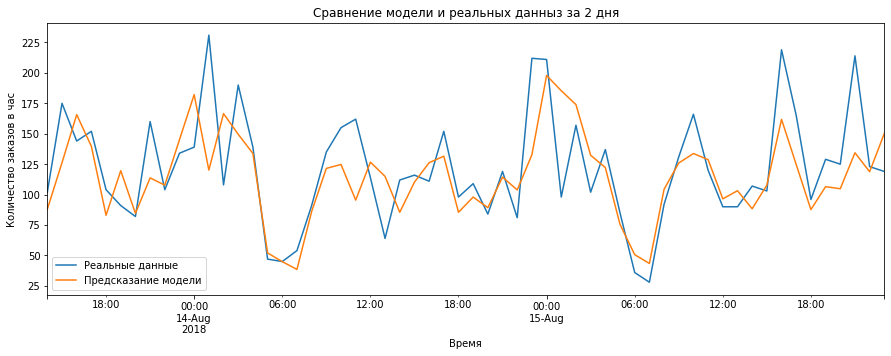

In [47]:
plt.figure(figsize=(15, 5))

plt.subplot()

target_test['2018-08-13':'2018-08-15'].plot(ax=plt.gca(), label='Реальные данные')
pred['2018-08-13':'2018-08-15'].plot(ax=plt.gca(), label='Предсказание модели')

plt.legend(['Реальные данные', 'Предсказание модели'])
plt.xlabel('Время')
plt.ylabel('Количество заказов в час')

plt.title('Сравнение модели и реальных данныз за 2 дня')

**По графику видно, что модель хорошо справляется с предсказанием, точно устанавливая места максимумов и минимумов на графике, и незначительно ошибается в самом значении**